In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

# --- 1. Define Constants ---
# File paths based on your directory structure
MIMIC_ICU_DIR = 'data/mimic-iv-clinical-database-demo-2.2/icu/'
MIMIC_HOSP_DIR = 'data/mimic-iv-clinical-database-demo-2.2/hosp/'

# Define the time window for bucketing data (in hours)
TIME_BUCKET_SIZE = 4

# --- Define itemids for the features you want ---
# States (Vitals & Labs)
ID_HEART_RATE = 220045
ID_SYSTOLIC_BP = 220179
ID_DIASTOLIC_BP = 220180
ID_TEMPERATURE = 223761
ID_LACTATE = 50813 # from d_labitems

# Actions (Medications)
ID_NOREPINEPHRINE = 221906 # Vasopressor
ID_FLUID_BOLUS = 225158     # IV Fluid

print("Cell 1: Setup and constants defined successfully.")

Cell 1: Setup and constants defined successfully.


In [2]:
# --- 2. Load and Merge Data Upfront ---
print("Loading and filtering raw data...")

# ICU Stays (the source of truth for stay_id and intime)
df_icu_stays = pd.read_csv(f'{MIMIC_ICU_DIR}icustays.csv.gz', usecols=['stay_id', 'subject_id', 'intime'])
df_icu_stays['intime'] = pd.to_datetime(df_icu_stays['intime'])

# Vitals from chartevents
df_chartevents = pd.read_csv(f'{MIMIC_ICU_DIR}chartevents.csv.gz', usecols=['stay_id', 'charttime', 'itemid', 'valuenum'])
state_vitals_ids = [ID_HEART_RATE, ID_SYSTOLIC_BP, ID_DIASTOLIC_BP, ID_TEMPERATURE]
df_vitals_raw = df_chartevents[df_chartevents['itemid'].isin(state_vitals_ids)].copy()

# Labs from labevents
df_labevents = pd.read_csv(f'{MIMIC_HOSP_DIR}labevents.csv.gz', usecols=['subject_id', 'charttime', 'itemid', 'valuenum'])
state_labs_ids = [ID_LACTATE]
df_labs_raw = df_labevents[df_labevents['itemid'].isin(state_labs_ids)].copy()

# Actions from inputevents
df_inputevents = pd.read_csv(f'{MIMIC_ICU_DIR}inputevents.csv.gz', usecols=['stay_id', 'starttime', 'itemid', 'amount'])
action_ids = [ID_NOREPINEPHRINE, ID_FLUID_BOLUS]
df_actions_raw = df_inputevents[df_inputevents['itemid'].isin(action_ids)].copy()

# --- Centralize all merges here ---
# Add 'intime' to vitals and actions using their 'stay_id'
df_vitals = pd.merge(df_vitals_raw, df_icu_stays, on='stay_id', how='inner')
df_actions = pd.merge(df_actions_raw, df_icu_stays, on='stay_id', how='inner')

# Add 'stay_id' and 'intime' to labs using their 'subject_id'
df_labs = pd.merge(df_labs_raw, df_icu_stays, on='subject_id', how='inner')

print("Cell 2: Raw data loaded and merged successfully.")

Loading and filtering raw data...
Cell 2: Raw data loaded and merged successfully.


In [3]:
# --- 3. Simplified Time-Bucket and Aggregate ---
def simplified_process_and_aggregate(df, time_col, value_col, item_id, feature_name):
    """A simplified function that assumes df already has stay_id and intime."""
    df_filtered = df[df['itemid'] == item_id].copy()
    df_filtered[time_col] = pd.to_datetime(df_filtered[time_col])
    
    # Calculate hours from admission (intime is already present)
    df_filtered['hours_in'] = (df_filtered[time_col] - df_filtered['intime']).dt.total_seconds() / 3600
    df_filtered['time_bucket'] = (df_filtered['hours_in'] // TIME_BUCKET_SIZE).astype(int)
    
    # Aggregate by taking the mean value in each bucket
    df_agg = df_filtered.groupby(['stay_id', 'time_bucket'])[value_col].mean().reset_index()
    df_agg = df_agg.rename(columns={value_col: feature_name})
    
    return df_agg

print("Aggregating data into time buckets...")
# Process States
df_hr = simplified_process_and_aggregate(df_vitals, 'charttime', 'valuenum', ID_HEART_RATE, 'heart_rate')
df_sbp = simplified_process_and_aggregate(df_vitals, 'charttime', 'valuenum', ID_SYSTOLIC_BP, 'systolic_bp')
df_dbp = simplified_process_and_aggregate(df_vitals, 'charttime', 'valuenum', ID_DIASTOLIC_BP, 'diastolic_bp')
df_temp = simplified_process_and_aggregate(df_vitals, 'charttime', 'valuenum', ID_TEMPERATURE, 'temperature')
df_lactate = simplified_process_and_aggregate(df_labs, 'charttime', 'valuenum', ID_LACTATE, 'lactate')

# Process Actions
df_norepi = simplified_process_and_aggregate(df_actions, 'starttime', 'amount', ID_NOREPINEPHRINE, 'norepinephrine')
df_fluids = simplified_process_and_aggregate(df_actions, 'starttime', 'amount', ID_FLUID_BOLUS, 'fluid_bolus')

print("Cell 3: Data aggregation complete.")

Aggregating data into time buckets...
Cell 3: Data aggregation complete.


In [4]:
# --- 4. Merge into a Master DataFrame ---
print("Merging features into a master DataFrame...")
dfs_to_merge = [df_hr, df_sbp, df_dbp, df_temp, df_lactate, df_norepi, df_fluids]

# Start with the first DataFrame in the list as our base
df_master = dfs_to_merge[0]

# Loop through the rest of the DataFrames and merge them one by one
for df_to_merge in dfs_to_merge[1:]:
    df_master = pd.merge(df_master, df_to_merge, on=['stay_id', 'time_bucket'], how='outer')

# Sort for chronological order
df_master = df_master.sort_values(by=['stay_id', 'time_bucket']).reset_index(drop=True)

print("Cell 4: Master DataFrame created.")
df_master.info()

Merging features into a master DataFrame...
Cell 4: Master DataFrame created.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3970 entries, 0 to 3969
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   stay_id         3970 non-null   int64  
 1   time_bucket     3970 non-null   int64  
 2   heart_rate      3122 non-null   float64
 3   systolic_bp     2095 non-null   float64
 4   diastolic_bp    2095 non-null   float64
 5   temperature     2725 non-null   float64
 6   lactate         1307 non-null   float64
 7   norepinephrine  376 non-null    float64
 8   fluid_bolus     1300 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 279.3 KB


In [5]:
# --- FINAL CORRECTED Cell 5: Handle Missing Data ---
print("Handling missing data...")

# This .apply() method correctly forward-fills within each group...
# ...and .reset_index(drop=True) removes the ambiguous multi-index.
df_master = df_master.groupby('stay_id').apply(lambda group: group.ffill()).reset_index(drop=True)

# Fill any remaining NaNs (especially at the beginning of a stay) with 0
df_master = df_master.fillna(0)

print("Cell 5: Missing data handled, and index has been reset.")

Handling missing data...
Cell 5: Missing data handled, and index has been reset.


C:\Users\ASUS ZENBOOK\AppData\Local\Temp\ipykernel_5804\3975144854.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_master = df_master.groupby('stay_id').apply(lambda group: group.ffill()).reset_index(drop=True)


In [6]:
# --- DEBUGGING CELL ---
# Insert this cell right before the original Cell 6 to inspect the DataFrame

print("--- Inspecting df_master just before the error ---")
print("\nFirst 5 rows:")
print(df_master.head())

print("\n\nDataFrame Info:")
df_master.info()

print(f"\n\nIs 'stay_id' a column? -> {'stay_id' in df_master.columns}")

--- Inspecting df_master just before the error ---

First 5 rows:
    stay_id  time_bucket  heart_rate  systolic_bp  diastolic_bp  temperature  \
0  30057454           -1         0.0          0.0           0.0         0.00   
1  30057454            0       105.8          0.0           0.0        98.25   
2  30057454            1       108.0          0.0           0.0        98.70   
3  30057454            2       109.5          0.0           0.0        97.70   
4  30057454            3       113.0          0.0           0.0        97.70   

   lactate  norepinephrine  fluid_bolus  
0      0.9             0.0     0.000000  
1      0.9             0.0    17.916667  
2      0.9             0.0    17.916667  
3      0.9             0.0     7.000000  
4      0.9             0.0    31.416668  


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3970 entries, 0 to 3969
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          -----------

In [7]:
# --- 6. Create Final S_t, A_t, S_{t+1} Table ---
print("Creating final S_t, A_t, S_{t+1} table...")
state_cols = ['heart_rate', 'systolic_bp', 'diastolic_bp', 'temperature', 'lactate']
action_cols = ['norepinephrine', 'fluid_bolus']

# Create the "next state" columns by shifting the state columns up by one
for col in state_cols:
    df_master[f'{col}_next'] = df_master.groupby('stay_id')[col].shift(-1)

# Drop the last row for each patient, as it has no "next state"
df_final = df_master.dropna().reset_index(drop=True)

print("Cell 6: Preprocessing complete!")
print(f"Created a final dataset with {len(df_final)} samples.")
df_final.head()

Creating final S_t, A_t, S_{t+1} table...
Cell 6: Preprocessing complete!
Created a final dataset with 3830 samples.


stay_id  time_bucket  heart_rate  systolic_bp  diastolic_bp  temperature  \
0  30057454           -1         0.0          0.0           0.0         0.00   
1  30057454            0       105.8          0.0           0.0        98.25   
2  30057454            1       108.0          0.0           0.0        98.70   
3  30057454            2       109.5          0.0           0.0        97.70   
4  30057454            3       113.0          0.0           0.0        97.70   

   lactate  norepinephrine  fluid_bolus  heart_rate_next  systolic_bp_next  \
0      0.9             0.0     0.000000           105.80               0.0   
1      0.9             0.0    17.916667           108.00               0.0   
2      0.9             0.0    17.916667           109.50               0.0   
3      0.9             0.0     7.000000           113.00               0.0   
4      0.9             0.0    31.416668           110.75              82.5   

   diastolic_bp_next  temperature_next  lactate_next  
0                0.0             98.25           0.9  
1                0.0             98.70           0.9  
2                0.0             97.70           0.9  
3                0.0             97.70           0.9  
4               56.0             97.70           0.9

In [8]:
# --- 7. Build and Train the World Model ---
# X includes the state and action at time 't'
X = df_final[state_cols + action_cols]
# Y is the state at time 't+1'
Y = df_final[[f'{col}_next' for col in state_cols]]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor
xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Wrap it with MultiOutputRegressor to handle multiple targets
multi_output_model = MultiOutputRegressor(estimator=xgbr)

print("Training the world model...")
multi_output_model.fit(X_train, y_train)
print("Cell 7: Training complete.")

Training the world model...
Cell 7: Training complete.


In [9]:
# --- 8. Evaluate the World Model ---
print("Evaluating the world model...")
y_pred = multi_output_model.predict(X_test)

# Calculate overall Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"\nOverall World Model MSE on Test Set: {mse:.4f}")

# You can also look at the error for each variable individually
print("\n--- MSE for each predicted variable ---")
for i, col in enumerate(state_cols):
    var_mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    print(f"  - MSE for {col}_next: {var_mse:.4f}")

Evaluating the world model...

Overall World Model MSE on Test Set: 219.7467

--- MSE for each predicted variable ---
  - MSE for heart_rate_next: 289.2407
  - MSE for systolic_bp_next: 403.8036
  - MSE for diastolic_bp_next: 153.8443
  - MSE for temperature_next: 251.3340
  - MSE for lactate_next: 0.5111


In [10]:
## MODIFIED PatientSimulatorEnv Class (Replace your old one with this)

import gymnasium as gym
from gymnasium import spaces
import numpy as np

class PatientSimulatorEnv(gym.Env):
    """
    A custom Gym environment for simulating patient treatment.
    
    UPDATES:
    - Added a mapping from discrete actions (0-24) to continuous medication doses.
    - Modified reset() to accept a specific initial state for targeted testing.
    """
    
    def __init__(self, world_model, initial_states_df, state_cols, action_cols):
        super(PatientSimulatorEnv, self).__init__()
        
        self.world_model = world_model
        self.initial_states_df = initial_states_df
        self.state_cols = state_cols
        self.action_cols = action_cols
        
        # --- Define Action Mapping ---
        # Let's say 5 discrete levels for each of the 2 medications
        self.norepi_levels = np.linspace(0, self.initial_states_df['norepinephrine'].max(), 5)
        self.fluids_levels = np.linspace(0, self.initial_states_df['fluid_bolus'].max(), 5)
        self.action_space = spaces.Discrete(len(self.norepi_levels) * len(self.fluids_levels)) # 5x5 = 25 actions

        # The state space is continuous
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, 
                                            shape=(len(state_cols),), dtype=np.float32)
        
        self.current_state = None
        self.episode_length = 0

    def _decode_action(self, action):
        """Converts a discrete action (e.g., 17) into a continuous action vector [norepi, fluids]."""
        norepi_idx = action % len(self.norepi_levels)
        fluids_idx = action // len(self.norepi_levels)
        
        norepi_dose = self.norepi_levels[norepi_idx]
        fluids_dose = self.fluids_levels[fluids_idx]
        
        return np.array([norepi_dose, fluids_dose])

    def reset(self, seed=None, options=None):
        # Allow for a specific initial state to be passed for evaluation
        if options and 'initial_state' in options:
            self.current_state = options['initial_state'].copy()
        else:
            # Original behavior: randomly select an initial state from the real data
            initial_state_idx = np.random.randint(0, len(self.initial_states_df.values))
            self.current_state = self.initial_states_df.iloc[initial_state_idx][self.state_cols].values
        
        self.episode_length = 0
        return self.current_state, {} # Return state and an empty info dict

    def step(self, action):
        # 1. Decode the discrete action into medication dosages
        action_vector = self._decode_action(action)
        
        # 2. Prepare the input for the world model
        model_input = np.concatenate([self.current_state, action_vector]).reshape(1, -1)
        
        # 3. Use the world model to predict the next state
        previous_lactate = self.current_state[self.state_cols.index('lactate')]
        predicted_next_state = self.world_model.predict(model_input)[0]
        self.current_state = predicted_next_state
        self.episode_length += 1
        
        # 4. Calculate the reward and determine if the episode is done
        new_lactate = self.current_state[self.state_cols.index('lactate')]
        
        terminated = False
        
        # Reward is based on the change in lactate from the previous state
        reward = (previous_lactate - new_lactate) * 10 # Reward for reducing lactate
        
        # Add large penalties/rewards for terminal states
        if new_lactate > 4.0:
            reward -= 100 # Large penalty for critical state
            terminated = True
        elif new_lactate < 1.0 and self.episode_length > 5:
            reward += 50
            terminated = True
            
        if self.episode_length >= 50:
            terminated = True
            
        return self.current_state, reward, terminated, False, {}

print("Cell 9: Updated PatientSimulatorEnv class defined.")

Cell 9: Updated PatientSimulatorEnv class defined.


In [11]:
from stable_baselines3 import DQN

# 1. Create an instance of your environment
# We use the 'X' DataFrame from the previous step to get initial states
env = PatientSimulatorEnv(multi_output_model, X, state_cols, action_cols)

# 2. Instantiate the DQN agent
model = DQN("MlpPolicy", env, verbose=1)

# 3. Train the agent
# This will take some time. The agent will play out thousands of episodes in the simulator.
print("Training RL agent...")
model.learn(total_timesteps=1000000, progress_bar=True)
print("Training complete.")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -40.5    |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 535      |
|    time_elapsed     | 0        |
|    total_timesteps  | 151      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 13.3     |
|    n_updates        | 12       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -39.1    |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 492      |
|    time_elapsed     | 0        |
|    total_timesteps  | 303      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.92     |
|    n_updates        | 50       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.9     |
|    ep_rew_mean      | -26.8    |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 465      |
|    time_elapsed     | 1        |
|    total_timesteps  | 503      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.53     |
|    n_updates        | 100      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.9     |
|    ep_rew_mean      | -18.6    |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 16       |
|    fps              | 446      |
|    time_elapsed     | 1        |
|    total_timesteps  | 703      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.81     |
|    n_updates        | 150      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.3     |
|    ep_rew_mean      | -28.9    |
|    exploration_rate | 0.992    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 439      |
|    time_elapsed     | 1        |
|    total_timesteps  | 806      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.4      |
|    n_updates        | 176      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.1     |
|    ep_rew_mean      | -21.8    |
|    exploration_rate | 0.991    |
| time/               |          |
|    episodes         | 24       |
|    fps              | 433      |
|    time_elapsed     | 2        |
|    total_timesteps  | 962      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.96     |
|    n_updates        | 215      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.8     |
|    ep_rew_mean      | -21.9    |
|    exploration_rate | 0.989    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 433      |
|    time_elapsed     | 2        |
|    total_timesteps  | 1113     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.78     |
|    n_updates        | 253      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -29.7    |
|    exploration_rate | 0.989    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 431      |
|    time_elapsed     | 2        |
|    total_timesteps  | 1192     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.983    |
|    n_updates        | 272      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -31.1    |
|    exploration_rate | 0.987    |
| time/               |          |
|    episodes         | 36       |
|    fps              | 424      |
|    time_elapsed     | 3        |
|    total_timesteps  | 1343     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.22     |
|    n_updates        | 310      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -30.2    |
|    exploration_rate | 0.986    |
| time/               |          |
|    episodes         | 40       |
|    fps              | 424      |
|    time_elapsed     | 3        |
|    total_timesteps  | 1451     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.68     |
|    n_updates        | 337      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -29.3    |
|    exploration_rate | 0.985    |
| time/               |          |
|    episodes         | 44       |
|    fps              | 425      |
|    time_elapsed     | 3        |
|    total_timesteps  | 1559     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.87     |
|    n_updates        | 364      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -26.8    |
|    exploration_rate | 0.983    |
| time/               |          |
|    episodes         | 48       |
|    fps              | 426      |
|    time_elapsed     | 4        |
|    total_timesteps  | 1759     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 414      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -26.2    |
|    exploration_rate | 0.982    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 421      |
|    time_elapsed     | 4        |
|    total_timesteps  | 1868     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 441      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -23.8    |
|    exploration_rate | 0.98     |
| time/               |          |
|    episodes         | 56       |
|    fps              | 421      |
|    time_elapsed     | 4        |
|    total_timesteps  | 2068     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.33     |
|    n_updates        | 491      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -22.1    |
|    exploration_rate | 0.978    |
| time/               |          |
|    episodes         | 60       |
|    fps              | 420      |
|    time_elapsed     | 5        |
|    total_timesteps  | 2268     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.801    |
|    n_updates        | 541      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -22.8    |
|    exploration_rate | 0.977    |
| time/               |          |
|    episodes         | 64       |
|    fps              | 416      |
|    time_elapsed     | 5        |
|    total_timesteps  | 2419     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.75     |
|    n_updates        | 579      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -23.3    |
|    exploration_rate | 0.976    |
| time/               |          |
|    episodes         | 68       |
|    fps              | 418      |
|    time_elapsed     | 6        |
|    total_timesteps  | 2572     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.535    |
|    n_updates        | 617      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.4     |
|    ep_rew_mean      | -23.7    |
|    exploration_rate | 0.974    |
| time/               |          |
|    episodes         | 72       |
|    fps              | 418      |
|    time_elapsed     | 6        |
|    total_timesteps  | 2762     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 665      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -23.6    |
|    exploration_rate | 0.973    |
| time/               |          |
|    episodes         | 76       |
|    fps              | 418      |
|    time_elapsed     | 6        |
|    total_timesteps  | 2876     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.14     |
|    n_updates        | 693      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -24.1    |
|    exploration_rate | 0.971    |
| time/               |          |
|    episodes         | 80       |
|    fps              | 419      |
|    time_elapsed     | 7        |
|    total_timesteps  | 3030     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.24     |
|    n_updates        | 732      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -26.5    |
|    exploration_rate | 0.97     |
| time/               |          |
|    episodes         | 84       |
|    fps              | 420      |
|    time_elapsed     | 7        |
|    total_timesteps  | 3175     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.23     |
|    n_updates        | 768      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -27      |
|    exploration_rate | 0.968    |
| time/               |          |
|    episodes         | 88       |
|    fps              | 420      |
|    time_elapsed     | 7        |
|    total_timesteps  | 3328     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.23     |
|    n_updates        | 806      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -29.7    |
|    exploration_rate | 0.968    |
| time/               |          |
|    episodes         | 92       |
|    fps              | 419      |
|    time_elapsed     | 8        |
|    total_timesteps  | 3385     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.29     |
|    n_updates        | 821      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -28.5    |
|    exploration_rate | 0.966    |
| time/               |          |
|    episodes         | 96       |
|    fps              | 422      |
|    time_elapsed     | 8        |
|    total_timesteps  | 3585     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.41     |
|    n_updates        | 871      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | -28.5    |
|    exploration_rate | 0.964    |
| time/               |          |
|    episodes         | 100      |
|    fps              | 422      |
|    time_elapsed     | 8        |
|    total_timesteps  | 3744     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.952    |
|    n_updates        | 910      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -27.3    |
|    exploration_rate | 0.963    |
| time/               |          |
|    episodes         | 104      |
|    fps              | 424      |
|    time_elapsed     | 9        |
|    total_timesteps  | 3944     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.386    |
|    n_updates        | 960      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -27      |
|    exploration_rate | 0.961    |
| time/               |          |
|    episodes         | 108      |
|    fps              | 424      |
|    time_elapsed     | 9        |
|    total_timesteps  | 4095     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.877    |
|    n_updates        | 998      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -30.2    |
|    exploration_rate | 0.96     |
| time/               |          |
|    episodes         | 112      |
|    fps              | 424      |
|    time_elapsed     | 9        |
|    total_timesteps  | 4159     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 1014     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -30.4    |
|    exploration_rate | 0.959    |
| time/               |          |
|    episodes         | 116      |
|    fps              | 424      |
|    time_elapsed     | 10       |
|    total_timesteps  | 4359     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.894    |
|    n_updates        | 1064     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -27.2    |
|    exploration_rate | 0.957    |
| time/               |          |
|    episodes         | 120      |
|    fps              | 426      |
|    time_elapsed     | 10       |
|    total_timesteps  | 4515     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.28     |
|    n_updates        | 1103     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -29.6    |
|    exploration_rate | 0.956    |
| time/               |          |
|    episodes         | 124      |
|    fps              | 426      |
|    time_elapsed     | 10       |
|    total_timesteps  | 4582     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.03     |
|    n_updates        | 1120     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -28.8    |
|    exploration_rate | 0.955    |
| time/               |          |
|    episodes         | 128      |
|    fps              | 427      |
|    time_elapsed     | 11       |
|    total_timesteps  | 4782     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.25     |
|    n_updates        | 1170     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -26.3    |
|    exploration_rate | 0.953    |
| time/               |          |
|    episodes         | 132      |
|    fps              | 427      |
|    time_elapsed     | 11       |
|    total_timesteps  | 4923     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.18     |
|    n_updates        | 1205     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -25.8    |
|    exploration_rate | 0.952    |
| time/               |          |
|    episodes         | 136      |
|    fps              | 428      |
|    time_elapsed     | 11       |
|    total_timesteps  | 5074     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 1243     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -26.1    |
|    exploration_rate | 0.95     |
| time/               |          |
|    episodes         | 140      |
|    fps              | 429      |
|    time_elapsed     | 12       |
|    total_timesteps  | 5226     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.43     |
|    n_updates        | 1281     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -28      |
|    exploration_rate | 0.949    |
| time/               |          |
|    episodes         | 144      |
|    fps              | 429      |
|    time_elapsed     | 12       |
|    total_timesteps  | 5348     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.324    |
|    n_updates        | 1311     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -30.1    |
|    exploration_rate | 0.949    |
| time/               |          |
|    episodes         | 148      |
|    fps              | 429      |
|    time_elapsed     | 12       |
|    total_timesteps  | 5407     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.25     |
|    n_updates        | 1326     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -30.7    |
|    exploration_rate | 0.947    |
| time/               |          |
|    episodes         | 152      |
|    fps              | 430      |
|    time_elapsed     | 12       |
|    total_timesteps  | 5560     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.93     |
|    n_updates        | 1364     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -32.5    |
|    exploration_rate | 0.946    |
| time/               |          |
|    episodes         | 156      |
|    fps              | 430      |
|    time_elapsed     | 13       |
|    total_timesteps  | 5711     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 1402     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -36.3    |
|    exploration_rate | 0.945    |
| time/               |          |
|    episodes         | 160      |
|    fps              | 430      |
|    time_elapsed     | 13       |
|    total_timesteps  | 5766     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.621    |
|    n_updates        | 1416     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -37.5    |
|    exploration_rate | 0.944    |
| time/               |          |
|    episodes         | 164      |
|    fps              | 430      |
|    time_elapsed     | 13       |
|    total_timesteps  | 5871     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.762    |
|    n_updates        | 1442     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -39.3    |
|    exploration_rate | 0.944    |
| time/               |          |
|    episodes         | 168      |
|    fps              | 429      |
|    time_elapsed     | 13       |
|    total_timesteps  | 5890     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.831    |
|    n_updates        | 1447     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -38.9    |
|    exploration_rate | 0.943    |
| time/               |          |
|    episodes         | 172      |
|    fps              | 430      |
|    time_elapsed     | 13       |
|    total_timesteps  | 5999     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.46     |
|    n_updates        | 1474     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -40.2    |
|    exploration_rate | 0.942    |
| time/               |          |
|    episodes         | 176      |
|    fps              | 429      |
|    time_elapsed     | 14       |
|    total_timesteps  | 6103     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.98     |
|    n_updates        | 1500     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -39.9    |
|    exploration_rate | 0.941    |
| time/               |          |
|    episodes         | 180      |
|    fps              | 429      |
|    time_elapsed     | 14       |
|    total_timesteps  | 6212     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.46     |
|    n_updates        | 1527     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -38      |
|    exploration_rate | 0.94     |
| time/               |          |
|    episodes         | 184      |
|    fps              | 429      |
|    time_elapsed     | 14       |
|    total_timesteps  | 6323     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.584    |
|    n_updates        | 1555     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -37.7    |
|    exploration_rate | 0.938    |
| time/               |          |
|    episodes         | 188      |
|    fps              | 429      |
|    time_elapsed     | 15       |
|    total_timesteps  | 6474     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.15     |
|    n_updates        | 1593     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -35.4    |
|    exploration_rate | 0.937    |
| time/               |          |
|    episodes         | 192      |
|    fps              | 429      |
|    time_elapsed     | 15       |
|    total_timesteps  | 6646     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.02     |
|    n_updates        | 1636     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -39.7    |
|    exploration_rate | 0.936    |
| time/               |          |
|    episodes         | 196      |
|    fps              | 429      |
|    time_elapsed     | 15       |
|    total_timesteps  | 6702     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.421    |
|    n_updates        | 1650     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -42.3    |
|    exploration_rate | 0.936    |
| time/               |          |
|    episodes         | 200      |
|    fps              | 429      |
|    time_elapsed     | 15       |
|    total_timesteps  | 6784     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 1670     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -42.6    |
|    exploration_rate | 0.934    |
| time/               |          |
|    episodes         | 204      |
|    fps              | 429      |
|    time_elapsed     | 16       |
|    total_timesteps  | 6935     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.97     |
|    n_updates        | 1708     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -43.9    |
|    exploration_rate | 0.933    |
| time/               |          |
|    episodes         | 208      |
|    fps              | 429      |
|    time_elapsed     | 16       |
|    total_timesteps  | 7078     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.505    |
|    n_updates        | 1744     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -43.5    |
|    exploration_rate | 0.932    |
| time/               |          |
|    episodes         | 212      |
|    fps              | 429      |
|    time_elapsed     | 16       |
|    total_timesteps  | 7200     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.1      |
|    n_updates        | 1774     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -43.4    |
|    exploration_rate | 0.93     |
| time/               |          |
|    episodes         | 216      |
|    fps              | 430      |
|    time_elapsed     | 17       |
|    total_timesteps  | 7400     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.1     |
|    n_updates        | 1824     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -45      |
|    exploration_rate | 0.928    |
| time/               |          |
|    episodes         | 220      |
|    fps              | 429      |
|    time_elapsed     | 17       |
|    total_timesteps  | 7563     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.34     |
|    n_updates        | 1865     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -44.9    |
|    exploration_rate | 0.927    |
| time/               |          |
|    episodes         | 224      |
|    fps              | 430      |
|    time_elapsed     | 17       |
|    total_timesteps  | 7714     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.65     |
|    n_updates        | 1903     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -47.6    |
|    exploration_rate | 0.926    |
| time/               |          |
|    episodes         | 228      |
|    fps              | 430      |
|    time_elapsed     | 18       |
|    total_timesteps  | 7819     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.902    |
|    n_updates        | 1929     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -46.3    |
|    exploration_rate | 0.924    |
| time/               |          |
|    episodes         | 232      |
|    fps              | 430      |
|    time_elapsed     | 18       |
|    total_timesteps  | 7975     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.87     |
|    n_updates        | 1968     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -45.2    |
|    exploration_rate | 0.922    |
| time/               |          |
|    episodes         | 236      |
|    fps              | 431      |
|    time_elapsed     | 18       |
|    total_timesteps  | 8175     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 2018     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -43.3    |
|    exploration_rate | 0.921    |
| time/               |          |
|    episodes         | 240      |
|    fps              | 429      |
|    time_elapsed     | 19       |
|    total_timesteps  | 8331     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.546    |
|    n_updates        | 2057     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -44.6    |
|    exploration_rate | 0.92     |
| time/               |          |
|    episodes         | 244      |
|    fps              | 429      |
|    time_elapsed     | 19       |
|    total_timesteps  | 8427     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.7     |
|    n_updates        | 2081     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -43.5    |
|    exploration_rate | 0.919    |
| time/               |          |
|    episodes         | 248      |
|    fps              | 429      |
|    time_elapsed     | 19       |
|    total_timesteps  | 8578     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.25     |
|    n_updates        | 2119     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -44.7    |
|    exploration_rate | 0.918    |
| time/               |          |
|    episodes         | 252      |
|    fps              | 428      |
|    time_elapsed     | 20       |
|    total_timesteps  | 8682     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.951    |
|    n_updates        | 2145     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -46.8    |
|    exploration_rate | 0.917    |
| time/               |          |
|    episodes         | 256      |
|    fps              | 428      |
|    time_elapsed     | 20       |
|    total_timesteps  | 8740     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.27     |
|    n_updates        | 2159     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -45.9    |
|    exploration_rate | 0.916    |
| time/               |          |
|    episodes         | 260      |
|    fps              | 428      |
|    time_elapsed     | 20       |
|    total_timesteps  | 8842     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.25     |
|    n_updates        | 2185     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -44.8    |
|    exploration_rate | 0.915    |
| time/               |          |
|    episodes         | 264      |
|    fps              | 428      |
|    time_elapsed     | 20       |
|    total_timesteps  | 8994     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.959    |
|    n_updates        | 2223     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -43.1    |
|    exploration_rate | 0.913    |
| time/               |          |
|    episodes         | 268      |
|    fps              | 428      |
|    time_elapsed     | 21       |
|    total_timesteps  | 9145     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.19     |
|    n_updates        | 2261     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -43.8    |
|    exploration_rate | 0.912    |
| time/               |          |
|    episodes         | 272      |
|    fps              | 428      |
|    time_elapsed     | 21       |
|    total_timesteps  | 9298     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.11     |
|    n_updates        | 2299     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -41.6    |
|    exploration_rate | 0.91     |
| time/               |          |
|    episodes         | 276      |
|    fps              | 429      |
|    time_elapsed     | 22       |
|    total_timesteps  | 9498     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 2349     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -41.7    |
|    exploration_rate | 0.908    |
| time/               |          |
|    episodes         | 280      |
|    fps              | 429      |
|    time_elapsed     | 22       |
|    total_timesteps  | 9666     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.15     |
|    n_updates        | 2391     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -43.2    |
|    exploration_rate | 0.907    |
| time/               |          |
|    episodes         | 284      |
|    fps              | 429      |
|    time_elapsed     | 22       |
|    total_timesteps  | 9775     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.66     |
|    n_updates        | 2418     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -43.6    |
|    exploration_rate | 0.906    |
| time/               |          |
|    episodes         | 288      |
|    fps              | 429      |
|    time_elapsed     | 23       |
|    total_timesteps  | 9947     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 2461     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -45      |
|    exploration_rate | 0.904    |
| time/               |          |
|    episodes         | 292      |
|    fps              | 430      |
|    time_elapsed     | 23       |
|    total_timesteps  | 10079    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.64     |
|    n_updates        | 2494     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -43.6    |
|    exploration_rate | 0.903    |
| time/               |          |
|    episodes         | 296      |
|    fps              | 429      |
|    time_elapsed     | 23       |
|    total_timesteps  | 10181    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.91     |
|    n_updates        | 2520     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -39.1    |
|    exploration_rate | 0.902    |
| time/               |          |
|    episodes         | 300      |
|    fps              | 430      |
|    time_elapsed     | 24       |
|    total_timesteps  | 10337    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.53     |
|    n_updates        | 2559     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -40.4    |
|    exploration_rate | 0.901    |
| time/               |          |
|    episodes         | 304      |
|    fps              | 430      |
|    time_elapsed     | 24       |
|    total_timesteps  | 10413    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 2578     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -39.3    |
|    exploration_rate | 0.9      |
| time/               |          |
|    episodes         | 308      |
|    fps              | 430      |
|    time_elapsed     | 24       |
|    total_timesteps  | 10565    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.47     |
|    n_updates        | 2616     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -37.6    |
|    exploration_rate | 0.898    |
| time/               |          |
|    episodes         | 312      |
|    fps              | 430      |
|    time_elapsed     | 24       |
|    total_timesteps  | 10716    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.76     |
|    n_updates        | 2653     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -39      |
|    exploration_rate | 0.897    |
| time/               |          |
|    episodes         | 316      |
|    fps              | 430      |
|    time_elapsed     | 25       |
|    total_timesteps  | 10882    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.736    |
|    n_updates        | 2695     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -40.1    |
|    exploration_rate | 0.896    |
| time/               |          |
|    episodes         | 320      |
|    fps              | 431      |
|    time_elapsed     | 25       |
|    total_timesteps  | 10984    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.42     |
|    n_updates        | 2720     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -38.3    |
|    exploration_rate | 0.894    |
| time/               |          |
|    episodes         | 324      |
|    fps              | 430      |
|    time_elapsed     | 25       |
|    total_timesteps  | 11184    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.83     |
|    n_updates        | 2770     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -35.1    |
|    exploration_rate | 0.892    |
| time/               |          |
|    episodes         | 328      |
|    fps              | 431      |
|    time_elapsed     | 26       |
|    total_timesteps  | 11340    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.63     |
|    n_updates        | 2809     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -36.8    |
|    exploration_rate | 0.891    |
| time/               |          |
|    episodes         | 332      |
|    fps              | 431      |
|    time_elapsed     | 26       |
|    total_timesteps  | 11492    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 2847     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -37.5    |
|    exploration_rate | 0.89     |
| time/               |          |
|    episodes         | 336      |
|    fps              | 430      |
|    time_elapsed     | 26       |
|    total_timesteps  | 11599    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 2874     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -38.9    |
|    exploration_rate | 0.889    |
| time/               |          |
|    episodes         | 340      |
|    fps              | 431      |
|    time_elapsed     | 27       |
|    total_timesteps  | 11711    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.18     |
|    n_updates        | 2902     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -36.1    |
|    exploration_rate | 0.888    |
| time/               |          |
|    episodes         | 344      |
|    fps              | 431      |
|    time_elapsed     | 27       |
|    total_timesteps  | 11818    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.865    |
|    n_updates        | 2929     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -34.5    |
|    exploration_rate | 0.886    |
| time/               |          |
|    episodes         | 348      |
|    fps              | 431      |
|    time_elapsed     | 27       |
|    total_timesteps  | 11974    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.763    |
|    n_updates        | 2968     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -33.1    |
|    exploration_rate | 0.885    |
| time/               |          |
|    episodes         | 352      |
|    fps              | 431      |
|    time_elapsed     | 28       |
|    total_timesteps  | 12125    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.388    |
|    n_updates        | 3006     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -32      |
|    exploration_rate | 0.884    |
| time/               |          |
|    episodes         | 356      |
|    fps              | 431      |
|    time_elapsed     | 28       |
|    total_timesteps  | 12231    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.91     |
|    n_updates        | 3032     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -28.7    |
|    exploration_rate | 0.882    |
| time/               |          |
|    episodes         | 360      |
|    fps              | 431      |
|    time_elapsed     | 28       |
|    total_timesteps  | 12431    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 3082     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -27.2    |
|    exploration_rate | 0.88     |
| time/               |          |
|    episodes         | 364      |
|    fps              | 431      |
|    time_elapsed     | 29       |
|    total_timesteps  | 12631    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.91     |
|    n_updates        | 3132     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -25.8    |
|    exploration_rate | 0.878    |
| time/               |          |
|    episodes         | 368      |
|    fps              | 431      |
|    time_elapsed     | 29       |
|    total_timesteps  | 12831    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.38     |
|    n_updates        | 3182     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -26.2    |
|    exploration_rate | 0.878    |
| time/               |          |
|    episodes         | 372      |
|    fps              | 431      |
|    time_elapsed     | 29       |
|    total_timesteps  | 12890    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.93     |
|    n_updates        | 3197     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -27.7    |
|    exploration_rate | 0.876    |
| time/               |          |
|    episodes         | 376      |
|    fps              | 431      |
|    time_elapsed     | 30       |
|    total_timesteps  | 13044    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.31     |
|    n_updates        | 3235     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -26.4    |
|    exploration_rate | 0.874    |
| time/               |          |
|    episodes         | 380      |
|    fps              | 431      |
|    time_elapsed     | 30       |
|    total_timesteps  | 13244    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.21     |
|    n_updates        | 3285     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -23.2    |
|    exploration_rate | 0.873    |
| time/               |          |
|    episodes         | 384      |
|    fps              | 431      |
|    time_elapsed     | 31       |
|    total_timesteps  | 13400    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.604    |
|    n_updates        | 3324     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -22      |
|    exploration_rate | 0.872    |
| time/               |          |
|    episodes         | 388      |
|    fps              | 431      |
|    time_elapsed     | 31       |
|    total_timesteps  | 13507    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.69     |
|    n_updates        | 3351     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -21.2    |
|    exploration_rate | 0.871    |
| time/               |          |
|    episodes         | 392      |
|    fps              | 431      |
|    time_elapsed     | 31       |
|    total_timesteps  | 13570    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.81     |
|    n_updates        | 3367     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -21.7    |
|    exploration_rate | 0.871    |
| time/               |          |
|    episodes         | 396      |
|    fps              | 431      |
|    time_elapsed     | 31       |
|    total_timesteps  | 13624    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 3380     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -23.5    |
|    exploration_rate | 0.87     |
| time/               |          |
|    episodes         | 400      |
|    fps              | 431      |
|    time_elapsed     | 31       |
|    total_timesteps  | 13731    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.7      |
|    n_updates        | 3407     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -25.3    |
|    exploration_rate | 0.869    |
| time/               |          |
|    episodes         | 404      |
|    fps              | 431      |
|    time_elapsed     | 31       |
|    total_timesteps  | 13807    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 3426     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -25.2    |
|    exploration_rate | 0.867    |
| time/               |          |
|    episodes         | 408      |
|    fps              | 431      |
|    time_elapsed     | 32       |
|    total_timesteps  | 13967    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.66     |
|    n_updates        | 3466     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -25.7    |
|    exploration_rate | 0.867    |
| time/               |          |
|    episodes         | 412      |
|    fps              | 431      |
|    time_elapsed     | 32       |
|    total_timesteps  | 14031    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.316    |
|    n_updates        | 3482     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -28.3    |
|    exploration_rate | 0.866    |
| time/               |          |
|    episodes         | 416      |
|    fps              | 431      |
|    time_elapsed     | 32       |
|    total_timesteps  | 14086    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.53     |
|    n_updates        | 3496     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -28.8    |
|    exploration_rate | 0.865    |
| time/               |          |
|    episodes         | 420      |
|    fps              | 431      |
|    time_elapsed     | 32       |
|    total_timesteps  | 14190    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.18     |
|    n_updates        | 3522     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -28.5    |
|    exploration_rate | 0.864    |
| time/               |          |
|    episodes         | 424      |
|    fps              | 431      |
|    time_elapsed     | 33       |
|    total_timesteps  | 14346    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.96     |
|    n_updates        | 3561     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -32.6    |
|    exploration_rate | 0.863    |
| time/               |          |
|    episodes         | 428      |
|    fps              | 431      |
|    time_elapsed     | 33       |
|    total_timesteps  | 14437    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.25     |
|    n_updates        | 3584     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -32.6    |
|    exploration_rate | 0.861    |
| time/               |          |
|    episodes         | 432      |
|    fps              | 431      |
|    time_elapsed     | 33       |
|    total_timesteps  | 14590    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.761    |
|    n_updates        | 3622     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -32      |
|    exploration_rate | 0.859    |
| time/               |          |
|    episodes         | 436      |
|    fps              | 431      |
|    time_elapsed     | 34       |
|    total_timesteps  | 14790    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.37     |
|    n_updates        | 3672     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -32.6    |
|    exploration_rate | 0.858    |
| time/               |          |
|    episodes         | 440      |
|    fps              | 431      |
|    time_elapsed     | 34       |
|    total_timesteps  | 14955    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.31     |
|    n_updates        | 3713     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -32.5    |
|    exploration_rate | 0.857    |
| time/               |          |
|    episodes         | 444      |
|    fps              | 431      |
|    time_elapsed     | 34       |
|    total_timesteps  | 15063    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.685    |
|    n_updates        | 3740     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -34.1    |
|    exploration_rate | 0.856    |
| time/               |          |
|    episodes         | 448      |
|    fps              | 431      |
|    time_elapsed     | 35       |
|    total_timesteps  | 15175    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 3768     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -33.4    |
|    exploration_rate | 0.855    |
| time/               |          |
|    episodes         | 452      |
|    fps              | 431      |
|    time_elapsed     | 35       |
|    total_timesteps  | 15282    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.998    |
|    n_updates        | 3795     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -31.6    |
|    exploration_rate | 0.854    |
| time/               |          |
|    episodes         | 456      |
|    fps              | 431      |
|    time_elapsed     | 35       |
|    total_timesteps  | 15391    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.19     |
|    n_updates        | 3822     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -32.7    |
|    exploration_rate | 0.853    |
| time/               |          |
|    episodes         | 460      |
|    fps              | 431      |
|    time_elapsed     | 35       |
|    total_timesteps  | 15498    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.764    |
|    n_updates        | 3849     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -35.3    |
|    exploration_rate | 0.852    |
| time/               |          |
|    episodes         | 464      |
|    fps              | 431      |
|    time_elapsed     | 36       |
|    total_timesteps  | 15600    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.356    |
|    n_updates        | 3874     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29       |
|    ep_rew_mean      | -35.9    |
|    exploration_rate | 0.851    |
| time/               |          |
|    episodes         | 468      |
|    fps              | 431      |
|    time_elapsed     | 36       |
|    total_timesteps  | 15730    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.08     |
|    n_updates        | 3907     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -36.5    |
|    exploration_rate | 0.849    |
| time/               |          |
|    episodes         | 472      |
|    fps              | 431      |
|    time_elapsed     | 36       |
|    total_timesteps  | 15861    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 3940     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.2     |
|    ep_rew_mean      | -35.7    |
|    exploration_rate | 0.848    |
| time/               |          |
|    episodes         | 476      |
|    fps              | 431      |
|    time_elapsed     | 37       |
|    total_timesteps  | 15968    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.93     |
|    n_updates        | 3966     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.3     |
|    ep_rew_mean      | -36.5    |
|    exploration_rate | 0.847    |
| time/               |          |
|    episodes         | 480      |
|    fps              | 431      |
|    time_elapsed     | 37       |
|    total_timesteps  | 16076    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.853    |
|    n_updates        | 3993     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.8     |
|    ep_rew_mean      | -37      |
|    exploration_rate | 0.845    |
| time/               |          |
|    episodes         | 484      |
|    fps              | 431      |
|    time_elapsed     | 37       |
|    total_timesteps  | 16276    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.577    |
|    n_updates        | 4043     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.2     |
|    ep_rew_mean      | -38.9    |
|    exploration_rate | 0.844    |
| time/               |          |
|    episodes         | 488      |
|    fps              | 431      |
|    time_elapsed     | 38       |
|    total_timesteps  | 16424    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.84     |
|    n_updates        | 4080     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -37.8    |
|    exploration_rate | 0.843    |
| time/               |          |
|    episodes         | 492      |
|    fps              | 431      |
|    time_elapsed     | 38       |
|    total_timesteps  | 16575    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 4118     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -35.6    |
|    exploration_rate | 0.841    |
| time/               |          |
|    episodes         | 496      |
|    fps              | 430      |
|    time_elapsed     | 38       |
|    total_timesteps  | 16731    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.8      |
|    n_updates        | 4157     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -38      |
|    exploration_rate | 0.84     |
| time/               |          |
|    episodes         | 500      |
|    fps              | 430      |
|    time_elapsed     | 38       |
|    total_timesteps  | 16797    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.94     |
|    n_updates        | 4174     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -35.6    |
|    exploration_rate | 0.839    |
| time/               |          |
|    episodes         | 504      |
|    fps              | 430      |
|    time_elapsed     | 39       |
|    total_timesteps  | 16948    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.19     |
|    n_updates        | 4211     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -38.1    |
|    exploration_rate | 0.838    |
| time/               |          |
|    episodes         | 508      |
|    fps              | 430      |
|    time_elapsed     | 39       |
|    total_timesteps  | 17005    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.568    |
|    n_updates        | 4226     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -35.9    |
|    exploration_rate | 0.837    |
| time/               |          |
|    episodes         | 512      |
|    fps              | 430      |
|    time_elapsed     | 39       |
|    total_timesteps  | 17161    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.8     |
|    n_updates        | 4265     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -33.3    |
|    exploration_rate | 0.836    |
| time/               |          |
|    episodes         | 516      |
|    fps              | 430      |
|    time_elapsed     | 40       |
|    total_timesteps  | 17313    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.74     |
|    n_updates        | 4303     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -31.3    |
|    exploration_rate | 0.834    |
| time/               |          |
|    episodes         | 520      |
|    fps              | 431      |
|    time_elapsed     | 40       |
|    total_timesteps  | 17449    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.469    |
|    n_updates        | 4337     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -31.7    |
|    exploration_rate | 0.832    |
| time/               |          |
|    episodes         | 524      |
|    fps              | 430      |
|    time_elapsed     | 40       |
|    total_timesteps  | 17649    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.67     |
|    n_updates        | 4387     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -27.9    |
|    exploration_rate | 0.83     |
| time/               |          |
|    episodes         | 528      |
|    fps              | 431      |
|    time_elapsed     | 41       |
|    total_timesteps  | 17849    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.56     |
|    n_updates        | 4437     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -28.1    |
|    exploration_rate | 0.829    |
| time/               |          |
|    episodes         | 532      |
|    fps              | 431      |
|    time_elapsed     | 41       |
|    total_timesteps  | 18001    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.75     |
|    n_updates        | 4475     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -29.1    |
|    exploration_rate | 0.828    |
| time/               |          |
|    episodes         | 536      |
|    fps              | 431      |
|    time_elapsed     | 42       |
|    total_timesteps  | 18152    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.69     |
|    n_updates        | 4512     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -27.7    |
|    exploration_rate | 0.826    |
| time/               |          |
|    episodes         | 540      |
|    fps              | 431      |
|    time_elapsed     | 42       |
|    total_timesteps  | 18352    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 4562     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -29.3    |
|    exploration_rate | 0.825    |
| time/               |          |
|    episodes         | 544      |
|    fps              | 431      |
|    time_elapsed     | 42       |
|    total_timesteps  | 18465    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.05     |
|    n_updates        | 4591     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -27.7    |
|    exploration_rate | 0.823    |
| time/               |          |
|    episodes         | 548      |
|    fps              | 430      |
|    time_elapsed     | 43       |
|    total_timesteps  | 18621    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 4630     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -28.4    |
|    exploration_rate | 0.822    |
| time/               |          |
|    episodes         | 552      |
|    fps              | 431      |
|    time_elapsed     | 43       |
|    total_timesteps  | 18772    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.37     |
|    n_updates        | 4667     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -28.5    |
|    exploration_rate | 0.821    |
| time/               |          |
|    episodes         | 556      |
|    fps              | 431      |
|    time_elapsed     | 43       |
|    total_timesteps  | 18879    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.97     |
|    n_updates        | 4694     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -30.4    |
|    exploration_rate | 0.82     |
| time/               |          |
|    episodes         | 560      |
|    fps              | 431      |
|    time_elapsed     | 44       |
|    total_timesteps  | 18981    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.951    |
|    n_updates        | 4720     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -30.5    |
|    exploration_rate | 0.819    |
| time/               |          |
|    episodes         | 564      |
|    fps              | 431      |
|    time_elapsed     | 44       |
|    total_timesteps  | 19090    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 4747     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -32.2    |
|    exploration_rate | 0.818    |
| time/               |          |
|    episodes         | 568      |
|    fps              | 431      |
|    time_elapsed     | 44       |
|    total_timesteps  | 19151    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.19     |
|    n_updates        | 4762     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -31      |
|    exploration_rate | 0.817    |
| time/               |          |
|    episodes         | 572      |
|    fps              | 431      |
|    time_elapsed     | 44       |
|    total_timesteps  | 19304    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.333    |
|    n_updates        | 4800     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -29.2    |
|    exploration_rate | 0.816    |
| time/               |          |
|    episodes         | 576      |
|    fps              | 430      |
|    time_elapsed     | 45       |
|    total_timesteps  | 19416    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.38     |
|    n_updates        | 4828     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -29.9    |
|    exploration_rate | 0.814    |
| time/               |          |
|    episodes         | 580      |
|    fps              | 430      |
|    time_elapsed     | 45       |
|    total_timesteps  | 19571    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.82     |
|    n_updates        | 4867     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -31.2    |
|    exploration_rate | 0.812    |
| time/               |          |
|    episodes         | 584      |
|    fps              | 430      |
|    time_elapsed     | 45       |
|    total_timesteps  | 19769    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.38     |
|    n_updates        | 4917     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -29.8    |
|    exploration_rate | 0.811    |
| time/               |          |
|    episodes         | 588      |
|    fps              | 430      |
|    time_elapsed     | 46       |
|    total_timesteps  | 19876    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.55     |
|    n_updates        | 4943     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -29.1    |
|    exploration_rate | 0.809    |
| time/               |          |
|    episodes         | 592      |
|    fps              | 430      |
|    time_elapsed     | 46       |
|    total_timesteps  | 20076    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.57     |
|    n_updates        | 4993     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -27.4    |
|    exploration_rate | 0.808    |
| time/               |          |
|    episodes         | 596      |
|    fps              | 430      |
|    time_elapsed     | 46       |
|    total_timesteps  | 20232    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.86     |
|    n_updates        | 5032     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -23.6    |
|    exploration_rate | 0.806    |
| time/               |          |
|    episodes         | 600      |
|    fps              | 430      |
|    time_elapsed     | 47       |
|    total_timesteps  | 20432    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.423    |
|    n_updates        | 5082     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -23.4    |
|    exploration_rate | 0.804    |
| time/               |          |
|    episodes         | 604      |
|    fps              | 430      |
|    time_elapsed     | 47       |
|    total_timesteps  | 20588    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.69     |
|    n_updates        | 5121     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -20.8    |
|    exploration_rate | 0.803    |
| time/               |          |
|    episodes         | 608      |
|    fps              | 430      |
|    time_elapsed     | 48       |
|    total_timesteps  | 20739    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.99     |
|    n_updates        | 5159     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -22.5    |
|    exploration_rate | 0.802    |
| time/               |          |
|    episodes         | 612      |
|    fps              | 430      |
|    time_elapsed     | 48       |
|    total_timesteps  | 20893    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.17     |
|    n_updates        | 5198     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -21.1    |
|    exploration_rate | 0.8      |
| time/               |          |
|    episodes         | 616      |
|    fps              | 430      |
|    time_elapsed     | 49       |
|    total_timesteps  | 21093    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 5248     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -24.1    |
|    exploration_rate | 0.799    |
| time/               |          |
|    episodes         | 620      |
|    fps              | 430      |
|    time_elapsed     | 49       |
|    total_timesteps  | 21155    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.19     |
|    n_updates        | 5263     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -24.3    |
|    exploration_rate | 0.797    |
| time/               |          |
|    episodes         | 624      |
|    fps              | 429      |
|    time_elapsed     | 49       |
|    total_timesteps  | 21355    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 5313     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -25.3    |
|    exploration_rate | 0.796    |
| time/               |          |
|    episodes         | 628      |
|    fps              | 429      |
|    time_elapsed     | 50       |
|    total_timesteps  | 21506    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.489    |
|    n_updates        | 5351     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -25.2    |
|    exploration_rate | 0.794    |
| time/               |          |
|    episodes         | 632      |
|    fps              | 429      |
|    time_elapsed     | 50       |
|    total_timesteps  | 21657    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.45     |
|    n_updates        | 5389     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -26.6    |
|    exploration_rate | 0.793    |
| time/               |          |
|    episodes         | 636      |
|    fps              | 429      |
|    time_elapsed     | 50       |
|    total_timesteps  | 21773    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.03     |
|    n_updates        | 5418     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -26.5    |
|    exploration_rate | 0.791    |
| time/               |          |
|    episodes         | 640      |
|    fps              | 429      |
|    time_elapsed     | 51       |
|    total_timesteps  | 21973    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 5468     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -23.8    |
|    exploration_rate | 0.789    |
| time/               |          |
|    episodes         | 644      |
|    fps              | 429      |
|    time_elapsed     | 51       |
|    total_timesteps  | 22173    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 5518     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -26.9    |
|    exploration_rate | 0.788    |
| time/               |          |
|    episodes         | 648      |
|    fps              | 429      |
|    time_elapsed     | 51       |
|    total_timesteps  | 22279    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.43     |
|    n_updates        | 5544     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -25.4    |
|    exploration_rate | 0.787    |
| time/               |          |
|    episodes         | 652      |
|    fps              | 429      |
|    time_elapsed     | 52       |
|    total_timesteps  | 22435    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.84     |
|    n_updates        | 5583     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -26.9    |
|    exploration_rate | 0.786    |
| time/               |          |
|    episodes         | 656      |
|    fps              | 429      |
|    time_elapsed     | 52       |
|    total_timesteps  | 22512    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.38     |
|    n_updates        | 5602     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -25.6    |
|    exploration_rate | 0.785    |
| time/               |          |
|    episodes         | 660      |
|    fps              | 428      |
|    time_elapsed     | 52       |
|    total_timesteps  | 22664    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 5640     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.7     |
|    ep_rew_mean      | -22.7    |
|    exploration_rate | 0.783    |
| time/               |          |
|    episodes         | 664      |
|    fps              | 428      |
|    time_elapsed     | 53       |
|    total_timesteps  | 22864    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.973    |
|    n_updates        | 5690     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.7     |
|    ep_rew_mean      | -20.1    |
|    exploration_rate | 0.781    |
| time/               |          |
|    episodes         | 668      |
|    fps              | 428      |
|    time_elapsed     | 53       |
|    total_timesteps  | 23020    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.16     |
|    n_updates        | 5729     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.7     |
|    ep_rew_mean      | -18.2    |
|    exploration_rate | 0.78     |
| time/               |          |
|    episodes         | 672      |
|    fps              | 428      |
|    time_elapsed     | 54       |
|    total_timesteps  | 23176    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 5768     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.6     |
|    ep_rew_mean      | -18.9    |
|    exploration_rate | 0.778    |
| time/               |          |
|    episodes         | 676      |
|    fps              | 428      |
|    time_elapsed     | 54       |
|    total_timesteps  | 23376    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.2      |
|    n_updates        | 5818     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.6     |
|    ep_rew_mean      | -18.7    |
|    exploration_rate | 0.776    |
| time/               |          |
|    episodes         | 680      |
|    fps              | 428      |
|    time_elapsed     | 54       |
|    total_timesteps  | 23535    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.92     |
|    n_updates        | 5858     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.7     |
|    ep_rew_mean      | -17.2    |
|    exploration_rate | 0.775    |
| time/               |          |
|    episodes         | 684      |
|    fps              | 428      |
|    time_elapsed     | 55       |
|    total_timesteps  | 23735    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.13     |
|    n_updates        | 5908     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.6     |
|    ep_rew_mean      | -16.2    |
|    exploration_rate | 0.773    |
| time/               |          |
|    episodes         | 688      |
|    fps              | 428      |
|    time_elapsed     | 55       |
|    total_timesteps  | 23935    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 5958     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.6     |
|    ep_rew_mean      | -15.8    |
|    exploration_rate | 0.771    |
| time/               |          |
|    episodes         | 692      |
|    fps              | 427      |
|    time_elapsed     | 56       |
|    total_timesteps  | 24135    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.195    |
|    n_updates        | 6008     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.1     |
|    ep_rew_mean      | -17.1    |
|    exploration_rate | 0.77     |
| time/               |          |
|    episodes         | 696      |
|    fps              | 427      |
|    time_elapsed     | 56       |
|    total_timesteps  | 24243    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 6035     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.9     |
|    ep_rew_mean      | -21      |
|    exploration_rate | 0.769    |
| time/               |          |
|    episodes         | 700      |
|    fps              | 427      |
|    time_elapsed     | 56       |
|    total_timesteps  | 24320    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.89     |
|    n_updates        | 6054     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.8     |
|    ep_rew_mean      | -21.4    |
|    exploration_rate | 0.768    |
| time/               |          |
|    episodes         | 704      |
|    fps              | 427      |
|    time_elapsed     | 57       |
|    total_timesteps  | 24471    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.594    |
|    n_updates        | 6092     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.3     |
|    ep_rew_mean      | -22.5    |
|    exploration_rate | 0.767    |
| time/               |          |
|    episodes         | 708      |
|    fps              | 427      |
|    time_elapsed     | 57       |
|    total_timesteps  | 24573    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.92     |
|    n_updates        | 6118     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.3     |
|    ep_rew_mean      | -22.6    |
|    exploration_rate | 0.765    |
| time/               |          |
|    episodes         | 712      |
|    fps              | 427      |
|    time_elapsed     | 57       |
|    total_timesteps  | 24724    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.61     |
|    n_updates        | 6155     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.3     |
|    ep_rew_mean      | -22.5    |
|    exploration_rate | 0.763    |
| time/               |          |
|    episodes         | 716      |
|    fps              | 427      |
|    time_elapsed     | 58       |
|    total_timesteps  | 24924    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.415    |
|    n_updates        | 6205     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.7     |
|    ep_rew_mean      | -21.4    |
|    exploration_rate | 0.762    |
| time/               |          |
|    episodes         | 720      |
|    fps              | 427      |
|    time_elapsed     | 58       |
|    total_timesteps  | 25026    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.803    |
|    n_updates        | 6231     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.3     |
|    ep_rew_mean      | -20.6    |
|    exploration_rate | 0.761    |
| time/               |          |
|    episodes         | 724      |
|    fps              | 426      |
|    time_elapsed     | 59       |
|    total_timesteps  | 25182    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.876    |
|    n_updates        | 6270     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -21.3    |
|    exploration_rate | 0.76     |
| time/               |          |
|    episodes         | 728      |
|    fps              | 426      |
|    time_elapsed     | 59       |
|    total_timesteps  | 25291    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.14     |
|    n_updates        | 6297     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | -20.6    |
|    exploration_rate | 0.759    |
| time/               |          |
|    episodes         | 732      |
|    fps              | 426      |
|    time_elapsed     | 59       |
|    total_timesteps  | 25398    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.476    |
|    n_updates        | 6324     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -17.6    |
|    exploration_rate | 0.757    |
| time/               |          |
|    episodes         | 736      |
|    fps              | 426      |
|    time_elapsed     | 59       |
|    total_timesteps  | 25554    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 6363     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -17.7    |
|    exploration_rate | 0.755    |
| time/               |          |
|    episodes         | 740      |
|    fps              | 426      |
|    time_elapsed     | 60       |
|    total_timesteps  | 25754    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.975    |
|    n_updates        | 6413     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -19.1    |
|    exploration_rate | 0.754    |
| time/               |          |
|    episodes         | 744      |
|    fps              | 425      |
|    time_elapsed     | 60       |
|    total_timesteps  | 25905    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.51     |
|    n_updates        | 6451     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -18.1    |
|    exploration_rate | 0.752    |
| time/               |          |
|    episodes         | 748      |
|    fps              | 425      |
|    time_elapsed     | 61       |
|    total_timesteps  | 26057    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.22     |
|    n_updates        | 6489     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | -18.3    |
|    exploration_rate | 0.751    |
| time/               |          |
|    episodes         | 752      |
|    fps              | 425      |
|    time_elapsed     | 61       |
|    total_timesteps  | 26257    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.4      |
|    n_updates        | 6539     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39       |
|    ep_rew_mean      | -17.1    |
|    exploration_rate | 0.749    |
| time/               |          |
|    episodes         | 756      |
|    fps              | 425      |
|    time_elapsed     | 62       |
|    total_timesteps  | 26409    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.43     |
|    n_updates        | 6577     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39       |
|    ep_rew_mean      | -16.3    |
|    exploration_rate | 0.748    |
| time/               |          |
|    episodes         | 760      |
|    fps              | 425      |
|    time_elapsed     | 62       |
|    total_timesteps  | 26560    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.274    |
|    n_updates        | 6614     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.1     |
|    ep_rew_mean      | -18.9    |
|    exploration_rate | 0.747    |
| time/               |          |
|    episodes         | 764      |
|    fps              | 425      |
|    time_elapsed     | 62       |
|    total_timesteps  | 26671    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.52     |
|    n_updates        | 6642     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.5     |
|    ep_rew_mean      | -19.2    |
|    exploration_rate | 0.745    |
| time/               |          |
|    episodes         | 768      |
|    fps              | 425      |
|    time_elapsed     | 63       |
|    total_timesteps  | 26871    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.43     |
|    n_updates        | 6692     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.5     |
|    ep_rew_mean      | -21      |
|    exploration_rate | 0.743    |
| time/               |          |
|    episodes         | 772      |
|    fps              | 425      |
|    time_elapsed     | 63       |
|    total_timesteps  | 27022    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.81     |
|    n_updates        | 6730     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -26.2    |
|    exploration_rate | 0.743    |
| time/               |          |
|    episodes         | 776      |
|    fps              | 425      |
|    time_elapsed     | 63       |
|    total_timesteps  | 27036    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -27.6    |
|    exploration_rate | 0.742    |
| time/               |          |
|    episodes         | 780      |
|    fps              | 425      |
|    time_elapsed     | 63       |
|    total_timesteps  | 27142    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.52     |
|    n_updates        | 6760     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -28      |
|    exploration_rate | 0.74     |
| time/               |          |
|    episodes         | 784      |
|    fps              | 425      |
|    time_elapsed     | 64       |
|    total_timesteps  | 27342    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.69     |
|    n_updates        | 6810     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -27.5    |
|    exploration_rate | 0.739    |
| time/               |          |
|    episodes         | 788      |
|    fps              | 425      |
|    time_elapsed     | 64       |
|    total_timesteps  | 27498    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.43     |
|    n_updates        | 6849     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -31.9    |
|    exploration_rate | 0.738    |
| time/               |          |
|    episodes         | 792      |
|    fps              | 425      |
|    time_elapsed     | 64       |
|    total_timesteps  | 27557    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.78     |
|    n_updates        | 6864     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -32.3    |
|    exploration_rate | 0.736    |
| time/               |          |
|    episodes         | 796      |
|    fps              | 425      |
|    time_elapsed     | 65       |
|    total_timesteps  | 27753    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.47     |
|    n_updates        | 6913     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -27.8    |
|    exploration_rate | 0.735    |
| time/               |          |
|    episodes         | 800      |
|    fps              | 424      |
|    time_elapsed     | 65       |
|    total_timesteps  | 27909    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.968    |
|    n_updates        | 6952     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -27.7    |
|    exploration_rate | 0.733    |
| time/               |          |
|    episodes         | 804      |
|    fps              | 424      |
|    time_elapsed     | 66       |
|    total_timesteps  | 28060    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.44     |
|    n_updates        | 6989     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -25.7    |
|    exploration_rate | 0.732    |
| time/               |          |
|    episodes         | 808      |
|    fps              | 424      |
|    time_elapsed     | 66       |
|    total_timesteps  | 28260    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.36     |
|    n_updates        | 7039     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -25.6    |
|    exploration_rate | 0.73     |
| time/               |          |
|    episodes         | 812      |
|    fps              | 424      |
|    time_elapsed     | 66       |
|    total_timesteps  | 28411    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.98     |
|    n_updates        | 7077     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -25.9    |
|    exploration_rate | 0.728    |
| time/               |          |
|    episodes         | 816      |
|    fps              | 424      |
|    time_elapsed     | 67       |
|    total_timesteps  | 28611    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.98     |
|    n_updates        | 7127     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | -24.5    |
|    exploration_rate | 0.727    |
| time/               |          |
|    episodes         | 820      |
|    fps              | 424      |
|    time_elapsed     | 67       |
|    total_timesteps  | 28762    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 7165     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | -26.2    |
|    exploration_rate | 0.725    |
| time/               |          |
|    episodes         | 824      |
|    fps              | 424      |
|    time_elapsed     | 68       |
|    total_timesteps  | 28925    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.49     |
|    n_updates        | 7206     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -29.9    |
|    exploration_rate | 0.725    |
| time/               |          |
|    episodes         | 828      |
|    fps              | 424      |
|    time_elapsed     | 68       |
|    total_timesteps  | 28930    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.91     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -29.2    |
|    exploration_rate | 0.723    |
| time/               |          |
|    episodes         | 832      |
|    fps              | 424      |
|    time_elapsed     | 68       |
|    total_timesteps  | 29130    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.43     |
|    n_updates        | 7257     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -32.5    |
|    exploration_rate | 0.722    |
| time/               |          |
|    episodes         | 836      |
|    fps              | 423      |
|    time_elapsed     | 68       |
|    total_timesteps  | 29233    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.144    |
|    n_updates        | 7283     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -36.1    |
|    exploration_rate | 0.722    |
| time/               |          |
|    episodes         | 840      |
|    fps              | 423      |
|    time_elapsed     | 69       |
|    total_timesteps  | 29290    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.79     |
|    n_updates        | 7297     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -36.3    |
|    exploration_rate | 0.72     |
| time/               |          |
|    episodes         | 844      |
|    fps              | 423      |
|    time_elapsed     | 69       |
|    total_timesteps  | 29441    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.52     |
|    n_updates        | 7335     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -36.2    |
|    exploration_rate | 0.719    |
| time/               |          |
|    episodes         | 848      |
|    fps              | 423      |
|    time_elapsed     | 69       |
|    total_timesteps  | 29593    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.997    |
|    n_updates        | 7373     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -37.8    |
|    exploration_rate | 0.717    |
| time/               |          |
|    episodes         | 852      |
|    fps              | 423      |
|    time_elapsed     | 70       |
|    total_timesteps  | 29744    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 7410     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -36.7    |
|    exploration_rate | 0.716    |
| time/               |          |
|    episodes         | 856      |
|    fps              | 423      |
|    time_elapsed     | 70       |
|    total_timesteps  | 29944    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.64     |
|    n_updates        | 7460     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -37.3    |
|    exploration_rate | 0.714    |
| time/               |          |
|    episodes         | 860      |
|    fps              | 423      |
|    time_elapsed     | 71       |
|    total_timesteps  | 30095    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 7498     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -34.8    |
|    exploration_rate | 0.712    |
| time/               |          |
|    episodes         | 864      |
|    fps              | 423      |
|    time_elapsed     | 71       |
|    total_timesteps  | 30295    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.497    |
|    n_updates        | 7548     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -36.2    |
|    exploration_rate | 0.711    |
| time/               |          |
|    episodes         | 868      |
|    fps              | 423      |
|    time_elapsed     | 71       |
|    total_timesteps  | 30446    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.91     |
|    n_updates        | 7586     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -36.6    |
|    exploration_rate | 0.709    |
| time/               |          |
|    episodes         | 872      |
|    fps              | 423      |
|    time_elapsed     | 72       |
|    total_timesteps  | 30598    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.6     |
|    n_updates        | 7624     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | -32.7    |
|    exploration_rate | 0.708    |
| time/               |          |
|    episodes         | 876      |
|    fps              | 423      |
|    time_elapsed     | 72       |
|    total_timesteps  | 30780    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.394    |
|    n_updates        | 7669     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -31.9    |
|    exploration_rate | 0.706    |
| time/               |          |
|    episodes         | 880      |
|    fps              | 422      |
|    time_elapsed     | 73       |
|    total_timesteps  | 30933    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.37     |
|    n_updates        | 7708     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -31.8    |
|    exploration_rate | 0.704    |
| time/               |          |
|    episodes         | 884      |
|    fps              | 422      |
|    time_elapsed     | 73       |
|    total_timesteps  | 31133    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.821    |
|    n_updates        | 7758     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -33.8    |
|    exploration_rate | 0.703    |
| time/               |          |
|    episodes         | 888      |
|    fps              | 422      |
|    time_elapsed     | 74       |
|    total_timesteps  | 31285    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.917    |
|    n_updates        | 7796     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.8     |
|    ep_rew_mean      | -31.1    |
|    exploration_rate | 0.701    |
| time/               |          |
|    episodes         | 892      |
|    fps              | 422      |
|    time_elapsed     | 74       |
|    total_timesteps  | 31436    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.263    |
|    n_updates        | 7833     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | -32.7    |
|    exploration_rate | 0.7      |
| time/               |          |
|    episodes         | 896      |
|    fps              | 422      |
|    time_elapsed     | 74       |
|    total_timesteps  | 31557    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.908    |
|    n_updates        | 7864     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | -36.1    |
|    exploration_rate | 0.699    |
| time/               |          |
|    episodes         | 900      |
|    fps              | 422      |
|    time_elapsed     | 75       |
|    total_timesteps  | 31672    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.625    |
|    n_updates        | 7892     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | -36.2    |
|    exploration_rate | 0.698    |
| time/               |          |
|    episodes         | 904      |
|    fps              | 422      |
|    time_elapsed     | 75       |
|    total_timesteps  | 31823    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.83     |
|    n_updates        | 7930     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -37      |
|    exploration_rate | 0.697    |
| time/               |          |
|    episodes         | 908      |
|    fps              | 421      |
|    time_elapsed     | 75       |
|    total_timesteps  | 31930    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.56     |
|    n_updates        | 7957     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -37.2    |
|    exploration_rate | 0.695    |
| time/               |          |
|    episodes         | 912      |
|    fps              | 421      |
|    time_elapsed     | 76       |
|    total_timesteps  | 32082    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.59     |
|    n_updates        | 7995     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -38.4    |
|    exploration_rate | 0.694    |
| time/               |          |
|    episodes         | 916      |
|    fps              | 421      |
|    time_elapsed     | 76       |
|    total_timesteps  | 32233    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.575    |
|    n_updates        | 8033     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -39.1    |
|    exploration_rate | 0.693    |
| time/               |          |
|    episodes         | 920      |
|    fps              | 421      |
|    time_elapsed     | 76       |
|    total_timesteps  | 32345    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.43     |
|    n_updates        | 8061     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -39.3    |
|    exploration_rate | 0.691    |
| time/               |          |
|    episodes         | 924      |
|    fps              | 421      |
|    time_elapsed     | 77       |
|    total_timesteps  | 32500    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.69     |
|    n_updates        | 8099     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.7     |
|    ep_rew_mean      | -34.2    |
|    exploration_rate | 0.689    |
| time/               |          |
|    episodes         | 928      |
|    fps              | 421      |
|    time_elapsed     | 77       |
|    total_timesteps  | 32700    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.92     |
|    n_updates        | 8149     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -36.7    |
|    exploration_rate | 0.688    |
| time/               |          |
|    episodes         | 932      |
|    fps              | 421      |
|    time_elapsed     | 77       |
|    total_timesteps  | 32811    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.812    |
|    n_updates        | 8177     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -36.3    |
|    exploration_rate | 0.687    |
| time/               |          |
|    episodes         | 936      |
|    fps              | 421      |
|    time_elapsed     | 78       |
|    total_timesteps  | 32918    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.79     |
|    n_updates        | 8204     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.3     |
|    ep_rew_mean      | -32.7    |
|    exploration_rate | 0.685    |
| time/               |          |
|    episodes         | 940      |
|    fps              | 421      |
|    time_elapsed     | 78       |
|    total_timesteps  | 33118    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.09     |
|    n_updates        | 8254     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -34.4    |
|    exploration_rate | 0.685    |
| time/               |          |
|    episodes         | 944      |
|    fps              | 421      |
|    time_elapsed     | 78       |
|    total_timesteps  | 33171    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.53     |
|    n_updates        | 8267     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -34.4    |
|    exploration_rate | 0.683    |
| time/               |          |
|    episodes         | 948      |
|    fps              | 421      |
|    time_elapsed     | 79       |
|    total_timesteps  | 33322    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.99     |
|    n_updates        | 8305     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -32.5    |
|    exploration_rate | 0.682    |
| time/               |          |
|    episodes         | 952      |
|    fps              | 421      |
|    time_elapsed     | 79       |
|    total_timesteps  | 33478    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 8344     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -36.6    |
|    exploration_rate | 0.681    |
| time/               |          |
|    episodes         | 956      |
|    fps              | 420      |
|    time_elapsed     | 79       |
|    total_timesteps  | 33550    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.774    |
|    n_updates        | 8362     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -37.6    |
|    exploration_rate | 0.68     |
| time/               |          |
|    episodes         | 960      |
|    fps              | 420      |
|    time_elapsed     | 80       |
|    total_timesteps  | 33701    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.95     |
|    n_updates        | 8400     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -38      |
|    exploration_rate | 0.679    |
| time/               |          |
|    episodes         | 964      |
|    fps              | 420      |
|    time_elapsed     | 80       |
|    total_timesteps  | 33808    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 15.9     |
|    n_updates        | 8426     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -36.7    |
|    exploration_rate | 0.677    |
| time/               |          |
|    episodes         | 968      |
|    fps              | 420      |
|    time_elapsed     | 80       |
|    total_timesteps  | 34008    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.02     |
|    n_updates        | 8476     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -35      |
|    exploration_rate | 0.675    |
| time/               |          |
|    episodes         | 972      |
|    fps              | 420      |
|    time_elapsed     | 81       |
|    total_timesteps  | 34208    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.61     |
|    n_updates        | 8526     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -36.6    |
|    exploration_rate | 0.674    |
| time/               |          |
|    episodes         | 976      |
|    fps              | 420      |
|    time_elapsed     | 81       |
|    total_timesteps  | 34321    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.24     |
|    n_updates        | 8555     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -40.4    |
|    exploration_rate | 0.672    |
| time/               |          |
|    episodes         | 984      |
|    fps              | 420      |
|    time_elapsed     | 82       |
|    total_timesteps  | 34533    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 8608     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -38.9    |
|    exploration_rate | 0.67     |
| time/               |          |
|    episodes         | 988      |
|    fps              | 420      |
|    time_elapsed     | 82       |
|    total_timesteps  | 34733    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.33     |
|    n_updates        | 8658     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -38.6    |
|    exploration_rate | 0.669    |
| time/               |          |
|    episodes         | 992      |
|    fps              | 420      |
|    time_elapsed     | 83       |
|    total_timesteps  | 34884    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.67     |
|    n_updates        | 8695     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -38.1    |
|    exploration_rate | 0.667    |
| time/               |          |
|    episodes         | 996      |
|    fps              | 420      |
|    time_elapsed     | 83       |
|    total_timesteps  | 35042    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.82     |
|    n_updates        | 8735     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -35.3    |
|    exploration_rate | 0.665    |
| time/               |          |
|    episodes         | 1000     |
|    fps              | 420      |
|    time_elapsed     | 83       |
|    total_timesteps  | 35242    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.24     |
|    n_updates        | 8785     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -35.6    |
|    exploration_rate | 0.665    |
| time/               |          |
|    episodes         | 1004     |
|    fps              | 419      |
|    time_elapsed     | 84       |
|    total_timesteps  | 35301    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.63     |
|    n_updates        | 8800     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -34.1    |
|    exploration_rate | 0.663    |
| time/               |          |
|    episodes         | 1008     |
|    fps              | 419      |
|    time_elapsed     | 84       |
|    total_timesteps  | 35457    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.56     |
|    n_updates        | 8839     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -32.3    |
|    exploration_rate | 0.661    |
| time/               |          |
|    episodes         | 1012     |
|    fps              | 420      |
|    time_elapsed     | 84       |
|    total_timesteps  | 35657    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.58     |
|    n_updates        | 8889     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -34.7    |
|    exploration_rate | 0.661    |
| time/               |          |
|    episodes         | 1016     |
|    fps              | 419      |
|    time_elapsed     | 85       |
|    total_timesteps  | 35710    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.08     |
|    n_updates        | 8902     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -33.4    |
|    exploration_rate | 0.659    |
| time/               |          |
|    episodes         | 1020     |
|    fps              | 419      |
|    time_elapsed     | 85       |
|    total_timesteps  | 35861    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.652    |
|    n_updates        | 8940     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -33.2    |
|    exploration_rate | 0.658    |
| time/               |          |
|    episodes         | 1024     |
|    fps              | 419      |
|    time_elapsed     | 85       |
|    total_timesteps  | 36031    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.279    |
|    n_updates        | 8982     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -36.4    |
|    exploration_rate | 0.657    |
| time/               |          |
|    episodes         | 1028     |
|    fps              | 419      |
|    time_elapsed     | 86       |
|    total_timesteps  | 36157    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.637    |
|    n_updates        | 9014     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -35.3    |
|    exploration_rate | 0.655    |
| time/               |          |
|    episodes         | 1032     |
|    fps              | 419      |
|    time_elapsed     | 86       |
|    total_timesteps  | 36308    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 9051     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -35.2    |
|    exploration_rate | 0.654    |
| time/               |          |
|    episodes         | 1036     |
|    fps              | 419      |
|    time_elapsed     | 86       |
|    total_timesteps  | 36421    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.24     |
|    n_updates        | 9080     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -38.3    |
|    exploration_rate | 0.653    |
| time/               |          |
|    episodes         | 1040     |
|    fps              | 419      |
|    time_elapsed     | 86       |
|    total_timesteps  | 36474    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.729    |
|    n_updates        | 9093     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -36.3    |
|    exploration_rate | 0.652    |
| time/               |          |
|    episodes         | 1044     |
|    fps              | 419      |
|    time_elapsed     | 87       |
|    total_timesteps  | 36581    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.04     |
|    n_updates        | 9120     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -34.8    |
|    exploration_rate | 0.651    |
| time/               |          |
|    episodes         | 1048     |
|    fps              | 419      |
|    time_elapsed     | 87       |
|    total_timesteps  | 36781    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.326    |
|    n_updates        | 9170     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -36.4    |
|    exploration_rate | 0.649    |
| time/               |          |
|    episodes         | 1052     |
|    fps              | 418      |
|    time_elapsed     | 88       |
|    total_timesteps  | 36932    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.33     |
|    n_updates        | 9207     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -33.5    |
|    exploration_rate | 0.648    |
| time/               |          |
|    episodes         | 1056     |
|    fps              | 418      |
|    time_elapsed     | 88       |
|    total_timesteps  | 37084    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.13     |
|    n_updates        | 9245     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -32.5    |
|    exploration_rate | 0.646    |
| time/               |          |
|    episodes         | 1060     |
|    fps              | 418      |
|    time_elapsed     | 88       |
|    total_timesteps  | 37235    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.21     |
|    n_updates        | 9283     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -33.7    |
|    exploration_rate | 0.645    |
| time/               |          |
|    episodes         | 1064     |
|    fps              | 418      |
|    time_elapsed     | 89       |
|    total_timesteps  | 37386    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.2      |
|    n_updates        | 9321     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -35.3    |
|    exploration_rate | 0.643    |
| time/               |          |
|    episodes         | 1068     |
|    fps              | 418      |
|    time_elapsed     | 89       |
|    total_timesteps  | 37537    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.49     |
|    n_updates        | 9359     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -38.4    |
|    exploration_rate | 0.642    |
| time/               |          |
|    episodes         | 1072     |
|    fps              | 418      |
|    time_elapsed     | 89       |
|    total_timesteps  | 37639    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.335    |
|    n_updates        | 9384     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -35      |
|    exploration_rate | 0.641    |
| time/               |          |
|    episodes         | 1076     |
|    fps              | 418      |
|    time_elapsed     | 90       |
|    total_timesteps  | 37795    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.73     |
|    n_updates        | 9423     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -36.5    |
|    exploration_rate | 0.64     |
| time/               |          |
|    episodes         | 1080     |
|    fps              | 418      |
|    time_elapsed     | 90       |
|    total_timesteps  | 37898    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.58     |
|    n_updates        | 9449     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -34.7    |
|    exploration_rate | 0.639    |
| time/               |          |
|    episodes         | 1084     |
|    fps              | 418      |
|    time_elapsed     | 90       |
|    total_timesteps  | 38000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 9474     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -37.4    |
|    exploration_rate | 0.638    |
| time/               |          |
|    episodes         | 1088     |
|    fps              | 418      |
|    time_elapsed     | 91       |
|    total_timesteps  | 38104    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.86     |
|    n_updates        | 9500     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -37.6    |
|    exploration_rate | 0.637    |
| time/               |          |
|    episodes         | 1092     |
|    fps              | 417      |
|    time_elapsed     | 91       |
|    total_timesteps  | 38257    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 9539     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -37      |
|    exploration_rate | 0.635    |
| time/               |          |
|    episodes         | 1096     |
|    fps              | 417      |
|    time_elapsed     | 91       |
|    total_timesteps  | 38408    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.23     |
|    n_updates        | 9576     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -36.8    |
|    exploration_rate | 0.633    |
| time/               |          |
|    episodes         | 1100     |
|    fps              | 417      |
|    time_elapsed     | 92       |
|    total_timesteps  | 38608    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.299    |
|    n_updates        | 9626     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -36.6    |
|    exploration_rate | 0.632    |
| time/               |          |
|    episodes         | 1104     |
|    fps              | 417      |
|    time_elapsed     | 92       |
|    total_timesteps  | 38785    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.36     |
|    n_updates        | 9671     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -38.2    |
|    exploration_rate | 0.63     |
| time/               |          |
|    episodes         | 1108     |
|    fps              | 417      |
|    time_elapsed     | 93       |
|    total_timesteps  | 38937    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.56     |
|    n_updates        | 9709     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -39.5    |
|    exploration_rate | 0.629    |
| time/               |          |
|    episodes         | 1112     |
|    fps              | 417      |
|    time_elapsed     | 93       |
|    total_timesteps  | 39088    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 9746     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -35.6    |
|    exploration_rate | 0.627    |
| time/               |          |
|    episodes         | 1116     |
|    fps              | 417      |
|    time_elapsed     | 94       |
|    total_timesteps  | 39288    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.9      |
|    n_updates        | 9796     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -36      |
|    exploration_rate | 0.626    |
| time/               |          |
|    episodes         | 1120     |
|    fps              | 417      |
|    time_elapsed     | 94       |
|    total_timesteps  | 39396    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.02     |
|    n_updates        | 9823     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -38.6    |
|    exploration_rate | 0.625    |
| time/               |          |
|    episodes         | 1124     |
|    fps              | 417      |
|    time_elapsed     | 94       |
|    total_timesteps  | 39460    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.964    |
|    n_updates        | 9839     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -35      |
|    exploration_rate | 0.623    |
| time/               |          |
|    episodes         | 1128     |
|    fps              | 416      |
|    time_elapsed     | 95       |
|    total_timesteps  | 39660    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.736    |
|    n_updates        | 9889     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -36.9    |
|    exploration_rate | 0.623    |
| time/               |          |
|    episodes         | 1132     |
|    fps              | 416      |
|    time_elapsed     | 95       |
|    total_timesteps  | 39714    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 9903     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -35.1    |
|    exploration_rate | 0.621    |
| time/               |          |
|    episodes         | 1136     |
|    fps              | 416      |
|    time_elapsed     | 95       |
|    total_timesteps  | 39843    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.72     |
|    n_updates        | 9935     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -34.5    |
|    exploration_rate | 0.62     |
| time/               |          |
|    episodes         | 1140     |
|    fps              | 416      |
|    time_elapsed     | 95       |
|    total_timesteps  | 39948    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.935    |
|    n_updates        | 9961     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -34.7    |
|    exploration_rate | 0.619    |
| time/               |          |
|    episodes         | 1144     |
|    fps              | 416      |
|    time_elapsed     | 96       |
|    total_timesteps  | 40103    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.87     |
|    n_updates        | 10000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -36.5    |
|    exploration_rate | 0.618    |
| time/               |          |
|    episodes         | 1148     |
|    fps              | 416      |
|    time_elapsed     | 96       |
|    total_timesteps  | 40255    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.86     |
|    n_updates        | 10038    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -37.8    |
|    exploration_rate | 0.616    |
| time/               |          |
|    episodes         | 1152     |
|    fps              | 416      |
|    time_elapsed     | 96       |
|    total_timesteps  | 40369    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.34     |
|    n_updates        | 10067    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -42.1    |
|    exploration_rate | 0.616    |
| time/               |          |
|    episodes         | 1156     |
|    fps              | 416      |
|    time_elapsed     | 96       |
|    total_timesteps  | 40375    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.96     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -42      |
|    exploration_rate | 0.615    |
| time/               |          |
|    episodes         | 1160     |
|    fps              | 416      |
|    time_elapsed     | 97       |
|    total_timesteps  | 40526    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.53     |
|    n_updates        | 10106    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -42.9    |
|    exploration_rate | 0.614    |
| time/               |          |
|    episodes         | 1164     |
|    fps              | 416      |
|    time_elapsed     | 97       |
|    total_timesteps  | 40632    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 10132    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -42.5    |
|    exploration_rate | 0.612    |
| time/               |          |
|    episodes         | 1168     |
|    fps              | 416      |
|    time_elapsed     | 98       |
|    total_timesteps  | 40794    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 10173    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -41.8    |
|    exploration_rate | 0.611    |
| time/               |          |
|    episodes         | 1172     |
|    fps              | 416      |
|    time_elapsed     | 98       |
|    total_timesteps  | 40930    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.462    |
|    n_updates        | 10207    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -44.9    |
|    exploration_rate | 0.61     |
| time/               |          |
|    episodes         | 1176     |
|    fps              | 416      |
|    time_elapsed     | 98       |
|    total_timesteps  | 41038    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.04     |
|    n_updates        | 10234    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -43.3    |
|    exploration_rate | 0.608    |
| time/               |          |
|    episodes         | 1180     |
|    fps              | 415      |
|    time_elapsed     | 99       |
|    total_timesteps  | 41233    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.09     |
|    n_updates        | 10283    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -42.1    |
|    exploration_rate | 0.607    |
| time/               |          |
|    episodes         | 1184     |
|    fps              | 415      |
|    time_elapsed     | 99       |
|    total_timesteps  | 41386    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 10321    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -42      |
|    exploration_rate | 0.606    |
| time/               |          |
|    episodes         | 1188     |
|    fps              | 415      |
|    time_elapsed     | 99       |
|    total_timesteps  | 41507    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 10351    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -43      |
|    exploration_rate | 0.605    |
| time/               |          |
|    episodes         | 1192     |
|    fps              | 415      |
|    time_elapsed     | 100      |
|    total_timesteps  | 41570    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.42     |
|    n_updates        | 10367    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -42.9    |
|    exploration_rate | 0.604    |
| time/               |          |
|    episodes         | 1196     |
|    fps              | 415      |
|    time_elapsed     | 100      |
|    total_timesteps  | 41727    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.56     |
|    n_updates        | 10406    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -43.7    |
|    exploration_rate | 0.603    |
| time/               |          |
|    episodes         | 1200     |
|    fps              | 415      |
|    time_elapsed     | 100      |
|    total_timesteps  | 41791    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 10422    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -42      |
|    exploration_rate | 0.601    |
| time/               |          |
|    episodes         | 1204     |
|    fps              | 413      |
|    time_elapsed     | 101      |
|    total_timesteps  | 41991    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.81     |
|    n_updates        | 10472    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -40.4    |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1208     |
|    fps              | 412      |
|    time_elapsed     | 102      |
|    total_timesteps  | 42147    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.14     |
|    n_updates        | 10511    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -40.2    |
|    exploration_rate | 0.598    |
| time/               |          |
|    episodes         | 1212     |
|    fps              | 413      |
|    time_elapsed     | 102      |
|    total_timesteps  | 42298    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.65     |
|    n_updates        | 10549    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -41.6    |
|    exploration_rate | 0.597    |
| time/               |          |
|    episodes         | 1216     |
|    fps              | 413      |
|    time_elapsed     | 102      |
|    total_timesteps  | 42451    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.37     |
|    n_updates        | 10587    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -42.6    |
|    exploration_rate | 0.596    |
| time/               |          |
|    episodes         | 1220     |
|    fps              | 413      |
|    time_elapsed     | 102      |
|    total_timesteps  | 42522    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.92     |
|    n_updates        | 10605    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -41.6    |
|    exploration_rate | 0.595    |
| time/               |          |
|    episodes         | 1224     |
|    fps              | 413      |
|    time_elapsed     | 103      |
|    total_timesteps  | 42625    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 10631    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -43.3    |
|    exploration_rate | 0.594    |
| time/               |          |
|    episodes         | 1228     |
|    fps              | 413      |
|    time_elapsed     | 103      |
|    total_timesteps  | 42776    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.83     |
|    n_updates        | 10668    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -41.4    |
|    exploration_rate | 0.592    |
| time/               |          |
|    episodes         | 1232     |
|    fps              | 413      |
|    time_elapsed     | 103      |
|    total_timesteps  | 42927    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.366    |
|    n_updates        | 10706    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -42.5    |
|    exploration_rate | 0.591    |
| time/               |          |
|    episodes         | 1236     |
|    fps              | 413      |
|    time_elapsed     | 104      |
|    total_timesteps  | 43081    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 10745    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -41.1    |
|    exploration_rate | 0.59     |
| time/               |          |
|    episodes         | 1240     |
|    fps              | 413      |
|    time_elapsed     | 104      |
|    total_timesteps  | 43188    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.63     |
|    n_updates        | 10771    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -40.6    |
|    exploration_rate | 0.588    |
| time/               |          |
|    episodes         | 1244     |
|    fps              | 413      |
|    time_elapsed     | 104      |
|    total_timesteps  | 43339    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.05     |
|    n_updates        | 10809    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -40.1    |
|    exploration_rate | 0.587    |
| time/               |          |
|    episodes         | 1248     |
|    fps              | 413      |
|    time_elapsed     | 105      |
|    total_timesteps  | 43503    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.594    |
|    n_updates        | 10850    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -39.1    |
|    exploration_rate | 0.585    |
| time/               |          |
|    episodes         | 1252     |
|    fps              | 413      |
|    time_elapsed     | 105      |
|    total_timesteps  | 43664    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.5      |
|    n_updates        | 10890    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -36.9    |
|    exploration_rate | 0.584    |
| time/               |          |
|    episodes         | 1256     |
|    fps              | 413      |
|    time_elapsed     | 105      |
|    total_timesteps  | 43749    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.18     |
|    n_updates        | 10912    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -35.2    |
|    exploration_rate | 0.583    |
| time/               |          |
|    episodes         | 1260     |
|    fps              | 413      |
|    time_elapsed     | 106      |
|    total_timesteps  | 43905    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 10951    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -34.9    |
|    exploration_rate | 0.582    |
| time/               |          |
|    episodes         | 1264     |
|    fps              | 413      |
|    time_elapsed     | 106      |
|    total_timesteps  | 43966    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.29     |
|    n_updates        | 10966    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -36.4    |
|    exploration_rate | 0.581    |
| time/               |          |
|    episodes         | 1268     |
|    fps              | 413      |
|    time_elapsed     | 106      |
|    total_timesteps  | 44095    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.37     |
|    n_updates        | 10998    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -36.8    |
|    exploration_rate | 0.58     |
| time/               |          |
|    episodes         | 1272     |
|    fps              | 413      |
|    time_elapsed     | 107      |
|    total_timesteps  | 44203    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.62     |
|    n_updates        | 11025    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -35.6    |
|    exploration_rate | 0.579    |
| time/               |          |
|    episodes         | 1276     |
|    fps              | 412      |
|    time_elapsed     | 107      |
|    total_timesteps  | 44359    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.6      |
|    n_updates        | 11064    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -36.1    |
|    exploration_rate | 0.578    |
| time/               |          |
|    episodes         | 1280     |
|    fps              | 412      |
|    time_elapsed     | 107      |
|    total_timesteps  | 44377    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.19     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -34.7    |
|    exploration_rate | 0.577    |
| time/               |          |
|    episodes         | 1284     |
|    fps              | 412      |
|    time_elapsed     | 107      |
|    total_timesteps  | 44577    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.3      |
|    n_updates        | 11119    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -33.1    |
|    exploration_rate | 0.575    |
| time/               |          |
|    episodes         | 1288     |
|    fps              | 412      |
|    time_elapsed     | 108      |
|    total_timesteps  | 44728    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.43     |
|    n_updates        | 11156    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -31.7    |
|    exploration_rate | 0.574    |
| time/               |          |
|    episodes         | 1292     |
|    fps              | 412      |
|    time_elapsed     | 108      |
|    total_timesteps  | 44838    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.24     |
|    n_updates        | 11184    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -31.2    |
|    exploration_rate | 0.573    |
| time/               |          |
|    episodes         | 1296     |
|    fps              | 412      |
|    time_elapsed     | 109      |
|    total_timesteps  | 44990    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.959    |
|    n_updates        | 11222    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -30.5    |
|    exploration_rate | 0.571    |
| time/               |          |
|    episodes         | 1300     |
|    fps              | 412      |
|    time_elapsed     | 109      |
|    total_timesteps  | 45190    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.99     |
|    n_updates        | 11272    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -32.1    |
|    exploration_rate | 0.569    |
| time/               |          |
|    episodes         | 1304     |
|    fps              | 412      |
|    time_elapsed     | 109      |
|    total_timesteps  | 45347    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.38     |
|    n_updates        | 11311    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -32.4    |
|    exploration_rate | 0.567    |
| time/               |          |
|    episodes         | 1308     |
|    fps              | 412      |
|    time_elapsed     | 110      |
|    total_timesteps  | 45547    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 11361    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -35.1    |
|    exploration_rate | 0.567    |
| time/               |          |
|    episodes         | 1312     |
|    fps              | 412      |
|    time_elapsed     | 110      |
|    total_timesteps  | 45612    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.364    |
|    n_updates        | 11377    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -35.6    |
|    exploration_rate | 0.566    |
| time/               |          |
|    episodes         | 1316     |
|    fps              | 412      |
|    time_elapsed     | 110      |
|    total_timesteps  | 45714    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 11403    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -34.8    |
|    exploration_rate | 0.564    |
| time/               |          |
|    episodes         | 1320     |
|    fps              | 412      |
|    time_elapsed     | 111      |
|    total_timesteps  | 45865    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.602    |
|    n_updates        | 11441    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -35.2    |
|    exploration_rate | 0.563    |
| time/               |          |
|    episodes         | 1324     |
|    fps              | 412      |
|    time_elapsed     | 111      |
|    total_timesteps  | 45973    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.947    |
|    n_updates        | 11468    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -34.6    |
|    exploration_rate | 0.562    |
| time/               |          |
|    episodes         | 1328     |
|    fps              | 412      |
|    time_elapsed     | 111      |
|    total_timesteps  | 46124    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.27     |
|    n_updates        | 11505    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -35.6    |
|    exploration_rate | 0.561    |
| time/               |          |
|    episodes         | 1332     |
|    fps              | 412      |
|    time_elapsed     | 112      |
|    total_timesteps  | 46236    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.837    |
|    n_updates        | 11533    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -35.3    |
|    exploration_rate | 0.559    |
| time/               |          |
|    episodes         | 1336     |
|    fps              | 411      |
|    time_elapsed     | 112      |
|    total_timesteps  | 46387    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.126    |
|    n_updates        | 11571    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -35.7    |
|    exploration_rate | 0.558    |
| time/               |          |
|    episodes         | 1340     |
|    fps              | 411      |
|    time_elapsed     | 113      |
|    total_timesteps  | 46538    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.768    |
|    n_updates        | 11609    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -36.1    |
|    exploration_rate | 0.556    |
| time/               |          |
|    episodes         | 1344     |
|    fps              | 411      |
|    time_elapsed     | 113      |
|    total_timesteps  | 46689    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 11647    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -34.9    |
|    exploration_rate | 0.555    |
| time/               |          |
|    episodes         | 1348     |
|    fps              | 411      |
|    time_elapsed     | 113      |
|    total_timesteps  | 46799    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.1      |
|    n_updates        | 11674    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -34.8    |
|    exploration_rate | 0.554    |
| time/               |          |
|    episodes         | 1352     |
|    fps              | 411      |
|    time_elapsed     | 114      |
|    total_timesteps  | 46951    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.302    |
|    n_updates        | 11712    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -32.8    |
|    exploration_rate | 0.553    |
| time/               |          |
|    episodes         | 1356     |
|    fps              | 411      |
|    time_elapsed     | 114      |
|    total_timesteps  | 47102    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.24     |
|    n_updates        | 11750    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -34.7    |
|    exploration_rate | 0.551    |
| time/               |          |
|    episodes         | 1360     |
|    fps              | 411      |
|    time_elapsed     | 114      |
|    total_timesteps  | 47253    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.18     |
|    n_updates        | 11788    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -35.9    |
|    exploration_rate | 0.551    |
| time/               |          |
|    episodes         | 1364     |
|    fps              | 411      |
|    time_elapsed     | 114      |
|    total_timesteps  | 47266    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.28     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -34.7    |
|    exploration_rate | 0.55     |
| time/               |          |
|    episodes         | 1368     |
|    fps              | 411      |
|    time_elapsed     | 115      |
|    total_timesteps  | 47420    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.371    |
|    n_updates        | 11829    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -31.3    |
|    exploration_rate | 0.548    |
| time/               |          |
|    episodes         | 1372     |
|    fps              | 411      |
|    time_elapsed     | 115      |
|    total_timesteps  | 47576    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 11868    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -31.7    |
|    exploration_rate | 0.547    |
| time/               |          |
|    episodes         | 1376     |
|    fps              | 411      |
|    time_elapsed     | 116      |
|    total_timesteps  | 47733    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.26     |
|    n_updates        | 11908    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -31      |
|    exploration_rate | 0.545    |
| time/               |          |
|    episodes         | 1380     |
|    fps              | 411      |
|    time_elapsed     | 116      |
|    total_timesteps  | 47862    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.79     |
|    n_updates        | 11940    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -31.8    |
|    exploration_rate | 0.544    |
| time/               |          |
|    episodes         | 1384     |
|    fps              | 411      |
|    time_elapsed     | 116      |
|    total_timesteps  | 47971    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.26     |
|    n_updates        | 11967    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -35.2    |
|    exploration_rate | 0.543    |
| time/               |          |
|    episodes         | 1388     |
|    fps              | 411      |
|    time_elapsed     | 116      |
|    total_timesteps  | 48057    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.435    |
|    n_updates        | 11989    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -34      |
|    exploration_rate | 0.542    |
| time/               |          |
|    episodes         | 1392     |
|    fps              | 410      |
|    time_elapsed     | 117      |
|    total_timesteps  | 48213    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.74     |
|    n_updates        | 12028    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -35.2    |
|    exploration_rate | 0.541    |
| time/               |          |
|    episodes         | 1396     |
|    fps              | 410      |
|    time_elapsed     | 117      |
|    total_timesteps  | 48321    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.25     |
|    n_updates        | 12055    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -38.3    |
|    exploration_rate | 0.54     |
| time/               |          |
|    episodes         | 1400     |
|    fps              | 410      |
|    time_elapsed     | 117      |
|    total_timesteps  | 48423    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.6      |
|    n_updates        | 12080    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -36.7    |
|    exploration_rate | 0.538    |
| time/               |          |
|    episodes         | 1404     |
|    fps              | 410      |
|    time_elapsed     | 118      |
|    total_timesteps  | 48623    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 12130    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -38.1    |
|    exploration_rate | 0.537    |
| time/               |          |
|    episodes         | 1408     |
|    fps              | 410      |
|    time_elapsed     | 118      |
|    total_timesteps  | 48774    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 12168    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -36.7    |
|    exploration_rate | 0.536    |
| time/               |          |
|    episodes         | 1412     |
|    fps              | 410      |
|    time_elapsed     | 118      |
|    total_timesteps  | 48832    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.48     |
|    n_updates        | 12182    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -37.6    |
|    exploration_rate | 0.535    |
| time/               |          |
|    episodes         | 1416     |
|    fps              | 410      |
|    time_elapsed     | 119      |
|    total_timesteps  | 48959    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.12     |
|    n_updates        | 12214    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -37.8    |
|    exploration_rate | 0.535    |
| time/               |          |
|    episodes         | 1420     |
|    fps              | 410      |
|    time_elapsed     | 119      |
|    total_timesteps  | 48977    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.36     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -37.5    |
|    exploration_rate | 0.534    |
| time/               |          |
|    episodes         | 1424     |
|    fps              | 410      |
|    time_elapsed     | 119      |
|    total_timesteps  | 49100    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.425    |
|    n_updates        | 12249    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -38.3    |
|    exploration_rate | 0.533    |
| time/               |          |
|    episodes         | 1428     |
|    fps              | 410      |
|    time_elapsed     | 119      |
|    total_timesteps  | 49161    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.851    |
|    n_updates        | 12265    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -35.9    |
|    exploration_rate | 0.531    |
| time/               |          |
|    episodes         | 1432     |
|    fps              | 410      |
|    time_elapsed     | 120      |
|    total_timesteps  | 49361    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.47     |
|    n_updates        | 12315    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -34.5    |
|    exploration_rate | 0.529    |
| time/               |          |
|    episodes         | 1436     |
|    fps              | 410      |
|    time_elapsed     | 120      |
|    total_timesteps  | 49561    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 12365    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -35.8    |
|    exploration_rate | 0.528    |
| time/               |          |
|    episodes         | 1440     |
|    fps              | 410      |
|    time_elapsed     | 121      |
|    total_timesteps  | 49664    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.74     |
|    n_updates        | 12390    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -35.7    |
|    exploration_rate | 0.527    |
| time/               |          |
|    episodes         | 1444     |
|    fps              | 410      |
|    time_elapsed     | 121      |
|    total_timesteps  | 49815    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.909    |
|    n_updates        | 12428    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -35.6    |
|    exploration_rate | 0.525    |
| time/               |          |
|    episodes         | 1448     |
|    fps              | 410      |
|    time_elapsed     | 121      |
|    total_timesteps  | 50015    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.997    |
|    n_updates        | 12478    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -36      |
|    exploration_rate | 0.523    |
| time/               |          |
|    episodes         | 1452     |
|    fps              | 410      |
|    time_elapsed     | 122      |
|    total_timesteps  | 50167    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.75     |
|    n_updates        | 12516    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -35      |
|    exploration_rate | 0.522    |
| time/               |          |
|    episodes         | 1456     |
|    fps              | 409      |
|    time_elapsed     | 122      |
|    total_timesteps  | 50367    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.39     |
|    n_updates        | 12566    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -35.2    |
|    exploration_rate | 0.52     |
| time/               |          |
|    episodes         | 1460     |
|    fps              | 409      |
|    time_elapsed     | 123      |
|    total_timesteps  | 50519    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10       |
|    n_updates        | 12604    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -33.4    |
|    exploration_rate | 0.519    |
| time/               |          |
|    episodes         | 1464     |
|    fps              | 409      |
|    time_elapsed     | 123      |
|    total_timesteps  | 50670    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.34     |
|    n_updates        | 12642    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -34.4    |
|    exploration_rate | 0.518    |
| time/               |          |
|    episodes         | 1468     |
|    fps              | 409      |
|    time_elapsed     | 123      |
|    total_timesteps  | 50777    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.65     |
|    n_updates        | 12669    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -36.5    |
|    exploration_rate | 0.516    |
| time/               |          |
|    episodes         | 1472     |
|    fps              | 409      |
|    time_elapsed     | 124      |
|    total_timesteps  | 50928    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.68     |
|    n_updates        | 12706    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -37.1    |
|    exploration_rate | 0.516    |
| time/               |          |
|    episodes         | 1476     |
|    fps              | 409      |
|    time_elapsed     | 124      |
|    total_timesteps  | 50993    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.72     |
|    n_updates        | 12723    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -37.3    |
|    exploration_rate | 0.514    |
| time/               |          |
|    episodes         | 1480     |
|    fps              | 409      |
|    time_elapsed     | 124      |
|    total_timesteps  | 51144    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.37     |
|    n_updates        | 12760    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -36.8    |
|    exploration_rate | 0.512    |
| time/               |          |
|    episodes         | 1484     |
|    fps              | 409      |
|    time_elapsed     | 125      |
|    total_timesteps  | 51344    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.44     |
|    n_updates        | 12810    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -33.8    |
|    exploration_rate | 0.511    |
| time/               |          |
|    episodes         | 1488     |
|    fps              | 409      |
|    time_elapsed     | 125      |
|    total_timesteps  | 51495    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.73     |
|    n_updates        | 12848    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -37.4    |
|    exploration_rate | 0.51     |
| time/               |          |
|    episodes         | 1492     |
|    fps              | 409      |
|    time_elapsed     | 125      |
|    total_timesteps  | 51588    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.96     |
|    n_updates        | 12871    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -35.7    |
|    exploration_rate | 0.509    |
| time/               |          |
|    episodes         | 1496     |
|    fps              | 409      |
|    time_elapsed     | 126      |
|    total_timesteps  | 51701    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.07     |
|    n_updates        | 12900    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -34.3    |
|    exploration_rate | 0.507    |
| time/               |          |
|    episodes         | 1500     |
|    fps              | 409      |
|    time_elapsed     | 126      |
|    total_timesteps  | 51852    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.749    |
|    n_updates        | 12937    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -37.1    |
|    exploration_rate | 0.506    |
| time/               |          |
|    episodes         | 1504     |
|    fps              | 409      |
|    time_elapsed     | 127      |
|    total_timesteps  | 51978    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.92     |
|    n_updates        | 12969    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -39.9    |
|    exploration_rate | 0.506    |
| time/               |          |
|    episodes         | 1508     |
|    fps              | 409      |
|    time_elapsed     | 127      |
|    total_timesteps  | 52048    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.357    |
|    n_updates        | 12986    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -39.1    |
|    exploration_rate | 0.504    |
| time/               |          |
|    episodes         | 1512     |
|    fps              | 409      |
|    time_elapsed     | 127      |
|    total_timesteps  | 52200    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.647    |
|    n_updates        | 13024    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -38.3    |
|    exploration_rate | 0.503    |
| time/               |          |
|    episodes         | 1516     |
|    fps              | 408      |
|    time_elapsed     | 127      |
|    total_timesteps  | 52302    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.89     |
|    n_updates        | 13050    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -37.7    |
|    exploration_rate | 0.502    |
| time/               |          |
|    episodes         | 1520     |
|    fps              | 408      |
|    time_elapsed     | 128      |
|    total_timesteps  | 52453    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.34     |
|    n_updates        | 13088    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -39.2    |
|    exploration_rate | 0.501    |
| time/               |          |
|    episodes         | 1524     |
|    fps              | 408      |
|    time_elapsed     | 128      |
|    total_timesteps  | 52534    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.81     |
|    n_updates        | 13108    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -39.1    |
|    exploration_rate | 0.5      |
| time/               |          |
|    episodes         | 1528     |
|    fps              | 408      |
|    time_elapsed     | 128      |
|    total_timesteps  | 52593    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55     |
|    n_updates        | 13123    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -41.5    |
|    exploration_rate | 0.499    |
| time/               |          |
|    episodes         | 1532     |
|    fps              | 408      |
|    time_elapsed     | 128      |
|    total_timesteps  | 52698    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.84     |
|    n_updates        | 13149    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -41.2    |
|    exploration_rate | 0.498    |
| time/               |          |
|    episodes         | 1536     |
|    fps              | 408      |
|    time_elapsed     | 129      |
|    total_timesteps  | 52854    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.25     |
|    n_updates        | 13188    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -39.4    |
|    exploration_rate | 0.496    |
| time/               |          |
|    episodes         | 1540     |
|    fps              | 408      |
|    time_elapsed     | 129      |
|    total_timesteps  | 53005    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.15     |
|    n_updates        | 13226    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -39.1    |
|    exploration_rate | 0.495    |
| time/               |          |
|    episodes         | 1544     |
|    fps              | 408      |
|    time_elapsed     | 129      |
|    total_timesteps  | 53119    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.98     |
|    n_updates        | 13254    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -39.1    |
|    exploration_rate | 0.493    |
| time/               |          |
|    episodes         | 1548     |
|    fps              | 408      |
|    time_elapsed     | 130      |
|    total_timesteps  | 53319    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.677    |
|    n_updates        | 13304    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -40.9    |
|    exploration_rate | 0.493    |
| time/               |          |
|    episodes         | 1552     |
|    fps              | 408      |
|    time_elapsed     | 130      |
|    total_timesteps  | 53403    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.66     |
|    n_updates        | 13325    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -42.1    |
|    exploration_rate | 0.491    |
| time/               |          |
|    episodes         | 1556     |
|    fps              | 408      |
|    time_elapsed     | 131      |
|    total_timesteps  | 53554    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.248    |
|    n_updates        | 13363    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -42.5    |
|    exploration_rate | 0.49     |
| time/               |          |
|    episodes         | 1560     |
|    fps              | 408      |
|    time_elapsed     | 131      |
|    total_timesteps  | 53656    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 13388    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -42.3    |
|    exploration_rate | 0.489    |
| time/               |          |
|    episodes         | 1564     |
|    fps              | 408      |
|    time_elapsed     | 131      |
|    total_timesteps  | 53810    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 13427    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -39.8    |
|    exploration_rate | 0.487    |
| time/               |          |
|    episodes         | 1568     |
|    fps              | 408      |
|    time_elapsed     | 132      |
|    total_timesteps  | 54010    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.8      |
|    n_updates        | 13477    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -38.5    |
|    exploration_rate | 0.485    |
| time/               |          |
|    episodes         | 1572     |
|    fps              | 408      |
|    time_elapsed     | 132      |
|    total_timesteps  | 54210    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.654    |
|    n_updates        | 13527    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -40      |
|    exploration_rate | 0.484    |
| time/               |          |
|    episodes         | 1576     |
|    fps              | 408      |
|    time_elapsed     | 133      |
|    total_timesteps  | 54303    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.812    |
|    n_updates        | 13550    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -42.4    |
|    exploration_rate | 0.483    |
| time/               |          |
|    episodes         | 1580     |
|    fps              | 408      |
|    time_elapsed     | 133      |
|    total_timesteps  | 54393    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.28     |
|    n_updates        | 13573    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -42.3    |
|    exploration_rate | 0.481    |
| time/               |          |
|    episodes         | 1584     |
|    fps              | 408      |
|    time_elapsed     | 133      |
|    total_timesteps  | 54593    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.42     |
|    n_updates        | 13623    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -43.9    |
|    exploration_rate | 0.48     |
| time/               |          |
|    episodes         | 1588     |
|    fps              | 408      |
|    time_elapsed     | 134      |
|    total_timesteps  | 54709    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.88     |
|    n_updates        | 13652    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -40.8    |
|    exploration_rate | 0.478    |
| time/               |          |
|    episodes         | 1592     |
|    fps              | 408      |
|    time_elapsed     | 134      |
|    total_timesteps  | 54909    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 13702    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -40.5    |
|    exploration_rate | 0.476    |
| time/               |          |
|    episodes         | 1596     |
|    fps              | 408      |
|    time_elapsed     | 135      |
|    total_timesteps  | 55109    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6        |
|    n_updates        | 13752    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -40.8    |
|    exploration_rate | 0.476    |
| time/               |          |
|    episodes         | 1600     |
|    fps              | 407      |
|    time_elapsed     | 135      |
|    total_timesteps  | 55184    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 13770    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -40.7    |
|    exploration_rate | 0.475    |
| time/               |          |
|    episodes         | 1604     |
|    fps              | 407      |
|    time_elapsed     | 135      |
|    total_timesteps  | 55300    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.72     |
|    n_updates        | 13799    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -38      |
|    exploration_rate | 0.473    |
| time/               |          |
|    episodes         | 1608     |
|    fps              | 407      |
|    time_elapsed     | 135      |
|    total_timesteps  | 55451    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.58     |
|    n_updates        | 13837    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -37.5    |
|    exploration_rate | 0.472    |
| time/               |          |
|    episodes         | 1612     |
|    fps              | 407      |
|    time_elapsed     | 136      |
|    total_timesteps  | 55602    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.85     |
|    n_updates        | 13875    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -38.2    |
|    exploration_rate | 0.471    |
| time/               |          |
|    episodes         | 1616     |
|    fps              | 407      |
|    time_elapsed     | 136      |
|    total_timesteps  | 55706    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.955    |
|    n_updates        | 13901    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -38      |
|    exploration_rate | 0.47     |
| time/               |          |
|    episodes         | 1620     |
|    fps              | 407      |
|    time_elapsed     | 136      |
|    total_timesteps  | 55818    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.7      |
|    n_updates        | 13929    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -32.9    |
|    exploration_rate | 0.469    |
| time/               |          |
|    episodes         | 1624     |
|    fps              | 407      |
|    time_elapsed     | 137      |
|    total_timesteps  | 55930    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 13957    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -31.4    |
|    exploration_rate | 0.467    |
| time/               |          |
|    episodes         | 1628     |
|    fps              | 407      |
|    time_elapsed     | 137      |
|    total_timesteps  | 56130    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.365    |
|    n_updates        | 14007    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -28.6    |
|    exploration_rate | 0.465    |
| time/               |          |
|    episodes         | 1632     |
|    fps              | 407      |
|    time_elapsed     | 138      |
|    total_timesteps  | 56286    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.6      |
|    n_updates        | 14046    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -32.5    |
|    exploration_rate | 0.465    |
| time/               |          |
|    episodes         | 1636     |
|    fps              | 407      |
|    time_elapsed     | 138      |
|    total_timesteps  | 56345    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.88     |
|    n_updates        | 14061    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -32.7    |
|    exploration_rate | 0.463    |
| time/               |          |
|    episodes         | 1640     |
|    fps              | 407      |
|    time_elapsed     | 138      |
|    total_timesteps  | 56503    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 14100    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -30.7    |
|    exploration_rate | 0.462    |
| time/               |          |
|    episodes         | 1644     |
|    fps              | 407      |
|    time_elapsed     | 139      |
|    total_timesteps  | 56615    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.23     |
|    n_updates        | 14128    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -30.9    |
|    exploration_rate | 0.46     |
| time/               |          |
|    episodes         | 1648     |
|    fps              | 407      |
|    time_elapsed     | 139      |
|    total_timesteps  | 56815    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.9      |
|    n_updates        | 14178    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -28.7    |
|    exploration_rate | 0.459    |
| time/               |          |
|    episodes         | 1652     |
|    fps              | 407      |
|    time_elapsed     | 139      |
|    total_timesteps  | 56966    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.19     |
|    n_updates        | 14216    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -29.7    |
|    exploration_rate | 0.458    |
| time/               |          |
|    episodes         | 1656     |
|    fps              | 407      |
|    time_elapsed     | 140      |
|    total_timesteps  | 57069    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.42     |
|    n_updates        | 14242    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -29.3    |
|    exploration_rate | 0.456    |
| time/               |          |
|    episodes         | 1660     |
|    fps              | 406      |
|    time_elapsed     | 140      |
|    total_timesteps  | 57224    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.895    |
|    n_updates        | 14280    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -27.7    |
|    exploration_rate | 0.455    |
| time/               |          |
|    episodes         | 1664     |
|    fps              | 406      |
|    time_elapsed     | 141      |
|    total_timesteps  | 57380    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.84     |
|    n_updates        | 14319    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -29.2    |
|    exploration_rate | 0.453    |
| time/               |          |
|    episodes         | 1668     |
|    fps              | 406      |
|    time_elapsed     | 141      |
|    total_timesteps  | 57531    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 14357    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -32.8    |
|    exploration_rate | 0.453    |
| time/               |          |
|    episodes         | 1672     |
|    fps              | 406      |
|    time_elapsed     | 141      |
|    total_timesteps  | 57584    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.71     |
|    n_updates        | 14370    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -31.7    |
|    exploration_rate | 0.452    |
| time/               |          |
|    episodes         | 1676     |
|    fps              | 406      |
|    time_elapsed     | 141      |
|    total_timesteps  | 57686    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.88     |
|    n_updates        | 14396    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -30.2    |
|    exploration_rate | 0.451    |
| time/               |          |
|    episodes         | 1680     |
|    fps              | 406      |
|    time_elapsed     | 142      |
|    total_timesteps  | 57788    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.375    |
|    n_updates        | 14421    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -31.4    |
|    exploration_rate | 0.45     |
| time/               |          |
|    episodes         | 1684     |
|    fps              | 406      |
|    time_elapsed     | 142      |
|    total_timesteps  | 57939    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.29     |
|    n_updates        | 14459    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -28.6    |
|    exploration_rate | 0.448    |
| time/               |          |
|    episodes         | 1688     |
|    fps              | 406      |
|    time_elapsed     | 143      |
|    total_timesteps  | 58139    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 14509    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -30.1    |
|    exploration_rate | 0.446    |
| time/               |          |
|    episodes         | 1692     |
|    fps              | 406      |
|    time_elapsed     | 143      |
|    total_timesteps  | 58332    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.03     |
|    n_updates        | 14557    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -32.3    |
|    exploration_rate | 0.445    |
| time/               |          |
|    episodes         | 1696     |
|    fps              | 406      |
|    time_elapsed     | 143      |
|    total_timesteps  | 58449    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.89     |
|    n_updates        | 14587    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -32.7    |
|    exploration_rate | 0.444    |
| time/               |          |
|    episodes         | 1700     |
|    fps              | 406      |
|    time_elapsed     | 144      |
|    total_timesteps  | 58551    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.782    |
|    n_updates        | 14612    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -31.5    |
|    exploration_rate | 0.442    |
| time/               |          |
|    episodes         | 1704     |
|    fps              | 406      |
|    time_elapsed     | 144      |
|    total_timesteps  | 58703    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.99     |
|    n_updates        | 14650    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -30.4    |
|    exploration_rate | 0.44     |
| time/               |          |
|    episodes         | 1708     |
|    fps              | 406      |
|    time_elapsed     | 145      |
|    total_timesteps  | 58903    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.393    |
|    n_updates        | 14700    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -32.2    |
|    exploration_rate | 0.439    |
| time/               |          |
|    episodes         | 1712     |
|    fps              | 406      |
|    time_elapsed     | 145      |
|    total_timesteps  | 59030    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.753    |
|    n_updates        | 14732    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -29.1    |
|    exploration_rate | 0.438    |
| time/               |          |
|    episodes         | 1716     |
|    fps              | 406      |
|    time_elapsed     | 145      |
|    total_timesteps  | 59186    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.24     |
|    n_updates        | 14771    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -29.9    |
|    exploration_rate | 0.436    |
| time/               |          |
|    episodes         | 1720     |
|    fps              | 405      |
|    time_elapsed     | 146      |
|    total_timesteps  | 59338    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.33     |
|    n_updates        | 14809    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -31.9    |
|    exploration_rate | 0.435    |
| time/               |          |
|    episodes         | 1724     |
|    fps              | 405      |
|    time_elapsed     | 146      |
|    total_timesteps  | 59498    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 14849    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -34.3    |
|    exploration_rate | 0.434    |
| time/               |          |
|    episodes         | 1728     |
|    fps              | 405      |
|    time_elapsed     | 146      |
|    total_timesteps  | 59604    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.955    |
|    n_updates        | 14875    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -34.8    |
|    exploration_rate | 0.433    |
| time/               |          |
|    episodes         | 1732     |
|    fps              | 405      |
|    time_elapsed     | 147      |
|    total_timesteps  | 59667    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.81     |
|    n_updates        | 14891    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -30.7    |
|    exploration_rate | 0.432    |
| time/               |          |
|    episodes         | 1736     |
|    fps              | 405      |
|    time_elapsed     | 147      |
|    total_timesteps  | 59823    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.35     |
|    n_updates        | 14930    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -29.5    |
|    exploration_rate | 0.43     |
| time/               |          |
|    episodes         | 1740     |
|    fps              | 405      |
|    time_elapsed     | 147      |
|    total_timesteps  | 60023    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.35     |
|    n_updates        | 14980    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -32      |
|    exploration_rate | 0.428    |
| time/               |          |
|    episodes         | 1744     |
|    fps              | 405      |
|    time_elapsed     | 148      |
|    total_timesteps  | 60174    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.59     |
|    n_updates        | 15018    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -34.5    |
|    exploration_rate | 0.427    |
| time/               |          |
|    episodes         | 1748     |
|    fps              | 405      |
|    time_elapsed     | 148      |
|    total_timesteps  | 60305    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.84     |
|    n_updates        | 15051    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -34      |
|    exploration_rate | 0.426    |
| time/               |          |
|    episodes         | 1752     |
|    fps              | 405      |
|    time_elapsed     | 149      |
|    total_timesteps  | 60456    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.38     |
|    n_updates        | 15088    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -32.8    |
|    exploration_rate | 0.424    |
| time/               |          |
|    episodes         | 1756     |
|    fps              | 405      |
|    time_elapsed     | 149      |
|    total_timesteps  | 60622    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 15130    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -30.4    |
|    exploration_rate | 0.423    |
| time/               |          |
|    episodes         | 1760     |
|    fps              | 405      |
|    time_elapsed     | 149      |
|    total_timesteps  | 60734    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 15158    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -30.3    |
|    exploration_rate | 0.422    |
| time/               |          |
|    episodes         | 1764     |
|    fps              | 405      |
|    time_elapsed     | 150      |
|    total_timesteps  | 60890    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.821    |
|    n_updates        | 15197    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -27.7    |
|    exploration_rate | 0.42     |
| time/               |          |
|    episodes         | 1768     |
|    fps              | 405      |
|    time_elapsed     | 150      |
|    total_timesteps  | 61002    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.352    |
|    n_updates        | 15225    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -25.1    |
|    exploration_rate | 0.419    |
| time/               |          |
|    episodes         | 1772     |
|    fps              | 405      |
|    time_elapsed     | 150      |
|    total_timesteps  | 61157    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.595    |
|    n_updates        | 15264    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -23.5    |
|    exploration_rate | 0.418    |
| time/               |          |
|    episodes         | 1776     |
|    fps              | 405      |
|    time_elapsed     | 151      |
|    total_timesteps  | 61264    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 15290    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -24.4    |
|    exploration_rate | 0.417    |
| time/               |          |
|    episodes         | 1780     |
|    fps              | 405      |
|    time_elapsed     | 151      |
|    total_timesteps  | 61319    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.773    |
|    n_updates        | 15304    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -22.4    |
|    exploration_rate | 0.416    |
| time/               |          |
|    episodes         | 1784     |
|    fps              | 405      |
|    time_elapsed     | 151      |
|    total_timesteps  | 61475    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.58     |
|    n_updates        | 15343    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -22.4    |
|    exploration_rate | 0.414    |
| time/               |          |
|    episodes         | 1788     |
|    fps              | 405      |
|    time_elapsed     | 152      |
|    total_timesteps  | 61675    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.46     |
|    n_updates        | 15393    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -25.4    |
|    exploration_rate | 0.414    |
| time/               |          |
|    episodes         | 1792     |
|    fps              | 405      |
|    time_elapsed     | 152      |
|    total_timesteps  | 61688    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 15396    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -25.9    |
|    exploration_rate | 0.413    |
| time/               |          |
|    episodes         | 1796     |
|    fps              | 405      |
|    time_elapsed     | 152      |
|    total_timesteps  | 61794    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.749    |
|    n_updates        | 15423    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -24.6    |
|    exploration_rate | 0.412    |
| time/               |          |
|    episodes         | 1800     |
|    fps              | 405      |
|    time_elapsed     | 152      |
|    total_timesteps  | 61901    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.84     |
|    n_updates        | 15450    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -25.8    |
|    exploration_rate | 0.411    |
| time/               |          |
|    episodes         | 1804     |
|    fps              | 405      |
|    time_elapsed     | 153      |
|    total_timesteps  | 62005    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.495    |
|    n_updates        | 15476    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -28.5    |
|    exploration_rate | 0.41     |
| time/               |          |
|    episodes         | 1808     |
|    fps              | 404      |
|    time_elapsed     | 153      |
|    total_timesteps  | 62110    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.76     |
|    n_updates        | 15502    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -27.4    |
|    exploration_rate | 0.409    |
| time/               |          |
|    episodes         | 1812     |
|    fps              | 404      |
|    time_elapsed     | 153      |
|    total_timesteps  | 62261    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.76     |
|    n_updates        | 15540    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -29.4    |
|    exploration_rate | 0.407    |
| time/               |          |
|    episodes         | 1816     |
|    fps              | 404      |
|    time_elapsed     | 154      |
|    total_timesteps  | 62413    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.339    |
|    n_updates        | 15578    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -31.5    |
|    exploration_rate | 0.406    |
| time/               |          |
|    episodes         | 1820     |
|    fps              | 404      |
|    time_elapsed     | 154      |
|    total_timesteps  | 62476    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.613    |
|    n_updates        | 15593    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -33.4    |
|    exploration_rate | 0.405    |
| time/               |          |
|    episodes         | 1824     |
|    fps              | 404      |
|    time_elapsed     | 154      |
|    total_timesteps  | 62608    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6        |
|    n_updates        | 15626    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -32.2    |
|    exploration_rate | 0.404    |
| time/               |          |
|    episodes         | 1828     |
|    fps              | 404      |
|    time_elapsed     | 155      |
|    total_timesteps  | 62759    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 15664    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -32.2    |
|    exploration_rate | 0.403    |
| time/               |          |
|    episodes         | 1832     |
|    fps              | 404      |
|    time_elapsed     | 155      |
|    total_timesteps  | 62825    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 15681    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -33.6    |
|    exploration_rate | 0.402    |
| time/               |          |
|    episodes         | 1836     |
|    fps              | 404      |
|    time_elapsed     | 155      |
|    total_timesteps  | 62952    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.93     |
|    n_updates        | 15712    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -34.3    |
|    exploration_rate | 0.401    |
| time/               |          |
|    episodes         | 1840     |
|    fps              | 404      |
|    time_elapsed     | 155      |
|    total_timesteps  | 63063    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.05     |
|    n_updates        | 15740    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -32.2    |
|    exploration_rate | 0.399    |
| time/               |          |
|    episodes         | 1844     |
|    fps              | 404      |
|    time_elapsed     | 156      |
|    total_timesteps  | 63219    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 15779    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -32.4    |
|    exploration_rate | 0.398    |
| time/               |          |
|    episodes         | 1848     |
|    fps              | 404      |
|    time_elapsed     | 156      |
|    total_timesteps  | 63321    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2      |
|    n_updates        | 15805    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -32.4    |
|    exploration_rate | 0.397    |
| time/               |          |
|    episodes         | 1852     |
|    fps              | 404      |
|    time_elapsed     | 156      |
|    total_timesteps  | 63428    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.56     |
|    n_updates        | 15831    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.1     |
|    ep_rew_mean      | -31.6    |
|    exploration_rate | 0.396    |
| time/               |          |
|    episodes         | 1856     |
|    fps              | 404      |
|    time_elapsed     | 157      |
|    total_timesteps  | 63535    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.98     |
|    n_updates        | 15858    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.3     |
|    ep_rew_mean      | -35      |
|    exploration_rate | 0.395    |
| time/               |          |
|    episodes         | 1860     |
|    fps              | 404      |
|    time_elapsed     | 157      |
|    total_timesteps  | 63666    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 15891    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.3     |
|    ep_rew_mean      | -36.6    |
|    exploration_rate | 0.394    |
| time/               |          |
|    episodes         | 1864     |
|    fps              | 404      |
|    time_elapsed     | 157      |
|    total_timesteps  | 63817    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 15929    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -38.5    |
|    exploration_rate | 0.392    |
| time/               |          |
|    episodes         | 1868     |
|    fps              | 404      |
|    time_elapsed     | 158      |
|    total_timesteps  | 63968    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.294    |
|    n_updates        | 15966    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -36.9    |
|    exploration_rate | 0.391    |
| time/               |          |
|    episodes         | 1872     |
|    fps              | 404      |
|    time_elapsed     | 158      |
|    total_timesteps  | 64124    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.455    |
|    n_updates        | 16005    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -37.4    |
|    exploration_rate | 0.389    |
| time/               |          |
|    episodes         | 1876     |
|    fps              | 404      |
|    time_elapsed     | 159      |
|    total_timesteps  | 64289    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.864    |
|    n_updates        | 16047    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -34.4    |
|    exploration_rate | 0.387    |
| time/               |          |
|    episodes         | 1880     |
|    fps              | 403      |
|    time_elapsed     | 159      |
|    total_timesteps  | 64489    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 16097    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -37.6    |
|    exploration_rate | 0.386    |
| time/               |          |
|    episodes         | 1884     |
|    fps              | 403      |
|    time_elapsed     | 160      |
|    total_timesteps  | 64638    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.15     |
|    n_updates        | 16134    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -39.1    |
|    exploration_rate | 0.384    |
| time/               |          |
|    episodes         | 1888     |
|    fps              | 403      |
|    time_elapsed     | 160      |
|    total_timesteps  | 64792    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.9      |
|    n_updates        | 16172    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -34.7    |
|    exploration_rate | 0.383    |
| time/               |          |
|    episodes         | 1892     |
|    fps              | 403      |
|    time_elapsed     | 160      |
|    total_timesteps  | 64992    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.03     |
|    n_updates        | 16222    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -33.1    |
|    exploration_rate | 0.381    |
| time/               |          |
|    episodes         | 1896     |
|    fps              | 403      |
|    time_elapsed     | 161      |
|    total_timesteps  | 65144    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.44     |
|    n_updates        | 16260    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -33.3    |
|    exploration_rate | 0.38     |
| time/               |          |
|    episodes         | 1900     |
|    fps              | 403      |
|    time_elapsed     | 161      |
|    total_timesteps  | 65306    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.31     |
|    n_updates        | 16301    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -33.5    |
|    exploration_rate | 0.379    |
| time/               |          |
|    episodes         | 1904     |
|    fps              | 403      |
|    time_elapsed     | 162      |
|    total_timesteps  | 65415    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 16328    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -33      |
|    exploration_rate | 0.377    |
| time/               |          |
|    episodes         | 1908     |
|    fps              | 403      |
|    time_elapsed     | 162      |
|    total_timesteps  | 65548    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.86     |
|    n_updates        | 16361    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -34.7    |
|    exploration_rate | 0.377    |
| time/               |          |
|    episodes         | 1912     |
|    fps              | 403      |
|    time_elapsed     | 162      |
|    total_timesteps  | 65616    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.852    |
|    n_updates        | 16378    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -34.4    |
|    exploration_rate | 0.375    |
| time/               |          |
|    episodes         | 1916     |
|    fps              | 403      |
|    time_elapsed     | 163      |
|    total_timesteps  | 65767    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.477    |
|    n_updates        | 16416    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -32.2    |
|    exploration_rate | 0.374    |
| time/               |          |
|    episodes         | 1920     |
|    fps              | 403      |
|    time_elapsed     | 163      |
|    total_timesteps  | 65931    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.59     |
|    n_updates        | 16457    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -33      |
|    exploration_rate | 0.373    |
| time/               |          |
|    episodes         | 1924     |
|    fps              | 403      |
|    time_elapsed     | 163      |
|    total_timesteps  | 66005    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.37     |
|    n_updates        | 16476    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -31.3    |
|    exploration_rate | 0.371    |
| time/               |          |
|    episodes         | 1928     |
|    fps              | 403      |
|    time_elapsed     | 164      |
|    total_timesteps  | 66161    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.01     |
|    n_updates        | 16515    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -30.4    |
|    exploration_rate | 0.37     |
| time/               |          |
|    episodes         | 1932     |
|    fps              | 403      |
|    time_elapsed     | 164      |
|    total_timesteps  | 66317    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.71     |
|    n_updates        | 16554    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -32.3    |
|    exploration_rate | 0.369    |
| time/               |          |
|    episodes         | 1936     |
|    fps              | 403      |
|    time_elapsed     | 164      |
|    total_timesteps  | 66419    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.8      |
|    n_updates        | 16579    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -34      |
|    exploration_rate | 0.368    |
| time/               |          |
|    episodes         | 1940     |
|    fps              | 403      |
|    time_elapsed     | 165      |
|    total_timesteps  | 66535    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.89     |
|    n_updates        | 16608    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -35.8    |
|    exploration_rate | 0.366    |
| time/               |          |
|    episodes         | 1944     |
|    fps              | 403      |
|    time_elapsed     | 165      |
|    total_timesteps  | 66695    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.37     |
|    n_updates        | 16648    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -37.1    |
|    exploration_rate | 0.366    |
| time/               |          |
|    episodes         | 1948     |
|    fps              | 402      |
|    time_elapsed     | 165      |
|    total_timesteps  | 66750    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.15     |
|    n_updates        | 16662    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -36.5    |
|    exploration_rate | 0.365    |
| time/               |          |
|    episodes         | 1952     |
|    fps              | 402      |
|    time_elapsed     | 165      |
|    total_timesteps  | 66857    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.34     |
|    n_updates        | 16689    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -37      |
|    exploration_rate | 0.364    |
| time/               |          |
|    episodes         | 1956     |
|    fps              | 402      |
|    time_elapsed     | 166      |
|    total_timesteps  | 66965    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.303    |
|    n_updates        | 16716    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -37.1    |
|    exploration_rate | 0.363    |
| time/               |          |
|    episodes         | 1960     |
|    fps              | 402      |
|    time_elapsed     | 166      |
|    total_timesteps  | 67068    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.82     |
|    n_updates        | 16741    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -34.5    |
|    exploration_rate | 0.362    |
| time/               |          |
|    episodes         | 1964     |
|    fps              | 402      |
|    time_elapsed     | 166      |
|    total_timesteps  | 67186    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 16771    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -34.7    |
|    exploration_rate | 0.36     |
| time/               |          |
|    episodes         | 1968     |
|    fps              | 402      |
|    time_elapsed     | 167      |
|    total_timesteps  | 67337    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.27     |
|    n_updates        | 16809    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -37.6    |
|    exploration_rate | 0.359    |
| time/               |          |
|    episodes         | 1972     |
|    fps              | 402      |
|    time_elapsed     | 167      |
|    total_timesteps  | 67481    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.96     |
|    n_updates        | 16845    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -38.6    |
|    exploration_rate | 0.358    |
| time/               |          |
|    episodes         | 1976     |
|    fps              | 402      |
|    time_elapsed     | 167      |
|    total_timesteps  | 67583    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.994    |
|    n_updates        | 16870    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -39.8    |
|    exploration_rate | 0.357    |
| time/               |          |
|    episodes         | 1980     |
|    fps              | 402      |
|    time_elapsed     | 168      |
|    total_timesteps  | 67734    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6        |
|    n_updates        | 16908    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -37.7    |
|    exploration_rate | 0.356    |
| time/               |          |
|    episodes         | 1984     |
|    fps              | 402      |
|    time_elapsed     | 168      |
|    total_timesteps  | 67798    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.15     |
|    n_updates        | 16924    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -38.4    |
|    exploration_rate | 0.355    |
| time/               |          |
|    episodes         | 1988     |
|    fps              | 402      |
|    time_elapsed     | 168      |
|    total_timesteps  | 67874    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.54     |
|    n_updates        | 16943    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -39.2    |
|    exploration_rate | 0.354    |
| time/               |          |
|    episodes         | 1992     |
|    fps              | 402      |
|    time_elapsed     | 169      |
|    total_timesteps  | 68025    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.77     |
|    n_updates        | 16981    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -39.8    |
|    exploration_rate | 0.353    |
| time/               |          |
|    episodes         | 1996     |
|    fps              | 402      |
|    time_elapsed     | 169      |
|    total_timesteps  | 68127    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.91     |
|    n_updates        | 17006    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -38.1    |
|    exploration_rate | 0.351    |
| time/               |          |
|    episodes         | 2000     |
|    fps              | 402      |
|    time_elapsed     | 169      |
|    total_timesteps  | 68283    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.64     |
|    n_updates        | 17045    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -38.1    |
|    exploration_rate | 0.35     |
| time/               |          |
|    episodes         | 2004     |
|    fps              | 402      |
|    time_elapsed     | 170      |
|    total_timesteps  | 68399    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.37     |
|    n_updates        | 17074    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | -38.1    |
|    exploration_rate | 0.349    |
| time/               |          |
|    episodes         | 2008     |
|    fps              | 402      |
|    time_elapsed     | 170      |
|    total_timesteps  | 68510    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.35     |
|    n_updates        | 17102    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -37.2    |
|    exploration_rate | 0.348    |
| time/               |          |
|    episodes         | 2012     |
|    fps              | 401      |
|    time_elapsed     | 170      |
|    total_timesteps  | 68583    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.9      |
|    n_updates        | 17120    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -36.1    |
|    exploration_rate | 0.347    |
| time/               |          |
|    episodes         | 2016     |
|    fps              | 401      |
|    time_elapsed     | 171      |
|    total_timesteps  | 68783    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 17170    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.1     |
|    ep_rew_mean      | -36.4    |
|    exploration_rate | 0.346    |
| time/               |          |
|    episodes         | 2020     |
|    fps              | 401      |
|    time_elapsed     | 171      |
|    total_timesteps  | 68844    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.765    |
|    n_updates        | 17185    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -32.6    |
|    exploration_rate | 0.344    |
| time/               |          |
|    episodes         | 2024     |
|    fps              | 401      |
|    time_elapsed     | 171      |
|    total_timesteps  | 69044    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.711    |
|    n_updates        | 17235    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.5     |
|    ep_rew_mean      | -33.1    |
|    exploration_rate | 0.343    |
| time/               |          |
|    episodes         | 2028     |
|    fps              | 401      |
|    time_elapsed     | 172      |
|    total_timesteps  | 69115    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 17253    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29       |
|    ep_rew_mean      | -36.3    |
|    exploration_rate | 0.342    |
| time/               |          |
|    episodes         | 2032     |
|    fps              | 401      |
|    time_elapsed     | 172      |
|    total_timesteps  | 69217    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.55     |
|    n_updates        | 17279    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -33.7    |
|    exploration_rate | 0.341    |
| time/               |          |
|    episodes         | 2036     |
|    fps              | 401      |
|    time_elapsed     | 172      |
|    total_timesteps  | 69417    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 17329    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -30.3    |
|    exploration_rate | 0.339    |
| time/               |          |
|    episodes         | 2040     |
|    fps              | 401      |
|    time_elapsed     | 173      |
|    total_timesteps  | 69529    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.11     |
|    n_updates        | 17357    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -30      |
|    exploration_rate | 0.338    |
| time/               |          |
|    episodes         | 2044     |
|    fps              | 401      |
|    time_elapsed     | 173      |
|    total_timesteps  | 69680    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 17394    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -27.8    |
|    exploration_rate | 0.337    |
| time/               |          |
|    episodes         | 2048     |
|    fps              | 401      |
|    time_elapsed     | 173      |
|    total_timesteps  | 69739    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.53     |
|    n_updates        | 17409    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -27.3    |
|    exploration_rate | 0.336    |
| time/               |          |
|    episodes         | 2052     |
|    fps              | 401      |
|    time_elapsed     | 174      |
|    total_timesteps  | 69939    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.885    |
|    n_updates        | 17459    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -29.6    |
|    exploration_rate | 0.335    |
| time/               |          |
|    episodes         | 2056     |
|    fps              | 400      |
|    time_elapsed     | 174      |
|    total_timesteps  | 70021    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.767    |
|    n_updates        | 17480    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -28.8    |
|    exploration_rate | 0.333    |
| time/               |          |
|    episodes         | 2060     |
|    fps              | 400      |
|    time_elapsed     | 175      |
|    total_timesteps  | 70172    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.194    |
|    n_updates        | 17517    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -30.2    |
|    exploration_rate | 0.331    |
| time/               |          |
|    episodes         | 2064     |
|    fps              | 400      |
|    time_elapsed     | 175      |
|    total_timesteps  | 70372    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.5      |
|    n_updates        | 17567    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -29.5    |
|    exploration_rate | 0.33     |
| time/               |          |
|    episodes         | 2068     |
|    fps              | 400      |
|    time_elapsed     | 176      |
|    total_timesteps  | 70572    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.7      |
|    n_updates        | 17617    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -27.1    |
|    exploration_rate | 0.328    |
| time/               |          |
|    episodes         | 2072     |
|    fps              | 400      |
|    time_elapsed     | 176      |
|    total_timesteps  | 70772    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 17667    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -26      |
|    exploration_rate | 0.326    |
| time/               |          |
|    episodes         | 2076     |
|    fps              | 400      |
|    time_elapsed     | 176      |
|    total_timesteps  | 70933    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.69     |
|    n_updates        | 17708    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -28.5    |
|    exploration_rate | 0.325    |
| time/               |          |
|    episodes         | 2080     |
|    fps              | 400      |
|    time_elapsed     | 177      |
|    total_timesteps  | 71036    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 17733    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -29.4    |
|    exploration_rate | 0.324    |
| time/               |          |
|    episodes         | 2084     |
|    fps              | 400      |
|    time_elapsed     | 177      |
|    total_timesteps  | 71189    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.6      |
|    n_updates        | 17772    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -28.5    |
|    exploration_rate | 0.322    |
| time/               |          |
|    episodes         | 2088     |
|    fps              | 401      |
|    time_elapsed     | 177      |
|    total_timesteps  | 71340    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.52     |
|    n_updates        | 17809    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -27.1    |
|    exploration_rate | 0.321    |
| time/               |          |
|    episodes         | 2092     |
|    fps              | 401      |
|    time_elapsed     | 178      |
|    total_timesteps  | 71496    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.673    |
|    n_updates        | 17848    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -28.8    |
|    exploration_rate | 0.32     |
| time/               |          |
|    episodes         | 2096     |
|    fps              | 401      |
|    time_elapsed     | 178      |
|    total_timesteps  | 71553    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.675    |
|    n_updates        | 17863    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -30.3    |
|    exploration_rate | 0.319    |
| time/               |          |
|    episodes         | 2100     |
|    fps              | 400      |
|    time_elapsed     | 178      |
|    total_timesteps  | 71716    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.5      |
|    n_updates        | 17903    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -28.4    |
|    exploration_rate | 0.318    |
| time/               |          |
|    episodes         | 2104     |
|    fps              | 400      |
|    time_elapsed     | 179      |
|    total_timesteps  | 71823    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.91     |
|    n_updates        | 17930    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -29.9    |
|    exploration_rate | 0.317    |
| time/               |          |
|    episodes         | 2108     |
|    fps              | 400      |
|    time_elapsed     | 179      |
|    total_timesteps  | 71878    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 17944    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -31.1    |
|    exploration_rate | 0.317    |
| time/               |          |
|    episodes         | 2112     |
|    fps              | 400      |
|    time_elapsed     | 179      |
|    total_timesteps  | 71932    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.335    |
|    n_updates        | 17957    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -30.7    |
|    exploration_rate | 0.315    |
| time/               |          |
|    episodes         | 2116     |
|    fps              | 400      |
|    time_elapsed     | 179      |
|    total_timesteps  | 72132    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.52     |
|    n_updates        | 18007    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -31.5    |
|    exploration_rate | 0.314    |
| time/               |          |
|    episodes         | 2120     |
|    fps              | 400      |
|    time_elapsed     | 180      |
|    total_timesteps  | 72236    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.47     |
|    n_updates        | 18033    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -31.5    |
|    exploration_rate | 0.312    |
| time/               |          |
|    episodes         | 2124     |
|    fps              | 400      |
|    time_elapsed     | 180      |
|    total_timesteps  | 72436    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 18083    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -32.5    |
|    exploration_rate | 0.31     |
| time/               |          |
|    episodes         | 2128     |
|    fps              | 400      |
|    time_elapsed     | 181      |
|    total_timesteps  | 72592    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.7      |
|    n_updates        | 18122    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -30      |
|    exploration_rate | 0.308    |
| time/               |          |
|    episodes         | 2132     |
|    fps              | 400      |
|    time_elapsed     | 181      |
|    total_timesteps  | 72792    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 18172    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -30.8    |
|    exploration_rate | 0.307    |
| time/               |          |
|    episodes         | 2136     |
|    fps              | 400      |
|    time_elapsed     | 181      |
|    total_timesteps  | 72900    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.857    |
|    n_updates        | 18199    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -33.3    |
|    exploration_rate | 0.306    |
| time/               |          |
|    episodes         | 2140     |
|    fps              | 400      |
|    time_elapsed     | 182      |
|    total_timesteps  | 73051    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 18237    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -33.8    |
|    exploration_rate | 0.305    |
| time/               |          |
|    episodes         | 2144     |
|    fps              | 400      |
|    time_elapsed     | 182      |
|    total_timesteps  | 73204    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.69     |
|    n_updates        | 18275    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -32.8    |
|    exploration_rate | 0.304    |
| time/               |          |
|    episodes         | 2148     |
|    fps              | 400      |
|    time_elapsed     | 182      |
|    total_timesteps  | 73311    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.75     |
|    n_updates        | 18302    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -33.9    |
|    exploration_rate | 0.303    |
| time/               |          |
|    episodes         | 2152     |
|    fps              | 400      |
|    time_elapsed     | 183      |
|    total_timesteps  | 73419    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.27     |
|    n_updates        | 18329    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -30.8    |
|    exploration_rate | 0.301    |
| time/               |          |
|    episodes         | 2156     |
|    fps              | 400      |
|    time_elapsed     | 183      |
|    total_timesteps  | 73619    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.352    |
|    n_updates        | 18379    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -30.2    |
|    exploration_rate | 0.3      |
| time/               |          |
|    episodes         | 2160     |
|    fps              | 400      |
|    time_elapsed     | 183      |
|    total_timesteps  | 73731    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.77     |
|    n_updates        | 18407    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -31.4    |
|    exploration_rate | 0.298    |
| time/               |          |
|    episodes         | 2164     |
|    fps              | 400      |
|    time_elapsed     | 184      |
|    total_timesteps  | 73906    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.54     |
|    n_updates        | 18451    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -33.3    |
|    exploration_rate | 0.297    |
| time/               |          |
|    episodes         | 2168     |
|    fps              | 400      |
|    time_elapsed     | 184      |
|    total_timesteps  | 74022    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55     |
|    n_updates        | 18480    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -34.6    |
|    exploration_rate | 0.295    |
| time/               |          |
|    episodes         | 2172     |
|    fps              | 400      |
|    time_elapsed     | 185      |
|    total_timesteps  | 74173    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.69     |
|    n_updates        | 18518    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -33.4    |
|    exploration_rate | 0.293    |
| time/               |          |
|    episodes         | 2176     |
|    fps              | 400      |
|    time_elapsed     | 185      |
|    total_timesteps  | 74373    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.7      |
|    n_updates        | 18568    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -33.7    |
|    exploration_rate | 0.293    |
| time/               |          |
|    episodes         | 2180     |
|    fps              | 400      |
|    time_elapsed     | 185      |
|    total_timesteps  | 74430    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.319    |
|    n_updates        | 18582    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -31.8    |
|    exploration_rate | 0.291    |
| time/               |          |
|    episodes         | 2184     |
|    fps              | 400      |
|    time_elapsed     | 186      |
|    total_timesteps  | 74586    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.55     |
|    n_updates        | 18621    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -31.3    |
|    exploration_rate | 0.29     |
| time/               |          |
|    episodes         | 2188     |
|    fps              | 400      |
|    time_elapsed     | 186      |
|    total_timesteps  | 74694    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 18648    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -31.2    |
|    exploration_rate | 0.289    |
| time/               |          |
|    episodes         | 2192     |
|    fps              | 400      |
|    time_elapsed     | 186      |
|    total_timesteps  | 74850    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.47     |
|    n_updates        | 18687    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -30.5    |
|    exploration_rate | 0.288    |
| time/               |          |
|    episodes         | 2196     |
|    fps              | 400      |
|    time_elapsed     | 187      |
|    total_timesteps  | 74952    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.84     |
|    n_updates        | 18712    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -32.2    |
|    exploration_rate | 0.287    |
| time/               |          |
|    episodes         | 2200     |
|    fps              | 400      |
|    time_elapsed     | 187      |
|    total_timesteps  | 75054    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 18738    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -34.1    |
|    exploration_rate | 0.286    |
| time/               |          |
|    episodes         | 2204     |
|    fps              | 400      |
|    time_elapsed     | 187      |
|    total_timesteps  | 75189    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.5      |
|    n_updates        | 18772    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -33.8    |
|    exploration_rate | 0.285    |
| time/               |          |
|    episodes         | 2208     |
|    fps              | 400      |
|    time_elapsed     | 187      |
|    total_timesteps  | 75244    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.67     |
|    n_updates        | 18785    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -31.9    |
|    exploration_rate | 0.284    |
| time/               |          |
|    episodes         | 2212     |
|    fps              | 400      |
|    time_elapsed     | 188      |
|    total_timesteps  | 75395    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.256    |
|    n_updates        | 18823    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -33.5    |
|    exploration_rate | 0.282    |
| time/               |          |
|    episodes         | 2216     |
|    fps              | 400      |
|    time_elapsed     | 188      |
|    total_timesteps  | 75551    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.8      |
|    n_updates        | 18862    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -30.8    |
|    exploration_rate | 0.28     |
| time/               |          |
|    episodes         | 2220     |
|    fps              | 400      |
|    time_elapsed     | 189      |
|    total_timesteps  | 75751    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.48     |
|    n_updates        | 18912    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -32      |
|    exploration_rate | 0.279    |
| time/               |          |
|    episodes         | 2224     |
|    fps              | 400      |
|    time_elapsed     | 189      |
|    total_timesteps  | 75902    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.06     |
|    n_updates        | 18950    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -31.8    |
|    exploration_rate | 0.277    |
| time/               |          |
|    episodes         | 2228     |
|    fps              | 400      |
|    time_elapsed     | 189      |
|    total_timesteps  | 76053    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.379    |
|    n_updates        | 18988    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -33.5    |
|    exploration_rate | 0.277    |
| time/               |          |
|    episodes         | 2232     |
|    fps              | 400      |
|    time_elapsed     | 190      |
|    total_timesteps  | 76128    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 19006    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -34.1    |
|    exploration_rate | 0.275    |
| time/               |          |
|    episodes         | 2236     |
|    fps              | 400      |
|    time_elapsed     | 190      |
|    total_timesteps  | 76296    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.828    |
|    n_updates        | 19048    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -34.3    |
|    exploration_rate | 0.274    |
| time/               |          |
|    episodes         | 2240     |
|    fps              | 400      |
|    time_elapsed     | 190      |
|    total_timesteps  | 76449    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.2     |
|    n_updates        | 19087    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -32.9    |
|    exploration_rate | 0.272    |
| time/               |          |
|    episodes         | 2244     |
|    fps              | 400      |
|    time_elapsed     | 191      |
|    total_timesteps  | 76649    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.68     |
|    n_updates        | 19137    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -33      |
|    exploration_rate | 0.271    |
| time/               |          |
|    episodes         | 2248     |
|    fps              | 400      |
|    time_elapsed     | 191      |
|    total_timesteps  | 76759    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.723    |
|    n_updates        | 19164    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -32.1    |
|    exploration_rate | 0.269    |
| time/               |          |
|    episodes         | 2252     |
|    fps              | 400      |
|    time_elapsed     | 192      |
|    total_timesteps  | 76959    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.584    |
|    n_updates        | 19214    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -32      |
|    exploration_rate | 0.267    |
| time/               |          |
|    episodes         | 2256     |
|    fps              | 400      |
|    time_elapsed     | 192      |
|    total_timesteps  | 77159    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.85     |
|    n_updates        | 19264    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -31.6    |
|    exploration_rate | 0.266    |
| time/               |          |
|    episodes         | 2260     |
|    fps              | 400      |
|    time_elapsed     | 193      |
|    total_timesteps  | 77266    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.29     |
|    n_updates        | 19291    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -32.7    |
|    exploration_rate | 0.264    |
| time/               |          |
|    episodes         | 2264     |
|    fps              | 400      |
|    time_elapsed     | 193      |
|    total_timesteps  | 77422    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.54     |
|    n_updates        | 19330    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -33.1    |
|    exploration_rate | 0.264    |
| time/               |          |
|    episodes         | 2268     |
|    fps              | 400      |
|    time_elapsed     | 193      |
|    total_timesteps  | 77524    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 19355    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -32.8    |
|    exploration_rate | 0.262    |
| time/               |          |
|    episodes         | 2272     |
|    fps              | 400      |
|    time_elapsed     | 194      |
|    total_timesteps  | 77675    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 19393    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -35.1    |
|    exploration_rate | 0.261    |
| time/               |          |
|    episodes         | 2276     |
|    fps              | 400      |
|    time_elapsed     | 194      |
|    total_timesteps  | 77826    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.34     |
|    n_updates        | 19431    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -32.2    |
|    exploration_rate | 0.259    |
| time/               |          |
|    episodes         | 2280     |
|    fps              | 400      |
|    time_elapsed     | 194      |
|    total_timesteps  | 78008    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.75     |
|    n_updates        | 19476    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -34      |
|    exploration_rate | 0.257    |
| time/               |          |
|    episodes         | 2284     |
|    fps              | 400      |
|    time_elapsed     | 195      |
|    total_timesteps  | 78159    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.03     |
|    n_updates        | 19514    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -35.8    |
|    exploration_rate | 0.256    |
| time/               |          |
|    episodes         | 2288     |
|    fps              | 400      |
|    time_elapsed     | 195      |
|    total_timesteps  | 78266    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.742    |
|    n_updates        | 19541    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -40      |
|    exploration_rate | 0.256    |
| time/               |          |
|    episodes         | 2292     |
|    fps              | 400      |
|    time_elapsed     | 195      |
|    total_timesteps  | 78351    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.559    |
|    n_updates        | 19562    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -37.4    |
|    exploration_rate | 0.255    |
| time/               |          |
|    episodes         | 2296     |
|    fps              | 400      |
|    time_elapsed     | 196      |
|    total_timesteps  | 78434    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.85     |
|    n_updates        | 19583    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -34.9    |
|    exploration_rate | 0.254    |
| time/               |          |
|    episodes         | 2300     |
|    fps              | 400      |
|    time_elapsed     | 196      |
|    total_timesteps  | 78541    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.64     |
|    n_updates        | 19610    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -33.5    |
|    exploration_rate | 0.252    |
| time/               |          |
|    episodes         | 2304     |
|    fps              | 400      |
|    time_elapsed     | 196      |
|    total_timesteps  | 78702    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.351    |
|    n_updates        | 19650    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -32.3    |
|    exploration_rate | 0.251    |
| time/               |          |
|    episodes         | 2308     |
|    fps              | 400      |
|    time_elapsed     | 197      |
|    total_timesteps  | 78811    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.899    |
|    n_updates        | 19677    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -33      |
|    exploration_rate | 0.251    |
| time/               |          |
|    episodes         | 2312     |
|    fps              | 400      |
|    time_elapsed     | 197      |
|    total_timesteps  | 78869    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 19692    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -34      |
|    exploration_rate | 0.25     |
| time/               |          |
|    episodes         | 2316     |
|    fps              | 399      |
|    time_elapsed     | 197      |
|    total_timesteps  | 78971    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.24     |
|    n_updates        | 19717    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -35.5    |
|    exploration_rate | 0.248    |
| time/               |          |
|    episodes         | 2320     |
|    fps              | 399      |
|    time_elapsed     | 197      |
|    total_timesteps  | 79134    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.36     |
|    n_updates        | 19758    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -38.2    |
|    exploration_rate | 0.248    |
| time/               |          |
|    episodes         | 2324     |
|    fps              | 399      |
|    time_elapsed     | 198      |
|    total_timesteps  | 79187    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.03     |
|    n_updates        | 19771    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -39      |
|    exploration_rate | 0.247    |
| time/               |          |
|    episodes         | 2328     |
|    fps              | 399      |
|    time_elapsed     | 198      |
|    total_timesteps  | 79270    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.981    |
|    n_updates        | 19792    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -38.4    |
|    exploration_rate | 0.246    |
| time/               |          |
|    episodes         | 2332     |
|    fps              | 399      |
|    time_elapsed     | 198      |
|    total_timesteps  | 79421    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.36     |
|    n_updates        | 19830    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -38.1    |
|    exploration_rate | 0.244    |
| time/               |          |
|    episodes         | 2336     |
|    fps              | 399      |
|    time_elapsed     | 199      |
|    total_timesteps  | 79572    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.956    |
|    n_updates        | 19867    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -37.6    |
|    exploration_rate | 0.243    |
| time/               |          |
|    episodes         | 2340     |
|    fps              | 399      |
|    time_elapsed     | 199      |
|    total_timesteps  | 79726    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.28     |
|    n_updates        | 19906    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -38.7    |
|    exploration_rate | 0.241    |
| time/               |          |
|    episodes         | 2344     |
|    fps              | 399      |
|    time_elapsed     | 199      |
|    total_timesteps  | 79888    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.22     |
|    n_updates        | 19946    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -40.6    |
|    exploration_rate | 0.24     |
| time/               |          |
|    episodes         | 2348     |
|    fps              | 399      |
|    time_elapsed     | 200      |
|    total_timesteps  | 79995    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.35     |
|    n_updates        | 19973    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -43.6    |
|    exploration_rate | 0.24     |
| time/               |          |
|    episodes         | 2352     |
|    fps              | 399      |
|    time_elapsed     | 200      |
|    total_timesteps  | 80004    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.71     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -44.6    |
|    exploration_rate | 0.238    |
| time/               |          |
|    episodes         | 2356     |
|    fps              | 399      |
|    time_elapsed     | 200      |
|    total_timesteps  | 80180    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 20019    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -45.2    |
|    exploration_rate | 0.237    |
| time/               |          |
|    episodes         | 2360     |
|    fps              | 399      |
|    time_elapsed     | 201      |
|    total_timesteps  | 80340    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.51     |
|    n_updates        | 20059    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -42.9    |
|    exploration_rate | 0.235    |
| time/               |          |
|    episodes         | 2364     |
|    fps              | 399      |
|    time_elapsed     | 201      |
|    total_timesteps  | 80540    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.9      |
|    n_updates        | 20109    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -41.6    |
|    exploration_rate | 0.233    |
| time/               |          |
|    episodes         | 2368     |
|    fps              | 399      |
|    time_elapsed     | 201      |
|    total_timesteps  | 80691    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 20147    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -41.5    |
|    exploration_rate | 0.232    |
| time/               |          |
|    episodes         | 2372     |
|    fps              | 399      |
|    time_elapsed     | 202      |
|    total_timesteps  | 80798    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 20174    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -40.4    |
|    exploration_rate | 0.231    |
| time/               |          |
|    episodes         | 2376     |
|    fps              | 399      |
|    time_elapsed     | 202      |
|    total_timesteps  | 80990    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.22     |
|    n_updates        | 20222    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -39      |
|    exploration_rate | 0.229    |
| time/               |          |
|    episodes         | 2380     |
|    fps              | 399      |
|    time_elapsed     | 203      |
|    total_timesteps  | 81190    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 20272    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -39.3    |
|    exploration_rate | 0.227    |
| time/               |          |
|    episodes         | 2384     |
|    fps              | 399      |
|    time_elapsed     | 203      |
|    total_timesteps  | 81368    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 20316    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -39.3    |
|    exploration_rate | 0.227    |
| time/               |          |
|    episodes         | 2388     |
|    fps              | 399      |
|    time_elapsed     | 203      |
|    total_timesteps  | 81380    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 20319    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -35.1    |
|    exploration_rate | 0.225    |
| time/               |          |
|    episodes         | 2392     |
|    fps              | 399      |
|    time_elapsed     | 204      |
|    total_timesteps  | 81536    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.51     |
|    n_updates        | 20358    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -35      |
|    exploration_rate | 0.224    |
| time/               |          |
|    episodes         | 2396     |
|    fps              | 399      |
|    time_elapsed     | 204      |
|    total_timesteps  | 81736    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.49     |
|    n_updates        | 20408    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -35.6    |
|    exploration_rate | 0.222    |
| time/               |          |
|    episodes         | 2400     |
|    fps              | 399      |
|    time_elapsed     | 205      |
|    total_timesteps  | 81843    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.639    |
|    n_updates        | 20435    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -35.2    |
|    exploration_rate | 0.221    |
| time/               |          |
|    episodes         | 2404     |
|    fps              | 399      |
|    time_elapsed     | 205      |
|    total_timesteps  | 81950    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.51     |
|    n_updates        | 20462    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -36.1    |
|    exploration_rate | 0.221    |
| time/               |          |
|    episodes         | 2408     |
|    fps              | 399      |
|    time_elapsed     | 205      |
|    total_timesteps  | 81962    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.86     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -33.4    |
|    exploration_rate | 0.22     |
| time/               |          |
|    episodes         | 2412     |
|    fps              | 399      |
|    time_elapsed     | 205      |
|    total_timesteps  | 82118    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.23     |
|    n_updates        | 20504    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -31.5    |
|    exploration_rate | 0.218    |
| time/               |          |
|    episodes         | 2416     |
|    fps              | 398      |
|    time_elapsed     | 206      |
|    total_timesteps  | 82318    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 20554    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -31.3    |
|    exploration_rate | 0.217    |
| time/               |          |
|    episodes         | 2420     |
|    fps              | 398      |
|    time_elapsed     | 206      |
|    total_timesteps  | 82469    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.13     |
|    n_updates        | 20592    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -27.9    |
|    exploration_rate | 0.216    |
| time/               |          |
|    episodes         | 2424     |
|    fps              | 398      |
|    time_elapsed     | 207      |
|    total_timesteps  | 82576    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.75     |
|    n_updates        | 20618    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -30.3    |
|    exploration_rate | 0.215    |
| time/               |          |
|    episodes         | 2428     |
|    fps              | 398      |
|    time_elapsed     | 207      |
|    total_timesteps  | 82680    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.376    |
|    n_updates        | 20644    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -32.7    |
|    exploration_rate | 0.214    |
| time/               |          |
|    episodes         | 2432     |
|    fps              | 398      |
|    time_elapsed     | 207      |
|    total_timesteps  | 82743    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.33     |
|    n_updates        | 20660    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -30.9    |
|    exploration_rate | 0.212    |
| time/               |          |
|    episodes         | 2436     |
|    fps              | 398      |
|    time_elapsed     | 207      |
|    total_timesteps  | 82899    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.12     |
|    n_updates        | 20699    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -29.9    |
|    exploration_rate | 0.211    |
| time/               |          |
|    episodes         | 2440     |
|    fps              | 398      |
|    time_elapsed     | 208      |
|    total_timesteps  | 83099    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 20749    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -29.8    |
|    exploration_rate | 0.209    |
| time/               |          |
|    episodes         | 2444     |
|    fps              | 398      |
|    time_elapsed     | 208      |
|    total_timesteps  | 83250    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.82     |
|    n_updates        | 20787    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -27      |
|    exploration_rate | 0.207    |
| time/               |          |
|    episodes         | 2448     |
|    fps              | 398      |
|    time_elapsed     | 209      |
|    total_timesteps  | 83450    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.556    |
|    n_updates        | 20837    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -24.2    |
|    exploration_rate | 0.205    |
| time/               |          |
|    episodes         | 2452     |
|    fps              | 398      |
|    time_elapsed     | 209      |
|    total_timesteps  | 83650    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.38     |
|    n_updates        | 20887    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -24.4    |
|    exploration_rate | 0.204    |
| time/               |          |
|    episodes         | 2456     |
|    fps              | 398      |
|    time_elapsed     | 210      |
|    total_timesteps  | 83801    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.68     |
|    n_updates        | 20925    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -24.4    |
|    exploration_rate | 0.202    |
| time/               |          |
|    episodes         | 2460     |
|    fps              | 398      |
|    time_elapsed     | 210      |
|    total_timesteps  | 83952    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.25     |
|    n_updates        | 20962    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -25.9    |
|    exploration_rate | 0.201    |
| time/               |          |
|    episodes         | 2464     |
|    fps              | 398      |
|    time_elapsed     | 211      |
|    total_timesteps  | 84106    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.29     |
|    n_updates        | 21001    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -25.9    |
|    exploration_rate | 0.2      |
| time/               |          |
|    episodes         | 2468     |
|    fps              | 398      |
|    time_elapsed     | 211      |
|    total_timesteps  | 84259    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.31     |
|    n_updates        | 21039    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -27.4    |
|    exploration_rate | 0.198    |
| time/               |          |
|    episodes         | 2472     |
|    fps              | 398      |
|    time_elapsed     | 211      |
|    total_timesteps  | 84378    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.742    |
|    n_updates        | 21069    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -28.6    |
|    exploration_rate | 0.197    |
| time/               |          |
|    episodes         | 2476     |
|    fps              | 398      |
|    time_elapsed     | 212      |
|    total_timesteps  | 84504    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 21100    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -30.2    |
|    exploration_rate | 0.196    |
| time/               |          |
|    episodes         | 2480     |
|    fps              | 398      |
|    time_elapsed     | 212      |
|    total_timesteps  | 84655    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2      |
|    n_updates        | 21138    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -30.2    |
|    exploration_rate | 0.194    |
| time/               |          |
|    episodes         | 2484     |
|    fps              | 398      |
|    time_elapsed     | 212      |
|    total_timesteps  | 84806    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 21176    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -30.4    |
|    exploration_rate | 0.193    |
| time/               |          |
|    episodes         | 2488     |
|    fps              | 398      |
|    time_elapsed     | 213      |
|    total_timesteps  | 84920    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.31     |
|    n_updates        | 21204    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -31.5    |
|    exploration_rate | 0.192    |
| time/               |          |
|    episodes         | 2492     |
|    fps              | 398      |
|    time_elapsed     | 213      |
|    total_timesteps  | 85034    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.08     |
|    n_updates        | 21233    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -34.6    |
|    exploration_rate | 0.192    |
| time/               |          |
|    episodes         | 2496     |
|    fps              | 398      |
|    time_elapsed     | 213      |
|    total_timesteps  | 85067    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.68     |
|    n_updates        | 21241    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -34.2    |
|    exploration_rate | 0.191    |
| time/               |          |
|    episodes         | 2500     |
|    fps              | 398      |
|    time_elapsed     | 213      |
|    total_timesteps  | 85177    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.46     |
|    n_updates        | 21269    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -34.7    |
|    exploration_rate | 0.189    |
| time/               |          |
|    episodes         | 2504     |
|    fps              | 398      |
|    time_elapsed     | 214      |
|    total_timesteps  | 85328    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.776    |
|    n_updates        | 21306    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -31.2    |
|    exploration_rate | 0.188    |
| time/               |          |
|    episodes         | 2508     |
|    fps              | 398      |
|    time_elapsed     | 214      |
|    total_timesteps  | 85484    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.91     |
|    n_updates        | 21345    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -34.1    |
|    exploration_rate | 0.187    |
| time/               |          |
|    episodes         | 2512     |
|    fps              | 398      |
|    time_elapsed     | 214      |
|    total_timesteps  | 85588    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.55     |
|    n_updates        | 21371    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -33.8    |
|    exploration_rate | 0.185    |
| time/               |          |
|    episodes         | 2516     |
|    fps              | 398      |
|    time_elapsed     | 215      |
|    total_timesteps  | 85788    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.93     |
|    n_updates        | 21421    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -32.5    |
|    exploration_rate | 0.183    |
| time/               |          |
|    episodes         | 2520     |
|    fps              | 398      |
|    time_elapsed     | 215      |
|    total_timesteps  | 85988    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.66     |
|    n_updates        | 21471    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -33.4    |
|    exploration_rate | 0.181    |
| time/               |          |
|    episodes         | 2524     |
|    fps              | 398      |
|    time_elapsed     | 216      |
|    total_timesteps  | 86185    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 21521    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -28.5    |
|    exploration_rate | 0.18     |
| time/               |          |
|    episodes         | 2528     |
|    fps              | 398      |
|    time_elapsed     | 216      |
|    total_timesteps  | 86343    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.31     |
|    n_updates        | 21560    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | -26.6    |
|    exploration_rate | 0.178    |
| time/               |          |
|    episodes         | 2532     |
|    fps              | 398      |
|    time_elapsed     | 217      |
|    total_timesteps  | 86500    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.51     |
|    n_updates        | 21599    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -29.4    |
|    exploration_rate | 0.177    |
| time/               |          |
|    episodes         | 2536     |
|    fps              | 398      |
|    time_elapsed     | 217      |
|    total_timesteps  | 86582    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.575    |
|    n_updates        | 21620    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -30.2    |
|    exploration_rate | 0.176    |
| time/               |          |
|    episodes         | 2540     |
|    fps              | 398      |
|    time_elapsed     | 217      |
|    total_timesteps  | 86748    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.01     |
|    n_updates        | 21661    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -31.7    |
|    exploration_rate | 0.175    |
| time/               |          |
|    episodes         | 2544     |
|    fps              | 398      |
|    time_elapsed     | 218      |
|    total_timesteps  | 86852    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.56     |
|    n_updates        | 21687    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -34.1    |
|    exploration_rate | 0.174    |
| time/               |          |
|    episodes         | 2548     |
|    fps              | 398      |
|    time_elapsed     | 218      |
|    total_timesteps  | 86962    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.856    |
|    n_updates        | 21715    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -36.4    |
|    exploration_rate | 0.173    |
| time/               |          |
|    episodes         | 2552     |
|    fps              | 398      |
|    time_elapsed     | 218      |
|    total_timesteps  | 87064    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 21740    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -38.2    |
|    exploration_rate | 0.173    |
| time/               |          |
|    episodes         | 2556     |
|    fps              | 398      |
|    time_elapsed     | 218      |
|    total_timesteps  | 87073    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -37.4    |
|    exploration_rate | 0.172    |
| time/               |          |
|    episodes         | 2560     |
|    fps              | 398      |
|    time_elapsed     | 218      |
|    total_timesteps  | 87185    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.99     |
|    n_updates        | 21771    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -36      |
|    exploration_rate | 0.17     |
| time/               |          |
|    episodes         | 2564     |
|    fps              | 398      |
|    time_elapsed     | 219      |
|    total_timesteps  | 87385    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.59     |
|    n_updates        | 21821    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -34.7    |
|    exploration_rate | 0.168    |
| time/               |          |
|    episodes         | 2568     |
|    fps              | 398      |
|    time_elapsed     | 219      |
|    total_timesteps  | 87585    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.38     |
|    n_updates        | 21871    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -31.7    |
|    exploration_rate | 0.166    |
| time/               |          |
|    episodes         | 2572     |
|    fps              | 398      |
|    time_elapsed     | 220      |
|    total_timesteps  | 87741    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.72     |
|    n_updates        | 21910    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -30.8    |
|    exploration_rate | 0.165    |
| time/               |          |
|    episodes         | 2576     |
|    fps              | 398      |
|    time_elapsed     | 220      |
|    total_timesteps  | 87892    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.05     |
|    n_updates        | 21947    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -29.2    |
|    exploration_rate | 0.163    |
| time/               |          |
|    episodes         | 2580     |
|    fps              | 398      |
|    time_elapsed     | 221      |
|    total_timesteps  | 88092    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 21997    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -27.9    |
|    exploration_rate | 0.161    |
| time/               |          |
|    episodes         | 2584     |
|    fps              | 398      |
|    time_elapsed     | 221      |
|    total_timesteps  | 88292    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.45     |
|    n_updates        | 22047    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -26.1    |
|    exploration_rate | 0.16     |
| time/               |          |
|    episodes         | 2588     |
|    fps              | 397      |
|    time_elapsed     | 222      |
|    total_timesteps  | 88411    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.52     |
|    n_updates        | 22077    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -28.4    |
|    exploration_rate | 0.158    |
| time/               |          |
|    episodes         | 2592     |
|    fps              | 397      |
|    time_elapsed     | 222      |
|    total_timesteps  | 88588    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.26     |
|    n_updates        | 22121    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -26.1    |
|    exploration_rate | 0.157    |
| time/               |          |
|    episodes         | 2596     |
|    fps              | 397      |
|    time_elapsed     | 222      |
|    total_timesteps  | 88695    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 22148    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -26.8    |
|    exploration_rate | 0.156    |
| time/               |          |
|    episodes         | 2600     |
|    fps              | 397      |
|    time_elapsed     | 223      |
|    total_timesteps  | 88860    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.317    |
|    n_updates        | 22189    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -27.1    |
|    exploration_rate | 0.154    |
| time/               |          |
|    episodes         | 2604     |
|    fps              | 397      |
|    time_elapsed     | 223      |
|    total_timesteps  | 89012    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.65     |
|    n_updates        | 22227    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -29.6    |
|    exploration_rate | 0.153    |
| time/               |          |
|    episodes         | 2608     |
|    fps              | 397      |
|    time_elapsed     | 223      |
|    total_timesteps  | 89123    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 22255    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -28.6    |
|    exploration_rate | 0.152    |
| time/               |          |
|    episodes         | 2612     |
|    fps              | 397      |
|    time_elapsed     | 224      |
|    total_timesteps  | 89275    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.749    |
|    n_updates        | 22293    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -31.4    |
|    exploration_rate | 0.151    |
| time/               |          |
|    episodes         | 2616     |
|    fps              | 397      |
|    time_elapsed     | 224      |
|    total_timesteps  | 89383    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.6      |
|    n_updates        | 22320    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -31.2    |
|    exploration_rate | 0.149    |
| time/               |          |
|    episodes         | 2620     |
|    fps              | 397      |
|    time_elapsed     | 225      |
|    total_timesteps  | 89539    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.216    |
|    n_updates        | 22359    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -32.1    |
|    exploration_rate | 0.148    |
| time/               |          |
|    episodes         | 2624     |
|    fps              | 397      |
|    time_elapsed     | 225      |
|    total_timesteps  | 89673    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.22     |
|    n_updates        | 22393    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -33.7    |
|    exploration_rate | 0.147    |
| time/               |          |
|    episodes         | 2628     |
|    fps              | 397      |
|    time_elapsed     | 225      |
|    total_timesteps  | 89783    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.42     |
|    n_updates        | 22420    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -36.2    |
|    exploration_rate | 0.146    |
| time/               |          |
|    episodes         | 2632     |
|    fps              | 397      |
|    time_elapsed     | 225      |
|    total_timesteps  | 89855    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.55     |
|    n_updates        | 22438    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -35      |
|    exploration_rate | 0.145    |
| time/               |          |
|    episodes         | 2636     |
|    fps              | 397      |
|    time_elapsed     | 226      |
|    total_timesteps  | 90011    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.33     |
|    n_updates        | 22477    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -37.1    |
|    exploration_rate | 0.145    |
| time/               |          |
|    episodes         | 2640     |
|    fps              | 397      |
|    time_elapsed     | 226      |
|    total_timesteps  | 90030    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.3      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -37.2    |
|    exploration_rate | 0.144    |
| time/               |          |
|    episodes         | 2644     |
|    fps              | 397      |
|    time_elapsed     | 226      |
|    total_timesteps  | 90136    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6        |
|    n_updates        | 22508    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -34.6    |
|    exploration_rate | 0.142    |
| time/               |          |
|    episodes         | 2648     |
|    fps              | 397      |
|    time_elapsed     | 227      |
|    total_timesteps  | 90336    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.851    |
|    n_updates        | 22558    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -32      |
|    exploration_rate | 0.14     |
| time/               |          |
|    episodes         | 2652     |
|    fps              | 397      |
|    time_elapsed     | 227      |
|    total_timesteps  | 90536    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.38     |
|    n_updates        | 22608    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -31.9    |
|    exploration_rate | 0.139    |
| time/               |          |
|    episodes         | 2656     |
|    fps              | 397      |
|    time_elapsed     | 228      |
|    total_timesteps  | 90681    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.211    |
|    n_updates        | 22645    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -33.6    |
|    exploration_rate | 0.137    |
| time/               |          |
|    episodes         | 2660     |
|    fps              | 397      |
|    time_elapsed     | 228      |
|    total_timesteps  | 90801    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.38     |
|    n_updates        | 22675    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -32.8    |
|    exploration_rate | 0.136    |
| time/               |          |
|    episodes         | 2664     |
|    fps              | 397      |
|    time_elapsed     | 228      |
|    total_timesteps  | 90973    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 22718    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -34.1    |
|    exploration_rate | 0.134    |
| time/               |          |
|    episodes         | 2668     |
|    fps              | 397      |
|    time_elapsed     | 229      |
|    total_timesteps  | 91168    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.22     |
|    n_updates        | 22766    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -34.1    |
|    exploration_rate | 0.132    |
| time/               |          |
|    episodes         | 2672     |
|    fps              | 397      |
|    time_elapsed     | 229      |
|    total_timesteps  | 91325    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 22806    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -33.7    |
|    exploration_rate | 0.131    |
| time/               |          |
|    episodes         | 2676     |
|    fps              | 397      |
|    time_elapsed     | 230      |
|    total_timesteps  | 91492    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.958    |
|    n_updates        | 22847    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -36      |
|    exploration_rate | 0.13     |
| time/               |          |
|    episodes         | 2680     |
|    fps              | 397      |
|    time_elapsed     | 230      |
|    total_timesteps  | 91608    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.8      |
|    n_updates        | 22876    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -35.9    |
|    exploration_rate | 0.128    |
| time/               |          |
|    episodes         | 2684     |
|    fps              | 397      |
|    time_elapsed     | 230      |
|    total_timesteps  | 91808    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 22926    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -35.6    |
|    exploration_rate | 0.127    |
| time/               |          |
|    episodes         | 2688     |
|    fps              | 397      |
|    time_elapsed     | 231      |
|    total_timesteps  | 91915    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.98     |
|    n_updates        | 22953    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -35.2    |
|    exploration_rate | 0.126    |
| time/               |          |
|    episodes         | 2692     |
|    fps              | 397      |
|    time_elapsed     | 231      |
|    total_timesteps  | 92000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.7      |
|    n_updates        | 22974    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -35      |
|    exploration_rate | 0.125    |
| time/               |          |
|    episodes         | 2696     |
|    fps              | 397      |
|    time_elapsed     | 231      |
|    total_timesteps  | 92121    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.591    |
|    n_updates        | 23005    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -35.3    |
|    exploration_rate | 0.123    |
| time/               |          |
|    episodes         | 2700     |
|    fps              | 397      |
|    time_elapsed     | 232      |
|    total_timesteps  | 92275    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.33     |
|    n_updates        | 23043    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -33.4    |
|    exploration_rate | 0.121    |
| time/               |          |
|    episodes         | 2704     |
|    fps              | 397      |
|    time_elapsed     | 232      |
|    total_timesteps  | 92475    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.993    |
|    n_updates        | 23093    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -30.6    |
|    exploration_rate | 0.12     |
| time/               |          |
|    episodes         | 2708     |
|    fps              | 397      |
|    time_elapsed     | 233      |
|    total_timesteps  | 92631    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.53     |
|    n_updates        | 23132    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -29.2    |
|    exploration_rate | 0.118    |
| time/               |          |
|    episodes         | 2712     |
|    fps              | 397      |
|    time_elapsed     | 233      |
|    total_timesteps  | 92831    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.79     |
|    n_updates        | 23182    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -27.8    |
|    exploration_rate | 0.117    |
| time/               |          |
|    episodes         | 2716     |
|    fps              | 397      |
|    time_elapsed     | 234      |
|    total_timesteps  | 92982    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.511    |
|    n_updates        | 23220    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -29.4    |
|    exploration_rate | 0.116    |
| time/               |          |
|    episodes         | 2720     |
|    fps              | 397      |
|    time_elapsed     | 234      |
|    total_timesteps  | 93091    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.609    |
|    n_updates        | 23247    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -28.5    |
|    exploration_rate | 0.115    |
| time/               |          |
|    episodes         | 2724     |
|    fps              | 397      |
|    time_elapsed     | 234      |
|    total_timesteps  | 93155    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.57     |
|    n_updates        | 23263    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -30.3    |
|    exploration_rate | 0.114    |
| time/               |          |
|    episodes         | 2728     |
|    fps              | 397      |
|    time_elapsed     | 234      |
|    total_timesteps  | 93264    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.29     |
|    n_updates        | 23290    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -27.3    |
|    exploration_rate | 0.112    |
| time/               |          |
|    episodes         | 2732     |
|    fps              | 397      |
|    time_elapsed     | 235      |
|    total_timesteps  | 93444    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.392    |
|    n_updates        | 23335    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -27      |
|    exploration_rate | 0.111    |
| time/               |          |
|    episodes         | 2736     |
|    fps              | 397      |
|    time_elapsed     | 235      |
|    total_timesteps  | 93595    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.39     |
|    n_updates        | 23373    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -26.5    |
|    exploration_rate | 0.11     |
| time/               |          |
|    episodes         | 2740     |
|    fps              | 397      |
|    time_elapsed     | 235      |
|    total_timesteps  | 93708    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.53     |
|    n_updates        | 23401    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -25.1    |
|    exploration_rate | 0.108    |
| time/               |          |
|    episodes         | 2744     |
|    fps              | 397      |
|    time_elapsed     | 236      |
|    total_timesteps  | 93859    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.1     |
|    n_updates        | 23439    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -26.5    |
|    exploration_rate | 0.107    |
| time/               |          |
|    episodes         | 2748     |
|    fps              | 397      |
|    time_elapsed     | 236      |
|    total_timesteps  | 94025    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.22     |
|    n_updates        | 23481    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -29.1    |
|    exploration_rate | 0.106    |
| time/               |          |
|    episodes         | 2752     |
|    fps              | 397      |
|    time_elapsed     | 237      |
|    total_timesteps  | 94138    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.34     |
|    n_updates        | 23509    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -28.8    |
|    exploration_rate | 0.105    |
| time/               |          |
|    episodes         | 2756     |
|    fps              | 397      |
|    time_elapsed     | 237      |
|    total_timesteps  | 94240    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 23534    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -25.3    |
|    exploration_rate | 0.104    |
| time/               |          |
|    episodes         | 2760     |
|    fps              | 397      |
|    time_elapsed     | 237      |
|    total_timesteps  | 94352    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.81     |
|    n_updates        | 23562    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -27.3    |
|    exploration_rate | 0.102    |
| time/               |          |
|    episodes         | 2764     |
|    fps              | 397      |
|    time_elapsed     | 237      |
|    total_timesteps  | 94505    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.21     |
|    n_updates        | 23601    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -27.7    |
|    exploration_rate | 0.101    |
| time/               |          |
|    episodes         | 2768     |
|    fps              | 397      |
|    time_elapsed     | 238      |
|    total_timesteps  | 94659    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.277    |
|    n_updates        | 23639    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -29.5    |
|    exploration_rate | 0.0992   |
| time/               |          |
|    episodes         | 2772     |
|    fps              | 397      |
|    time_elapsed     | 238      |
|    total_timesteps  | 94820    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.45     |
|    n_updates        | 23679    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -28.5    |
|    exploration_rate | 0.0973   |
| time/               |          |
|    episodes         | 2776     |
|    fps              | 397      |
|    time_elapsed     | 239      |
|    total_timesteps  | 95020    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.72     |
|    n_updates        | 23729    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -28.3    |
|    exploration_rate | 0.0962   |
| time/               |          |
|    episodes         | 2780     |
|    fps              | 397      |
|    time_elapsed     | 239      |
|    total_timesteps  | 95136    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.26     |
|    n_updates        | 23758    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -28.4    |
|    exploration_rate | 0.0943   |
| time/               |          |
|    episodes         | 2784     |
|    fps              | 396      |
|    time_elapsed     | 240      |
|    total_timesteps  | 95336    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 23808    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -28.9    |
|    exploration_rate | 0.0928   |
| time/               |          |
|    episodes         | 2788     |
|    fps              | 396      |
|    time_elapsed     | 240      |
|    total_timesteps  | 95491    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 23847    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -27.8    |
|    exploration_rate | 0.0914   |
| time/               |          |
|    episodes         | 2792     |
|    fps              | 396      |
|    time_elapsed     | 240      |
|    total_timesteps  | 95643    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.369    |
|    n_updates        | 23885    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -26.9    |
|    exploration_rate | 0.0895   |
| time/               |          |
|    episodes         | 2796     |
|    fps              | 396      |
|    time_elapsed     | 241      |
|    total_timesteps  | 95843    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.15     |
|    n_updates        | 23935    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -26.9    |
|    exploration_rate | 0.0878   |
| time/               |          |
|    episodes         | 2800     |
|    fps              | 396      |
|    time_elapsed     | 241      |
|    total_timesteps  | 96020    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.02     |
|    n_updates        | 23979    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -29.6    |
|    exploration_rate | 0.0868   |
| time/               |          |
|    episodes         | 2804     |
|    fps              | 396      |
|    time_elapsed     | 242      |
|    total_timesteps  | 96125    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.47     |
|    n_updates        | 24006    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -31.2    |
|    exploration_rate | 0.0854   |
| time/               |          |
|    episodes         | 2808     |
|    fps              | 396      |
|    time_elapsed     | 242      |
|    total_timesteps  | 96277    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.89     |
|    n_updates        | 24044    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -33.4    |
|    exploration_rate | 0.0844   |
| time/               |          |
|    episodes         | 2812     |
|    fps              | 396      |
|    time_elapsed     | 242      |
|    total_timesteps  | 96381    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.66     |
|    n_updates        | 24070    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -32.8    |
|    exploration_rate | 0.0832   |
| time/               |          |
|    episodes         | 2816     |
|    fps              | 396      |
|    time_elapsed     | 243      |
|    total_timesteps  | 96506    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.9      |
|    n_updates        | 24101    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -30.7    |
|    exploration_rate | 0.0821   |
| time/               |          |
|    episodes         | 2820     |
|    fps              | 396      |
|    time_elapsed     | 243      |
|    total_timesteps  | 96618    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 24129    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -32.2    |
|    exploration_rate | 0.081    |
| time/               |          |
|    episodes         | 2824     |
|    fps              | 396      |
|    time_elapsed     | 243      |
|    total_timesteps  | 96741    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55     |
|    n_updates        | 24160    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -30.8    |
|    exploration_rate | 0.0795   |
| time/               |          |
|    episodes         | 2828     |
|    fps              | 396      |
|    time_elapsed     | 244      |
|    total_timesteps  | 96892    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.382    |
|    n_updates        | 24197    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -31.3    |
|    exploration_rate | 0.0781   |
| time/               |          |
|    episodes         | 2832     |
|    fps              | 396      |
|    time_elapsed     | 244      |
|    total_timesteps  | 97043    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.793    |
|    n_updates        | 24235    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -31.4    |
|    exploration_rate | 0.0771   |
| time/               |          |
|    episodes         | 2836     |
|    fps              | 396      |
|    time_elapsed     | 244      |
|    total_timesteps  | 97151    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.873    |
|    n_updates        | 24262    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -27.8    |
|    exploration_rate | 0.076    |
| time/               |          |
|    episodes         | 2840     |
|    fps              | 396      |
|    time_elapsed     | 245      |
|    total_timesteps  | 97263    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.434    |
|    n_updates        | 24290    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -29.5    |
|    exploration_rate | 0.0748   |
| time/               |          |
|    episodes         | 2844     |
|    fps              | 396      |
|    time_elapsed     | 245      |
|    total_timesteps  | 97391    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 24322    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -27.6    |
|    exploration_rate | 0.0732   |
| time/               |          |
|    episodes         | 2848     |
|    fps              | 396      |
|    time_elapsed     | 245      |
|    total_timesteps  | 97563    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.2      |
|    n_updates        | 24365    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -27.4    |
|    exploration_rate | 0.072    |
| time/               |          |
|    episodes         | 2852     |
|    fps              | 396      |
|    time_elapsed     | 246      |
|    total_timesteps  | 97683    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.114    |
|    n_updates        | 24395    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -27.3    |
|    exploration_rate | 0.0714   |
| time/               |          |
|    episodes         | 2856     |
|    fps              | 396      |
|    time_elapsed     | 246      |
|    total_timesteps  | 97751    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 24412    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -30.4    |
|    exploration_rate | 0.0706   |
| time/               |          |
|    episodes         | 2860     |
|    fps              | 396      |
|    time_elapsed     | 246      |
|    total_timesteps  | 97836    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.49     |
|    n_updates        | 24433    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -32.1    |
|    exploration_rate | 0.0693   |
| time/               |          |
|    episodes         | 2864     |
|    fps              | 396      |
|    time_elapsed     | 247      |
|    total_timesteps  | 97965    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.35     |
|    n_updates        | 24466    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -30.4    |
|    exploration_rate | 0.0674   |
| time/               |          |
|    episodes         | 2868     |
|    fps              | 396      |
|    time_elapsed     | 247      |
|    total_timesteps  | 98165    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 24516    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -30.4    |
|    exploration_rate | 0.066    |
| time/               |          |
|    episodes         | 2872     |
|    fps              | 396      |
|    time_elapsed     | 248      |
|    total_timesteps  | 98321    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.51     |
|    n_updates        | 24555    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -33      |
|    exploration_rate | 0.065    |
| time/               |          |
|    episodes         | 2876     |
|    fps              | 396      |
|    time_elapsed     | 248      |
|    total_timesteps  | 98426    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.788    |
|    n_updates        | 24581    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -31.7    |
|    exploration_rate | 0.0635   |
| time/               |          |
|    episodes         | 2880     |
|    fps              | 396      |
|    time_elapsed     | 248      |
|    total_timesteps  | 98577    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.73     |
|    n_updates        | 24619    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -32      |
|    exploration_rate | 0.0625   |
| time/               |          |
|    episodes         | 2884     |
|    fps              | 396      |
|    time_elapsed     | 249      |
|    total_timesteps  | 98685    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.201    |
|    n_updates        | 24646    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -32.2    |
|    exploration_rate | 0.0611   |
| time/               |          |
|    episodes         | 2888     |
|    fps              | 396      |
|    time_elapsed     | 249      |
|    total_timesteps  | 98836    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.74     |
|    n_updates        | 24683    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -31      |
|    exploration_rate | 0.0592   |
| time/               |          |
|    episodes         | 2892     |
|    fps              | 396      |
|    time_elapsed     | 249      |
|    total_timesteps  | 99036    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.03     |
|    n_updates        | 24733    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -32.7    |
|    exploration_rate | 0.0576   |
| time/               |          |
|    episodes         | 2896     |
|    fps              | 396      |
|    time_elapsed     | 250      |
|    total_timesteps  | 99200    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.29     |
|    n_updates        | 24774    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -31.2    |
|    exploration_rate | 0.0557   |
| time/               |          |
|    episodes         | 2900     |
|    fps              | 396      |
|    time_elapsed     | 250      |
|    total_timesteps  | 99400    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.83     |
|    n_updates        | 24824    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -30.7    |
|    exploration_rate | 0.0544   |
| time/               |          |
|    episodes         | 2904     |
|    fps              | 396      |
|    time_elapsed     | 251      |
|    total_timesteps  | 99534    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 24858    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -28.6    |
|    exploration_rate | 0.0534   |
| time/               |          |
|    episodes         | 2908     |
|    fps              | 396      |
|    time_elapsed     | 251      |
|    total_timesteps  | 99646    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.88     |
|    n_updates        | 24886    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -27.1    |
|    exploration_rate | 0.0521   |
| time/               |          |
|    episodes         | 2912     |
|    fps              | 396      |
|    time_elapsed     | 251      |
|    total_timesteps  | 99777    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.22     |
|    n_updates        | 24919    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -28.5    |
|    exploration_rate | 0.0511   |
| time/               |          |
|    episodes         | 2916     |
|    fps              | 395      |
|    time_elapsed     | 252      |
|    total_timesteps  | 99880    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.67     |
|    n_updates        | 24944    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -29.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2920     |
|    fps              | 395      |
|    time_elapsed     | 252      |
|    total_timesteps  | 100080   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.863    |
|    n_updates        | 24994    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -26.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2924     |
|    fps              | 395      |
|    time_elapsed     | 253      |
|    total_timesteps  | 100280   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.98     |
|    n_updates        | 25044    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -25.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2928     |
|    fps              | 395      |
|    time_elapsed     | 253      |
|    total_timesteps  | 100480   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.03     |
|    n_updates        | 25094    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -23.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2932     |
|    fps              | 395      |
|    time_elapsed     | 254      |
|    total_timesteps  | 100680   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.24     |
|    n_updates        | 25144    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -23.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2936     |
|    fps              | 395      |
|    time_elapsed     | 254      |
|    total_timesteps  | 100787   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.56     |
|    n_updates        | 25171    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -26.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2940     |
|    fps              | 395      |
|    time_elapsed     | 254      |
|    total_timesteps  | 100891   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.61     |
|    n_updates        | 25197    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -25.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2944     |
|    fps              | 395      |
|    time_elapsed     | 255      |
|    total_timesteps  | 101042   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.26     |
|    n_updates        | 25235    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -25.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2948     |
|    fps              | 395      |
|    time_elapsed     | 255      |
|    total_timesteps  | 101108   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.922    |
|    n_updates        | 25251    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -25.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2952     |
|    fps              | 395      |
|    time_elapsed     | 255      |
|    total_timesteps  | 101259   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.569    |
|    n_updates        | 25289    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -24.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2956     |
|    fps              | 395      |
|    time_elapsed     | 256      |
|    total_timesteps  | 101410   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.3     |
|    n_updates        | 25327    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -24.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2960     |
|    fps              | 395      |
|    time_elapsed     | 256      |
|    total_timesteps  | 101544   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.94     |
|    n_updates        | 25360    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -21.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2964     |
|    fps              | 395      |
|    time_elapsed     | 257      |
|    total_timesteps  | 101744   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.282    |
|    n_updates        | 25410    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -22.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2968     |
|    fps              | 395      |
|    time_elapsed     | 257      |
|    total_timesteps  | 101761   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.74     |
|    n_updates        | 25415    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -25.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2972     |
|    fps              | 395      |
|    time_elapsed     | 257      |
|    total_timesteps  | 101842   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.05     |
|    n_updates        | 25435    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -22      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2976     |
|    fps              | 395      |
|    time_elapsed     | 257      |
|    total_timesteps  | 101998   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.989    |
|    n_updates        | 25474    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -21.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2980     |
|    fps              | 395      |
|    time_elapsed     | 258      |
|    total_timesteps  | 102144   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.22     |
|    n_updates        | 25510    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -21.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2984     |
|    fps              | 395      |
|    time_elapsed     | 258      |
|    total_timesteps  | 102344   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.76     |
|    n_updates        | 25560    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -21.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2988     |
|    fps              | 395      |
|    time_elapsed     | 259      |
|    total_timesteps  | 102519   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.9     |
|    n_updates        | 25604    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -26.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2992     |
|    fps              | 395      |
|    time_elapsed     | 259      |
|    total_timesteps  | 102549   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.528    |
|    n_updates        | 25612    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -28      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2996     |
|    fps              | 395      |
|    time_elapsed     | 259      |
|    total_timesteps  | 102651   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.15     |
|    n_updates        | 25637    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -28      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3000     |
|    fps              | 395      |
|    time_elapsed     | 260      |
|    total_timesteps  | 102851   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.805    |
|    n_updates        | 25687    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -28.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3004     |
|    fps              | 395      |
|    time_elapsed     | 260      |
|    total_timesteps  | 102982   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.07     |
|    n_updates        | 25720    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -32.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3008     |
|    fps              | 395      |
|    time_elapsed     | 260      |
|    total_timesteps  | 103088   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.33     |
|    n_updates        | 25746    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -31.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3012     |
|    fps              | 395      |
|    time_elapsed     | 261      |
|    total_timesteps  | 103288   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.95     |
|    n_updates        | 25796    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -31.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3016     |
|    fps              | 395      |
|    time_elapsed     | 261      |
|    total_timesteps  | 103439   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.547    |
|    n_updates        | 25834    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -34.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3020     |
|    fps              | 395      |
|    time_elapsed     | 261      |
|    total_timesteps  | 103541   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 25860    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -36      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3024     |
|    fps              | 395      |
|    time_elapsed     | 262      |
|    total_timesteps  | 103692   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.23     |
|    n_updates        | 25897    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -36      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3028     |
|    fps              | 395      |
|    time_elapsed     | 262      |
|    total_timesteps  | 103892   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.786    |
|    n_updates        | 25947    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -37.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3032     |
|    fps              | 395      |
|    time_elapsed     | 263      |
|    total_timesteps  | 104060   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.84     |
|    n_updates        | 25989    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -38.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3036     |
|    fps              | 395      |
|    time_elapsed     | 263      |
|    total_timesteps  | 104197   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 26024    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -37.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3040     |
|    fps              | 395      |
|    time_elapsed     | 264      |
|    total_timesteps  | 104352   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.525    |
|    n_updates        | 26062    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -37.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3044     |
|    fps              | 395      |
|    time_elapsed     | 264      |
|    total_timesteps  | 104503   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 26100    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -40      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3048     |
|    fps              | 395      |
|    time_elapsed     | 264      |
|    total_timesteps  | 104612   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.22     |
|    n_updates        | 26127    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -41.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3052     |
|    fps              | 395      |
|    time_elapsed     | 265      |
|    total_timesteps  | 104743   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 26160    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -41.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3056     |
|    fps              | 395      |
|    time_elapsed     | 265      |
|    total_timesteps  | 104801   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.781    |
|    n_updates        | 26175    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -42.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3060     |
|    fps              | 395      |
|    time_elapsed     | 265      |
|    total_timesteps  | 104810   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.668    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -43      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3064     |
|    fps              | 395      |
|    time_elapsed     | 265      |
|    total_timesteps  | 105010   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 26227    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -41.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3068     |
|    fps              | 395      |
|    time_elapsed     | 266      |
|    total_timesteps  | 105166   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 26266    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -36.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3072     |
|    fps              | 394      |
|    time_elapsed     | 266      |
|    total_timesteps  | 105322   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.19     |
|    n_updates        | 26305    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -39      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3076     |
|    fps              | 394      |
|    time_elapsed     | 267      |
|    total_timesteps  | 105477   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.19     |
|    n_updates        | 26344    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -40.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3080     |
|    fps              | 394      |
|    time_elapsed     | 267      |
|    total_timesteps  | 105566   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 26366    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -40.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3084     |
|    fps              | 394      |
|    time_elapsed     | 267      |
|    total_timesteps  | 105766   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 26416    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -41.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3088     |
|    fps              | 394      |
|    time_elapsed     | 268      |
|    total_timesteps  | 105897   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.665    |
|    n_updates        | 26449    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -37.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3092     |
|    fps              | 394      |
|    time_elapsed     | 268      |
|    total_timesteps  | 106081   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.56     |
|    n_updates        | 26495    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -36.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3096     |
|    fps              | 394      |
|    time_elapsed     | 268      |
|    total_timesteps  | 106145   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.1      |
|    n_updates        | 26511    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -37.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3100     |
|    fps              | 394      |
|    time_elapsed     | 269      |
|    total_timesteps  | 106301   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.85     |
|    n_updates        | 26550    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -34.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3104     |
|    fps              | 394      |
|    time_elapsed     | 269      |
|    total_timesteps  | 106501   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.98     |
|    n_updates        | 26600    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -31.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3108     |
|    fps              | 394      |
|    time_elapsed     | 270      |
|    total_timesteps  | 106613   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.5     |
|    n_updates        | 26628    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -30.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3112     |
|    fps              | 394      |
|    time_elapsed     | 270      |
|    total_timesteps  | 106813   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.38     |
|    n_updates        | 26678    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -31.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3116     |
|    fps              | 394      |
|    time_elapsed     | 270      |
|    total_timesteps  | 106951   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.598    |
|    n_updates        | 26712    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -28.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3120     |
|    fps              | 394      |
|    time_elapsed     | 271      |
|    total_timesteps  | 107059   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.727    |
|    n_updates        | 26739    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -30      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3124     |
|    fps              | 394      |
|    time_elapsed     | 271      |
|    total_timesteps  | 107196   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.12     |
|    n_updates        | 26773    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -29.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3128     |
|    fps              | 394      |
|    time_elapsed     | 272      |
|    total_timesteps  | 107352   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.677    |
|    n_updates        | 26812    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -29.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3132     |
|    fps              | 394      |
|    time_elapsed     | 272      |
|    total_timesteps  | 107470   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 26842    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -26      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3136     |
|    fps              | 394      |
|    time_elapsed     | 272      |
|    total_timesteps  | 107582   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.09     |
|    n_updates        | 26870    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -26.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3140     |
|    fps              | 394      |
|    time_elapsed     | 272      |
|    total_timesteps  | 107656   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.76     |
|    n_updates        | 26888    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -24.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3144     |
|    fps              | 394      |
|    time_elapsed     | 273      |
|    total_timesteps  | 107821   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.497    |
|    n_updates        | 26930    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -26.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3148     |
|    fps              | 394      |
|    time_elapsed     | 273      |
|    total_timesteps  | 107898   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.08     |
|    n_updates        | 26949    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -23.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3152     |
|    fps              | 394      |
|    time_elapsed     | 273      |
|    total_timesteps  | 108054   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.483    |
|    n_updates        | 26988    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -22.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3156     |
|    fps              | 394      |
|    time_elapsed     | 274      |
|    total_timesteps  | 108205   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.19     |
|    n_updates        | 27026    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -22.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3160     |
|    fps              | 394      |
|    time_elapsed     | 274      |
|    total_timesteps  | 108326   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11       |
|    n_updates        | 27056    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -21.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3164     |
|    fps              | 394      |
|    time_elapsed     | 275      |
|    total_timesteps  | 108482   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10       |
|    n_updates        | 27095    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -23.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3168     |
|    fps              | 394      |
|    time_elapsed     | 275      |
|    total_timesteps  | 108633   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 27133    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -25      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3172     |
|    fps              | 394      |
|    time_elapsed     | 275      |
|    total_timesteps  | 108747   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.06     |
|    n_updates        | 27161    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -25.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3176     |
|    fps              | 394      |
|    time_elapsed     | 276      |
|    total_timesteps  | 108837   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.5     |
|    n_updates        | 27184    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -27.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3180     |
|    fps              | 394      |
|    time_elapsed     | 276      |
|    total_timesteps  | 108911   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5        |
|    n_updates        | 27202    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -27.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3184     |
|    fps              | 394      |
|    time_elapsed     | 276      |
|    total_timesteps  | 109111   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.248    |
|    n_updates        | 27252    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -25.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3188     |
|    fps              | 394      |
|    time_elapsed     | 277      |
|    total_timesteps  | 109311   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 27302    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -27.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3192     |
|    fps              | 394      |
|    time_elapsed     | 277      |
|    total_timesteps  | 109364   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.373    |
|    n_updates        | 27315    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -25.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3196     |
|    fps              | 394      |
|    time_elapsed     | 277      |
|    total_timesteps  | 109520   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.58     |
|    n_updates        | 27354    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -23.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3200     |
|    fps              | 394      |
|    time_elapsed     | 278      |
|    total_timesteps  | 109676   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.84     |
|    n_updates        | 27393    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -23.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3204     |
|    fps              | 394      |
|    time_elapsed     | 278      |
|    total_timesteps  | 109876   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.669    |
|    n_updates        | 27443    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -25.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3208     |
|    fps              | 394      |
|    time_elapsed     | 279      |
|    total_timesteps  | 109999   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.31     |
|    n_updates        | 27474    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -27      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3212     |
|    fps              | 394      |
|    time_elapsed     | 279      |
|    total_timesteps  | 110150   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.768    |
|    n_updates        | 27512    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -26      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3216     |
|    fps              | 394      |
|    time_elapsed     | 279      |
|    total_timesteps  | 110301   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.71     |
|    n_updates        | 27550    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -26.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3220     |
|    fps              | 394      |
|    time_elapsed     | 280      |
|    total_timesteps  | 110408   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.993    |
|    n_updates        | 27576    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -26.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3224     |
|    fps              | 394      |
|    time_elapsed     | 280      |
|    total_timesteps  | 110510   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.03     |
|    n_updates        | 27602    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -28.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3228     |
|    fps              | 394      |
|    time_elapsed     | 280      |
|    total_timesteps  | 110665   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 27641    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -27.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3232     |
|    fps              | 394      |
|    time_elapsed     | 281      |
|    total_timesteps  | 110821   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.766    |
|    n_updates        | 27680    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -28.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3236     |
|    fps              | 393      |
|    time_elapsed     | 281      |
|    total_timesteps  | 111021   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.695    |
|    n_updates        | 27730    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -27.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3240     |
|    fps              | 393      |
|    time_elapsed     | 282      |
|    total_timesteps  | 111128   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.76     |
|    n_updates        | 27756    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -29.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3244     |
|    fps              | 393      |
|    time_elapsed     | 282      |
|    total_timesteps  | 111284   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.5      |
|    n_updates        | 27795    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -26      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3248     |
|    fps              | 393      |
|    time_elapsed     | 282      |
|    total_timesteps  | 111450   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.19     |
|    n_updates        | 27837    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -28.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3252     |
|    fps              | 393      |
|    time_elapsed     | 283      |
|    total_timesteps  | 111556   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.27     |
|    n_updates        | 27863    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -26.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3256     |
|    fps              | 393      |
|    time_elapsed     | 283      |
|    total_timesteps  | 111712   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.18     |
|    n_updates        | 27902    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -25.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3260     |
|    fps              | 393      |
|    time_elapsed     | 284      |
|    total_timesteps  | 111867   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.72     |
|    n_updates        | 27941    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -27.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3264     |
|    fps              | 393      |
|    time_elapsed     | 284      |
|    total_timesteps  | 112038   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.56     |
|    n_updates        | 27984    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -25.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3268     |
|    fps              | 393      |
|    time_elapsed     | 284      |
|    total_timesteps  | 112238   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 28034    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -25.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3272     |
|    fps              | 393      |
|    time_elapsed     | 285      |
|    total_timesteps  | 112301   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.52     |
|    n_updates        | 28050    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -28.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3276     |
|    fps              | 393      |
|    time_elapsed     | 285      |
|    total_timesteps  | 112313   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.22     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -28.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3280     |
|    fps              | 393      |
|    time_elapsed     | 285      |
|    total_timesteps  | 112396   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.53     |
|    n_updates        | 28073    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -30      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3284     |
|    fps              | 393      |
|    time_elapsed     | 285      |
|    total_timesteps  | 112547   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 28111    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -30.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3288     |
|    fps              | 393      |
|    time_elapsed     | 286      |
|    total_timesteps  | 112698   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 28149    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -29.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3292     |
|    fps              | 393      |
|    time_elapsed     | 286      |
|    total_timesteps  | 112810   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.261    |
|    n_updates        | 28177    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -33.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3296     |
|    fps              | 393      |
|    time_elapsed     | 286      |
|    total_timesteps  | 112877   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.06     |
|    n_updates        | 28194    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -34.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3300     |
|    fps              | 393      |
|    time_elapsed     | 286      |
|    total_timesteps  | 112940   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.35     |
|    n_updates        | 28209    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -35.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3304     |
|    fps              | 393      |
|    time_elapsed     | 287      |
|    total_timesteps  | 113091   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.79     |
|    n_updates        | 28247    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -37.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3308     |
|    fps              | 393      |
|    time_elapsed     | 287      |
|    total_timesteps  | 113196   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.788    |
|    n_updates        | 28273    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -36.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3312     |
|    fps              | 393      |
|    time_elapsed     | 288      |
|    total_timesteps  | 113341   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.919    |
|    n_updates        | 28310    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -35.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3316     |
|    fps              | 393      |
|    time_elapsed     | 288      |
|    total_timesteps  | 113541   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.07     |
|    n_updates        | 28360    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -34.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3320     |
|    fps              | 393      |
|    time_elapsed     | 288      |
|    total_timesteps  | 113697   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.997    |
|    n_updates        | 28399    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -32.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3324     |
|    fps              | 393      |
|    time_elapsed     | 289      |
|    total_timesteps  | 113851   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.23     |
|    n_updates        | 28437    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -33.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3328     |
|    fps              | 393      |
|    time_elapsed     | 289      |
|    total_timesteps  | 113970   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.75     |
|    n_updates        | 28467    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -34.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3332     |
|    fps              | 393      |
|    time_elapsed     | 289      |
|    total_timesteps  | 114078   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.12     |
|    n_updates        | 28494    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -34.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3336     |
|    fps              | 393      |
|    time_elapsed     | 290      |
|    total_timesteps  | 114278   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.52     |
|    n_updates        | 28544    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -32.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3340     |
|    fps              | 393      |
|    time_elapsed     | 291      |
|    total_timesteps  | 114478   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11       |
|    n_updates        | 28594    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -33.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3344     |
|    fps              | 393      |
|    time_elapsed     | 291      |
|    total_timesteps  | 114629   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 28632    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -32.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3348     |
|    fps              | 393      |
|    time_elapsed     | 292      |
|    total_timesteps  | 114829   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.958    |
|    n_updates        | 28682    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -32.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3352     |
|    fps              | 393      |
|    time_elapsed     | 292      |
|    total_timesteps  | 114969   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.29     |
|    n_updates        | 28717    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -33.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3356     |
|    fps              | 393      |
|    time_elapsed     | 292      |
|    total_timesteps  | 115037   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 28734    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -31.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3360     |
|    fps              | 393      |
|    time_elapsed     | 293      |
|    total_timesteps  | 115237   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.12     |
|    n_updates        | 28784    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -29.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3364     |
|    fps              | 393      |
|    time_elapsed     | 293      |
|    total_timesteps  | 115393   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.66     |
|    n_updates        | 28823    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -30.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3368     |
|    fps              | 393      |
|    time_elapsed     | 294      |
|    total_timesteps  | 115593   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.16     |
|    n_updates        | 28873    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -31      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3372     |
|    fps              | 393      |
|    time_elapsed     | 294      |
|    total_timesteps  | 115744   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.33     |
|    n_updates        | 28910    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -28.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3376     |
|    fps              | 393      |
|    time_elapsed     | 294      |
|    total_timesteps  | 115846   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.618    |
|    n_updates        | 28936    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -27.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3380     |
|    fps              | 393      |
|    time_elapsed     | 295      |
|    total_timesteps  | 115948   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11       |
|    n_updates        | 28961    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -25.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3384     |
|    fps              | 393      |
|    time_elapsed     | 295      |
|    total_timesteps  | 116104   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 29000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -26.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3388     |
|    fps              | 392      |
|    time_elapsed     | 295      |
|    total_timesteps  | 116211   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.86     |
|    n_updates        | 29027    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -25.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3392     |
|    fps              | 392      |
|    time_elapsed     | 296      |
|    total_timesteps  | 116322   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.59     |
|    n_updates        | 29055    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -20.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3396     |
|    fps              | 392      |
|    time_elapsed     | 296      |
|    total_timesteps  | 116454   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.82     |
|    n_updates        | 29088    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -22      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3400     |
|    fps              | 392      |
|    time_elapsed     | 296      |
|    total_timesteps  | 116601   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 29125    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -20.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3404     |
|    fps              | 392      |
|    time_elapsed     | 297      |
|    total_timesteps  | 116757   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.88     |
|    n_updates        | 29164    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -19.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3408     |
|    fps              | 392      |
|    time_elapsed     | 297      |
|    total_timesteps  | 116821   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.4      |
|    n_updates        | 29180    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -18.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3412     |
|    fps              | 392      |
|    time_elapsed     | 297      |
|    total_timesteps  | 116986   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 29221    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -19.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3416     |
|    fps              | 392      |
|    time_elapsed     | 298      |
|    total_timesteps  | 117140   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.93     |
|    n_updates        | 29259    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -20.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3420     |
|    fps              | 392      |
|    time_elapsed     | 298      |
|    total_timesteps  | 117295   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.35     |
|    n_updates        | 29298    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -21.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3424     |
|    fps              | 392      |
|    time_elapsed     | 298      |
|    total_timesteps  | 117393   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 29323    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -22.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3428     |
|    fps              | 392      |
|    time_elapsed     | 299      |
|    total_timesteps  | 117495   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.17     |
|    n_updates        | 29348    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -23.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3432     |
|    fps              | 392      |
|    time_elapsed     | 299      |
|    total_timesteps  | 117647   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.455    |
|    n_updates        | 29386    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -24.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3436     |
|    fps              | 392      |
|    time_elapsed     | 299      |
|    total_timesteps  | 117813   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 29428    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -25.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3440     |
|    fps              | 392      |
|    time_elapsed     | 300      |
|    total_timesteps  | 118013   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.72     |
|    n_updates        | 29478    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -25.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3444     |
|    fps              | 392      |
|    time_elapsed     | 300      |
|    total_timesteps  | 118119   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.19     |
|    n_updates        | 29504    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -24.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3448     |
|    fps              | 392      |
|    time_elapsed     | 301      |
|    total_timesteps  | 118231   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.196    |
|    n_updates        | 29532    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -23.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3452     |
|    fps              | 392      |
|    time_elapsed     | 301      |
|    total_timesteps  | 118383   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.64     |
|    n_updates        | 29570    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -25.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3456     |
|    fps              | 392      |
|    time_elapsed     | 301      |
|    total_timesteps  | 118485   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.734    |
|    n_updates        | 29596    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -25.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3460     |
|    fps              | 392      |
|    time_elapsed     | 302      |
|    total_timesteps  | 118641   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.52     |
|    n_updates        | 29635    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -29.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3464     |
|    fps              | 392      |
|    time_elapsed     | 302      |
|    total_timesteps  | 118694   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.17     |
|    n_updates        | 29648    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -31.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3468     |
|    fps              | 392      |
|    time_elapsed     | 302      |
|    total_timesteps  | 118845   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 29686    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -30.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3472     |
|    fps              | 392      |
|    time_elapsed     | 303      |
|    total_timesteps  | 118996   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.858    |
|    n_updates        | 29723    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -29.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3476     |
|    fps              | 392      |
|    time_elapsed     | 303      |
|    total_timesteps  | 119065   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2      |
|    n_updates        | 29741    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -27.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3480     |
|    fps              | 392      |
|    time_elapsed     | 303      |
|    total_timesteps  | 119216   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 29778    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -29.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3484     |
|    fps              | 392      |
|    time_elapsed     | 303      |
|    total_timesteps  | 119367   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.53     |
|    n_updates        | 29816    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -26.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3488     |
|    fps              | 392      |
|    time_elapsed     | 304      |
|    total_timesteps  | 119531   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.98     |
|    n_updates        | 29857    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -26.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3492     |
|    fps              | 392      |
|    time_elapsed     | 304      |
|    total_timesteps  | 119714   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.2      |
|    n_updates        | 29903    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -27.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3496     |
|    fps              | 392      |
|    time_elapsed     | 305      |
|    total_timesteps  | 119794   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.477    |
|    n_updates        | 29923    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -25      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3500     |
|    fps              | 392      |
|    time_elapsed     | 305      |
|    total_timesteps  | 119950   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.272    |
|    n_updates        | 29962    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -25.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3504     |
|    fps              | 392      |
|    time_elapsed     | 306      |
|    total_timesteps  | 120150   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.981    |
|    n_updates        | 30012    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -24.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3508     |
|    fps              | 392      |
|    time_elapsed     | 306      |
|    total_timesteps  | 120350   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.82     |
|    n_updates        | 30062    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -24.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3512     |
|    fps              | 392      |
|    time_elapsed     | 307      |
|    total_timesteps  | 120550   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.709    |
|    n_updates        | 30112    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -23.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3516     |
|    fps              | 392      |
|    time_elapsed     | 307      |
|    total_timesteps  | 120656   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.6     |
|    n_updates        | 30138    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -24.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3520     |
|    fps              | 392      |
|    time_elapsed     | 307      |
|    total_timesteps  | 120728   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.653    |
|    n_updates        | 30156    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -23.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3524     |
|    fps              | 392      |
|    time_elapsed     | 308      |
|    total_timesteps  | 120888   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 30196    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -21.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3528     |
|    fps              | 392      |
|    time_elapsed     | 308      |
|    total_timesteps  | 120995   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.745    |
|    n_updates        | 30223    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -22.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3532     |
|    fps              | 392      |
|    time_elapsed     | 308      |
|    total_timesteps  | 121146   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 30261    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -23.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3536     |
|    fps              | 392      |
|    time_elapsed     | 309      |
|    total_timesteps  | 121250   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.19     |
|    n_updates        | 30287    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -24.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3540     |
|    fps              | 392      |
|    time_elapsed     | 309      |
|    total_timesteps  | 121401   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.873    |
|    n_updates        | 30325    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -22.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3544     |
|    fps              | 392      |
|    time_elapsed     | 310      |
|    total_timesteps  | 121601   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 30375    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -23.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3548     |
|    fps              | 392      |
|    time_elapsed     | 310      |
|    total_timesteps  | 121801   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.457    |
|    n_updates        | 30425    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -22.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3552     |
|    fps              | 392      |
|    time_elapsed     | 311      |
|    total_timesteps  | 122001   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.68     |
|    n_updates        | 30475    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -21      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3556     |
|    fps              | 392      |
|    time_elapsed     | 311      |
|    total_timesteps  | 122153   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.18     |
|    n_updates        | 30513    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -23.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3560     |
|    fps              | 392      |
|    time_elapsed     | 311      |
|    total_timesteps  | 122211   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.505    |
|    n_updates        | 30527    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -21.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3564     |
|    fps              | 392      |
|    time_elapsed     | 312      |
|    total_timesteps  | 122317   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.28     |
|    n_updates        | 30554    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -21.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3568     |
|    fps              | 391      |
|    time_elapsed     | 312      |
|    total_timesteps  | 122477   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.999    |
|    n_updates        | 30594    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -22.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3572     |
|    fps              | 391      |
|    time_elapsed     | 312      |
|    total_timesteps  | 122628   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.42     |
|    n_updates        | 30631    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -22.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3576     |
|    fps              | 391      |
|    time_elapsed     | 313      |
|    total_timesteps  | 122744   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.31     |
|    n_updates        | 30660    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -21.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3580     |
|    fps              | 391      |
|    time_elapsed     | 313      |
|    total_timesteps  | 122944   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.868    |
|    n_updates        | 30710    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -20.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3584     |
|    fps              | 391      |
|    time_elapsed     | 314      |
|    total_timesteps  | 123087   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.82     |
|    n_updates        | 30746    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -24.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3588     |
|    fps              | 391      |
|    time_elapsed     | 314      |
|    total_timesteps  | 123189   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 30772    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -22.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3592     |
|    fps              | 391      |
|    time_elapsed     | 314      |
|    total_timesteps  | 123345   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.129    |
|    n_updates        | 30811    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -23.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3596     |
|    fps              | 391      |
|    time_elapsed     | 315      |
|    total_timesteps  | 123436   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.36     |
|    n_updates        | 30833    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -24.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3600     |
|    fps              | 391      |
|    time_elapsed     | 315      |
|    total_timesteps  | 123546   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.31     |
|    n_updates        | 30861    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -26.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3604     |
|    fps              | 391      |
|    time_elapsed     | 315      |
|    total_timesteps  | 123658   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.88     |
|    n_updates        | 30889    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -26.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3608     |
|    fps              | 391      |
|    time_elapsed     | 316      |
|    total_timesteps  | 123858   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.56     |
|    n_updates        | 30939    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -29.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3612     |
|    fps              | 391      |
|    time_elapsed     | 316      |
|    total_timesteps  | 123967   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.95     |
|    n_updates        | 30966    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -30.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3616     |
|    fps              | 391      |
|    time_elapsed     | 316      |
|    total_timesteps  | 124118   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 31004    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -29.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3620     |
|    fps              | 391      |
|    time_elapsed     | 317      |
|    total_timesteps  | 124225   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.45     |
|    n_updates        | 31031    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -30.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3624     |
|    fps              | 391      |
|    time_elapsed     | 317      |
|    total_timesteps  | 124327   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.52     |
|    n_updates        | 31056    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -30.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3628     |
|    fps              | 391      |
|    time_elapsed     | 317      |
|    total_timesteps  | 124527   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.07     |
|    n_updates        | 31106    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -28.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3632     |
|    fps              | 391      |
|    time_elapsed     | 318      |
|    total_timesteps  | 124590   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.57     |
|    n_updates        | 31122    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -26.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3636     |
|    fps              | 391      |
|    time_elapsed     | 318      |
|    total_timesteps  | 124757   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55     |
|    n_updates        | 31164    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -26.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3640     |
|    fps              | 391      |
|    time_elapsed     | 319      |
|    total_timesteps  | 124921   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 31205    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -29.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3644     |
|    fps              | 391      |
|    time_elapsed     | 319      |
|    total_timesteps  | 125024   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 31230    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -31.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3648     |
|    fps              | 391      |
|    time_elapsed     | 319      |
|    total_timesteps  | 125129   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.83     |
|    n_updates        | 31257    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -32.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3652     |
|    fps              | 391      |
|    time_elapsed     | 320      |
|    total_timesteps  | 125280   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.82     |
|    n_updates        | 31294    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -30.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3656     |
|    fps              | 391      |
|    time_elapsed     | 320      |
|    total_timesteps  | 125442   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.807    |
|    n_updates        | 31335    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -33.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3660     |
|    fps              | 391      |
|    time_elapsed     | 320      |
|    total_timesteps  | 125546   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 31361    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -29.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3664     |
|    fps              | 391      |
|    time_elapsed     | 321      |
|    total_timesteps  | 125658   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.373    |
|    n_updates        | 31389    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -29.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3668     |
|    fps              | 391      |
|    time_elapsed     | 321      |
|    total_timesteps  | 125804   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.52     |
|    n_updates        | 31425    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -28.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3672     |
|    fps              | 391      |
|    time_elapsed     | 321      |
|    total_timesteps  | 125955   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.15     |
|    n_updates        | 31463    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -25.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3676     |
|    fps              | 391      |
|    time_elapsed     | 322      |
|    total_timesteps  | 126067   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 31491    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -28      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3680     |
|    fps              | 391      |
|    time_elapsed     | 322      |
|    total_timesteps  | 126205   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.26     |
|    n_updates        | 31526    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -27.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3684     |
|    fps              | 391      |
|    time_elapsed     | 322      |
|    total_timesteps  | 126312   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.33     |
|    n_updates        | 31552    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -25.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3688     |
|    fps              | 391      |
|    time_elapsed     | 323      |
|    total_timesteps  | 126457   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.71     |
|    n_updates        | 31589    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -26.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3692     |
|    fps              | 391      |
|    time_elapsed     | 323      |
|    total_timesteps  | 126542   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.5      |
|    n_updates        | 31610    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -29      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3696     |
|    fps              | 391      |
|    time_elapsed     | 323      |
|    total_timesteps  | 126647   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.59     |
|    n_updates        | 31636    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -28.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3700     |
|    fps              | 391      |
|    time_elapsed     | 324      |
|    total_timesteps  | 126769   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.978    |
|    n_updates        | 31667    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -28.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3704     |
|    fps              | 391      |
|    time_elapsed     | 324      |
|    total_timesteps  | 126920   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.344    |
|    n_updates        | 31704    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -29.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3708     |
|    fps              | 390      |
|    time_elapsed     | 325      |
|    total_timesteps  | 127076   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.04     |
|    n_updates        | 31743    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -27.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3712     |
|    fps              | 390      |
|    time_elapsed     | 325      |
|    total_timesteps  | 127237   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.55     |
|    n_updates        | 31784    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -26.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3716     |
|    fps              | 390      |
|    time_elapsed     | 326      |
|    total_timesteps  | 127437   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.362    |
|    n_updates        | 31834    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -26.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3720     |
|    fps              | 390      |
|    time_elapsed     | 326      |
|    total_timesteps  | 127545   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.09     |
|    n_updates        | 31861    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -24.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3724     |
|    fps              | 390      |
|    time_elapsed     | 326      |
|    total_timesteps  | 127625   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.704    |
|    n_updates        | 31881    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -26      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3728     |
|    fps              | 390      |
|    time_elapsed     | 326      |
|    total_timesteps  | 127750   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.97     |
|    n_updates        | 31912    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -27.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3732     |
|    fps              | 390      |
|    time_elapsed     | 327      |
|    total_timesteps  | 127901   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.93     |
|    n_updates        | 31950    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -27.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3736     |
|    fps              | 390      |
|    time_elapsed     | 327      |
|    total_timesteps  | 128052   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.65     |
|    n_updates        | 31987    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -27.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3740     |
|    fps              | 390      |
|    time_elapsed     | 328      |
|    total_timesteps  | 128192   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.78     |
|    n_updates        | 32022    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -25.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3744     |
|    fps              | 390      |
|    time_elapsed     | 328      |
|    total_timesteps  | 128343   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.381    |
|    n_updates        | 32060    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -24.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3748     |
|    fps              | 390      |
|    time_elapsed     | 328      |
|    total_timesteps  | 128494   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 32098    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -22.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3752     |
|    fps              | 390      |
|    time_elapsed     | 329      |
|    total_timesteps  | 128606   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.35     |
|    n_updates        | 32126    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -26.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3756     |
|    fps              | 390      |
|    time_elapsed     | 329      |
|    total_timesteps  | 128619   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.696    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -24.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3760     |
|    fps              | 390      |
|    time_elapsed     | 329      |
|    total_timesteps  | 128770   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.64     |
|    n_updates        | 32167    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -24.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3764     |
|    fps              | 390      |
|    time_elapsed     | 329      |
|    total_timesteps  | 128882   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.749    |
|    n_updates        | 32195    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -22.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3768     |
|    fps              | 390      |
|    time_elapsed     | 330      |
|    total_timesteps  | 128994   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.545    |
|    n_updates        | 32223    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -22.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3772     |
|    fps              | 390      |
|    time_elapsed     | 330      |
|    total_timesteps  | 129108   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 32251    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -24.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3776     |
|    fps              | 390      |
|    time_elapsed     | 330      |
|    total_timesteps  | 129263   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.699    |
|    n_updates        | 32290    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -23.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3780     |
|    fps              | 390      |
|    time_elapsed     | 331      |
|    total_timesteps  | 129374   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.01     |
|    n_updates        | 32318    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -23.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3784     |
|    fps              | 390      |
|    time_elapsed     | 331      |
|    total_timesteps  | 129574   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.264    |
|    n_updates        | 32368    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -23.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3788     |
|    fps              | 390      |
|    time_elapsed     | 332      |
|    total_timesteps  | 129725   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.954    |
|    n_updates        | 32406    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -24.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3792     |
|    fps              | 390      |
|    time_elapsed     | 332      |
|    total_timesteps  | 129906   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.949    |
|    n_updates        | 32451    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -21.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3796     |
|    fps              | 390      |
|    time_elapsed     | 333      |
|    total_timesteps  | 130106   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 32501    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -22.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3800     |
|    fps              | 390      |
|    time_elapsed     | 333      |
|    total_timesteps  | 130268   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.848    |
|    n_updates        | 32541    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -20.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3804     |
|    fps              | 390      |
|    time_elapsed     | 334      |
|    total_timesteps  | 130468   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 15.2     |
|    n_updates        | 32591    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -18.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3808     |
|    fps              | 390      |
|    time_elapsed     | 334      |
|    total_timesteps  | 130580   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.36     |
|    n_updates        | 32619    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -17.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3812     |
|    fps              | 390      |
|    time_elapsed     | 334      |
|    total_timesteps  | 130780   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.43     |
|    n_updates        | 32669    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -18.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3816     |
|    fps              | 390      |
|    time_elapsed     | 335      |
|    total_timesteps  | 130974   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 32718    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -17      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3820     |
|    fps              | 390      |
|    time_elapsed     | 335      |
|    total_timesteps  | 131130   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 32757    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -16.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3824     |
|    fps              | 390      |
|    time_elapsed     | 336      |
|    total_timesteps  | 131330   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.185    |
|    n_updates        | 32807    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -15.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3828     |
|    fps              | 390      |
|    time_elapsed     | 336      |
|    total_timesteps  | 131503   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.95     |
|    n_updates        | 32850    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -17      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3832     |
|    fps              | 390      |
|    time_elapsed     | 337      |
|    total_timesteps  | 131580   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.77     |
|    n_updates        | 32869    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -17      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3836     |
|    fps              | 390      |
|    time_elapsed     | 337      |
|    total_timesteps  | 131731   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.15     |
|    n_updates        | 32907    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -15.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3840     |
|    fps              | 390      |
|    time_elapsed     | 337      |
|    total_timesteps  | 131887   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.667    |
|    n_updates        | 32946    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -15.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3844     |
|    fps              | 390      |
|    time_elapsed     | 338      |
|    total_timesteps  | 132050   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 32987    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -13.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3848     |
|    fps              | 390      |
|    time_elapsed     | 338      |
|    total_timesteps  | 132206   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.43     |
|    n_updates        | 33026    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -13.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3852     |
|    fps              | 390      |
|    time_elapsed     | 339      |
|    total_timesteps  | 132340   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.715    |
|    n_updates        | 33059    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | -11.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3856     |
|    fps              | 390      |
|    time_elapsed     | 339      |
|    total_timesteps  | 132436   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.231    |
|    n_updates        | 33083    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.7     |
|    ep_rew_mean      | -9.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3860     |
|    fps              | 390      |
|    time_elapsed     | 339      |
|    total_timesteps  | 132636   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.808    |
|    n_updates        | 33133    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.7     |
|    ep_rew_mean      | -9.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3864     |
|    fps              | 390      |
|    time_elapsed     | 340      |
|    total_timesteps  | 132748   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.02     |
|    n_updates        | 33161    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.1     |
|    ep_rew_mean      | -12.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3868     |
|    fps              | 390      |
|    time_elapsed     | 340      |
|    total_timesteps  | 132901   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.35     |
|    n_updates        | 33200    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.1     |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3872     |
|    fps              | 390      |
|    time_elapsed     | 340      |
|    total_timesteps  | 133023   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.08     |
|    n_updates        | 33230    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.6     |
|    ep_rew_mean      | -13      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3876     |
|    fps              | 390      |
|    time_elapsed     | 341      |
|    total_timesteps  | 133120   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.6      |
|    n_updates        | 33254    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39       |
|    ep_rew_mean      | -11.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3880     |
|    fps              | 390      |
|    time_elapsed     | 341      |
|    total_timesteps  | 133276   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.8      |
|    n_updates        | 33293    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.7     |
|    ep_rew_mean      | -15.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3884     |
|    fps              | 390      |
|    time_elapsed     | 341      |
|    total_timesteps  | 133341   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 33310    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.7     |
|    ep_rew_mean      | -15.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3888     |
|    fps              | 390      |
|    time_elapsed     | 342      |
|    total_timesteps  | 133495   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.32     |
|    n_updates        | 33348    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -14.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3892     |
|    fps              | 390      |
|    time_elapsed     | 342      |
|    total_timesteps  | 133602   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.01     |
|    n_updates        | 33375    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -16.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3896     |
|    fps              | 390      |
|    time_elapsed     | 342      |
|    total_timesteps  | 133660   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.771    |
|    n_updates        | 33389    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -14.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3900     |
|    fps              | 390      |
|    time_elapsed     | 343      |
|    total_timesteps  | 133860   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 33439    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -14.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3904     |
|    fps              | 390      |
|    time_elapsed     | 343      |
|    total_timesteps  | 134060   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.24     |
|    n_updates        | 33489    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -15.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3908     |
|    fps              | 390      |
|    time_elapsed     | 344      |
|    total_timesteps  | 134260   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.58     |
|    n_updates        | 33539    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -18.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3912     |
|    fps              | 390      |
|    time_elapsed     | 344      |
|    total_timesteps  | 134376   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.125    |
|    n_updates        | 33568    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -20      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3916     |
|    fps              | 389      |
|    time_elapsed     | 344      |
|    total_timesteps  | 134481   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 33595    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -24.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3920     |
|    fps              | 389      |
|    time_elapsed     | 345      |
|    total_timesteps  | 134575   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.69     |
|    n_updates        | 33618    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -26.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3924     |
|    fps              | 389      |
|    time_elapsed     | 345      |
|    total_timesteps  | 134743   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.943    |
|    n_updates        | 33660    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -27.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3928     |
|    fps              | 389      |
|    time_elapsed     | 346      |
|    total_timesteps  | 134900   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 33699    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -23.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3932     |
|    fps              | 389      |
|    time_elapsed     | 346      |
|    total_timesteps  | 135056   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.158    |
|    n_updates        | 33738    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -22.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3936     |
|    fps              | 389      |
|    time_elapsed     | 346      |
|    total_timesteps  | 135256   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.74     |
|    n_updates        | 33788    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -23.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3940     |
|    fps              | 389      |
|    time_elapsed     | 347      |
|    total_timesteps  | 135427   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 33831    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -26.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3944     |
|    fps              | 389      |
|    time_elapsed     | 347      |
|    total_timesteps  | 135491   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.5     |
|    n_updates        | 33847    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -27.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3948     |
|    fps              | 389      |
|    time_elapsed     | 347      |
|    total_timesteps  | 135599   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.47     |
|    n_updates        | 33874    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -29.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3952     |
|    fps              | 389      |
|    time_elapsed     | 348      |
|    total_timesteps  | 135665   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.71     |
|    n_updates        | 33891    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -27.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3956     |
|    fps              | 389      |
|    time_elapsed     | 348      |
|    total_timesteps  | 135865   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.75     |
|    n_updates        | 33941    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -30.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3960     |
|    fps              | 389      |
|    time_elapsed     | 348      |
|    total_timesteps  | 135985   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.27     |
|    n_updates        | 33971    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -32.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3964     |
|    fps              | 389      |
|    time_elapsed     | 349      |
|    total_timesteps  | 136185   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.67     |
|    n_updates        | 34021    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -32.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3968     |
|    fps              | 389      |
|    time_elapsed     | 349      |
|    total_timesteps  | 136341   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.17     |
|    n_updates        | 34060    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -32.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3972     |
|    fps              | 389      |
|    time_elapsed     | 350      |
|    total_timesteps  | 136492   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.573    |
|    n_updates        | 34097    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -31.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3976     |
|    fps              | 389      |
|    time_elapsed     | 350      |
|    total_timesteps  | 136619   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 34129    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -32.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3980     |
|    fps              | 389      |
|    time_elapsed     | 351      |
|    total_timesteps  | 136819   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.57     |
|    n_updates        | 34179    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -29      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3984     |
|    fps              | 389      |
|    time_elapsed     | 351      |
|    total_timesteps  | 136977   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.18     |
|    n_updates        | 34219    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -28.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3988     |
|    fps              | 389      |
|    time_elapsed     | 351      |
|    total_timesteps  | 137085   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.7      |
|    n_updates        | 34246    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -32.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3992     |
|    fps              | 389      |
|    time_elapsed     | 352      |
|    total_timesteps  | 137211   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.199    |
|    n_updates        | 34277    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -31.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3996     |
|    fps              | 389      |
|    time_elapsed     | 352      |
|    total_timesteps  | 137323   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.82     |
|    n_updates        | 34305    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -31.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4000     |
|    fps              | 389      |
|    time_elapsed     | 352      |
|    total_timesteps  | 137479   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.41     |
|    n_updates        | 34344    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -33.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4004     |
|    fps              | 389      |
|    time_elapsed     | 353      |
|    total_timesteps  | 137569   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.25     |
|    n_updates        | 34367    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -34.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4008     |
|    fps              | 389      |
|    time_elapsed     | 353      |
|    total_timesteps  | 137720   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.73     |
|    n_updates        | 34404    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -31.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4012     |
|    fps              | 389      |
|    time_elapsed     | 354      |
|    total_timesteps  | 137920   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 34454    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -30.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4016     |
|    fps              | 389      |
|    time_elapsed     | 354      |
|    total_timesteps  | 138071   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.15     |
|    n_updates        | 34492    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -26.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4020     |
|    fps              | 389      |
|    time_elapsed     | 354      |
|    total_timesteps  | 138178   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.95     |
|    n_updates        | 34519    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -28.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4024     |
|    fps              | 389      |
|    time_elapsed     | 355      |
|    total_timesteps  | 138278   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.65     |
|    n_updates        | 34544    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -29.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4028     |
|    fps              | 389      |
|    time_elapsed     | 355      |
|    total_timesteps  | 138380   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.603    |
|    n_updates        | 34569    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -32.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4032     |
|    fps              | 389      |
|    time_elapsed     | 355      |
|    total_timesteps  | 138491   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.13     |
|    n_updates        | 34597    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -32.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4036     |
|    fps              | 389      |
|    time_elapsed     | 356      |
|    total_timesteps  | 138691   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.36     |
|    n_updates        | 34647    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -33.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4040     |
|    fps              | 389      |
|    time_elapsed     | 356      |
|    total_timesteps  | 138793   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.441    |
|    n_updates        | 34673    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -29.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4044     |
|    fps              | 389      |
|    time_elapsed     | 356      |
|    total_timesteps  | 138856   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.25     |
|    n_updates        | 34688    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -28.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4048     |
|    fps              | 389      |
|    time_elapsed     | 357      |
|    total_timesteps  | 139056   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 34738    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -31.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4052     |
|    fps              | 389      |
|    time_elapsed     | 357      |
|    total_timesteps  | 139184   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.78     |
|    n_updates        | 34770    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -32.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4056     |
|    fps              | 389      |
|    time_elapsed     | 358      |
|    total_timesteps  | 139335   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2      |
|    n_updates        | 34808    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -30.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4060     |
|    fps              | 389      |
|    time_elapsed     | 358      |
|    total_timesteps  | 139511   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.07     |
|    n_updates        | 34852    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -28.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4064     |
|    fps              | 389      |
|    time_elapsed     | 358      |
|    total_timesteps  | 139623   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.73     |
|    n_updates        | 34880    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -26.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4068     |
|    fps              | 389      |
|    time_elapsed     | 359      |
|    total_timesteps  | 139792   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.9      |
|    n_updates        | 34922    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -23.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4072     |
|    fps              | 389      |
|    time_elapsed     | 359      |
|    total_timesteps  | 139860   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11       |
|    n_updates        | 34939    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -23.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4076     |
|    fps              | 389      |
|    time_elapsed     | 359      |
|    total_timesteps  | 139967   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 34966    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -24.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4080     |
|    fps              | 389      |
|    time_elapsed     | 360      |
|    total_timesteps  | 140106   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.687    |
|    n_updates        | 35001    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -26      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4084     |
|    fps              | 389      |
|    time_elapsed     | 360      |
|    total_timesteps  | 140209   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0936   |
|    n_updates        | 35027    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -24      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4088     |
|    fps              | 389      |
|    time_elapsed     | 360      |
|    total_timesteps  | 140321   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.96     |
|    n_updates        | 35055    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -18.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4092     |
|    fps              | 389      |
|    time_elapsed     | 360      |
|    total_timesteps  | 140433   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.625    |
|    n_updates        | 35083    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -20.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4096     |
|    fps              | 389      |
|    time_elapsed     | 361      |
|    total_timesteps  | 140538   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 35109    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -22.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4100     |
|    fps              | 389      |
|    time_elapsed     | 361      |
|    total_timesteps  | 140645   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11       |
|    n_updates        | 35136    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -21.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4104     |
|    fps              | 389      |
|    time_elapsed     | 361      |
|    total_timesteps  | 140796   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.01     |
|    n_updates        | 35173    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -21.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4108     |
|    fps              | 389      |
|    time_elapsed     | 362      |
|    total_timesteps  | 140947   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.996    |
|    n_updates        | 35211    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -21.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4112     |
|    fps              | 388      |
|    time_elapsed     | 362      |
|    total_timesteps  | 141147   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.07     |
|    n_updates        | 35261    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -20.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4116     |
|    fps              | 388      |
|    time_elapsed     | 363      |
|    total_timesteps  | 141298   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.98     |
|    n_updates        | 35299    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -21.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4120     |
|    fps              | 388      |
|    time_elapsed     | 363      |
|    total_timesteps  | 141400   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.18     |
|    n_updates        | 35324    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -18.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4124     |
|    fps              | 388      |
|    time_elapsed     | 364      |
|    total_timesteps  | 141600   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.2      |
|    n_updates        | 35374    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -17.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4128     |
|    fps              | 388      |
|    time_elapsed     | 364      |
|    total_timesteps  | 141753   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.4     |
|    n_updates        | 35413    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -17      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4132     |
|    fps              | 388      |
|    time_elapsed     | 364      |
|    total_timesteps  | 141856   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.125    |
|    n_updates        | 35438    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -19.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4136     |
|    fps              | 388      |
|    time_elapsed     | 364      |
|    total_timesteps  | 141958   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.97     |
|    n_updates        | 35464    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -19.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4140     |
|    fps              | 388      |
|    time_elapsed     | 365      |
|    total_timesteps  | 142078   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.86     |
|    n_updates        | 35494    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -21.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4144     |
|    fps              | 388      |
|    time_elapsed     | 365      |
|    total_timesteps  | 142229   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 35532    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -22.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4148     |
|    fps              | 388      |
|    time_elapsed     | 366      |
|    total_timesteps  | 142377   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.162    |
|    n_updates        | 35569    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -19.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4152     |
|    fps              | 388      |
|    time_elapsed     | 366      |
|    total_timesteps  | 142533   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.917    |
|    n_updates        | 35608    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -17.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4156     |
|    fps              | 388      |
|    time_elapsed     | 367      |
|    total_timesteps  | 142733   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.54     |
|    n_updates        | 35658    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -18.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4160     |
|    fps              | 388      |
|    time_elapsed     | 367      |
|    total_timesteps  | 142884   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.96     |
|    n_updates        | 35695    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -20      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4164     |
|    fps              | 388      |
|    time_elapsed     | 367      |
|    total_timesteps  | 143035   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 35733    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -20.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4168     |
|    fps              | 388      |
|    time_elapsed     | 368      |
|    total_timesteps  | 143235   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.627    |
|    n_updates        | 35783    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -22.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4172     |
|    fps              | 388      |
|    time_elapsed     | 368      |
|    total_timesteps  | 143321   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 35805    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -22      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4176     |
|    fps              | 388      |
|    time_elapsed     | 368      |
|    total_timesteps  | 143437   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.6      |
|    n_updates        | 35834    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -22.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4180     |
|    fps              | 388      |
|    time_elapsed     | 369      |
|    total_timesteps  | 143618   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.18     |
|    n_updates        | 35879    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -19.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4184     |
|    fps              | 388      |
|    time_elapsed     | 369      |
|    total_timesteps  | 143774   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.03     |
|    n_updates        | 35918    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -19.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4188     |
|    fps              | 388      |
|    time_elapsed     | 370      |
|    total_timesteps  | 143890   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.4      |
|    n_updates        | 35947    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -20.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4192     |
|    fps              | 388      |
|    time_elapsed     | 370      |
|    total_timesteps  | 144027   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.157    |
|    n_updates        | 35981    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -20.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4196     |
|    fps              | 388      |
|    time_elapsed     | 370      |
|    total_timesteps  | 144140   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.45     |
|    n_updates        | 36009    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -19.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4200     |
|    fps              | 388      |
|    time_elapsed     | 371      |
|    total_timesteps  | 144203   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.59     |
|    n_updates        | 36025    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -18.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4204     |
|    fps              | 388      |
|    time_elapsed     | 371      |
|    total_timesteps  | 144403   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.33     |
|    n_updates        | 36075    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -21      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4208     |
|    fps              | 388      |
|    time_elapsed     | 371      |
|    total_timesteps  | 144494   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.15     |
|    n_updates        | 36098    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -21.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4212     |
|    fps              | 388      |
|    time_elapsed     | 372      |
|    total_timesteps  | 144601   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.26     |
|    n_updates        | 36125    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -22.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4216     |
|    fps              | 388      |
|    time_elapsed     | 372      |
|    total_timesteps  | 144709   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.45     |
|    n_updates        | 36152    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -22.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4220     |
|    fps              | 388      |
|    time_elapsed     | 372      |
|    total_timesteps  | 144873   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 36193    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -23.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4224     |
|    fps              | 388      |
|    time_elapsed     | 373      |
|    total_timesteps  | 145025   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.84     |
|    n_updates        | 36231    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -23.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4228     |
|    fps              | 388      |
|    time_elapsed     | 373      |
|    total_timesteps  | 145186   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 36271    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -25.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4232     |
|    fps              | 388      |
|    time_elapsed     | 373      |
|    total_timesteps  | 145242   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.73     |
|    n_updates        | 36285    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -23.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4236     |
|    fps              | 388      |
|    time_elapsed     | 374      |
|    total_timesteps  | 145359   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.59     |
|    n_updates        | 36314    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -20.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4240     |
|    fps              | 388      |
|    time_elapsed     | 374      |
|    total_timesteps  | 145542   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.1      |
|    n_updates        | 36360    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -20.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4244     |
|    fps              | 388      |
|    time_elapsed     | 375      |
|    total_timesteps  | 145693   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 36398    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -21.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4248     |
|    fps              | 388      |
|    time_elapsed     | 375      |
|    total_timesteps  | 145878   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.87     |
|    n_updates        | 36444    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -22.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4252     |
|    fps              | 388      |
|    time_elapsed     | 376      |
|    total_timesteps  | 146031   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.444    |
|    n_updates        | 36482    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -23      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4256     |
|    fps              | 388      |
|    time_elapsed     | 376      |
|    total_timesteps  | 146231   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.649    |
|    n_updates        | 36532    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -22.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4260     |
|    fps              | 388      |
|    time_elapsed     | 376      |
|    total_timesteps  | 146287   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.396    |
|    n_updates        | 36546    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -22.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4264     |
|    fps              | 388      |
|    time_elapsed     | 377      |
|    total_timesteps  | 146453   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.04     |
|    n_updates        | 36588    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -21.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4268     |
|    fps              | 388      |
|    time_elapsed     | 377      |
|    total_timesteps  | 146565   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.74     |
|    n_updates        | 36616    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -22.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4272     |
|    fps              | 388      |
|    time_elapsed     | 377      |
|    total_timesteps  | 146716   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.85     |
|    n_updates        | 36653    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -20.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4276     |
|    fps              | 388      |
|    time_elapsed     | 378      |
|    total_timesteps  | 146795   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 36673    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -20.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4280     |
|    fps              | 388      |
|    time_elapsed     | 378      |
|    total_timesteps  | 146941   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.443    |
|    n_updates        | 36710    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -19.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4284     |
|    fps              | 388      |
|    time_elapsed     | 378      |
|    total_timesteps  | 147053   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.28     |
|    n_updates        | 36738    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -23.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4288     |
|    fps              | 388      |
|    time_elapsed     | 379      |
|    total_timesteps  | 147156   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.224    |
|    n_updates        | 36763    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -23.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4292     |
|    fps              | 388      |
|    time_elapsed     | 379      |
|    total_timesteps  | 147356   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.381    |
|    n_updates        | 36813    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -22.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4296     |
|    fps              | 388      |
|    time_elapsed     | 379      |
|    total_timesteps  | 147463   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.1     |
|    n_updates        | 36840    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -24.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4300     |
|    fps              | 388      |
|    time_elapsed     | 380      |
|    total_timesteps  | 147522   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.62     |
|    n_updates        | 36855    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -23.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4304     |
|    fps              | 388      |
|    time_elapsed     | 380      |
|    total_timesteps  | 147678   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 36894    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -19.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4308     |
|    fps              | 388      |
|    time_elapsed     | 380      |
|    total_timesteps  | 147834   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.09     |
|    n_updates        | 36933    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -20.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4312     |
|    fps              | 388      |
|    time_elapsed     | 381      |
|    total_timesteps  | 147993   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.62     |
|    n_updates        | 36973    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -18.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4316     |
|    fps              | 388      |
|    time_elapsed     | 381      |
|    total_timesteps  | 148193   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.18     |
|    n_updates        | 37023    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -17.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4320     |
|    fps              | 388      |
|    time_elapsed     | 382      |
|    total_timesteps  | 148393   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.18     |
|    n_updates        | 37073    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -15.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4324     |
|    fps              | 388      |
|    time_elapsed     | 382      |
|    total_timesteps  | 148593   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.73     |
|    n_updates        | 37123    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -14.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4328     |
|    fps              | 388      |
|    time_elapsed     | 383      |
|    total_timesteps  | 148793   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.37     |
|    n_updates        | 37173    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4332     |
|    fps              | 388      |
|    time_elapsed     | 383      |
|    total_timesteps  | 148866   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.05     |
|    n_updates        | 37191    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -14      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4336     |
|    fps              | 388      |
|    time_elapsed     | 384      |
|    total_timesteps  | 149016   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.921    |
|    n_updates        | 37228    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -15.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4340     |
|    fps              | 387      |
|    time_elapsed     | 384      |
|    total_timesteps  | 149167   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.48     |
|    n_updates        | 37266    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -13.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4344     |
|    fps              | 387      |
|    time_elapsed     | 384      |
|    total_timesteps  | 149323   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.584    |
|    n_updates        | 37305    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -12.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4348     |
|    fps              | 387      |
|    time_elapsed     | 385      |
|    total_timesteps  | 149523   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.689    |
|    n_updates        | 37355    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -13      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4352     |
|    fps              | 387      |
|    time_elapsed     | 385      |
|    total_timesteps  | 149625   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 37381    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -12.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4356     |
|    fps              | 387      |
|    time_elapsed     | 386      |
|    total_timesteps  | 149825   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 37431    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -14.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4360     |
|    fps              | 387      |
|    time_elapsed     | 386      |
|    total_timesteps  | 149947   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.942    |
|    n_updates        | 37461    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -14.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4364     |
|    fps              | 387      |
|    time_elapsed     | 386      |
|    total_timesteps  | 150054   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.886    |
|    n_updates        | 37488    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -16.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4368     |
|    fps              | 387      |
|    time_elapsed     | 387      |
|    total_timesteps  | 150205   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.563    |
|    n_updates        | 37526    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -16      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4372     |
|    fps              | 387      |
|    time_elapsed     | 387      |
|    total_timesteps  | 150405   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.18     |
|    n_updates        | 37576    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | -18.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4376     |
|    fps              | 387      |
|    time_elapsed     | 388      |
|    total_timesteps  | 150556   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.388    |
|    n_updates        | 37613    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -20.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4380     |
|    fps              | 387      |
|    time_elapsed     | 388      |
|    total_timesteps  | 150658   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 37639    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | -21.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4384     |
|    fps              | 387      |
|    time_elapsed     | 388      |
|    total_timesteps  | 150858   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.76     |
|    n_updates        | 37689    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | -18.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4388     |
|    fps              | 387      |
|    time_elapsed     | 389      |
|    total_timesteps  | 150957   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.171    |
|    n_updates        | 37714    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -19.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4392     |
|    fps              | 387      |
|    time_elapsed     | 389      |
|    total_timesteps  | 151109   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 37752    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -19.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4396     |
|    fps              | 387      |
|    time_elapsed     | 389      |
|    total_timesteps  | 151216   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.85     |
|    n_updates        | 37778    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.5     |
|    ep_rew_mean      | -16.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4400     |
|    fps              | 387      |
|    time_elapsed     | 390      |
|    total_timesteps  | 151372   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.895    |
|    n_updates        | 37817    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.4     |
|    ep_rew_mean      | -17.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4404     |
|    fps              | 387      |
|    time_elapsed     | 390      |
|    total_timesteps  | 151516   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 37853    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | -20.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4408     |
|    fps              | 387      |
|    time_elapsed     | 391      |
|    total_timesteps  | 151636   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 37883    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.4     |
|    ep_rew_mean      | -19.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4412     |
|    fps              | 387      |
|    time_elapsed     | 391      |
|    total_timesteps  | 151836   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.45     |
|    n_updates        | 37933    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | -19      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4416     |
|    fps              | 387      |
|    time_elapsed     | 391      |
|    total_timesteps  | 151992   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.31     |
|    n_updates        | 37972    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -20.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4420     |
|    fps              | 387      |
|    time_elapsed     | 392      |
|    total_timesteps  | 152143   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.747    |
|    n_updates        | 38010    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -20.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4424     |
|    fps              | 387      |
|    time_elapsed     | 392      |
|    total_timesteps  | 152343   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.442    |
|    n_updates        | 38060    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -22.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4428     |
|    fps              | 387      |
|    time_elapsed     | 393      |
|    total_timesteps  | 152485   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.604    |
|    n_updates        | 38096    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | -19.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4432     |
|    fps              | 387      |
|    time_elapsed     | 393      |
|    total_timesteps  | 152684   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 38145    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -19.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4436     |
|    fps              | 387      |
|    time_elapsed     | 394      |
|    total_timesteps  | 152804   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.26     |
|    n_updates        | 38175    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -21.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4440     |
|    fps              | 387      |
|    time_elapsed     | 394      |
|    total_timesteps  | 152913   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 38203    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -24      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4444     |
|    fps              | 387      |
|    time_elapsed     | 394      |
|    total_timesteps  | 152995   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.97     |
|    n_updates        | 38223    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -23.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4448     |
|    fps              | 387      |
|    time_elapsed     | 395      |
|    total_timesteps  | 153195   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.138    |
|    n_updates        | 38273    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -24.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4452     |
|    fps              | 387      |
|    time_elapsed     | 395      |
|    total_timesteps  | 153314   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.479    |
|    n_updates        | 38303    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -27      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4456     |
|    fps              | 387      |
|    time_elapsed     | 395      |
|    total_timesteps  | 153416   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.86     |
|    n_updates        | 38328    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -25      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4460     |
|    fps              | 387      |
|    time_elapsed     | 396      |
|    total_timesteps  | 153567   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.43     |
|    n_updates        | 38366    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -24.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4464     |
|    fps              | 387      |
|    time_elapsed     | 396      |
|    total_timesteps  | 153686   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.408    |
|    n_updates        | 38396    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -23.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4468     |
|    fps              | 387      |
|    time_elapsed     | 396      |
|    total_timesteps  | 153749   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 38412    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -22.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4472     |
|    fps              | 387      |
|    time_elapsed     | 397      |
|    total_timesteps  | 153905   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.892    |
|    n_updates        | 38451    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -22.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4476     |
|    fps              | 387      |
|    time_elapsed     | 397      |
|    total_timesteps  | 154060   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.681    |
|    n_updates        | 38489    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -19.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4480     |
|    fps              | 387      |
|    time_elapsed     | 397      |
|    total_timesteps  | 154217   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.893    |
|    n_updates        | 38529    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -19.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4484     |
|    fps              | 387      |
|    time_elapsed     | 398      |
|    total_timesteps  | 154417   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.97     |
|    n_updates        | 38579    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -18.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4488     |
|    fps              | 387      |
|    time_elapsed     | 398      |
|    total_timesteps  | 154529   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10       |
|    n_updates        | 38607    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -16.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4492     |
|    fps              | 387      |
|    time_elapsed     | 399      |
|    total_timesteps  | 154647   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.49     |
|    n_updates        | 38636    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -16.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4496     |
|    fps              | 387      |
|    time_elapsed     | 399      |
|    total_timesteps  | 154762   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.41     |
|    n_updates        | 38665    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -17.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4500     |
|    fps              | 387      |
|    time_elapsed     | 399      |
|    total_timesteps  | 154878   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.129    |
|    n_updates        | 38694    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -16.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4504     |
|    fps              | 387      |
|    time_elapsed     | 400      |
|    total_timesteps  | 155078   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.28     |
|    n_updates        | 38744    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -14.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4508     |
|    fps              | 387      |
|    time_elapsed     | 400      |
|    total_timesteps  | 155142   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.27     |
|    n_updates        | 38760    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -13      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4512     |
|    fps              | 387      |
|    time_elapsed     | 400      |
|    total_timesteps  | 155290   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.45     |
|    n_updates        | 38797    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -12.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4516     |
|    fps              | 387      |
|    time_elapsed     | 401      |
|    total_timesteps  | 155446   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.42     |
|    n_updates        | 38836    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4520     |
|    fps              | 387      |
|    time_elapsed     | 401      |
|    total_timesteps  | 155555   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.773    |
|    n_updates        | 38863    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4524     |
|    fps              | 387      |
|    time_elapsed     | 401      |
|    total_timesteps  | 155711   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.63     |
|    n_updates        | 38902    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -9.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4528     |
|    fps              | 387      |
|    time_elapsed     | 402      |
|    total_timesteps  | 155911   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.939    |
|    n_updates        | 38952    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4532     |
|    fps              | 387      |
|    time_elapsed     | 402      |
|    total_timesteps  | 156062   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.91     |
|    n_updates        | 38990    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4536     |
|    fps              | 387      |
|    time_elapsed     | 403      |
|    total_timesteps  | 156165   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.451    |
|    n_updates        | 39016    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -9.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4540     |
|    fps              | 387      |
|    time_elapsed     | 403      |
|    total_timesteps  | 156272   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.838    |
|    n_updates        | 39042    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -8.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4544     |
|    fps              | 387      |
|    time_elapsed     | 403      |
|    total_timesteps  | 156335   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.7     |
|    n_updates        | 39058    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -9.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4548     |
|    fps              | 387      |
|    time_elapsed     | 403      |
|    total_timesteps  | 156405   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.18     |
|    n_updates        | 39076    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -6.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4552     |
|    fps              | 387      |
|    time_elapsed     | 404      |
|    total_timesteps  | 156605   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 39126    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -6.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4556     |
|    fps              | 387      |
|    time_elapsed     | 404      |
|    total_timesteps  | 156707   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.6      |
|    n_updates        | 39151    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -6.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4560     |
|    fps              | 387      |
|    time_elapsed     | 404      |
|    total_timesteps  | 156870   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.554    |
|    n_updates        | 39192    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -7.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4564     |
|    fps              | 387      |
|    time_elapsed     | 405      |
|    total_timesteps  | 157021   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.309    |
|    n_updates        | 39230    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -7.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4568     |
|    fps              | 387      |
|    time_elapsed     | 405      |
|    total_timesteps  | 157172   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 39267    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4572     |
|    fps              | 387      |
|    time_elapsed     | 405      |
|    total_timesteps  | 157266   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.943    |
|    n_updates        | 39291    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -7.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4576     |
|    fps              | 387      |
|    time_elapsed     | 406      |
|    total_timesteps  | 157378   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.391    |
|    n_updates        | 39319    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -7.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4580     |
|    fps              | 387      |
|    time_elapsed     | 406      |
|    total_timesteps  | 157534   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.07     |
|    n_updates        | 39358    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -7.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4584     |
|    fps              | 387      |
|    time_elapsed     | 406      |
|    total_timesteps  | 157632   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.4     |
|    n_updates        | 39382    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -8.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4588     |
|    fps              | 387      |
|    time_elapsed     | 407      |
|    total_timesteps  | 157832   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.514    |
|    n_updates        | 39432    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4592     |
|    fps              | 387      |
|    time_elapsed     | 407      |
|    total_timesteps  | 157984   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.39     |
|    n_updates        | 39470    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4596     |
|    fps              | 387      |
|    time_elapsed     | 408      |
|    total_timesteps  | 158056   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.95     |
|    n_updates        | 39488    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -14.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4600     |
|    fps              | 387      |
|    time_elapsed     | 408      |
|    total_timesteps  | 158179   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.88     |
|    n_updates        | 39519    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -15.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4604     |
|    fps              | 387      |
|    time_elapsed     | 408      |
|    total_timesteps  | 158335   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.05     |
|    n_updates        | 39558    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -17.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4608     |
|    fps              | 387      |
|    time_elapsed     | 409      |
|    total_timesteps  | 158439   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 39584    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -20.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4612     |
|    fps              | 387      |
|    time_elapsed     | 409      |
|    total_timesteps  | 158590   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 39622    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -21.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4616     |
|    fps              | 387      |
|    time_elapsed     | 410      |
|    total_timesteps  | 158790   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.33     |
|    n_updates        | 39672    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -22.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4620     |
|    fps              | 387      |
|    time_elapsed     | 410      |
|    total_timesteps  | 158869   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.819    |
|    n_updates        | 39692    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -22.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4624     |
|    fps              | 387      |
|    time_elapsed     | 410      |
|    total_timesteps  | 159004   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.79     |
|    n_updates        | 39725    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -21.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4628     |
|    fps              | 387      |
|    time_elapsed     | 410      |
|    total_timesteps  | 159090   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.54     |
|    n_updates        | 39747    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -19.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4632     |
|    fps              | 387      |
|    time_elapsed     | 411      |
|    total_timesteps  | 159202   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.15     |
|    n_updates        | 39775    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -15.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4636     |
|    fps              | 387      |
|    time_elapsed     | 411      |
|    total_timesteps  | 159344   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.584    |
|    n_updates        | 39810    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -17.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4640     |
|    fps              | 387      |
|    time_elapsed     | 411      |
|    total_timesteps  | 159483   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 39845    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -15.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4644     |
|    fps              | 387      |
|    time_elapsed     | 412      |
|    total_timesteps  | 159639   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2      |
|    n_updates        | 39884    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -13.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4648     |
|    fps              | 387      |
|    time_elapsed     | 412      |
|    total_timesteps  | 159767   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.257    |
|    n_updates        | 39916    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -17      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4652     |
|    fps              | 387      |
|    time_elapsed     | 412      |
|    total_timesteps  | 159871   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.53     |
|    n_updates        | 39942    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -16.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4656     |
|    fps              | 387      |
|    time_elapsed     | 413      |
|    total_timesteps  | 160026   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.14     |
|    n_updates        | 39981    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -16.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4660     |
|    fps              | 387      |
|    time_elapsed     | 413      |
|    total_timesteps  | 160136   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11       |
|    n_updates        | 40008    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -14      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4664     |
|    fps              | 387      |
|    time_elapsed     | 413      |
|    total_timesteps  | 160248   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.578    |
|    n_updates        | 40036    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -14.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4668     |
|    fps              | 387      |
|    time_elapsed     | 414      |
|    total_timesteps  | 160303   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.11     |
|    n_updates        | 40050    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -12.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4672     |
|    fps              | 387      |
|    time_elapsed     | 414      |
|    total_timesteps  | 160503   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.109    |
|    n_updates        | 40100    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -15.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4676     |
|    fps              | 387      |
|    time_elapsed     | 415      |
|    total_timesteps  | 160654   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.33     |
|    n_updates        | 40138    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -16.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4680     |
|    fps              | 387      |
|    time_elapsed     | 415      |
|    total_timesteps  | 160761   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.15     |
|    n_updates        | 40165    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -15.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4684     |
|    fps              | 387      |
|    time_elapsed     | 415      |
|    total_timesteps  | 160885   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 40196    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -15.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4688     |
|    fps              | 387      |
|    time_elapsed     | 415      |
|    total_timesteps  | 160909   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.375    |
|    n_updates        | 40202    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -13.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4692     |
|    fps              | 387      |
|    time_elapsed     | 415      |
|    total_timesteps  | 160994   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.62     |
|    n_updates        | 40223    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -15.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4696     |
|    fps              | 387      |
|    time_elapsed     | 416      |
|    total_timesteps  | 161074   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.459    |
|    n_updates        | 40243    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.5     |
|    ep_rew_mean      | -15.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4700     |
|    fps              | 387      |
|    time_elapsed     | 416      |
|    total_timesteps  | 161129   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.397    |
|    n_updates        | 40257    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -15.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4704     |
|    fps              | 387      |
|    time_elapsed     | 416      |
|    total_timesteps  | 161329   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.34     |
|    n_updates        | 40307    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -13.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4708     |
|    fps              | 387      |
|    time_elapsed     | 417      |
|    total_timesteps  | 161480   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.994    |
|    n_updates        | 40344    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -12.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4712     |
|    fps              | 387      |
|    time_elapsed     | 417      |
|    total_timesteps  | 161680   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.99     |
|    n_updates        | 40394    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -13.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4716     |
|    fps              | 387      |
|    time_elapsed     | 418      |
|    total_timesteps  | 161792   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.66     |
|    n_updates        | 40422    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -14.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4720     |
|    fps              | 387      |
|    time_elapsed     | 418      |
|    total_timesteps  | 161846   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.75     |
|    n_updates        | 40436    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -15.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4724     |
|    fps              | 387      |
|    time_elapsed     | 418      |
|    total_timesteps  | 161997   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.61     |
|    n_updates        | 40474    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -16.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4728     |
|    fps              | 386      |
|    time_elapsed     | 418      |
|    total_timesteps  | 162109   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.67     |
|    n_updates        | 40502    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -19.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4732     |
|    fps              | 386      |
|    time_elapsed     | 419      |
|    total_timesteps  | 162212   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.42     |
|    n_updates        | 40527    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.4     |
|    ep_rew_mean      | -20.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4736     |
|    fps              | 386      |
|    time_elapsed     | 419      |
|    total_timesteps  | 162288   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.27     |
|    n_updates        | 40546    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | -20.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4740     |
|    fps              | 386      |
|    time_elapsed     | 419      |
|    total_timesteps  | 162439   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.59     |
|    n_updates        | 40584    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | -22.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4744     |
|    fps              | 386      |
|    time_elapsed     | 420      |
|    total_timesteps  | 162604   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.9      |
|    n_updates        | 40625    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -22.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4748     |
|    fps              | 386      |
|    time_elapsed     | 420      |
|    total_timesteps  | 162767   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.6      |
|    n_updates        | 40666    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -22.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4752     |
|    fps              | 386      |
|    time_elapsed     | 420      |
|    total_timesteps  | 162879   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.94     |
|    n_updates        | 40694    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.3     |
|    ep_rew_mean      | -23.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4756     |
|    fps              | 386      |
|    time_elapsed     | 421      |
|    total_timesteps  | 162958   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.536    |
|    n_updates        | 40714    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.3     |
|    ep_rew_mean      | -26.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4760     |
|    fps              | 386      |
|    time_elapsed     | 421      |
|    total_timesteps  | 163063   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.54     |
|    n_updates        | 40740    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | -25.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4764     |
|    fps              | 386      |
|    time_elapsed     | 421      |
|    total_timesteps  | 163209   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.911    |
|    n_updates        | 40777    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -26.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4768     |
|    fps              | 386      |
|    time_elapsed     | 422      |
|    total_timesteps  | 163311   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 40802    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -27.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4772     |
|    fps              | 386      |
|    time_elapsed     | 422      |
|    total_timesteps  | 163487   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.95     |
|    n_updates        | 40846    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.4     |
|    ep_rew_mean      | -27.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4776     |
|    fps              | 386      |
|    time_elapsed     | 422      |
|    total_timesteps  | 163594   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.4     |
|    n_updates        | 40873    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -28.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4780     |
|    fps              | 386      |
|    time_elapsed     | 423      |
|    total_timesteps  | 163746   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.72     |
|    n_updates        | 40911    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -27.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4784     |
|    fps              | 386      |
|    time_elapsed     | 423      |
|    total_timesteps  | 163880   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.987    |
|    n_updates        | 40944    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -26.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4788     |
|    fps              | 386      |
|    time_elapsed     | 424      |
|    total_timesteps  | 164037   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.496    |
|    n_updates        | 40984    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -28      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4792     |
|    fps              | 386      |
|    time_elapsed     | 424      |
|    total_timesteps  | 164201   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.407    |
|    n_updates        | 41025    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -25.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4796     |
|    fps              | 386      |
|    time_elapsed     | 424      |
|    total_timesteps  | 164352   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.61     |
|    n_updates        | 41062    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -22.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4800     |
|    fps              | 386      |
|    time_elapsed     | 425      |
|    total_timesteps  | 164507   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.781    |
|    n_updates        | 41101    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -20.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4804     |
|    fps              | 386      |
|    time_elapsed     | 425      |
|    total_timesteps  | 164704   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.897    |
|    n_updates        | 41150    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -19.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4808     |
|    fps              | 386      |
|    time_elapsed     | 426      |
|    total_timesteps  | 164860   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.709    |
|    n_updates        | 41189    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -20.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4812     |
|    fps              | 386      |
|    time_elapsed     | 426      |
|    total_timesteps  | 164969   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.71     |
|    n_updates        | 41217    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -20.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4816     |
|    fps              | 386      |
|    time_elapsed     | 426      |
|    total_timesteps  | 165031   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 41232    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -18.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4820     |
|    fps              | 386      |
|    time_elapsed     | 426      |
|    total_timesteps  | 165150   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.9      |
|    n_updates        | 41262    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -19      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4824     |
|    fps              | 386      |
|    time_elapsed     | 427      |
|    total_timesteps  | 165324   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.81     |
|    n_updates        | 41305    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -20.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4828     |
|    fps              | 386      |
|    time_elapsed     | 427      |
|    total_timesteps  | 165388   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.933    |
|    n_updates        | 41321    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -19.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4832     |
|    fps              | 386      |
|    time_elapsed     | 428      |
|    total_timesteps  | 165543   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.585    |
|    n_updates        | 41360    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -21.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4836     |
|    fps              | 386      |
|    time_elapsed     | 428      |
|    total_timesteps  | 165645   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.91     |
|    n_updates        | 41386    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -19.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4840     |
|    fps              | 386      |
|    time_elapsed     | 428      |
|    total_timesteps  | 165845   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.843    |
|    n_updates        | 41436    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -17.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4844     |
|    fps              | 386      |
|    time_elapsed     | 429      |
|    total_timesteps  | 166001   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 41475    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -17.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4848     |
|    fps              | 386      |
|    time_elapsed     | 429      |
|    total_timesteps  | 166113   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 41503    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -15.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4852     |
|    fps              | 386      |
|    time_elapsed     | 429      |
|    total_timesteps  | 166221   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.475    |
|    n_updates        | 41530    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -13.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4856     |
|    fps              | 386      |
|    time_elapsed     | 430      |
|    total_timesteps  | 166328   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.47     |
|    n_updates        | 41556    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -12.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4860     |
|    fps              | 386      |
|    time_elapsed     | 430      |
|    total_timesteps  | 166431   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 41582    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -12.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4864     |
|    fps              | 386      |
|    time_elapsed     | 430      |
|    total_timesteps  | 166544   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.67     |
|    n_updates        | 41610    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -10.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4868     |
|    fps              | 386      |
|    time_elapsed     | 430      |
|    total_timesteps  | 166627   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.638    |
|    n_updates        | 41631    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -8.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4872     |
|    fps              | 386      |
|    time_elapsed     | 431      |
|    total_timesteps  | 166753   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 16       |
|    n_updates        | 41663    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -7.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4876     |
|    fps              | 386      |
|    time_elapsed     | 431      |
|    total_timesteps  | 166860   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.31     |
|    n_updates        | 41689    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -6.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4880     |
|    fps              | 386      |
|    time_elapsed     | 432      |
|    total_timesteps  | 167016   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.61     |
|    n_updates        | 41728    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -7.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4884     |
|    fps              | 386      |
|    time_elapsed     | 432      |
|    total_timesteps  | 167172   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.963    |
|    n_updates        | 41767    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -8.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4888     |
|    fps              | 386      |
|    time_elapsed     | 432      |
|    total_timesteps  | 167280   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.28     |
|    n_updates        | 41794    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -9.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4892     |
|    fps              | 386      |
|    time_elapsed     | 433      |
|    total_timesteps  | 167402   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 41825    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -7.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4896     |
|    fps              | 386      |
|    time_elapsed     | 433      |
|    total_timesteps  | 167471   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 41842    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -5.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4900     |
|    fps              | 386      |
|    time_elapsed     | 433      |
|    total_timesteps  | 167605   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.712    |
|    n_updates        | 41876    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -5.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4904     |
|    fps              | 386      |
|    time_elapsed     | 434      |
|    total_timesteps  | 167805   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.98     |
|    n_updates        | 41926    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -8.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4908     |
|    fps              | 386      |
|    time_elapsed     | 434      |
|    total_timesteps  | 167909   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 41952    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -9.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4912     |
|    fps              | 386      |
|    time_elapsed     | 434      |
|    total_timesteps  | 168060   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.865    |
|    n_updates        | 41989    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4916     |
|    fps              | 386      |
|    time_elapsed     | 434      |
|    total_timesteps  | 168124   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.14     |
|    n_updates        | 42005    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -9.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4920     |
|    fps              | 386      |
|    time_elapsed     | 435      |
|    total_timesteps  | 168255   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.471    |
|    n_updates        | 42038    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -9.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4924     |
|    fps              | 386      |
|    time_elapsed     | 435      |
|    total_timesteps  | 168414   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.819    |
|    n_updates        | 42078    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -8.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4928     |
|    fps              | 386      |
|    time_elapsed     | 436      |
|    total_timesteps  | 168591   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.42     |
|    n_updates        | 42122    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -8.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4932     |
|    fps              | 386      |
|    time_elapsed     | 436      |
|    total_timesteps  | 168698   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.62     |
|    n_updates        | 42149    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -6.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4936     |
|    fps              | 386      |
|    time_elapsed     | 436      |
|    total_timesteps  | 168898   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.16     |
|    n_updates        | 42199    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -7.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4940     |
|    fps              | 386      |
|    time_elapsed     | 437      |
|    total_timesteps  | 169005   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 42226    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -8.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4944     |
|    fps              | 386      |
|    time_elapsed     | 437      |
|    total_timesteps  | 169169   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 42267    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -9.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4948     |
|    fps              | 386      |
|    time_elapsed     | 438      |
|    total_timesteps  | 169354   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.18     |
|    n_updates        | 42313    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -8.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4952     |
|    fps              | 386      |
|    time_elapsed     | 438      |
|    total_timesteps  | 169554   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.169    |
|    n_updates        | 42363    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -8.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4956     |
|    fps              | 386      |
|    time_elapsed     | 439      |
|    total_timesteps  | 169705   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 42401    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -8.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4960     |
|    fps              | 386      |
|    time_elapsed     | 439      |
|    total_timesteps  | 169861   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.33     |
|    n_updates        | 42440    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -9.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4964     |
|    fps              | 386      |
|    time_elapsed     | 439      |
|    total_timesteps  | 169971   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.93     |
|    n_updates        | 42467    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -11.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4968     |
|    fps              | 386      |
|    time_elapsed     | 440      |
|    total_timesteps  | 170126   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.25     |
|    n_updates        | 42506    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -14.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4972     |
|    fps              | 386      |
|    time_elapsed     | 440      |
|    total_timesteps  | 170232   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.97     |
|    n_updates        | 42532    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -15.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4976     |
|    fps              | 386      |
|    time_elapsed     | 440      |
|    total_timesteps  | 170383   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.826    |
|    n_updates        | 42570    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -17.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4980     |
|    fps              | 386      |
|    time_elapsed     | 441      |
|    total_timesteps  | 170536   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 42608    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -19.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4984     |
|    fps              | 386      |
|    time_elapsed     | 441      |
|    total_timesteps  | 170688   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.999    |
|    n_updates        | 42646    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -18.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4988     |
|    fps              | 386      |
|    time_elapsed     | 442      |
|    total_timesteps  | 170888   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.334    |
|    n_updates        | 42696    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -16.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4992     |
|    fps              | 386      |
|    time_elapsed     | 442      |
|    total_timesteps  | 171004   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.555    |
|    n_updates        | 42725    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -19.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4996     |
|    fps              | 386      |
|    time_elapsed     | 443      |
|    total_timesteps  | 171168   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.78     |
|    n_updates        | 42766    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -21.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5000     |
|    fps              | 386      |
|    time_elapsed     | 443      |
|    total_timesteps  | 171182   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.32     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -22.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5004     |
|    fps              | 386      |
|    time_elapsed     | 443      |
|    total_timesteps  | 171289   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.08     |
|    n_updates        | 42797    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -20.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5008     |
|    fps              | 386      |
|    time_elapsed     | 443      |
|    total_timesteps  | 171440   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.45     |
|    n_updates        | 42834    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -19      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5012     |
|    fps              | 386      |
|    time_elapsed     | 444      |
|    total_timesteps  | 171640   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.9     |
|    n_updates        | 42884    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -16.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5016     |
|    fps              | 386      |
|    time_elapsed     | 444      |
|    total_timesteps  | 171796   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 42923    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -17.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5020     |
|    fps              | 386      |
|    time_elapsed     | 445      |
|    total_timesteps  | 171935   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.55     |
|    n_updates        | 42958    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -18.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5024     |
|    fps              | 386      |
|    time_elapsed     | 445      |
|    total_timesteps  | 172037   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.75     |
|    n_updates        | 42984    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -18.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5028     |
|    fps              | 386      |
|    time_elapsed     | 445      |
|    total_timesteps  | 172193   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 43023    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -17.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5032     |
|    fps              | 386      |
|    time_elapsed     | 446      |
|    total_timesteps  | 172256   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.461    |
|    n_updates        | 43038    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -19.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5036     |
|    fps              | 386      |
|    time_elapsed     | 446      |
|    total_timesteps  | 172318   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 43054    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -19      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5040     |
|    fps              | 386      |
|    time_elapsed     | 446      |
|    total_timesteps  | 172439   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.74     |
|    n_updates        | 43084    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -17.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5044     |
|    fps              | 386      |
|    time_elapsed     | 447      |
|    total_timesteps  | 172639   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.65     |
|    n_updates        | 43134    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -17.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5048     |
|    fps              | 386      |
|    time_elapsed     | 447      |
|    total_timesteps  | 172795   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.958    |
|    n_updates        | 43173    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -17.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5052     |
|    fps              | 386      |
|    time_elapsed     | 447      |
|    total_timesteps  | 172995   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.835    |
|    n_updates        | 43223    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -20.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5056     |
|    fps              | 386      |
|    time_elapsed     | 448      |
|    total_timesteps  | 173054   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0668   |
|    n_updates        | 43238    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -18      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5060     |
|    fps              | 386      |
|    time_elapsed     | 448      |
|    total_timesteps  | 173175   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.69     |
|    n_updates        | 43268    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -17.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5064     |
|    fps              | 386      |
|    time_elapsed     | 448      |
|    total_timesteps  | 173375   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.515    |
|    n_updates        | 43318    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -16.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5068     |
|    fps              | 386      |
|    time_elapsed     | 449      |
|    total_timesteps  | 173522   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.37     |
|    n_updates        | 43355    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -15      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5072     |
|    fps              | 386      |
|    time_elapsed     | 449      |
|    total_timesteps  | 173674   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.88     |
|    n_updates        | 43393    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -14.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5076     |
|    fps              | 386      |
|    time_elapsed     | 449      |
|    total_timesteps  | 173737   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.23     |
|    n_updates        | 43409    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -13.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5080     |
|    fps              | 386      |
|    time_elapsed     | 450      |
|    total_timesteps  | 173870   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.436    |
|    n_updates        | 43442    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5084     |
|    fps              | 386      |
|    time_elapsed     | 450      |
|    total_timesteps  | 173990   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 13.5     |
|    n_updates        | 43472    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5088     |
|    fps              | 386      |
|    time_elapsed     | 450      |
|    total_timesteps  | 174107   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.926    |
|    n_updates        | 43501    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -14.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5092     |
|    fps              | 386      |
|    time_elapsed     | 451      |
|    total_timesteps  | 174259   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.743    |
|    n_updates        | 43539    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -14.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5096     |
|    fps              | 386      |
|    time_elapsed     | 451      |
|    total_timesteps  | 174323   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.593    |
|    n_updates        | 43555    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -15.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5100     |
|    fps              | 386      |
|    time_elapsed     | 451      |
|    total_timesteps  | 174410   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.14     |
|    n_updates        | 43577    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -15.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5104     |
|    fps              | 386      |
|    time_elapsed     | 452      |
|    total_timesteps  | 174517   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.886    |
|    n_updates        | 43604    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -15.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5108     |
|    fps              | 386      |
|    time_elapsed     | 452      |
|    total_timesteps  | 174673   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.467    |
|    n_updates        | 43643    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -15.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5112     |
|    fps              | 386      |
|    time_elapsed     | 452      |
|    total_timesteps  | 174702   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.1      |
|    n_updates        | 43650    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -16.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5116     |
|    fps              | 386      |
|    time_elapsed     | 453      |
|    total_timesteps  | 174892   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.88     |
|    n_updates        | 43697    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -13.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5120     |
|    fps              | 386      |
|    time_elapsed     | 453      |
|    total_timesteps  | 175041   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.458    |
|    n_updates        | 43735    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5124     |
|    fps              | 386      |
|    time_elapsed     | 453      |
|    total_timesteps  | 175217   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.196    |
|    n_updates        | 43779    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -12.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5128     |
|    fps              | 386      |
|    time_elapsed     | 454      |
|    total_timesteps  | 175368   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.88     |
|    n_updates        | 43816    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -12.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5132     |
|    fps              | 386      |
|    time_elapsed     | 454      |
|    total_timesteps  | 175524   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.24     |
|    n_updates        | 43855    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -9.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5136     |
|    fps              | 386      |
|    time_elapsed     | 454      |
|    total_timesteps  | 175553   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.907    |
|    n_updates        | 43863    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -10.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5140     |
|    fps              | 386      |
|    time_elapsed     | 455      |
|    total_timesteps  | 175675   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 43893    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -8.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5144     |
|    fps              | 386      |
|    time_elapsed     | 455      |
|    total_timesteps  | 175755   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.964    |
|    n_updates        | 43913    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -8.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5148     |
|    fps              | 386      |
|    time_elapsed     | 455      |
|    total_timesteps  | 175929   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.38     |
|    n_updates        | 43957    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -8.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5152     |
|    fps              | 385      |
|    time_elapsed     | 456      |
|    total_timesteps  | 176129   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.597    |
|    n_updates        | 44007    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -5.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5156     |
|    fps              | 385      |
|    time_elapsed     | 456      |
|    total_timesteps  | 176202   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.87     |
|    n_updates        | 44025    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -6.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5160     |
|    fps              | 385      |
|    time_elapsed     | 457      |
|    total_timesteps  | 176402   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 44075    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -6.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5164     |
|    fps              | 385      |
|    time_elapsed     | 457      |
|    total_timesteps  | 176548   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 44111    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -4.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5168     |
|    fps              | 385      |
|    time_elapsed     | 457      |
|    total_timesteps  | 176626   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.23     |
|    n_updates        | 44131    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -4.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5172     |
|    fps              | 385      |
|    time_elapsed     | 458      |
|    total_timesteps  | 176777   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.21     |
|    n_updates        | 44169    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -5.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5176     |
|    fps              | 385      |
|    time_elapsed     | 458      |
|    total_timesteps  | 176928   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.5      |
|    n_updates        | 44206    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -8.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5180     |
|    fps              | 385      |
|    time_elapsed     | 458      |
|    total_timesteps  | 176994   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.13     |
|    n_updates        | 44223    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -9.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5184     |
|    fps              | 385      |
|    time_elapsed     | 458      |
|    total_timesteps  | 177118   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.526    |
|    n_updates        | 44254    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5188     |
|    fps              | 385      |
|    time_elapsed     | 459      |
|    total_timesteps  | 177272   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.04     |
|    n_updates        | 44292    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -9.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5192     |
|    fps              | 385      |
|    time_elapsed     | 459      |
|    total_timesteps  | 177379   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.274    |
|    n_updates        | 44319    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -9.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5196     |
|    fps              | 385      |
|    time_elapsed     | 460      |
|    total_timesteps  | 177544   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.104    |
|    n_updates        | 44360    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -8.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5200     |
|    fps              | 385      |
|    time_elapsed     | 460      |
|    total_timesteps  | 177695   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.15     |
|    n_updates        | 44398    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -10.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5204     |
|    fps              | 385      |
|    time_elapsed     | 460      |
|    total_timesteps  | 177799   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.99     |
|    n_updates        | 44424    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -8.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5208     |
|    fps              | 385      |
|    time_elapsed     | 461      |
|    total_timesteps  | 177929   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.55     |
|    n_updates        | 44457    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -9.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5212     |
|    fps              | 385      |
|    time_elapsed     | 461      |
|    total_timesteps  | 178036   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.461    |
|    n_updates        | 44483    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -8.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5216     |
|    fps              | 385      |
|    time_elapsed     | 461      |
|    total_timesteps  | 178187   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 44521    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5220     |
|    fps              | 385      |
|    time_elapsed     | 462      |
|    total_timesteps  | 178310   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 44552    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5224     |
|    fps              | 385      |
|    time_elapsed     | 462      |
|    total_timesteps  | 178461   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 44590    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5228     |
|    fps              | 385      |
|    time_elapsed     | 463      |
|    total_timesteps  | 178661   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.256    |
|    n_updates        | 44640    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -10      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5232     |
|    fps              | 385      |
|    time_elapsed     | 463      |
|    total_timesteps  | 178773   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 44668    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -9.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5236     |
|    fps              | 385      |
|    time_elapsed     | 463      |
|    total_timesteps  | 178885   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.17     |
|    n_updates        | 44696    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5240     |
|    fps              | 385      |
|    time_elapsed     | 463      |
|    total_timesteps  | 178988   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.76     |
|    n_updates        | 44721    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -13.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5244     |
|    fps              | 385      |
|    time_elapsed     | 464      |
|    total_timesteps  | 179127   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.922    |
|    n_updates        | 44756    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -16.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5248     |
|    fps              | 385      |
|    time_elapsed     | 464      |
|    total_timesteps  | 179231   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.524    |
|    n_updates        | 44782    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -16.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5252     |
|    fps              | 385      |
|    time_elapsed     | 464      |
|    total_timesteps  | 179338   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.21     |
|    n_updates        | 44809    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -19.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5256     |
|    fps              | 385      |
|    time_elapsed     | 465      |
|    total_timesteps  | 179469   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.651    |
|    n_updates        | 44842    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -20.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5260     |
|    fps              | 385      |
|    time_elapsed     | 465      |
|    total_timesteps  | 179624   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.569    |
|    n_updates        | 44880    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -18.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5264     |
|    fps              | 385      |
|    time_elapsed     | 466      |
|    total_timesteps  | 179736   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.31     |
|    n_updates        | 44908    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -20      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5268     |
|    fps              | 385      |
|    time_elapsed     | 466      |
|    total_timesteps  | 179893   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.9      |
|    n_updates        | 44948    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -18.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5272     |
|    fps              | 385      |
|    time_elapsed     | 466      |
|    total_timesteps  | 180093   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.1      |
|    n_updates        | 44998    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -20.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5276     |
|    fps              | 385      |
|    time_elapsed     | 467      |
|    total_timesteps  | 180137   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.279    |
|    n_updates        | 45009    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -17.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5280     |
|    fps              | 385      |
|    time_elapsed     | 467      |
|    total_timesteps  | 180275   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.531    |
|    n_updates        | 45043    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -18      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5284     |
|    fps              | 385      |
|    time_elapsed     | 467      |
|    total_timesteps  | 180428   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.504    |
|    n_updates        | 45081    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -16.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5288     |
|    fps              | 385      |
|    time_elapsed     | 468      |
|    total_timesteps  | 180584   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.18     |
|    n_updates        | 45120    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -16.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5292     |
|    fps              | 385      |
|    time_elapsed     | 468      |
|    total_timesteps  | 180735   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.21     |
|    n_updates        | 45158    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -14.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5296     |
|    fps              | 385      |
|    time_elapsed     | 469      |
|    total_timesteps  | 180891   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.412    |
|    n_updates        | 45197    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -15.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5300     |
|    fps              | 385      |
|    time_elapsed     | 469      |
|    total_timesteps  | 181046   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.02     |
|    n_updates        | 45236    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -14.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5304     |
|    fps              | 385      |
|    time_elapsed     | 469      |
|    total_timesteps  | 181111   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.59     |
|    n_updates        | 45252    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -18.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5308     |
|    fps              | 385      |
|    time_elapsed     | 469      |
|    total_timesteps  | 181246   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 45286    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -17.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5312     |
|    fps              | 385      |
|    time_elapsed     | 470      |
|    total_timesteps  | 181402   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.391    |
|    n_updates        | 45325    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -16.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5316     |
|    fps              | 385      |
|    time_elapsed     | 470      |
|    total_timesteps  | 181558   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.46     |
|    n_updates        | 45364    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -15.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5320     |
|    fps              | 385      |
|    time_elapsed     | 471      |
|    total_timesteps  | 181758   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.357    |
|    n_updates        | 45414    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -15.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5324     |
|    fps              | 385      |
|    time_elapsed     | 471      |
|    total_timesteps  | 181908   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.313    |
|    n_updates        | 45451    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -15.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5328     |
|    fps              | 385      |
|    time_elapsed     | 472      |
|    total_timesteps  | 182087   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.972    |
|    n_updates        | 45496    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -18.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5332     |
|    fps              | 385      |
|    time_elapsed     | 472      |
|    total_timesteps  | 182191   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.809    |
|    n_updates        | 45522    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -18.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5336     |
|    fps              | 385      |
|    time_elapsed     | 472      |
|    total_timesteps  | 182261   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.589    |
|    n_updates        | 45540    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -15.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5340     |
|    fps              | 385      |
|    time_elapsed     | 473      |
|    total_timesteps  | 182373   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.73     |
|    n_updates        | 45568    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -15.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5344     |
|    fps              | 385      |
|    time_elapsed     | 473      |
|    total_timesteps  | 182393   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -14.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5348     |
|    fps              | 385      |
|    time_elapsed     | 473      |
|    total_timesteps  | 182545   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.322    |
|    n_updates        | 45611    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -13.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5352     |
|    fps              | 385      |
|    time_elapsed     | 474      |
|    total_timesteps  | 182745   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.97     |
|    n_updates        | 45661    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -13.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5356     |
|    fps              | 385      |
|    time_elapsed     | 474      |
|    total_timesteps  | 182848   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.19     |
|    n_updates        | 45686    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5360     |
|    fps              | 385      |
|    time_elapsed     | 474      |
|    total_timesteps  | 182935   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.245    |
|    n_updates        | 45708    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5364     |
|    fps              | 385      |
|    time_elapsed     | 474      |
|    total_timesteps  | 183086   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.95     |
|    n_updates        | 45746    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -13.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5368     |
|    fps              | 385      |
|    time_elapsed     | 475      |
|    total_timesteps  | 183230   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.582    |
|    n_updates        | 45782    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -14.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5372     |
|    fps              | 385      |
|    time_elapsed     | 475      |
|    total_timesteps  | 183382   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.424    |
|    n_updates        | 45820    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5376     |
|    fps              | 385      |
|    time_elapsed     | 476      |
|    total_timesteps  | 183544   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.847    |
|    n_updates        | 45860    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5380     |
|    fps              | 385      |
|    time_elapsed     | 476      |
|    total_timesteps  | 183702   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.422    |
|    n_updates        | 45900    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -9.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5384     |
|    fps              | 385      |
|    time_elapsed     | 476      |
|    total_timesteps  | 183721   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.75     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5388     |
|    fps              | 385      |
|    time_elapsed     | 477      |
|    total_timesteps  | 183862   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 45940    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -9.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5392     |
|    fps              | 385      |
|    time_elapsed     | 477      |
|    total_timesteps  | 183969   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.994    |
|    n_updates        | 45967    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -12.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5396     |
|    fps              | 385      |
|    time_elapsed     | 477      |
|    total_timesteps  | 184112   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.91     |
|    n_updates        | 46002    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5400     |
|    fps              | 385      |
|    time_elapsed     | 477      |
|    total_timesteps  | 184190   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.19     |
|    n_updates        | 46022    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5404     |
|    fps              | 385      |
|    time_elapsed     | 478      |
|    total_timesteps  | 184248   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.4      |
|    n_updates        | 46036    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5408     |
|    fps              | 385      |
|    time_elapsed     | 478      |
|    total_timesteps  | 184316   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.05     |
|    n_updates        | 46053    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -11.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5412     |
|    fps              | 385      |
|    time_elapsed     | 478      |
|    total_timesteps  | 184428   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.559    |
|    n_updates        | 46081    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -13.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5416     |
|    fps              | 385      |
|    time_elapsed     | 479      |
|    total_timesteps  | 184579   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.77     |
|    n_updates        | 46119    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.1     |
|    ep_rew_mean      | -16.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5420     |
|    fps              | 385      |
|    time_elapsed     | 479      |
|    total_timesteps  | 184667   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.35     |
|    n_updates        | 46141    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | -16.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5424     |
|    fps              | 385      |
|    time_elapsed     | 479      |
|    total_timesteps  | 184867   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.16     |
|    n_updates        | 46191    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.7     |
|    ep_rew_mean      | -17      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5428     |
|    fps              | 385      |
|    time_elapsed     | 480      |
|    total_timesteps  | 184957   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.3      |
|    n_updates        | 46214    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.2     |
|    ep_rew_mean      | -13.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5432     |
|    fps              | 385      |
|    time_elapsed     | 480      |
|    total_timesteps  | 185113   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.279    |
|    n_updates        | 46253    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -15.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5436     |
|    fps              | 385      |
|    time_elapsed     | 481      |
|    total_timesteps  | 185313   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.28     |
|    n_updates        | 46303    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -16      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5440     |
|    fps              | 385      |
|    time_elapsed     | 481      |
|    total_timesteps  | 185469   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.86     |
|    n_updates        | 46342    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -14.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5444     |
|    fps              | 385      |
|    time_elapsed     | 481      |
|    total_timesteps  | 185625   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.13     |
|    n_updates        | 46381    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -12.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5448     |
|    fps              | 385      |
|    time_elapsed     | 482      |
|    total_timesteps  | 185825   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.411    |
|    n_updates        | 46431    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -14.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5452     |
|    fps              | 385      |
|    time_elapsed     | 482      |
|    total_timesteps  | 185887   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0751   |
|    n_updates        | 46446    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -14.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5456     |
|    fps              | 385      |
|    time_elapsed     | 482      |
|    total_timesteps  | 186007   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.343    |
|    n_updates        | 46476    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -16.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5460     |
|    fps              | 385      |
|    time_elapsed     | 482      |
|    total_timesteps  | 186054   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.261    |
|    n_updates        | 46488    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -15.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5464     |
|    fps              | 385      |
|    time_elapsed     | 483      |
|    total_timesteps  | 186254   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.98     |
|    n_updates        | 46538    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -14.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5468     |
|    fps              | 385      |
|    time_elapsed     | 483      |
|    total_timesteps  | 186437   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.04     |
|    n_updates        | 46584    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -12.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5472     |
|    fps              | 385      |
|    time_elapsed     | 484      |
|    total_timesteps  | 186637   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.217    |
|    n_updates        | 46634    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -13      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5476     |
|    fps              | 385      |
|    time_elapsed     | 484      |
|    total_timesteps  | 186802   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.752    |
|    n_updates        | 46675    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -15.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5480     |
|    fps              | 385      |
|    time_elapsed     | 485      |
|    total_timesteps  | 186860   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.47     |
|    n_updates        | 46689    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -19.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5484     |
|    fps              | 385      |
|    time_elapsed     | 485      |
|    total_timesteps  | 186878   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.15     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -19.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5488     |
|    fps              | 385      |
|    time_elapsed     | 485      |
|    total_timesteps  | 186992   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 46722    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -18.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5492     |
|    fps              | 385      |
|    time_elapsed     | 485      |
|    total_timesteps  | 187165   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 46766    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -18.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5496     |
|    fps              | 385      |
|    time_elapsed     | 486      |
|    total_timesteps  | 187314   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.371    |
|    n_updates        | 46803    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -18.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5500     |
|    fps              | 385      |
|    time_elapsed     | 486      |
|    total_timesteps  | 187421   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.998    |
|    n_updates        | 46830    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -18.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5504     |
|    fps              | 385      |
|    time_elapsed     | 487      |
|    total_timesteps  | 187576   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.758    |
|    n_updates        | 46868    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -15      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5508     |
|    fps              | 385      |
|    time_elapsed     | 487      |
|    total_timesteps  | 187776   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.52     |
|    n_updates        | 46918    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -15.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5512     |
|    fps              | 385      |
|    time_elapsed     | 488      |
|    total_timesteps  | 187968   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.591    |
|    n_updates        | 46966    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -16.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5516     |
|    fps              | 385      |
|    time_elapsed     | 488      |
|    total_timesteps  | 188062   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.62     |
|    n_updates        | 46990    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -12.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5520     |
|    fps              | 385      |
|    time_elapsed     | 488      |
|    total_timesteps  | 188218   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.33     |
|    n_updates        | 47029    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5524     |
|    fps              | 385      |
|    time_elapsed     | 489      |
|    total_timesteps  | 188334   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12.1     |
|    n_updates        | 47058    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5528     |
|    fps              | 385      |
|    time_elapsed     | 489      |
|    total_timesteps  | 188485   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.3      |
|    n_updates        | 47096    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -11.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5532     |
|    fps              | 385      |
|    time_elapsed     | 489      |
|    total_timesteps  | 188597   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.81     |
|    n_updates        | 47124    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5536     |
|    fps              | 385      |
|    time_elapsed     | 489      |
|    total_timesteps  | 188653   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.764    |
|    n_updates        | 47138    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5540     |
|    fps              | 385      |
|    time_elapsed     | 490      |
|    total_timesteps  | 188765   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.67     |
|    n_updates        | 47166    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5544     |
|    fps              | 385      |
|    time_elapsed     | 490      |
|    total_timesteps  | 188828   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.44     |
|    n_updates        | 47181    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5548     |
|    fps              | 385      |
|    time_elapsed     | 490      |
|    total_timesteps  | 188886   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.125    |
|    n_updates        | 47196    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5552     |
|    fps              | 385      |
|    time_elapsed     | 490      |
|    total_timesteps  | 189042   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 47235    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -13.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5556     |
|    fps              | 385      |
|    time_elapsed     | 491      |
|    total_timesteps  | 189129   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.676    |
|    n_updates        | 47257    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -14.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5560     |
|    fps              | 385      |
|    time_elapsed     | 491      |
|    total_timesteps  | 189236   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.289    |
|    n_updates        | 47283    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -15.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5564     |
|    fps              | 385      |
|    time_elapsed     | 491      |
|    total_timesteps  | 189391   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.676    |
|    n_updates        | 47322    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -17.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5568     |
|    fps              | 385      |
|    time_elapsed     | 492      |
|    total_timesteps  | 189557   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.39     |
|    n_updates        | 47364    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -19.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5572     |
|    fps              | 384      |
|    time_elapsed     | 492      |
|    total_timesteps  | 189663   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 47390    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.4     |
|    ep_rew_mean      | -19.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5576     |
|    fps              | 384      |
|    time_elapsed     | 492      |
|    total_timesteps  | 189739   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 47409    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -16.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5580     |
|    fps              | 384      |
|    time_elapsed     | 493      |
|    total_timesteps  | 189896   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.06     |
|    n_updates        | 47448    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -15.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5584     |
|    fps              | 384      |
|    time_elapsed     | 493      |
|    total_timesteps  | 189998   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.384    |
|    n_updates        | 47474    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -13.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5588     |
|    fps              | 384      |
|    time_elapsed     | 493      |
|    total_timesteps  | 190110   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.727    |
|    n_updates        | 47502    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -14.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5592     |
|    fps              | 384      |
|    time_elapsed     | 494      |
|    total_timesteps  | 190258   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.354    |
|    n_updates        | 47539    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -14.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5596     |
|    fps              | 384      |
|    time_elapsed     | 494      |
|    total_timesteps  | 190365   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.798    |
|    n_updates        | 47566    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -14.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5600     |
|    fps              | 384      |
|    time_elapsed     | 494      |
|    total_timesteps  | 190504   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0908   |
|    n_updates        | 47600    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -14.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5604     |
|    fps              | 384      |
|    time_elapsed     | 495      |
|    total_timesteps  | 190589   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.35     |
|    n_updates        | 47622    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.8     |
|    ep_rew_mean      | -13.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5608     |
|    fps              | 384      |
|    time_elapsed     | 495      |
|    total_timesteps  | 190657   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.24     |
|    n_updates        | 47639    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.9     |
|    ep_rew_mean      | -14.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5612     |
|    fps              | 384      |
|    time_elapsed     | 495      |
|    total_timesteps  | 190857   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.184    |
|    n_updates        | 47689    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -12.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5616     |
|    fps              | 384      |
|    time_elapsed     | 496      |
|    total_timesteps  | 191057   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.75     |
|    n_updates        | 47739    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -15.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5620     |
|    fps              | 384      |
|    time_elapsed     | 496      |
|    total_timesteps  | 191200   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.1      |
|    n_updates        | 47774    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -17.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5624     |
|    fps              | 384      |
|    time_elapsed     | 497      |
|    total_timesteps  | 191365   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 47816    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -16.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5628     |
|    fps              | 384      |
|    time_elapsed     | 497      |
|    total_timesteps  | 191521   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.247    |
|    n_updates        | 47855    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -17.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5632     |
|    fps              | 384      |
|    time_elapsed     | 497      |
|    total_timesteps  | 191650   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.2     |
|    n_updates        | 47887    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -19.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5636     |
|    fps              | 384      |
|    time_elapsed     | 498      |
|    total_timesteps  | 191761   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.97     |
|    n_updates        | 47915    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -20.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5640     |
|    fps              | 384      |
|    time_elapsed     | 498      |
|    total_timesteps  | 191961   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.311    |
|    n_updates        | 47965    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -18.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5644     |
|    fps              | 384      |
|    time_elapsed     | 499      |
|    total_timesteps  | 192090   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.87     |
|    n_updates        | 47997    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -16.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5648     |
|    fps              | 384      |
|    time_elapsed     | 499      |
|    total_timesteps  | 192246   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 48036    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -16.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5652     |
|    fps              | 384      |
|    time_elapsed     | 500      |
|    total_timesteps  | 192412   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 48077    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -16      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5656     |
|    fps              | 384      |
|    time_elapsed     | 500      |
|    total_timesteps  | 192525   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.85     |
|    n_updates        | 48106    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -17.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5660     |
|    fps              | 384      |
|    time_elapsed     | 500      |
|    total_timesteps  | 192635   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.597    |
|    n_updates        | 48133    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -16      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5664     |
|    fps              | 384      |
|    time_elapsed     | 501      |
|    total_timesteps  | 192835   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.408    |
|    n_updates        | 48183    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -18.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5668     |
|    fps              | 384      |
|    time_elapsed     | 501      |
|    total_timesteps  | 192888   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.81     |
|    n_updates        | 48196    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -16.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5672     |
|    fps              | 384      |
|    time_elapsed     | 501      |
|    total_timesteps  | 192952   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.473    |
|    n_updates        | 48212    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -15      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5676     |
|    fps              | 384      |
|    time_elapsed     | 501      |
|    total_timesteps  | 193108   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.23     |
|    n_updates        | 48251    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -15.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5680     |
|    fps              | 384      |
|    time_elapsed     | 502      |
|    total_timesteps  | 193308   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.23     |
|    n_updates        | 48301    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -15.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5684     |
|    fps              | 384      |
|    time_elapsed     | 502      |
|    total_timesteps  | 193411   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 48327    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -19.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5688     |
|    fps              | 384      |
|    time_elapsed     | 503      |
|    total_timesteps  | 193527   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.101    |
|    n_updates        | 48356    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -19.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5692     |
|    fps              | 384      |
|    time_elapsed     | 503      |
|    total_timesteps  | 193663   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.25     |
|    n_updates        | 48390    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -17.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5696     |
|    fps              | 384      |
|    time_elapsed     | 503      |
|    total_timesteps  | 193770   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.29     |
|    n_updates        | 48417    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -16.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5700     |
|    fps              | 384      |
|    time_elapsed     | 504      |
|    total_timesteps  | 193956   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.954    |
|    n_updates        | 48463    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -14.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5704     |
|    fps              | 384      |
|    time_elapsed     | 504      |
|    total_timesteps  | 194113   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.135    |
|    n_updates        | 48503    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -17      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5708     |
|    fps              | 384      |
|    time_elapsed     | 504      |
|    total_timesteps  | 194264   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.304    |
|    n_updates        | 48540    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -16.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5712     |
|    fps              | 384      |
|    time_elapsed     | 505      |
|    total_timesteps  | 194464   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.99     |
|    n_updates        | 48590    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -15.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5716     |
|    fps              | 384      |
|    time_elapsed     | 505      |
|    total_timesteps  | 194576   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.3      |
|    n_updates        | 48618    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -13.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5720     |
|    fps              | 384      |
|    time_elapsed     | 506      |
|    total_timesteps  | 194732   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.989    |
|    n_updates        | 48657    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -12.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5724     |
|    fps              | 384      |
|    time_elapsed     | 506      |
|    total_timesteps  | 194804   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 48675    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -14.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5728     |
|    fps              | 384      |
|    time_elapsed     | 506      |
|    total_timesteps  | 194910   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.312    |
|    n_updates        | 48702    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -13.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5732     |
|    fps              | 384      |
|    time_elapsed     | 507      |
|    total_timesteps  | 195066   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.799    |
|    n_updates        | 48741    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -12.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5736     |
|    fps              | 384      |
|    time_elapsed     | 507      |
|    total_timesteps  | 195222   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.21     |
|    n_updates        | 48780    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -12.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5740     |
|    fps              | 384      |
|    time_elapsed     | 508      |
|    total_timesteps  | 195422   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.859    |
|    n_updates        | 48830    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -15.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5744     |
|    fps              | 384      |
|    time_elapsed     | 508      |
|    total_timesteps  | 195538   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.81     |
|    n_updates        | 48859    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -16.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5748     |
|    fps              | 384      |
|    time_elapsed     | 509      |
|    total_timesteps  | 195738   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 48909    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -14.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5752     |
|    fps              | 384      |
|    time_elapsed     | 509      |
|    total_timesteps  | 195902   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 48950    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -12.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5756     |
|    fps              | 384      |
|    time_elapsed     | 509      |
|    total_timesteps  | 196053   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.598    |
|    n_updates        | 48988    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -10.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5760     |
|    fps              | 384      |
|    time_elapsed     | 510      |
|    total_timesteps  | 196253   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.22     |
|    n_updates        | 49038    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -7.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5768     |
|    fps              | 384      |
|    time_elapsed     | 511      |
|    total_timesteps  | 196520   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.289    |
|    n_updates        | 49104    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -8.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5772     |
|    fps              | 384      |
|    time_elapsed     | 511      |
|    total_timesteps  | 196677   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.82     |
|    n_updates        | 49144    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -11.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5776     |
|    fps              | 384      |
|    time_elapsed     | 511      |
|    total_timesteps  | 196779   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.369    |
|    n_updates        | 49169    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -11.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5780     |
|    fps              | 384      |
|    time_elapsed     | 512      |
|    total_timesteps  | 196942   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 49210    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -9.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5784     |
|    fps              | 384      |
|    time_elapsed     | 512      |
|    total_timesteps  | 197067   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.94     |
|    n_updates        | 49241    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -6.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5788     |
|    fps              | 384      |
|    time_elapsed     | 513      |
|    total_timesteps  | 197223   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.184    |
|    n_updates        | 49280    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -7.03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5792     |
|    fps              | 384      |
|    time_elapsed     | 513      |
|    total_timesteps  | 197376   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.256    |
|    n_updates        | 49318    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -6.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5796     |
|    fps              | 384      |
|    time_elapsed     | 513      |
|    total_timesteps  | 197439   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.532    |
|    n_updates        | 49334    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -8.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5800     |
|    fps              | 384      |
|    time_elapsed     | 513      |
|    total_timesteps  | 197590   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.265    |
|    n_updates        | 49372    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -7.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5804     |
|    fps              | 384      |
|    time_elapsed     | 514      |
|    total_timesteps  | 197759   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.878    |
|    n_updates        | 49414    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -5.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5808     |
|    fps              | 384      |
|    time_elapsed     | 514      |
|    total_timesteps  | 197872   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.56     |
|    n_updates        | 49442    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -4.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5812     |
|    fps              | 384      |
|    time_elapsed     | 515      |
|    total_timesteps  | 198028   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.153    |
|    n_updates        | 49481    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -6.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5816     |
|    fps              | 384      |
|    time_elapsed     | 515      |
|    total_timesteps  | 198179   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.432    |
|    n_updates        | 49519    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -6.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5820     |
|    fps              | 384      |
|    time_elapsed     | 515      |
|    total_timesteps  | 198243   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.96     |
|    n_updates        | 49535    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -8.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5824     |
|    fps              | 384      |
|    time_elapsed     | 516      |
|    total_timesteps  | 198359   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.784    |
|    n_updates        | 49564    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -5.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5828     |
|    fps              | 384      |
|    time_elapsed     | 516      |
|    total_timesteps  | 198559   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.233    |
|    n_updates        | 49614    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -5.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5832     |
|    fps              | 384      |
|    time_elapsed     | 516      |
|    total_timesteps  | 198715   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.86     |
|    n_updates        | 49653    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -4.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5836     |
|    fps              | 384      |
|    time_elapsed     | 517      |
|    total_timesteps  | 198779   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.74     |
|    n_updates        | 49669    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -5       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5840     |
|    fps              | 384      |
|    time_elapsed     | 517      |
|    total_timesteps  | 198869   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.87     |
|    n_updates        | 49692    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -3.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5844     |
|    fps              | 384      |
|    time_elapsed     | 517      |
|    total_timesteps  | 198976   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.905    |
|    n_updates        | 49718    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -3.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5848     |
|    fps              | 384      |
|    time_elapsed     | 518      |
|    total_timesteps  | 199176   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 49768    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -5.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5852     |
|    fps              | 384      |
|    time_elapsed     | 518      |
|    total_timesteps  | 199327   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.215    |
|    n_updates        | 49806    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -3.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5856     |
|    fps              | 384      |
|    time_elapsed     | 519      |
|    total_timesteps  | 199483   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.29     |
|    n_updates        | 49845    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -5.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5860     |
|    fps              | 384      |
|    time_elapsed     | 519      |
|    total_timesteps  | 199669   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 49892    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -3.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5864     |
|    fps              | 384      |
|    time_elapsed     | 520      |
|    total_timesteps  | 199825   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.82     |
|    n_updates        | 49931    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -5.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5868     |
|    fps              | 384      |
|    time_elapsed     | 520      |
|    total_timesteps  | 200009   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.189    |
|    n_updates        | 49977    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -5.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5872     |
|    fps              | 384      |
|    time_elapsed     | 520      |
|    total_timesteps  | 200163   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.01     |
|    n_updates        | 50015    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -4.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5876     |
|    fps              | 384      |
|    time_elapsed     | 521      |
|    total_timesteps  | 200293   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.81     |
|    n_updates        | 50048    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -4.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5880     |
|    fps              | 384      |
|    time_elapsed     | 521      |
|    total_timesteps  | 200438   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.87     |
|    n_updates        | 50084    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -4.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5884     |
|    fps              | 384      |
|    time_elapsed     | 522      |
|    total_timesteps  | 200549   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.996    |
|    n_updates        | 50112    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -7       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5888     |
|    fps              | 384      |
|    time_elapsed     | 522      |
|    total_timesteps  | 200637   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.88     |
|    n_updates        | 50134    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -6.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5892     |
|    fps              | 384      |
|    time_elapsed     | 522      |
|    total_timesteps  | 200745   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.538    |
|    n_updates        | 50161    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -6.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5896     |
|    fps              | 384      |
|    time_elapsed     | 522      |
|    total_timesteps  | 200901   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.229    |
|    n_updates        | 50200    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -5.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5900     |
|    fps              | 384      |
|    time_elapsed     | 523      |
|    total_timesteps  | 201101   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 50250    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -8.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5904     |
|    fps              | 384      |
|    time_elapsed     | 523      |
|    total_timesteps  | 201293   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.129    |
|    n_updates        | 50298    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -8.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5908     |
|    fps              | 384      |
|    time_elapsed     | 524      |
|    total_timesteps  | 201478   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.377    |
|    n_updates        | 50344    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -8.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5912     |
|    fps              | 384      |
|    time_elapsed     | 524      |
|    total_timesteps  | 201664   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.364    |
|    n_updates        | 50390    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -8.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5916     |
|    fps              | 384      |
|    time_elapsed     | 525      |
|    total_timesteps  | 201801   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.59     |
|    n_updates        | 50425    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -9.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5920     |
|    fps              | 384      |
|    time_elapsed     | 525      |
|    total_timesteps  | 201908   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.49     |
|    n_updates        | 50451    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -8.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5924     |
|    fps              | 384      |
|    time_elapsed     | 526      |
|    total_timesteps  | 202092   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0409   |
|    n_updates        | 50497    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -7.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5928     |
|    fps              | 384      |
|    time_elapsed     | 526      |
|    total_timesteps  | 202212   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.277    |
|    n_updates        | 50527    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -8.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5932     |
|    fps              | 384      |
|    time_elapsed     | 526      |
|    total_timesteps  | 202332   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.243    |
|    n_updates        | 50557    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -12.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5936     |
|    fps              | 384      |
|    time_elapsed     | 527      |
|    total_timesteps  | 202483   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 50595    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -12.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5940     |
|    fps              | 384      |
|    time_elapsed     | 527      |
|    total_timesteps  | 202548   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.98     |
|    n_updates        | 50611    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.7     |
|    ep_rew_mean      | -11.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5944     |
|    fps              | 384      |
|    time_elapsed     | 527      |
|    total_timesteps  | 202748   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.43     |
|    n_updates        | 50661    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5948     |
|    fps              | 384      |
|    time_elapsed     | 528      |
|    total_timesteps  | 202923   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 50705    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -11.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5952     |
|    fps              | 384      |
|    time_elapsed     | 528      |
|    total_timesteps  | 203015   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.97     |
|    n_updates        | 50728    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -14.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5956     |
|    fps              | 384      |
|    time_elapsed     | 529      |
|    total_timesteps  | 203183   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.1      |
|    n_updates        | 50770    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5960     |
|    fps              | 384      |
|    time_elapsed     | 529      |
|    total_timesteps  | 203383   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 50820    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5964     |
|    fps              | 383      |
|    time_elapsed     | 530      |
|    total_timesteps  | 203539   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.758    |
|    n_updates        | 50859    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5968     |
|    fps              | 383      |
|    time_elapsed     | 530      |
|    total_timesteps  | 203651   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.01     |
|    n_updates        | 50887    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5972     |
|    fps              | 383      |
|    time_elapsed     | 530      |
|    total_timesteps  | 203742   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.96     |
|    n_updates        | 50910    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -9.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5976     |
|    fps              | 383      |
|    time_elapsed     | 531      |
|    total_timesteps  | 203898   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 50949    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -10.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5980     |
|    fps              | 383      |
|    time_elapsed     | 531      |
|    total_timesteps  | 204049   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.9      |
|    n_updates        | 50987    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -9.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5984     |
|    fps              | 383      |
|    time_elapsed     | 531      |
|    total_timesteps  | 204205   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.78     |
|    n_updates        | 51026    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -7.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5988     |
|    fps              | 383      |
|    time_elapsed     | 532      |
|    total_timesteps  | 204337   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.503    |
|    n_updates        | 51059    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -6.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5992     |
|    fps              | 383      |
|    time_elapsed     | 532      |
|    total_timesteps  | 204496   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.261    |
|    n_updates        | 51098    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -8.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5996     |
|    fps              | 383      |
|    time_elapsed     | 533      |
|    total_timesteps  | 204647   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 51136    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -7.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6000     |
|    fps              | 383      |
|    time_elapsed     | 533      |
|    total_timesteps  | 204763   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 51165    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -6.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6004     |
|    fps              | 383      |
|    time_elapsed     | 533      |
|    total_timesteps  | 204963   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.33     |
|    n_updates        | 51215    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -6.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6008     |
|    fps              | 383      |
|    time_elapsed     | 534      |
|    total_timesteps  | 205075   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.285    |
|    n_updates        | 51243    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -7.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6012     |
|    fps              | 383      |
|    time_elapsed     | 534      |
|    total_timesteps  | 205195   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.682    |
|    n_updates        | 51273    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -9.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6016     |
|    fps              | 383      |
|    time_elapsed     | 534      |
|    total_timesteps  | 205304   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.405    |
|    n_updates        | 51300    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -8.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6020     |
|    fps              | 383      |
|    time_elapsed     | 535      |
|    total_timesteps  | 205504   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 51350    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -7.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6024     |
|    fps              | 383      |
|    time_elapsed     | 535      |
|    total_timesteps  | 205613   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.295    |
|    n_updates        | 51378    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6028     |
|    fps              | 383      |
|    time_elapsed     | 535      |
|    total_timesteps  | 205764   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.99     |
|    n_updates        | 51415    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6032     |
|    fps              | 383      |
|    time_elapsed     | 536      |
|    total_timesteps  | 205925   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.503    |
|    n_updates        | 51456    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -9.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6036     |
|    fps              | 383      |
|    time_elapsed     | 536      |
|    total_timesteps  | 206074   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.76     |
|    n_updates        | 51493    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -10.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6040     |
|    fps              | 383      |
|    time_elapsed     | 537      |
|    total_timesteps  | 206181   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.77     |
|    n_updates        | 51520    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -9.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6044     |
|    fps              | 383      |
|    time_elapsed     | 537      |
|    total_timesteps  | 206337   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.7     |
|    n_updates        | 51559    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -8.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6048     |
|    fps              | 383      |
|    time_elapsed     | 537      |
|    total_timesteps  | 206475   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.32     |
|    n_updates        | 51593    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -9.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6052     |
|    fps              | 383      |
|    time_elapsed     | 538      |
|    total_timesteps  | 206582   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.53     |
|    n_updates        | 51620    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -6.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6056     |
|    fps              | 383      |
|    time_elapsed     | 538      |
|    total_timesteps  | 206772   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.802    |
|    n_updates        | 51667    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -6.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6060     |
|    fps              | 383      |
|    time_elapsed     | 539      |
|    total_timesteps  | 206934   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.43     |
|    n_updates        | 51708    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -6.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6064     |
|    fps              | 383      |
|    time_elapsed     | 539      |
|    total_timesteps  | 207134   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.483    |
|    n_updates        | 51758    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -8.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6068     |
|    fps              | 383      |
|    time_elapsed     | 540      |
|    total_timesteps  | 207285   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.406    |
|    n_updates        | 51796    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -5.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6072     |
|    fps              | 383      |
|    time_elapsed     | 540      |
|    total_timesteps  | 207397   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.072    |
|    n_updates        | 51824    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -8.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6076     |
|    fps              | 383      |
|    time_elapsed     | 540      |
|    total_timesteps  | 207513   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.74     |
|    n_updates        | 51853    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -9.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6080     |
|    fps              | 383      |
|    time_elapsed     | 540      |
|    total_timesteps  | 207615   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.8     |
|    n_updates        | 51878    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6084     |
|    fps              | 383      |
|    time_elapsed     | 541      |
|    total_timesteps  | 207727   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.316    |
|    n_updates        | 51906    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -8.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6088     |
|    fps              | 383      |
|    time_elapsed     | 541      |
|    total_timesteps  | 207839   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.77     |
|    n_updates        | 51934    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -8.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6092     |
|    fps              | 383      |
|    time_elapsed     | 541      |
|    total_timesteps  | 207952   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.39     |
|    n_updates        | 51962    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -7.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6096     |
|    fps              | 383      |
|    time_elapsed     | 542      |
|    total_timesteps  | 208152   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.201    |
|    n_updates        | 52012    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -6.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6100     |
|    fps              | 383      |
|    time_elapsed     | 542      |
|    total_timesteps  | 208338   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 52059    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -6.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6104     |
|    fps              | 383      |
|    time_elapsed     | 542      |
|    total_timesteps  | 208411   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0928   |
|    n_updates        | 52077    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -7.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6108     |
|    fps              | 383      |
|    time_elapsed     | 543      |
|    total_timesteps  | 208518   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.11     |
|    n_updates        | 52104    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -6.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6112     |
|    fps              | 383      |
|    time_elapsed     | 543      |
|    total_timesteps  | 208674   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.156    |
|    n_updates        | 52143    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -5.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6116     |
|    fps              | 383      |
|    time_elapsed     | 544      |
|    total_timesteps  | 208773   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.75     |
|    n_updates        | 52168    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -7.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6120     |
|    fps              | 383      |
|    time_elapsed     | 544      |
|    total_timesteps  | 208941   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.31     |
|    n_updates        | 52210    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -6.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6124     |
|    fps              | 383      |
|    time_elapsed     | 544      |
|    total_timesteps  | 209077   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.242    |
|    n_updates        | 52244    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -4.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6128     |
|    fps              | 383      |
|    time_elapsed     | 545      |
|    total_timesteps  | 209234   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.53     |
|    n_updates        | 52283    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -2.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6132     |
|    fps              | 383      |
|    time_elapsed     | 545      |
|    total_timesteps  | 209434   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 52333    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -3.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6136     |
|    fps              | 383      |
|    time_elapsed     | 546      |
|    total_timesteps  | 209590   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 52372    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -2.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6140     |
|    fps              | 383      |
|    time_elapsed     | 546      |
|    total_timesteps  | 209653   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 52388    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -1.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6144     |
|    fps              | 383      |
|    time_elapsed     | 546      |
|    total_timesteps  | 209768   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.227    |
|    n_updates        | 52416    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -3.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6148     |
|    fps              | 383      |
|    time_elapsed     | 546      |
|    total_timesteps  | 209880   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.241    |
|    n_updates        | 52444    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 0.541    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6152     |
|    fps              | 383      |
|    time_elapsed     | 547      |
|    total_timesteps  | 209967   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.511    |
|    n_updates        | 52466    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -0.862   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6156     |
|    fps              | 383      |
|    time_elapsed     | 547      |
|    total_timesteps  | 210074   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 52493    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -0.801   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6160     |
|    fps              | 383      |
|    time_elapsed     | 547      |
|    total_timesteps  | 210230   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.232    |
|    n_updates        | 52532    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 0.611    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6164     |
|    fps              | 383      |
|    time_elapsed     | 548      |
|    total_timesteps  | 210368   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.173    |
|    n_updates        | 52566    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 2.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6168     |
|    fps              | 383      |
|    time_elapsed     | 548      |
|    total_timesteps  | 210523   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.209    |
|    n_updates        | 52605    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -0.566   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6172     |
|    fps              | 383      |
|    time_elapsed     | 548      |
|    total_timesteps  | 210581   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.965    |
|    n_updates        | 52620    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6176     |
|    fps              | 383      |
|    time_elapsed     | 549      |
|    total_timesteps  | 210737   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.949    |
|    n_updates        | 52659    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 3.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6180     |
|    fps              | 383      |
|    time_elapsed     | 549      |
|    total_timesteps  | 210937   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.362    |
|    n_updates        | 52709    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 5.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6184     |
|    fps              | 383      |
|    time_elapsed     | 550      |
|    total_timesteps  | 211054   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 52738    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 3.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6188     |
|    fps              | 383      |
|    time_elapsed     | 550      |
|    total_timesteps  | 211167   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.26     |
|    n_updates        | 52766    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6192     |
|    fps              | 383      |
|    time_elapsed     | 550      |
|    total_timesteps  | 211287   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.859    |
|    n_updates        | 52796    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6196     |
|    fps              | 383      |
|    time_elapsed     | 551      |
|    total_timesteps  | 211487   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.19     |
|    n_updates        | 52846    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6200     |
|    fps              | 383      |
|    time_elapsed     | 551      |
|    total_timesteps  | 211643   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.864    |
|    n_updates        | 52885    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6204     |
|    fps              | 383      |
|    time_elapsed     | 552      |
|    total_timesteps  | 211799   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 52924    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6208     |
|    fps              | 383      |
|    time_elapsed     | 552      |
|    total_timesteps  | 211950   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0831   |
|    n_updates        | 52962    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6212     |
|    fps              | 383      |
|    time_elapsed     | 552      |
|    total_timesteps  | 212109   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.93     |
|    n_updates        | 53002    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6216     |
|    fps              | 383      |
|    time_elapsed     | 553      |
|    total_timesteps  | 212211   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0825   |
|    n_updates        | 53027    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 4.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6220     |
|    fps              | 383      |
|    time_elapsed     | 553      |
|    total_timesteps  | 212309   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 53052    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 4.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6224     |
|    fps              | 383      |
|    time_elapsed     | 553      |
|    total_timesteps  | 212465   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.246    |
|    n_updates        | 53091    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 3.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6228     |
|    fps              | 383      |
|    time_elapsed     | 554      |
|    total_timesteps  | 212595   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.226    |
|    n_updates        | 53123    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 0.108    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6232     |
|    fps              | 383      |
|    time_elapsed     | 554      |
|    total_timesteps  | 212654   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.65     |
|    n_updates        | 53138    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 0.157    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6236     |
|    fps              | 383      |
|    time_elapsed     | 554      |
|    total_timesteps  | 212810   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.53     |
|    n_updates        | 53177    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 0.533    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6240     |
|    fps              | 383      |
|    time_elapsed     | 555      |
|    total_timesteps  | 213010   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.861    |
|    n_updates        | 53227    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -2.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6244     |
|    fps              | 383      |
|    time_elapsed     | 555      |
|    total_timesteps  | 213159   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.16     |
|    n_updates        | 53264    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -0.852   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6248     |
|    fps              | 383      |
|    time_elapsed     | 555      |
|    total_timesteps  | 213271   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.996    |
|    n_updates        | 53292    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -2.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6252     |
|    fps              | 383      |
|    time_elapsed     | 556      |
|    total_timesteps  | 213384   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.97     |
|    n_updates        | 53320    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -2.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6256     |
|    fps              | 383      |
|    time_elapsed     | 556      |
|    total_timesteps  | 213584   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 53370    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -1.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6260     |
|    fps              | 383      |
|    time_elapsed     | 557      |
|    total_timesteps  | 213696   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.18     |
|    n_updates        | 53398    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -0.813   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6264     |
|    fps              | 383      |
|    time_elapsed     | 557      |
|    total_timesteps  | 213724   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.776    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -1.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6268     |
|    fps              | 383      |
|    time_elapsed     | 557      |
|    total_timesteps  | 213789   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.2      |
|    n_updates        | 53422    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 0.721    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6272     |
|    fps              | 383      |
|    time_elapsed     | 557      |
|    total_timesteps  | 213908   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.589    |
|    n_updates        | 53451    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -1.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6276     |
|    fps              | 383      |
|    time_elapsed     | 558      |
|    total_timesteps  | 214082   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 53495    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -0.578   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6280     |
|    fps              | 383      |
|    time_elapsed     | 558      |
|    total_timesteps  | 214238   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.78     |
|    n_updates        | 53534    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -0.671   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6284     |
|    fps              | 383      |
|    time_elapsed     | 558      |
|    total_timesteps  | 214350   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.265    |
|    n_updates        | 53562    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -1.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6288     |
|    fps              | 383      |
|    time_elapsed     | 559      |
|    total_timesteps  | 214509   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 53602    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -0.337   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6292     |
|    fps              | 383      |
|    time_elapsed     | 559      |
|    total_timesteps  | 214709   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.86     |
|    n_updates        | 53652    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -0.217   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6296     |
|    fps              | 383      |
|    time_elapsed     | 560      |
|    total_timesteps  | 214865   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.52     |
|    n_updates        | 53691    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -1.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6300     |
|    fps              | 383      |
|    time_elapsed     | 560      |
|    total_timesteps  | 214974   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.144    |
|    n_updates        | 53718    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -3.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6304     |
|    fps              | 383      |
|    time_elapsed     | 561      |
|    total_timesteps  | 215125   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.883    |
|    n_updates        | 53756    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -0.524   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6308     |
|    fps              | 383      |
|    time_elapsed     | 561      |
|    total_timesteps  | 215219   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.79     |
|    n_updates        | 53779    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 0.127    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6312     |
|    fps              | 383      |
|    time_elapsed     | 561      |
|    total_timesteps  | 215331   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.939    |
|    n_updates        | 53807    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 3.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6316     |
|    fps              | 383      |
|    time_elapsed     | 562      |
|    total_timesteps  | 215477   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.4      |
|    n_updates        | 53844    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6320     |
|    fps              | 383      |
|    time_elapsed     | 562      |
|    total_timesteps  | 215677   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.193    |
|    n_updates        | 53894    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 0.779    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6324     |
|    fps              | 383      |
|    time_elapsed     | 563      |
|    total_timesteps  | 215864   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 53940    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 2.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6328     |
|    fps              | 383      |
|    time_elapsed     | 563      |
|    total_timesteps  | 215999   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.07     |
|    n_updates        | 53974    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 6.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6332     |
|    fps              | 383      |
|    time_elapsed     | 563      |
|    total_timesteps  | 216018   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.882    |
|    n_updates        | 53979    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 3.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6336     |
|    fps              | 383      |
|    time_elapsed     | 563      |
|    total_timesteps  | 216122   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.14     |
|    n_updates        | 54005    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 4.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6340     |
|    fps              | 383      |
|    time_elapsed     | 564      |
|    total_timesteps  | 216278   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.466    |
|    n_updates        | 54044    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | 6.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6344     |
|    fps              | 383      |
|    time_elapsed     | 564      |
|    total_timesteps  | 216297   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.962    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | 5.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6348     |
|    fps              | 383      |
|    time_elapsed     | 564      |
|    total_timesteps  | 216404   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.184    |
|    n_updates        | 54075    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 5.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6352     |
|    fps              | 383      |
|    time_elapsed     | 564      |
|    total_timesteps  | 216560   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.86     |
|    n_updates        | 54114    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | 7.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6356     |
|    fps              | 383      |
|    time_elapsed     | 565      |
|    total_timesteps  | 216675   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.11     |
|    n_updates        | 54143    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | 3.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6360     |
|    fps              | 383      |
|    time_elapsed     | 565      |
|    total_timesteps  | 216784   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.182    |
|    n_updates        | 54170    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6364     |
|    fps              | 383      |
|    time_elapsed     | 566      |
|    total_timesteps  | 216984   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.193    |
|    n_updates        | 54220    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 2.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6368     |
|    fps              | 383      |
|    time_elapsed     | 566      |
|    total_timesteps  | 217075   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.55     |
|    n_updates        | 54243    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 3.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6372     |
|    fps              | 383      |
|    time_elapsed     | 566      |
|    total_timesteps  | 217155   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 54263    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 4.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6376     |
|    fps              | 383      |
|    time_elapsed     | 567      |
|    total_timesteps  | 217355   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.395    |
|    n_updates        | 54313    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 3.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6380     |
|    fps              | 383      |
|    time_elapsed     | 567      |
|    total_timesteps  | 217507   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.53     |
|    n_updates        | 54351    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 2.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6384     |
|    fps              | 383      |
|    time_elapsed     | 567      |
|    total_timesteps  | 217650   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.44     |
|    n_updates        | 54387    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 2.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6388     |
|    fps              | 383      |
|    time_elapsed     | 568      |
|    total_timesteps  | 217810   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.27     |
|    n_updates        | 54427    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 0.825    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6392     |
|    fps              | 383      |
|    time_elapsed     | 568      |
|    total_timesteps  | 217900   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.776    |
|    n_updates        | 54449    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 0.835    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6396     |
|    fps              | 383      |
|    time_elapsed     | 569      |
|    total_timesteps  | 218100   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12.9     |
|    n_updates        | 54499    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6400     |
|    fps              | 383      |
|    time_elapsed     | 569      |
|    total_timesteps  | 218220   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.797    |
|    n_updates        | 54529    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | 0.269    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6404     |
|    fps              | 383      |
|    time_elapsed     | 569      |
|    total_timesteps  | 218291   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.142    |
|    n_updates        | 54547    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -2.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6408     |
|    fps              | 383      |
|    time_elapsed     | 569      |
|    total_timesteps  | 218446   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.385    |
|    n_updates        | 54586    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -4.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6412     |
|    fps              | 383      |
|    time_elapsed     | 570      |
|    total_timesteps  | 218597   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.38     |
|    n_updates        | 54624    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -5.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6416     |
|    fps              | 383      |
|    time_elapsed     | 570      |
|    total_timesteps  | 218753   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.19     |
|    n_updates        | 54663    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -5.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6420     |
|    fps              | 383      |
|    time_elapsed     | 571      |
|    total_timesteps  | 218910   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.365    |
|    n_updates        | 54702    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -3.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6424     |
|    fps              | 383      |
|    time_elapsed     | 571      |
|    total_timesteps  | 219066   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 54741    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -5.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6428     |
|    fps              | 383      |
|    time_elapsed     | 571      |
|    total_timesteps  | 219173   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.01     |
|    n_updates        | 54768    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -4.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6432     |
|    fps              | 383      |
|    time_elapsed     | 572      |
|    total_timesteps  | 219242   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.279    |
|    n_updates        | 54785    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -0.581   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6436     |
|    fps              | 383      |
|    time_elapsed     | 572      |
|    total_timesteps  | 219320   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.03     |
|    n_updates        | 54804    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 0.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6440     |
|    fps              | 383      |
|    time_elapsed     | 572      |
|    total_timesteps  | 219400   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.3     |
|    n_updates        | 54824    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -0.556   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6444     |
|    fps              | 383      |
|    time_elapsed     | 572      |
|    total_timesteps  | 219474   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.148    |
|    n_updates        | 54843    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 0.926    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6448     |
|    fps              | 383      |
|    time_elapsed     | 573      |
|    total_timesteps  | 219653   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.95     |
|    n_updates        | 54888    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -0.153   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6452     |
|    fps              | 383      |
|    time_elapsed     | 573      |
|    total_timesteps  | 219779   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.591    |
|    n_updates        | 54919    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -0.723   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6456     |
|    fps              | 383      |
|    time_elapsed     | 573      |
|    total_timesteps  | 219935   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.753    |
|    n_updates        | 54958    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 0.941    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6460     |
|    fps              | 383      |
|    time_elapsed     | 574      |
|    total_timesteps  | 220053   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.07     |
|    n_updates        | 54988    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -0.653   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6464     |
|    fps              | 383      |
|    time_elapsed     | 574      |
|    total_timesteps  | 220173   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.139    |
|    n_updates        | 55018    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -1.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6468     |
|    fps              | 383      |
|    time_elapsed     | 574      |
|    total_timesteps  | 220285   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.51     |
|    n_updates        | 55046    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -2.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6472     |
|    fps              | 383      |
|    time_elapsed     | 575      |
|    total_timesteps  | 220485   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.886    |
|    n_updates        | 55096    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -1.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6476     |
|    fps              | 383      |
|    time_elapsed     | 575      |
|    total_timesteps  | 220661   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.96     |
|    n_updates        | 55140    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 0.966    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6480     |
|    fps              | 383      |
|    time_elapsed     | 576      |
|    total_timesteps  | 220786   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.07     |
|    n_updates        | 55171    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 0.432    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6484     |
|    fps              | 383      |
|    time_elapsed     | 576      |
|    total_timesteps  | 220942   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 55210    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -0.391   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6488     |
|    fps              | 383      |
|    time_elapsed     | 576      |
|    total_timesteps  | 221057   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.77     |
|    n_updates        | 55239    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6492     |
|    fps              | 383      |
|    time_elapsed     | 577      |
|    total_timesteps  | 221257   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.288    |
|    n_updates        | 55289    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6496     |
|    fps              | 383      |
|    time_elapsed     | 577      |
|    total_timesteps  | 221413   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.21     |
|    n_updates        | 55328    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 3.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6500     |
|    fps              | 383      |
|    time_elapsed     | 578      |
|    total_timesteps  | 221569   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 55367    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6504     |
|    fps              | 383      |
|    time_elapsed     | 578      |
|    total_timesteps  | 221701   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.745    |
|    n_updates        | 55400    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6508     |
|    fps              | 383      |
|    time_elapsed     | 579      |
|    total_timesteps  | 221856   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 55438    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 3.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6512     |
|    fps              | 383      |
|    time_elapsed     | 579      |
|    total_timesteps  | 222012   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.129    |
|    n_updates        | 55477    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 0.947    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6516     |
|    fps              | 383      |
|    time_elapsed     | 579      |
|    total_timesteps  | 222114   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.76     |
|    n_updates        | 55503    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -0.491   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6520     |
|    fps              | 383      |
|    time_elapsed     | 580      |
|    total_timesteps  | 222229   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.89     |
|    n_updates        | 55532    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -2.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6524     |
|    fps              | 383      |
|    time_elapsed     | 580      |
|    total_timesteps  | 222384   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.29     |
|    n_updates        | 55570    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -3.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6528     |
|    fps              | 383      |
|    time_elapsed     | 580      |
|    total_timesteps  | 222539   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.16     |
|    n_updates        | 55609    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -7.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6532     |
|    fps              | 383      |
|    time_elapsed     | 581      |
|    total_timesteps  | 222619   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.336    |
|    n_updates        | 55629    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -7.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6536     |
|    fps              | 383      |
|    time_elapsed     | 581      |
|    total_timesteps  | 222643   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 55635    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -7.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6540     |
|    fps              | 383      |
|    time_elapsed     | 581      |
|    total_timesteps  | 222711   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.55     |
|    n_updates        | 55652    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -8.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6544     |
|    fps              | 383      |
|    time_elapsed     | 581      |
|    total_timesteps  | 222819   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.223    |
|    n_updates        | 55679    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -8.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6548     |
|    fps              | 383      |
|    time_elapsed     | 582      |
|    total_timesteps  | 222975   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.076    |
|    n_updates        | 55718    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -7.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6552     |
|    fps              | 383      |
|    time_elapsed     | 582      |
|    total_timesteps  | 223143   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.68     |
|    n_updates        | 55760    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6556     |
|    fps              | 383      |
|    time_elapsed     | 582      |
|    total_timesteps  | 223209   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.313    |
|    n_updates        | 55777    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -12.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6560     |
|    fps              | 383      |
|    time_elapsed     | 583      |
|    total_timesteps  | 223360   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.709    |
|    n_updates        | 55814    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -9.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6564     |
|    fps              | 383      |
|    time_elapsed     | 583      |
|    total_timesteps  | 223516   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.148    |
|    n_updates        | 55853    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6568     |
|    fps              | 383      |
|    time_elapsed     | 583      |
|    total_timesteps  | 223623   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.868    |
|    n_updates        | 55880    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6572     |
|    fps              | 383      |
|    time_elapsed     | 584      |
|    total_timesteps  | 223823   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 55930    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6576     |
|    fps              | 383      |
|    time_elapsed     | 584      |
|    total_timesteps  | 223945   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.83     |
|    n_updates        | 55961    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -11.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6580     |
|    fps              | 383      |
|    time_elapsed     | 584      |
|    total_timesteps  | 224057   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.12     |
|    n_updates        | 55989    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -12.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6584     |
|    fps              | 383      |
|    time_elapsed     | 585      |
|    total_timesteps  | 224120   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.84     |
|    n_updates        | 56004    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -9.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6588     |
|    fps              | 383      |
|    time_elapsed     | 585      |
|    total_timesteps  | 224276   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55     |
|    n_updates        | 56043    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -8.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6592     |
|    fps              | 382      |
|    time_elapsed     | 585      |
|    total_timesteps  | 224392   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.29     |
|    n_updates        | 56072    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -7.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6596     |
|    fps              | 382      |
|    time_elapsed     | 586      |
|    total_timesteps  | 224511   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2        |
|    n_updates        | 56102    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -7.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6600     |
|    fps              | 382      |
|    time_elapsed     | 586      |
|    total_timesteps  | 224623   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.32     |
|    n_updates        | 56130    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -6.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6604     |
|    fps              | 382      |
|    time_elapsed     | 586      |
|    total_timesteps  | 224744   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.296    |
|    n_updates        | 56160    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -4.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6608     |
|    fps              | 382      |
|    time_elapsed     | 587      |
|    total_timesteps  | 224909   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.162    |
|    n_updates        | 56202    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -4.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6612     |
|    fps              | 382      |
|    time_elapsed     | 587      |
|    total_timesteps  | 225065   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.69     |
|    n_updates        | 56241    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -2.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6616     |
|    fps              | 382      |
|    time_elapsed     | 588      |
|    total_timesteps  | 225177   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.19     |
|    n_updates        | 56269    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -2.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6620     |
|    fps              | 382      |
|    time_elapsed     | 588      |
|    total_timesteps  | 225377   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.51     |
|    n_updates        | 56319    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | 0.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6624     |
|    fps              | 382      |
|    time_elapsed     | 588      |
|    total_timesteps  | 225495   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.176    |
|    n_updates        | 56348    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6628     |
|    fps              | 382      |
|    time_elapsed     | 589      |
|    total_timesteps  | 225651   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.74     |
|    n_updates        | 56387    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 6.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6632     |
|    fps              | 382      |
|    time_elapsed     | 589      |
|    total_timesteps  | 225777   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.387    |
|    n_updates        | 56419    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 5.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6636     |
|    fps              | 382      |
|    time_elapsed     | 589      |
|    total_timesteps  | 225924   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.379    |
|    n_updates        | 56455    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6640     |
|    fps              | 382      |
|    time_elapsed     | 590      |
|    total_timesteps  | 226096   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.947    |
|    n_updates        | 56498    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 2.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6644     |
|    fps              | 382      |
|    time_elapsed     | 590      |
|    total_timesteps  | 226246   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 56536    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 3.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6648     |
|    fps              | 382      |
|    time_elapsed     | 591      |
|    total_timesteps  | 226315   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.97     |
|    n_updates        | 56553    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 3.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6652     |
|    fps              | 382      |
|    time_elapsed     | 591      |
|    total_timesteps  | 226515   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.113    |
|    n_updates        | 56603    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 7.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6656     |
|    fps              | 382      |
|    time_elapsed     | 592      |
|    total_timesteps  | 226715   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.18     |
|    n_updates        | 56653    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 8.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6660     |
|    fps              | 382      |
|    time_elapsed     | 592      |
|    total_timesteps  | 226828   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.259    |
|    n_updates        | 56681    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 8.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6664     |
|    fps              | 382      |
|    time_elapsed     | 592      |
|    total_timesteps  | 226949   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.96     |
|    n_updates        | 56712    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 8.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6668     |
|    fps              | 382      |
|    time_elapsed     | 593      |
|    total_timesteps  | 227104   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.5      |
|    n_updates        | 56750    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 7.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6672     |
|    fps              | 382      |
|    time_elapsed     | 593      |
|    total_timesteps  | 227230   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.169    |
|    n_updates        | 56782    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 6        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6676     |
|    fps              | 382      |
|    time_elapsed     | 593      |
|    total_timesteps  | 227319   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 56804    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 4.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6680     |
|    fps              | 382      |
|    time_elapsed     | 594      |
|    total_timesteps  | 227470   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 56842    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 5        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6684     |
|    fps              | 382      |
|    time_elapsed     | 594      |
|    total_timesteps  | 227626   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.34     |
|    n_updates        | 56881    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 0.569    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6688     |
|    fps              | 382      |
|    time_elapsed     | 594      |
|    total_timesteps  | 227695   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0572   |
|    n_updates        | 56898    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -1.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6692     |
|    fps              | 382      |
|    time_elapsed     | 595      |
|    total_timesteps  | 227824   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.601    |
|    n_updates        | 56930    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -4.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6696     |
|    fps              | 382      |
|    time_elapsed     | 595      |
|    total_timesteps  | 227926   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.6     |
|    n_updates        | 56956    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -3.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6700     |
|    fps              | 382      |
|    time_elapsed     | 595      |
|    total_timesteps  | 228054   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.828    |
|    n_updates        | 56988    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -1.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6704     |
|    fps              | 382      |
|    time_elapsed     | 595      |
|    total_timesteps  | 228172   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 57017    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -2.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6708     |
|    fps              | 382      |
|    time_elapsed     | 596      |
|    total_timesteps  | 228372   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.5      |
|    n_updates        | 57067    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -4.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6712     |
|    fps              | 382      |
|    time_elapsed     | 596      |
|    total_timesteps  | 228435   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 57083    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -3.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6716     |
|    fps              | 382      |
|    time_elapsed     | 596      |
|    total_timesteps  | 228549   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.48     |
|    n_updates        | 57112    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -5.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6720     |
|    fps              | 382      |
|    time_elapsed     | 597      |
|    total_timesteps  | 228617   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.1      |
|    n_updates        | 57129    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -8.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6724     |
|    fps              | 382      |
|    time_elapsed     | 597      |
|    total_timesteps  | 228715   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.31     |
|    n_updates        | 57153    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6728     |
|    fps              | 382      |
|    time_elapsed     | 597      |
|    total_timesteps  | 228775   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 57168    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6732     |
|    fps              | 382      |
|    time_elapsed     | 598      |
|    total_timesteps  | 228950   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.181    |
|    n_updates        | 57212    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -12.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6736     |
|    fps              | 382      |
|    time_elapsed     | 598      |
|    total_timesteps  | 229150   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 57262    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -11.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6740     |
|    fps              | 382      |
|    time_elapsed     | 598      |
|    total_timesteps  | 229257   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.16     |
|    n_updates        | 57289    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -12.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6744     |
|    fps              | 382      |
|    time_elapsed     | 599      |
|    total_timesteps  | 229409   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.237    |
|    n_updates        | 57327    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -15      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6748     |
|    fps              | 382      |
|    time_elapsed     | 599      |
|    total_timesteps  | 229560   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.43     |
|    n_updates        | 57364    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -16.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6752     |
|    fps              | 382      |
|    time_elapsed     | 600      |
|    total_timesteps  | 229729   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.89     |
|    n_updates        | 57407    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -16.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6756     |
|    fps              | 382      |
|    time_elapsed     | 600      |
|    total_timesteps  | 229792   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.14     |
|    n_updates        | 57422    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -15.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6760     |
|    fps              | 382      |
|    time_elapsed     | 600      |
|    total_timesteps  | 229948   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.788    |
|    n_updates        | 57461    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -18.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6764     |
|    fps              | 382      |
|    time_elapsed     | 601      |
|    total_timesteps  | 230038   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.79     |
|    n_updates        | 57484    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -17.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6768     |
|    fps              | 382      |
|    time_elapsed     | 601      |
|    total_timesteps  | 230194   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.44     |
|    n_updates        | 57523    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -15.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6772     |
|    fps              | 382      |
|    time_elapsed     | 601      |
|    total_timesteps  | 230306   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.19     |
|    n_updates        | 57551    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -14.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6776     |
|    fps              | 382      |
|    time_elapsed     | 602      |
|    total_timesteps  | 230463   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.185    |
|    n_updates        | 57590    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -13.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6780     |
|    fps              | 382      |
|    time_elapsed     | 602      |
|    total_timesteps  | 230663   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.132    |
|    n_updates        | 57640    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6784     |
|    fps              | 382      |
|    time_elapsed     | 602      |
|    total_timesteps  | 230777   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.388    |
|    n_updates        | 57669    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6788     |
|    fps              | 382      |
|    time_elapsed     | 603      |
|    total_timesteps  | 230869   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.971    |
|    n_updates        | 57692    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -10      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6792     |
|    fps              | 382      |
|    time_elapsed     | 603      |
|    total_timesteps  | 230937   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.92     |
|    n_updates        | 57709    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -8.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6796     |
|    fps              | 382      |
|    time_elapsed     | 603      |
|    total_timesteps  | 231056   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.139    |
|    n_updates        | 57738    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -9.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6800     |
|    fps              | 382      |
|    time_elapsed     | 604      |
|    total_timesteps  | 231256   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.189    |
|    n_updates        | 57788    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -7.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6804     |
|    fps              | 382      |
|    time_elapsed     | 604      |
|    total_timesteps  | 231368   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.23     |
|    n_updates        | 57816    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -7.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6808     |
|    fps              | 382      |
|    time_elapsed     | 604      |
|    total_timesteps  | 231524   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.337    |
|    n_updates        | 57855    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -6.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6812     |
|    fps              | 382      |
|    time_elapsed     | 605      |
|    total_timesteps  | 231679   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.975    |
|    n_updates        | 57894    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -6.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6816     |
|    fps              | 382      |
|    time_elapsed     | 605      |
|    total_timesteps  | 231761   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.4     |
|    n_updates        | 57915    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -5.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6820     |
|    fps              | 382      |
|    time_elapsed     | 606      |
|    total_timesteps  | 231912   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.833    |
|    n_updates        | 57952    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -1.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6824     |
|    fps              | 382      |
|    time_elapsed     | 606      |
|    total_timesteps  | 232024   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.862    |
|    n_updates        | 57980    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 0.884    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6828     |
|    fps              | 382      |
|    time_elapsed     | 606      |
|    total_timesteps  | 232136   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.114    |
|    n_updates        | 58008    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 0.242    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6832     |
|    fps              | 382      |
|    time_elapsed     | 607      |
|    total_timesteps  | 232336   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 58058    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6836     |
|    fps              | 382      |
|    time_elapsed     | 608      |
|    total_timesteps  | 232409   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.906    |
|    n_updates        | 58077    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 0.531    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6840     |
|    fps              | 381      |
|    time_elapsed     | 608      |
|    total_timesteps  | 232486   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.304    |
|    n_updates        | 58096    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 2.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6844     |
|    fps              | 381      |
|    time_elapsed     | 609      |
|    total_timesteps  | 232671   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.42     |
|    n_updates        | 58142    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 4.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6848     |
|    fps              | 381      |
|    time_elapsed     | 609      |
|    total_timesteps  | 232827   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.6      |
|    n_updates        | 58181    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 5.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6852     |
|    fps              | 381      |
|    time_elapsed     | 610      |
|    total_timesteps  | 232967   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.184    |
|    n_updates        | 58216    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 5.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6856     |
|    fps              | 381      |
|    time_elapsed     | 610      |
|    total_timesteps  | 233036   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.184    |
|    n_updates        | 58233    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 4.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6860     |
|    fps              | 381      |
|    time_elapsed     | 611      |
|    total_timesteps  | 233236   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.08     |
|    n_updates        | 58283    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 6.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6864     |
|    fps              | 381      |
|    time_elapsed     | 611      |
|    total_timesteps  | 233343   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.21     |
|    n_updates        | 58310    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 5.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6868     |
|    fps              | 381      |
|    time_elapsed     | 611      |
|    total_timesteps  | 233452   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 58337    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 3.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6872     |
|    fps              | 381      |
|    time_elapsed     | 612      |
|    total_timesteps  | 233586   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.53     |
|    n_updates        | 58371    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 2.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6876     |
|    fps              | 381      |
|    time_elapsed     | 612      |
|    total_timesteps  | 233723   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.47     |
|    n_updates        | 58405    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 3.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6880     |
|    fps              | 381      |
|    time_elapsed     | 613      |
|    total_timesteps  | 233879   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.279    |
|    n_updates        | 58444    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6884     |
|    fps              | 381      |
|    time_elapsed     | 613      |
|    total_timesteps  | 234035   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.77     |
|    n_updates        | 58483    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 4.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6888     |
|    fps              | 381      |
|    time_elapsed     | 614      |
|    total_timesteps  | 234185   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 58521    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 0.873    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6892     |
|    fps              | 381      |
|    time_elapsed     | 614      |
|    total_timesteps  | 234284   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.437    |
|    n_updates        | 58545    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6896     |
|    fps              | 381      |
|    time_elapsed     | 615      |
|    total_timesteps  | 234402   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.133    |
|    n_updates        | 58575    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 4.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6900     |
|    fps              | 380      |
|    time_elapsed     | 615      |
|    total_timesteps  | 234453   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.852    |
|    n_updates        | 58588    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 3.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6904     |
|    fps              | 380      |
|    time_elapsed     | 615      |
|    total_timesteps  | 234609   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.74     |
|    n_updates        | 58627    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 2.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6908     |
|    fps              | 380      |
|    time_elapsed     | 616      |
|    total_timesteps  | 234725   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 58656    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 4.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6912     |
|    fps              | 380      |
|    time_elapsed     | 616      |
|    total_timesteps  | 234885   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.25     |
|    n_updates        | 58696    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 3.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6916     |
|    fps              | 380      |
|    time_elapsed     | 617      |
|    total_timesteps  | 235041   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.81     |
|    n_updates        | 58735    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 4.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6920     |
|    fps              | 380      |
|    time_elapsed     | 618      |
|    total_timesteps  | 235197   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.74     |
|    n_updates        | 58774    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 4.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6924     |
|    fps              | 380      |
|    time_elapsed     | 618      |
|    total_timesteps  | 235319   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.333    |
|    n_updates        | 58804    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6928     |
|    fps              | 380      |
|    time_elapsed     | 618      |
|    total_timesteps  | 235443   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.86     |
|    n_updates        | 58835    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 0.798    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6932     |
|    fps              | 380      |
|    time_elapsed     | 618      |
|    total_timesteps  | 235457   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.96     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -1.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6936     |
|    fps              | 380      |
|    time_elapsed     | 619      |
|    total_timesteps  | 235657   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.304    |
|    n_updates        | 58889    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -0.469   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6940     |
|    fps              | 380      |
|    time_elapsed     | 620      |
|    total_timesteps  | 235758   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.801    |
|    n_updates        | 58914    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -0.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6944     |
|    fps              | 380      |
|    time_elapsed     | 620      |
|    total_timesteps  | 235870   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.77     |
|    n_updates        | 58942    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -0.415   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6948     |
|    fps              | 379      |
|    time_elapsed     | 621      |
|    total_timesteps  | 236026   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.101    |
|    n_updates        | 58981    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6952     |
|    fps              | 379      |
|    time_elapsed     | 621      |
|    total_timesteps  | 236222   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.97     |
|    n_updates        | 59030    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -0.293   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6956     |
|    fps              | 379      |
|    time_elapsed     | 622      |
|    total_timesteps  | 236379   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.467    |
|    n_updates        | 59069    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -4.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6960     |
|    fps              | 379      |
|    time_elapsed     | 622      |
|    total_timesteps  | 236465   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.181    |
|    n_updates        | 59091    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -2.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6964     |
|    fps              | 379      |
|    time_elapsed     | 623      |
|    total_timesteps  | 236586   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0751   |
|    n_updates        | 59121    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -1.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6968     |
|    fps              | 379      |
|    time_elapsed     | 623      |
|    total_timesteps  | 236742   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.202    |
|    n_updates        | 59160    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -1.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6972     |
|    fps              | 379      |
|    time_elapsed     | 624      |
|    total_timesteps  | 236899   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.138    |
|    n_updates        | 59199    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -1.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6976     |
|    fps              | 379      |
|    time_elapsed     | 624      |
|    total_timesteps  | 236936   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.951    |
|    n_updates        | 59208    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -5.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6980     |
|    fps              | 379      |
|    time_elapsed     | 624      |
|    total_timesteps  | 237007   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 59226    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -4.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6984     |
|    fps              | 379      |
|    time_elapsed     | 624      |
|    total_timesteps  | 237064   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 59240    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -2.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6988     |
|    fps              | 379      |
|    time_elapsed     | 625      |
|    total_timesteps  | 237176   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.328    |
|    n_updates        | 59268    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -1.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6992     |
|    fps              | 379      |
|    time_elapsed     | 625      |
|    total_timesteps  | 237252   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.255    |
|    n_updates        | 59287    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -1.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6996     |
|    fps              | 379      |
|    time_elapsed     | 626      |
|    total_timesteps  | 237409   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.954    |
|    n_updates        | 59327    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -2.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7000     |
|    fps              | 379      |
|    time_elapsed     | 626      |
|    total_timesteps  | 237521   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.208    |
|    n_updates        | 59355    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -2.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7004     |
|    fps              | 379      |
|    time_elapsed     | 626      |
|    total_timesteps  | 237644   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.176    |
|    n_updates        | 59385    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -2.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7008     |
|    fps              | 378      |
|    time_elapsed     | 627      |
|    total_timesteps  | 237767   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.917    |
|    n_updates        | 59416    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -3.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7012     |
|    fps              | 378      |
|    time_elapsed     | 627      |
|    total_timesteps  | 237852   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.36     |
|    n_updates        | 59437    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.3     |
|    ep_rew_mean      | -4.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7016     |
|    fps              | 378      |
|    time_elapsed     | 628      |
|    total_timesteps  | 237968   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.779    |
|    n_updates        | 59466    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.8     |
|    ep_rew_mean      | -7.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7020     |
|    fps              | 378      |
|    time_elapsed     | 628      |
|    total_timesteps  | 238072   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.253    |
|    n_updates        | 59492    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.2     |
|    ep_rew_mean      | -8.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7024     |
|    fps              | 378      |
|    time_elapsed     | 628      |
|    total_timesteps  | 238135   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0642   |
|    n_updates        | 59508    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28       |
|    ep_rew_mean      | -8.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7028     |
|    fps              | 378      |
|    time_elapsed     | 629      |
|    total_timesteps  | 238242   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.156    |
|    n_updates        | 59535    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.4     |
|    ep_rew_mean      | -6.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7032     |
|    fps              | 378      |
|    time_elapsed     | 629      |
|    total_timesteps  | 238399   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.79     |
|    n_updates        | 59574    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.6     |
|    ep_rew_mean      | -4.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7036     |
|    fps              | 378      |
|    time_elapsed     | 630      |
|    total_timesteps  | 238512   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.67     |
|    n_updates        | 59602    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.7     |
|    ep_rew_mean      | -3.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7040     |
|    fps              | 378      |
|    time_elapsed     | 630      |
|    total_timesteps  | 238629   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.51     |
|    n_updates        | 59632    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.7     |
|    ep_rew_mean      | -5.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7044     |
|    fps              | 378      |
|    time_elapsed     | 630      |
|    total_timesteps  | 238736   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.937    |
|    n_updates        | 59658    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.1     |
|    ep_rew_mean      | -5.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7048     |
|    fps              | 378      |
|    time_elapsed     | 631      |
|    total_timesteps  | 238936   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.106    |
|    n_updates        | 59708    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.2     |
|    ep_rew_mean      | -7.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7052     |
|    fps              | 378      |
|    time_elapsed     | 631      |
|    total_timesteps  | 239043   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.934    |
|    n_updates        | 59735    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.1     |
|    ep_rew_mean      | -6.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7056     |
|    fps              | 378      |
|    time_elapsed     | 632      |
|    total_timesteps  | 239193   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.06     |
|    n_updates        | 59773    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.5     |
|    ep_rew_mean      | -3.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7060     |
|    fps              | 378      |
|    time_elapsed     | 632      |
|    total_timesteps  | 239319   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.862    |
|    n_updates        | 59804    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.3     |
|    ep_rew_mean      | -4.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7064     |
|    fps              | 378      |
|    time_elapsed     | 633      |
|    total_timesteps  | 239519   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.286    |
|    n_updates        | 59854    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.8     |
|    ep_rew_mean      | -5.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7068     |
|    fps              | 378      |
|    time_elapsed     | 633      |
|    total_timesteps  | 239626   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.992    |
|    n_updates        | 59881    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.3     |
|    ep_rew_mean      | -4.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7072     |
|    fps              | 377      |
|    time_elapsed     | 634      |
|    total_timesteps  | 239826   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.149    |
|    n_updates        | 59931    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -4.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7076     |
|    fps              | 377      |
|    time_elapsed     | 635      |
|    total_timesteps  | 240026   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.97     |
|    n_updates        | 59981    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -2.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7080     |
|    fps              | 377      |
|    time_elapsed     | 635      |
|    total_timesteps  | 240200   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.85     |
|    n_updates        | 60024    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -1.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7084     |
|    fps              | 377      |
|    time_elapsed     | 636      |
|    total_timesteps  | 240318   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.128    |
|    n_updates        | 60054    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -2.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7088     |
|    fps              | 377      |
|    time_elapsed     | 637      |
|    total_timesteps  | 240518   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.82     |
|    n_updates        | 60104    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -1.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7092     |
|    fps              | 377      |
|    time_elapsed     | 637      |
|    total_timesteps  | 240638   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.42     |
|    n_updates        | 60134    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -1.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7096     |
|    fps              | 377      |
|    time_elapsed     | 638      |
|    total_timesteps  | 240800   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0762   |
|    n_updates        | 60174    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -1.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7100     |
|    fps              | 377      |
|    time_elapsed     | 638      |
|    total_timesteps  | 240950   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.433    |
|    n_updates        | 60212    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -1.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7104     |
|    fps              | 377      |
|    time_elapsed     | 639      |
|    total_timesteps  | 241106   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.139    |
|    n_updates        | 60251    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -1.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7108     |
|    fps              | 377      |
|    time_elapsed     | 639      |
|    total_timesteps  | 241219   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.87     |
|    n_updates        | 60279    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -2.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7112     |
|    fps              | 377      |
|    time_elapsed     | 639      |
|    total_timesteps  | 241326   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.928    |
|    n_updates        | 60306    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -2.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7116     |
|    fps              | 377      |
|    time_elapsed     | 640      |
|    total_timesteps  | 241488   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.05     |
|    n_updates        | 60346    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | 0.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7120     |
|    fps              | 376      |
|    time_elapsed     | 641      |
|    total_timesteps  | 241644   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.27     |
|    n_updates        | 60385    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -0.265   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7124     |
|    fps              | 376      |
|    time_elapsed     | 641      |
|    total_timesteps  | 241795   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.206    |
|    n_updates        | 60423    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | 0.0701   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7128     |
|    fps              | 376      |
|    time_elapsed     | 642      |
|    total_timesteps  | 241995   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.92     |
|    n_updates        | 60473    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | -0.474   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7132     |
|    fps              | 376      |
|    time_elapsed     | 643      |
|    total_timesteps  | 242195   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.397    |
|    n_updates        | 60523    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -3.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7136     |
|    fps              | 376      |
|    time_elapsed     | 643      |
|    total_timesteps  | 242232   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.824    |
|    n_updates        | 60532    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | -2.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7140     |
|    fps              | 376      |
|    time_elapsed     | 643      |
|    total_timesteps  | 242432   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0931   |
|    n_updates        | 60582    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | -2.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7144     |
|    fps              | 376      |
|    time_elapsed     | 644      |
|    total_timesteps  | 242495   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.88     |
|    n_updates        | 60598    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -1.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7148     |
|    fps              | 376      |
|    time_elapsed     | 644      |
|    total_timesteps  | 242608   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.112    |
|    n_updates        | 60626    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -0.579   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7152     |
|    fps              | 376      |
|    time_elapsed     | 645      |
|    total_timesteps  | 242764   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.315    |
|    n_updates        | 60665    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7156     |
|    fps              | 376      |
|    time_elapsed     | 645      |
|    total_timesteps  | 242899   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.349    |
|    n_updates        | 60699    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | 2.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7160     |
|    fps              | 376      |
|    time_elapsed     | 646      |
|    total_timesteps  | 243055   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.949    |
|    n_updates        | 60738    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | 2.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7164     |
|    fps              | 376      |
|    time_elapsed     | 646      |
|    total_timesteps  | 243255   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.267    |
|    n_updates        | 60788    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.3     |
|    ep_rew_mean      | 3.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7168     |
|    fps              | 375      |
|    time_elapsed     | 647      |
|    total_timesteps  | 243455   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.247    |
|    n_updates        | 60838    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | 3.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7172     |
|    fps              | 375      |
|    time_elapsed     | 648      |
|    total_timesteps  | 243612   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.6     |
|    n_updates        | 60877    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | 3.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7176     |
|    fps              | 375      |
|    time_elapsed     | 648      |
|    total_timesteps  | 243768   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.844    |
|    n_updates        | 60916    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | 3.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7180     |
|    fps              | 375      |
|    time_elapsed     | 648      |
|    total_timesteps  | 243870   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.25     |
|    n_updates        | 60942    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | 0.672    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7184     |
|    fps              | 375      |
|    time_elapsed     | 649      |
|    total_timesteps  | 244034   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.946    |
|    n_updates        | 60983    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -0.889   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7188     |
|    fps              | 375      |
|    time_elapsed     | 650      |
|    total_timesteps  | 244189   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5        |
|    n_updates        | 61022    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -0.573   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7192     |
|    fps              | 375      |
|    time_elapsed     | 650      |
|    total_timesteps  | 244326   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 61056    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -0.192   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7196     |
|    fps              | 375      |
|    time_elapsed     | 651      |
|    total_timesteps  | 244440   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.17     |
|    n_updates        | 61084    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -2.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7200     |
|    fps              | 375      |
|    time_elapsed     | 651      |
|    total_timesteps  | 244631   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.21     |
|    n_updates        | 61132    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -2.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7204     |
|    fps              | 375      |
|    time_elapsed     | 652      |
|    total_timesteps  | 244823   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.72     |
|    n_updates        | 61180    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | -1.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7208     |
|    fps              | 375      |
|    time_elapsed     | 653      |
|    total_timesteps  | 245023   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.91     |
|    n_updates        | 61230    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39       |
|    ep_rew_mean      | -0.927   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7212     |
|    fps              | 375      |
|    time_elapsed     | 653      |
|    total_timesteps  | 245223   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 61280    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.5     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7216     |
|    fps              | 374      |
|    time_elapsed     | 654      |
|    total_timesteps  | 245335   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.062    |
|    n_updates        | 61308    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.5     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7220     |
|    fps              | 374      |
|    time_elapsed     | 654      |
|    total_timesteps  | 245494   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 61348    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -0.681   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7224     |
|    fps              | 374      |
|    time_elapsed     | 654      |
|    total_timesteps  | 245518   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.53     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -0.486   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7228     |
|    fps              | 374      |
|    time_elapsed     | 655      |
|    total_timesteps  | 245675   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.941    |
|    n_updates        | 61393    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 0.0343   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7232     |
|    fps              | 374      |
|    time_elapsed     | 656      |
|    total_timesteps  | 245831   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.267    |
|    n_updates        | 61432    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | 0.152    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7236     |
|    fps              | 374      |
|    time_elapsed     | 656      |
|    total_timesteps  | 245877   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.59     |
|    n_updates        | 61444    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -0.0188  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7240     |
|    fps              | 374      |
|    time_elapsed     | 656      |
|    total_timesteps  | 246077   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.279    |
|    n_updates        | 61494    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | 0.657    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7244     |
|    fps              | 374      |
|    time_elapsed     | 657      |
|    total_timesteps  | 246233   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 61533    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -1.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7248     |
|    fps              | 374      |
|    time_elapsed     | 658      |
|    total_timesteps  | 246388   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.8      |
|    n_updates        | 61571    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -3.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7252     |
|    fps              | 374      |
|    time_elapsed     | 658      |
|    total_timesteps  | 246546   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 61611    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.5     |
|    ep_rew_mean      | -4.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7256     |
|    fps              | 374      |
|    time_elapsed     | 659      |
|    total_timesteps  | 246746   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 61661    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.9     |
|    ep_rew_mean      | -4.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7260     |
|    fps              | 374      |
|    time_elapsed     | 660      |
|    total_timesteps  | 246946   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.55     |
|    n_updates        | 61711    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | -4.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7264     |
|    fps              | 373      |
|    time_elapsed     | 660      |
|    total_timesteps  | 247058   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.409    |
|    n_updates        | 61739    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -6.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7268     |
|    fps              | 373      |
|    time_elapsed     | 660      |
|    total_timesteps  | 247120   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.309    |
|    n_updates        | 61754    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -7.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7272     |
|    fps              | 373      |
|    time_elapsed     | 661      |
|    total_timesteps  | 247320   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.9      |
|    n_updates        | 61804    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -8.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7276     |
|    fps              | 373      |
|    time_elapsed     | 661      |
|    total_timesteps  | 247428   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.205    |
|    n_updates        | 61831    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -6.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7280     |
|    fps              | 373      |
|    time_elapsed     | 662      |
|    total_timesteps  | 247584   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.227    |
|    n_updates        | 61870    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -4.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7284     |
|    fps              | 373      |
|    time_elapsed     | 663      |
|    total_timesteps  | 247740   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.241    |
|    n_updates        | 61909    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -2.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7288     |
|    fps              | 373      |
|    time_elapsed     | 663      |
|    total_timesteps  | 247896   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0768   |
|    n_updates        | 61948    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -4.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7292     |
|    fps              | 373      |
|    time_elapsed     | 664      |
|    total_timesteps  | 248003   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.956    |
|    n_updates        | 61975    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -6.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7296     |
|    fps              | 373      |
|    time_elapsed     | 664      |
|    total_timesteps  | 248119   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.146    |
|    n_updates        | 62004    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -4.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7300     |
|    fps              | 373      |
|    time_elapsed     | 665      |
|    total_timesteps  | 248275   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.16     |
|    n_updates        | 62043    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -4.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7304     |
|    fps              | 373      |
|    time_elapsed     | 665      |
|    total_timesteps  | 248431   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.838    |
|    n_updates        | 62082    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -4.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7308     |
|    fps              | 373      |
|    time_elapsed     | 666      |
|    total_timesteps  | 248631   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.212    |
|    n_updates        | 62132    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -4.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7312     |
|    fps              | 372      |
|    time_elapsed     | 667      |
|    total_timesteps  | 248787   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.196    |
|    n_updates        | 62171    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -7.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7316     |
|    fps              | 372      |
|    time_elapsed     | 667      |
|    total_timesteps  | 248901   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.59     |
|    n_updates        | 62200    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -8.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7320     |
|    fps              | 372      |
|    time_elapsed     | 667      |
|    total_timesteps  | 248989   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.789    |
|    n_updates        | 62222    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -6.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7324     |
|    fps              | 372      |
|    time_elapsed     | 668      |
|    total_timesteps  | 249097   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0808   |
|    n_updates        | 62249    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -7.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7328     |
|    fps              | 372      |
|    time_elapsed     | 668      |
|    total_timesteps  | 249170   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.911    |
|    n_updates        | 62267    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -8.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7332     |
|    fps              | 372      |
|    time_elapsed     | 668      |
|    total_timesteps  | 249287   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0973   |
|    n_updates        | 62296    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -7.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7336     |
|    fps              | 372      |
|    time_elapsed     | 669      |
|    total_timesteps  | 249395   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.17     |
|    n_updates        | 62323    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -7.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7340     |
|    fps              | 372      |
|    time_elapsed     | 669      |
|    total_timesteps  | 249517   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.308    |
|    n_updates        | 62354    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -8.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7344     |
|    fps              | 372      |
|    time_elapsed     | 670      |
|    total_timesteps  | 249673   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.63     |
|    n_updates        | 62393    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -6.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7348     |
|    fps              | 372      |
|    time_elapsed     | 670      |
|    total_timesteps  | 249829   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0861   |
|    n_updates        | 62432    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -6.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7352     |
|    fps              | 372      |
|    time_elapsed     | 671      |
|    total_timesteps  | 249989   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 62472    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -7.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7356     |
|    fps              | 372      |
|    time_elapsed     | 672      |
|    total_timesteps  | 250125   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.141    |
|    n_updates        | 62506    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -6.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7360     |
|    fps              | 372      |
|    time_elapsed     | 672      |
|    total_timesteps  | 250278   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.782    |
|    n_updates        | 62544    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -6.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7364     |
|    fps              | 372      |
|    time_elapsed     | 673      |
|    total_timesteps  | 250394   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.134    |
|    n_updates        | 62573    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -3.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7368     |
|    fps              | 371      |
|    time_elapsed     | 673      |
|    total_timesteps  | 250582   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.288    |
|    n_updates        | 62620    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -4.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7372     |
|    fps              | 371      |
|    time_elapsed     | 674      |
|    total_timesteps  | 250733   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.86     |
|    n_updates        | 62658    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -4.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7376     |
|    fps              | 371      |
|    time_elapsed     | 674      |
|    total_timesteps  | 250889   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.387    |
|    n_updates        | 62697    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -7.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7380     |
|    fps              | 371      |
|    time_elapsed     | 675      |
|    total_timesteps  | 250995   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.4     |
|    n_updates        | 62723    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -9.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7384     |
|    fps              | 371      |
|    time_elapsed     | 675      |
|    total_timesteps  | 251087   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.342    |
|    n_updates        | 62746    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7388     |
|    fps              | 371      |
|    time_elapsed     | 676      |
|    total_timesteps  | 251165   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.164    |
|    n_updates        | 62766    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -12.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7392     |
|    fps              | 371      |
|    time_elapsed     | 676      |
|    total_timesteps  | 251219   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.746    |
|    n_updates        | 62779    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7396     |
|    fps              | 371      |
|    time_elapsed     | 676      |
|    total_timesteps  | 251331   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.457    |
|    n_updates        | 62807    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7400     |
|    fps              | 371      |
|    time_elapsed     | 677      |
|    total_timesteps  | 251487   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.998    |
|    n_updates        | 62846    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -12.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7404     |
|    fps              | 371      |
|    time_elapsed     | 677      |
|    total_timesteps  | 251643   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.93     |
|    n_updates        | 62885    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -13.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7408     |
|    fps              | 371      |
|    time_elapsed     | 678      |
|    total_timesteps  | 251798   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.811    |
|    n_updates        | 62924    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -13.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7412     |
|    fps              | 371      |
|    time_elapsed     | 678      |
|    total_timesteps  | 251958   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0296   |
|    n_updates        | 62964    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7416     |
|    fps              | 371      |
|    time_elapsed     | 679      |
|    total_timesteps  | 252065   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.36     |
|    n_updates        | 62991    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7420     |
|    fps              | 370      |
|    time_elapsed     | 679      |
|    total_timesteps  | 252193   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.17     |
|    n_updates        | 63023    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -12.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7424     |
|    fps              | 370      |
|    time_elapsed     | 680      |
|    total_timesteps  | 252346   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.61     |
|    n_updates        | 63061    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -13      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7428     |
|    fps              | 370      |
|    time_elapsed     | 681      |
|    total_timesteps  | 252516   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.95     |
|    n_updates        | 63103    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -13.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7432     |
|    fps              | 370      |
|    time_elapsed     | 681      |
|    total_timesteps  | 252667   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.93     |
|    n_updates        | 63141    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -12.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7436     |
|    fps              | 370      |
|    time_elapsed     | 682      |
|    total_timesteps  | 252823   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.149    |
|    n_updates        | 63180    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7440     |
|    fps              | 370      |
|    time_elapsed     | 682      |
|    total_timesteps  | 252942   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0715   |
|    n_updates        | 63210    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7444     |
|    fps              | 370      |
|    time_elapsed     | 683      |
|    total_timesteps  | 253098   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.133    |
|    n_updates        | 63249    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -9.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7448     |
|    fps              | 370      |
|    time_elapsed     | 683      |
|    total_timesteps  | 253156   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 15.8     |
|    n_updates        | 63263    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -6.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7452     |
|    fps              | 370      |
|    time_elapsed     | 684      |
|    total_timesteps  | 253241   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0665   |
|    n_updates        | 63285    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -5.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7456     |
|    fps              | 370      |
|    time_elapsed     | 684      |
|    total_timesteps  | 253283   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.916    |
|    n_updates        | 63295    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -6.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7460     |
|    fps              | 370      |
|    time_elapsed     | 684      |
|    total_timesteps  | 253360   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.938    |
|    n_updates        | 63314    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -7.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7464     |
|    fps              | 370      |
|    time_elapsed     | 684      |
|    total_timesteps  | 253467   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.281    |
|    n_updates        | 63341    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -9.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7468     |
|    fps              | 370      |
|    time_elapsed     | 685      |
|    total_timesteps  | 253574   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.167    |
|    n_updates        | 63368    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.5     |
|    ep_rew_mean      | -7       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7472     |
|    fps              | 369      |
|    time_elapsed     | 685      |
|    total_timesteps  | 253686   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.111    |
|    n_updates        | 63396    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.2     |
|    ep_rew_mean      | -6.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7476     |
|    fps              | 369      |
|    time_elapsed     | 686      |
|    total_timesteps  | 253805   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.23     |
|    n_updates        | 63426    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -3.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7480     |
|    fps              | 369      |
|    time_elapsed     | 687      |
|    total_timesteps  | 254005   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.924    |
|    n_updates        | 63476    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -1.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7484     |
|    fps              | 369      |
|    time_elapsed     | 687      |
|    total_timesteps  | 254068   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.145    |
|    n_updates        | 63491    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -2.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7488     |
|    fps              | 369      |
|    time_elapsed     | 687      |
|    total_timesteps  | 254178   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.175    |
|    n_updates        | 63519    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 0.882    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7492     |
|    fps              | 369      |
|    time_elapsed     | 688      |
|    total_timesteps  | 254378   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0784   |
|    n_updates        | 63569    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 0.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7496     |
|    fps              | 369      |
|    time_elapsed     | 689      |
|    total_timesteps  | 254532   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.868    |
|    n_updates        | 63607    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | 0.482    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7500     |
|    fps              | 369      |
|    time_elapsed     | 689      |
|    total_timesteps  | 254595   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.82     |
|    n_updates        | 63623    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | 2.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7504     |
|    fps              | 369      |
|    time_elapsed     | 689      |
|    total_timesteps  | 254751   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.137    |
|    n_updates        | 63662    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | 0.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7508     |
|    fps              | 369      |
|    time_elapsed     | 690      |
|    total_timesteps  | 254854   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.53     |
|    n_updates        | 63688    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -0.316   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7512     |
|    fps              | 369      |
|    time_elapsed     | 690      |
|    total_timesteps  | 255005   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0929   |
|    n_updates        | 63726    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | 0.823    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7516     |
|    fps              | 368      |
|    time_elapsed     | 691      |
|    total_timesteps  | 255173   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.404    |
|    n_updates        | 63768    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7520     |
|    fps              | 368      |
|    time_elapsed     | 692      |
|    total_timesteps  | 255373   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.15     |
|    n_updates        | 63818    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 3        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7524     |
|    fps              | 368      |
|    time_elapsed     | 693      |
|    total_timesteps  | 255573   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.121    |
|    n_updates        | 63868    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 5        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7528     |
|    fps              | 368      |
|    time_elapsed     | 693      |
|    total_timesteps  | 255729   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0888   |
|    n_updates        | 63907    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 6.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7532     |
|    fps              | 368      |
|    time_elapsed     | 694      |
|    total_timesteps  | 255885   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0858   |
|    n_updates        | 63946    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 5.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7536     |
|    fps              | 368      |
|    time_elapsed     | 694      |
|    total_timesteps  | 256003   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 63975    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7540     |
|    fps              | 368      |
|    time_elapsed     | 695      |
|    total_timesteps  | 256075   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.03     |
|    n_updates        | 63993    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7544     |
|    fps              | 368      |
|    time_elapsed     | 695      |
|    total_timesteps  | 256275   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.291    |
|    n_updates        | 64043    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -0.247   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7548     |
|    fps              | 368      |
|    time_elapsed     | 696      |
|    total_timesteps  | 256475   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.09     |
|    n_updates        | 64093    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -1.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7552     |
|    fps              | 368      |
|    time_elapsed     | 697      |
|    total_timesteps  | 256631   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.258    |
|    n_updates        | 64132    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -1.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7556     |
|    fps              | 368      |
|    time_elapsed     | 697      |
|    total_timesteps  | 256831   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.167    |
|    n_updates        | 64182    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -1.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7560     |
|    fps              | 367      |
|    time_elapsed     | 698      |
|    total_timesteps  | 256959   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0614   |
|    n_updates        | 64214    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | 0.0539   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7564     |
|    fps              | 367      |
|    time_elapsed     | 698      |
|    total_timesteps  | 257084   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 64245    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -0.157   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7568     |
|    fps              | 367      |
|    time_elapsed     | 699      |
|    total_timesteps  | 257231   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 64282    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | -0.265   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7572     |
|    fps              | 367      |
|    time_elapsed     | 700      |
|    total_timesteps  | 257429   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.122    |
|    n_updates        | 64332    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | 0.0762   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7576     |
|    fps              | 367      |
|    time_elapsed     | 700      |
|    total_timesteps  | 257505   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.845    |
|    n_updates        | 64351    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -0.806   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7580     |
|    fps              | 367      |
|    time_elapsed     | 700      |
|    total_timesteps  | 257630   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.116    |
|    n_updates        | 64382    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -1.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7584     |
|    fps              | 367      |
|    time_elapsed     | 701      |
|    total_timesteps  | 257708   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.94     |
|    n_updates        | 64401    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -0.768   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7588     |
|    fps              | 367      |
|    time_elapsed     | 701      |
|    total_timesteps  | 257819   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0885   |
|    n_updates        | 64429    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -0.346   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7592     |
|    fps              | 367      |
|    time_elapsed     | 702      |
|    total_timesteps  | 257975   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.173    |
|    n_updates        | 64468    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -0.938   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7596     |
|    fps              | 367      |
|    time_elapsed     | 703      |
|    total_timesteps  | 258146   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.187    |
|    n_updates        | 64511    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -2.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7600     |
|    fps              | 367      |
|    time_elapsed     | 703      |
|    total_timesteps  | 258297   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.69     |
|    n_updates        | 64549    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -2.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7604     |
|    fps              | 366      |
|    time_elapsed     | 704      |
|    total_timesteps  | 258462   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.304    |
|    n_updates        | 64590    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7608     |
|    fps              | 366      |
|    time_elapsed     | 704      |
|    total_timesteps  | 258574   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.296    |
|    n_updates        | 64618    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -0.449   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7612     |
|    fps              | 366      |
|    time_elapsed     | 705      |
|    total_timesteps  | 258656   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.233    |
|    n_updates        | 64638    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | 0.201    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7616     |
|    fps              | 366      |
|    time_elapsed     | 705      |
|    total_timesteps  | 258798   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.45     |
|    n_updates        | 64674    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -0.494   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7620     |
|    fps              | 366      |
|    time_elapsed     | 706      |
|    total_timesteps  | 258943   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 64710    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -0.229   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7624     |
|    fps              | 366      |
|    time_elapsed     | 706      |
|    total_timesteps  | 259128   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.71     |
|    n_updates        | 64756    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 0.528    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7628     |
|    fps              | 366      |
|    time_elapsed     | 707      |
|    total_timesteps  | 259196   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 64773    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 0.822    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7632     |
|    fps              | 366      |
|    time_elapsed     | 707      |
|    total_timesteps  | 259360   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.04     |
|    n_updates        | 64814    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7636     |
|    fps              | 366      |
|    time_elapsed     | 708      |
|    total_timesteps  | 259560   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.94     |
|    n_updates        | 64864    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 3.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7640     |
|    fps              | 366      |
|    time_elapsed     | 708      |
|    total_timesteps  | 259632   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.844    |
|    n_updates        | 64882    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 3.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7644     |
|    fps              | 366      |
|    time_elapsed     | 709      |
|    total_timesteps  | 259703   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.821    |
|    n_updates        | 64900    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 3.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7648     |
|    fps              | 366      |
|    time_elapsed     | 710      |
|    total_timesteps  | 259903   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.73     |
|    n_updates        | 64950    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 2.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7652     |
|    fps              | 365      |
|    time_elapsed     | 710      |
|    total_timesteps  | 260010   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.89     |
|    n_updates        | 64977    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 3.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7656     |
|    fps              | 365      |
|    time_elapsed     | 710      |
|    total_timesteps  | 260122   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.01     |
|    n_updates        | 65005    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 4.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7660     |
|    fps              | 365      |
|    time_elapsed     | 711      |
|    total_timesteps  | 260322   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.721    |
|    n_updates        | 65055    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7664     |
|    fps              | 365      |
|    time_elapsed     | 712      |
|    total_timesteps  | 260388   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.155    |
|    n_updates        | 65071    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 3.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7668     |
|    fps              | 365      |
|    time_elapsed     | 712      |
|    total_timesteps  | 260588   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.307    |
|    n_updates        | 65121    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 3.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7672     |
|    fps              | 365      |
|    time_elapsed     | 713      |
|    total_timesteps  | 260734   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.139    |
|    n_updates        | 65158    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 3.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7676     |
|    fps              | 365      |
|    time_elapsed     | 713      |
|    total_timesteps  | 260934   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.773    |
|    n_updates        | 65208    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 6.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7680     |
|    fps              | 365      |
|    time_elapsed     | 714      |
|    total_timesteps  | 261042   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.886    |
|    n_updates        | 65235    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 4.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7684     |
|    fps              | 365      |
|    time_elapsed     | 714      |
|    total_timesteps  | 261162   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 65265    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 5.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7688     |
|    fps              | 365      |
|    time_elapsed     | 715      |
|    total_timesteps  | 261318   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.81     |
|    n_updates        | 65304    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 5.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7692     |
|    fps              | 365      |
|    time_elapsed     | 716      |
|    total_timesteps  | 261474   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 65343    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7696     |
|    fps              | 364      |
|    time_elapsed     | 716      |
|    total_timesteps  | 261636   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.168    |
|    n_updates        | 65383    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 5.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7700     |
|    fps              | 364      |
|    time_elapsed     | 717      |
|    total_timesteps  | 261799   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.891    |
|    n_updates        | 65424    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 2.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7704     |
|    fps              | 364      |
|    time_elapsed     | 717      |
|    total_timesteps  | 261858   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.784    |
|    n_updates        | 65439    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -0.691   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7708     |
|    fps              | 364      |
|    time_elapsed     | 718      |
|    total_timesteps  | 261966   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 65466    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 0.128    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7712     |
|    fps              | 364      |
|    time_elapsed     | 718      |
|    total_timesteps  | 262122   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 65505    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -3.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7716     |
|    fps              | 364      |
|    time_elapsed     | 719      |
|    total_timesteps  | 262224   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.202    |
|    n_updates        | 65530    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -2.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7720     |
|    fps              | 364      |
|    time_elapsed     | 720      |
|    total_timesteps  | 262424   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.96     |
|    n_updates        | 65580    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -1.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7724     |
|    fps              | 364      |
|    time_elapsed     | 720      |
|    total_timesteps  | 262552   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.94     |
|    n_updates        | 65612    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -3.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7728     |
|    fps              | 364      |
|    time_elapsed     | 721      |
|    total_timesteps  | 262692   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.221    |
|    n_updates        | 65647    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -6.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7732     |
|    fps              | 364      |
|    time_elapsed     | 721      |
|    total_timesteps  | 262788   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.59     |
|    n_updates        | 65671    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -6.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7736     |
|    fps              | 364      |
|    time_elapsed     | 722      |
|    total_timesteps  | 262895   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.11     |
|    n_updates        | 65698    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -7.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7740     |
|    fps              | 363      |
|    time_elapsed     | 722      |
|    total_timesteps  | 262997   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.172    |
|    n_updates        | 65724    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -8.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7744     |
|    fps              | 363      |
|    time_elapsed     | 722      |
|    total_timesteps  | 263080   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.75     |
|    n_updates        | 65744    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7748     |
|    fps              | 363      |
|    time_elapsed     | 723      |
|    total_timesteps  | 263182   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.82     |
|    n_updates        | 65770    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -11.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7752     |
|    fps              | 363      |
|    time_elapsed     | 724      |
|    total_timesteps  | 263364   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.798    |
|    n_updates        | 65815    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7756     |
|    fps              | 363      |
|    time_elapsed     | 724      |
|    total_timesteps  | 263520   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.51     |
|    n_updates        | 65854    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7760     |
|    fps              | 363      |
|    time_elapsed     | 725      |
|    total_timesteps  | 263676   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.87     |
|    n_updates        | 65893    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7764     |
|    fps              | 363      |
|    time_elapsed     | 726      |
|    total_timesteps  | 263876   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.13     |
|    n_updates        | 65943    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -15      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7768     |
|    fps              | 363      |
|    time_elapsed     | 726      |
|    total_timesteps  | 263950   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.42     |
|    n_updates        | 65962    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -17.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7772     |
|    fps              | 363      |
|    time_elapsed     | 727      |
|    total_timesteps  | 264102   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.2     |
|    n_updates        | 66000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -17.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7776     |
|    fps              | 363      |
|    time_elapsed     | 727      |
|    total_timesteps  | 264166   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.92     |
|    n_updates        | 66016    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -17.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7780     |
|    fps              | 363      |
|    time_elapsed     | 727      |
|    total_timesteps  | 264234   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.156    |
|    n_updates        | 66033    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -15.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7784     |
|    fps              | 362      |
|    time_elapsed     | 728      |
|    total_timesteps  | 264366   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.816    |
|    n_updates        | 66066    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -18.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7788     |
|    fps              | 362      |
|    time_elapsed     | 728      |
|    total_timesteps  | 264482   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0678   |
|    n_updates        | 66095    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -17.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7792     |
|    fps              | 362      |
|    time_elapsed     | 729      |
|    total_timesteps  | 264589   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.92     |
|    n_updates        | 66122    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -15.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7796     |
|    fps              | 362      |
|    time_elapsed     | 729      |
|    total_timesteps  | 264696   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.35     |
|    n_updates        | 66148    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -17      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7800     |
|    fps              | 362      |
|    time_elapsed     | 730      |
|    total_timesteps  | 264896   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.92     |
|    n_updates        | 66198    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -17.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7804     |
|    fps              | 362      |
|    time_elapsed     | 730      |
|    total_timesteps  | 265002   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.712    |
|    n_updates        | 66225    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -15.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7808     |
|    fps              | 362      |
|    time_elapsed     | 731      |
|    total_timesteps  | 265109   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.6     |
|    n_updates        | 66252    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -13.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7812     |
|    fps              | 362      |
|    time_elapsed     | 732      |
|    total_timesteps  | 265265   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.2     |
|    n_updates        | 66291    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7816     |
|    fps              | 362      |
|    time_elapsed     | 732      |
|    total_timesteps  | 265421   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.94     |
|    n_updates        | 66330    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7820     |
|    fps              | 362      |
|    time_elapsed     | 733      |
|    total_timesteps  | 265572   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.53     |
|    n_updates        | 66367    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -13.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7824     |
|    fps              | 362      |
|    time_elapsed     | 733      |
|    total_timesteps  | 265692   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.886    |
|    n_updates        | 66397    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -15      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7828     |
|    fps              | 361      |
|    time_elapsed     | 734      |
|    total_timesteps  | 265774   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.54     |
|    n_updates        | 66418    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -13.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7832     |
|    fps              | 361      |
|    time_elapsed     | 734      |
|    total_timesteps  | 265918   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.186    |
|    n_updates        | 66454    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -13.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7836     |
|    fps              | 361      |
|    time_elapsed     | 735      |
|    total_timesteps  | 266118   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.199    |
|    n_updates        | 66504    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -11.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7840     |
|    fps              | 361      |
|    time_elapsed     | 736      |
|    total_timesteps  | 266302   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.85     |
|    n_updates        | 66550    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7844     |
|    fps              | 361      |
|    time_elapsed     | 737      |
|    total_timesteps  | 266458   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.161    |
|    n_updates        | 66589    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -7.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7848     |
|    fps              | 361      |
|    time_elapsed     | 737      |
|    total_timesteps  | 266570   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.97     |
|    n_updates        | 66617    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -7.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7852     |
|    fps              | 361      |
|    time_elapsed     | 738      |
|    total_timesteps  | 266664   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.103    |
|    n_updates        | 66640    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -9.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7856     |
|    fps              | 361      |
|    time_elapsed     | 738      |
|    total_timesteps  | 266771   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0839   |
|    n_updates        | 66667    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -8.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7860     |
|    fps              | 361      |
|    time_elapsed     | 739      |
|    total_timesteps  | 266899   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.77     |
|    n_updates        | 66699    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -10.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7864     |
|    fps              | 360      |
|    time_elapsed     | 739      |
|    total_timesteps  | 267051   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.232    |
|    n_updates        | 66737    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -6.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7868     |
|    fps              | 360      |
|    time_elapsed     | 740      |
|    total_timesteps  | 267225   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.243    |
|    n_updates        | 66781    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -6.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7872     |
|    fps              | 360      |
|    time_elapsed     | 741      |
|    total_timesteps  | 267421   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.746    |
|    n_updates        | 66830    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -6.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7876     |
|    fps              | 360      |
|    time_elapsed     | 742      |
|    total_timesteps  | 267588   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.172    |
|    n_updates        | 66871    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -8.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7880     |
|    fps              | 360      |
|    time_elapsed     | 742      |
|    total_timesteps  | 267695   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.65     |
|    n_updates        | 66898    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7884     |
|    fps              | 360      |
|    time_elapsed     | 743      |
|    total_timesteps  | 267768   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.949    |
|    n_updates        | 66916    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -9.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7888     |
|    fps              | 360      |
|    time_elapsed     | 743      |
|    total_timesteps  | 267902   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.125    |
|    n_updates        | 66950    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -9.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7892     |
|    fps              | 360      |
|    time_elapsed     | 744      |
|    total_timesteps  | 268028   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.16     |
|    n_updates        | 66981    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -9.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7896     |
|    fps              | 360      |
|    time_elapsed     | 744      |
|    total_timesteps  | 268179   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.922    |
|    n_updates        | 67019    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -9.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7900     |
|    fps              | 359      |
|    time_elapsed     | 745      |
|    total_timesteps  | 268200   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.76     |
|    n_updates        | 67024    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -7.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7904     |
|    fps              | 359      |
|    time_elapsed     | 745      |
|    total_timesteps  | 268330   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.479    |
|    n_updates        | 67057    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -7.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7908     |
|    fps              | 359      |
|    time_elapsed     | 746      |
|    total_timesteps  | 268530   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.84     |
|    n_updates        | 67107    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -7.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7912     |
|    fps              | 359      |
|    time_elapsed     | 747      |
|    total_timesteps  | 268690   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.142    |
|    n_updates        | 67147    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -7.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7916     |
|    fps              | 359      |
|    time_elapsed     | 747      |
|    total_timesteps  | 268846   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.787    |
|    n_updates        | 67186    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -6.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7920     |
|    fps              | 359      |
|    time_elapsed     | 748      |
|    total_timesteps  | 269046   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 67236    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -5.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7924     |
|    fps              | 359      |
|    time_elapsed     | 749      |
|    total_timesteps  | 269202   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0984   |
|    n_updates        | 67275    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -2.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7928     |
|    fps              | 359      |
|    time_elapsed     | 749      |
|    total_timesteps  | 269358   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.258    |
|    n_updates        | 67314    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -4.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7932     |
|    fps              | 359      |
|    time_elapsed     | 750      |
|    total_timesteps  | 269460   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.118    |
|    n_updates        | 67339    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -4.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7936     |
|    fps              | 358      |
|    time_elapsed     | 751      |
|    total_timesteps  | 269584   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0877   |
|    n_updates        | 67370    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -6.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7940     |
|    fps              | 358      |
|    time_elapsed     | 751      |
|    total_timesteps  | 269738   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.099    |
|    n_updates        | 67409    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -7.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7944     |
|    fps              | 358      |
|    time_elapsed     | 752      |
|    total_timesteps  | 269910   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.323    |
|    n_updates        | 67452    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7948     |
|    fps              | 358      |
|    time_elapsed     | 753      |
|    total_timesteps  | 270063   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.487    |
|    n_updates        | 67490    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -9.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7952     |
|    fps              | 358      |
|    time_elapsed     | 753      |
|    total_timesteps  | 270171   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.134    |
|    n_updates        | 67517    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -9.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7956     |
|    fps              | 358      |
|    time_elapsed     | 754      |
|    total_timesteps  | 270290   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.134    |
|    n_updates        | 67547    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -10.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7960     |
|    fps              | 358      |
|    time_elapsed     | 754      |
|    total_timesteps  | 270443   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.157    |
|    n_updates        | 67585    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -8.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7964     |
|    fps              | 358      |
|    time_elapsed     | 755      |
|    total_timesteps  | 270599   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 67624    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -7.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7968     |
|    fps              | 358      |
|    time_elapsed     | 756      |
|    total_timesteps  | 270711   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5        |
|    n_updates        | 67652    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7972     |
|    fps              | 358      |
|    time_elapsed     | 756      |
|    total_timesteps  | 270728   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 67656    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -11.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7976     |
|    fps              | 357      |
|    time_elapsed     | 756      |
|    total_timesteps  | 270880   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.09     |
|    n_updates        | 67694    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -15.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7980     |
|    fps              | 357      |
|    time_elapsed     | 757      |
|    total_timesteps  | 270906   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.131    |
|    n_updates        | 67701    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -15.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7984     |
|    fps              | 357      |
|    time_elapsed     | 757      |
|    total_timesteps  | 270985   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.103    |
|    n_updates        | 67721    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -16.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7988     |
|    fps              | 357      |
|    time_elapsed     | 757      |
|    total_timesteps  | 271047   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.754    |
|    n_updates        | 67736    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -16.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7992     |
|    fps              | 357      |
|    time_elapsed     | 758      |
|    total_timesteps  | 271203   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.154    |
|    n_updates        | 67775    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -16      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8000     |
|    fps              | 357      |
|    time_elapsed     | 759      |
|    total_timesteps  | 271489   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 67847    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -17.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8004     |
|    fps              | 357      |
|    time_elapsed     | 760      |
|    total_timesteps  | 271559   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.114    |
|    n_updates        | 67864    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -16.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8008     |
|    fps              | 357      |
|    time_elapsed     | 760      |
|    total_timesteps  | 271671   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.1     |
|    n_updates        | 67892    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -16      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8012     |
|    fps              | 356      |
|    time_elapsed     | 761      |
|    total_timesteps  | 271797   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.85     |
|    n_updates        | 67924    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -17.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8016     |
|    fps              | 356      |
|    time_elapsed     | 762      |
|    total_timesteps  | 271948   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.73     |
|    n_updates        | 67961    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | -20.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8020     |
|    fps              | 356      |
|    time_elapsed     | 762      |
|    total_timesteps  | 272004   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 67975    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.5     |
|    ep_rew_mean      | -21.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8024     |
|    fps              | 356      |
|    time_elapsed     | 763      |
|    total_timesteps  | 272149   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0402   |
|    n_updates        | 68012    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29       |
|    ep_rew_mean      | -23.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8028     |
|    fps              | 356      |
|    time_elapsed     | 763      |
|    total_timesteps  | 272256   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.195    |
|    n_updates        | 68038    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.5     |
|    ep_rew_mean      | -20.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8032     |
|    fps              | 356      |
|    time_elapsed     | 764      |
|    total_timesteps  | 272412   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.46     |
|    n_updates        | 68077    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -21.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8036     |
|    fps              | 356      |
|    time_elapsed     | 765      |
|    total_timesteps  | 272578   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55     |
|    n_updates        | 68119    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -20.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8040     |
|    fps              | 356      |
|    time_elapsed     | 765      |
|    total_timesteps  | 272709   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.89     |
|    n_updates        | 68152    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.1     |
|    ep_rew_mean      | -22.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8044     |
|    fps              | 356      |
|    time_elapsed     | 766      |
|    total_timesteps  | 272822   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.03     |
|    n_updates        | 68180    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.8     |
|    ep_rew_mean      | -21.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8048     |
|    fps              | 356      |
|    time_elapsed     | 766      |
|    total_timesteps  | 272947   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.143    |
|    n_updates        | 68211    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.9     |
|    ep_rew_mean      | -20      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8052     |
|    fps              | 355      |
|    time_elapsed     | 767      |
|    total_timesteps  | 273061   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0622   |
|    n_updates        | 68240    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.3     |
|    ep_rew_mean      | -19.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8056     |
|    fps              | 355      |
|    time_elapsed     | 767      |
|    total_timesteps  | 273124   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.808    |
|    n_updates        | 68255    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28       |
|    ep_rew_mean      | -19.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8060     |
|    fps              | 355      |
|    time_elapsed     | 768      |
|    total_timesteps  | 273243   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0522   |
|    n_updates        | 68285    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.4     |
|    ep_rew_mean      | -20.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8064     |
|    fps              | 355      |
|    time_elapsed     | 768      |
|    total_timesteps  | 273443   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.136    |
|    n_updates        | 68335    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.9     |
|    ep_rew_mean      | -20.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8068     |
|    fps              | 355      |
|    time_elapsed     | 769      |
|    total_timesteps  | 273599   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.989    |
|    n_updates        | 68374    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -16.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8072     |
|    fps              | 355      |
|    time_elapsed     | 770      |
|    total_timesteps  | 273799   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.8      |
|    n_updates        | 68424    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -14.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8076     |
|    fps              | 355      |
|    time_elapsed     | 771      |
|    total_timesteps  | 273906   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.217    |
|    n_updates        | 68451    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -9.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8080     |
|    fps              | 355      |
|    time_elapsed     | 771      |
|    total_timesteps  | 273928   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.59     |
|    n_updates        | 68456    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -8.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8084     |
|    fps              | 355      |
|    time_elapsed     | 771      |
|    total_timesteps  | 273995   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.879    |
|    n_updates        | 68473    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -6.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8088     |
|    fps              | 354      |
|    time_elapsed     | 772      |
|    total_timesteps  | 274151   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.058    |
|    n_updates        | 68512    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -8.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8092     |
|    fps              | 354      |
|    time_elapsed     | 773      |
|    total_timesteps  | 274308   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.43     |
|    n_updates        | 68551    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8096     |
|    fps              | 354      |
|    time_elapsed     | 774      |
|    total_timesteps  | 274459   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.18     |
|    n_updates        | 68589    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -9.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8100     |
|    fps              | 354      |
|    time_elapsed     | 775      |
|    total_timesteps  | 274659   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.294    |
|    n_updates        | 68639    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8104     |
|    fps              | 354      |
|    time_elapsed     | 775      |
|    total_timesteps  | 274770   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.49     |
|    n_updates        | 68667    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -11.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8108     |
|    fps              | 354      |
|    time_elapsed     | 776      |
|    total_timesteps  | 274926   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.058    |
|    n_updates        | 68706    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -13      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8112     |
|    fps              | 354      |
|    time_elapsed     | 776      |
|    total_timesteps  | 275035   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.84     |
|    n_updates        | 68733    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8116     |
|    fps              | 353      |
|    time_elapsed     | 777      |
|    total_timesteps  | 275136   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.972    |
|    n_updates        | 68758    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -9.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8120     |
|    fps              | 353      |
|    time_elapsed     | 777      |
|    total_timesteps  | 275238   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.229    |
|    n_updates        | 68784    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -8.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8124     |
|    fps              | 353      |
|    time_elapsed     | 778      |
|    total_timesteps  | 275395   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.929    |
|    n_updates        | 68823    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -6.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8128     |
|    fps              | 353      |
|    time_elapsed     | 779      |
|    total_timesteps  | 275578   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.05     |
|    n_updates        | 68869    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -8.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8132     |
|    fps              | 353      |
|    time_elapsed     | 780      |
|    total_timesteps  | 275687   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.113    |
|    n_updates        | 68896    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -7.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8136     |
|    fps              | 353      |
|    time_elapsed     | 780      |
|    total_timesteps  | 275794   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.241    |
|    n_updates        | 68923    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -5.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8140     |
|    fps              | 353      |
|    time_elapsed     | 781      |
|    total_timesteps  | 275947   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.29     |
|    n_updates        | 68961    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -1.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8144     |
|    fps              | 353      |
|    time_elapsed     | 782      |
|    total_timesteps  | 276080   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 68994    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -3.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8148     |
|    fps              | 352      |
|    time_elapsed     | 782      |
|    total_timesteps  | 276211   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.98     |
|    n_updates        | 69027    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -3.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8152     |
|    fps              | 352      |
|    time_elapsed     | 783      |
|    total_timesteps  | 276300   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.263    |
|    n_updates        | 69049    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -3.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8156     |
|    fps              | 352      |
|    time_elapsed     | 784      |
|    total_timesteps  | 276500   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.36     |
|    n_updates        | 69099    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -2.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8160     |
|    fps              | 352      |
|    time_elapsed     | 784      |
|    total_timesteps  | 276563   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.771    |
|    n_updates        | 69115    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -0.662   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8164     |
|    fps              | 352      |
|    time_elapsed     | 784      |
|    total_timesteps  | 276695   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 69148    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -1.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8168     |
|    fps              | 352      |
|    time_elapsed     | 785      |
|    total_timesteps  | 276895   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 69198    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -0.176   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8172     |
|    fps              | 352      |
|    time_elapsed     | 786      |
|    total_timesteps  | 277021   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0853   |
|    n_updates        | 69230    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -1.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8176     |
|    fps              | 352      |
|    time_elapsed     | 787      |
|    total_timesteps  | 277177   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.8     |
|    n_updates        | 69269    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -2.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8180     |
|    fps              | 351      |
|    time_elapsed     | 787      |
|    total_timesteps  | 277323   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0482   |
|    n_updates        | 69305    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -0.463   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8184     |
|    fps              | 351      |
|    time_elapsed     | 788      |
|    total_timesteps  | 277479   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.727    |
|    n_updates        | 69344    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -1.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8188     |
|    fps              | 351      |
|    time_elapsed     | 789      |
|    total_timesteps  | 277593   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.14     |
|    n_updates        | 69373    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -1.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8192     |
|    fps              | 351      |
|    time_elapsed     | 790      |
|    total_timesteps  | 277747   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0546   |
|    n_updates        | 69411    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 0.473    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8196     |
|    fps              | 351      |
|    time_elapsed     | 790      |
|    total_timesteps  | 277903   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.847    |
|    n_updates        | 69450    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -0.122   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8200     |
|    fps              | 351      |
|    time_elapsed     | 791      |
|    total_timesteps  | 278045   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.85     |
|    n_updates        | 69486    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 2.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8204     |
|    fps              | 351      |
|    time_elapsed     | 792      |
|    total_timesteps  | 278245   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.944    |
|    n_updates        | 69536    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8208     |
|    fps              | 350      |
|    time_elapsed     | 793      |
|    total_timesteps  | 278355   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 69563    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8212     |
|    fps              | 350      |
|    time_elapsed     | 793      |
|    total_timesteps  | 278506   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.95     |
|    n_updates        | 69601    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -0.482   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8216     |
|    fps              | 350      |
|    time_elapsed     | 794      |
|    total_timesteps  | 278706   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.928    |
|    n_updates        | 69651    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8220     |
|    fps              | 350      |
|    time_elapsed     | 795      |
|    total_timesteps  | 278872   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.916    |
|    n_updates        | 69692    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | 2.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8224     |
|    fps              | 350      |
|    time_elapsed     | 796      |
|    total_timesteps  | 278984   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.126    |
|    n_updates        | 69720    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | 3        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8228     |
|    fps              | 350      |
|    time_elapsed     | 796      |
|    total_timesteps  | 279096   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0798   |
|    n_updates        | 69748    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 4.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8232     |
|    fps              | 350      |
|    time_elapsed     | 797      |
|    total_timesteps  | 279252   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.168    |
|    n_updates        | 69787    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | 6.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8236     |
|    fps              | 350      |
|    time_elapsed     | 798      |
|    total_timesteps  | 279324   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.79     |
|    n_updates        | 69805    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 4.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8240     |
|    fps              | 349      |
|    time_elapsed     | 798      |
|    total_timesteps  | 279431   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.909    |
|    n_updates        | 69832    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 2.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8244     |
|    fps              | 349      |
|    time_elapsed     | 799      |
|    total_timesteps  | 279582   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 69870    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 2.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8248     |
|    fps              | 349      |
|    time_elapsed     | 800      |
|    total_timesteps  | 279705   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.964    |
|    n_updates        | 69901    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 0.527    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8252     |
|    fps              | 349      |
|    time_elapsed     | 800      |
|    total_timesteps  | 279812   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.317    |
|    n_updates        | 69927    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8256     |
|    fps              | 349      |
|    time_elapsed     | 801      |
|    total_timesteps  | 279968   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 69966    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 0.925    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8260     |
|    fps              | 349      |
|    time_elapsed     | 802      |
|    total_timesteps  | 280040   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.29     |
|    n_updates        | 69984    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -3.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8264     |
|    fps              | 349      |
|    time_elapsed     | 802      |
|    total_timesteps  | 280160   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 70014    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -2.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8268     |
|    fps              | 348      |
|    time_elapsed     | 803      |
|    total_timesteps  | 280316   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.267    |
|    n_updates        | 70053    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -3.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8272     |
|    fps              | 348      |
|    time_elapsed     | 804      |
|    total_timesteps  | 280472   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.53     |
|    n_updates        | 70092    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -5.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8276     |
|    fps              | 348      |
|    time_elapsed     | 805      |
|    total_timesteps  | 280627   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 70131    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -4.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8280     |
|    fps              | 348      |
|    time_elapsed     | 805      |
|    total_timesteps  | 280735   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.029    |
|    n_updates        | 70158    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -4.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8284     |
|    fps              | 348      |
|    time_elapsed     | 806      |
|    total_timesteps  | 280891   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.19     |
|    n_updates        | 70197    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -4.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8288     |
|    fps              | 348      |
|    time_elapsed     | 807      |
|    total_timesteps  | 281043   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.303    |
|    n_updates        | 70235    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -4.03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8292     |
|    fps              | 347      |
|    time_elapsed     | 808      |
|    total_timesteps  | 281205   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.1     |
|    n_updates        | 70276    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -4.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8296     |
|    fps              | 347      |
|    time_elapsed     | 809      |
|    total_timesteps  | 281405   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.168    |
|    n_updates        | 70326    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -3.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8300     |
|    fps              | 347      |
|    time_elapsed     | 809      |
|    total_timesteps  | 281518   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.798    |
|    n_updates        | 70354    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -4.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8304     |
|    fps              | 347      |
|    time_elapsed     | 810      |
|    total_timesteps  | 281670   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.252    |
|    n_updates        | 70392    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -2.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8308     |
|    fps              | 347      |
|    time_elapsed     | 811      |
|    total_timesteps  | 281747   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0603   |
|    n_updates        | 70411    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -0.619   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8312     |
|    fps              | 347      |
|    time_elapsed     | 811      |
|    total_timesteps  | 281903   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.222    |
|    n_updates        | 70450    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -2.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8316     |
|    fps              | 347      |
|    time_elapsed     | 812      |
|    total_timesteps  | 281974   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.279    |
|    n_updates        | 70468    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -4.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8320     |
|    fps              | 346      |
|    time_elapsed     | 813      |
|    total_timesteps  | 282075   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.277    |
|    n_updates        | 70493    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -6.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8324     |
|    fps              | 346      |
|    time_elapsed     | 813      |
|    total_timesteps  | 282208   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.24     |
|    n_updates        | 70526    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -7.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8328     |
|    fps              | 346      |
|    time_elapsed     | 814      |
|    total_timesteps  | 282364   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.86     |
|    n_updates        | 70565    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -7.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8332     |
|    fps              | 346      |
|    time_elapsed     | 815      |
|    total_timesteps  | 282520   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.133    |
|    n_updates        | 70604    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -8.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8336     |
|    fps              | 346      |
|    time_elapsed     | 816      |
|    total_timesteps  | 282676   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 70643    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8340     |
|    fps              | 346      |
|    time_elapsed     | 817      |
|    total_timesteps  | 282793   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.52     |
|    n_updates        | 70673    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -9.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8344     |
|    fps              | 345      |
|    time_elapsed     | 817      |
|    total_timesteps  | 282856   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.8      |
|    n_updates        | 70688    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -6.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8348     |
|    fps              | 345      |
|    time_elapsed     | 818      |
|    total_timesteps  | 283012   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.16     |
|    n_updates        | 70727    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -6.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8352     |
|    fps              | 345      |
|    time_elapsed     | 819      |
|    total_timesteps  | 283163   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0619   |
|    n_updates        | 70765    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -8.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8356     |
|    fps              | 345      |
|    time_elapsed     | 819      |
|    total_timesteps  | 283235   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.08     |
|    n_updates        | 70783    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -9.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8360     |
|    fps              | 345      |
|    time_elapsed     | 820      |
|    total_timesteps  | 283309   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.728    |
|    n_updates        | 70802    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8364     |
|    fps              | 345      |
|    time_elapsed     | 820      |
|    total_timesteps  | 283383   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0602   |
|    n_updates        | 70820    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -10.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8368     |
|    fps              | 345      |
|    time_elapsed     | 821      |
|    total_timesteps  | 283539   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.143    |
|    n_updates        | 70859    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8372     |
|    fps              | 344      |
|    time_elapsed     | 822      |
|    total_timesteps  | 283588   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.78     |
|    n_updates        | 70871    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -7.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8376     |
|    fps              | 344      |
|    time_elapsed     | 822      |
|    total_timesteps  | 283726   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 70906    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -5.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8380     |
|    fps              | 344      |
|    time_elapsed     | 823      |
|    total_timesteps  | 283887   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.937    |
|    n_updates        | 70946    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -5.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8384     |
|    fps              | 344      |
|    time_elapsed     | 824      |
|    total_timesteps  | 284043   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.99     |
|    n_updates        | 70985    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -6.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8388     |
|    fps              | 344      |
|    time_elapsed     | 825      |
|    total_timesteps  | 284158   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.975    |
|    n_updates        | 71014    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -5.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8392     |
|    fps              | 344      |
|    time_elapsed     | 825      |
|    total_timesteps  | 284288   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.086    |
|    n_updates        | 71046    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -6.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8396     |
|    fps              | 343      |
|    time_elapsed     | 826      |
|    total_timesteps  | 284439   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.142    |
|    n_updates        | 71084    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -8.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8400     |
|    fps              | 343      |
|    time_elapsed     | 828      |
|    total_timesteps  | 284633   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0763   |
|    n_updates        | 71133    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -7.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8404     |
|    fps              | 343      |
|    time_elapsed     | 829      |
|    total_timesteps  | 284789   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 71172    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -9.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8408     |
|    fps              | 343      |
|    time_elapsed     | 829      |
|    total_timesteps  | 284897   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.39     |
|    n_updates        | 71199    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -9.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8412     |
|    fps              | 343      |
|    time_elapsed     | 830      |
|    total_timesteps  | 285050   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0338   |
|    n_updates        | 71237    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -8.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8416     |
|    fps              | 343      |
|    time_elapsed     | 830      |
|    total_timesteps  | 285102   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.151    |
|    n_updates        | 71250    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -4.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8424     |
|    fps              | 342      |
|    time_elapsed     | 832      |
|    total_timesteps  | 285370   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.758    |
|    n_updates        | 71317    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -4.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8428     |
|    fps              | 342      |
|    time_elapsed     | 834      |
|    total_timesteps  | 285570   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.109    |
|    n_updates        | 71367    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -6.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8432     |
|    fps              | 342      |
|    time_elapsed     | 835      |
|    total_timesteps  | 285701   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.139    |
|    n_updates        | 71400    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -8.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8436     |
|    fps              | 342      |
|    time_elapsed     | 835      |
|    total_timesteps  | 285804   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.247    |
|    n_updates        | 71425    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -7.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8440     |
|    fps              | 341      |
|    time_elapsed     | 836      |
|    total_timesteps  | 286004   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.801    |
|    n_updates        | 71475    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8444     |
|    fps              | 341      |
|    time_elapsed     | 837      |
|    total_timesteps  | 286124   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.111    |
|    n_updates        | 71505    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8448     |
|    fps              | 341      |
|    time_elapsed     | 838      |
|    total_timesteps  | 286295   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0518   |
|    n_updates        | 71548    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -7.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8452     |
|    fps              | 341      |
|    time_elapsed     | 838      |
|    total_timesteps  | 286372   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.57     |
|    n_updates        | 71567    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -8.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8456     |
|    fps              | 341      |
|    time_elapsed     | 839      |
|    total_timesteps  | 286434   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0416   |
|    n_updates        | 71583    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -6.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8460     |
|    fps              | 341      |
|    time_elapsed     | 840      |
|    total_timesteps  | 286634   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.173    |
|    n_updates        | 71633    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -4.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8464     |
|    fps              | 340      |
|    time_elapsed     | 840      |
|    total_timesteps  | 286745   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.81     |
|    n_updates        | 71661    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -5.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8468     |
|    fps              | 340      |
|    time_elapsed     | 841      |
|    total_timesteps  | 286896   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.22     |
|    n_updates        | 71698    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -5.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8472     |
|    fps              | 340      |
|    time_elapsed     | 843      |
|    total_timesteps  | 287058   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.97     |
|    n_updates        | 71739    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -7.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8476     |
|    fps              | 340      |
|    time_elapsed     | 843      |
|    total_timesteps  | 287166   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.125    |
|    n_updates        | 71766    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -10.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8480     |
|    fps              | 340      |
|    time_elapsed     | 844      |
|    total_timesteps  | 287253   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 71788    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8484     |
|    fps              | 340      |
|    time_elapsed     | 844      |
|    total_timesteps  | 287321   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.996    |
|    n_updates        | 71805    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8488     |
|    fps              | 339      |
|    time_elapsed     | 845      |
|    total_timesteps  | 287432   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.137    |
|    n_updates        | 71832    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8492     |
|    fps              | 339      |
|    time_elapsed     | 846      |
|    total_timesteps  | 287606   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.82     |
|    n_updates        | 71876    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -12.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8496     |
|    fps              | 339      |
|    time_elapsed     | 847      |
|    total_timesteps  | 287757   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.143    |
|    n_updates        | 71914    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8500     |
|    fps              | 339      |
|    time_elapsed     | 848      |
|    total_timesteps  | 287924   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 71955    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8504     |
|    fps              | 339      |
|    time_elapsed     | 849      |
|    total_timesteps  | 288098   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.146    |
|    n_updates        | 71999    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8508     |
|    fps              | 338      |
|    time_elapsed     | 850      |
|    total_timesteps  | 288208   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0552   |
|    n_updates        | 72026    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8512     |
|    fps              | 338      |
|    time_elapsed     | 851      |
|    total_timesteps  | 288330   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.18     |
|    n_updates        | 72057    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8516     |
|    fps              | 338      |
|    time_elapsed     | 852      |
|    total_timesteps  | 288490   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.62     |
|    n_updates        | 72097    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -12.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8520     |
|    fps              | 338      |
|    time_elapsed     | 853      |
|    total_timesteps  | 288601   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.93     |
|    n_updates        | 72125    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -11.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8524     |
|    fps              | 338      |
|    time_elapsed     | 854      |
|    total_timesteps  | 288763   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 72165    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8528     |
|    fps              | 337      |
|    time_elapsed     | 855      |
|    total_timesteps  | 288875   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.84     |
|    n_updates        | 72193    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8532     |
|    fps              | 337      |
|    time_elapsed     | 855      |
|    total_timesteps  | 288987   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0636   |
|    n_updates        | 72221    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -9.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8536     |
|    fps              | 337      |
|    time_elapsed     | 856      |
|    total_timesteps  | 289015   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0988   |
|    n_updates        | 72228    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -9.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8540     |
|    fps              | 337      |
|    time_elapsed     | 856      |
|    total_timesteps  | 289123   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 72255    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -6.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8544     |
|    fps              | 337      |
|    time_elapsed     | 857      |
|    total_timesteps  | 289235   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0857   |
|    n_updates        | 72283    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -8.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8548     |
|    fps              | 337      |
|    time_elapsed     | 858      |
|    total_timesteps  | 289340   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0967   |
|    n_updates        | 72309    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8552     |
|    fps              | 336      |
|    time_elapsed     | 859      |
|    total_timesteps  | 289491   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.73     |
|    n_updates        | 72347    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8556     |
|    fps              | 336      |
|    time_elapsed     | 859      |
|    total_timesteps  | 289601   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.716    |
|    n_updates        | 72375    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -11.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8560     |
|    fps              | 336      |
|    time_elapsed     | 860      |
|    total_timesteps  | 289708   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.14     |
|    n_updates        | 72401    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8564     |
|    fps              | 336      |
|    time_elapsed     | 861      |
|    total_timesteps  | 289817   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.829    |
|    n_updates        | 72429    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -9.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8568     |
|    fps              | 336      |
|    time_elapsed     | 862      |
|    total_timesteps  | 289940   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 72459    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -12.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8572     |
|    fps              | 336      |
|    time_elapsed     | 863      |
|    total_timesteps  | 290084   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.78     |
|    n_updates        | 72495    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -12.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8576     |
|    fps              | 335      |
|    time_elapsed     | 864      |
|    total_timesteps  | 290259   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.74     |
|    n_updates        | 72539    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8580     |
|    fps              | 335      |
|    time_elapsed     | 865      |
|    total_timesteps  | 290415   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.771    |
|    n_updates        | 72578    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -9.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8584     |
|    fps              | 335      |
|    time_elapsed     | 866      |
|    total_timesteps  | 290567   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.832    |
|    n_updates        | 72616    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -7.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8588     |
|    fps              | 335      |
|    time_elapsed     | 866      |
|    total_timesteps  | 290679   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.13     |
|    n_updates        | 72644    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -6.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8592     |
|    fps              | 335      |
|    time_elapsed     | 867      |
|    total_timesteps  | 290835   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0989   |
|    n_updates        | 72683    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -5.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8596     |
|    fps              | 334      |
|    time_elapsed     | 868      |
|    total_timesteps  | 290991   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.774    |
|    n_updates        | 72722    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -8.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8600     |
|    fps              | 334      |
|    time_elapsed     | 869      |
|    total_timesteps  | 291095   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.195    |
|    n_updates        | 72748    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -8.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8604     |
|    fps              | 334      |
|    time_elapsed     | 870      |
|    total_timesteps  | 291283   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.735    |
|    n_updates        | 72795    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -6.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8608     |
|    fps              | 334      |
|    time_elapsed     | 871      |
|    total_timesteps  | 291447   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0505   |
|    n_updates        | 72836    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -9.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8612     |
|    fps              | 334      |
|    time_elapsed     | 872      |
|    total_timesteps  | 291555   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 72863    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -9.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8616     |
|    fps              | 333      |
|    time_elapsed     | 873      |
|    total_timesteps  | 291741   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.786    |
|    n_updates        | 72910    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -8.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8620     |
|    fps              | 333      |
|    time_elapsed     | 874      |
|    total_timesteps  | 291897   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.384    |
|    n_updates        | 72949    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -9.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8624     |
|    fps              | 333      |
|    time_elapsed     | 876      |
|    total_timesteps  | 292097   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0388   |
|    n_updates        | 72999    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8628     |
|    fps              | 333      |
|    time_elapsed     | 877      |
|    total_timesteps  | 292297   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.101    |
|    n_updates        | 73049    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -9.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8632     |
|    fps              | 332      |
|    time_elapsed     | 878      |
|    total_timesteps  | 292473   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.871    |
|    n_updates        | 73093    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -7.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8636     |
|    fps              | 332      |
|    time_elapsed     | 880      |
|    total_timesteps  | 292673   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0825   |
|    n_updates        | 73143    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -7       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8640     |
|    fps              | 332      |
|    time_elapsed     | 880      |
|    total_timesteps  | 292738   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.079    |
|    n_updates        | 73159    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -7.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8644     |
|    fps              | 332      |
|    time_elapsed     | 881      |
|    total_timesteps  | 292895   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.88     |
|    n_updates        | 73198    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -6.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8648     |
|    fps              | 332      |
|    time_elapsed     | 882      |
|    total_timesteps  | 293053   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.09     |
|    n_updates        | 73238    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -8.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8652     |
|    fps              | 331      |
|    time_elapsed     | 883      |
|    total_timesteps  | 293119   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 73254    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -7.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8656     |
|    fps              | 331      |
|    time_elapsed     | 884      |
|    total_timesteps  | 293319   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.945    |
|    n_updates        | 73304    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -12.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8660     |
|    fps              | 331      |
|    time_elapsed     | 884      |
|    total_timesteps  | 293340   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.42     |
|    n_updates        | 73309    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8664     |
|    fps              | 331      |
|    time_elapsed     | 885      |
|    total_timesteps  | 293501   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.135    |
|    n_updates        | 73350    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -11.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8668     |
|    fps              | 331      |
|    time_elapsed     | 885      |
|    total_timesteps  | 293530   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0865   |
|    n_updates        | 73357    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -8.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8672     |
|    fps              | 331      |
|    time_elapsed     | 886      |
|    total_timesteps  | 293686   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.202    |
|    n_updates        | 73396    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -8.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8676     |
|    fps              | 330      |
|    time_elapsed     | 887      |
|    total_timesteps  | 293796   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.771    |
|    n_updates        | 73423    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -8.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8680     |
|    fps              | 330      |
|    time_elapsed     | 889      |
|    total_timesteps  | 293996   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.147    |
|    n_updates        | 73473    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -9.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8684     |
|    fps              | 330      |
|    time_elapsed     | 890      |
|    total_timesteps  | 294196   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.173    |
|    n_updates        | 73523    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8688     |
|    fps              | 330      |
|    time_elapsed     | 891      |
|    total_timesteps  | 294352   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.75     |
|    n_updates        | 73562    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -7.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8692     |
|    fps              | 330      |
|    time_elapsed     | 892      |
|    total_timesteps  | 294430   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.13     |
|    n_updates        | 73582    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -6.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8696     |
|    fps              | 329      |
|    time_elapsed     | 892      |
|    total_timesteps  | 294500   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0437   |
|    n_updates        | 73599    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -5.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8700     |
|    fps              | 329      |
|    time_elapsed     | 893      |
|    total_timesteps  | 294652   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.959    |
|    n_updates        | 73637    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -6.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8704     |
|    fps              | 329      |
|    time_elapsed     | 894      |
|    total_timesteps  | 294780   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.182    |
|    n_updates        | 73669    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -6.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8708     |
|    fps              | 329      |
|    time_elapsed     | 895      |
|    total_timesteps  | 294936   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0591   |
|    n_updates        | 73708    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -3.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8712     |
|    fps              | 329      |
|    time_elapsed     | 896      |
|    total_timesteps  | 295074   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.139    |
|    n_updates        | 73743    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -1.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8716     |
|    fps              | 329      |
|    time_elapsed     | 897      |
|    total_timesteps  | 295230   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.789    |
|    n_updates        | 73782    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -3.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8720     |
|    fps              | 329      |
|    time_elapsed     | 897      |
|    total_timesteps  | 295288   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.75     |
|    n_updates        | 73796    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -4.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8724     |
|    fps              | 328      |
|    time_elapsed     | 898      |
|    total_timesteps  | 295404   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.44     |
|    n_updates        | 73825    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -4.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8728     |
|    fps              | 328      |
|    time_elapsed     | 898      |
|    total_timesteps  | 295511   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.303    |
|    n_updates        | 73852    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -5.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8732     |
|    fps              | 328      |
|    time_elapsed     | 900      |
|    total_timesteps  | 295711   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.82     |
|    n_updates        | 73902    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -6.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8736     |
|    fps              | 328      |
|    time_elapsed     | 901      |
|    total_timesteps  | 295855   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.42     |
|    n_updates        | 73938    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -4.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8740     |
|    fps              | 328      |
|    time_elapsed     | 901      |
|    total_timesteps  | 295924   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 73955    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -5.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8744     |
|    fps              | 328      |
|    time_elapsed     | 901      |
|    total_timesteps  | 295987   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.928    |
|    n_updates        | 73971    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -6.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8748     |
|    fps              | 327      |
|    time_elapsed     | 902      |
|    total_timesteps  | 296136   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.41     |
|    n_updates        | 74008    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -2.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8752     |
|    fps              | 327      |
|    time_elapsed     | 904      |
|    total_timesteps  | 296292   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.64     |
|    n_updates        | 74047    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -1.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8756     |
|    fps              | 327      |
|    time_elapsed     | 904      |
|    total_timesteps  | 296404   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.822    |
|    n_updates        | 74075    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8760     |
|    fps              | 327      |
|    time_elapsed     | 905      |
|    total_timesteps  | 296509   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.316    |
|    n_updates        | 74102    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 0.844    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8764     |
|    fps              | 327      |
|    time_elapsed     | 906      |
|    total_timesteps  | 296709   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.14     |
|    n_updates        | 74152    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8768     |
|    fps              | 327      |
|    time_elapsed     | 907      |
|    total_timesteps  | 296821   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.72     |
|    n_updates        | 74180    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -0.0211  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8772     |
|    fps              | 326      |
|    time_elapsed     | 908      |
|    total_timesteps  | 296989   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 74222    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 0.358    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8776     |
|    fps              | 326      |
|    time_elapsed     | 910      |
|    total_timesteps  | 297189   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.62     |
|    n_updates        | 74272    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -1.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8780     |
|    fps              | 326      |
|    time_elapsed     | 910      |
|    total_timesteps  | 297259   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.79     |
|    n_updates        | 74289    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -1.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8784     |
|    fps              | 326      |
|    time_elapsed     | 911      |
|    total_timesteps  | 297323   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.132    |
|    n_updates        | 74305    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -2.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8788     |
|    fps              | 326      |
|    time_elapsed     | 911      |
|    total_timesteps  | 297468   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 74341    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -4.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8792     |
|    fps              | 325      |
|    time_elapsed     | 913      |
|    total_timesteps  | 297668   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.071    |
|    n_updates        | 74391    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -4.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8796     |
|    fps              | 325      |
|    time_elapsed     | 914      |
|    total_timesteps  | 297785   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.89     |
|    n_updates        | 74421    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -2.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8800     |
|    fps              | 325      |
|    time_elapsed     | 914      |
|    total_timesteps  | 297901   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.982    |
|    n_updates        | 74450    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -0.901   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8804     |
|    fps              | 325      |
|    time_elapsed     | 915      |
|    total_timesteps  | 298038   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.102    |
|    n_updates        | 74484    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -4.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8808     |
|    fps              | 325      |
|    time_elapsed     | 916      |
|    total_timesteps  | 298175   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.956    |
|    n_updates        | 74518    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -4.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8812     |
|    fps              | 325      |
|    time_elapsed     | 917      |
|    total_timesteps  | 298287   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6        |
|    n_updates        | 74546    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -5.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8816     |
|    fps              | 325      |
|    time_elapsed     | 918      |
|    total_timesteps  | 298394   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0836   |
|    n_updates        | 74573    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -6.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8820     |
|    fps              | 324      |
|    time_elapsed     | 918      |
|    total_timesteps  | 298459   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.93     |
|    n_updates        | 74589    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -6.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8824     |
|    fps              | 324      |
|    time_elapsed     | 919      |
|    total_timesteps  | 298566   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.65     |
|    n_updates        | 74616    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -5.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8828     |
|    fps              | 324      |
|    time_elapsed     | 919      |
|    total_timesteps  | 298595   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.88     |
|    n_updates        | 74623    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -3.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8832     |
|    fps              | 324      |
|    time_elapsed     | 920      |
|    total_timesteps  | 298704   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.12     |
|    n_updates        | 74650    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -4.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8836     |
|    fps              | 324      |
|    time_elapsed     | 921      |
|    total_timesteps  | 298872   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 74692    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -7.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8840     |
|    fps              | 324      |
|    time_elapsed     | 922      |
|    total_timesteps  | 299042   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0433   |
|    n_updates        | 74735    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -7.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8844     |
|    fps              | 323      |
|    time_elapsed     | 923      |
|    total_timesteps  | 299198   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.42     |
|    n_updates        | 74774    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -4.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8848     |
|    fps              | 323      |
|    time_elapsed     | 925      |
|    total_timesteps  | 299398   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 74824    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -4.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8852     |
|    fps              | 323      |
|    time_elapsed     | 926      |
|    total_timesteps  | 299586   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.79     |
|    n_updates        | 74871    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -4.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8856     |
|    fps              | 323      |
|    time_elapsed     | 927      |
|    total_timesteps  | 299707   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.144    |
|    n_updates        | 74901    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -3.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8860     |
|    fps              | 323      |
|    time_elapsed     | 927      |
|    total_timesteps  | 299821   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 74930    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -3.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8864     |
|    fps              | 323      |
|    time_elapsed     | 928      |
|    total_timesteps  | 299882   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.65     |
|    n_updates        | 74945    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -4.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8868     |
|    fps              | 322      |
|    time_elapsed     | 929      |
|    total_timesteps  | 300082   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.97     |
|    n_updates        | 74995    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -3.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8872     |
|    fps              | 322      |
|    time_elapsed     | 930      |
|    total_timesteps  | 300204   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.105    |
|    n_updates        | 75025    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -1.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8876     |
|    fps              | 322      |
|    time_elapsed     | 930      |
|    total_timesteps  | 300290   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.77     |
|    n_updates        | 75047    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 0.602    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8880     |
|    fps              | 322      |
|    time_elapsed     | 931      |
|    total_timesteps  | 300454   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.4      |
|    n_updates        | 75088    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -1.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8884     |
|    fps              | 322      |
|    time_elapsed     | 932      |
|    total_timesteps  | 300550   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 75112    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 0.0508   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8888     |
|    fps              | 322      |
|    time_elapsed     | 933      |
|    total_timesteps  | 300706   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.8      |
|    n_updates        | 75151    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -0.282   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8892     |
|    fps              | 322      |
|    time_elapsed     | 934      |
|    total_timesteps  | 300819   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 75179    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -1.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8896     |
|    fps              | 321      |
|    time_elapsed     | 934      |
|    total_timesteps  | 300926   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.127    |
|    n_updates        | 75206    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -1.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8900     |
|    fps              | 321      |
|    time_elapsed     | 935      |
|    total_timesteps  | 301059   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.26     |
|    n_updates        | 75239    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -4.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8904     |
|    fps              | 321      |
|    time_elapsed     | 937      |
|    total_timesteps  | 301241   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.222    |
|    n_updates        | 75285    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -0.168   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8908     |
|    fps              | 321      |
|    time_elapsed     | 937      |
|    total_timesteps  | 301353   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.183    |
|    n_updates        | 75313    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -0.112   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8912     |
|    fps              | 321      |
|    time_elapsed     | 938      |
|    total_timesteps  | 301465   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 75341    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -0.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8916     |
|    fps              | 321      |
|    time_elapsed     | 939      |
|    total_timesteps  | 301638   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.112    |
|    n_updates        | 75384    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8920     |
|    fps              | 320      |
|    time_elapsed     | 940      |
|    total_timesteps  | 301838   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 75434    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8924     |
|    fps              | 320      |
|    time_elapsed     | 942      |
|    total_timesteps  | 302038   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.69     |
|    n_updates        | 75484    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 2.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8928     |
|    fps              | 320      |
|    time_elapsed     | 942      |
|    total_timesteps  | 302150   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.2     |
|    n_updates        | 75512    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | 0.647    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8932     |
|    fps              | 320      |
|    time_elapsed     | 943      |
|    total_timesteps  | 302278   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 75544    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | 2.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8936     |
|    fps              | 320      |
|    time_elapsed     | 944      |
|    total_timesteps  | 302456   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0189   |
|    n_updates        | 75588    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8940     |
|    fps              | 320      |
|    time_elapsed     | 945      |
|    total_timesteps  | 302564   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 75615    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | 0.509    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8944     |
|    fps              | 319      |
|    time_elapsed     | 946      |
|    total_timesteps  | 302715   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 75653    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 0.587    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8948     |
|    fps              | 319      |
|    time_elapsed     | 946      |
|    total_timesteps  | 302759   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.205    |
|    n_updates        | 75664    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -0.0945  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8952     |
|    fps              | 319      |
|    time_elapsed     | 947      |
|    total_timesteps  | 302884   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0664   |
|    n_updates        | 75695    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -0.295   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8956     |
|    fps              | 319      |
|    time_elapsed     | 948      |
|    total_timesteps  | 303040   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.85     |
|    n_updates        | 75734    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8960     |
|    fps              | 319      |
|    time_elapsed     | 949      |
|    total_timesteps  | 303152   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0608   |
|    n_updates        | 75762    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 2.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8964     |
|    fps              | 319      |
|    time_elapsed     | 949      |
|    total_timesteps  | 303261   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.84     |
|    n_updates        | 75790    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 3        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8968     |
|    fps              | 319      |
|    time_elapsed     | 950      |
|    total_timesteps  | 303301   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.839    |
|    n_updates        | 75800    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 3.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8972     |
|    fps              | 319      |
|    time_elapsed     | 951      |
|    total_timesteps  | 303501   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.832    |
|    n_updates        | 75850    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8976     |
|    fps              | 318      |
|    time_elapsed     | 951      |
|    total_timesteps  | 303564   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.992    |
|    n_updates        | 75865    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 0.418    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8980     |
|    fps              | 318      |
|    time_elapsed     | 952      |
|    total_timesteps  | 303722   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.5      |
|    n_updates        | 75905    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8984     |
|    fps              | 318      |
|    time_elapsed     | 953      |
|    total_timesteps  | 303799   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.123    |
|    n_updates        | 75924    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8988     |
|    fps              | 318      |
|    time_elapsed     | 954      |
|    total_timesteps  | 303999   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.116    |
|    n_updates        | 75974    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8992     |
|    fps              | 318      |
|    time_elapsed     | 955      |
|    total_timesteps  | 304155   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.204    |
|    n_updates        | 76013    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 2.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8996     |
|    fps              | 318      |
|    time_elapsed     | 957      |
|    total_timesteps  | 304355   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.105    |
|    n_updates        | 76063    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 1        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9000     |
|    fps              | 317      |
|    time_elapsed     | 957      |
|    total_timesteps  | 304506   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.936    |
|    n_updates        | 76101    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 4.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9004     |
|    fps              | 317      |
|    time_elapsed     | 958      |
|    total_timesteps  | 304571   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 76117    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 3.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9008     |
|    fps              | 317      |
|    time_elapsed     | 958      |
|    total_timesteps  | 304658   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0898   |
|    n_updates        | 76139    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9012     |
|    fps              | 317      |
|    time_elapsed     | 959      |
|    total_timesteps  | 304782   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 76170    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 3.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9016     |
|    fps              | 317      |
|    time_elapsed     | 960      |
|    total_timesteps  | 304894   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.101    |
|    n_updates        | 76198    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 3.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9020     |
|    fps              | 317      |
|    time_elapsed     | 961      |
|    total_timesteps  | 305094   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7        |
|    n_updates        | 76248    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9024     |
|    fps              | 317      |
|    time_elapsed     | 962      |
|    total_timesteps  | 305262   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.74     |
|    n_updates        | 76290    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 0.406    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9028     |
|    fps              | 316      |
|    time_elapsed     | 963      |
|    total_timesteps  | 305384   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.222    |
|    n_updates        | 76320    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 0.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9032     |
|    fps              | 316      |
|    time_elapsed     | 964      |
|    total_timesteps  | 305475   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.933    |
|    n_updates        | 76343    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 0.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9036     |
|    fps              | 316      |
|    time_elapsed     | 965      |
|    total_timesteps  | 305640   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0678   |
|    n_updates        | 76384    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 2.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9040     |
|    fps              | 316      |
|    time_elapsed     | 966      |
|    total_timesteps  | 305840   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.156    |
|    n_updates        | 76434    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 5.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9044     |
|    fps              | 316      |
|    time_elapsed     | 967      |
|    total_timesteps  | 305908   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0362   |
|    n_updates        | 76451    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 3.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9048     |
|    fps              | 316      |
|    time_elapsed     | 968      |
|    total_timesteps  | 306064   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.219    |
|    n_updates        | 76490    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 4.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9052     |
|    fps              | 316      |
|    time_elapsed     | 968      |
|    total_timesteps  | 306170   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0534   |
|    n_updates        | 76517    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 2.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9056     |
|    fps              | 315      |
|    time_elapsed     | 969      |
|    total_timesteps  | 306279   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.751    |
|    n_updates        | 76544    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9060     |
|    fps              | 315      |
|    time_elapsed     | 970      |
|    total_timesteps  | 306437   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 76584    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9064     |
|    fps              | 315      |
|    time_elapsed     | 971      |
|    total_timesteps  | 306593   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2        |
|    n_updates        | 76623    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9068     |
|    fps              | 315      |
|    time_elapsed     | 972      |
|    total_timesteps  | 306748   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 76661    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 0.521    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9072     |
|    fps              | 315      |
|    time_elapsed     | 972      |
|    total_timesteps  | 306857   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 76689    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -0.474   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9076     |
|    fps              | 315      |
|    time_elapsed     | 973      |
|    total_timesteps  | 306971   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.152    |
|    n_updates        | 76717    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 0.981    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9080     |
|    fps              | 315      |
|    time_elapsed     | 974      |
|    total_timesteps  | 307034   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.69     |
|    n_updates        | 76733    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 0.329    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9084     |
|    fps              | 315      |
|    time_elapsed     | 974      |
|    total_timesteps  | 307143   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0652   |
|    n_updates        | 76760    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 0.325    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9088     |
|    fps              | 314      |
|    time_elapsed     | 976      |
|    total_timesteps  | 307343   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.732    |
|    n_updates        | 76810    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 0.334    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9092     |
|    fps              | 314      |
|    time_elapsed     | 977      |
|    total_timesteps  | 307499   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.709    |
|    n_updates        | 76849    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -2.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9096     |
|    fps              | 314      |
|    time_elapsed     | 977      |
|    total_timesteps  | 307606   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0687   |
|    n_updates        | 76876    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -0.426   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9100     |
|    fps              | 314      |
|    time_elapsed     | 978      |
|    total_timesteps  | 307718   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.799    |
|    n_updates        | 76904    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -3.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9104     |
|    fps              | 314      |
|    time_elapsed     | 979      |
|    total_timesteps  | 307869   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.97     |
|    n_updates        | 76942    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -5.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9108     |
|    fps              | 314      |
|    time_elapsed     | 979      |
|    total_timesteps  | 307945   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.983    |
|    n_updates        | 76961    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -2.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9112     |
|    fps              | 314      |
|    time_elapsed     | 980      |
|    total_timesteps  | 308063   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.66     |
|    n_updates        | 76990    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -4.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9116     |
|    fps              | 314      |
|    time_elapsed     | 981      |
|    total_timesteps  | 308171   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.78     |
|    n_updates        | 77017    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -6.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9120     |
|    fps              | 314      |
|    time_elapsed     | 981      |
|    total_timesteps  | 308232   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.18     |
|    n_updates        | 77032    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -4.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9124     |
|    fps              | 313      |
|    time_elapsed     | 982      |
|    total_timesteps  | 308388   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.179    |
|    n_updates        | 77071    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -3.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9128     |
|    fps              | 313      |
|    time_elapsed     | 983      |
|    total_timesteps  | 308588   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0922   |
|    n_updates        | 77121    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -2.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9132     |
|    fps              | 313      |
|    time_elapsed     | 984      |
|    total_timesteps  | 308664   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.784    |
|    n_updates        | 77140    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -2.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9136     |
|    fps              | 313      |
|    time_elapsed     | 985      |
|    total_timesteps  | 308820   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0776   |
|    n_updates        | 77179    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -1.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9140     |
|    fps              | 313      |
|    time_elapsed     | 986      |
|    total_timesteps  | 308970   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.958    |
|    n_updates        | 77217    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -2.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9144     |
|    fps              | 313      |
|    time_elapsed     | 987      |
|    total_timesteps  | 309150   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.69     |
|    n_updates        | 77262    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 0.533    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9148     |
|    fps              | 312      |
|    time_elapsed     | 988      |
|    total_timesteps  | 309295   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.773    |
|    n_updates        | 77298    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9152     |
|    fps              | 312      |
|    time_elapsed     | 989      |
|    total_timesteps  | 309454   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.72     |
|    n_updates        | 77338    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9156     |
|    fps              | 312      |
|    time_elapsed     | 990      |
|    total_timesteps  | 309539   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.25     |
|    n_updates        | 77359    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 1.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9160     |
|    fps              | 312      |
|    time_elapsed     | 990      |
|    total_timesteps  | 309626   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.793    |
|    n_updates        | 77381    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -2.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9164     |
|    fps              | 312      |
|    time_elapsed     | 991      |
|    total_timesteps  | 309742   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.065    |
|    n_updates        | 77410    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -0.667   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9168     |
|    fps              | 312      |
|    time_elapsed     | 992      |
|    total_timesteps  | 309838   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.197    |
|    n_updates        | 77434    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -1.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9172     |
|    fps              | 312      |
|    time_elapsed     | 992      |
|    total_timesteps  | 309938   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 77459    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -0.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9176     |
|    fps              | 312      |
|    time_elapsed     | 993      |
|    total_timesteps  | 310138   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0814   |
|    n_updates        | 77509    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -0.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9180     |
|    fps              | 311      |
|    time_elapsed     | 995      |
|    total_timesteps  | 310338   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.191    |
|    n_updates        | 77559    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 0.499    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9184     |
|    fps              | 311      |
|    time_elapsed     | 996      |
|    total_timesteps  | 310495   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.82     |
|    n_updates        | 77598    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -0.296   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9188     |
|    fps              | 311      |
|    time_elapsed     | 997      |
|    total_timesteps  | 310631   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.109    |
|    n_updates        | 77632    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 0.262    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9192     |
|    fps              | 311      |
|    time_elapsed     | 997      |
|    total_timesteps  | 310743   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.853    |
|    n_updates        | 77660    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 3.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9196     |
|    fps              | 311      |
|    time_elapsed     | 998      |
|    total_timesteps  | 310856   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.25     |
|    n_updates        | 77688    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9200     |
|    fps              | 311      |
|    time_elapsed     | 999      |
|    total_timesteps  | 310982   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0464   |
|    n_updates        | 77720    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 3.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9204     |
|    fps              | 310      |
|    time_elapsed     | 1000     |
|    total_timesteps  | 311138   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.251    |
|    n_updates        | 77759    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 4.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9208     |
|    fps              | 310      |
|    time_elapsed     | 1001     |
|    total_timesteps  | 311290   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12       |
|    n_updates        | 77797    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9212     |
|    fps              | 310      |
|    time_elapsed     | 1002     |
|    total_timesteps  | 311412   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5        |
|    n_updates        | 77827    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 0.156    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9216     |
|    fps              | 310      |
|    time_elapsed     | 1002     |
|    total_timesteps  | 311520   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.804    |
|    n_updates        | 77854    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 2.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9220     |
|    fps              | 310      |
|    time_elapsed     | 1004     |
|    total_timesteps  | 311676   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.153    |
|    n_updates        | 77893    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9224     |
|    fps              | 310      |
|    time_elapsed     | 1005     |
|    total_timesteps  | 311876   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.919    |
|    n_updates        | 77943    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9228     |
|    fps              | 310      |
|    time_elapsed     | 1006     |
|    total_timesteps  | 311988   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.15     |
|    n_updates        | 77971    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 0.873    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9232     |
|    fps              | 309      |
|    time_elapsed     | 1007     |
|    total_timesteps  | 312140   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 78009    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -0.371   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9236     |
|    fps              | 309      |
|    time_elapsed     | 1007     |
|    total_timesteps  | 312247   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0751   |
|    n_updates        | 78036    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -1.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9240     |
|    fps              | 309      |
|    time_elapsed     | 1008     |
|    total_timesteps  | 312385   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.843    |
|    n_updates        | 78071    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -4.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9244     |
|    fps              | 309      |
|    time_elapsed     | 1009     |
|    total_timesteps  | 312467   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0349   |
|    n_updates        | 78091    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -7.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9248     |
|    fps              | 309      |
|    time_elapsed     | 1010     |
|    total_timesteps  | 312597   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.121    |
|    n_updates        | 78124    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -7.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9252     |
|    fps              | 309      |
|    time_elapsed     | 1011     |
|    total_timesteps  | 312753   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.17     |
|    n_updates        | 78163    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -6.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9256     |
|    fps              | 309      |
|    time_elapsed     | 1012     |
|    total_timesteps  | 312952   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 78212    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -8.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9260     |
|    fps              | 309      |
|    time_elapsed     | 1013     |
|    total_timesteps  | 313070   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.64     |
|    n_updates        | 78242    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -7.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9264     |
|    fps              | 308      |
|    time_elapsed     | 1013     |
|    total_timesteps  | 313221   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0846   |
|    n_updates        | 78280    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -8.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9268     |
|    fps              | 308      |
|    time_elapsed     | 1015     |
|    total_timesteps  | 313379   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.155    |
|    n_updates        | 78319    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -5.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9272     |
|    fps              | 308      |
|    time_elapsed     | 1016     |
|    total_timesteps  | 313535   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.15     |
|    n_updates        | 78358    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -5.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9276     |
|    fps              | 308      |
|    time_elapsed     | 1017     |
|    total_timesteps  | 313697   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.25     |
|    n_updates        | 78399    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -6.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9280     |
|    fps              | 308      |
|    time_elapsed     | 1018     |
|    total_timesteps  | 313844   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 78435    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -6.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9284     |
|    fps              | 308      |
|    time_elapsed     | 1019     |
|    total_timesteps  | 314044   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.96     |
|    n_updates        | 78485    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -5.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9288     |
|    fps              | 307      |
|    time_elapsed     | 1019     |
|    total_timesteps  | 314151   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 78512    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -8.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9292     |
|    fps              | 307      |
|    time_elapsed     | 1020     |
|    total_timesteps  | 314258   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 78539    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -7.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9296     |
|    fps              | 307      |
|    time_elapsed     | 1021     |
|    total_timesteps  | 314361   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0322   |
|    n_updates        | 78565    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -7.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9300     |
|    fps              | 307      |
|    time_elapsed     | 1022     |
|    total_timesteps  | 314512   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 78602    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -9.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9304     |
|    fps              | 307      |
|    time_elapsed     | 1023     |
|    total_timesteps  | 314669   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.98     |
|    n_updates        | 78642    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -7.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9308     |
|    fps              | 307      |
|    time_elapsed     | 1024     |
|    total_timesteps  | 314825   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.16     |
|    n_updates        | 78681    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -6.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9312     |
|    fps              | 307      |
|    time_elapsed     | 1025     |
|    total_timesteps  | 314981   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.75     |
|    n_updates        | 78720    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -3.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9316     |
|    fps              | 307      |
|    time_elapsed     | 1026     |
|    total_timesteps  | 315067   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.7      |
|    n_updates        | 78741    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -2.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9320     |
|    fps              | 306      |
|    time_elapsed     | 1026     |
|    total_timesteps  | 315141   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.155    |
|    n_updates        | 78760    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -2.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9324     |
|    fps              | 306      |
|    time_elapsed     | 1027     |
|    total_timesteps  | 315307   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.99     |
|    n_updates        | 78801    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -2.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9328     |
|    fps              | 306      |
|    time_elapsed     | 1028     |
|    total_timesteps  | 315463   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0569   |
|    n_updates        | 78840    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -0.974   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9332     |
|    fps              | 306      |
|    time_elapsed     | 1029     |
|    total_timesteps  | 315619   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.899    |
|    n_updates        | 78879    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -1.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9336     |
|    fps              | 306      |
|    time_elapsed     | 1030     |
|    total_timesteps  | 315770   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.784    |
|    n_updates        | 78917    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 0.157    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9340     |
|    fps              | 306      |
|    time_elapsed     | 1031     |
|    total_timesteps  | 315882   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0328   |
|    n_updates        | 78945    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | 0.789    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9344     |
|    fps              | 306      |
|    time_elapsed     | 1032     |
|    total_timesteps  | 316038   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 78984    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -0.846   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9348     |
|    fps              | 305      |
|    time_elapsed     | 1033     |
|    total_timesteps  | 316155   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0356   |
|    n_updates        | 79013    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -0.825   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9352     |
|    fps              | 305      |
|    time_elapsed     | 1034     |
|    total_timesteps  | 316311   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 79052    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -4.03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9356     |
|    fps              | 305      |
|    time_elapsed     | 1034     |
|    total_timesteps  | 316413   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.103    |
|    n_updates        | 79078    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -1.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9360     |
|    fps              | 305      |
|    time_elapsed     | 1035     |
|    total_timesteps  | 316569   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.8      |
|    n_updates        | 79117    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -1.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9364     |
|    fps              | 305      |
|    time_elapsed     | 1036     |
|    total_timesteps  | 316712   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.55     |
|    n_updates        | 79152    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -1.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9368     |
|    fps              | 305      |
|    time_elapsed     | 1038     |
|    total_timesteps  | 316912   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0505   |
|    n_updates        | 79202    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -1.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9372     |
|    fps              | 305      |
|    time_elapsed     | 1039     |
|    total_timesteps  | 317024   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 79230    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -2.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9376     |
|    fps              | 304      |
|    time_elapsed     | 1039     |
|    total_timesteps  | 317165   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.887    |
|    n_updates        | 79266    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -0.678   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9380     |
|    fps              | 304      |
|    time_elapsed     | 1040     |
|    total_timesteps  | 317321   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0962   |
|    n_updates        | 79305    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 0.315    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9384     |
|    fps              | 304      |
|    time_elapsed     | 1041     |
|    total_timesteps  | 317463   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.01     |
|    n_updates        | 79340    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 0.639    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9388     |
|    fps              | 304      |
|    time_elapsed     | 1042     |
|    total_timesteps  | 317663   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.82     |
|    n_updates        | 79390    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9392     |
|    fps              | 304      |
|    time_elapsed     | 1043     |
|    total_timesteps  | 317731   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0635   |
|    n_updates        | 79407    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -0.0206  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9396     |
|    fps              | 304      |
|    time_elapsed     | 1044     |
|    total_timesteps  | 317925   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2      |
|    n_updates        | 79456    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -0.295   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9400     |
|    fps              | 304      |
|    time_elapsed     | 1045     |
|    total_timesteps  | 318078   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.6      |
|    n_updates        | 79494    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | 0.183    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9404     |
|    fps              | 304      |
|    time_elapsed     | 1046     |
|    total_timesteps  | 318185   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.93     |
|    n_updates        | 79521    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -1.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9408     |
|    fps              | 303      |
|    time_elapsed     | 1047     |
|    total_timesteps  | 318336   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.288    |
|    n_updates        | 79558    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -2.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9412     |
|    fps              | 303      |
|    time_elapsed     | 1048     |
|    total_timesteps  | 318455   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.82     |
|    n_updates        | 79588    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -1.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9416     |
|    fps              | 303      |
|    time_elapsed     | 1048     |
|    total_timesteps  | 318568   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.92     |
|    n_updates        | 79616    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -3.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9420     |
|    fps              | 303      |
|    time_elapsed     | 1049     |
|    total_timesteps  | 318680   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.148    |
|    n_updates        | 79644    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -6.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9424     |
|    fps              | 303      |
|    time_elapsed     | 1050     |
|    total_timesteps  | 318751   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0833   |
|    n_updates        | 79662    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -6.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9428     |
|    fps              | 303      |
|    time_elapsed     | 1051     |
|    total_timesteps  | 318907   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.086    |
|    n_updates        | 79701    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -6.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9432     |
|    fps              | 303      |
|    time_elapsed     | 1052     |
|    total_timesteps  | 319083   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.82     |
|    n_updates        | 79745    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -4.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9436     |
|    fps              | 303      |
|    time_elapsed     | 1053     |
|    total_timesteps  | 319239   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.18     |
|    n_updates        | 79784    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -6.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9440     |
|    fps              | 302      |
|    time_elapsed     | 1054     |
|    total_timesteps  | 319352   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.26     |
|    n_updates        | 79812    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -5.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9444     |
|    fps              | 302      |
|    time_elapsed     | 1054     |
|    total_timesteps  | 319415   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.67     |
|    n_updates        | 79828    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -5.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9448     |
|    fps              | 302      |
|    time_elapsed     | 1055     |
|    total_timesteps  | 319531   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.774    |
|    n_updates        | 79857    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -5.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9452     |
|    fps              | 302      |
|    time_elapsed     | 1056     |
|    total_timesteps  | 319687   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0479   |
|    n_updates        | 79896    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -1.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9456     |
|    fps              | 302      |
|    time_elapsed     | 1056     |
|    total_timesteps  | 319799   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0787   |
|    n_updates        | 79924    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -2.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9460     |
|    fps              | 302      |
|    time_elapsed     | 1058     |
|    total_timesteps  | 319999   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0661   |
|    n_updates        | 79974    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -0.975   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9464     |
|    fps              | 302      |
|    time_elapsed     | 1059     |
|    total_timesteps  | 320155   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0771   |
|    n_updates        | 80013    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 0.0631   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9468     |
|    fps              | 302      |
|    time_elapsed     | 1059     |
|    total_timesteps  | 320271   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.89     |
|    n_updates        | 80042    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -1.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9472     |
|    fps              | 302      |
|    time_elapsed     | 1060     |
|    total_timesteps  | 320422   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.187    |
|    n_updates        | 80080    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -1.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9476     |
|    fps              | 301      |
|    time_elapsed     | 1062     |
|    total_timesteps  | 320622   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0876   |
|    n_updates        | 80130    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -1.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9480     |
|    fps              | 301      |
|    time_elapsed     | 1063     |
|    total_timesteps  | 320808   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0701   |
|    n_updates        | 80176    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -2.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9484     |
|    fps              | 301      |
|    time_elapsed     | 1064     |
|    total_timesteps  | 321001   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.194    |
|    n_updates        | 80225    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -0.895   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9488     |
|    fps              | 301      |
|    time_elapsed     | 1065     |
|    total_timesteps  | 321113   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.739    |
|    n_updates        | 80253    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -1.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9492     |
|    fps              | 301      |
|    time_elapsed     | 1066     |
|    total_timesteps  | 321264   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 16.3     |
|    n_updates        | 80290    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -2.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9496     |
|    fps              | 301      |
|    time_elapsed     | 1066     |
|    total_timesteps  | 321376   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.745    |
|    n_updates        | 80318    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -1.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9500     |
|    fps              | 301      |
|    time_elapsed     | 1067     |
|    total_timesteps  | 321493   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.734    |
|    n_updates        | 80348    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -0.114   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9504     |
|    fps              | 301      |
|    time_elapsed     | 1068     |
|    total_timesteps  | 321605   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.71     |
|    n_updates        | 80376    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9508     |
|    fps              | 301      |
|    time_elapsed     | 1068     |
|    total_timesteps  | 321679   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.3     |
|    n_updates        | 80394    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -1.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9512     |
|    fps              | 300      |
|    time_elapsed     | 1069     |
|    total_timesteps  | 321757   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.92     |
|    n_updates        | 80414    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -4.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9516     |
|    fps              | 300      |
|    time_elapsed     | 1070     |
|    total_timesteps  | 321918   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.057    |
|    n_updates        | 80454    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -4.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9520     |
|    fps              | 300      |
|    time_elapsed     | 1070     |
|    total_timesteps  | 322035   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0376   |
|    n_updates        | 80483    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -2.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9524     |
|    fps              | 300      |
|    time_elapsed     | 1072     |
|    total_timesteps  | 322235   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 80533    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -3.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9528     |
|    fps              | 300      |
|    time_elapsed     | 1072     |
|    total_timesteps  | 322349   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.127    |
|    n_updates        | 80562    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -5.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9532     |
|    fps              | 300      |
|    time_elapsed     | 1073     |
|    total_timesteps  | 322500   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.903    |
|    n_updates        | 80599    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -5.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9536     |
|    fps              | 300      |
|    time_elapsed     | 1075     |
|    total_timesteps  | 322686   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.124    |
|    n_updates        | 80646    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -5.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9540     |
|    fps              | 300      |
|    time_elapsed     | 1075     |
|    total_timesteps  | 322795   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.984    |
|    n_updates        | 80673    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -5.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9544     |
|    fps              | 299      |
|    time_elapsed     | 1077     |
|    total_timesteps  | 322995   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 80723    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -2.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9548     |
|    fps              | 299      |
|    time_elapsed     | 1078     |
|    total_timesteps  | 323173   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.883    |
|    n_updates        | 80768    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -2.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9552     |
|    fps              | 299      |
|    time_elapsed     | 1079     |
|    total_timesteps  | 323343   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.91     |
|    n_updates        | 80810    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -4.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9556     |
|    fps              | 299      |
|    time_elapsed     | 1080     |
|    total_timesteps  | 323526   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 80856    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -4.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9560     |
|    fps              | 299      |
|    time_elapsed     | 1081     |
|    total_timesteps  | 323684   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.904    |
|    n_updates        | 80895    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -3.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9564     |
|    fps              | 299      |
|    time_elapsed     | 1082     |
|    total_timesteps  | 323810   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0684   |
|    n_updates        | 80927    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -4.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9568     |
|    fps              | 299      |
|    time_elapsed     | 1083     |
|    total_timesteps  | 323966   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.117    |
|    n_updates        | 80966    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -3.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9572     |
|    fps              | 298      |
|    time_elapsed     | 1083     |
|    total_timesteps  | 324010   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.49     |
|    n_updates        | 80977    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -3.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9576     |
|    fps              | 298      |
|    time_elapsed     | 1084     |
|    total_timesteps  | 324077   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0452   |
|    n_updates        | 80994    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -5.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9580     |
|    fps              | 298      |
|    time_elapsed     | 1085     |
|    total_timesteps  | 324228   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.105    |
|    n_updates        | 81031    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -5.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9584     |
|    fps              | 298      |
|    time_elapsed     | 1086     |
|    total_timesteps  | 324384   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.861    |
|    n_updates        | 81070    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -6.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9588     |
|    fps              | 298      |
|    time_elapsed     | 1087     |
|    total_timesteps  | 324584   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.54     |
|    n_updates        | 81120    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -6.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9592     |
|    fps              | 298      |
|    time_elapsed     | 1088     |
|    total_timesteps  | 324692   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.995    |
|    n_updates        | 81147    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -5.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9596     |
|    fps              | 298      |
|    time_elapsed     | 1089     |
|    total_timesteps  | 324848   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.22     |
|    n_updates        | 81186    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -5.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9600     |
|    fps              | 298      |
|    time_elapsed     | 1089     |
|    total_timesteps  | 324956   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.53     |
|    n_updates        | 81213    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -5.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9604     |
|    fps              | 298      |
|    time_elapsed     | 1090     |
|    total_timesteps  | 325112   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 81252    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -7.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9608     |
|    fps              | 297      |
|    time_elapsed     | 1091     |
|    total_timesteps  | 325264   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.748    |
|    n_updates        | 81290    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -3.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9612     |
|    fps              | 297      |
|    time_elapsed     | 1092     |
|    total_timesteps  | 325371   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.88     |
|    n_updates        | 81317    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -3.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9616     |
|    fps              | 297      |
|    time_elapsed     | 1093     |
|    total_timesteps  | 325566   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.54     |
|    n_updates        | 81366    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -4.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9620     |
|    fps              | 297      |
|    time_elapsed     | 1094     |
|    total_timesteps  | 325624   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0689   |
|    n_updates        | 81380    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -3.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9624     |
|    fps              | 297      |
|    time_elapsed     | 1095     |
|    total_timesteps  | 325780   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0468   |
|    n_updates        | 81419    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -1.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9628     |
|    fps              | 297      |
|    time_elapsed     | 1096     |
|    total_timesteps  | 325920   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.178    |
|    n_updates        | 81454    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -0.143   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9632     |
|    fps              | 297      |
|    time_elapsed     | 1097     |
|    total_timesteps  | 326076   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 81493    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -1.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9636     |
|    fps              | 297      |
|    time_elapsed     | 1098     |
|    total_timesteps  | 326245   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.177    |
|    n_updates        | 81536    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -0.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9640     |
|    fps              | 296      |
|    time_elapsed     | 1099     |
|    total_timesteps  | 326445   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.87     |
|    n_updates        | 81586    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 0.494    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9644     |
|    fps              | 296      |
|    time_elapsed     | 1100     |
|    total_timesteps  | 326557   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 81614    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -0.975   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9648     |
|    fps              | 296      |
|    time_elapsed     | 1101     |
|    total_timesteps  | 326708   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.905    |
|    n_updates        | 81651    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -2.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9652     |
|    fps              | 296      |
|    time_elapsed     | 1102     |
|    total_timesteps  | 326822   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.127    |
|    n_updates        | 81680    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 0.0301   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9656     |
|    fps              | 296      |
|    time_elapsed     | 1102     |
|    total_timesteps  | 326934   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0431   |
|    n_updates        | 81708    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 0.645    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9660     |
|    fps              | 296      |
|    time_elapsed     | 1103     |
|    total_timesteps  | 327060   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.175    |
|    n_updates        | 81739    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -2.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9664     |
|    fps              | 296      |
|    time_elapsed     | 1104     |
|    total_timesteps  | 327157   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.77     |
|    n_updates        | 81764    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -3.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9668     |
|    fps              | 296      |
|    time_elapsed     | 1105     |
|    total_timesteps  | 327264   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.959    |
|    n_updates        | 81790    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -4.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9672     |
|    fps              | 296      |
|    time_elapsed     | 1106     |
|    total_timesteps  | 327420   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.82     |
|    n_updates        | 81829    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -4.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9676     |
|    fps              | 295      |
|    time_elapsed     | 1106     |
|    total_timesteps  | 327496   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 81848    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -4.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9680     |
|    fps              | 295      |
|    time_elapsed     | 1107     |
|    total_timesteps  | 327640   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0825   |
|    n_updates        | 81884    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -7.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9684     |
|    fps              | 295      |
|    time_elapsed     | 1108     |
|    total_timesteps  | 327748   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 81911    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -6.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9688     |
|    fps              | 295      |
|    time_elapsed     | 1109     |
|    total_timesteps  | 327860   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.92     |
|    n_updates        | 81939    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -7.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9692     |
|    fps              | 295      |
|    time_elapsed     | 1109     |
|    total_timesteps  | 327925   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.749    |
|    n_updates        | 81956    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -6.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9696     |
|    fps              | 295      |
|    time_elapsed     | 1110     |
|    total_timesteps  | 328037   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.97     |
|    n_updates        | 81984    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -6.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9700     |
|    fps              | 295      |
|    time_elapsed     | 1111     |
|    total_timesteps  | 328190   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0546   |
|    n_updates        | 82022    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -6.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9704     |
|    fps              | 295      |
|    time_elapsed     | 1111     |
|    total_timesteps  | 328312   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.36     |
|    n_updates        | 82052    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -7.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9708     |
|    fps              | 295      |
|    time_elapsed     | 1112     |
|    total_timesteps  | 328374   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 82068    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -8.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9712     |
|    fps              | 295      |
|    time_elapsed     | 1113     |
|    total_timesteps  | 328484   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.128    |
|    n_updates        | 82095    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -7.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9716     |
|    fps              | 295      |
|    time_elapsed     | 1113     |
|    total_timesteps  | 328591   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.43     |
|    n_updates        | 82122    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -5.03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9720     |
|    fps              | 294      |
|    time_elapsed     | 1114     |
|    total_timesteps  | 328703   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0237   |
|    n_updates        | 82150    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -5.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9724     |
|    fps              | 294      |
|    time_elapsed     | 1115     |
|    total_timesteps  | 328859   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.75     |
|    n_updates        | 82189    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -6.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9728     |
|    fps              | 294      |
|    time_elapsed     | 1115     |
|    total_timesteps  | 328922   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0519   |
|    n_updates        | 82205    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -8.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9732     |
|    fps              | 294      |
|    time_elapsed     | 1116     |
|    total_timesteps  | 329076   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.95     |
|    n_updates        | 82243    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.3     |
|    ep_rew_mean      | -7.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9736     |
|    fps              | 294      |
|    time_elapsed     | 1117     |
|    total_timesteps  | 329171   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 82267    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.3     |
|    ep_rew_mean      | -8.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9740     |
|    fps              | 294      |
|    time_elapsed     | 1118     |
|    total_timesteps  | 329278   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.91     |
|    n_updates        | 82294    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28       |
|    ep_rew_mean      | -9.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9744     |
|    fps              | 294      |
|    time_elapsed     | 1118     |
|    total_timesteps  | 329360   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.83     |
|    n_updates        | 82314    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.2     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9748     |
|    fps              | 294      |
|    time_elapsed     | 1119     |
|    total_timesteps  | 329430   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 82332    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.1     |
|    ep_rew_mean      | -10      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9752     |
|    fps              | 294      |
|    time_elapsed     | 1120     |
|    total_timesteps  | 329630   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.106    |
|    n_updates        | 82382    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.3     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9756     |
|    fps              | 294      |
|    time_elapsed     | 1121     |
|    total_timesteps  | 329761   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.59     |
|    n_updates        | 82415    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.6     |
|    ep_rew_mean      | -11.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9760     |
|    fps              | 294      |
|    time_elapsed     | 1121     |
|    total_timesteps  | 329825   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.16     |
|    n_updates        | 82431    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.7     |
|    ep_rew_mean      | -9.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9764     |
|    fps              | 293      |
|    time_elapsed     | 1123     |
|    total_timesteps  | 330025   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0683   |
|    n_updates        | 82481    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.1     |
|    ep_rew_mean      | -8.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9768     |
|    fps              | 293      |
|    time_elapsed     | 1124     |
|    total_timesteps  | 330179   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.107    |
|    n_updates        | 82519    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.5     |
|    ep_rew_mean      | -8.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9772     |
|    fps              | 293      |
|    time_elapsed     | 1125     |
|    total_timesteps  | 330366   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.993    |
|    n_updates        | 82566    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.3     |
|    ep_rew_mean      | -10      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9776     |
|    fps              | 293      |
|    time_elapsed     | 1125     |
|    total_timesteps  | 330424   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0397   |
|    n_updates        | 82580    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.4     |
|    ep_rew_mean      | -9.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9780     |
|    fps              | 293      |
|    time_elapsed     | 1126     |
|    total_timesteps  | 330580   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.88     |
|    n_updates        | 82619    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -7.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9784     |
|    fps              | 293      |
|    time_elapsed     | 1127     |
|    total_timesteps  | 330732   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0726   |
|    n_updates        | 82657    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9788     |
|    fps              | 293      |
|    time_elapsed     | 1128     |
|    total_timesteps  | 330890   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.46     |
|    n_updates        | 82697    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -9.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9792     |
|    fps              | 293      |
|    time_elapsed     | 1129     |
|    total_timesteps  | 331014   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0598   |
|    n_updates        | 82728    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9796     |
|    fps              | 292      |
|    time_elapsed     | 1130     |
|    total_timesteps  | 331142   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.46     |
|    n_updates        | 82760    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9800     |
|    fps              | 292      |
|    time_elapsed     | 1131     |
|    total_timesteps  | 331249   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.87     |
|    n_updates        | 82787    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9804     |
|    fps              | 292      |
|    time_elapsed     | 1132     |
|    total_timesteps  | 331362   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.137    |
|    n_updates        | 82815    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -8.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9808     |
|    fps              | 292      |
|    time_elapsed     | 1132     |
|    total_timesteps  | 331432   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0361   |
|    n_updates        | 82832    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -9.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9812     |
|    fps              | 292      |
|    time_elapsed     | 1133     |
|    total_timesteps  | 331597   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0986   |
|    n_updates        | 82874    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -9.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9816     |
|    fps              | 292      |
|    time_elapsed     | 1134     |
|    total_timesteps  | 331705   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.85     |
|    n_updates        | 82901    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9820     |
|    fps              | 292      |
|    time_elapsed     | 1135     |
|    total_timesteps  | 331824   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.74     |
|    n_updates        | 82930    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9824     |
|    fps              | 292      |
|    time_elapsed     | 1136     |
|    total_timesteps  | 331947   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.03     |
|    n_updates        | 82961    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9828     |
|    fps              | 292      |
|    time_elapsed     | 1137     |
|    total_timesteps  | 332146   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.807    |
|    n_updates        | 83011    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -8.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9832     |
|    fps              | 291      |
|    time_elapsed     | 1138     |
|    total_timesteps  | 332262   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.828    |
|    n_updates        | 83040    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -7.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9836     |
|    fps              | 291      |
|    time_elapsed     | 1138     |
|    total_timesteps  | 332418   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.47     |
|    n_updates        | 83079    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -8.03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9840     |
|    fps              | 291      |
|    time_elapsed     | 1139     |
|    total_timesteps  | 332569   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0881   |
|    n_updates        | 83117    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -6.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9844     |
|    fps              | 291      |
|    time_elapsed     | 1140     |
|    total_timesteps  | 332681   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0991   |
|    n_updates        | 83145    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -4.03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9848     |
|    fps              | 291      |
|    time_elapsed     | 1141     |
|    total_timesteps  | 332851   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.16     |
|    n_updates        | 83187    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -3.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9852     |
|    fps              | 291      |
|    time_elapsed     | 1142     |
|    total_timesteps  | 333007   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.709    |
|    n_updates        | 83226    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -3.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9856     |
|    fps              | 291      |
|    time_elapsed     | 1143     |
|    total_timesteps  | 333122   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0558   |
|    n_updates        | 83255    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -2.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9860     |
|    fps              | 291      |
|    time_elapsed     | 1144     |
|    total_timesteps  | 333322   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0603   |
|    n_updates        | 83305    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -1.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9864     |
|    fps              | 291      |
|    time_elapsed     | 1145     |
|    total_timesteps  | 333449   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.12     |
|    n_updates        | 83337    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -1.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9868     |
|    fps              | 290      |
|    time_elapsed     | 1146     |
|    total_timesteps  | 333604   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0403   |
|    n_updates        | 83375    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -1.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9872     |
|    fps              | 290      |
|    time_elapsed     | 1147     |
|    total_timesteps  | 333755   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.52     |
|    n_updates        | 83413    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -0.0561  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9876     |
|    fps              | 290      |
|    time_elapsed     | 1148     |
|    total_timesteps  | 333837   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 16.7     |
|    n_updates        | 83434    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 0.743    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9880     |
|    fps              | 290      |
|    time_elapsed     | 1148     |
|    total_timesteps  | 333919   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 83454    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 1.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9884     |
|    fps              | 290      |
|    time_elapsed     | 1149     |
|    total_timesteps  | 334037   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.229    |
|    n_updates        | 83484    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9888     |
|    fps              | 290      |
|    time_elapsed     | 1150     |
|    total_timesteps  | 334156   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.7      |
|    n_updates        | 83513    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 0.211    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9892     |
|    fps              | 290      |
|    time_elapsed     | 1150     |
|    total_timesteps  | 334226   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.897    |
|    n_updates        | 83531    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9896     |
|    fps              | 290      |
|    time_elapsed     | 1151     |
|    total_timesteps  | 334382   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.31     |
|    n_updates        | 83570    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 2.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9900     |
|    fps              | 290      |
|    time_elapsed     | 1152     |
|    total_timesteps  | 334538   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.186    |
|    n_updates        | 83609    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9904     |
|    fps              | 289      |
|    time_elapsed     | 1154     |
|    total_timesteps  | 334738   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 83659    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 2.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9908     |
|    fps              | 289      |
|    time_elapsed     | 1155     |
|    total_timesteps  | 334895   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 83698    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 3.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9912     |
|    fps              | 289      |
|    time_elapsed     | 1155     |
|    total_timesteps  | 335002   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.96     |
|    n_updates        | 83725    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 4.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9916     |
|    fps              | 289      |
|    time_elapsed     | 1156     |
|    total_timesteps  | 335158   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.864    |
|    n_updates        | 83764    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 6.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9920     |
|    fps              | 289      |
|    time_elapsed     | 1157     |
|    total_timesteps  | 335270   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.156    |
|    n_updates        | 83792    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 6.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9924     |
|    fps              | 289      |
|    time_elapsed     | 1158     |
|    total_timesteps  | 335386   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 83821    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 6.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9928     |
|    fps              | 289      |
|    time_elapsed     | 1158     |
|    total_timesteps  | 335454   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0348   |
|    n_updates        | 83838    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 6.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9932     |
|    fps              | 289      |
|    time_elapsed     | 1159     |
|    total_timesteps  | 335566   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.798    |
|    n_updates        | 83866    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 7.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9936     |
|    fps              | 289      |
|    time_elapsed     | 1160     |
|    total_timesteps  | 335672   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.72     |
|    n_updates        | 83892    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 9.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9940     |
|    fps              | 289      |
|    time_elapsed     | 1160     |
|    total_timesteps  | 335784   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0245   |
|    n_updates        | 83920    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 9.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9944     |
|    fps              | 289      |
|    time_elapsed     | 1162     |
|    total_timesteps  | 335955   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.82     |
|    n_updates        | 83963    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 7.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9948     |
|    fps              | 289      |
|    time_elapsed     | 1162     |
|    total_timesteps  | 336110   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.74     |
|    n_updates        | 84002    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 7.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9952     |
|    fps              | 288      |
|    time_elapsed     | 1164     |
|    total_timesteps  | 336266   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.7     |
|    n_updates        | 84041    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 6.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9956     |
|    fps              | 288      |
|    time_elapsed     | 1165     |
|    total_timesteps  | 336466   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.739    |
|    n_updates        | 84091    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 7.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9960     |
|    fps              | 288      |
|    time_elapsed     | 1166     |
|    total_timesteps  | 336631   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.743    |
|    n_updates        | 84132    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 6.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9964     |
|    fps              | 288      |
|    time_elapsed     | 1167     |
|    total_timesteps  | 336831   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.09     |
|    n_updates        | 84182    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 4.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9968     |
|    fps              | 288      |
|    time_elapsed     | 1168     |
|    total_timesteps  | 336939   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0342   |
|    n_updates        | 84209    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 4.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9972     |
|    fps              | 288      |
|    time_elapsed     | 1169     |
|    total_timesteps  | 337090   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.768    |
|    n_updates        | 84247    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 4.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9976     |
|    fps              | 288      |
|    time_elapsed     | 1170     |
|    total_timesteps  | 337242   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0423   |
|    n_updates        | 84285    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 0.843    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9980     |
|    fps              | 288      |
|    time_elapsed     | 1170     |
|    total_timesteps  | 337315   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.887    |
|    n_updates        | 84303    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 4.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9984     |
|    fps              | 288      |
|    time_elapsed     | 1171     |
|    total_timesteps  | 337383   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0582   |
|    n_updates        | 84320    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 5.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9988     |
|    fps              | 288      |
|    time_elapsed     | 1171     |
|    total_timesteps  | 337446   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0719   |
|    n_updates        | 84336    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 5.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9992     |
|    fps              | 287      |
|    time_elapsed     | 1172     |
|    total_timesteps  | 337597   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 84374    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 5.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9996     |
|    fps              | 287      |
|    time_elapsed     | 1172     |
|    total_timesteps  | 337640   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.999    |
|    n_updates        | 84384    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 6.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10000    |
|    fps              | 287      |
|    time_elapsed     | 1173     |
|    total_timesteps  | 337713   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0412   |
|    n_updates        | 84403    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 7.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10004    |
|    fps              | 287      |
|    time_elapsed     | 1174     |
|    total_timesteps  | 337861   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.71     |
|    n_updates        | 84440    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | 9.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10008    |
|    fps              | 287      |
|    time_elapsed     | 1174     |
|    total_timesteps  | 337932   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 84457    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | 9.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10012    |
|    fps              | 287      |
|    time_elapsed     | 1176     |
|    total_timesteps  | 338132   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.14     |
|    n_updates        | 84507    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | 9.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10016    |
|    fps              | 287      |
|    time_elapsed     | 1177     |
|    total_timesteps  | 338288   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.318    |
|    n_updates        | 84546    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | 9.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10020    |
|    fps              | 287      |
|    time_elapsed     | 1177     |
|    total_timesteps  | 338400   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.144    |
|    n_updates        | 84574    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | 12.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10024    |
|    fps              | 287      |
|    time_elapsed     | 1178     |
|    total_timesteps  | 338471   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.761    |
|    n_updates        | 84592    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 8.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10028    |
|    fps              | 287      |
|    time_elapsed     | 1179     |
|    total_timesteps  | 338575   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0596   |
|    n_updates        | 84618    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 6.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10032    |
|    fps              | 287      |
|    time_elapsed     | 1180     |
|    total_timesteps  | 338743   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0517   |
|    n_updates        | 84660    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 5.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10036    |
|    fps              | 286      |
|    time_elapsed     | 1181     |
|    total_timesteps  | 338899   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.65     |
|    n_updates        | 84699    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 5.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10040    |
|    fps              | 286      |
|    time_elapsed     | 1182     |
|    total_timesteps  | 339011   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0907   |
|    n_updates        | 84727    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 5.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10044    |
|    fps              | 286      |
|    time_elapsed     | 1183     |
|    total_timesteps  | 339167   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.098    |
|    n_updates        | 84766    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 4.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10048    |
|    fps              | 286      |
|    time_elapsed     | 1183     |
|    total_timesteps  | 339233   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.104    |
|    n_updates        | 84783    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | 3.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10052    |
|    fps              | 286      |
|    time_elapsed     | 1184     |
|    total_timesteps  | 339433   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0164   |
|    n_updates        | 84833    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | 3.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10056    |
|    fps              | 286      |
|    time_elapsed     | 1186     |
|    total_timesteps  | 339633   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.166    |
|    n_updates        | 84883    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 3.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10060    |
|    fps              | 286      |
|    time_elapsed     | 1187     |
|    total_timesteps  | 339753   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0604   |
|    n_updates        | 84913    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | 2.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10064    |
|    fps              | 286      |
|    time_elapsed     | 1187     |
|    total_timesteps  | 339904   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0516   |
|    n_updates        | 84950    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | 4        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10068    |
|    fps              | 286      |
|    time_elapsed     | 1188     |
|    total_timesteps  | 340067   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.147    |
|    n_updates        | 84991    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | 5.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10072    |
|    fps              | 285      |
|    time_elapsed     | 1190     |
|    total_timesteps  | 340224   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 85030    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | 4.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10076    |
|    fps              | 285      |
|    time_elapsed     | 1190     |
|    total_timesteps  | 340285   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.8      |
|    n_updates        | 85046    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | 7.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10080    |
|    fps              | 285      |
|    time_elapsed     | 1191     |
|    total_timesteps  | 340441   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.79     |
|    n_updates        | 85085    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 5.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10084    |
|    fps              | 285      |
|    time_elapsed     | 1192     |
|    total_timesteps  | 340597   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.142    |
|    n_updates        | 85124    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | 4.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10088    |
|    fps              | 285      |
|    time_elapsed     | 1192     |
|    total_timesteps  | 340619   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.2     |
|    n_updates        | 85129    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | 4.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10092    |
|    fps              | 285      |
|    time_elapsed     | 1193     |
|    total_timesteps  | 340771   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.1      |
|    n_updates        | 85167    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 5.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10096    |
|    fps              | 285      |
|    time_elapsed     | 1194     |
|    total_timesteps  | 340939   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.205    |
|    n_updates        | 85209    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 4.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10100    |
|    fps              | 285      |
|    time_elapsed     | 1195     |
|    total_timesteps  | 341118   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 85254    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 0.964    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10104    |
|    fps              | 285      |
|    time_elapsed     | 1196     |
|    total_timesteps  | 341229   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0496   |
|    n_updates        | 85282    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -0.572   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10108    |
|    fps              | 284      |
|    time_elapsed     | 1198     |
|    total_timesteps  | 341429   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0366   |
|    n_updates        | 85332    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 0.543    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10112    |
|    fps              | 284      |
|    time_elapsed     | 1198     |
|    total_timesteps  | 341541   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.823    |
|    n_updates        | 85360    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 0.175    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10116    |
|    fps              | 284      |
|    time_elapsed     | 1200     |
|    total_timesteps  | 341741   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 85410    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 0.645    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10120    |
|    fps              | 284      |
|    time_elapsed     | 1200     |
|    total_timesteps  | 341809   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55     |
|    n_updates        | 85427    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -1.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10124    |
|    fps              | 284      |
|    time_elapsed     | 1201     |
|    total_timesteps  | 341960   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.12     |
|    n_updates        | 85464    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -1.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10128    |
|    fps              | 284      |
|    time_elapsed     | 1202     |
|    total_timesteps  | 342115   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 85503    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 0.777    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10132    |
|    fps              | 284      |
|    time_elapsed     | 1203     |
|    total_timesteps  | 342297   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.991    |
|    n_updates        | 85549    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | 0.727    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10136    |
|    fps              | 284      |
|    time_elapsed     | 1205     |
|    total_timesteps  | 342484   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.73     |
|    n_updates        | 85595    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -1.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10140    |
|    fps              | 284      |
|    time_elapsed     | 1205     |
|    total_timesteps  | 342592   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.69     |
|    n_updates        | 85622    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -2.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10144    |
|    fps              | 284      |
|    time_elapsed     | 1206     |
|    total_timesteps  | 342656   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.986    |
|    n_updates        | 85638    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -0.648   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10148    |
|    fps              | 284      |
|    time_elapsed     | 1206     |
|    total_timesteps  | 342772   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.741    |
|    n_updates        | 85667    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -1.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10152    |
|    fps              | 283      |
|    time_elapsed     | 1207     |
|    total_timesteps  | 342795   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.789    |
|    n_updates        | 85673    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -3.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10156    |
|    fps              | 283      |
|    time_elapsed     | 1207     |
|    total_timesteps  | 342917   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0493   |
|    n_updates        | 85704    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -4.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10160    |
|    fps              | 283      |
|    time_elapsed     | 1208     |
|    total_timesteps  | 343073   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.68     |
|    n_updates        | 85743    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -2.03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10164    |
|    fps              | 283      |
|    time_elapsed     | 1209     |
|    total_timesteps  | 343206   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 85776    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -2.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10168    |
|    fps              | 283      |
|    time_elapsed     | 1210     |
|    total_timesteps  | 343363   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.961    |
|    n_updates        | 85815    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -3.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10172    |
|    fps              | 283      |
|    time_elapsed     | 1212     |
|    total_timesteps  | 343563   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.1      |
|    n_updates        | 85865    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -1.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10176    |
|    fps              | 283      |
|    time_elapsed     | 1212     |
|    total_timesteps  | 343631   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 85882    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -2.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10180    |
|    fps              | 283      |
|    time_elapsed     | 1213     |
|    total_timesteps  | 343782   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.94     |
|    n_updates        | 85920    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -2.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10184    |
|    fps              | 283      |
|    time_elapsed     | 1213     |
|    total_timesteps  | 343814   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.08     |
|    n_updates        | 85928    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -2.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10188    |
|    fps              | 283      |
|    time_elapsed     | 1214     |
|    total_timesteps  | 343979   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 85969    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -1.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10192    |
|    fps              | 283      |
|    time_elapsed     | 1215     |
|    total_timesteps  | 344143   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.13     |
|    n_updates        | 86010    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -0.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10196    |
|    fps              | 282      |
|    time_elapsed     | 1216     |
|    total_timesteps  | 344290   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.28     |
|    n_updates        | 86047    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -2.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10200    |
|    fps              | 282      |
|    time_elapsed     | 1217     |
|    total_timesteps  | 344442   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0633   |
|    n_updates        | 86085    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10204    |
|    fps              | 282      |
|    time_elapsed     | 1218     |
|    total_timesteps  | 344548   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.56     |
|    n_updates        | 86111    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10208    |
|    fps              | 282      |
|    time_elapsed     | 1218     |
|    total_timesteps  | 344616   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.87     |
|    n_updates        | 86128    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10212    |
|    fps              | 282      |
|    time_elapsed     | 1219     |
|    total_timesteps  | 344738   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.256    |
|    n_updates        | 86159    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | 2.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10216    |
|    fps              | 282      |
|    time_elapsed     | 1220     |
|    total_timesteps  | 344827   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.96     |
|    n_updates        | 86181    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10220    |
|    fps              | 282      |
|    time_elapsed     | 1221     |
|    total_timesteps  | 344983   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.697    |
|    n_updates        | 86220    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10224    |
|    fps              | 282      |
|    time_elapsed     | 1222     |
|    total_timesteps  | 345093   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.193    |
|    n_updates        | 86248    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | 2.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10228    |
|    fps              | 282      |
|    time_elapsed     | 1222     |
|    total_timesteps  | 345107   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0615   |
|    n_updates        | 86251    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10232    |
|    fps              | 282      |
|    time_elapsed     | 1223     |
|    total_timesteps  | 345307   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.741    |
|    n_updates        | 86301    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | 0.0345   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10236    |
|    fps              | 282      |
|    time_elapsed     | 1224     |
|    total_timesteps  | 345445   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 86336    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10240    |
|    fps              | 281      |
|    time_elapsed     | 1226     |
|    total_timesteps  | 345645   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0162   |
|    n_updates        | 86386    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10244    |
|    fps              | 281      |
|    time_elapsed     | 1227     |
|    total_timesteps  | 345845   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 86436    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -0.586   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10248    |
|    fps              | 281      |
|    time_elapsed     | 1228     |
|    total_timesteps  | 345970   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0637   |
|    n_updates        | 86467    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -2.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10252    |
|    fps              | 281      |
|    time_elapsed     | 1229     |
|    total_timesteps  | 346109   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.113    |
|    n_updates        | 86502    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10256    |
|    fps              | 281      |
|    time_elapsed     | 1229     |
|    total_timesteps  | 346221   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.83     |
|    n_updates        | 86530    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -0.259   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10260    |
|    fps              | 281      |
|    time_elapsed     | 1230     |
|    total_timesteps  | 346375   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.46     |
|    n_updates        | 86568    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -0.854   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10264    |
|    fps              | 281      |
|    time_elapsed     | 1231     |
|    total_timesteps  | 346546   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.156    |
|    n_updates        | 86611    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -1.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10268    |
|    fps              | 281      |
|    time_elapsed     | 1232     |
|    total_timesteps  | 346746   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0433   |
|    n_updates        | 86661    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -1.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10272    |
|    fps              | 281      |
|    time_elapsed     | 1233     |
|    total_timesteps  | 346853   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.76     |
|    n_updates        | 86688    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -0.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10276    |
|    fps              | 281      |
|    time_elapsed     | 1234     |
|    total_timesteps  | 347009   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.993    |
|    n_updates        | 86727    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -0.292   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10280    |
|    fps              | 281      |
|    time_elapsed     | 1235     |
|    total_timesteps  | 347073   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.886    |
|    n_updates        | 86743    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10284    |
|    fps              | 280      |
|    time_elapsed     | 1235     |
|    total_timesteps  | 347171   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.808    |
|    n_updates        | 86767    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 2.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10288    |
|    fps              | 280      |
|    time_elapsed     | 1236     |
|    total_timesteps  | 347327   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.78     |
|    n_updates        | 86806    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 0.176    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10292    |
|    fps              | 280      |
|    time_elapsed     | 1237     |
|    total_timesteps  | 347478   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0339   |
|    n_updates        | 86844    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -2.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10296    |
|    fps              | 280      |
|    time_elapsed     | 1238     |
|    total_timesteps  | 347638   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.2     |
|    n_updates        | 86884    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -0.877   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10300    |
|    fps              | 280      |
|    time_elapsed     | 1239     |
|    total_timesteps  | 347794   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.47     |
|    n_updates        | 86923    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -2.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10304    |
|    fps              | 280      |
|    time_elapsed     | 1239     |
|    total_timesteps  | 347864   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0373   |
|    n_updates        | 86940    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -2.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10308    |
|    fps              | 280      |
|    time_elapsed     | 1240     |
|    total_timesteps  | 347928   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0986   |
|    n_updates        | 86956    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -3.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10312    |
|    fps              | 280      |
|    time_elapsed     | 1241     |
|    total_timesteps  | 348128   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.86     |
|    n_updates        | 87006    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -7.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10316    |
|    fps              | 280      |
|    time_elapsed     | 1242     |
|    total_timesteps  | 348201   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 87025    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -7.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10320    |
|    fps              | 280      |
|    time_elapsed     | 1242     |
|    total_timesteps  | 348314   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.995    |
|    n_updates        | 87053    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -6.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10324    |
|    fps              | 280      |
|    time_elapsed     | 1244     |
|    total_timesteps  | 348514   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.32     |
|    n_updates        | 87103    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -5.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10328    |
|    fps              | 280      |
|    time_elapsed     | 1245     |
|    total_timesteps  | 348688   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 87146    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -5.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10332    |
|    fps              | 279      |
|    time_elapsed     | 1245     |
|    total_timesteps  | 348798   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0821   |
|    n_updates        | 87174    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -6.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10336    |
|    fps              | 279      |
|    time_elapsed     | 1246     |
|    total_timesteps  | 348870   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.769    |
|    n_updates        | 87192    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -7.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10340    |
|    fps              | 279      |
|    time_elapsed     | 1247     |
|    total_timesteps  | 348977   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0244   |
|    n_updates        | 87219    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -7.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10344    |
|    fps              | 279      |
|    time_elapsed     | 1248     |
|    total_timesteps  | 349177   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.77     |
|    n_updates        | 87269    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -3.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10348    |
|    fps              | 279      |
|    time_elapsed     | 1248     |
|    total_timesteps  | 349277   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.819    |
|    n_updates        | 87294    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -0.986   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10352    |
|    fps              | 279      |
|    time_elapsed     | 1249     |
|    total_timesteps  | 349395   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.59     |
|    n_updates        | 87323    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -1.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10356    |
|    fps              | 279      |
|    time_elapsed     | 1251     |
|    total_timesteps  | 349595   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.704    |
|    n_updates        | 87373    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -0.892   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10360    |
|    fps              | 279      |
|    time_elapsed     | 1251     |
|    total_timesteps  | 349658   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.73     |
|    n_updates        | 87389    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -1.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10364    |
|    fps              | 279      |
|    time_elapsed     | 1252     |
|    total_timesteps  | 349858   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.786    |
|    n_updates        | 87439    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -0.689   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10368    |
|    fps              | 279      |
|    time_elapsed     | 1253     |
|    total_timesteps  | 349970   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.33     |
|    n_updates        | 87467    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 0.0204   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10372    |
|    fps              | 279      |
|    time_elapsed     | 1254     |
|    total_timesteps  | 350126   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 87506    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -1.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10376    |
|    fps              | 278      |
|    time_elapsed     | 1255     |
|    total_timesteps  | 350252   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0528   |
|    n_updates        | 87537    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -0.438   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10380    |
|    fps              | 278      |
|    time_elapsed     | 1256     |
|    total_timesteps  | 350408   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.04     |
|    n_updates        | 87576    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -1.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10384    |
|    fps              | 278      |
|    time_elapsed     | 1257     |
|    total_timesteps  | 350573   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.5     |
|    n_updates        | 87618    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -0.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10388    |
|    fps              | 278      |
|    time_elapsed     | 1257     |
|    total_timesteps  | 350641   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0425   |
|    n_updates        | 87635    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -0.581   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10392    |
|    fps              | 278      |
|    time_elapsed     | 1258     |
|    total_timesteps  | 350797   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.854    |
|    n_updates        | 87674    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10396    |
|    fps              | 278      |
|    time_elapsed     | 1259     |
|    total_timesteps  | 350936   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.141    |
|    n_updates        | 87708    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 2.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10400    |
|    fps              | 278      |
|    time_elapsed     | 1260     |
|    total_timesteps  | 351004   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.055    |
|    n_updates        | 87725    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 2.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10404    |
|    fps              | 278      |
|    time_elapsed     | 1261     |
|    total_timesteps  | 351111   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.72     |
|    n_updates        | 87752    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 3.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10408    |
|    fps              | 278      |
|    time_elapsed     | 1261     |
|    total_timesteps  | 351268   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.85     |
|    n_updates        | 87791    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 3.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10412    |
|    fps              | 278      |
|    time_elapsed     | 1263     |
|    total_timesteps  | 351424   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0694   |
|    n_updates        | 87830    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 6.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10416    |
|    fps              | 278      |
|    time_elapsed     | 1264     |
|    total_timesteps  | 351592   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.705    |
|    n_updates        | 87872    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 5.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10420    |
|    fps              | 278      |
|    time_elapsed     | 1265     |
|    total_timesteps  | 351777   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.05     |
|    n_updates        | 87919    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 6.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10424    |
|    fps              | 277      |
|    time_elapsed     | 1266     |
|    total_timesteps  | 351933   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.705    |
|    n_updates        | 87958    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 5.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10428    |
|    fps              | 277      |
|    time_elapsed     | 1266     |
|    total_timesteps  | 352011   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.45     |
|    n_updates        | 87977    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 5.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10432    |
|    fps              | 277      |
|    time_elapsed     | 1267     |
|    total_timesteps  | 352080   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.96     |
|    n_updates        | 87994    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 6.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10436    |
|    fps              | 277      |
|    time_elapsed     | 1267     |
|    total_timesteps  | 352194   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.927    |
|    n_updates        | 88023    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 7.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10440    |
|    fps              | 277      |
|    time_elapsed     | 1269     |
|    total_timesteps  | 352394   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.65     |
|    n_updates        | 88073    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 8.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10444    |
|    fps              | 277      |
|    time_elapsed     | 1270     |
|    total_timesteps  | 352552   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55     |
|    n_updates        | 88112    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 6.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10448    |
|    fps              | 277      |
|    time_elapsed     | 1271     |
|    total_timesteps  | 352740   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.27     |
|    n_updates        | 88159    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 6.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10452    |
|    fps              | 277      |
|    time_elapsed     | 1272     |
|    total_timesteps  | 352860   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.2      |
|    n_updates        | 88189    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 5.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10456    |
|    fps              | 277      |
|    time_elapsed     | 1273     |
|    total_timesteps  | 353001   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.953    |
|    n_updates        | 88225    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 6.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10460    |
|    fps              | 277      |
|    time_elapsed     | 1273     |
|    total_timesteps  | 353070   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0681   |
|    n_updates        | 88242    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 7.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10464    |
|    fps              | 277      |
|    time_elapsed     | 1274     |
|    total_timesteps  | 353231   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.784    |
|    n_updates        | 88282    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 7.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10468    |
|    fps              | 277      |
|    time_elapsed     | 1275     |
|    total_timesteps  | 353343   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.66     |
|    n_updates        | 88310    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 5.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10472    |
|    fps              | 276      |
|    time_elapsed     | 1276     |
|    total_timesteps  | 353453   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0614   |
|    n_updates        | 88338    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 6.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10476    |
|    fps              | 276      |
|    time_elapsed     | 1277     |
|    total_timesteps  | 353653   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0301   |
|    n_updates        | 88388    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 5.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10480    |
|    fps              | 276      |
|    time_elapsed     | 1278     |
|    total_timesteps  | 353775   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.8     |
|    n_updates        | 88418    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 5.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10484    |
|    fps              | 276      |
|    time_elapsed     | 1279     |
|    total_timesteps  | 353947   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0239   |
|    n_updates        | 88461    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 4.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10488    |
|    fps              | 276      |
|    time_elapsed     | 1280     |
|    total_timesteps  | 354103   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 88500    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 6.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10492    |
|    fps              | 276      |
|    time_elapsed     | 1281     |
|    total_timesteps  | 354215   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.738    |
|    n_updates        | 88528    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 6.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10496    |
|    fps              | 276      |
|    time_elapsed     | 1281     |
|    total_timesteps  | 354331   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0317   |
|    n_updates        | 88557    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 4.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10500    |
|    fps              | 276      |
|    time_elapsed     | 1282     |
|    total_timesteps  | 354442   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0473   |
|    n_updates        | 88585    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 4.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10504    |
|    fps              | 276      |
|    time_elapsed     | 1283     |
|    total_timesteps  | 354618   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.141    |
|    n_updates        | 88629    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 3.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10508    |
|    fps              | 276      |
|    time_elapsed     | 1284     |
|    total_timesteps  | 354818   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0274   |
|    n_updates        | 88679    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | 2.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10512    |
|    fps              | 275      |
|    time_elapsed     | 1286     |
|    total_timesteps  | 355018   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.915    |
|    n_updates        | 88729    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10516    |
|    fps              | 275      |
|    time_elapsed     | 1287     |
|    total_timesteps  | 355169   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.56     |
|    n_updates        | 88767    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10520    |
|    fps              | 275      |
|    time_elapsed     | 1288     |
|    total_timesteps  | 355360   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.16     |
|    n_updates        | 88814    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10524    |
|    fps              | 275      |
|    time_elapsed     | 1289     |
|    total_timesteps  | 355560   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.753    |
|    n_updates        | 88864    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -0.427   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10528    |
|    fps              | 275      |
|    time_elapsed     | 1290     |
|    total_timesteps  | 355690   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.51     |
|    n_updates        | 88897    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.7     |
|    ep_rew_mean      | -2.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10532    |
|    fps              | 275      |
|    time_elapsed     | 1291     |
|    total_timesteps  | 355849   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0439   |
|    n_updates        | 88937    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.3     |
|    ep_rew_mean      | -0.848   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10536    |
|    fps              | 275      |
|    time_elapsed     | 1292     |
|    total_timesteps  | 356020   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.98     |
|    n_updates        | 88979    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -0.498   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10540    |
|    fps              | 275      |
|    time_elapsed     | 1293     |
|    total_timesteps  | 356176   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.49     |
|    n_updates        | 89018    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -0.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10544    |
|    fps              | 275      |
|    time_elapsed     | 1294     |
|    total_timesteps  | 356332   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.76     |
|    n_updates        | 89057    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -0.949   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10548    |
|    fps              | 275      |
|    time_elapsed     | 1296     |
|    total_timesteps  | 356532   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.726    |
|    n_updates        | 89107    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.3     |
|    ep_rew_mean      | -0.908   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10552    |
|    fps              | 274      |
|    time_elapsed     | 1297     |
|    total_timesteps  | 356691   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 89147    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | 0.212    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10556    |
|    fps              | 274      |
|    time_elapsed     | 1297     |
|    total_timesteps  | 356778   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.99     |
|    n_updates        | 89169    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | -2.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10560    |
|    fps              | 274      |
|    time_elapsed     | 1298     |
|    total_timesteps  | 356806   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.07     |
|    n_updates        | 89176    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -2.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10564    |
|    fps              | 274      |
|    time_elapsed     | 1299     |
|    total_timesteps  | 356963   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.129    |
|    n_updates        | 89215    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.7     |
|    ep_rew_mean      | -4.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10568    |
|    fps              | 274      |
|    time_elapsed     | 1300     |
|    total_timesteps  | 357109   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0482   |
|    n_updates        | 89252    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.5     |
|    ep_rew_mean      | -2.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10572    |
|    fps              | 274      |
|    time_elapsed     | 1301     |
|    total_timesteps  | 357308   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.738    |
|    n_updates        | 89301    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -4.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10576    |
|    fps              | 274      |
|    time_elapsed     | 1301     |
|    total_timesteps  | 357378   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 89319    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | -4.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10580    |
|    fps              | 274      |
|    time_elapsed     | 1303     |
|    total_timesteps  | 357578   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0674   |
|    n_updates        | 89369    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.3     |
|    ep_rew_mean      | -6.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10584    |
|    fps              | 274      |
|    time_elapsed     | 1304     |
|    total_timesteps  | 357774   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.69     |
|    n_updates        | 89418    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -6.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10588    |
|    fps              | 274      |
|    time_elapsed     | 1304     |
|    total_timesteps  | 357794   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 89423    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -8.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10592    |
|    fps              | 274      |
|    time_elapsed     | 1305     |
|    total_timesteps  | 357949   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.206    |
|    n_updates        | 89462    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.7     |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10596    |
|    fps              | 274      |
|    time_elapsed     | 1306     |
|    total_timesteps  | 358100   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0518   |
|    n_updates        | 89499    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -14.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10600    |
|    fps              | 273      |
|    time_elapsed     | 1307     |
|    total_timesteps  | 358163   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.819    |
|    n_updates        | 89515    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10604    |
|    fps              | 273      |
|    time_elapsed     | 1308     |
|    total_timesteps  | 358300   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.22     |
|    n_updates        | 89549    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10608    |
|    fps              | 273      |
|    time_elapsed     | 1308     |
|    total_timesteps  | 358416   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.715    |
|    n_updates        | 89578    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10612    |
|    fps              | 273      |
|    time_elapsed     | 1309     |
|    total_timesteps  | 358544   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.6      |
|    n_updates        | 89610    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -11.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10616    |
|    fps              | 273      |
|    time_elapsed     | 1310     |
|    total_timesteps  | 358667   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.717    |
|    n_updates        | 89641    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10620    |
|    fps              | 273      |
|    time_elapsed     | 1311     |
|    total_timesteps  | 358806   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0613   |
|    n_updates        | 89676    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -11.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10624    |
|    fps              | 273      |
|    time_elapsed     | 1312     |
|    total_timesteps  | 358952   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0825   |
|    n_updates        | 89712    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -9.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10628    |
|    fps              | 273      |
|    time_elapsed     | 1313     |
|    total_timesteps  | 359152   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0497   |
|    n_updates        | 89762    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -8.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10632    |
|    fps              | 273      |
|    time_elapsed     | 1314     |
|    total_timesteps  | 359298   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.872    |
|    n_updates        | 89799    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -9.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10636    |
|    fps              | 273      |
|    time_elapsed     | 1315     |
|    total_timesteps  | 359405   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.704    |
|    n_updates        | 89826    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10644    |
|    fps              | 273      |
|    time_elapsed     | 1317     |
|    total_timesteps  | 359676   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.5      |
|    n_updates        | 89893    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10648    |
|    fps              | 272      |
|    time_elapsed     | 1318     |
|    total_timesteps  | 359864   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.745    |
|    n_updates        | 89940    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -11.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10652    |
|    fps              | 272      |
|    time_elapsed     | 1319     |
|    total_timesteps  | 359977   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 89969    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -12.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10656    |
|    fps              | 272      |
|    time_elapsed     | 1320     |
|    total_timesteps  | 360133   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.749    |
|    n_updates        | 90008    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -13.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10660    |
|    fps              | 272      |
|    time_elapsed     | 1321     |
|    total_timesteps  | 360285   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.35     |
|    n_updates        | 90046    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -13.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10664    |
|    fps              | 272      |
|    time_elapsed     | 1322     |
|    total_timesteps  | 360461   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.795    |
|    n_updates        | 90090    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10668    |
|    fps              | 272      |
|    time_elapsed     | 1323     |
|    total_timesteps  | 360602   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.83     |
|    n_updates        | 90125    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10672    |
|    fps              | 272      |
|    time_elapsed     | 1324     |
|    total_timesteps  | 360678   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0476   |
|    n_updates        | 90144    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -8.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10676    |
|    fps              | 272      |
|    time_elapsed     | 1325     |
|    total_timesteps  | 360834   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.03     |
|    n_updates        | 90183    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -7.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10680    |
|    fps              | 272      |
|    time_elapsed     | 1325     |
|    total_timesteps  | 360948   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.34     |
|    n_updates        | 90211    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -4.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10684    |
|    fps              | 272      |
|    time_elapsed     | 1326     |
|    total_timesteps  | 361060   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.88     |
|    n_updates        | 90239    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -6.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10688    |
|    fps              | 272      |
|    time_elapsed     | 1327     |
|    total_timesteps  | 361212   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0209   |
|    n_updates        | 90277    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -6.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10692    |
|    fps              | 272      |
|    time_elapsed     | 1327     |
|    total_timesteps  | 361229   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.923    |
|    n_updates        | 90282    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -6.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10696    |
|    fps              | 272      |
|    time_elapsed     | 1328     |
|    total_timesteps  | 361287   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0428   |
|    n_updates        | 90296    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -3.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10700    |
|    fps              | 271      |
|    time_elapsed     | 1329     |
|    total_timesteps  | 361421   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 90330    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -4.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10704    |
|    fps              | 271      |
|    time_elapsed     | 1330     |
|    total_timesteps  | 361613   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.231    |
|    n_updates        | 90378    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -3.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10708    |
|    fps              | 271      |
|    time_elapsed     | 1331     |
|    total_timesteps  | 361754   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.814    |
|    n_updates        | 90413    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -2.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10712    |
|    fps              | 271      |
|    time_elapsed     | 1332     |
|    total_timesteps  | 361910   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.861    |
|    n_updates        | 90452    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -1.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10716    |
|    fps              | 271      |
|    time_elapsed     | 1333     |
|    total_timesteps  | 362110   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.845    |
|    n_updates        | 90502    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -4.03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10720    |
|    fps              | 271      |
|    time_elapsed     | 1334     |
|    total_timesteps  | 362218   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0383   |
|    n_updates        | 90529    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -4.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10724    |
|    fps              | 271      |
|    time_elapsed     | 1336     |
|    total_timesteps  | 362409   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.778    |
|    n_updates        | 90577    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -5.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10728    |
|    fps              | 271      |
|    time_elapsed     | 1336     |
|    total_timesteps  | 362532   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.48     |
|    n_updates        | 90607    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -4.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10732    |
|    fps              | 271      |
|    time_elapsed     | 1338     |
|    total_timesteps  | 362732   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.697    |
|    n_updates        | 90657    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -5.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10736    |
|    fps              | 270      |
|    time_elapsed     | 1339     |
|    total_timesteps  | 362918   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.755    |
|    n_updates        | 90704    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -5.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10740    |
|    fps              | 270      |
|    time_elapsed     | 1340     |
|    total_timesteps  | 362989   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.118    |
|    n_updates        | 90722    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -4.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10744    |
|    fps              | 270      |
|    time_elapsed     | 1341     |
|    total_timesteps  | 363130   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.03     |
|    n_updates        | 90757    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -4.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10748    |
|    fps              | 270      |
|    time_elapsed     | 1341     |
|    total_timesteps  | 363193   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.95     |
|    n_updates        | 90773    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -3.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10752    |
|    fps              | 270      |
|    time_elapsed     | 1343     |
|    total_timesteps  | 363393   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.46     |
|    n_updates        | 90823    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -5.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10756    |
|    fps              | 270      |
|    time_elapsed     | 1343     |
|    total_timesteps  | 363503   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.777    |
|    n_updates        | 90850    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -6.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10760    |
|    fps              | 270      |
|    time_elapsed     | 1344     |
|    total_timesteps  | 363536   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.84     |
|    n_updates        | 90858    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -5.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10764    |
|    fps              | 270      |
|    time_elapsed     | 1345     |
|    total_timesteps  | 363692   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0394   |
|    n_updates        | 90897    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -6.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10768    |
|    fps              | 270      |
|    time_elapsed     | 1346     |
|    total_timesteps  | 363892   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0254   |
|    n_updates        | 90947    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -7.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10772    |
|    fps              | 270      |
|    time_elapsed     | 1347     |
|    total_timesteps  | 364049   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.027    |
|    n_updates        | 90987    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -7.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10776    |
|    fps              | 270      |
|    time_elapsed     | 1348     |
|    total_timesteps  | 364172   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 91017    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -7.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10780    |
|    fps              | 269      |
|    time_elapsed     | 1349     |
|    total_timesteps  | 364328   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0274   |
|    n_updates        | 91056    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -7.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10784    |
|    fps              | 269      |
|    time_elapsed     | 1350     |
|    total_timesteps  | 364507   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 91101    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -6.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10788    |
|    fps              | 269      |
|    time_elapsed     | 1351     |
|    total_timesteps  | 364688   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.084    |
|    n_updates        | 91146    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -6       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10792    |
|    fps              | 269      |
|    time_elapsed     | 1352     |
|    total_timesteps  | 364795   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.83     |
|    n_updates        | 91173    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -3.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10796    |
|    fps              | 269      |
|    time_elapsed     | 1353     |
|    total_timesteps  | 364908   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.86     |
|    n_updates        | 91201    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -2.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10800    |
|    fps              | 269      |
|    time_elapsed     | 1354     |
|    total_timesteps  | 365108   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.71     |
|    n_updates        | 91251    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -5.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10804    |
|    fps              | 269      |
|    time_elapsed     | 1355     |
|    total_timesteps  | 365176   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 91268    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -7.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10808    |
|    fps              | 269      |
|    time_elapsed     | 1356     |
|    total_timesteps  | 365299   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0651   |
|    n_updates        | 91299    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10812    |
|    fps              | 269      |
|    time_elapsed     | 1356     |
|    total_timesteps  | 365414   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.698    |
|    n_updates        | 91328    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -9.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10816    |
|    fps              | 269      |
|    time_elapsed     | 1358     |
|    total_timesteps  | 365587   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.14     |
|    n_updates        | 91371    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -9.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10820    |
|    fps              | 269      |
|    time_elapsed     | 1359     |
|    total_timesteps  | 365738   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0876   |
|    n_updates        | 91409    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -8.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10824    |
|    fps              | 269      |
|    time_elapsed     | 1359     |
|    total_timesteps  | 365844   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.797    |
|    n_updates        | 91435    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -8.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10828    |
|    fps              | 269      |
|    time_elapsed     | 1360     |
|    total_timesteps  | 365916   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.63     |
|    n_updates        | 91453    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -7.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10832    |
|    fps              | 268      |
|    time_elapsed     | 1360     |
|    total_timesteps  | 366028   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.949    |
|    n_updates        | 91481    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -8.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10836    |
|    fps              | 268      |
|    time_elapsed     | 1362     |
|    total_timesteps  | 366200   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0241   |
|    n_updates        | 91524    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -8.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10840    |
|    fps              | 268      |
|    time_elapsed     | 1363     |
|    total_timesteps  | 366345   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55     |
|    n_updates        | 91561    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -8.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10844    |
|    fps              | 268      |
|    time_elapsed     | 1364     |
|    total_timesteps  | 366500   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.1      |
|    n_updates        | 91599    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10848    |
|    fps              | 268      |
|    time_elapsed     | 1364     |
|    total_timesteps  | 366566   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.2      |
|    n_updates        | 91616    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -10.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10852    |
|    fps              | 268      |
|    time_elapsed     | 1365     |
|    total_timesteps  | 366727   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.76     |
|    n_updates        | 91656    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -9.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10856    |
|    fps              | 268      |
|    time_elapsed     | 1366     |
|    total_timesteps  | 366878   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0672   |
|    n_updates        | 91694    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -5.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10860    |
|    fps              | 268      |
|    time_elapsed     | 1367     |
|    total_timesteps  | 366949   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.905    |
|    n_updates        | 91712    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -6.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10864    |
|    fps              | 268      |
|    time_elapsed     | 1367     |
|    total_timesteps  | 367062   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0279   |
|    n_updates        | 91740    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -6.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10868    |
|    fps              | 268      |
|    time_elapsed     | 1368     |
|    total_timesteps  | 367177   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.136    |
|    n_updates        | 91769    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -7.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10872    |
|    fps              | 268      |
|    time_elapsed     | 1369     |
|    total_timesteps  | 367245   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.196    |
|    n_updates        | 91786    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -8.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10876    |
|    fps              | 268      |
|    time_elapsed     | 1369     |
|    total_timesteps  | 367348   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0705   |
|    n_updates        | 91811    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -8.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10880    |
|    fps              | 268      |
|    time_elapsed     | 1370     |
|    total_timesteps  | 367498   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.41     |
|    n_updates        | 91849    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -7.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10884    |
|    fps              | 268      |
|    time_elapsed     | 1371     |
|    total_timesteps  | 367566   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 91866    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -7.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10888    |
|    fps              | 267      |
|    time_elapsed     | 1371     |
|    total_timesteps  | 367678   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.706    |
|    n_updates        | 91894    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -7.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10892    |
|    fps              | 267      |
|    time_elapsed     | 1372     |
|    total_timesteps  | 367829   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.41     |
|    n_updates        | 91932    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -8.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10896    |
|    fps              | 267      |
|    time_elapsed     | 1374     |
|    total_timesteps  | 368029   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.29     |
|    n_updates        | 91982    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -6.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10900    |
|    fps              | 267      |
|    time_elapsed     | 1374     |
|    total_timesteps  | 368097   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.92     |
|    n_updates        | 91999    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -3.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10904    |
|    fps              | 267      |
|    time_elapsed     | 1375     |
|    total_timesteps  | 368264   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.776    |
|    n_updates        | 92040    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -3.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10908    |
|    fps              | 267      |
|    time_elapsed     | 1376     |
|    total_timesteps  | 368367   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.29     |
|    n_updates        | 92066    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | 0.0313   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10912    |
|    fps              | 267      |
|    time_elapsed     | 1377     |
|    total_timesteps  | 368479   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 15.7     |
|    n_updates        | 92094    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -1.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10916    |
|    fps              | 267      |
|    time_elapsed     | 1378     |
|    total_timesteps  | 368666   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.216    |
|    n_updates        | 92141    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -2.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10920    |
|    fps              | 267      |
|    time_elapsed     | 1379     |
|    total_timesteps  | 368817   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 92179    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -1.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10924    |
|    fps              | 267      |
|    time_elapsed     | 1380     |
|    total_timesteps  | 368973   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.7     |
|    n_updates        | 92218    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 0.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10928    |
|    fps              | 267      |
|    time_elapsed     | 1381     |
|    total_timesteps  | 369041   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0681   |
|    n_updates        | 92235    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -1.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10932    |
|    fps              | 267      |
|    time_elapsed     | 1382     |
|    total_timesteps  | 369197   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0728   |
|    n_updates        | 92274    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -1.03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10936    |
|    fps              | 267      |
|    time_elapsed     | 1383     |
|    total_timesteps  | 369359   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.103    |
|    n_updates        | 92314    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -1.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10940    |
|    fps              | 266      |
|    time_elapsed     | 1383     |
|    total_timesteps  | 369466   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.889    |
|    n_updates        | 92341    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -0.923   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10944    |
|    fps              | 266      |
|    time_elapsed     | 1384     |
|    total_timesteps  | 369617   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.777    |
|    n_updates        | 92379    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10948    |
|    fps              | 266      |
|    time_elapsed     | 1385     |
|    total_timesteps  | 369773   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0823   |
|    n_updates        | 92418    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10952    |
|    fps              | 266      |
|    time_elapsed     | 1386     |
|    total_timesteps  | 369929   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.747    |
|    n_updates        | 92457    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10956    |
|    fps              | 266      |
|    time_elapsed     | 1388     |
|    total_timesteps  | 370090   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0262   |
|    n_updates        | 92497    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -1.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10960    |
|    fps              | 266      |
|    time_elapsed     | 1389     |
|    total_timesteps  | 370242   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.3      |
|    n_updates        | 92535    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -2.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10964    |
|    fps              | 266      |
|    time_elapsed     | 1389     |
|    total_timesteps  | 370305   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.119    |
|    n_updates        | 92551    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -2.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10968    |
|    fps              | 266      |
|    time_elapsed     | 1390     |
|    total_timesteps  | 370469   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0465   |
|    n_updates        | 92592    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -1.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10972    |
|    fps              | 266      |
|    time_elapsed     | 1391     |
|    total_timesteps  | 370599   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.85     |
|    n_updates        | 92624    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -0.881   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10976    |
|    fps              | 266      |
|    time_elapsed     | 1392     |
|    total_timesteps  | 370755   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.61     |
|    n_updates        | 92663    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -1.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10980    |
|    fps              | 266      |
|    time_elapsed     | 1393     |
|    total_timesteps  | 370955   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0604   |
|    n_updates        | 92713    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -3.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10984    |
|    fps              | 266      |
|    time_elapsed     | 1394     |
|    total_timesteps  | 371063   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0342   |
|    n_updates        | 92740    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -4.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10988    |
|    fps              | 266      |
|    time_elapsed     | 1395     |
|    total_timesteps  | 371263   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.047    |
|    n_updates        | 92790    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -1.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10992    |
|    fps              | 265      |
|    time_elapsed     | 1396     |
|    total_timesteps  | 371331   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0355   |
|    n_updates        | 92807    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -2.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10996    |
|    fps              | 265      |
|    time_elapsed     | 1397     |
|    total_timesteps  | 371482   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.922    |
|    n_updates        | 92845    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -5.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11000    |
|    fps              | 265      |
|    time_elapsed     | 1398     |
|    total_timesteps  | 371655   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.39     |
|    n_updates        | 92888    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -6.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11004    |
|    fps              | 265      |
|    time_elapsed     | 1399     |
|    total_timesteps  | 371855   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.92     |
|    n_updates        | 92938    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -5.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11008    |
|    fps              | 265      |
|    time_elapsed     | 1400     |
|    total_timesteps  | 372011   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.27     |
|    n_updates        | 92977    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -7.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11012    |
|    fps              | 265      |
|    time_elapsed     | 1401     |
|    total_timesteps  | 372118   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.072    |
|    n_updates        | 93004    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -6.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11016    |
|    fps              | 265      |
|    time_elapsed     | 1402     |
|    total_timesteps  | 372182   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0239   |
|    n_updates        | 93020    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -4.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11020    |
|    fps              | 265      |
|    time_elapsed     | 1403     |
|    total_timesteps  | 372349   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.81     |
|    n_updates        | 93062    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -4.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11024    |
|    fps              | 265      |
|    time_elapsed     | 1404     |
|    total_timesteps  | 372461   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.35     |
|    n_updates        | 93090    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -6.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11028    |
|    fps              | 265      |
|    time_elapsed     | 1405     |
|    total_timesteps  | 372612   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.75     |
|    n_updates        | 93127    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -6.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11032    |
|    fps              | 265      |
|    time_elapsed     | 1406     |
|    total_timesteps  | 372766   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0222   |
|    n_updates        | 93166    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -6.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11036    |
|    fps              | 264      |
|    time_elapsed     | 1407     |
|    total_timesteps  | 372883   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.99     |
|    n_updates        | 93195    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -3.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11040    |
|    fps              | 264      |
|    time_elapsed     | 1407     |
|    total_timesteps  | 372967   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.828    |
|    n_updates        | 93216    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -3.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11044    |
|    fps              | 264      |
|    time_elapsed     | 1408     |
|    total_timesteps  | 373079   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2      |
|    n_updates        | 93244    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -4.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11048    |
|    fps              | 264      |
|    time_elapsed     | 1410     |
|    total_timesteps  | 373279   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.814    |
|    n_updates        | 93294    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -4.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11052    |
|    fps              | 264      |
|    time_elapsed     | 1411     |
|    total_timesteps  | 373440   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.126    |
|    n_updates        | 93334    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -3.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11056    |
|    fps              | 264      |
|    time_elapsed     | 1412     |
|    total_timesteps  | 373640   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0989   |
|    n_updates        | 93384    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -2.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11060    |
|    fps              | 264      |
|    time_elapsed     | 1413     |
|    total_timesteps  | 373775   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 93418    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -2.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11064    |
|    fps              | 264      |
|    time_elapsed     | 1413     |
|    total_timesteps  | 373887   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.7      |
|    n_updates        | 93446    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -2.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11068    |
|    fps              | 264      |
|    time_elapsed     | 1414     |
|    total_timesteps  | 373959   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0543   |
|    n_updates        | 93464    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -3.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11072    |
|    fps              | 264      |
|    time_elapsed     | 1415     |
|    total_timesteps  | 374159   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.159    |
|    n_updates        | 93514    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -4.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11076    |
|    fps              | 264      |
|    time_elapsed     | 1416     |
|    total_timesteps  | 374268   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 93541    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -4.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11080    |
|    fps              | 264      |
|    time_elapsed     | 1417     |
|    total_timesteps  | 374424   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 93580    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -3.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11084    |
|    fps              | 263      |
|    time_elapsed     | 1419     |
|    total_timesteps  | 374624   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.063    |
|    n_updates        | 93630    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -2.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11088    |
|    fps              | 263      |
|    time_elapsed     | 1419     |
|    total_timesteps  | 374736   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.951    |
|    n_updates        | 93658    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -4.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11092    |
|    fps              | 263      |
|    time_elapsed     | 1420     |
|    total_timesteps  | 374852   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.136    |
|    n_updates        | 93687    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -5.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11096    |
|    fps              | 263      |
|    time_elapsed     | 1421     |
|    total_timesteps  | 375025   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 93731    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -3.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11100    |
|    fps              | 263      |
|    time_elapsed     | 1422     |
|    total_timesteps  | 375137   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.88     |
|    n_updates        | 93759    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -3.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11104    |
|    fps              | 263      |
|    time_elapsed     | 1424     |
|    total_timesteps  | 375337   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 93809    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -3.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11108    |
|    fps              | 263      |
|    time_elapsed     | 1425     |
|    total_timesteps  | 375493   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.61     |
|    n_updates        | 93848    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -2.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11112    |
|    fps              | 263      |
|    time_elapsed     | 1426     |
|    total_timesteps  | 375693   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0696   |
|    n_updates        | 93898    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -6.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11116    |
|    fps              | 263      |
|    time_elapsed     | 1427     |
|    total_timesteps  | 375750   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.051    |
|    n_updates        | 93912    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -5.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11120    |
|    fps              | 263      |
|    time_elapsed     | 1428     |
|    total_timesteps  | 375938   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.74     |
|    n_updates        | 93959    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -6.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11124    |
|    fps              | 263      |
|    time_elapsed     | 1429     |
|    total_timesteps  | 376094   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.87     |
|    n_updates        | 93998    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -5.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11128    |
|    fps              | 262      |
|    time_elapsed     | 1431     |
|    total_timesteps  | 376294   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.777    |
|    n_updates        | 94048    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -2.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11132    |
|    fps              | 262      |
|    time_elapsed     | 1431     |
|    total_timesteps  | 376369   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0214   |
|    n_updates        | 94067    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -0.759   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11136    |
|    fps              | 262      |
|    time_elapsed     | 1433     |
|    total_timesteps  | 376569   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0745   |
|    n_updates        | 94117    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -1.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11140    |
|    fps              | 262      |
|    time_elapsed     | 1434     |
|    total_timesteps  | 376681   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0996   |
|    n_updates        | 94145    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | 0.469    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11144    |
|    fps              | 262      |
|    time_elapsed     | 1435     |
|    total_timesteps  | 376793   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.84     |
|    n_updates        | 94173    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | 0.403    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11148    |
|    fps              | 262      |
|    time_elapsed     | 1436     |
|    total_timesteps  | 376993   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.81     |
|    n_updates        | 94223    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | 0.0379   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11152    |
|    fps              | 262      |
|    time_elapsed     | 1437     |
|    total_timesteps  | 377100   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0279   |
|    n_updates        | 94249    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -0.854   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11156    |
|    fps              | 262      |
|    time_elapsed     | 1438     |
|    total_timesteps  | 377211   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0305   |
|    n_updates        | 94277    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11160    |
|    fps              | 262      |
|    time_elapsed     | 1439     |
|    total_timesteps  | 377411   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.71     |
|    n_updates        | 94327    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -0.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11164    |
|    fps              | 262      |
|    time_elapsed     | 1440     |
|    total_timesteps  | 377522   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.733    |
|    n_updates        | 94355    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | 0.139    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11168    |
|    fps              | 261      |
|    time_elapsed     | 1441     |
|    total_timesteps  | 377681   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.152    |
|    n_updates        | 94395    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -1.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11172    |
|    fps              | 261      |
|    time_elapsed     | 1442     |
|    total_timesteps  | 377834   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.782    |
|    n_updates        | 94433    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -1.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11176    |
|    fps              | 261      |
|    time_elapsed     | 1443     |
|    total_timesteps  | 377900   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.894    |
|    n_updates        | 94449    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -1.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11180    |
|    fps              | 261      |
|    time_elapsed     | 1444     |
|    total_timesteps  | 378012   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0578   |
|    n_updates        | 94477    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -1.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11184    |
|    fps              | 261      |
|    time_elapsed     | 1444     |
|    total_timesteps  | 378127   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.811    |
|    n_updates        | 94506    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -2.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11188    |
|    fps              | 261      |
|    time_elapsed     | 1446     |
|    total_timesteps  | 378293   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.696    |
|    n_updates        | 94548    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -1.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11192    |
|    fps              | 261      |
|    time_elapsed     | 1447     |
|    total_timesteps  | 378449   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0861   |
|    n_updates        | 94587    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | 0.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11196    |
|    fps              | 261      |
|    time_elapsed     | 1449     |
|    total_timesteps  | 378649   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.119    |
|    n_updates        | 94637    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -0.277   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11200    |
|    fps              | 261      |
|    time_elapsed     | 1450     |
|    total_timesteps  | 378805   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.94     |
|    n_updates        | 94676    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -0.158   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11204    |
|    fps              | 261      |
|    time_elapsed     | 1451     |
|    total_timesteps  | 379005   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.035    |
|    n_updates        | 94726    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -2.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11208    |
|    fps              | 261      |
|    time_elapsed     | 1452     |
|    total_timesteps  | 379063   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.988    |
|    n_updates        | 94740    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -3.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11212    |
|    fps              | 260      |
|    time_elapsed     | 1453     |
|    total_timesteps  | 379214   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.901    |
|    n_updates        | 94778    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | 1.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11216    |
|    fps              | 260      |
|    time_elapsed     | 1454     |
|    total_timesteps  | 379326   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.38     |
|    n_updates        | 94806    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 0.0514   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11220    |
|    fps              | 260      |
|    time_elapsed     | 1454     |
|    total_timesteps  | 379436   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.91     |
|    n_updates        | 94833    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -0.491   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11224    |
|    fps              | 260      |
|    time_elapsed     | 1455     |
|    total_timesteps  | 379506   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0431   |
|    n_updates        | 94851    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -0.482   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11228    |
|    fps              | 260      |
|    time_elapsed     | 1455     |
|    total_timesteps  | 379569   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0323   |
|    n_updates        | 94867    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -3.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11232    |
|    fps              | 260      |
|    time_elapsed     | 1456     |
|    total_timesteps  | 379627   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0397   |
|    n_updates        | 94881    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -3.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11236    |
|    fps              | 260      |
|    time_elapsed     | 1457     |
|    total_timesteps  | 379783   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0293   |
|    n_updates        | 94920    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -4.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11240    |
|    fps              | 260      |
|    time_elapsed     | 1458     |
|    total_timesteps  | 379939   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 94959    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -6.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11244    |
|    fps              | 260      |
|    time_elapsed     | 1459     |
|    total_timesteps  | 379997   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0321   |
|    n_updates        | 94974    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -6.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11248    |
|    fps              | 260      |
|    time_elapsed     | 1460     |
|    total_timesteps  | 380153   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.87     |
|    n_updates        | 95013    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -6.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11252    |
|    fps              | 260      |
|    time_elapsed     | 1461     |
|    total_timesteps  | 380353   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.787    |
|    n_updates        | 95063    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -5.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11256    |
|    fps              | 260      |
|    time_elapsed     | 1462     |
|    total_timesteps  | 380509   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.113    |
|    n_updates        | 95102    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -6.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11260    |
|    fps              | 260      |
|    time_elapsed     | 1463     |
|    total_timesteps  | 380616   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.75     |
|    n_updates        | 95128    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -5.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11264    |
|    fps              | 259      |
|    time_elapsed     | 1465     |
|    total_timesteps  | 380816   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.04     |
|    n_updates        | 95178    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -3.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11268    |
|    fps              | 259      |
|    time_elapsed     | 1466     |
|    total_timesteps  | 381016   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.135    |
|    n_updates        | 95228    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -3.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11272    |
|    fps              | 259      |
|    time_elapsed     | 1467     |
|    total_timesteps  | 381167   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.698    |
|    n_updates        | 95266    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -3.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11276    |
|    fps              | 259      |
|    time_elapsed     | 1468     |
|    total_timesteps  | 381285   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.65     |
|    n_updates        | 95296    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -4.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11280    |
|    fps              | 259      |
|    time_elapsed     | 1469     |
|    total_timesteps  | 381392   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 95322    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -2.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11284    |
|    fps              | 259      |
|    time_elapsed     | 1469     |
|    total_timesteps  | 381461   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0473   |
|    n_updates        | 95340    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -3.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11288    |
|    fps              | 259      |
|    time_elapsed     | 1471     |
|    total_timesteps  | 381661   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0623   |
|    n_updates        | 95390    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -4.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11292    |
|    fps              | 259      |
|    time_elapsed     | 1472     |
|    total_timesteps  | 381770   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0401   |
|    n_updates        | 95417    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -5.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11296    |
|    fps              | 259      |
|    time_elapsed     | 1473     |
|    total_timesteps  | 381921   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0394   |
|    n_updates        | 95455    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -4.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11300    |
|    fps              | 259      |
|    time_elapsed     | 1473     |
|    total_timesteps  | 382010   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0735   |
|    n_updates        | 95477    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -5.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11304    |
|    fps              | 259      |
|    time_elapsed     | 1474     |
|    total_timesteps  | 382102   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.91     |
|    n_updates        | 95500    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -4.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11308    |
|    fps              | 259      |
|    time_elapsed     | 1475     |
|    total_timesteps  | 382253   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 95538    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -3.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11312    |
|    fps              | 259      |
|    time_elapsed     | 1476     |
|    total_timesteps  | 382316   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0293   |
|    n_updates        | 95553    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -3.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11316    |
|    fps              | 258      |
|    time_elapsed     | 1476     |
|    total_timesteps  | 382429   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.72     |
|    n_updates        | 95582    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -3.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11320    |
|    fps              | 258      |
|    time_elapsed     | 1477     |
|    total_timesteps  | 382524   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.148    |
|    n_updates        | 95605    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -5.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11324    |
|    fps              | 258      |
|    time_elapsed     | 1478     |
|    total_timesteps  | 382697   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 95649    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -4.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11328    |
|    fps              | 258      |
|    time_elapsed     | 1480     |
|    total_timesteps  | 382890   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0261   |
|    n_updates        | 95697    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -4.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11332    |
|    fps              | 258      |
|    time_elapsed     | 1481     |
|    total_timesteps  | 383001   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0605   |
|    n_updates        | 95725    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -4.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11336    |
|    fps              | 258      |
|    time_elapsed     | 1481     |
|    total_timesteps  | 383064   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.91     |
|    n_updates        | 95740    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -5.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11340    |
|    fps              | 258      |
|    time_elapsed     | 1483     |
|    total_timesteps  | 383264   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.7      |
|    n_updates        | 95790    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -3.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11344    |
|    fps              | 258      |
|    time_elapsed     | 1484     |
|    total_timesteps  | 383464   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.22     |
|    n_updates        | 95840    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -3.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11348    |
|    fps              | 258      |
|    time_elapsed     | 1486     |
|    total_timesteps  | 383664   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.806    |
|    n_updates        | 95890    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -3.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11352    |
|    fps              | 258      |
|    time_elapsed     | 1487     |
|    total_timesteps  | 383803   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.234    |
|    n_updates        | 95925    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -3.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11356    |
|    fps              | 257      |
|    time_elapsed     | 1488     |
|    total_timesteps  | 383959   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.02     |
|    n_updates        | 95964    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -2.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11360    |
|    fps              | 257      |
|    time_elapsed     | 1489     |
|    total_timesteps  | 384116   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.865    |
|    n_updates        | 96003    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -1.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11364    |
|    fps              | 257      |
|    time_elapsed     | 1490     |
|    total_timesteps  | 384228   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0872   |
|    n_updates        | 96031    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -0.664   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11368    |
|    fps              | 257      |
|    time_elapsed     | 1491     |
|    total_timesteps  | 384374   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.44     |
|    n_updates        | 96068    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 0.304    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11372    |
|    fps              | 257      |
|    time_elapsed     | 1492     |
|    total_timesteps  | 384574   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.18     |
|    n_updates        | 96118    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11376    |
|    fps              | 257      |
|    time_elapsed     | 1493     |
|    total_timesteps  | 384730   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.72     |
|    n_updates        | 96157    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 2.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11380    |
|    fps              | 257      |
|    time_elapsed     | 1494     |
|    total_timesteps  | 384886   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.63     |
|    n_updates        | 96196    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 0.808    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11384    |
|    fps              | 257      |
|    time_elapsed     | 1495     |
|    total_timesteps  | 385025   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 96231    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11388    |
|    fps              | 257      |
|    time_elapsed     | 1496     |
|    total_timesteps  | 385137   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0322   |
|    n_updates        | 96259    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 4.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11392    |
|    fps              | 257      |
|    time_elapsed     | 1497     |
|    total_timesteps  | 385281   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.51     |
|    n_updates        | 96295    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 5.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11396    |
|    fps              | 257      |
|    time_elapsed     | 1499     |
|    total_timesteps  | 385481   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.996    |
|    n_updates        | 96345    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 4.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11400    |
|    fps              | 257      |
|    time_elapsed     | 1500     |
|    total_timesteps  | 385641   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.026    |
|    n_updates        | 96385    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11404    |
|    fps              | 256      |
|    time_elapsed     | 1500     |
|    total_timesteps  | 385706   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0278   |
|    n_updates        | 96401    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 3.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11408    |
|    fps              | 256      |
|    time_elapsed     | 1501     |
|    total_timesteps  | 385818   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0671   |
|    n_updates        | 96429    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11412    |
|    fps              | 256      |
|    time_elapsed     | 1502     |
|    total_timesteps  | 385929   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0485   |
|    n_updates        | 96457    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -0.588   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11416    |
|    fps              | 256      |
|    time_elapsed     | 1503     |
|    total_timesteps  | 386099   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.738    |
|    n_updates        | 96499    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -0.0984  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11420    |
|    fps              | 256      |
|    time_elapsed     | 1505     |
|    total_timesteps  | 386299   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.129    |
|    n_updates        | 96549    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11424    |
|    fps              | 256      |
|    time_elapsed     | 1506     |
|    total_timesteps  | 386455   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.68     |
|    n_updates        | 96588    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11428    |
|    fps              | 256      |
|    time_elapsed     | 1508     |
|    total_timesteps  | 386646   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.976    |
|    n_updates        | 96636    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | 0.144    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11432    |
|    fps              | 256      |
|    time_elapsed     | 1508     |
|    total_timesteps  | 386751   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.917    |
|    n_updates        | 96662    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11436    |
|    fps              | 256      |
|    time_elapsed     | 1509     |
|    total_timesteps  | 386863   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.041    |
|    n_updates        | 96690    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11440    |
|    fps              | 256      |
|    time_elapsed     | 1510     |
|    total_timesteps  | 387019   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.92     |
|    n_updates        | 96729    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11444    |
|    fps              | 256      |
|    time_elapsed     | 1511     |
|    total_timesteps  | 387127   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.055    |
|    n_updates        | 96756    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -0.253   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11448    |
|    fps              | 255      |
|    time_elapsed     | 1512     |
|    total_timesteps  | 387278   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.813    |
|    n_updates        | 96794    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -1.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11452    |
|    fps              | 255      |
|    time_elapsed     | 1518     |
|    total_timesteps  | 387396   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.78     |
|    n_updates        | 96823    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -2.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11456    |
|    fps              | 254      |
|    time_elapsed     | 1521     |
|    total_timesteps  | 387519   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.75     |
|    n_updates        | 96854    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -4.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11460    |
|    fps              | 254      |
|    time_elapsed     | 1525     |
|    total_timesteps  | 387666   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.811    |
|    n_updates        | 96891    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -6.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11464    |
|    fps              | 253      |
|    time_elapsed     | 1530     |
|    total_timesteps  | 387817   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 96929    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -7.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11468    |
|    fps              | 252      |
|    time_elapsed     | 1534     |
|    total_timesteps  | 387973   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0382   |
|    n_updates        | 96968    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -8.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11472    |
|    fps              | 252      |
|    time_elapsed     | 1536     |
|    total_timesteps  | 388124   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0386   |
|    n_updates        | 97005    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -8.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11476    |
|    fps              | 252      |
|    time_elapsed     | 1538     |
|    total_timesteps  | 388324   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.737    |
|    n_updates        | 97055    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -8.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11480    |
|    fps              | 251      |
|    time_elapsed     | 1545     |
|    total_timesteps  | 388480   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.71     |
|    n_updates        | 97094    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -9.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11484    |
|    fps              | 250      |
|    time_elapsed     | 1549     |
|    total_timesteps  | 388628   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.173    |
|    n_updates        | 97131    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -10      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11488    |
|    fps              | 250      |
|    time_elapsed     | 1552     |
|    total_timesteps  | 388828   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0643   |
|    n_updates        | 97181    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -13.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11492    |
|    fps              | 250      |
|    time_elapsed     | 1553     |
|    total_timesteps  | 388896   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.49     |
|    n_updates        | 97198    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -12.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11496    |
|    fps              | 250      |
|    time_elapsed     | 1554     |
|    total_timesteps  | 389008   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 97226    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -13.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11500    |
|    fps              | 249      |
|    time_elapsed     | 1557     |
|    total_timesteps  | 389115   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.715    |
|    n_updates        | 97253    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -9.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11504    |
|    fps              | 249      |
|    time_elapsed     | 1560     |
|    total_timesteps  | 389271   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.37     |
|    n_updates        | 97292    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11508    |
|    fps              | 248      |
|    time_elapsed     | 1564     |
|    total_timesteps  | 389471   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0715   |
|    n_updates        | 97342    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -7.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11512    |
|    fps              | 248      |
|    time_elapsed     | 1565     |
|    total_timesteps  | 389627   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.795    |
|    n_updates        | 97381    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -5.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11516    |
|    fps              | 248      |
|    time_elapsed     | 1567     |
|    total_timesteps  | 389765   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.99     |
|    n_updates        | 97416    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -5.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11520    |
|    fps              | 248      |
|    time_elapsed     | 1571     |
|    total_timesteps  | 389965   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.12     |
|    n_updates        | 97466    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -7.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11524    |
|    fps              | 247      |
|    time_elapsed     | 1576     |
|    total_timesteps  | 390121   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.55     |
|    n_updates        | 97505    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -8.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11528    |
|    fps              | 247      |
|    time_elapsed     | 1577     |
|    total_timesteps  | 390239   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 97534    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -7.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11532    |
|    fps              | 247      |
|    time_elapsed     | 1578     |
|    total_timesteps  | 390391   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0552   |
|    n_updates        | 97572    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -7.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11536    |
|    fps              | 247      |
|    time_elapsed     | 1580     |
|    total_timesteps  | 390504   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0214   |
|    n_updates        | 97600    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -9.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11540    |
|    fps              | 246      |
|    time_elapsed     | 1582     |
|    total_timesteps  | 390656   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 97638    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -8.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11544    |
|    fps              | 246      |
|    time_elapsed     | 1583     |
|    total_timesteps  | 390833   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0638   |
|    n_updates        | 97683    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -6.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11548    |
|    fps              | 246      |
|    time_elapsed     | 1584     |
|    total_timesteps  | 390989   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0424   |
|    n_updates        | 97722    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -4.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11552    |
|    fps              | 246      |
|    time_elapsed     | 1585     |
|    total_timesteps  | 391052   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.959    |
|    n_updates        | 97737    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -5.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11556    |
|    fps              | 246      |
|    time_elapsed     | 1586     |
|    total_timesteps  | 391203   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 97775    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | -4.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11560    |
|    fps              | 246      |
|    time_elapsed     | 1587     |
|    total_timesteps  | 391403   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0273   |
|    n_updates        | 97825    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -4.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11564    |
|    fps              | 246      |
|    time_elapsed     | 1589     |
|    total_timesteps  | 391570   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 97867    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | -5.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11568    |
|    fps              | 246      |
|    time_elapsed     | 1591     |
|    total_timesteps  | 391770   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0924   |
|    n_updates        | 97917    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -3.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11572    |
|    fps              | 246      |
|    time_elapsed     | 1591     |
|    total_timesteps  | 391789   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0492   |
|    n_updates        | 97922    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -4.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11576    |
|    fps              | 246      |
|    time_elapsed     | 1592     |
|    total_timesteps  | 391896   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.46     |
|    n_updates        | 97948    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -5.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11580    |
|    fps              | 246      |
|    time_elapsed     | 1592     |
|    total_timesteps  | 392026   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.1     |
|    n_updates        | 97981    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -3.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11584    |
|    fps              | 246      |
|    time_elapsed     | 1593     |
|    total_timesteps  | 392094   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.717    |
|    n_updates        | 97998    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -3.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11588    |
|    fps              | 246      |
|    time_elapsed     | 1594     |
|    total_timesteps  | 392294   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.68     |
|    n_updates        | 98048    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -0.571   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11592    |
|    fps              | 245      |
|    time_elapsed     | 1595     |
|    total_timesteps  | 392463   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.045    |
|    n_updates        | 98090    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -1.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11596    |
|    fps              | 245      |
|    time_elapsed     | 1597     |
|    total_timesteps  | 392663   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.039    |
|    n_updates        | 98140    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -1.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11600    |
|    fps              | 245      |
|    time_elapsed     | 1597     |
|    total_timesteps  | 392770   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 98167    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -2.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11604    |
|    fps              | 245      |
|    time_elapsed     | 1599     |
|    total_timesteps  | 392926   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.14     |
|    n_updates        | 98206    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -1.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11608    |
|    fps              | 245      |
|    time_elapsed     | 1600     |
|    total_timesteps  | 393082   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.35     |
|    n_updates        | 98245    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -1.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11612    |
|    fps              | 245      |
|    time_elapsed     | 1601     |
|    total_timesteps  | 393238   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0179   |
|    n_updates        | 98284    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -1.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11616    |
|    fps              | 245      |
|    time_elapsed     | 1601     |
|    total_timesteps  | 393312   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.046    |
|    n_updates        | 98302    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -1.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11620    |
|    fps              | 245      |
|    time_elapsed     | 1602     |
|    total_timesteps  | 393512   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.034    |
|    n_updates        | 98352    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 0.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11624    |
|    fps              | 245      |
|    time_elapsed     | 1603     |
|    total_timesteps  | 393668   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 98391    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -1.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11628    |
|    fps              | 245      |
|    time_elapsed     | 1604     |
|    total_timesteps  | 393809   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 98427    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -1.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11636    |
|    fps              | 245      |
|    time_elapsed     | 1606     |
|    total_timesteps  | 394072   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.38     |
|    n_updates        | 98492    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -3.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11640    |
|    fps              | 245      |
|    time_elapsed     | 1607     |
|    total_timesteps  | 394129   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.44     |
|    n_updates        | 98507    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -5.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11644    |
|    fps              | 245      |
|    time_elapsed     | 1608     |
|    total_timesteps  | 394283   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0234   |
|    n_updates        | 98545    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -7.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11648    |
|    fps              | 245      |
|    time_elapsed     | 1609     |
|    total_timesteps  | 394435   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.57     |
|    n_updates        | 98583    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -5.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11652    |
|    fps              | 245      |
|    time_elapsed     | 1610     |
|    total_timesteps  | 394550   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.72     |
|    n_updates        | 98612    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -3.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11656    |
|    fps              | 244      |
|    time_elapsed     | 1611     |
|    total_timesteps  | 394706   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.749    |
|    n_updates        | 98651    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -3.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11660    |
|    fps              | 244      |
|    time_elapsed     | 1612     |
|    total_timesteps  | 394862   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.051    |
|    n_updates        | 98690    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -1.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11664    |
|    fps              | 244      |
|    time_elapsed     | 1613     |
|    total_timesteps  | 395056   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.56     |
|    n_updates        | 98738    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 0.261    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11668    |
|    fps              | 244      |
|    time_elapsed     | 1614     |
|    total_timesteps  | 395147   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.72     |
|    n_updates        | 98761    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -2.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11672    |
|    fps              | 244      |
|    time_elapsed     | 1615     |
|    total_timesteps  | 395296   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.924    |
|    n_updates        | 98798    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -1.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11676    |
|    fps              | 244      |
|    time_elapsed     | 1616     |
|    total_timesteps  | 395481   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.78     |
|    n_updates        | 98845    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -1.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11680    |
|    fps              | 244      |
|    time_elapsed     | 1617     |
|    total_timesteps  | 395658   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0482   |
|    n_updates        | 98889    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | -3.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11684    |
|    fps              | 244      |
|    time_elapsed     | 1619     |
|    total_timesteps  | 395858   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0367   |
|    n_updates        | 98939    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | -4.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11688    |
|    fps              | 244      |
|    time_elapsed     | 1620     |
|    total_timesteps  | 396035   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.2      |
|    n_updates        | 98983    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.7     |
|    ep_rew_mean      | -5.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11692    |
|    fps              | 244      |
|    time_elapsed     | 1622     |
|    total_timesteps  | 396235   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.885    |
|    n_updates        | 99033    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -6.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11696    |
|    fps              | 244      |
|    time_elapsed     | 1623     |
|    total_timesteps  | 396342   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.738    |
|    n_updates        | 99060    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -4.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11700    |
|    fps              | 244      |
|    time_elapsed     | 1623     |
|    total_timesteps  | 396463   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.57     |
|    n_updates        | 99090    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | -4.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11704    |
|    fps              | 244      |
|    time_elapsed     | 1625     |
|    total_timesteps  | 396663   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.113    |
|    n_updates        | 99140    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -5.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11708    |
|    fps              | 244      |
|    time_elapsed     | 1626     |
|    total_timesteps  | 396770   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0343   |
|    n_updates        | 99167    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -4.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11712    |
|    fps              | 243      |
|    time_elapsed     | 1626     |
|    total_timesteps  | 396882   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.993    |
|    n_updates        | 99195    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -5.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11716    |
|    fps              | 243      |
|    time_elapsed     | 1628     |
|    total_timesteps  | 397038   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0266   |
|    n_updates        | 99234    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -8.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11720    |
|    fps              | 243      |
|    time_elapsed     | 1629     |
|    total_timesteps  | 397188   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.939    |
|    n_updates        | 99271    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11724    |
|    fps              | 243      |
|    time_elapsed     | 1629     |
|    total_timesteps  | 397248   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0395   |
|    n_updates        | 99286    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11728    |
|    fps              | 243      |
|    time_elapsed     | 1630     |
|    total_timesteps  | 397353   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0387   |
|    n_updates        | 99313    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -11.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11732    |
|    fps              | 243      |
|    time_elapsed     | 1631     |
|    total_timesteps  | 397506   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0507   |
|    n_updates        | 99351    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -11.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11736    |
|    fps              | 243      |
|    time_elapsed     | 1632     |
|    total_timesteps  | 397662   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.82     |
|    n_updates        | 99390    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -8.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11740    |
|    fps              | 243      |
|    time_elapsed     | 1633     |
|    total_timesteps  | 397770   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.681    |
|    n_updates        | 99417    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -10.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11744    |
|    fps              | 243      |
|    time_elapsed     | 1634     |
|    total_timesteps  | 397884   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0285   |
|    n_updates        | 99445    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -7.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11748    |
|    fps              | 243      |
|    time_elapsed     | 1634     |
|    total_timesteps  | 397952   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0445   |
|    n_updates        | 99462    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -8.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11752    |
|    fps              | 243      |
|    time_elapsed     | 1636     |
|    total_timesteps  | 398152   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0262   |
|    n_updates        | 99512    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -7.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11756    |
|    fps              | 243      |
|    time_elapsed     | 1636     |
|    total_timesteps  | 398220   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.863    |
|    n_updates        | 99529    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -9.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11760    |
|    fps              | 243      |
|    time_elapsed     | 1637     |
|    total_timesteps  | 398379   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0724   |
|    n_updates        | 99569    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11764    |
|    fps              | 243      |
|    time_elapsed     | 1638     |
|    total_timesteps  | 398421   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 99580    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -11.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11768    |
|    fps              | 243      |
|    time_elapsed     | 1639     |
|    total_timesteps  | 398571   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.751    |
|    n_updates        | 99617    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -9.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11772    |
|    fps              | 243      |
|    time_elapsed     | 1640     |
|    total_timesteps  | 398771   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 99667    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11776    |
|    fps              | 242      |
|    time_elapsed     | 1641     |
|    total_timesteps  | 398922   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.85     |
|    n_updates        | 99705    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -9.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11780    |
|    fps              | 242      |
|    time_elapsed     | 1642     |
|    total_timesteps  | 398989   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.75     |
|    n_updates        | 99722    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11784    |
|    fps              | 242      |
|    time_elapsed     | 1642     |
|    total_timesteps  | 399096   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.748    |
|    n_updates        | 99748    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -9.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11788    |
|    fps              | 242      |
|    time_elapsed     | 1644     |
|    total_timesteps  | 399296   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.93     |
|    n_updates        | 99798    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -9.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11792    |
|    fps              | 242      |
|    time_elapsed     | 1645     |
|    total_timesteps  | 399496   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0357   |
|    n_updates        | 99848    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -8.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11796    |
|    fps              | 242      |
|    time_elapsed     | 1646     |
|    total_timesteps  | 399565   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.139    |
|    n_updates        | 99866    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -9.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11800    |
|    fps              | 242      |
|    time_elapsed     | 1647     |
|    total_timesteps  | 399721   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.73     |
|    n_updates        | 99905    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -8.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11804    |
|    fps              | 242      |
|    time_elapsed     | 1648     |
|    total_timesteps  | 399872   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 99942    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -7.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11808    |
|    fps              | 242      |
|    time_elapsed     | 1649     |
|    total_timesteps  | 400028   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.717    |
|    n_updates        | 99981    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -9.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11812    |
|    fps              | 242      |
|    time_elapsed     | 1650     |
|    total_timesteps  | 400160   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0382   |
|    n_updates        | 100014   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -9.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11816    |
|    fps              | 242      |
|    time_elapsed     | 1652     |
|    total_timesteps  | 400317   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.87     |
|    n_updates        | 100054   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -7.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11820    |
|    fps              | 241      |
|    time_elapsed     | 1657     |
|    total_timesteps  | 400432   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.84     |
|    n_updates        | 100082   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -5.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11824    |
|    fps              | 241      |
|    time_elapsed     | 1662     |
|    total_timesteps  | 400632   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.712    |
|    n_updates        | 100132   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -3.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11828    |
|    fps              | 240      |
|    time_elapsed     | 1666     |
|    total_timesteps  | 400739   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.69     |
|    n_updates        | 100159   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -3.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11832    |
|    fps              | 240      |
|    time_elapsed     | 1666     |
|    total_timesteps  | 400850   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.94     |
|    n_updates        | 100187   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -3.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11836    |
|    fps              | 240      |
|    time_elapsed     | 1667     |
|    total_timesteps  | 401007   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.061    |
|    n_updates        | 100226   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -1.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11840    |
|    fps              | 240      |
|    time_elapsed     | 1668     |
|    total_timesteps  | 401119   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 100254   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 0.598    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11844    |
|    fps              | 240      |
|    time_elapsed     | 1669     |
|    total_timesteps  | 401270   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.22     |
|    n_updates        | 100292   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -2.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11848    |
|    fps              | 240      |
|    time_elapsed     | 1671     |
|    total_timesteps  | 401436   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.969    |
|    n_updates        | 100333   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -2.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11852    |
|    fps              | 240      |
|    time_elapsed     | 1672     |
|    total_timesteps  | 401577   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0311   |
|    n_updates        | 100369   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -4.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11856    |
|    fps              | 240      |
|    time_elapsed     | 1673     |
|    total_timesteps  | 401777   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 100419   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -4.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11860    |
|    fps              | 240      |
|    time_elapsed     | 1674     |
|    total_timesteps  | 401930   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.77     |
|    n_updates        | 100457   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -5.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11864    |
|    fps              | 239      |
|    time_elapsed     | 1675     |
|    total_timesteps  | 402033   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11       |
|    n_updates        | 100483   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -7.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11868    |
|    fps              | 239      |
|    time_elapsed     | 1676     |
|    total_timesteps  | 402198   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0685   |
|    n_updates        | 100524   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -8.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11872    |
|    fps              | 239      |
|    time_elapsed     | 1677     |
|    total_timesteps  | 402312   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5        |
|    n_updates        | 100552   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -6.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11876    |
|    fps              | 239      |
|    time_elapsed     | 1678     |
|    total_timesteps  | 402453   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0803   |
|    n_updates        | 100588   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -7.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11880    |
|    fps              | 239      |
|    time_elapsed     | 1679     |
|    total_timesteps  | 402605   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0534   |
|    n_updates        | 100626   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -5.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11884    |
|    fps              | 239      |
|    time_elapsed     | 1679     |
|    total_timesteps  | 402676   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.839    |
|    n_updates        | 100643   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -5.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11888    |
|    fps              | 239      |
|    time_elapsed     | 1681     |
|    total_timesteps  | 402876   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.08     |
|    n_updates        | 100693   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -6.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11892    |
|    fps              | 239      |
|    time_elapsed     | 1682     |
|    total_timesteps  | 403027   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.108    |
|    n_updates        | 100731   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -5.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11896    |
|    fps              | 239      |
|    time_elapsed     | 1683     |
|    total_timesteps  | 403183   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.29     |
|    n_updates        | 100770   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -5.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11900    |
|    fps              | 239      |
|    time_elapsed     | 1684     |
|    total_timesteps  | 403339   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.766    |
|    n_updates        | 100809   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -7.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11904    |
|    fps              | 239      |
|    time_elapsed     | 1685     |
|    total_timesteps  | 403402   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.5      |
|    n_updates        | 100825   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -9.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11908    |
|    fps              | 239      |
|    time_elapsed     | 1686     |
|    total_timesteps  | 403560   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.18     |
|    n_updates        | 100864   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -9.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11912    |
|    fps              | 239      |
|    time_elapsed     | 1687     |
|    total_timesteps  | 403760   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.13     |
|    n_updates        | 100914   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11916    |
|    fps              | 239      |
|    time_elapsed     | 1688     |
|    total_timesteps  | 403911   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 100952   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -13      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11920    |
|    fps              | 239      |
|    time_elapsed     | 1689     |
|    total_timesteps  | 404026   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.052    |
|    n_updates        | 100981   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -13      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11924    |
|    fps              | 239      |
|    time_elapsed     | 1691     |
|    total_timesteps  | 404226   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.074    |
|    n_updates        | 101031   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11928    |
|    fps              | 238      |
|    time_elapsed     | 1692     |
|    total_timesteps  | 404426   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.966    |
|    n_updates        | 101081   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11932    |
|    fps              | 238      |
|    time_elapsed     | 1693     |
|    total_timesteps  | 404533   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.3     |
|    n_updates        | 101108   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -10.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11936    |
|    fps              | 238      |
|    time_elapsed     | 1693     |
|    total_timesteps  | 404601   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0205   |
|    n_updates        | 101125   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11940    |
|    fps              | 238      |
|    time_elapsed     | 1695     |
|    total_timesteps  | 404801   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0769   |
|    n_updates        | 101175   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -10      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11944    |
|    fps              | 238      |
|    time_elapsed     | 1696     |
|    total_timesteps  | 404925   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.157    |
|    n_updates        | 101206   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -9.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11948    |
|    fps              | 238      |
|    time_elapsed     | 1696     |
|    total_timesteps  | 404994   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.71     |
|    n_updates        | 101223   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -9.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11952    |
|    fps              | 238      |
|    time_elapsed     | 1697     |
|    total_timesteps  | 405148   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0464   |
|    n_updates        | 101261   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -10.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11956    |
|    fps              | 238      |
|    time_elapsed     | 1698     |
|    total_timesteps  | 405299   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0349   |
|    n_updates        | 101299   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -9.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11960    |
|    fps              | 238      |
|    time_elapsed     | 1700     |
|    total_timesteps  | 405499   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0183   |
|    n_updates        | 101349   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -6.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11964    |
|    fps              | 238      |
|    time_elapsed     | 1701     |
|    total_timesteps  | 405655   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 101388   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -4.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11968    |
|    fps              | 238      |
|    time_elapsed     | 1702     |
|    total_timesteps  | 405855   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.87     |
|    n_updates        | 101438   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -3.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11972    |
|    fps              | 238      |
|    time_elapsed     | 1703     |
|    total_timesteps  | 406011   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.123    |
|    n_updates        | 101477   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -4.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11976    |
|    fps              | 238      |
|    time_elapsed     | 1704     |
|    total_timesteps  | 406118   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.04     |
|    n_updates        | 101504   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -2.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11980    |
|    fps              | 238      |
|    time_elapsed     | 1705     |
|    total_timesteps  | 406311   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0196   |
|    n_updates        | 101552   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -4.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11984    |
|    fps              | 238      |
|    time_elapsed     | 1706     |
|    total_timesteps  | 406421   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.37     |
|    n_updates        | 101580   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -6.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11988    |
|    fps              | 238      |
|    time_elapsed     | 1707     |
|    total_timesteps  | 406597   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0232   |
|    n_updates        | 101624   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -4.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11992    |
|    fps              | 238      |
|    time_elapsed     | 1708     |
|    total_timesteps  | 406709   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.159    |
|    n_updates        | 101652   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -3.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11996    |
|    fps              | 238      |
|    time_elapsed     | 1708     |
|    total_timesteps  | 406782   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.737    |
|    n_updates        | 101670   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -4.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12000    |
|    fps              | 238      |
|    time_elapsed     | 1709     |
|    total_timesteps  | 406889   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.4      |
|    n_updates        | 101697   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -1.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12008    |
|    fps              | 237      |
|    time_elapsed     | 1711     |
|    total_timesteps  | 407122   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.019    |
|    n_updates        | 101755   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -2.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12012    |
|    fps              | 237      |
|    time_elapsed     | 1712     |
|    total_timesteps  | 407273   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0821   |
|    n_updates        | 101793   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -4.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12016    |
|    fps              | 237      |
|    time_elapsed     | 1712     |
|    total_timesteps  | 407376   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.143    |
|    n_updates        | 101818   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -1.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12020    |
|    fps              | 237      |
|    time_elapsed     | 1714     |
|    total_timesteps  | 407576   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.748    |
|    n_updates        | 101868   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -0.352   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12024    |
|    fps              | 237      |
|    time_elapsed     | 1715     |
|    total_timesteps  | 407688   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.866    |
|    n_updates        | 101896   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 0.492    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12028    |
|    fps              | 237      |
|    time_elapsed     | 1716     |
|    total_timesteps  | 407800   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.15     |
|    n_updates        | 101924   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12032    |
|    fps              | 237      |
|    time_elapsed     | 1717     |
|    total_timesteps  | 407980   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.803    |
|    n_updates        | 101969   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12036    |
|    fps              | 237      |
|    time_elapsed     | 1718     |
|    total_timesteps  | 408051   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.736    |
|    n_updates        | 101987   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 0.722    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12040    |
|    fps              | 237      |
|    time_elapsed     | 1719     |
|    total_timesteps  | 408203   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.978    |
|    n_updates        | 102025   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -0.00582 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12044    |
|    fps              | 237      |
|    time_elapsed     | 1720     |
|    total_timesteps  | 408403   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 102075   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | 0.457    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12048    |
|    fps              | 237      |
|    time_elapsed     | 1722     |
|    total_timesteps  | 408603   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0463   |
|    n_updates        | 102125   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12052    |
|    fps              | 237      |
|    time_elapsed     | 1723     |
|    total_timesteps  | 408803   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.76     |
|    n_updates        | 102175   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | 3.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12056    |
|    fps              | 237      |
|    time_elapsed     | 1724     |
|    total_timesteps  | 408917   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.807    |
|    n_updates        | 102204   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | 2.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12060    |
|    fps              | 237      |
|    time_elapsed     | 1725     |
|    total_timesteps  | 409068   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.97     |
|    n_updates        | 102241   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | 2.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12064    |
|    fps              | 237      |
|    time_elapsed     | 1726     |
|    total_timesteps  | 409190   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0198   |
|    n_updates        | 102272   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 0.817    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12068    |
|    fps              | 237      |
|    time_elapsed     | 1726     |
|    total_timesteps  | 409317   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0201   |
|    n_updates        | 102304   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -0.968   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12072    |
|    fps              | 236      |
|    time_elapsed     | 1727     |
|    total_timesteps  | 409369   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.45     |
|    n_updates        | 102317   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -2.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12076    |
|    fps              | 236      |
|    time_elapsed     | 1727     |
|    total_timesteps  | 409452   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 102337   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -4.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12080    |
|    fps              | 236      |
|    time_elapsed     | 1728     |
|    total_timesteps  | 409563   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.762    |
|    n_updates        | 102365   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -5.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12084    |
|    fps              | 236      |
|    time_elapsed     | 1729     |
|    total_timesteps  | 409664   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.723    |
|    n_updates        | 102390   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -4.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12088    |
|    fps              | 236      |
|    time_elapsed     | 1730     |
|    total_timesteps  | 409820   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.03     |
|    n_updates        | 102429   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -6.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12092    |
|    fps              | 236      |
|    time_elapsed     | 1731     |
|    total_timesteps  | 409974   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.739    |
|    n_updates        | 102468   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -8       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12096    |
|    fps              | 236      |
|    time_elapsed     | 1732     |
|    total_timesteps  | 410174   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.965    |
|    n_updates        | 102518   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -8.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12100    |
|    fps              | 236      |
|    time_elapsed     | 1734     |
|    total_timesteps  | 410367   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.952    |
|    n_updates        | 102566   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -8.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12104    |
|    fps              | 236      |
|    time_elapsed     | 1735     |
|    total_timesteps  | 410481   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.737    |
|    n_updates        | 102595   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -8.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12108    |
|    fps              | 236      |
|    time_elapsed     | 1736     |
|    total_timesteps  | 410637   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.146    |
|    n_updates        | 102634   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -7.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12112    |
|    fps              | 236      |
|    time_elapsed     | 1737     |
|    total_timesteps  | 410793   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.5      |
|    n_updates        | 102673   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -5.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12116    |
|    fps              | 236      |
|    time_elapsed     | 1738     |
|    total_timesteps  | 410944   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.824    |
|    n_updates        | 102710   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -4.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12120    |
|    fps              | 236      |
|    time_elapsed     | 1739     |
|    total_timesteps  | 411102   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.03     |
|    n_updates        | 102750   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -5.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12124    |
|    fps              | 236      |
|    time_elapsed     | 1740     |
|    total_timesteps  | 411209   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 102777   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -7.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12128    |
|    fps              | 236      |
|    time_elapsed     | 1741     |
|    total_timesteps  | 411363   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 102815   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -7.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12132    |
|    fps              | 236      |
|    time_elapsed     | 1742     |
|    total_timesteps  | 411526   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0822   |
|    n_updates        | 102856   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12136    |
|    fps              | 236      |
|    time_elapsed     | 1743     |
|    total_timesteps  | 411682   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0575   |
|    n_updates        | 102895   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -9.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12140    |
|    fps              | 236      |
|    time_elapsed     | 1743     |
|    total_timesteps  | 411786   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.893    |
|    n_updates        | 102921   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12144    |
|    fps              | 236      |
|    time_elapsed     | 1744     |
|    total_timesteps  | 411939   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.36     |
|    n_updates        | 102959   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -9.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12148    |
|    fps              | 236      |
|    time_elapsed     | 1745     |
|    total_timesteps  | 412007   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.37     |
|    n_updates        | 102976   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -9.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12152    |
|    fps              | 235      |
|    time_elapsed     | 1746     |
|    total_timesteps  | 412207   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0412   |
|    n_updates        | 103026   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12156    |
|    fps              | 235      |
|    time_elapsed     | 1747     |
|    total_timesteps  | 412315   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.74     |
|    n_updates        | 103053   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -10.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12160    |
|    fps              | 235      |
|    time_elapsed     | 1748     |
|    total_timesteps  | 412471   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0726   |
|    n_updates        | 103092   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12164    |
|    fps              | 235      |
|    time_elapsed     | 1749     |
|    total_timesteps  | 412627   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.71     |
|    n_updates        | 103131   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12168    |
|    fps              | 235      |
|    time_elapsed     | 1750     |
|    total_timesteps  | 412730   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.7      |
|    n_updates        | 103157   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -8.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12172    |
|    fps              | 235      |
|    time_elapsed     | 1751     |
|    total_timesteps  | 412886   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.02     |
|    n_updates        | 103196   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -7.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12176    |
|    fps              | 235      |
|    time_elapsed     | 1752     |
|    total_timesteps  | 413011   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.732    |
|    n_updates        | 103227   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -6.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12180    |
|    fps              | 235      |
|    time_elapsed     | 1753     |
|    total_timesteps  | 413211   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.269    |
|    n_updates        | 103277   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -3.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12184    |
|    fps              | 235      |
|    time_elapsed     | 1754     |
|    total_timesteps  | 413323   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.19     |
|    n_updates        | 103305   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -6.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12188    |
|    fps              | 235      |
|    time_elapsed     | 1754     |
|    total_timesteps  | 413386   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.61     |
|    n_updates        | 103321   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -7.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12192    |
|    fps              | 235      |
|    time_elapsed     | 1755     |
|    total_timesteps  | 413501   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0199   |
|    n_updates        | 103350   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -7.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12196    |
|    fps              | 235      |
|    time_elapsed     | 1757     |
|    total_timesteps  | 413701   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 103400   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -4.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12200    |
|    fps              | 235      |
|    time_elapsed     | 1758     |
|    total_timesteps  | 413834   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.811    |
|    n_updates        | 103433   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -5.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12204    |
|    fps              | 235      |
|    time_elapsed     | 1760     |
|    total_timesteps  | 413963   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.43     |
|    n_updates        | 103465   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -5.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12208    |
|    fps              | 235      |
|    time_elapsed     | 1761     |
|    total_timesteps  | 414163   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.54     |
|    n_updates        | 103515   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -5.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12212    |
|    fps              | 235      |
|    time_elapsed     | 1762     |
|    total_timesteps  | 414319   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0681   |
|    n_updates        | 103554   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -4.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12216    |
|    fps              | 235      |
|    time_elapsed     | 1763     |
|    total_timesteps  | 414475   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0782   |
|    n_updates        | 103593   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -3.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12220    |
|    fps              | 234      |
|    time_elapsed     | 1764     |
|    total_timesteps  | 414587   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.48     |
|    n_updates        | 103621   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -3.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12224    |
|    fps              | 234      |
|    time_elapsed     | 1765     |
|    total_timesteps  | 414743   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.51     |
|    n_updates        | 103660   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -1.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12228    |
|    fps              | 234      |
|    time_elapsed     | 1766     |
|    total_timesteps  | 414899   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.85     |
|    n_updates        | 103699   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -2.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12232    |
|    fps              | 234      |
|    time_elapsed     | 1768     |
|    total_timesteps  | 415099   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.35     |
|    n_updates        | 103749   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -1.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12236    |
|    fps              | 234      |
|    time_elapsed     | 1769     |
|    total_timesteps  | 415206   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0457   |
|    n_updates        | 103776   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -2.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12240    |
|    fps              | 234      |
|    time_elapsed     | 1769     |
|    total_timesteps  | 415299   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0415   |
|    n_updates        | 103799   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -3.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12244    |
|    fps              | 234      |
|    time_elapsed     | 1770     |
|    total_timesteps  | 415396   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 103823   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -5.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12248    |
|    fps              | 234      |
|    time_elapsed     | 1771     |
|    total_timesteps  | 415503   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.697    |
|    n_updates        | 103850   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -6.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12252    |
|    fps              | 234      |
|    time_elapsed     | 1772     |
|    total_timesteps  | 415654   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0441   |
|    n_updates        | 103888   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -4.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12256    |
|    fps              | 234      |
|    time_elapsed     | 1773     |
|    total_timesteps  | 415766   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0189   |
|    n_updates        | 103916   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -4.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12260    |
|    fps              | 234      |
|    time_elapsed     | 1774     |
|    total_timesteps  | 415922   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.724    |
|    n_updates        | 103955   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -4.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12264    |
|    fps              | 234      |
|    time_elapsed     | 1775     |
|    total_timesteps  | 416013   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0772   |
|    n_updates        | 103978   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -1.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12268    |
|    fps              | 234      |
|    time_elapsed     | 1776     |
|    total_timesteps  | 416126   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.732    |
|    n_updates        | 104006   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -1.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12272    |
|    fps              | 234      |
|    time_elapsed     | 1777     |
|    total_timesteps  | 416282   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0753   |
|    n_updates        | 104045   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -1.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12276    |
|    fps              | 234      |
|    time_elapsed     | 1778     |
|    total_timesteps  | 416433   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0852   |
|    n_updates        | 104083   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -0.374   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12280    |
|    fps              | 234      |
|    time_elapsed     | 1779     |
|    total_timesteps  | 416545   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0395   |
|    n_updates        | 104111   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -1.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12284    |
|    fps              | 233      |
|    time_elapsed     | 1781     |
|    total_timesteps  | 416721   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0348   |
|    n_updates        | 104155   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | 1.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12288    |
|    fps              | 233      |
|    time_elapsed     | 1782     |
|    total_timesteps  | 416921   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0383   |
|    n_updates        | 104205   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | 3.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12292    |
|    fps              | 233      |
|    time_elapsed     | 1783     |
|    total_timesteps  | 417028   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 104231   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 2.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12296    |
|    fps              | 233      |
|    time_elapsed     | 1784     |
|    total_timesteps  | 417135   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.912    |
|    n_updates        | 104258   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12300    |
|    fps              | 233      |
|    time_elapsed     | 1785     |
|    total_timesteps  | 417291   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0511   |
|    n_updates        | 104297   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 2.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12304    |
|    fps              | 233      |
|    time_elapsed     | 1787     |
|    total_timesteps  | 417447   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.156    |
|    n_updates        | 104336   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 2.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12308    |
|    fps              | 233      |
|    time_elapsed     | 1788     |
|    total_timesteps  | 417647   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.843    |
|    n_updates        | 104386   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 3.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12312    |
|    fps              | 233      |
|    time_elapsed     | 1789     |
|    total_timesteps  | 417759   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0325   |
|    n_updates        | 104414   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 2.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12316    |
|    fps              | 233      |
|    time_elapsed     | 1790     |
|    total_timesteps  | 417959   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.46     |
|    n_updates        | 104464   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12320    |
|    fps              | 233      |
|    time_elapsed     | 1791     |
|    total_timesteps  | 418066   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0374   |
|    n_updates        | 104491   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12324    |
|    fps              | 233      |
|    time_elapsed     | 1792     |
|    total_timesteps  | 418178   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.92     |
|    n_updates        | 104519   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -0.384   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12328    |
|    fps              | 233      |
|    time_elapsed     | 1794     |
|    total_timesteps  | 418331   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.7      |
|    n_updates        | 104557   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -0.542   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12332    |
|    fps              | 233      |
|    time_elapsed     | 1795     |
|    total_timesteps  | 418445   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.43     |
|    n_updates        | 104586   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -0.167   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12336    |
|    fps              | 233      |
|    time_elapsed     | 1795     |
|    total_timesteps  | 418508   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.37     |
|    n_updates        | 104601   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -2.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12340    |
|    fps              | 233      |
|    time_elapsed     | 1796     |
|    total_timesteps  | 418577   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.785    |
|    n_updates        | 104619   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 0.453    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12344    |
|    fps              | 232      |
|    time_elapsed     | 1797     |
|    total_timesteps  | 418777   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0355   |
|    n_updates        | 104669   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -0.309   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12348    |
|    fps              | 232      |
|    time_elapsed     | 1798     |
|    total_timesteps  | 418943   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0362   |
|    n_updates        | 104710   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12352    |
|    fps              | 232      |
|    time_elapsed     | 1799     |
|    total_timesteps  | 419116   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.43     |
|    n_updates        | 104753   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12356    |
|    fps              | 232      |
|    time_elapsed     | 1800     |
|    total_timesteps  | 419229   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.47     |
|    n_updates        | 104782   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12360    |
|    fps              | 232      |
|    time_elapsed     | 1802     |
|    total_timesteps  | 419385   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.59     |
|    n_updates        | 104821   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 2.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12364    |
|    fps              | 232      |
|    time_elapsed     | 1802     |
|    total_timesteps  | 419497   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0267   |
|    n_updates        | 104849   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -1.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12368    |
|    fps              | 232      |
|    time_elapsed     | 1803     |
|    total_timesteps  | 419610   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.751    |
|    n_updates        | 104877   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -1.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12372    |
|    fps              | 232      |
|    time_elapsed     | 1805     |
|    total_timesteps  | 419810   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.684    |
|    n_updates        | 104927   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -2.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12376    |
|    fps              | 232      |
|    time_elapsed     | 1806     |
|    total_timesteps  | 419977   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0481   |
|    n_updates        | 104969   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -4.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12380    |
|    fps              | 232      |
|    time_elapsed     | 1807     |
|    total_timesteps  | 420128   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.991    |
|    n_updates        | 105006   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -7.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12384    |
|    fps              | 232      |
|    time_elapsed     | 1808     |
|    total_timesteps  | 420241   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0137   |
|    n_updates        | 105035   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -5.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12388    |
|    fps              | 232      |
|    time_elapsed     | 1808     |
|    total_timesteps  | 420309   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0876   |
|    n_updates        | 105052   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -7.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12392    |
|    fps              | 232      |
|    time_elapsed     | 1809     |
|    total_timesteps  | 420412   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.81     |
|    n_updates        | 105077   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -7.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12396    |
|    fps              | 232      |
|    time_elapsed     | 1810     |
|    total_timesteps  | 420563   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 105115   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -9.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12400    |
|    fps              | 232      |
|    time_elapsed     | 1812     |
|    total_timesteps  | 420729   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0381   |
|    n_updates        | 105157   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12404    |
|    fps              | 232      |
|    time_elapsed     | 1813     |
|    total_timesteps  | 420839   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.75     |
|    n_updates        | 105184   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -12.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12408    |
|    fps              | 232      |
|    time_elapsed     | 1814     |
|    total_timesteps  | 420990   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0326   |
|    n_updates        | 105222   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -12.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12412    |
|    fps              | 231      |
|    time_elapsed     | 1815     |
|    total_timesteps  | 421190   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.956    |
|    n_updates        | 105272   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -11.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12416    |
|    fps              | 231      |
|    time_elapsed     | 1816     |
|    total_timesteps  | 421302   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.989    |
|    n_updates        | 105300   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -12.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12420    |
|    fps              | 231      |
|    time_elapsed     | 1817     |
|    total_timesteps  | 421493   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.835    |
|    n_updates        | 105348   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -13.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12424    |
|    fps              | 231      |
|    time_elapsed     | 1819     |
|    total_timesteps  | 421693   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0474   |
|    n_updates        | 105398   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -14.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12428    |
|    fps              | 231      |
|    time_elapsed     | 1820     |
|    total_timesteps  | 421796   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.11     |
|    n_updates        | 105423   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -15.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12432    |
|    fps              | 231      |
|    time_elapsed     | 1821     |
|    total_timesteps  | 421907   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.83     |
|    n_updates        | 105451   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -13.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12436    |
|    fps              | 231      |
|    time_elapsed     | 1822     |
|    total_timesteps  | 422019   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.84     |
|    n_updates        | 105479   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12440    |
|    fps              | 231      |
|    time_elapsed     | 1823     |
|    total_timesteps  | 422174   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.76     |
|    n_updates        | 105518   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12444    |
|    fps              | 231      |
|    time_elapsed     | 1824     |
|    total_timesteps  | 422326   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 105556   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12448    |
|    fps              | 231      |
|    time_elapsed     | 1825     |
|    total_timesteps  | 422426   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.882    |
|    n_updates        | 105581   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12452    |
|    fps              | 231      |
|    time_elapsed     | 1826     |
|    total_timesteps  | 422582   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.726    |
|    n_updates        | 105620   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -14.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12456    |
|    fps              | 231      |
|    time_elapsed     | 1827     |
|    total_timesteps  | 422667   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.45     |
|    n_updates        | 105641   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -14.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12460    |
|    fps              | 231      |
|    time_elapsed     | 1828     |
|    total_timesteps  | 422823   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.77     |
|    n_updates        | 105680   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -15.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12464    |
|    fps              | 231      |
|    time_elapsed     | 1829     |
|    total_timesteps  | 422924   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.9      |
|    n_updates        | 105705   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -14.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12468    |
|    fps              | 231      |
|    time_elapsed     | 1830     |
|    total_timesteps  | 423070   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.29     |
|    n_updates        | 105742   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -14.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12472    |
|    fps              | 231      |
|    time_elapsed     | 1831     |
|    total_timesteps  | 423231   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.806    |
|    n_updates        | 105782   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -12.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12476    |
|    fps              | 231      |
|    time_elapsed     | 1831     |
|    total_timesteps  | 423302   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.856    |
|    n_updates        | 105800   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12480    |
|    fps              | 231      |
|    time_elapsed     | 1832     |
|    total_timesteps  | 423458   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.7      |
|    n_updates        | 105839   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12484    |
|    fps              | 230      |
|    time_elapsed     | 1833     |
|    total_timesteps  | 423586   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0252   |
|    n_updates        | 105871   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -11.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12488    |
|    fps              | 230      |
|    time_elapsed     | 1834     |
|    total_timesteps  | 423706   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.13     |
|    n_updates        | 105901   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12492    |
|    fps              | 230      |
|    time_elapsed     | 1835     |
|    total_timesteps  | 423857   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0704   |
|    n_updates        | 105939   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12496    |
|    fps              | 230      |
|    time_elapsed     | 1837     |
|    total_timesteps  | 424008   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0326   |
|    n_updates        | 105976   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -9.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12500    |
|    fps              | 230      |
|    time_elapsed     | 1837     |
|    total_timesteps  | 424103   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.789    |
|    n_updates        | 106000   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -7.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12504    |
|    fps              | 230      |
|    time_elapsed     | 1838     |
|    total_timesteps  | 424221   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 106030   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -6.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12508    |
|    fps              | 230      |
|    time_elapsed     | 1839     |
|    total_timesteps  | 424293   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.917    |
|    n_updates        | 106048   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -8.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12512    |
|    fps              | 230      |
|    time_elapsed     | 1839     |
|    total_timesteps  | 424360   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.75     |
|    n_updates        | 106064   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -9.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12516    |
|    fps              | 230      |
|    time_elapsed     | 1841     |
|    total_timesteps  | 424560   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.8      |
|    n_updates        | 106114   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -7.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12520    |
|    fps              | 230      |
|    time_elapsed     | 1845     |
|    total_timesteps  | 424716   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.057    |
|    n_updates        | 106153   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12524    |
|    fps              | 229      |
|    time_elapsed     | 1847     |
|    total_timesteps  | 424823   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0843   |
|    n_updates        | 106180   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -7.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12528    |
|    fps              | 229      |
|    time_elapsed     | 1848     |
|    total_timesteps  | 424979   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0728   |
|    n_updates        | 106219   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -9.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12532    |
|    fps              | 229      |
|    time_elapsed     | 1849     |
|    total_timesteps  | 425079   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.751    |
|    n_updates        | 106244   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12536    |
|    fps              | 229      |
|    time_elapsed     | 1849     |
|    total_timesteps  | 425204   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.95     |
|    n_updates        | 106275   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -11.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12540    |
|    fps              | 229      |
|    time_elapsed     | 1850     |
|    total_timesteps  | 425360   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.11     |
|    n_updates        | 106314   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -9.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12544    |
|    fps              | 229      |
|    time_elapsed     | 1852     |
|    total_timesteps  | 425560   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0331   |
|    n_updates        | 106364   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12552    |
|    fps              | 229      |
|    time_elapsed     | 1854     |
|    total_timesteps  | 425824   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0675   |
|    n_updates        | 106430   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -7.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12556    |
|    fps              | 229      |
|    time_elapsed     | 1855     |
|    total_timesteps  | 425991   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.6      |
|    n_updates        | 106472   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -8.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12560    |
|    fps              | 229      |
|    time_elapsed     | 1856     |
|    total_timesteps  | 426191   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.38     |
|    n_updates        | 106522   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -8.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12564    |
|    fps              | 229      |
|    time_elapsed     | 1858     |
|    total_timesteps  | 426391   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0421   |
|    n_updates        | 106572   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -7.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12568    |
|    fps              | 229      |
|    time_elapsed     | 1860     |
|    total_timesteps  | 426577   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.97     |
|    n_updates        | 106619   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -7.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12572    |
|    fps              | 229      |
|    time_elapsed     | 1861     |
|    total_timesteps  | 426733   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.83     |
|    n_updates        | 106658   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -6.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12576    |
|    fps              | 229      |
|    time_elapsed     | 1862     |
|    total_timesteps  | 426848   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.66     |
|    n_updates        | 106686   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -4.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12580    |
|    fps              | 229      |
|    time_elapsed     | 1863     |
|    total_timesteps  | 426963   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.68     |
|    n_updates        | 106715   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -6.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12584    |
|    fps              | 229      |
|    time_elapsed     | 1863     |
|    total_timesteps  | 427022   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.83     |
|    n_updates        | 106730   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -8.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12588    |
|    fps              | 229      |
|    time_elapsed     | 1864     |
|    total_timesteps  | 427173   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.904    |
|    n_updates        | 106768   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -9.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12592    |
|    fps              | 229      |
|    time_elapsed     | 1865     |
|    total_timesteps  | 427242   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.01     |
|    n_updates        | 106785   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -12.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12596    |
|    fps              | 228      |
|    time_elapsed     | 1866     |
|    total_timesteps  | 427299   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.39     |
|    n_updates        | 106799   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -13.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12600    |
|    fps              | 228      |
|    time_elapsed     | 1866     |
|    total_timesteps  | 427363   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 106815   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -15.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12604    |
|    fps              | 228      |
|    time_elapsed     | 1867     |
|    total_timesteps  | 427448   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.204    |
|    n_updates        | 106836   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -14.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12608    |
|    fps              | 228      |
|    time_elapsed     | 1868     |
|    total_timesteps  | 427604   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0312   |
|    n_updates        | 106875   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -12.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12612    |
|    fps              | 228      |
|    time_elapsed     | 1869     |
|    total_timesteps  | 427669   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0396   |
|    n_updates        | 106892   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -15.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12616    |
|    fps              | 228      |
|    time_elapsed     | 1870     |
|    total_timesteps  | 427787   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0604   |
|    n_updates        | 106921   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -16.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12620    |
|    fps              | 228      |
|    time_elapsed     | 1871     |
|    total_timesteps  | 427938   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.84     |
|    n_updates        | 106959   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -13.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12624    |
|    fps              | 228      |
|    time_elapsed     | 1872     |
|    total_timesteps  | 428138   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0372   |
|    n_updates        | 107009   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -13.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12628    |
|    fps              | 228      |
|    time_elapsed     | 1874     |
|    total_timesteps  | 428338   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0506   |
|    n_updates        | 107059   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12632    |
|    fps              | 228      |
|    time_elapsed     | 1875     |
|    total_timesteps  | 428494   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.51     |
|    n_updates        | 107098   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12636    |
|    fps              | 228      |
|    time_elapsed     | 1876     |
|    total_timesteps  | 428666   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.967    |
|    n_updates        | 107141   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -12.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12640    |
|    fps              | 228      |
|    time_elapsed     | 1876     |
|    total_timesteps  | 428737   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.93     |
|    n_updates        | 107159   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12644    |
|    fps              | 228      |
|    time_elapsed     | 1877     |
|    total_timesteps  | 428849   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 107187   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12648    |
|    fps              | 228      |
|    time_elapsed     | 1878     |
|    total_timesteps  | 428961   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.76     |
|    n_updates        | 107215   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -13.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12652    |
|    fps              | 228      |
|    time_elapsed     | 1879     |
|    total_timesteps  | 429020   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0235   |
|    n_updates        | 107229   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -13.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12656    |
|    fps              | 228      |
|    time_elapsed     | 1879     |
|    total_timesteps  | 429133   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.42     |
|    n_updates        | 107258   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -13      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12660    |
|    fps              | 228      |
|    time_elapsed     | 1881     |
|    total_timesteps  | 429333   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.825    |
|    n_updates        | 107308   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12664    |
|    fps              | 228      |
|    time_elapsed     | 1882     |
|    total_timesteps  | 429489   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0659   |
|    n_updates        | 107347   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -11.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12668    |
|    fps              | 228      |
|    time_elapsed     | 1883     |
|    total_timesteps  | 429596   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0142   |
|    n_updates        | 107373   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -12.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12672    |
|    fps              | 228      |
|    time_elapsed     | 1884     |
|    total_timesteps  | 429712   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.68     |
|    n_updates        | 107402   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -15.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12676    |
|    fps              | 228      |
|    time_elapsed     | 1885     |
|    total_timesteps  | 429869   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.747    |
|    n_updates        | 107442   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -15.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12680    |
|    fps              | 227      |
|    time_elapsed     | 1886     |
|    total_timesteps  | 429981   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.926    |
|    n_updates        | 107470   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -15.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12684    |
|    fps              | 227      |
|    time_elapsed     | 1886     |
|    total_timesteps  | 430034   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.118    |
|    n_updates        | 107483   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -14.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12688    |
|    fps              | 227      |
|    time_elapsed     | 1888     |
|    total_timesteps  | 430234   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.33     |
|    n_updates        | 107533   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -12.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12692    |
|    fps              | 227      |
|    time_elapsed     | 1888     |
|    total_timesteps  | 430315   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0466   |
|    n_updates        | 107553   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -8.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12696    |
|    fps              | 227      |
|    time_elapsed     | 1890     |
|    total_timesteps  | 430471   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0712   |
|    n_updates        | 107592   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -6.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12700    |
|    fps              | 227      |
|    time_elapsed     | 1891     |
|    total_timesteps  | 430627   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 107631   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -7.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12704    |
|    fps              | 227      |
|    time_elapsed     | 1893     |
|    total_timesteps  | 430778   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.69     |
|    n_updates        | 107669   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -7.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12708    |
|    fps              | 227      |
|    time_elapsed     | 1894     |
|    total_timesteps  | 430934   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0357   |
|    n_updates        | 107708   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -8.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12712    |
|    fps              | 227      |
|    time_elapsed     | 1895     |
|    total_timesteps  | 431112   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.68     |
|    n_updates        | 107752   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -7.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12716    |
|    fps              | 227      |
|    time_elapsed     | 1896     |
|    total_timesteps  | 431274   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.16     |
|    n_updates        | 107793   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -6.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12720    |
|    fps              | 227      |
|    time_elapsed     | 1897     |
|    total_timesteps  | 431430   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.083    |
|    n_updates        | 107832   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -7.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12724    |
|    fps              | 227      |
|    time_elapsed     | 1898     |
|    total_timesteps  | 431539   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.079    |
|    n_updates        | 107859   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -8.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12728    |
|    fps              | 227      |
|    time_elapsed     | 1899     |
|    total_timesteps  | 431693   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.65     |
|    n_updates        | 107898   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -5.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12732    |
|    fps              | 227      |
|    time_elapsed     | 1900     |
|    total_timesteps  | 431799   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.923    |
|    n_updates        | 107924   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -6.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12736    |
|    fps              | 227      |
|    time_elapsed     | 1901     |
|    total_timesteps  | 431907   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0807   |
|    n_updates        | 107951   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -5.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12740    |
|    fps              | 227      |
|    time_elapsed     | 1901     |
|    total_timesteps  | 432007   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0427   |
|    n_updates        | 107976   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -7.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12744    |
|    fps              | 227      |
|    time_elapsed     | 1902     |
|    total_timesteps  | 432122   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.82     |
|    n_updates        | 108005   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -6.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12748    |
|    fps              | 227      |
|    time_elapsed     | 1903     |
|    total_timesteps  | 432322   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.921    |
|    n_updates        | 108055   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -3.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12752    |
|    fps              | 227      |
|    time_elapsed     | 1904     |
|    total_timesteps  | 432439   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.06     |
|    n_updates        | 108084   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -5.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12756    |
|    fps              | 226      |
|    time_elapsed     | 1905     |
|    total_timesteps  | 432565   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.724    |
|    n_updates        | 108116   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -4.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12760    |
|    fps              | 226      |
|    time_elapsed     | 1906     |
|    total_timesteps  | 432677   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.914    |
|    n_updates        | 108144   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -6       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12764    |
|    fps              | 226      |
|    time_elapsed     | 1907     |
|    total_timesteps  | 432828   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.764    |
|    n_updates        | 108181   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -6.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12768    |
|    fps              | 226      |
|    time_elapsed     | 1907     |
|    total_timesteps  | 432851   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.84     |
|    n_updates        | 108187   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -5.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12772    |
|    fps              | 226      |
|    time_elapsed     | 1908     |
|    total_timesteps  | 433007   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.945    |
|    n_updates        | 108226   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -5.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12776    |
|    fps              | 226      |
|    time_elapsed     | 1909     |
|    total_timesteps  | 433158   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.87     |
|    n_updates        | 108264   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -5.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12780    |
|    fps              | 226      |
|    time_elapsed     | 1910     |
|    total_timesteps  | 433320   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.248    |
|    n_updates        | 108304   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -4.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12784    |
|    fps              | 226      |
|    time_elapsed     | 1911     |
|    total_timesteps  | 433393   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0864   |
|    n_updates        | 108323   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -3.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12788    |
|    fps              | 226      |
|    time_elapsed     | 1912     |
|    total_timesteps  | 433549   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 108362   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -3.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12792    |
|    fps              | 226      |
|    time_elapsed     | 1912     |
|    total_timesteps  | 433613   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.79     |
|    n_updates        | 108378   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -3.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12796    |
|    fps              | 226      |
|    time_elapsed     | 1913     |
|    total_timesteps  | 433813   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.175    |
|    n_updates        | 108428   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -5.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12800    |
|    fps              | 226      |
|    time_elapsed     | 1914     |
|    total_timesteps  | 433964   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0295   |
|    n_updates        | 108465   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -6.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12804    |
|    fps              | 226      |
|    time_elapsed     | 1915     |
|    total_timesteps  | 434067   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.684    |
|    n_updates        | 108491   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -6.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12808    |
|    fps              | 226      |
|    time_elapsed     | 1917     |
|    total_timesteps  | 434267   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 108541   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -4.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12812    |
|    fps              | 226      |
|    time_elapsed     | 1918     |
|    total_timesteps  | 434453   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.49     |
|    n_updates        | 108588   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -4.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12816    |
|    fps              | 226      |
|    time_elapsed     | 1919     |
|    total_timesteps  | 434561   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 108615   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -5.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12820    |
|    fps              | 226      |
|    time_elapsed     | 1920     |
|    total_timesteps  | 434692   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 108647   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -6.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12824    |
|    fps              | 226      |
|    time_elapsed     | 1920     |
|    total_timesteps  | 434794   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00789  |
|    n_updates        | 108673   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -4.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12828    |
|    fps              | 226      |
|    time_elapsed     | 1921     |
|    total_timesteps  | 434906   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.37     |
|    n_updates        | 108701   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -8.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12832    |
|    fps              | 226      |
|    time_elapsed     | 1921     |
|    total_timesteps  | 434960   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.266    |
|    n_updates        | 108714   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -8.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12836    |
|    fps              | 226      |
|    time_elapsed     | 1922     |
|    total_timesteps  | 435067   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.128    |
|    n_updates        | 108741   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12840    |
|    fps              | 225      |
|    time_elapsed     | 1926     |
|    total_timesteps  | 435267   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.782    |
|    n_updates        | 108791   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -9.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12844    |
|    fps              | 225      |
|    time_elapsed     | 1932     |
|    total_timesteps  | 435423   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0602   |
|    n_updates        | 108830   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -9.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12848    |
|    fps              | 224      |
|    time_elapsed     | 1936     |
|    total_timesteps  | 435537   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0451   |
|    n_updates        | 108859   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12852    |
|    fps              | 224      |
|    time_elapsed     | 1940     |
|    total_timesteps  | 435698   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.685    |
|    n_updates        | 108899   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -8.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12856    |
|    fps              | 224      |
|    time_elapsed     | 1943     |
|    total_timesteps  | 435865   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.83     |
|    n_updates        | 108941   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -8.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12860    |
|    fps              | 224      |
|    time_elapsed     | 1944     |
|    total_timesteps  | 435977   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.71     |
|    n_updates        | 108969   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -6.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12864    |
|    fps              | 224      |
|    time_elapsed     | 1945     |
|    total_timesteps  | 436089   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0592   |
|    n_updates        | 108997   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -6.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12868    |
|    fps              | 223      |
|    time_elapsed     | 1947     |
|    total_timesteps  | 436232   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.3     |
|    n_updates        | 109032   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -5.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12872    |
|    fps              | 223      |
|    time_elapsed     | 1949     |
|    total_timesteps  | 436347   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0571   |
|    n_updates        | 109061   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -4.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12876    |
|    fps              | 223      |
|    time_elapsed     | 1950     |
|    total_timesteps  | 436534   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0664   |
|    n_updates        | 109108   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -5.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12880    |
|    fps              | 223      |
|    time_elapsed     | 1951     |
|    total_timesteps  | 436687   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0699   |
|    n_updates        | 109146   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -3.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12884    |
|    fps              | 223      |
|    time_elapsed     | 1952     |
|    total_timesteps  | 436848   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.88     |
|    n_updates        | 109186   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -5.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12888    |
|    fps              | 223      |
|    time_elapsed     | 1953     |
|    total_timesteps  | 437032   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0591   |
|    n_updates        | 109232   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -4.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12892    |
|    fps              | 223      |
|    time_elapsed     | 1955     |
|    total_timesteps  | 437202   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 109275   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -5.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12896    |
|    fps              | 223      |
|    time_elapsed     | 1955     |
|    total_timesteps  | 437344   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.893    |
|    n_updates        | 109310   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -4.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12900    |
|    fps              | 223      |
|    time_elapsed     | 1957     |
|    total_timesteps  | 437544   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.04     |
|    n_updates        | 109360   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -1.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12904    |
|    fps              | 223      |
|    time_elapsed     | 1958     |
|    total_timesteps  | 437700   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.57     |
|    n_updates        | 109399   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -2.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12908    |
|    fps              | 223      |
|    time_elapsed     | 1959     |
|    total_timesteps  | 437807   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.168    |
|    n_updates        | 109426   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -3.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12912    |
|    fps              | 223      |
|    time_elapsed     | 1959     |
|    total_timesteps  | 437871   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.13     |
|    n_updates        | 109442   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -2.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12916    |
|    fps              | 223      |
|    time_elapsed     | 1960     |
|    total_timesteps  | 438027   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.161    |
|    n_updates        | 109481   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -3.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12920    |
|    fps              | 223      |
|    time_elapsed     | 1961     |
|    total_timesteps  | 438132   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.039    |
|    n_updates        | 109507   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -0.725   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12924    |
|    fps              | 223      |
|    time_elapsed     | 1962     |
|    total_timesteps  | 438288   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.103    |
|    n_updates        | 109546   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -2.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12928    |
|    fps              | 223      |
|    time_elapsed     | 1963     |
|    total_timesteps  | 438439   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0121   |
|    n_updates        | 109584   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -2.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12932    |
|    fps              | 223      |
|    time_elapsed     | 1963     |
|    total_timesteps  | 438550   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.62     |
|    n_updates        | 109612   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -2.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12936    |
|    fps              | 223      |
|    time_elapsed     | 1964     |
|    total_timesteps  | 438668   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.11     |
|    n_updates        | 109641   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -2.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12940    |
|    fps              | 223      |
|    time_elapsed     | 1965     |
|    total_timesteps  | 438824   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 109680   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -3.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12944    |
|    fps              | 223      |
|    time_elapsed     | 1966     |
|    total_timesteps  | 438932   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.699    |
|    n_updates        | 109707   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -2.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12948    |
|    fps              | 223      |
|    time_elapsed     | 1967     |
|    total_timesteps  | 439088   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0273   |
|    n_updates        | 109746   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -4.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12952    |
|    fps              | 223      |
|    time_elapsed     | 1968     |
|    total_timesteps  | 439240   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0294   |
|    n_updates        | 109784   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -4.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12956    |
|    fps              | 223      |
|    time_elapsed     | 1969     |
|    total_timesteps  | 439396   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.36     |
|    n_updates        | 109823   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -6.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12960    |
|    fps              | 223      |
|    time_elapsed     | 1970     |
|    total_timesteps  | 439509   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.164    |
|    n_updates        | 109852   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -8.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12964    |
|    fps              | 222      |
|    time_elapsed     | 1971     |
|    total_timesteps  | 439587   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0185   |
|    n_updates        | 109871   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -8       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12968    |
|    fps              | 222      |
|    time_elapsed     | 1971     |
|    total_timesteps  | 439682   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0561   |
|    n_updates        | 109895   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -8.03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12972    |
|    fps              | 222      |
|    time_elapsed     | 1972     |
|    total_timesteps  | 439842   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0538   |
|    n_updates        | 109935   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -9.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12976    |
|    fps              | 222      |
|    time_elapsed     | 1973     |
|    total_timesteps  | 439993   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0808   |
|    n_updates        | 109973   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -8.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12980    |
|    fps              | 222      |
|    time_elapsed     | 1974     |
|    total_timesteps  | 440100   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 109999   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -8.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12988    |
|    fps              | 222      |
|    time_elapsed     | 1976     |
|    total_timesteps  | 440363   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.672    |
|    n_updates        | 110065   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -10.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12992    |
|    fps              | 222      |
|    time_elapsed     | 1977     |
|    total_timesteps  | 440482   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.858    |
|    n_updates        | 110095   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -8.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12996    |
|    fps              | 222      |
|    time_elapsed     | 1978     |
|    total_timesteps  | 440594   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.01     |
|    n_updates        | 110123   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -8.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13000    |
|    fps              | 222      |
|    time_elapsed     | 1979     |
|    total_timesteps  | 440750   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.028    |
|    n_updates        | 110162   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -8.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13004    |
|    fps              | 222      |
|    time_elapsed     | 1980     |
|    total_timesteps  | 440906   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.948    |
|    n_updates        | 110201   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -9.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13008    |
|    fps              | 222      |
|    time_elapsed     | 1981     |
|    total_timesteps  | 441025   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.18     |
|    n_updates        | 110231   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13012    |
|    fps              | 222      |
|    time_elapsed     | 1982     |
|    total_timesteps  | 441203   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0439   |
|    n_updates        | 110275   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -12.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13016    |
|    fps              | 222      |
|    time_elapsed     | 1983     |
|    total_timesteps  | 441403   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0162   |
|    n_updates        | 110325   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13020    |
|    fps              | 222      |
|    time_elapsed     | 1984     |
|    total_timesteps  | 441511   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 110352   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13024    |
|    fps              | 222      |
|    time_elapsed     | 1985     |
|    total_timesteps  | 441579   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.66     |
|    n_updates        | 110369   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -7.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13028    |
|    fps              | 222      |
|    time_elapsed     | 1985     |
|    total_timesteps  | 441618   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.8      |
|    n_updates        | 110379   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -4.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13032    |
|    fps              | 222      |
|    time_elapsed     | 1986     |
|    total_timesteps  | 441818   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0587   |
|    n_updates        | 110429   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -3.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13036    |
|    fps              | 222      |
|    time_elapsed     | 1987     |
|    total_timesteps  | 442018   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0237   |
|    n_updates        | 110479   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -3.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13040    |
|    fps              | 222      |
|    time_elapsed     | 1988     |
|    total_timesteps  | 442174   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.79     |
|    n_updates        | 110518   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -4.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13044    |
|    fps              | 222      |
|    time_elapsed     | 1989     |
|    total_timesteps  | 442282   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.116    |
|    n_updates        | 110545   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -5.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13048    |
|    fps              | 222      |
|    time_elapsed     | 1990     |
|    total_timesteps  | 442433   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.11     |
|    n_updates        | 110583   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -5.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13052    |
|    fps              | 222      |
|    time_elapsed     | 1991     |
|    total_timesteps  | 442584   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.74     |
|    n_updates        | 110620   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -6.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13056    |
|    fps              | 222      |
|    time_elapsed     | 1992     |
|    total_timesteps  | 442735   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0493   |
|    n_updates        | 110658   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -5.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13060    |
|    fps              | 222      |
|    time_elapsed     | 1993     |
|    total_timesteps  | 442848   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0302   |
|    n_updates        | 110686   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -5.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13064    |
|    fps              | 222      |
|    time_elapsed     | 1993     |
|    total_timesteps  | 442908   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.4      |
|    n_updates        | 110701   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -5.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13068    |
|    fps              | 222      |
|    time_elapsed     | 1995     |
|    total_timesteps  | 443094   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0504   |
|    n_updates        | 110748   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -5.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13072    |
|    fps              | 222      |
|    time_elapsed     | 1996     |
|    total_timesteps  | 443250   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 110787   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -4.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13076    |
|    fps              | 222      |
|    time_elapsed     | 1996     |
|    total_timesteps  | 443313   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0387   |
|    n_updates        | 110803   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -4.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13080    |
|    fps              | 221      |
|    time_elapsed     | 1998     |
|    total_timesteps  | 443513   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0764   |
|    n_updates        | 110853   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -1.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13084    |
|    fps              | 221      |
|    time_elapsed     | 1999     |
|    total_timesteps  | 443669   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0131   |
|    n_updates        | 110892   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -1.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13088    |
|    fps              | 221      |
|    time_elapsed     | 2000     |
|    total_timesteps  | 443771   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 110917   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -1.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13092    |
|    fps              | 221      |
|    time_elapsed     | 2001     |
|    total_timesteps  | 443914   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0403   |
|    n_updates        | 110953   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -2.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13096    |
|    fps              | 221      |
|    time_elapsed     | 2002     |
|    total_timesteps  | 444070   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.176    |
|    n_updates        | 110992   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -3.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13100    |
|    fps              | 221      |
|    time_elapsed     | 2002     |
|    total_timesteps  | 444146   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2      |
|    n_updates        | 111011   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -6.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13104    |
|    fps              | 221      |
|    time_elapsed     | 2003     |
|    total_timesteps  | 444210   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.914    |
|    n_updates        | 111027   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -4.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13108    |
|    fps              | 221      |
|    time_elapsed     | 2003     |
|    total_timesteps  | 444320   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.51     |
|    n_updates        | 111054   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -1.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13112    |
|    fps              | 221      |
|    time_elapsed     | 2004     |
|    total_timesteps  | 444476   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 111093   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -2.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13116    |
|    fps              | 221      |
|    time_elapsed     | 2005     |
|    total_timesteps  | 444584   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 111120   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -0.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13120    |
|    fps              | 221      |
|    time_elapsed     | 2006     |
|    total_timesteps  | 444696   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.09     |
|    n_updates        | 111148   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -0.164   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13124    |
|    fps              | 221      |
|    time_elapsed     | 2007     |
|    total_timesteps  | 444789   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.56     |
|    n_updates        | 111172   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -2.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13128    |
|    fps              | 221      |
|    time_elapsed     | 2008     |
|    total_timesteps  | 444897   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0717   |
|    n_updates        | 111199   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -2.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13132    |
|    fps              | 221      |
|    time_elapsed     | 2009     |
|    total_timesteps  | 445053   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.74     |
|    n_updates        | 111238   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -2.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13136    |
|    fps              | 221      |
|    time_elapsed     | 2010     |
|    total_timesteps  | 445220   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.71     |
|    n_updates        | 111279   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -1.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13140    |
|    fps              | 221      |
|    time_elapsed     | 2011     |
|    total_timesteps  | 445357   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.757    |
|    n_updates        | 111314   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 0.601    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13144    |
|    fps              | 221      |
|    time_elapsed     | 2012     |
|    total_timesteps  | 445469   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.775    |
|    n_updates        | 111342   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13148    |
|    fps              | 221      |
|    time_elapsed     | 2013     |
|    total_timesteps  | 445669   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.037    |
|    n_updates        | 111392   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 3.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13152    |
|    fps              | 221      |
|    time_elapsed     | 2014     |
|    total_timesteps  | 445825   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0432   |
|    n_updates        | 111431   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 4.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13156    |
|    fps              | 221      |
|    time_elapsed     | 2016     |
|    total_timesteps  | 446025   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0893   |
|    n_updates        | 111481   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 3.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13160    |
|    fps              | 221      |
|    time_elapsed     | 2017     |
|    total_timesteps  | 446204   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0977   |
|    n_updates        | 111525   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 5.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13164    |
|    fps              | 221      |
|    time_elapsed     | 2018     |
|    total_timesteps  | 446360   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.43     |
|    n_updates        | 111564   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 5.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13168    |
|    fps              | 221      |
|    time_elapsed     | 2019     |
|    total_timesteps  | 446516   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.41     |
|    n_updates        | 111603   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 5.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13172    |
|    fps              | 221      |
|    time_elapsed     | 2021     |
|    total_timesteps  | 446716   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.075    |
|    n_updates        | 111653   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 4.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13176    |
|    fps              | 221      |
|    time_elapsed     | 2021     |
|    total_timesteps  | 446823   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.141    |
|    n_updates        | 111680   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 5.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13180    |
|    fps              | 220      |
|    time_elapsed     | 2022     |
|    total_timesteps  | 446935   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0438   |
|    n_updates        | 111708   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 4.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13184    |
|    fps              | 220      |
|    time_elapsed     | 2023     |
|    total_timesteps  | 447050   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.926    |
|    n_updates        | 111737   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 0.289    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13188    |
|    fps              | 220      |
|    time_elapsed     | 2024     |
|    total_timesteps  | 447156   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.732    |
|    n_updates        | 111763   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 2.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13192    |
|    fps              | 220      |
|    time_elapsed     | 2024     |
|    total_timesteps  | 447268   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.834    |
|    n_updates        | 111791   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 2.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13196    |
|    fps              | 220      |
|    time_elapsed     | 2025     |
|    total_timesteps  | 447424   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.659    |
|    n_updates        | 111830   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 5.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13200    |
|    fps              | 220      |
|    time_elapsed     | 2026     |
|    total_timesteps  | 447492   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.69     |
|    n_updates        | 111847   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 6.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13204    |
|    fps              | 220      |
|    time_elapsed     | 2027     |
|    total_timesteps  | 447649   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0457   |
|    n_updates        | 111887   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 8.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13208    |
|    fps              | 220      |
|    time_elapsed     | 2028     |
|    total_timesteps  | 447719   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0617   |
|    n_updates        | 111904   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 8.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13212    |
|    fps              | 220      |
|    time_elapsed     | 2029     |
|    total_timesteps  | 447875   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.075    |
|    n_updates        | 111943   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 8.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13216    |
|    fps              | 220      |
|    time_elapsed     | 2030     |
|    total_timesteps  | 448026   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.787    |
|    n_updates        | 111981   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 8.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13220    |
|    fps              | 220      |
|    time_elapsed     | 2030     |
|    total_timesteps  | 448131   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.39     |
|    n_updates        | 112007   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 4.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13224    |
|    fps              | 220      |
|    time_elapsed     | 2031     |
|    total_timesteps  | 448199   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.724    |
|    n_updates        | 112024   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 6.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13228    |
|    fps              | 220      |
|    time_elapsed     | 2032     |
|    total_timesteps  | 448353   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.77     |
|    n_updates        | 112063   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 5.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13232    |
|    fps              | 220      |
|    time_elapsed     | 2033     |
|    total_timesteps  | 448509   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.104    |
|    n_updates        | 112102   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 4.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13236    |
|    fps              | 220      |
|    time_elapsed     | 2034     |
|    total_timesteps  | 448660   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.94     |
|    n_updates        | 112139   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13240    |
|    fps              | 220      |
|    time_elapsed     | 2035     |
|    total_timesteps  | 448748   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12.5     |
|    n_updates        | 112161   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -0.211   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13244    |
|    fps              | 220      |
|    time_elapsed     | 2036     |
|    total_timesteps  | 448811   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0867   |
|    n_updates        | 112177   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 0.0494   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13248    |
|    fps              | 220      |
|    time_elapsed     | 2037     |
|    total_timesteps  | 449011   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.758    |
|    n_updates        | 112227   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -0.295   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13252    |
|    fps              | 220      |
|    time_elapsed     | 2038     |
|    total_timesteps  | 449211   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.83     |
|    n_updates        | 112277   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 0.232    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13256    |
|    fps              | 220      |
|    time_elapsed     | 2039     |
|    total_timesteps  | 449237   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0431   |
|    n_updates        | 112284   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -1.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13260    |
|    fps              | 220      |
|    time_elapsed     | 2040     |
|    total_timesteps  | 449400   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0383   |
|    n_updates        | 112324   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -4.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13264    |
|    fps              | 220      |
|    time_elapsed     | 2041     |
|    total_timesteps  | 449504   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.24     |
|    n_updates        | 112350   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -7.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13268    |
|    fps              | 220      |
|    time_elapsed     | 2041     |
|    total_timesteps  | 449607   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.742    |
|    n_updates        | 112376   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -6.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13272    |
|    fps              | 220      |
|    time_elapsed     | 2042     |
|    total_timesteps  | 449719   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0824   |
|    n_updates        | 112404   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -6.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13276    |
|    fps              | 220      |
|    time_elapsed     | 2043     |
|    total_timesteps  | 449842   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.07     |
|    n_updates        | 112435   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -8.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13280    |
|    fps              | 220      |
|    time_elapsed     | 2044     |
|    total_timesteps  | 450021   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.132    |
|    n_updates        | 112480   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -9.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13284    |
|    fps              | 220      |
|    time_elapsed     | 2045     |
|    total_timesteps  | 450179   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.35     |
|    n_updates        | 112519   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -5.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13288    |
|    fps              | 220      |
|    time_elapsed     | 2046     |
|    total_timesteps  | 450278   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0232   |
|    n_updates        | 112544   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -4.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13292    |
|    fps              | 220      |
|    time_elapsed     | 2046     |
|    total_timesteps  | 450356   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.239    |
|    n_updates        | 112563   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -6.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13296    |
|    fps              | 219      |
|    time_elapsed     | 2047     |
|    total_timesteps  | 450481   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.996    |
|    n_updates        | 112595   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13300    |
|    fps              | 219      |
|    time_elapsed     | 2048     |
|    total_timesteps  | 450584   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.96     |
|    n_updates        | 112620   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -8.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13304    |
|    fps              | 219      |
|    time_elapsed     | 2049     |
|    total_timesteps  | 450740   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.902    |
|    n_updates        | 112659   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -8.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13308    |
|    fps              | 219      |
|    time_elapsed     | 2050     |
|    total_timesteps  | 450855   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.83     |
|    n_updates        | 112688   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13312    |
|    fps              | 219      |
|    time_elapsed     | 2051     |
|    total_timesteps  | 451006   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.78     |
|    n_updates        | 112726   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -9.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13316    |
|    fps              | 219      |
|    time_elapsed     | 2052     |
|    total_timesteps  | 451113   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0572   |
|    n_updates        | 112753   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13320    |
|    fps              | 219      |
|    time_elapsed     | 2054     |
|    total_timesteps  | 451269   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.137    |
|    n_updates        | 112792   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -7.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13324    |
|    fps              | 219      |
|    time_elapsed     | 2055     |
|    total_timesteps  | 451425   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.24     |
|    n_updates        | 112831   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -9.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13328    |
|    fps              | 219      |
|    time_elapsed     | 2057     |
|    total_timesteps  | 451625   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.792    |
|    n_updates        | 112881   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -7.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13332    |
|    fps              | 219      |
|    time_elapsed     | 2058     |
|    total_timesteps  | 451781   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.98     |
|    n_updates        | 112920   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -6.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13336    |
|    fps              | 219      |
|    time_elapsed     | 2060     |
|    total_timesteps  | 451981   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0265   |
|    n_updates        | 112970   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -7.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13340    |
|    fps              | 219      |
|    time_elapsed     | 2060     |
|    total_timesteps  | 452087   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0485   |
|    n_updates        | 112996   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -6.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13344    |
|    fps              | 219      |
|    time_elapsed     | 2062     |
|    total_timesteps  | 452287   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.983    |
|    n_updates        | 113046   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -6.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13348    |
|    fps              | 219      |
|    time_elapsed     | 2063     |
|    total_timesteps  | 452443   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.35     |
|    n_updates        | 113085   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -5.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13352    |
|    fps              | 219      |
|    time_elapsed     | 2064     |
|    total_timesteps  | 452571   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.9      |
|    n_updates        | 113117   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -6.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13356    |
|    fps              | 219      |
|    time_elapsed     | 2065     |
|    total_timesteps  | 452722   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.73     |
|    n_updates        | 113155   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -7.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13360    |
|    fps              | 219      |
|    time_elapsed     | 2066     |
|    total_timesteps  | 452875   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.38     |
|    n_updates        | 113193   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -5.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13364    |
|    fps              | 219      |
|    time_elapsed     | 2068     |
|    total_timesteps  | 453026   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.125    |
|    n_updates        | 113231   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -3.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13368    |
|    fps              | 218      |
|    time_elapsed     | 2069     |
|    total_timesteps  | 453190   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.61     |
|    n_updates        | 113272   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -4.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13372    |
|    fps              | 218      |
|    time_elapsed     | 2071     |
|    total_timesteps  | 453390   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.76     |
|    n_updates        | 113322   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -5.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13376    |
|    fps              | 218      |
|    time_elapsed     | 2071     |
|    total_timesteps  | 453451   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 113337   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -5.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13380    |
|    fps              | 218      |
|    time_elapsed     | 2072     |
|    total_timesteps  | 453509   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.74     |
|    n_updates        | 113352   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -3.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13384    |
|    fps              | 218      |
|    time_elapsed     | 2073     |
|    total_timesteps  | 453647   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0655   |
|    n_updates        | 113386   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -4.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13388    |
|    fps              | 218      |
|    time_elapsed     | 2073     |
|    total_timesteps  | 453803   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.9      |
|    n_updates        | 113425   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -7.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13392    |
|    fps              | 218      |
|    time_elapsed     | 2074     |
|    total_timesteps  | 453885   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 113446   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -7.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13396    |
|    fps              | 218      |
|    time_elapsed     | 2074     |
|    total_timesteps  | 453995   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0394   |
|    n_updates        | 113473   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -4.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13400    |
|    fps              | 218      |
|    time_elapsed     | 2076     |
|    total_timesteps  | 454195   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.83     |
|    n_updates        | 113523   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -6.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13404    |
|    fps              | 218      |
|    time_elapsed     | 2077     |
|    total_timesteps  | 454379   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.96     |
|    n_updates        | 113569   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -9.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13408    |
|    fps              | 218      |
|    time_elapsed     | 2079     |
|    total_timesteps  | 454546   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.688    |
|    n_updates        | 113611   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -9.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13416    |
|    fps              | 218      |
|    time_elapsed     | 2080     |
|    total_timesteps  | 454741   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0269   |
|    n_updates        | 113660   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -8.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13420    |
|    fps              | 218      |
|    time_elapsed     | 2081     |
|    total_timesteps  | 454854   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.03     |
|    n_updates        | 113688   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13424    |
|    fps              | 218      |
|    time_elapsed     | 2082     |
|    total_timesteps  | 455009   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.56     |
|    n_updates        | 113727   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13428    |
|    fps              | 218      |
|    time_elapsed     | 2083     |
|    total_timesteps  | 455165   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.693    |
|    n_updates        | 113766   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13432    |
|    fps              | 218      |
|    time_elapsed     | 2085     |
|    total_timesteps  | 455365   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 113816   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -11.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13436    |
|    fps              | 218      |
|    time_elapsed     | 2086     |
|    total_timesteps  | 455483   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.98     |
|    n_updates        | 113845   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13440    |
|    fps              | 218      |
|    time_elapsed     | 2086     |
|    total_timesteps  | 455541   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.965    |
|    n_updates        | 113860   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13444    |
|    fps              | 218      |
|    time_elapsed     | 2087     |
|    total_timesteps  | 455650   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.37     |
|    n_updates        | 113887   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13448    |
|    fps              | 218      |
|    time_elapsed     | 2088     |
|    total_timesteps  | 455750   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.123    |
|    n_updates        | 113912   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -11.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13452    |
|    fps              | 218      |
|    time_elapsed     | 2089     |
|    total_timesteps  | 455906   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.43     |
|    n_updates        | 113951   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -12.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13456    |
|    fps              | 218      |
|    time_elapsed     | 2090     |
|    total_timesteps  | 455981   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.73     |
|    n_updates        | 113970   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13460    |
|    fps              | 218      |
|    time_elapsed     | 2091     |
|    total_timesteps  | 456147   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.65     |
|    n_updates        | 114011   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -9.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13464    |
|    fps              | 218      |
|    time_elapsed     | 2093     |
|    total_timesteps  | 456347   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.762    |
|    n_updates        | 114061   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -10.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13468    |
|    fps              | 217      |
|    time_elapsed     | 2094     |
|    total_timesteps  | 456533   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 114108   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13472    |
|    fps              | 217      |
|    time_elapsed     | 2096     |
|    total_timesteps  | 456733   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0197   |
|    n_updates        | 114158   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -8.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13476    |
|    fps              | 217      |
|    time_elapsed     | 2097     |
|    total_timesteps  | 456933   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0254   |
|    n_updates        | 114208   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -7.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13480    |
|    fps              | 217      |
|    time_elapsed     | 2098     |
|    total_timesteps  | 457133   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.79     |
|    n_updates        | 114258   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -8.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13484    |
|    fps              | 217      |
|    time_elapsed     | 2100     |
|    total_timesteps  | 457299   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.51     |
|    n_updates        | 114299   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -7.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13488    |
|    fps              | 217      |
|    time_elapsed     | 2101     |
|    total_timesteps  | 457443   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.871    |
|    n_updates        | 114335   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -7.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13492    |
|    fps              | 217      |
|    time_elapsed     | 2102     |
|    total_timesteps  | 457615   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.37     |
|    n_updates        | 114378   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | -6.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13496    |
|    fps              | 217      |
|    time_elapsed     | 2103     |
|    total_timesteps  | 457815   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0272   |
|    n_updates        | 114428   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -8.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13500    |
|    fps              | 217      |
|    time_elapsed     | 2104     |
|    total_timesteps  | 457907   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 114451   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -7.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13504    |
|    fps              | 217      |
|    time_elapsed     | 2105     |
|    total_timesteps  | 458107   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 114501   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -5.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13508    |
|    fps              | 217      |
|    time_elapsed     | 2106     |
|    total_timesteps  | 458263   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0273   |
|    n_updates        | 114540   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.7     |
|    ep_rew_mean      | -5.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13512    |
|    fps              | 217      |
|    time_elapsed     | 2108     |
|    total_timesteps  | 458422   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 114580   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.4     |
|    ep_rew_mean      | -4.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13516    |
|    fps              | 217      |
|    time_elapsed     | 2109     |
|    total_timesteps  | 458578   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.875    |
|    n_updates        | 114619   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.4     |
|    ep_rew_mean      | -4.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13520    |
|    fps              | 217      |
|    time_elapsed     | 2109     |
|    total_timesteps  | 458690   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 114647   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.8     |
|    ep_rew_mean      | -2.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13524    |
|    fps              | 217      |
|    time_elapsed     | 2111     |
|    total_timesteps  | 458890   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 114697   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.4     |
|    ep_rew_mean      | -2.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13528    |
|    fps              | 217      |
|    time_elapsed     | 2112     |
|    total_timesteps  | 459003   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0362   |
|    n_updates        | 114725   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -2.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13532    |
|    fps              | 217      |
|    time_elapsed     | 2113     |
|    total_timesteps  | 459159   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.54     |
|    n_updates        | 114764   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -2.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13536    |
|    fps              | 217      |
|    time_elapsed     | 2114     |
|    total_timesteps  | 459277   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.47     |
|    n_updates        | 114794   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | 0.632    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13540    |
|    fps              | 217      |
|    time_elapsed     | 2114     |
|    total_timesteps  | 459345   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0289   |
|    n_updates        | 114811   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.5     |
|    ep_rew_mean      | -0.115   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13544    |
|    fps              | 217      |
|    time_elapsed     | 2116     |
|    total_timesteps  | 459496   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.41     |
|    n_updates        | 114848   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.1     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13548    |
|    fps              | 217      |
|    time_elapsed     | 2116     |
|    total_timesteps  | 459564   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.93     |
|    n_updates        | 114865   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.6     |
|    ep_rew_mean      | 0.793    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13552    |
|    fps              | 217      |
|    time_elapsed     | 2118     |
|    total_timesteps  | 459764   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.7      |
|    n_updates        | 114915   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.4     |
|    ep_rew_mean      | 3.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13556    |
|    fps              | 216      |
|    time_elapsed     | 2119     |
|    total_timesteps  | 459920   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0829   |
|    n_updates        | 114954   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.3     |
|    ep_rew_mean      | 0.967    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13560    |
|    fps              | 216      |
|    time_elapsed     | 2120     |
|    total_timesteps  | 459978   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 114969   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | 0.238    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13564    |
|    fps              | 216      |
|    time_elapsed     | 2121     |
|    total_timesteps  | 460099   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.698    |
|    n_updates        | 114999   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13568    |
|    fps              | 216      |
|    time_elapsed     | 2122     |
|    total_timesteps  | 460260   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.106    |
|    n_updates        | 115039   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | 2.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13572    |
|    fps              | 216      |
|    time_elapsed     | 2124     |
|    total_timesteps  | 460416   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0459   |
|    n_updates        | 115078   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 3.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13576    |
|    fps              | 216      |
|    time_elapsed     | 2125     |
|    total_timesteps  | 460572   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.732    |
|    n_updates        | 115117   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 3.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13580    |
|    fps              | 216      |
|    time_elapsed     | 2126     |
|    total_timesteps  | 460695   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0631   |
|    n_updates        | 115148   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 3.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13584    |
|    fps              | 216      |
|    time_elapsed     | 2127     |
|    total_timesteps  | 460807   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.4      |
|    n_updates        | 115176   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 2.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13588    |
|    fps              | 216      |
|    time_elapsed     | 2128     |
|    total_timesteps  | 461007   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.66     |
|    n_updates        | 115226   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 4.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13592    |
|    fps              | 216      |
|    time_elapsed     | 2129     |
|    total_timesteps  | 461073   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.11     |
|    n_updates        | 115243   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 2.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13596    |
|    fps              | 216      |
|    time_elapsed     | 2129     |
|    total_timesteps  | 461155   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0599   |
|    n_updates        | 115263   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 3.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13600    |
|    fps              | 216      |
|    time_elapsed     | 2129     |
|    total_timesteps  | 461172   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.998    |
|    n_updates        | 115267   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13604    |
|    fps              | 216      |
|    time_elapsed     | 2131     |
|    total_timesteps  | 461333   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0573   |
|    n_updates        | 115308   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | 2.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13608    |
|    fps              | 216      |
|    time_elapsed     | 2131     |
|    total_timesteps  | 461401   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.126    |
|    n_updates        | 115325   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -0.425   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13612    |
|    fps              | 216      |
|    time_elapsed     | 2132     |
|    total_timesteps  | 461553   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0471   |
|    n_updates        | 115363   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -3.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13616    |
|    fps              | 216      |
|    time_elapsed     | 2133     |
|    total_timesteps  | 461670   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0579   |
|    n_updates        | 115392   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -7.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13620    |
|    fps              | 216      |
|    time_elapsed     | 2134     |
|    total_timesteps  | 461794   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.799    |
|    n_updates        | 115423   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -7.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13624    |
|    fps              | 216      |
|    time_elapsed     | 2135     |
|    total_timesteps  | 461916   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.95     |
|    n_updates        | 115453   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -8.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13628    |
|    fps              | 216      |
|    time_elapsed     | 2136     |
|    total_timesteps  | 462087   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.77     |
|    n_updates        | 115496   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -8.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13632    |
|    fps              | 216      |
|    time_elapsed     | 2137     |
|    total_timesteps  | 462243   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.64     |
|    n_updates        | 115535   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -8.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13636    |
|    fps              | 216      |
|    time_elapsed     | 2138     |
|    total_timesteps  | 462351   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.741    |
|    n_updates        | 115562   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13640    |
|    fps              | 216      |
|    time_elapsed     | 2139     |
|    total_timesteps  | 462458   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.74     |
|    n_updates        | 115589   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -8.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13644    |
|    fps              | 216      |
|    time_elapsed     | 2140     |
|    total_timesteps  | 462614   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0339   |
|    n_updates        | 115628   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -9.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13648    |
|    fps              | 216      |
|    time_elapsed     | 2141     |
|    total_timesteps  | 462770   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.82     |
|    n_updates        | 115667   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -8.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13652    |
|    fps              | 216      |
|    time_elapsed     | 2142     |
|    total_timesteps  | 462919   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.742    |
|    n_updates        | 115704   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -11.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13656    |
|    fps              | 216      |
|    time_elapsed     | 2143     |
|    total_timesteps  | 463039   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.02     |
|    n_updates        | 115734   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -10      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13660    |
|    fps              | 216      |
|    time_elapsed     | 2144     |
|    total_timesteps  | 463239   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.037    |
|    n_updates        | 115784   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -8.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13664    |
|    fps              | 215      |
|    time_elapsed     | 2145     |
|    total_timesteps  | 463395   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.56     |
|    n_updates        | 115823   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -9.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13668    |
|    fps              | 215      |
|    time_elapsed     | 2146     |
|    total_timesteps  | 463531   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0269   |
|    n_updates        | 115857   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13672    |
|    fps              | 215      |
|    time_elapsed     | 2147     |
|    total_timesteps  | 463602   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0434   |
|    n_updates        | 115875   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13676    |
|    fps              | 215      |
|    time_elapsed     | 2148     |
|    total_timesteps  | 463753   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.83     |
|    n_updates        | 115913   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13680    |
|    fps              | 215      |
|    time_elapsed     | 2149     |
|    total_timesteps  | 463861   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0828   |
|    n_updates        | 115940   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -13.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13684    |
|    fps              | 215      |
|    time_elapsed     | 2149     |
|    total_timesteps  | 463974   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0855   |
|    n_updates        | 115968   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13688    |
|    fps              | 215      |
|    time_elapsed     | 2150     |
|    total_timesteps  | 464123   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.77     |
|    n_updates        | 116005   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13692    |
|    fps              | 215      |
|    time_elapsed     | 2152     |
|    total_timesteps  | 464263   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.32     |
|    n_updates        | 116040   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -9.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13696    |
|    fps              | 215      |
|    time_elapsed     | 2152     |
|    total_timesteps  | 464344   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.718    |
|    n_updates        | 116060   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -7.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13700    |
|    fps              | 215      |
|    time_elapsed     | 2153     |
|    total_timesteps  | 464419   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.838    |
|    n_updates        | 116079   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -4.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13704    |
|    fps              | 215      |
|    time_elapsed     | 2153     |
|    total_timesteps  | 464487   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0419   |
|    n_updates        | 116096   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -8.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13708    |
|    fps              | 215      |
|    time_elapsed     | 2154     |
|    total_timesteps  | 464602   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0495   |
|    n_updates        | 116125   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -4.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13712    |
|    fps              | 215      |
|    time_elapsed     | 2155     |
|    total_timesteps  | 464773   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.83     |
|    n_updates        | 116168   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | 0.383    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13716    |
|    fps              | 215      |
|    time_elapsed     | 2156     |
|    total_timesteps  | 464842   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.08     |
|    n_updates        | 116185   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 3.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13720    |
|    fps              | 215      |
|    time_elapsed     | 2157     |
|    total_timesteps  | 464954   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.957    |
|    n_updates        | 116213   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | 5.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13724    |
|    fps              | 215      |
|    time_elapsed     | 2158     |
|    total_timesteps  | 465067   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.02     |
|    n_updates        | 116241   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | 4.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13728    |
|    fps              | 215      |
|    time_elapsed     | 2158     |
|    total_timesteps  | 465177   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.817    |
|    n_updates        | 116269   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | 4.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13732    |
|    fps              | 215      |
|    time_elapsed     | 2160     |
|    total_timesteps  | 465377   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.881    |
|    n_updates        | 116319   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | 4.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13736    |
|    fps              | 215      |
|    time_elapsed     | 2160     |
|    total_timesteps  | 465491   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0834   |
|    n_updates        | 116347   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 3.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13740    |
|    fps              | 215      |
|    time_elapsed     | 2162     |
|    total_timesteps  | 465648   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.79     |
|    n_updates        | 116386   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13744    |
|    fps              | 215      |
|    time_elapsed     | 2162     |
|    total_timesteps  | 465750   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 116412   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -0.264   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13748    |
|    fps              | 215      |
|    time_elapsed     | 2163     |
|    total_timesteps  | 465901   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.61     |
|    n_updates        | 116450   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -2.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13752    |
|    fps              | 215      |
|    time_elapsed     | 2164     |
|    total_timesteps  | 466049   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 116487   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -0.569   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13756    |
|    fps              | 215      |
|    time_elapsed     | 2166     |
|    total_timesteps  | 466200   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.91     |
|    n_updates        | 116524   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -1.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13760    |
|    fps              | 214      |
|    time_elapsed     | 2171     |
|    total_timesteps  | 466351   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.103    |
|    n_updates        | 116562   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -3.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13764    |
|    fps              | 214      |
|    time_elapsed     | 2175     |
|    total_timesteps  | 466501   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.766    |
|    n_updates        | 116600   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -3.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13768    |
|    fps              | 214      |
|    time_elapsed     | 2176     |
|    total_timesteps  | 466608   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0588   |
|    n_updates        | 116626   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -2.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13772    |
|    fps              | 214      |
|    time_elapsed     | 2177     |
|    total_timesteps  | 466627   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.86     |
|    n_updates        | 116631   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -1.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13776    |
|    fps              | 213      |
|    time_elapsed     | 2183     |
|    total_timesteps  | 466783   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0794   |
|    n_updates        | 116670   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -3.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13780    |
|    fps              | 213      |
|    time_elapsed     | 2184     |
|    total_timesteps  | 466901   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 116700   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -2.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13784    |
|    fps              | 213      |
|    time_elapsed     | 2186     |
|    total_timesteps  | 467057   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.774    |
|    n_updates        | 116739   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -4.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13788    |
|    fps              | 213      |
|    time_elapsed     | 2187     |
|    total_timesteps  | 467173   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0291   |
|    n_updates        | 116768   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -5.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13792    |
|    fps              | 213      |
|    time_elapsed     | 2188     |
|    total_timesteps  | 467373   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0592   |
|    n_updates        | 116818   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -4.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13796    |
|    fps              | 213      |
|    time_elapsed     | 2189     |
|    total_timesteps  | 467517   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.939    |
|    n_updates        | 116854   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -4.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13800    |
|    fps              | 213      |
|    time_elapsed     | 2190     |
|    total_timesteps  | 467595   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.48     |
|    n_updates        | 116873   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -5.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13804    |
|    fps              | 213      |
|    time_elapsed     | 2191     |
|    total_timesteps  | 467751   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0336   |
|    n_updates        | 116912   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -6.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13808    |
|    fps              | 213      |
|    time_elapsed     | 2192     |
|    total_timesteps  | 467859   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 116939   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -6.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13812    |
|    fps              | 213      |
|    time_elapsed     | 2194     |
|    total_timesteps  | 468059   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.3      |
|    n_updates        | 116989   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -8.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13816    |
|    fps              | 213      |
|    time_elapsed     | 2195     |
|    total_timesteps  | 468259   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0222   |
|    n_updates        | 117039   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13820    |
|    fps              | 213      |
|    time_elapsed     | 2196     |
|    total_timesteps  | 468361   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0281   |
|    n_updates        | 117065   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -13.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13824    |
|    fps              | 213      |
|    time_elapsed     | 2197     |
|    total_timesteps  | 468472   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 117092   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13828    |
|    fps              | 213      |
|    time_elapsed     | 2198     |
|    total_timesteps  | 468584   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0173   |
|    n_updates        | 117120   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13832    |
|    fps              | 213      |
|    time_elapsed     | 2199     |
|    total_timesteps  | 468784   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.111    |
|    n_updates        | 117170   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13836    |
|    fps              | 213      |
|    time_elapsed     | 2201     |
|    total_timesteps  | 468984   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0164   |
|    n_updates        | 117220   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13840    |
|    fps              | 213      |
|    time_elapsed     | 2201     |
|    total_timesteps  | 469095   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.57     |
|    n_updates        | 117248   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -8.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13844    |
|    fps              | 213      |
|    time_elapsed     | 2202     |
|    total_timesteps  | 469208   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.667    |
|    n_updates        | 117276   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -8.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13848    |
|    fps              | 212      |
|    time_elapsed     | 2203     |
|    total_timesteps  | 469359   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.123    |
|    n_updates        | 117314   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -6.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13852    |
|    fps              | 212      |
|    time_elapsed     | 2205     |
|    total_timesteps  | 469472   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.685    |
|    n_updates        | 117342   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -5.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13856    |
|    fps              | 212      |
|    time_elapsed     | 2206     |
|    total_timesteps  | 469672   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.44     |
|    n_updates        | 117392   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -6.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13860    |
|    fps              | 212      |
|    time_elapsed     | 2207     |
|    total_timesteps  | 469773   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.41     |
|    n_updates        | 117418   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -5.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13864    |
|    fps              | 212      |
|    time_elapsed     | 2208     |
|    total_timesteps  | 469929   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 117457   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -5.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13868    |
|    fps              | 212      |
|    time_elapsed     | 2209     |
|    total_timesteps  | 470037   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0512   |
|    n_updates        | 117484   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -8.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13872    |
|    fps              | 212      |
|    time_elapsed     | 2209     |
|    total_timesteps  | 470146   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.83     |
|    n_updates        | 117511   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -8.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13876    |
|    fps              | 212      |
|    time_elapsed     | 2211     |
|    total_timesteps  | 470346   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0713   |
|    n_updates        | 117561   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -6.03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13880    |
|    fps              | 212      |
|    time_elapsed     | 2212     |
|    total_timesteps  | 470502   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0929   |
|    n_updates        | 117600   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -5.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13884    |
|    fps              | 212      |
|    time_elapsed     | 2213     |
|    total_timesteps  | 470570   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.7      |
|    n_updates        | 117617   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -2.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13888    |
|    fps              | 212      |
|    time_elapsed     | 2213     |
|    total_timesteps  | 470638   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.993    |
|    n_updates        | 117634   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -2.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13892    |
|    fps              | 212      |
|    time_elapsed     | 2215     |
|    total_timesteps  | 470838   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.19     |
|    n_updates        | 117684   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -2.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13896    |
|    fps              | 212      |
|    time_elapsed     | 2216     |
|    total_timesteps  | 471018   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0219   |
|    n_updates        | 117729   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -0.878   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13900    |
|    fps              | 212      |
|    time_elapsed     | 2216     |
|    total_timesteps  | 471086   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.646    |
|    n_updates        | 117746   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -3.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13904    |
|    fps              | 212      |
|    time_elapsed     | 2217     |
|    total_timesteps  | 471168   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0299   |
|    n_updates        | 117766   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -0.272   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13908    |
|    fps              | 212      |
|    time_elapsed     | 2218     |
|    total_timesteps  | 471324   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.39     |
|    n_updates        | 117805   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -1.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13912    |
|    fps              | 212      |
|    time_elapsed     | 2220     |
|    total_timesteps  | 471524   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.72     |
|    n_updates        | 117855   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -2.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13916    |
|    fps              | 212      |
|    time_elapsed     | 2220     |
|    total_timesteps  | 471631   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.93     |
|    n_updates        | 117882   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -0.197   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13920    |
|    fps              | 212      |
|    time_elapsed     | 2222     |
|    total_timesteps  | 471831   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0421   |
|    n_updates        | 117932   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 0.592    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13924    |
|    fps              | 212      |
|    time_elapsed     | 2223     |
|    total_timesteps  | 472031   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0636   |
|    n_updates        | 117982   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -0.135   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13928    |
|    fps              | 212      |
|    time_elapsed     | 2225     |
|    total_timesteps  | 472187   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.816    |
|    n_updates        | 118021   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -0.628   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13932    |
|    fps              | 212      |
|    time_elapsed     | 2226     |
|    total_timesteps  | 472327   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0321   |
|    n_updates        | 118056   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -2.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13936    |
|    fps              | 212      |
|    time_elapsed     | 2227     |
|    total_timesteps  | 472467   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.941    |
|    n_updates        | 118091   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -0.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13940    |
|    fps              | 212      |
|    time_elapsed     | 2227     |
|    total_timesteps  | 472596   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.962    |
|    n_updates        | 118123   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -1.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13944    |
|    fps              | 212      |
|    time_elapsed     | 2228     |
|    total_timesteps  | 472752   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.701    |
|    n_updates        | 118162   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -2.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13948    |
|    fps              | 212      |
|    time_elapsed     | 2230     |
|    total_timesteps  | 472886   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0176   |
|    n_updates        | 118196   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -4.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13952    |
|    fps              | 212      |
|    time_elapsed     | 2230     |
|    total_timesteps  | 472972   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0567   |
|    n_updates        | 118217   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -4.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13956    |
|    fps              | 211      |
|    time_elapsed     | 2232     |
|    total_timesteps  | 473172   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.65     |
|    n_updates        | 118267   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -1.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13960    |
|    fps              | 211      |
|    time_elapsed     | 2234     |
|    total_timesteps  | 473361   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0219   |
|    n_updates        | 118315   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -1.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13964    |
|    fps              | 211      |
|    time_elapsed     | 2235     |
|    total_timesteps  | 473517   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.94     |
|    n_updates        | 118354   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -1.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13968    |
|    fps              | 211      |
|    time_elapsed     | 2236     |
|    total_timesteps  | 473668   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0511   |
|    n_updates        | 118391   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -0.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13972    |
|    fps              | 211      |
|    time_elapsed     | 2237     |
|    total_timesteps  | 473819   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0418   |
|    n_updates        | 118429   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -0.206   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13976    |
|    fps              | 211      |
|    time_elapsed     | 2238     |
|    total_timesteps  | 473975   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.75     |
|    n_updates        | 118468   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -2.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13984    |
|    fps              | 211      |
|    time_elapsed     | 2240     |
|    total_timesteps  | 474261   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.733    |
|    n_updates        | 118540   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | -3.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13988    |
|    fps              | 211      |
|    time_elapsed     | 2241     |
|    total_timesteps  | 474461   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.75     |
|    n_updates        | 118590   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -3.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13992    |
|    fps              | 211      |
|    time_elapsed     | 2243     |
|    total_timesteps  | 474617   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.67     |
|    n_updates        | 118629   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -3.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13996    |
|    fps              | 211      |
|    time_elapsed     | 2244     |
|    total_timesteps  | 474773   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.732    |
|    n_updates        | 118668   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | -6.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14000    |
|    fps              | 211      |
|    time_elapsed     | 2245     |
|    total_timesteps  | 474881   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0623   |
|    n_updates        | 118695   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.9     |
|    ep_rew_mean      | -3.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14004    |
|    fps              | 211      |
|    time_elapsed     | 2247     |
|    total_timesteps  | 475055   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.73     |
|    n_updates        | 118738   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.9     |
|    ep_rew_mean      | -3.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14008    |
|    fps              | 211      |
|    time_elapsed     | 2248     |
|    total_timesteps  | 475211   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 118777   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.4     |
|    ep_rew_mean      | -3.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14012    |
|    fps              | 211      |
|    time_elapsed     | 2249     |
|    total_timesteps  | 475362   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.99     |
|    n_updates        | 118815   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.9     |
|    ep_rew_mean      | -2.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14016    |
|    fps              | 211      |
|    time_elapsed     | 2251     |
|    total_timesteps  | 475518   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.705    |
|    n_updates        | 118854   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.5     |
|    ep_rew_mean      | -3.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14020    |
|    fps              | 211      |
|    time_elapsed     | 2252     |
|    total_timesteps  | 475679   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.49     |
|    n_updates        | 118894   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | -4.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14024    |
|    fps              | 211      |
|    time_elapsed     | 2253     |
|    total_timesteps  | 475790   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.101    |
|    n_updates        | 118922   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -4.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14028    |
|    fps              | 211      |
|    time_elapsed     | 2254     |
|    total_timesteps  | 475866   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.143    |
|    n_updates        | 118941   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -5.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14032    |
|    fps              | 211      |
|    time_elapsed     | 2255     |
|    total_timesteps  | 476017   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0773   |
|    n_updates        | 118979   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -4.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14036    |
|    fps              | 211      |
|    time_elapsed     | 2256     |
|    total_timesteps  | 476170   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0799   |
|    n_updates        | 119017   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -6.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14040    |
|    fps              | 210      |
|    time_elapsed     | 2257     |
|    total_timesteps  | 476312   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0914   |
|    n_updates        | 119052   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -5.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14044    |
|    fps              | 210      |
|    time_elapsed     | 2258     |
|    total_timesteps  | 476468   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.943    |
|    n_updates        | 119091   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -4.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14048    |
|    fps              | 210      |
|    time_elapsed     | 2260     |
|    total_timesteps  | 476661   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.29     |
|    n_updates        | 119140   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -6.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14052    |
|    fps              | 210      |
|    time_elapsed     | 2261     |
|    total_timesteps  | 476747   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0297   |
|    n_updates        | 119161   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -8.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14056    |
|    fps              | 210      |
|    time_elapsed     | 2261     |
|    total_timesteps  | 476834   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 119183   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -8.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14060    |
|    fps              | 210      |
|    time_elapsed     | 2263     |
|    total_timesteps  | 476990   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.89     |
|    n_updates        | 119222   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -9.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14064    |
|    fps              | 210      |
|    time_elapsed     | 2264     |
|    total_timesteps  | 477190   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.993    |
|    n_updates        | 119272   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -9.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14068    |
|    fps              | 210      |
|    time_elapsed     | 2266     |
|    total_timesteps  | 477341   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0568   |
|    n_updates        | 119310   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -7.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14072    |
|    fps              | 210      |
|    time_elapsed     | 2267     |
|    total_timesteps  | 477497   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0429   |
|    n_updates        | 119349   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -7.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14076    |
|    fps              | 210      |
|    time_elapsed     | 2268     |
|    total_timesteps  | 477653   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0725   |
|    n_updates        | 119388   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -7.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14080    |
|    fps              | 210      |
|    time_elapsed     | 2269     |
|    total_timesteps  | 477761   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0366   |
|    n_updates        | 119415   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -7.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14084    |
|    fps              | 210      |
|    time_elapsed     | 2271     |
|    total_timesteps  | 477917   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.64     |
|    n_updates        | 119454   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -7.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14088    |
|    fps              | 210      |
|    time_elapsed     | 2272     |
|    total_timesteps  | 478117   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0878   |
|    n_updates        | 119504   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -9.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14092    |
|    fps              | 210      |
|    time_elapsed     | 2273     |
|    total_timesteps  | 478204   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0721   |
|    n_updates        | 119525   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -9.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14096    |
|    fps              | 210      |
|    time_elapsed     | 2275     |
|    total_timesteps  | 478404   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.976    |
|    n_updates        | 119575   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -8.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14100    |
|    fps              | 210      |
|    time_elapsed     | 2276     |
|    total_timesteps  | 478560   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0653   |
|    n_updates        | 119614   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -8.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14104    |
|    fps              | 210      |
|    time_elapsed     | 2277     |
|    total_timesteps  | 478716   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0755   |
|    n_updates        | 119653   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -9       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14108    |
|    fps              | 210      |
|    time_elapsed     | 2278     |
|    total_timesteps  | 478779   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.733    |
|    n_updates        | 119669   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -8.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14112    |
|    fps              | 210      |
|    time_elapsed     | 2279     |
|    total_timesteps  | 478979   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0443   |
|    n_updates        | 119719   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -9.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14116    |
|    fps              | 210      |
|    time_elapsed     | 2280     |
|    total_timesteps  | 479130   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0241   |
|    n_updates        | 119757   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -9.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14120    |
|    fps              | 209      |
|    time_elapsed     | 2282     |
|    total_timesteps  | 479281   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.9      |
|    n_updates        | 119795   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -7.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14124    |
|    fps              | 209      |
|    time_elapsed     | 2283     |
|    total_timesteps  | 479398   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 119824   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -7.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14128    |
|    fps              | 209      |
|    time_elapsed     | 2284     |
|    total_timesteps  | 479598   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.69     |
|    n_updates        | 119874   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -5.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14132    |
|    fps              | 209      |
|    time_elapsed     | 2285     |
|    total_timesteps  | 479710   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.641    |
|    n_updates        | 119902   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -3.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14136    |
|    fps              | 209      |
|    time_elapsed     | 2286     |
|    total_timesteps  | 479829   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.072    |
|    n_updates        | 119932   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -4.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14140    |
|    fps              | 209      |
|    time_elapsed     | 2288     |
|    total_timesteps  | 480004   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.686    |
|    n_updates        | 119975   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -3.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14144    |
|    fps              | 209      |
|    time_elapsed     | 2288     |
|    total_timesteps  | 480072   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 119992   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -1.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14148    |
|    fps              | 209      |
|    time_elapsed     | 2289     |
|    total_timesteps  | 480228   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 120031   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14152    |
|    fps              | 209      |
|    time_elapsed     | 2291     |
|    total_timesteps  | 480384   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0797   |
|    n_updates        | 120070   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | 4.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14156    |
|    fps              | 209      |
|    time_elapsed     | 2291     |
|    total_timesteps  | 480496   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0822   |
|    n_updates        | 120098   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | 5.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14160    |
|    fps              | 209      |
|    time_elapsed     | 2292     |
|    total_timesteps  | 480609   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.44     |
|    n_updates        | 120127   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 6.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14164    |
|    fps              | 209      |
|    time_elapsed     | 2293     |
|    total_timesteps  | 480682   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.48     |
|    n_updates        | 120145   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | 8.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14168    |
|    fps              | 209      |
|    time_elapsed     | 2295     |
|    total_timesteps  | 480882   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.6      |
|    n_updates        | 120195   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 8.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14172    |
|    fps              | 209      |
|    time_elapsed     | 2296     |
|    total_timesteps  | 480995   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.703    |
|    n_updates        | 120223   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 8.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14176    |
|    fps              | 209      |
|    time_elapsed     | 2297     |
|    total_timesteps  | 481151   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.668    |
|    n_updates        | 120262   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 8.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14180    |
|    fps              | 209      |
|    time_elapsed     | 2297     |
|    total_timesteps  | 481264   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.696    |
|    n_updates        | 120290   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 7.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14184    |
|    fps              | 209      |
|    time_elapsed     | 2298     |
|    total_timesteps  | 481393   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.169    |
|    n_updates        | 120323   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 4.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14188    |
|    fps              | 209      |
|    time_elapsed     | 2299     |
|    total_timesteps  | 481443   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.81     |
|    n_updates        | 120335   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 4.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14192    |
|    fps              | 209      |
|    time_elapsed     | 2300     |
|    total_timesteps  | 481594   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 120373   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 3.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14196    |
|    fps              | 209      |
|    time_elapsed     | 2301     |
|    total_timesteps  | 481757   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.801    |
|    n_updates        | 120414   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 3.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14200    |
|    fps              | 209      |
|    time_elapsed     | 2302     |
|    total_timesteps  | 481924   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.43     |
|    n_updates        | 120455   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 3.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14204    |
|    fps              | 209      |
|    time_elapsed     | 2303     |
|    total_timesteps  | 482036   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.85     |
|    n_updates        | 120483   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 3.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14208    |
|    fps              | 209      |
|    time_elapsed     | 2304     |
|    total_timesteps  | 482137   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0622   |
|    n_updates        | 120509   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14212    |
|    fps              | 209      |
|    time_elapsed     | 2305     |
|    total_timesteps  | 482226   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.907    |
|    n_updates        | 120531   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 3.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14216    |
|    fps              | 209      |
|    time_elapsed     | 2306     |
|    total_timesteps  | 482338   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0252   |
|    n_updates        | 120559   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 4.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14220    |
|    fps              | 209      |
|    time_elapsed     | 2307     |
|    total_timesteps  | 482445   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.682    |
|    n_updates        | 120586   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14224    |
|    fps              | 209      |
|    time_elapsed     | 2307     |
|    total_timesteps  | 482548   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.695    |
|    n_updates        | 120611   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -0.0109  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14228    |
|    fps              | 209      |
|    time_elapsed     | 2309     |
|    total_timesteps  | 482711   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 120652   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -2.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14232    |
|    fps              | 209      |
|    time_elapsed     | 2309     |
|    total_timesteps  | 482769   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.29     |
|    n_updates        | 120667   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -4.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14236    |
|    fps              | 208      |
|    time_elapsed     | 2310     |
|    total_timesteps  | 482880   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.99     |
|    n_updates        | 120694   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -3.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14240    |
|    fps              | 208      |
|    time_elapsed     | 2311     |
|    total_timesteps  | 483003   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.763    |
|    n_updates        | 120725   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -6.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14244    |
|    fps              | 208      |
|    time_elapsed     | 2313     |
|    total_timesteps  | 483192   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.34     |
|    n_updates        | 120772   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -8.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14248    |
|    fps              | 208      |
|    time_elapsed     | 2314     |
|    total_timesteps  | 483300   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0674   |
|    n_updates        | 120799   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -7.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14252    |
|    fps              | 208      |
|    time_elapsed     | 2315     |
|    total_timesteps  | 483427   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 120831   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14256    |
|    fps              | 208      |
|    time_elapsed     | 2316     |
|    total_timesteps  | 483581   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0271   |
|    n_updates        | 120870   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14260    |
|    fps              | 208      |
|    time_elapsed     | 2317     |
|    total_timesteps  | 483737   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.132    |
|    n_updates        | 120909   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -11.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14264    |
|    fps              | 208      |
|    time_elapsed     | 2319     |
|    total_timesteps  | 483912   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0454   |
|    n_updates        | 120952   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14268    |
|    fps              | 208      |
|    time_elapsed     | 2320     |
|    total_timesteps  | 484025   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0571   |
|    n_updates        | 120981   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -13.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14272    |
|    fps              | 208      |
|    time_elapsed     | 2321     |
|    total_timesteps  | 484181   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0912   |
|    n_updates        | 121020   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -14.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14276    |
|    fps              | 208      |
|    time_elapsed     | 2322     |
|    total_timesteps  | 484323   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.79     |
|    n_updates        | 121055   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -14.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14280    |
|    fps              | 208      |
|    time_elapsed     | 2323     |
|    total_timesteps  | 484432   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0553   |
|    n_updates        | 121082   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -13      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14284    |
|    fps              | 208      |
|    time_elapsed     | 2323     |
|    total_timesteps  | 484467   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0232   |
|    n_updates        | 121091   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -11.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14288    |
|    fps              | 208      |
|    time_elapsed     | 2325     |
|    total_timesteps  | 484639   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 121134   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -10.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14292    |
|    fps              | 208      |
|    time_elapsed     | 2326     |
|    total_timesteps  | 484839   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.108    |
|    n_updates        | 121184   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -9.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14296    |
|    fps              | 208      |
|    time_elapsed     | 2327     |
|    total_timesteps  | 484946   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.748    |
|    n_updates        | 121211   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -9.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14300    |
|    fps              | 208      |
|    time_elapsed     | 2329     |
|    total_timesteps  | 485130   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.4      |
|    n_updates        | 121257   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -11.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14304    |
|    fps              | 208      |
|    time_elapsed     | 2330     |
|    total_timesteps  | 485281   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0286   |
|    n_updates        | 121295   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -11.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14308    |
|    fps              | 208      |
|    time_elapsed     | 2331     |
|    total_timesteps  | 485481   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0255   |
|    n_updates        | 121345   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -8.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14312    |
|    fps              | 208      |
|    time_elapsed     | 2332     |
|    total_timesteps  | 485637   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.63     |
|    n_updates        | 121384   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14316    |
|    fps              | 208      |
|    time_elapsed     | 2333     |
|    total_timesteps  | 485696   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.139    |
|    n_updates        | 121398   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -12.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14320    |
|    fps              | 208      |
|    time_elapsed     | 2333     |
|    total_timesteps  | 485763   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.71     |
|    n_updates        | 121415   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14324    |
|    fps              | 208      |
|    time_elapsed     | 2335     |
|    total_timesteps  | 485963   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.7      |
|    n_updates        | 121465   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14328    |
|    fps              | 208      |
|    time_elapsed     | 2336     |
|    total_timesteps  | 486140   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.698    |
|    n_updates        | 121509   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -8.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14332    |
|    fps              | 208      |
|    time_elapsed     | 2337     |
|    total_timesteps  | 486296   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0883   |
|    n_updates        | 121548   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -7.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14336    |
|    fps              | 207      |
|    time_elapsed     | 2339     |
|    total_timesteps  | 486452   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0857   |
|    n_updates        | 121587   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -7.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14340    |
|    fps              | 207      |
|    time_elapsed     | 2340     |
|    total_timesteps  | 486602   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0436   |
|    n_updates        | 121625   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -5.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14344    |
|    fps              | 207      |
|    time_elapsed     | 2341     |
|    total_timesteps  | 486758   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0194   |
|    n_updates        | 121664   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -4.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14348    |
|    fps              | 207      |
|    time_elapsed     | 2342     |
|    total_timesteps  | 486958   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.104    |
|    n_updates        | 121714   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14352    |
|    fps              | 207      |
|    time_elapsed     | 2343     |
|    total_timesteps  | 486982   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.939    |
|    n_updates        | 121720   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -11.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14356    |
|    fps              | 207      |
|    time_elapsed     | 2343     |
|    total_timesteps  | 487084   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.803    |
|    n_updates        | 121745   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -11.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14360    |
|    fps              | 207      |
|    time_elapsed     | 2345     |
|    total_timesteps  | 487240   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0249   |
|    n_updates        | 121784   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -13.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14364    |
|    fps              | 207      |
|    time_elapsed     | 2346     |
|    total_timesteps  | 487434   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.78     |
|    n_updates        | 121833   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -13.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14368    |
|    fps              | 207      |
|    time_elapsed     | 2347     |
|    total_timesteps  | 487590   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.763    |
|    n_updates        | 121872   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -12.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14372    |
|    fps              | 207      |
|    time_elapsed     | 2348     |
|    total_timesteps  | 487698   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.122    |
|    n_updates        | 121899   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -13.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14376    |
|    fps              | 207      |
|    time_elapsed     | 2349     |
|    total_timesteps  | 487850   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.5     |
|    n_updates        | 121937   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -16.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14380    |
|    fps              | 207      |
|    time_elapsed     | 2350     |
|    total_timesteps  | 487939   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.752    |
|    n_updates        | 121959   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -18.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14384    |
|    fps              | 207      |
|    time_elapsed     | 2351     |
|    total_timesteps  | 488099   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.685    |
|    n_updates        | 121999   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -16.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14388    |
|    fps              | 207      |
|    time_elapsed     | 2353     |
|    total_timesteps  | 488299   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.774    |
|    n_updates        | 122049   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -16.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14392    |
|    fps              | 207      |
|    time_elapsed     | 2354     |
|    total_timesteps  | 488499   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 122099   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -15.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14396    |
|    fps              | 207      |
|    time_elapsed     | 2356     |
|    total_timesteps  | 488655   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 122138   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -18.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14400    |
|    fps              | 207      |
|    time_elapsed     | 2356     |
|    total_timesteps  | 488721   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0433   |
|    n_updates        | 122155   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -15.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14404    |
|    fps              | 207      |
|    time_elapsed     | 2357     |
|    total_timesteps  | 488793   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.16     |
|    n_updates        | 122173   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -15.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14408    |
|    fps              | 207      |
|    time_elapsed     | 2358     |
|    total_timesteps  | 488993   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0416   |
|    n_updates        | 122223   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -15.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14412    |
|    fps              | 207      |
|    time_elapsed     | 2359     |
|    total_timesteps  | 489149   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.058    |
|    n_updates        | 122262   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -14.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14416    |
|    fps              | 207      |
|    time_elapsed     | 2360     |
|    total_timesteps  | 489212   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0497   |
|    n_updates        | 122277   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -12.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14420    |
|    fps              | 207      |
|    time_elapsed     | 2361     |
|    total_timesteps  | 489370   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.5      |
|    n_updates        | 122317   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -11.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14424    |
|    fps              | 207      |
|    time_elapsed     | 2362     |
|    total_timesteps  | 489482   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.42     |
|    n_updates        | 122345   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -10      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14428    |
|    fps              | 207      |
|    time_elapsed     | 2362     |
|    total_timesteps  | 489508   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0356   |
|    n_updates        | 122351   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -11.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14432    |
|    fps              | 207      |
|    time_elapsed     | 2363     |
|    total_timesteps  | 489641   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.116    |
|    n_updates        | 122385   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -11.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14436    |
|    fps              | 207      |
|    time_elapsed     | 2365     |
|    total_timesteps  | 489841   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.09     |
|    n_updates        | 122435   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14440    |
|    fps              | 207      |
|    time_elapsed     | 2366     |
|    total_timesteps  | 489971   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.44     |
|    n_updates        | 122467   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -16.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14444    |
|    fps              | 207      |
|    time_elapsed     | 2366     |
|    total_timesteps  | 490060   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.686    |
|    n_updates        | 122489   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -15.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14448    |
|    fps              | 207      |
|    time_elapsed     | 2367     |
|    total_timesteps  | 490173   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0874   |
|    n_updates        | 122518   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -13      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14452    |
|    fps              | 207      |
|    time_elapsed     | 2368     |
|    total_timesteps  | 490294   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.14     |
|    n_updates        | 122548   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14456    |
|    fps              | 206      |
|    time_elapsed     | 2369     |
|    total_timesteps  | 490406   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.52     |
|    n_updates        | 122576   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -10      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14460    |
|    fps              | 206      |
|    time_elapsed     | 2370     |
|    total_timesteps  | 490562   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.792    |
|    n_updates        | 122615   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -9.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14464    |
|    fps              | 206      |
|    time_elapsed     | 2371     |
|    total_timesteps  | 490673   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.979    |
|    n_updates        | 122643   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -8.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14468    |
|    fps              | 206      |
|    time_elapsed     | 2372     |
|    total_timesteps  | 490804   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.145    |
|    n_updates        | 122675   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -8.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14472    |
|    fps              | 206      |
|    time_elapsed     | 2373     |
|    total_timesteps  | 491004   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.29     |
|    n_updates        | 122725   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -8.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14476    |
|    fps              | 206      |
|    time_elapsed     | 2374     |
|    total_timesteps  | 491155   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.787    |
|    n_updates        | 122763   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -4.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14480    |
|    fps              | 206      |
|    time_elapsed     | 2376     |
|    total_timesteps  | 491313   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.697    |
|    n_updates        | 122803   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -4.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14484    |
|    fps              | 206      |
|    time_elapsed     | 2377     |
|    total_timesteps  | 491428   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.713    |
|    n_updates        | 122831   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -4.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14488    |
|    fps              | 206      |
|    time_elapsed     | 2378     |
|    total_timesteps  | 491628   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.727    |
|    n_updates        | 122881   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -3.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14492    |
|    fps              | 206      |
|    time_elapsed     | 2379     |
|    total_timesteps  | 491784   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0387   |
|    n_updates        | 122920   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -3.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14496    |
|    fps              | 206      |
|    time_elapsed     | 2380     |
|    total_timesteps  | 491896   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.24     |
|    n_updates        | 122948   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -0.648   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14500    |
|    fps              | 206      |
|    time_elapsed     | 2381     |
|    total_timesteps  | 492052   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.39     |
|    n_updates        | 122987   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -1.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14504    |
|    fps              | 206      |
|    time_elapsed     | 2383     |
|    total_timesteps  | 492216   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.78     |
|    n_updates        | 123028   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -4.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14508    |
|    fps              | 206      |
|    time_elapsed     | 2384     |
|    total_timesteps  | 492328   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0425   |
|    n_updates        | 123056   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -3.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14512    |
|    fps              | 206      |
|    time_elapsed     | 2385     |
|    total_timesteps  | 492441   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.747    |
|    n_updates        | 123085   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -3.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14516    |
|    fps              | 206      |
|    time_elapsed     | 2385     |
|    total_timesteps  | 492506   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.24     |
|    n_updates        | 123101   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -2.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14520    |
|    fps              | 206      |
|    time_elapsed     | 2386     |
|    total_timesteps  | 492619   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 123129   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -5.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14524    |
|    fps              | 206      |
|    time_elapsed     | 2387     |
|    total_timesteps  | 492773   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0637   |
|    n_updates        | 123168   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -4.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14528    |
|    fps              | 206      |
|    time_elapsed     | 2388     |
|    total_timesteps  | 492885   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.14     |
|    n_updates        | 123196   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -4.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14532    |
|    fps              | 206      |
|    time_elapsed     | 2388     |
|    total_timesteps  | 492992   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0456   |
|    n_updates        | 123222   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -4.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14536    |
|    fps              | 206      |
|    time_elapsed     | 2389     |
|    total_timesteps  | 493055   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.849    |
|    n_updates        | 123238   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -2.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14540    |
|    fps              | 206      |
|    time_elapsed     | 2390     |
|    total_timesteps  | 493245   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.73     |
|    n_updates        | 123286   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14544    |
|    fps              | 206      |
|    time_elapsed     | 2391     |
|    total_timesteps  | 493309   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.46     |
|    n_updates        | 123302   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 0.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14548    |
|    fps              | 206      |
|    time_elapsed     | 2392     |
|    total_timesteps  | 493465   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.85     |
|    n_updates        | 123341   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14552    |
|    fps              | 206      |
|    time_elapsed     | 2393     |
|    total_timesteps  | 493541   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0437   |
|    n_updates        | 123360   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 0.816    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14556    |
|    fps              | 206      |
|    time_elapsed     | 2394     |
|    total_timesteps  | 493741   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.92     |
|    n_updates        | 123410   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 0.893    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14560    |
|    fps              | 206      |
|    time_elapsed     | 2395     |
|    total_timesteps  | 493921   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.58     |
|    n_updates        | 123455   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14564    |
|    fps              | 206      |
|    time_elapsed     | 2397     |
|    total_timesteps  | 494121   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0473   |
|    n_updates        | 123505   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 0.814    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14568    |
|    fps              | 206      |
|    time_elapsed     | 2398     |
|    total_timesteps  | 494277   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.68     |
|    n_updates        | 123544   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 0.956    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14572    |
|    fps              | 206      |
|    time_elapsed     | 2399     |
|    total_timesteps  | 494340   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.9     |
|    n_updates        | 123559   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 2.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14576    |
|    fps              | 206      |
|    time_elapsed     | 2400     |
|    total_timesteps  | 494496   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.027    |
|    n_updates        | 123598   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 4.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14580    |
|    fps              | 205      |
|    time_elapsed     | 2401     |
|    total_timesteps  | 494608   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.108    |
|    n_updates        | 123626   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 3.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14584    |
|    fps              | 205      |
|    time_elapsed     | 2401     |
|    total_timesteps  | 494716   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.063    |
|    n_updates        | 123653   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 5.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14588    |
|    fps              | 205      |
|    time_elapsed     | 2402     |
|    total_timesteps  | 494812   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.59     |
|    n_updates        | 123677   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | 3.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14592    |
|    fps              | 205      |
|    time_elapsed     | 2402     |
|    total_timesteps  | 494870   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.732    |
|    n_updates        | 123692   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | 3.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14596    |
|    fps              | 205      |
|    time_elapsed     | 2403     |
|    total_timesteps  | 494985   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.59     |
|    n_updates        | 123721   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | 2.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14600    |
|    fps              | 205      |
|    time_elapsed     | 2404     |
|    total_timesteps  | 495095   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0541   |
|    n_updates        | 123748   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.4     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14604    |
|    fps              | 205      |
|    time_elapsed     | 2405     |
|    total_timesteps  | 495158   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.02     |
|    n_updates        | 123764   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | 5.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14608    |
|    fps              | 205      |
|    time_elapsed     | 2406     |
|    total_timesteps  | 495319   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 123804   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.4     |
|    ep_rew_mean      | 4.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14612    |
|    fps              | 205      |
|    time_elapsed     | 2406     |
|    total_timesteps  | 495382   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0342   |
|    n_updates        | 123820   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | 6.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14616    |
|    fps              | 205      |
|    time_elapsed     | 2407     |
|    total_timesteps  | 495494   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 123848   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | 5.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14620    |
|    fps              | 205      |
|    time_elapsed     | 2408     |
|    total_timesteps  | 495607   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.65     |
|    n_updates        | 123876   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | 7.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14624    |
|    fps              | 205      |
|    time_elapsed     | 2409     |
|    total_timesteps  | 495763   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0365   |
|    n_updates        | 123915   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | 4.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14628    |
|    fps              | 205      |
|    time_elapsed     | 2410     |
|    total_timesteps  | 495901   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.78     |
|    n_updates        | 123950   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | 5.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14632    |
|    fps              | 205      |
|    time_elapsed     | 2411     |
|    total_timesteps  | 496028   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0306   |
|    n_updates        | 123981   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 7.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14636    |
|    fps              | 205      |
|    time_elapsed     | 2412     |
|    total_timesteps  | 496216   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.34     |
|    n_updates        | 124028   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | 6.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14640    |
|    fps              | 205      |
|    time_elapsed     | 2413     |
|    total_timesteps  | 496372   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.37     |
|    n_updates        | 124067   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | 8.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14644    |
|    fps              | 205      |
|    time_elapsed     | 2413     |
|    total_timesteps  | 496397   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.73     |
|    n_updates        | 124074   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | 8.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14648    |
|    fps              | 205      |
|    time_elapsed     | 2415     |
|    total_timesteps  | 496597   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.704    |
|    n_updates        | 124124   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 10.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14652    |
|    fps              | 205      |
|    time_elapsed     | 2416     |
|    total_timesteps  | 496797   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.776    |
|    n_updates        | 124174   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 10.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14656    |
|    fps              | 205      |
|    time_elapsed     | 2417     |
|    total_timesteps  | 496976   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.305    |
|    n_updates        | 124218   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 9.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14660    |
|    fps              | 205      |
|    time_elapsed     | 2418     |
|    total_timesteps  | 497045   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.5      |
|    n_updates        | 124236   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | 7.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14664    |
|    fps              | 205      |
|    time_elapsed     | 2419     |
|    total_timesteps  | 497148   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0712   |
|    n_updates        | 124261   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | 6.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14668    |
|    fps              | 205      |
|    time_elapsed     | 2420     |
|    total_timesteps  | 497344   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.37     |
|    n_updates        | 124310   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 5.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14672    |
|    fps              | 205      |
|    time_elapsed     | 2421     |
|    total_timesteps  | 497463   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.687    |
|    n_updates        | 124340   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14676    |
|    fps              | 205      |
|    time_elapsed     | 2421     |
|    total_timesteps  | 497567   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.686    |
|    n_updates        | 124366   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 0.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14680    |
|    fps              | 205      |
|    time_elapsed     | 2423     |
|    total_timesteps  | 497767   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.4     |
|    n_updates        | 124416   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 2.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14684    |
|    fps              | 205      |
|    time_elapsed     | 2424     |
|    total_timesteps  | 497923   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.039    |
|    n_updates        | 124455   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14688    |
|    fps              | 205      |
|    time_elapsed     | 2425     |
|    total_timesteps  | 498079   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.936    |
|    n_updates        | 124494   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 3.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14692    |
|    fps              | 205      |
|    time_elapsed     | 2426     |
|    total_timesteps  | 498213   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.119    |
|    n_updates        | 124528   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14696    |
|    fps              | 205      |
|    time_elapsed     | 2427     |
|    total_timesteps  | 498325   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.773    |
|    n_updates        | 124556   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 3.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14700    |
|    fps              | 205      |
|    time_elapsed     | 2428     |
|    total_timesteps  | 498506   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.03     |
|    n_updates        | 124601   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14704    |
|    fps              | 205      |
|    time_elapsed     | 2429     |
|    total_timesteps  | 498623   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.968    |
|    n_updates        | 124630   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 0.897    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14708    |
|    fps              | 205      |
|    time_elapsed     | 2430     |
|    total_timesteps  | 498693   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.74     |
|    n_updates        | 124648   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 0.853    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14712    |
|    fps              | 205      |
|    time_elapsed     | 2431     |
|    total_timesteps  | 498893   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.23     |
|    n_updates        | 124698   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -1.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14716    |
|    fps              | 205      |
|    time_elapsed     | 2432     |
|    total_timesteps  | 499045   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.72     |
|    n_updates        | 124736   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -3.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14720    |
|    fps              | 205      |
|    time_elapsed     | 2433     |
|    total_timesteps  | 499155   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 124763   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -5       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14724    |
|    fps              | 205      |
|    time_elapsed     | 2435     |
|    total_timesteps  | 499335   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.023    |
|    n_updates        | 124808   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -1.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14728    |
|    fps              | 205      |
|    time_elapsed     | 2436     |
|    total_timesteps  | 499498   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.31     |
|    n_updates        | 124849   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -2.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14732    |
|    fps              | 204      |
|    time_elapsed     | 2437     |
|    total_timesteps  | 499698   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0432   |
|    n_updates        | 124899   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -3.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14736    |
|    fps              | 204      |
|    time_elapsed     | 2438     |
|    total_timesteps  | 499858   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.774    |
|    n_updates        | 124939   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -6.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14740    |
|    fps              | 204      |
|    time_elapsed     | 2439     |
|    total_timesteps  | 500010   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0586   |
|    n_updates        | 124977   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -9.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14744    |
|    fps              | 204      |
|    time_elapsed     | 2439     |
|    total_timesteps  | 500030   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.76     |
|    n_updates        | 124982   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14748    |
|    fps              | 204      |
|    time_elapsed     | 2440     |
|    total_timesteps  | 500181   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.73     |
|    n_updates        | 125020   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -9.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14752    |
|    fps              | 204      |
|    time_elapsed     | 2441     |
|    total_timesteps  | 500337   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0444   |
|    n_updates        | 125059   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -9.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14756    |
|    fps              | 204      |
|    time_elapsed     | 2442     |
|    total_timesteps  | 500449   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.9      |
|    n_updates        | 125087   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -8.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14760    |
|    fps              | 204      |
|    time_elapsed     | 2443     |
|    total_timesteps  | 500618   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0593   |
|    n_updates        | 125129   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -5.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14764    |
|    fps              | 204      |
|    time_elapsed     | 2444     |
|    total_timesteps  | 500732   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.8      |
|    n_updates        | 125157   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -4.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14768    |
|    fps              | 204      |
|    time_elapsed     | 2446     |
|    total_timesteps  | 500932   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0246   |
|    n_updates        | 125207   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -4.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14772    |
|    fps              | 204      |
|    time_elapsed     | 2447     |
|    total_timesteps  | 501132   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0341   |
|    n_updates        | 125257   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -1.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14776    |
|    fps              | 204      |
|    time_elapsed     | 2448     |
|    total_timesteps  | 501317   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 125304   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -1.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14780    |
|    fps              | 204      |
|    time_elapsed     | 2449     |
|    total_timesteps  | 501424   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.122    |
|    n_updates        | 125330   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -3.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14784    |
|    fps              | 204      |
|    time_elapsed     | 2449     |
|    total_timesteps  | 501459   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0392   |
|    n_updates        | 125339   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -5.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14788    |
|    fps              | 204      |
|    time_elapsed     | 2451     |
|    total_timesteps  | 501611   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.6      |
|    n_updates        | 125377   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -5.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14792    |
|    fps              | 204      |
|    time_elapsed     | 2452     |
|    total_timesteps  | 501768   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0681   |
|    n_updates        | 125416   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -5       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14796    |
|    fps              | 204      |
|    time_elapsed     | 2452     |
|    total_timesteps  | 501840   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.4      |
|    n_updates        | 125434   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -5.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14800    |
|    fps              | 204      |
|    time_elapsed     | 2453     |
|    total_timesteps  | 501996   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.663    |
|    n_updates        | 125473   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -3.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14804    |
|    fps              | 204      |
|    time_elapsed     | 2454     |
|    total_timesteps  | 502152   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.992    |
|    n_updates        | 125512   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -4.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14808    |
|    fps              | 204      |
|    time_elapsed     | 2455     |
|    total_timesteps  | 502334   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.909    |
|    n_updates        | 125558   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -4.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14812    |
|    fps              | 204      |
|    time_elapsed     | 2456     |
|    total_timesteps  | 502397   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 125574   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -2.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14816    |
|    fps              | 204      |
|    time_elapsed     | 2457     |
|    total_timesteps  | 502557   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.772    |
|    n_updates        | 125614   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -2.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14820    |
|    fps              | 204      |
|    time_elapsed     | 2458     |
|    total_timesteps  | 502750   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.695    |
|    n_updates        | 125662   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -1.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14824    |
|    fps              | 204      |
|    time_elapsed     | 2459     |
|    total_timesteps  | 502862   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2        |
|    n_updates        | 125690   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -3.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14828    |
|    fps              | 204      |
|    time_elapsed     | 2461     |
|    total_timesteps  | 503031   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0275   |
|    n_updates        | 125732   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -3.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14832    |
|    fps              | 204      |
|    time_elapsed     | 2462     |
|    total_timesteps  | 503202   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.148    |
|    n_updates        | 125775   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -4.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14836    |
|    fps              | 204      |
|    time_elapsed     | 2463     |
|    total_timesteps  | 503335   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.85     |
|    n_updates        | 125808   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -3.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14840    |
|    fps              | 204      |
|    time_elapsed     | 2464     |
|    total_timesteps  | 503488   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.72     |
|    n_updates        | 125846   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -1.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14844    |
|    fps              | 204      |
|    time_elapsed     | 2465     |
|    total_timesteps  | 503599   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.838    |
|    n_updates        | 125874   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -0.557   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14848    |
|    fps              | 204      |
|    time_elapsed     | 2466     |
|    total_timesteps  | 503760   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.805    |
|    n_updates        | 125914   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -2.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14852    |
|    fps              | 204      |
|    time_elapsed     | 2466     |
|    total_timesteps  | 503833   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.945    |
|    n_updates        | 125933   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -4.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14856    |
|    fps              | 204      |
|    time_elapsed     | 2467     |
|    total_timesteps  | 503934   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.65     |
|    n_updates        | 125958   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -5.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14860    |
|    fps              | 204      |
|    time_elapsed     | 2468     |
|    total_timesteps  | 504042   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.92     |
|    n_updates        | 125985   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -8.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14864    |
|    fps              | 204      |
|    time_elapsed     | 2468     |
|    total_timesteps  | 504108   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.177    |
|    n_updates        | 126001   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -9.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14868    |
|    fps              | 204      |
|    time_elapsed     | 2469     |
|    total_timesteps  | 504263   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0369   |
|    n_updates        | 126040   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -8.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14872    |
|    fps              | 204      |
|    time_elapsed     | 2470     |
|    total_timesteps  | 504419   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0857   |
|    n_updates        | 126079   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14876    |
|    fps              | 204      |
|    time_elapsed     | 2471     |
|    total_timesteps  | 504527   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 126106   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -8.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14880    |
|    fps              | 204      |
|    time_elapsed     | 2471     |
|    total_timesteps  | 504595   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.726    |
|    n_updates        | 126123   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -9.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14884    |
|    fps              | 204      |
|    time_elapsed     | 2472     |
|    total_timesteps  | 504616   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0513   |
|    n_updates        | 126128   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -9.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14888    |
|    fps              | 204      |
|    time_elapsed     | 2473     |
|    total_timesteps  | 504767   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2      |
|    n_updates        | 126166   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14892    |
|    fps              | 204      |
|    time_elapsed     | 2474     |
|    total_timesteps  | 504923   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0373   |
|    n_updates        | 126205   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14896    |
|    fps              | 204      |
|    time_elapsed     | 2475     |
|    total_timesteps  | 505093   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 126248   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -12.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14900    |
|    fps              | 203      |
|    time_elapsed     | 2476     |
|    total_timesteps  | 505249   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.686    |
|    n_updates        | 126287   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -11.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14904    |
|    fps              | 203      |
|    time_elapsed     | 2477     |
|    total_timesteps  | 505320   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.098    |
|    n_updates        | 126304   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -8.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14908    |
|    fps              | 203      |
|    time_elapsed     | 2477     |
|    total_timesteps  | 505389   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.106    |
|    n_updates        | 126322   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -7.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14912    |
|    fps              | 203      |
|    time_elapsed     | 2478     |
|    total_timesteps  | 505506   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.741    |
|    n_updates        | 126351   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14916    |
|    fps              | 203      |
|    time_elapsed     | 2479     |
|    total_timesteps  | 505678   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.148    |
|    n_updates        | 126394   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14920    |
|    fps              | 203      |
|    time_elapsed     | 2480     |
|    total_timesteps  | 505831   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0323   |
|    n_updates        | 126432   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14924    |
|    fps              | 203      |
|    time_elapsed     | 2482     |
|    total_timesteps  | 506031   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.72     |
|    n_updates        | 126482   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14928    |
|    fps              | 203      |
|    time_elapsed     | 2483     |
|    total_timesteps  | 506176   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0739   |
|    n_updates        | 126518   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -11.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14932    |
|    fps              | 203      |
|    time_elapsed     | 2484     |
|    total_timesteps  | 506288   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.96     |
|    n_updates        | 126546   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -9.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14936    |
|    fps              | 203      |
|    time_elapsed     | 2485     |
|    total_timesteps  | 506421   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.107    |
|    n_updates        | 126580   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -8.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14940    |
|    fps              | 203      |
|    time_elapsed     | 2486     |
|    total_timesteps  | 506621   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.81     |
|    n_updates        | 126630   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -8.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14944    |
|    fps              | 203      |
|    time_elapsed     | 2487     |
|    total_timesteps  | 506684   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0854   |
|    n_updates        | 126645   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -8.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14948    |
|    fps              | 203      |
|    time_elapsed     | 2487     |
|    total_timesteps  | 506762   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.42     |
|    n_updates        | 126665   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -8.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14952    |
|    fps              | 203      |
|    time_elapsed     | 2488     |
|    total_timesteps  | 506916   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0308   |
|    n_updates        | 126703   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -6.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14956    |
|    fps              | 203      |
|    time_elapsed     | 2489     |
|    total_timesteps  | 507053   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.874    |
|    n_updates        | 126738   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -5.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14960    |
|    fps              | 203      |
|    time_elapsed     | 2490     |
|    total_timesteps  | 507145   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.69     |
|    n_updates        | 126761   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -4.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14964    |
|    fps              | 203      |
|    time_elapsed     | 2491     |
|    total_timesteps  | 507276   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.988    |
|    n_updates        | 126793   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -6.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14968    |
|    fps              | 203      |
|    time_elapsed     | 2491     |
|    total_timesteps  | 507339   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 126809   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -7.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14972    |
|    fps              | 203      |
|    time_elapsed     | 2493     |
|    total_timesteps  | 507539   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 126859   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -6.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14976    |
|    fps              | 203      |
|    time_elapsed     | 2494     |
|    total_timesteps  | 507739   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 126909   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -7.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14980    |
|    fps              | 203      |
|    time_elapsed     | 2495     |
|    total_timesteps  | 507895   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.875    |
|    n_updates        | 126948   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -2.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14984    |
|    fps              | 203      |
|    time_elapsed     | 2496     |
|    total_timesteps  | 508014   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.152    |
|    n_updates        | 126978   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -5.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14988    |
|    fps              | 203      |
|    time_elapsed     | 2497     |
|    total_timesteps  | 508118   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 127004   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -3.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14992    |
|    fps              | 203      |
|    time_elapsed     | 2498     |
|    total_timesteps  | 508274   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0177   |
|    n_updates        | 127043   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -1.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14996    |
|    fps              | 203      |
|    time_elapsed     | 2498     |
|    total_timesteps  | 508391   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.55     |
|    n_updates        | 127072   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -4.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15000    |
|    fps              | 203      |
|    time_elapsed     | 2499     |
|    total_timesteps  | 508531   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.3      |
|    n_updates        | 127107   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -4.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15004    |
|    fps              | 203      |
|    time_elapsed     | 2500     |
|    total_timesteps  | 508644   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0634   |
|    n_updates        | 127135   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -7.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15008    |
|    fps              | 203      |
|    time_elapsed     | 2501     |
|    total_timesteps  | 508764   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.85     |
|    n_updates        | 127165   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -7.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15012    |
|    fps              | 203      |
|    time_elapsed     | 2502     |
|    total_timesteps  | 508936   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0232   |
|    n_updates        | 127208   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -6.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15016    |
|    fps              | 203      |
|    time_elapsed     | 2503     |
|    total_timesteps  | 509087   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0486   |
|    n_updates        | 127246   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -4.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15020    |
|    fps              | 203      |
|    time_elapsed     | 2504     |
|    total_timesteps  | 509229   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.93     |
|    n_updates        | 127282   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -4.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15024    |
|    fps              | 203      |
|    time_elapsed     | 2506     |
|    total_timesteps  | 509429   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.04     |
|    n_updates        | 127332   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -1.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15028    |
|    fps              | 203      |
|    time_elapsed     | 2506     |
|    total_timesteps  | 509493   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.39     |
|    n_updates        | 127348   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -3.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15032    |
|    fps              | 203      |
|    time_elapsed     | 2507     |
|    total_timesteps  | 509602   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0556   |
|    n_updates        | 127375   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -4.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15036    |
|    fps              | 203      |
|    time_elapsed     | 2507     |
|    total_timesteps  | 509709   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.149    |
|    n_updates        | 127402   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -5.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15040    |
|    fps              | 203      |
|    time_elapsed     | 2508     |
|    total_timesteps  | 509835   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.955    |
|    n_updates        | 127433   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -6.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15044    |
|    fps              | 203      |
|    time_elapsed     | 2509     |
|    total_timesteps  | 509913   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.162    |
|    n_updates        | 127453   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -6.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15048    |
|    fps              | 203      |
|    time_elapsed     | 2510     |
|    total_timesteps  | 510050   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0382   |
|    n_updates        | 127487   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -5.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15052    |
|    fps              | 203      |
|    time_elapsed     | 2511     |
|    total_timesteps  | 510250   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.021    |
|    n_updates        | 127537   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -6.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15056    |
|    fps              | 203      |
|    time_elapsed     | 2513     |
|    total_timesteps  | 510445   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0456   |
|    n_updates        | 127586   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -6.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15060    |
|    fps              | 203      |
|    time_elapsed     | 2513     |
|    total_timesteps  | 510508   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0173   |
|    n_updates        | 127601   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -9.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15064    |
|    fps              | 203      |
|    time_elapsed     | 2513     |
|    total_timesteps  | 510531   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.861    |
|    n_updates        | 127607   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -5.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15068    |
|    fps              | 203      |
|    time_elapsed     | 2515     |
|    total_timesteps  | 510695   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.67     |
|    n_updates        | 127648   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -4.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15072    |
|    fps              | 203      |
|    time_elapsed     | 2515     |
|    total_timesteps  | 510768   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0357   |
|    n_updates        | 127666   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -5.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15076    |
|    fps              | 203      |
|    time_elapsed     | 2516     |
|    total_timesteps  | 510892   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.71     |
|    n_updates        | 127697   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -7.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15080    |
|    fps              | 203      |
|    time_elapsed     | 2517     |
|    total_timesteps  | 511007   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.972    |
|    n_updates        | 127726   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15084    |
|    fps              | 203      |
|    time_elapsed     | 2517     |
|    total_timesteps  | 511096   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.86     |
|    n_updates        | 127748   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -8.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15088    |
|    fps              | 202      |
|    time_elapsed     | 2518     |
|    total_timesteps  | 511204   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0436   |
|    n_updates        | 127775   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15092    |
|    fps              | 202      |
|    time_elapsed     | 2519     |
|    total_timesteps  | 511355   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.68     |
|    n_updates        | 127813   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -14.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15096    |
|    fps              | 202      |
|    time_elapsed     | 2520     |
|    total_timesteps  | 511471   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.07     |
|    n_updates        | 127842   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -13.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15100    |
|    fps              | 202      |
|    time_elapsed     | 2521     |
|    total_timesteps  | 511641   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0664   |
|    n_updates        | 127885   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -13.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15104    |
|    fps              | 202      |
|    time_elapsed     | 2522     |
|    total_timesteps  | 511753   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.104    |
|    n_updates        | 127913   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -13.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15108    |
|    fps              | 202      |
|    time_elapsed     | 2523     |
|    total_timesteps  | 511872   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.149    |
|    n_updates        | 127942   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -15.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15112    |
|    fps              | 202      |
|    time_elapsed     | 2524     |
|    total_timesteps  | 512001   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0141   |
|    n_updates        | 127975   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -13.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15116    |
|    fps              | 202      |
|    time_elapsed     | 2525     |
|    total_timesteps  | 512157   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.989    |
|    n_updates        | 128014   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -14.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15120    |
|    fps              | 202      |
|    time_elapsed     | 2526     |
|    total_timesteps  | 512313   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0383   |
|    n_updates        | 128053   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -17.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15124    |
|    fps              | 202      |
|    time_elapsed     | 2527     |
|    total_timesteps  | 512426   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.34     |
|    n_updates        | 128081   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -18.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15128    |
|    fps              | 202      |
|    time_elapsed     | 2528     |
|    total_timesteps  | 512557   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.877    |
|    n_updates        | 128114   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -17.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15132    |
|    fps              | 202      |
|    time_elapsed     | 2530     |
|    total_timesteps  | 512757   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.72     |
|    n_updates        | 128164   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -16.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15136    |
|    fps              | 202      |
|    time_elapsed     | 2531     |
|    total_timesteps  | 512913   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.112    |
|    n_updates        | 128203   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -14.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15140    |
|    fps              | 202      |
|    time_elapsed     | 2532     |
|    total_timesteps  | 513025   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0168   |
|    n_updates        | 128231   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -14.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15144    |
|    fps              | 202      |
|    time_elapsed     | 2534     |
|    total_timesteps  | 513225   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.825    |
|    n_updates        | 128281   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -16.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15148    |
|    fps              | 202      |
|    time_elapsed     | 2535     |
|    total_timesteps  | 513302   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.871    |
|    n_updates        | 128300   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -16.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15152    |
|    fps              | 202      |
|    time_elapsed     | 2536     |
|    total_timesteps  | 513502   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.25     |
|    n_updates        | 128350   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -16.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15156    |
|    fps              | 202      |
|    time_elapsed     | 2538     |
|    total_timesteps  | 513702   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.926    |
|    n_updates        | 128400   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -17      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15160    |
|    fps              | 202      |
|    time_elapsed     | 2539     |
|    total_timesteps  | 513902   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0462   |
|    n_updates        | 128450   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -12.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15164    |
|    fps              | 202      |
|    time_elapsed     | 2540     |
|    total_timesteps  | 513949   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.869    |
|    n_updates        | 128462   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -16.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15168    |
|    fps              | 202      |
|    time_elapsed     | 2541     |
|    total_timesteps  | 514042   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.6      |
|    n_updates        | 128485   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -17.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15172    |
|    fps              | 202      |
|    time_elapsed     | 2542     |
|    total_timesteps  | 514198   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 128524   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -17      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15176    |
|    fps              | 202      |
|    time_elapsed     | 2543     |
|    total_timesteps  | 514286   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.696    |
|    n_updates        | 128546   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -13.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15180    |
|    fps              | 202      |
|    time_elapsed     | 2543     |
|    total_timesteps  | 514398   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0364   |
|    n_updates        | 128574   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15184    |
|    fps              | 202      |
|    time_elapsed     | 2545     |
|    total_timesteps  | 514555   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0378   |
|    n_updates        | 128613   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -10.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15188    |
|    fps              | 202      |
|    time_elapsed     | 2546     |
|    total_timesteps  | 514711   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.791    |
|    n_updates        | 128652   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -7.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15192    |
|    fps              | 202      |
|    time_elapsed     | 2547     |
|    total_timesteps  | 514823   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.34     |
|    n_updates        | 128680   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -7.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15196    |
|    fps              | 202      |
|    time_elapsed     | 2548     |
|    total_timesteps  | 514883   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.087    |
|    n_updates        | 128695   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -3.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15200    |
|    fps              | 202      |
|    time_elapsed     | 2548     |
|    total_timesteps  | 514919   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.68     |
|    n_updates        | 128704   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -5.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15204    |
|    fps              | 202      |
|    time_elapsed     | 2549     |
|    total_timesteps  | 515026   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.85     |
|    n_updates        | 128731   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -3.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15208    |
|    fps              | 202      |
|    time_elapsed     | 2549     |
|    total_timesteps  | 515095   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 128748   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -5.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15212    |
|    fps              | 201      |
|    time_elapsed     | 2550     |
|    total_timesteps  | 515211   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 128777   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -6.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15216    |
|    fps              | 201      |
|    time_elapsed     | 2552     |
|    total_timesteps  | 515393   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.791    |
|    n_updates        | 128823   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -7.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15220    |
|    fps              | 201      |
|    time_elapsed     | 2553     |
|    total_timesteps  | 515593   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.22     |
|    n_updates        | 128873   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -4.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15224    |
|    fps              | 201      |
|    time_elapsed     | 2554     |
|    total_timesteps  | 515749   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.85     |
|    n_updates        | 128912   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -3.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15228    |
|    fps              | 201      |
|    time_elapsed     | 2555     |
|    total_timesteps  | 515856   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0336   |
|    n_updates        | 128938   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -5.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15232    |
|    fps              | 201      |
|    time_elapsed     | 2557     |
|    total_timesteps  | 516011   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.45     |
|    n_updates        | 128977   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -4.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15236    |
|    fps              | 201      |
|    time_elapsed     | 2558     |
|    total_timesteps  | 516125   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.8      |
|    n_updates        | 129006   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -7.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15240    |
|    fps              | 201      |
|    time_elapsed     | 2558     |
|    total_timesteps  | 516185   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.682    |
|    n_updates        | 129021   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -8.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15244    |
|    fps              | 201      |
|    time_elapsed     | 2559     |
|    total_timesteps  | 516336   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0128   |
|    n_updates        | 129058   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -5.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15248    |
|    fps              | 201      |
|    time_elapsed     | 2560     |
|    total_timesteps  | 516492   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.799    |
|    n_updates        | 129097   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -5.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15252    |
|    fps              | 201      |
|    time_elapsed     | 2562     |
|    total_timesteps  | 516692   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.74     |
|    n_updates        | 129147   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -8.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15256    |
|    fps              | 201      |
|    time_elapsed     | 2564     |
|    total_timesteps  | 516862   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0146   |
|    n_updates        | 129190   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -8.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15260    |
|    fps              | 201      |
|    time_elapsed     | 2565     |
|    total_timesteps  | 516969   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 129217   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -8.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15264    |
|    fps              | 201      |
|    time_elapsed     | 2566     |
|    total_timesteps  | 517134   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.713    |
|    n_updates        | 129258   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -5.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15268    |
|    fps              | 201      |
|    time_elapsed     | 2567     |
|    total_timesteps  | 517285   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.83     |
|    n_updates        | 129296   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -8.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15272    |
|    fps              | 201      |
|    time_elapsed     | 2568     |
|    total_timesteps  | 517381   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.09     |
|    n_updates        | 129320   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -7.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15276    |
|    fps              | 201      |
|    time_elapsed     | 2569     |
|    total_timesteps  | 517537   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.966    |
|    n_updates        | 129359   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15284    |
|    fps              | 201      |
|    time_elapsed     | 2571     |
|    total_timesteps  | 517726   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.713    |
|    n_updates        | 129406   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -9.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15288    |
|    fps              | 201      |
|    time_elapsed     | 2572     |
|    total_timesteps  | 517838   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.83     |
|    n_updates        | 129434   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15292    |
|    fps              | 201      |
|    time_elapsed     | 2573     |
|    total_timesteps  | 517916   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.039    |
|    n_updates        | 129453   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15296    |
|    fps              | 201      |
|    time_elapsed     | 2573     |
|    total_timesteps  | 517955   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.41     |
|    n_updates        | 129463   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15300    |
|    fps              | 201      |
|    time_elapsed     | 2574     |
|    total_timesteps  | 518066   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.94     |
|    n_updates        | 129491   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -12.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15304    |
|    fps              | 201      |
|    time_elapsed     | 2575     |
|    total_timesteps  | 518266   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0705   |
|    n_updates        | 129541   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -14.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15308    |
|    fps              | 201      |
|    time_elapsed     | 2577     |
|    total_timesteps  | 518466   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 129591   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15312    |
|    fps              | 201      |
|    time_elapsed     | 2577     |
|    total_timesteps  | 518499   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.01     |
|    n_updates        | 129599   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -12.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15316    |
|    fps              | 201      |
|    time_elapsed     | 2579     |
|    total_timesteps  | 518664   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.01     |
|    n_updates        | 129640   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15320    |
|    fps              | 201      |
|    time_elapsed     | 2579     |
|    total_timesteps  | 518774   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0298   |
|    n_updates        | 129668   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -14.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15324    |
|    fps              | 201      |
|    time_elapsed     | 2580     |
|    total_timesteps  | 518853   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.87     |
|    n_updates        | 129688   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -15.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15328    |
|    fps              | 201      |
|    time_elapsed     | 2581     |
|    total_timesteps  | 519005   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.56     |
|    n_updates        | 129726   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -15      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15332    |
|    fps              | 201      |
|    time_elapsed     | 2582     |
|    total_timesteps  | 519204   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.997    |
|    n_updates        | 129775   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -17.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15336    |
|    fps              | 201      |
|    time_elapsed     | 2583     |
|    total_timesteps  | 519288   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.069    |
|    n_updates        | 129796   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -15.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15340    |
|    fps              | 200      |
|    time_elapsed     | 2584     |
|    total_timesteps  | 519444   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.72     |
|    n_updates        | 129835   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -14.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15344    |
|    fps              | 200      |
|    time_elapsed     | 2585     |
|    total_timesteps  | 519558   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.11     |
|    n_updates        | 129864   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -16.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15348    |
|    fps              | 200      |
|    time_elapsed     | 2586     |
|    total_timesteps  | 519711   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0434   |
|    n_updates        | 129902   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -15.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15352    |
|    fps              | 200      |
|    time_elapsed     | 2587     |
|    total_timesteps  | 519823   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0316   |
|    n_updates        | 129930   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -15.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15356    |
|    fps              | 200      |
|    time_elapsed     | 2588     |
|    total_timesteps  | 519903   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0176   |
|    n_updates        | 129950   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -13.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15360    |
|    fps              | 200      |
|    time_elapsed     | 2589     |
|    total_timesteps  | 520030   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0306   |
|    n_updates        | 129982   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -13.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15364    |
|    fps              | 200      |
|    time_elapsed     | 2590     |
|    total_timesteps  | 520187   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 130021   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -12.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15368    |
|    fps              | 200      |
|    time_elapsed     | 2592     |
|    total_timesteps  | 520387   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.707    |
|    n_updates        | 130071   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -12.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15372    |
|    fps              | 200      |
|    time_elapsed     | 2593     |
|    total_timesteps  | 520489   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.16     |
|    n_updates        | 130097   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -16.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15376    |
|    fps              | 200      |
|    time_elapsed     | 2594     |
|    total_timesteps  | 520587   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.52     |
|    n_updates        | 130121   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -15.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15380    |
|    fps              | 200      |
|    time_elapsed     | 2595     |
|    total_timesteps  | 520699   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.01     |
|    n_updates        | 130149   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -15.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15384    |
|    fps              | 200      |
|    time_elapsed     | 2596     |
|    total_timesteps  | 520880   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.82     |
|    n_updates        | 130194   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -16.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15388    |
|    fps              | 200      |
|    time_elapsed     | 2597     |
|    total_timesteps  | 520952   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0612   |
|    n_updates        | 130212   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -16      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15392    |
|    fps              | 200      |
|    time_elapsed     | 2598     |
|    total_timesteps  | 521071   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.713    |
|    n_updates        | 130242   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -13.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15396    |
|    fps              | 200      |
|    time_elapsed     | 2599     |
|    total_timesteps  | 521227   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0446   |
|    n_updates        | 130281   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -12.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15400    |
|    fps              | 200      |
|    time_elapsed     | 2600     |
|    total_timesteps  | 521383   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.196    |
|    n_updates        | 130320   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -13.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15404    |
|    fps              | 200      |
|    time_elapsed     | 2602     |
|    total_timesteps  | 521534   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0177   |
|    n_updates        | 130358   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -13.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15408    |
|    fps              | 200      |
|    time_elapsed     | 2603     |
|    total_timesteps  | 521635   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.98     |
|    n_updates        | 130383   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -13.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15412    |
|    fps              | 200      |
|    time_elapsed     | 2604     |
|    total_timesteps  | 521786   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0521   |
|    n_updates        | 130421   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15416    |
|    fps              | 200      |
|    time_elapsed     | 2605     |
|    total_timesteps  | 521937   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0468   |
|    n_updates        | 130459   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -14.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15420    |
|    fps              | 200      |
|    time_elapsed     | 2606     |
|    total_timesteps  | 522048   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.691    |
|    n_updates        | 130486   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -14.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15424    |
|    fps              | 200      |
|    time_elapsed     | 2608     |
|    total_timesteps  | 522200   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0271   |
|    n_updates        | 130524   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -15.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15428    |
|    fps              | 200      |
|    time_elapsed     | 2608     |
|    total_timesteps  | 522305   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.918    |
|    n_updates        | 130551   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -16.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15432    |
|    fps              | 200      |
|    time_elapsed     | 2609     |
|    total_timesteps  | 522424   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.879    |
|    n_updates        | 130580   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -14.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15436    |
|    fps              | 200      |
|    time_elapsed     | 2610     |
|    total_timesteps  | 522581   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.988    |
|    n_updates        | 130620   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -16.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15440    |
|    fps              | 200      |
|    time_elapsed     | 2611     |
|    total_timesteps  | 522735   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.98     |
|    n_updates        | 130658   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -16.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15444    |
|    fps              | 200      |
|    time_elapsed     | 2612     |
|    total_timesteps  | 522833   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0164   |
|    n_updates        | 130683   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -13.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15448    |
|    fps              | 200      |
|    time_elapsed     | 2613     |
|    total_timesteps  | 522948   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.45     |
|    n_updates        | 130711   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -14.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15452    |
|    fps              | 200      |
|    time_elapsed     | 2615     |
|    total_timesteps  | 523104   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.685    |
|    n_updates        | 130750   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -12.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15456    |
|    fps              | 199      |
|    time_elapsed     | 2616     |
|    total_timesteps  | 523212   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0339   |
|    n_updates        | 130777   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -14.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15460    |
|    fps              | 199      |
|    time_elapsed     | 2616     |
|    total_timesteps  | 523310   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.49     |
|    n_updates        | 130802   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -14.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15464    |
|    fps              | 199      |
|    time_elapsed     | 2617     |
|    total_timesteps  | 523377   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.64     |
|    n_updates        | 130819   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -14.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15468    |
|    fps              | 199      |
|    time_elapsed     | 2618     |
|    total_timesteps  | 523533   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.659    |
|    n_updates        | 130858   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -13.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15472    |
|    fps              | 199      |
|    time_elapsed     | 2619     |
|    total_timesteps  | 523703   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0161   |
|    n_updates        | 130900   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -9.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15476    |
|    fps              | 199      |
|    time_elapsed     | 2620     |
|    total_timesteps  | 523859   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.835    |
|    n_updates        | 130939   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -12.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15480    |
|    fps              | 199      |
|    time_elapsed     | 2621     |
|    total_timesteps  | 523940   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.102    |
|    n_updates        | 130959   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -13.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15484    |
|    fps              | 199      |
|    time_elapsed     | 2622     |
|    total_timesteps  | 524063   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0347   |
|    n_updates        | 130990   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -15.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15488    |
|    fps              | 199      |
|    time_elapsed     | 2623     |
|    total_timesteps  | 524165   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0377   |
|    n_updates        | 131016   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -17.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15492    |
|    fps              | 199      |
|    time_elapsed     | 2624     |
|    total_timesteps  | 524323   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.27     |
|    n_updates        | 131055   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -18      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15496    |
|    fps              | 199      |
|    time_elapsed     | 2624     |
|    total_timesteps  | 524362   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0662   |
|    n_updates        | 131065   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -18.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15500    |
|    fps              | 199      |
|    time_elapsed     | 2626     |
|    total_timesteps  | 524562   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.725    |
|    n_updates        | 131115   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -16.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15504    |
|    fps              | 199      |
|    time_elapsed     | 2627     |
|    total_timesteps  | 524674   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0362   |
|    n_updates        | 131143   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -15      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15508    |
|    fps              | 199      |
|    time_elapsed     | 2627     |
|    total_timesteps  | 524786   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0254   |
|    n_updates        | 131171   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -14.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15512    |
|    fps              | 199      |
|    time_elapsed     | 2628     |
|    total_timesteps  | 524869   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0109   |
|    n_updates        | 131192   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -15.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15516    |
|    fps              | 199      |
|    time_elapsed     | 2629     |
|    total_timesteps  | 524985   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 131221   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -12.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15520    |
|    fps              | 199      |
|    time_elapsed     | 2630     |
|    total_timesteps  | 525141   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.048    |
|    n_updates        | 131260   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -13.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15524    |
|    fps              | 199      |
|    time_elapsed     | 2630     |
|    total_timesteps  | 525199   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0359   |
|    n_updates        | 131274   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15528    |
|    fps              | 199      |
|    time_elapsed     | 2631     |
|    total_timesteps  | 525317   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.89     |
|    n_updates        | 131304   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -7.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15532    |
|    fps              | 199      |
|    time_elapsed     | 2632     |
|    total_timesteps  | 525473   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.941    |
|    n_updates        | 131343   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -7.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15536    |
|    fps              | 199      |
|    time_elapsed     | 2633     |
|    total_timesteps  | 525629   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.979    |
|    n_updates        | 131382   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -5.03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15540    |
|    fps              | 199      |
|    time_elapsed     | 2634     |
|    total_timesteps  | 525741   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0363   |
|    n_updates        | 131410   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -5.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15544    |
|    fps              | 199      |
|    time_elapsed     | 2635     |
|    total_timesteps  | 525941   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0246   |
|    n_updates        | 131460   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -6.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15548    |
|    fps              | 199      |
|    time_elapsed     | 2637     |
|    total_timesteps  | 526141   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 131510   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -7.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15552    |
|    fps              | 199      |
|    time_elapsed     | 2638     |
|    total_timesteps  | 526249   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 131537   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -6.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15556    |
|    fps              | 199      |
|    time_elapsed     | 2638     |
|    total_timesteps  | 526405   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0375   |
|    n_updates        | 131576   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -5.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15560    |
|    fps              | 199      |
|    time_elapsed     | 2639     |
|    total_timesteps  | 526561   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0732   |
|    n_updates        | 131615   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -3.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15564    |
|    fps              | 199      |
|    time_elapsed     | 2640     |
|    total_timesteps  | 526671   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 131642   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -4.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15568    |
|    fps              | 199      |
|    time_elapsed     | 2641     |
|    total_timesteps  | 526791   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 131672   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -3.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15572    |
|    fps              | 199      |
|    time_elapsed     | 2641     |
|    total_timesteps  | 526861   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.37     |
|    n_updates        | 131690   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -5.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15576    |
|    fps              | 199      |
|    time_elapsed     | 2642     |
|    total_timesteps  | 527015   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.12     |
|    n_updates        | 131728   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -4.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15580    |
|    fps              | 199      |
|    time_elapsed     | 2644     |
|    total_timesteps  | 527160   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0172   |
|    n_updates        | 131764   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -1.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15584    |
|    fps              | 199      |
|    time_elapsed     | 2645     |
|    total_timesteps  | 527360   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.38     |
|    n_updates        | 131814   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15588    |
|    fps              | 199      |
|    time_elapsed     | 2646     |
|    total_timesteps  | 527472   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0359   |
|    n_updates        | 131842   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15592    |
|    fps              | 199      |
|    time_elapsed     | 2647     |
|    total_timesteps  | 527623   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.017    |
|    n_updates        | 131880   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 0.144    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15596    |
|    fps              | 199      |
|    time_elapsed     | 2648     |
|    total_timesteps  | 527777   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0632   |
|    n_updates        | 131919   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15600    |
|    fps              | 199      |
|    time_elapsed     | 2649     |
|    total_timesteps  | 527890   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.983    |
|    n_updates        | 131947   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -1.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15604    |
|    fps              | 199      |
|    time_elapsed     | 2651     |
|    total_timesteps  | 528055   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0449   |
|    n_updates        | 131988   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -1.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15608    |
|    fps              | 199      |
|    time_elapsed     | 2651     |
|    total_timesteps  | 528167   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0301   |
|    n_updates        | 132016   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -2.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15612    |
|    fps              | 199      |
|    time_elapsed     | 2652     |
|    total_timesteps  | 528220   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.639    |
|    n_updates        | 132029   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15616    |
|    fps              | 199      |
|    time_elapsed     | 2652     |
|    total_timesteps  | 528315   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.59     |
|    n_updates        | 132053   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 0.714    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15620    |
|    fps              | 199      |
|    time_elapsed     | 2653     |
|    total_timesteps  | 528411   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0281   |
|    n_updates        | 132077   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 0.868    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15624    |
|    fps              | 199      |
|    time_elapsed     | 2654     |
|    total_timesteps  | 528513   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.48     |
|    n_updates        | 132103   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -2.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15628    |
|    fps              | 199      |
|    time_elapsed     | 2655     |
|    total_timesteps  | 528613   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0874   |
|    n_updates        | 132128   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -2.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15632    |
|    fps              | 199      |
|    time_elapsed     | 2656     |
|    total_timesteps  | 528769   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.8      |
|    n_updates        | 132167   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -3.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15636    |
|    fps              | 199      |
|    time_elapsed     | 2657     |
|    total_timesteps  | 528878   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.761    |
|    n_updates        | 132194   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -3.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15640    |
|    fps              | 198      |
|    time_elapsed     | 2658     |
|    total_timesteps  | 529075   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.701    |
|    n_updates        | 132243   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -4.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15644    |
|    fps              | 198      |
|    time_elapsed     | 2660     |
|    total_timesteps  | 529230   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.06     |
|    n_updates        | 132282   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -4.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15648    |
|    fps              | 198      |
|    time_elapsed     | 2661     |
|    total_timesteps  | 529430   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.727    |
|    n_updates        | 132332   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -2.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15652    |
|    fps              | 198      |
|    time_elapsed     | 2662     |
|    total_timesteps  | 529499   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.717    |
|    n_updates        | 132349   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -3.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15656    |
|    fps              | 198      |
|    time_elapsed     | 2663     |
|    total_timesteps  | 529656   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 132388   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -6.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15660    |
|    fps              | 198      |
|    time_elapsed     | 2663     |
|    total_timesteps  | 529729   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.705    |
|    n_updates        | 132407   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -7.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15664    |
|    fps              | 198      |
|    time_elapsed     | 2664     |
|    total_timesteps  | 529793   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0318   |
|    n_updates        | 132423   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -6.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15668    |
|    fps              | 198      |
|    time_elapsed     | 2665     |
|    total_timesteps  | 529974   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0145   |
|    n_updates        | 132468   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -8.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15672    |
|    fps              | 198      |
|    time_elapsed     | 2666     |
|    total_timesteps  | 530077   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.65     |
|    n_updates        | 132494   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -8.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15676    |
|    fps              | 198      |
|    time_elapsed     | 2667     |
|    total_timesteps  | 530237   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.708    |
|    n_updates        | 132534   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -8.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15680    |
|    fps              | 198      |
|    time_elapsed     | 2668     |
|    total_timesteps  | 530437   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.46     |
|    n_updates        | 132584   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -8.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15684    |
|    fps              | 198      |
|    time_elapsed     | 2670     |
|    total_timesteps  | 530593   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0849   |
|    n_updates        | 132623   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -7.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15688    |
|    fps              | 198      |
|    time_elapsed     | 2670     |
|    total_timesteps  | 530674   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.42     |
|    n_updates        | 132643   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -7.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15692    |
|    fps              | 198      |
|    time_elapsed     | 2671     |
|    total_timesteps  | 530835   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.81     |
|    n_updates        | 132683   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -6.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15696    |
|    fps              | 198      |
|    time_elapsed     | 2673     |
|    total_timesteps  | 531035   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0445   |
|    n_updates        | 132733   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -6.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15700    |
|    fps              | 198      |
|    time_elapsed     | 2674     |
|    total_timesteps  | 531160   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.998    |
|    n_updates        | 132764   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -4.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15704    |
|    fps              | 198      |
|    time_elapsed     | 2674     |
|    total_timesteps  | 531208   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.369    |
|    n_updates        | 132776   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -5.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15708    |
|    fps              | 198      |
|    time_elapsed     | 2675     |
|    total_timesteps  | 531368   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.958    |
|    n_updates        | 132816   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -4.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15712    |
|    fps              | 198      |
|    time_elapsed     | 2676     |
|    total_timesteps  | 531484   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0809   |
|    n_updates        | 132845   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -5.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15716    |
|    fps              | 198      |
|    time_elapsed     | 2677     |
|    total_timesteps  | 531684   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.37     |
|    n_updates        | 132895   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -6.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15720    |
|    fps              | 198      |
|    time_elapsed     | 2678     |
|    total_timesteps  | 531817   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0227   |
|    n_updates        | 132929   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -4.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15724    |
|    fps              | 198      |
|    time_elapsed     | 2680     |
|    total_timesteps  | 532013   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.96     |
|    n_updates        | 132978   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -4.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15728    |
|    fps              | 198      |
|    time_elapsed     | 2681     |
|    total_timesteps  | 532136   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.03     |
|    n_updates        | 133008   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -5.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15732    |
|    fps              | 198      |
|    time_elapsed     | 2682     |
|    total_timesteps  | 532199   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0743   |
|    n_updates        | 133024   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -4.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15736    |
|    fps              | 198      |
|    time_elapsed     | 2683     |
|    total_timesteps  | 532355   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.693    |
|    n_updates        | 133063   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -4.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15740    |
|    fps              | 198      |
|    time_elapsed     | 2683     |
|    total_timesteps  | 532418   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 133079   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -2.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15744    |
|    fps              | 198      |
|    time_elapsed     | 2684     |
|    total_timesteps  | 532574   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.656    |
|    n_updates        | 133118   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -3.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15748    |
|    fps              | 198      |
|    time_elapsed     | 2685     |
|    total_timesteps  | 532681   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.91     |
|    n_updates        | 133145   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -6.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15752    |
|    fps              | 198      |
|    time_elapsed     | 2685     |
|    total_timesteps  | 532740   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 133159   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -5.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15756    |
|    fps              | 198      |
|    time_elapsed     | 2686     |
|    total_timesteps  | 532847   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.69     |
|    n_updates        | 133186   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -5.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15760    |
|    fps              | 198      |
|    time_elapsed     | 2688     |
|    total_timesteps  | 533008   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.65     |
|    n_updates        | 133226   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -5.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15764    |
|    fps              | 198      |
|    time_elapsed     | 2689     |
|    total_timesteps  | 533208   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 133276   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -6.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15768    |
|    fps              | 198      |
|    time_elapsed     | 2690     |
|    total_timesteps  | 533359   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0203   |
|    n_updates        | 133314   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -4.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15772    |
|    fps              | 198      |
|    time_elapsed     | 2690     |
|    total_timesteps  | 533422   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.746    |
|    n_updates        | 133330   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -3.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15776    |
|    fps              | 198      |
|    time_elapsed     | 2692     |
|    total_timesteps  | 533622   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.65     |
|    n_updates        | 133380   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -4.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15780    |
|    fps              | 198      |
|    time_elapsed     | 2693     |
|    total_timesteps  | 533776   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.909    |
|    n_updates        | 133418   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -4.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15784    |
|    fps              | 198      |
|    time_elapsed     | 2694     |
|    total_timesteps  | 533888   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.03     |
|    n_updates        | 133446   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -7.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15788    |
|    fps              | 198      |
|    time_elapsed     | 2694     |
|    total_timesteps  | 533999   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.65     |
|    n_updates        | 133474   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -5.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15792    |
|    fps              | 198      |
|    time_elapsed     | 2695     |
|    total_timesteps  | 534155   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0461   |
|    n_updates        | 133513   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -7.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15796    |
|    fps              | 198      |
|    time_elapsed     | 2697     |
|    total_timesteps  | 534313   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 133553   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -7.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15800    |
|    fps              | 198      |
|    time_elapsed     | 2698     |
|    total_timesteps  | 534471   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.799    |
|    n_updates        | 133592   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -6.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15804    |
|    fps              | 198      |
|    time_elapsed     | 2699     |
|    total_timesteps  | 534594   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.954    |
|    n_updates        | 133623   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -7.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15808    |
|    fps              | 198      |
|    time_elapsed     | 2700     |
|    total_timesteps  | 534794   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.979    |
|    n_updates        | 133673   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -6.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15812    |
|    fps              | 197      |
|    time_elapsed     | 2702     |
|    total_timesteps  | 534994   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.18     |
|    n_updates        | 133723   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -8.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15816    |
|    fps              | 197      |
|    time_elapsed     | 2702     |
|    total_timesteps  | 535101   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.883    |
|    n_updates        | 133750   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -7.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15820    |
|    fps              | 197      |
|    time_elapsed     | 2703     |
|    total_timesteps  | 535219   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0358   |
|    n_updates        | 133779   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -8.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15824    |
|    fps              | 197      |
|    time_elapsed     | 2704     |
|    total_timesteps  | 535375   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.731    |
|    n_updates        | 133818   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -3.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15828    |
|    fps              | 197      |
|    time_elapsed     | 2705     |
|    total_timesteps  | 535464   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0502   |
|    n_updates        | 133840   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -3.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15832    |
|    fps              | 197      |
|    time_elapsed     | 2706     |
|    total_timesteps  | 535664   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.153    |
|    n_updates        | 133890   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -5.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15836    |
|    fps              | 197      |
|    time_elapsed     | 2707     |
|    total_timesteps  | 535705   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0253   |
|    n_updates        | 133901   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -5.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15844    |
|    fps              | 197      |
|    time_elapsed     | 2708     |
|    total_timesteps  | 535973   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.37     |
|    n_updates        | 133968   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -6.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15848    |
|    fps              | 197      |
|    time_elapsed     | 2710     |
|    total_timesteps  | 536151   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0497   |
|    n_updates        | 134012   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -3.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15852    |
|    fps              | 197      |
|    time_elapsed     | 2711     |
|    total_timesteps  | 536307   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.85     |
|    n_updates        | 134051   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -4.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15856    |
|    fps              | 197      |
|    time_elapsed     | 2711     |
|    total_timesteps  | 536321   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.844    |
|    n_updates        | 134055   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -3.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15860    |
|    fps              | 197      |
|    time_elapsed     | 2713     |
|    total_timesteps  | 536521   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.42     |
|    n_updates        | 134105   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -2.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15864    |
|    fps              | 197      |
|    time_elapsed     | 2714     |
|    total_timesteps  | 536663   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0576   |
|    n_updates        | 134140   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -0.519   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15868    |
|    fps              | 197      |
|    time_elapsed     | 2715     |
|    total_timesteps  | 536819   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.793    |
|    n_updates        | 134179   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -0.433   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15872    |
|    fps              | 197      |
|    time_elapsed     | 2716     |
|    total_timesteps  | 537019   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.061    |
|    n_updates        | 134229   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -0.0642  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15876    |
|    fps              | 197      |
|    time_elapsed     | 2717     |
|    total_timesteps  | 537176   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.19     |
|    n_updates        | 134268   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15880    |
|    fps              | 197      |
|    time_elapsed     | 2718     |
|    total_timesteps  | 537255   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6        |
|    n_updates        | 134288   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -3.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15884    |
|    fps              | 197      |
|    time_elapsed     | 2718     |
|    total_timesteps  | 537348   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.967    |
|    n_updates        | 134311   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -3.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15888    |
|    fps              | 197      |
|    time_elapsed     | 2719     |
|    total_timesteps  | 537511   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0702   |
|    n_updates        | 134352   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -4.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15892    |
|    fps              | 197      |
|    time_elapsed     | 2721     |
|    total_timesteps  | 537677   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0133   |
|    n_updates        | 134394   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -2.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15896    |
|    fps              | 197      |
|    time_elapsed     | 2722     |
|    total_timesteps  | 537789   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.3     |
|    n_updates        | 134422   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -5.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15900    |
|    fps              | 197      |
|    time_elapsed     | 2722     |
|    total_timesteps  | 537892   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 134447   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -6.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15904    |
|    fps              | 197      |
|    time_elapsed     | 2724     |
|    total_timesteps  | 538089   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.986    |
|    n_updates        | 134497   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -5.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15908    |
|    fps              | 197      |
|    time_elapsed     | 2725     |
|    total_timesteps  | 538273   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.685    |
|    n_updates        | 134543   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -5.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15912    |
|    fps              | 197      |
|    time_elapsed     | 2727     |
|    total_timesteps  | 538473   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0281   |
|    n_updates        | 134593   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -4.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15916    |
|    fps              | 197      |
|    time_elapsed     | 2727     |
|    total_timesteps  | 538488   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0932   |
|    n_updates        | 134596   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -4.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15920    |
|    fps              | 197      |
|    time_elapsed     | 2728     |
|    total_timesteps  | 538688   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.7      |
|    n_updates        | 134646   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -5.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15924    |
|    fps              | 197      |
|    time_elapsed     | 2729     |
|    total_timesteps  | 538844   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0418   |
|    n_updates        | 134685   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -6.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15928    |
|    fps              | 197      |
|    time_elapsed     | 2730     |
|    total_timesteps  | 539000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0631   |
|    n_updates        | 134724   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -5.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15932    |
|    fps              | 197      |
|    time_elapsed     | 2732     |
|    total_timesteps  | 539160   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.636    |
|    n_updates        | 134764   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -3.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15936    |
|    fps              | 197      |
|    time_elapsed     | 2733     |
|    total_timesteps  | 539360   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 134814   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -4.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15940    |
|    fps              | 197      |
|    time_elapsed     | 2735     |
|    total_timesteps  | 539536   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 134858   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -4.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15944    |
|    fps              | 197      |
|    time_elapsed     | 2736     |
|    total_timesteps  | 539692   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.35     |
|    n_updates        | 134897   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -4.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15948    |
|    fps              | 197      |
|    time_elapsed     | 2737     |
|    total_timesteps  | 539799   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0834   |
|    n_updates        | 134924   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -5.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15952    |
|    fps              | 197      |
|    time_elapsed     | 2738     |
|    total_timesteps  | 539990   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0564   |
|    n_updates        | 134972   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.7     |
|    ep_rew_mean      | -4.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15956    |
|    fps              | 197      |
|    time_elapsed     | 2740     |
|    total_timesteps  | 540190   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.63     |
|    n_updates        | 135022   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -3.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15960    |
|    fps              | 197      |
|    time_elapsed     | 2740     |
|    total_timesteps  | 540311   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.7      |
|    n_updates        | 135052   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.5     |
|    ep_rew_mean      | -4.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15964    |
|    fps              | 197      |
|    time_elapsed     | 2742     |
|    total_timesteps  | 540511   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.32     |
|    n_updates        | 135102   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.5     |
|    ep_rew_mean      | -4.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15968    |
|    fps              | 197      |
|    time_elapsed     | 2743     |
|    total_timesteps  | 540667   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 135141   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -5.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15972    |
|    fps              | 197      |
|    time_elapsed     | 2744     |
|    total_timesteps  | 540774   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0533   |
|    n_updates        | 135168   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -6.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15976    |
|    fps              | 197      |
|    time_elapsed     | 2745     |
|    total_timesteps  | 540925   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0137   |
|    n_updates        | 135206   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.7     |
|    ep_rew_mean      | -5.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15980    |
|    fps              | 197      |
|    time_elapsed     | 2746     |
|    total_timesteps  | 541125   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.14     |
|    n_updates        | 135256   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.9     |
|    ep_rew_mean      | -0.922   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15984    |
|    fps              | 196      |
|    time_elapsed     | 2747     |
|    total_timesteps  | 541237   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.788    |
|    n_updates        | 135284   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.4     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15988    |
|    fps              | 196      |
|    time_elapsed     | 2748     |
|    total_timesteps  | 541349   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 135312   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | -1.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15992    |
|    fps              | 196      |
|    time_elapsed     | 2749     |
|    total_timesteps  | 541475   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0408   |
|    n_updates        | 135343   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.4     |
|    ep_rew_mean      | -4.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15996    |
|    fps              | 196      |
|    time_elapsed     | 2750     |
|    total_timesteps  | 541628   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.737    |
|    n_updates        | 135381   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.7     |
|    ep_rew_mean      | -0.961   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16000    |
|    fps              | 196      |
|    time_elapsed     | 2751     |
|    total_timesteps  | 541759   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.026    |
|    n_updates        | 135414   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.3     |
|    ep_rew_mean      | -2.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16004    |
|    fps              | 196      |
|    time_elapsed     | 2752     |
|    total_timesteps  | 541918   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.721    |
|    n_updates        | 135454   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | -2.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16008    |
|    fps              | 196      |
|    time_elapsed     | 2753     |
|    total_timesteps  | 542092   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.94     |
|    n_updates        | 135497   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -3.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16012    |
|    fps              | 196      |
|    time_elapsed     | 2754     |
|    total_timesteps  | 542200   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.09     |
|    n_updates        | 135524   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.8     |
|    ep_rew_mean      | -1.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16016    |
|    fps              | 196      |
|    time_elapsed     | 2755     |
|    total_timesteps  | 542372   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.5     |
|    n_updates        | 135567   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.4     |
|    ep_rew_mean      | -0.802   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16020    |
|    fps              | 196      |
|    time_elapsed     | 2756     |
|    total_timesteps  | 542532   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0173   |
|    n_updates        | 135607   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.6     |
|    ep_rew_mean      | -0.549   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16024    |
|    fps              | 196      |
|    time_elapsed     | 2757     |
|    total_timesteps  | 542705   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0123   |
|    n_updates        | 135651   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.7     |
|    ep_rew_mean      | -1.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16028    |
|    fps              | 196      |
|    time_elapsed     | 2758     |
|    total_timesteps  | 542774   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.18     |
|    n_updates        | 135668   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -1.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16032    |
|    fps              | 196      |
|    time_elapsed     | 2759     |
|    total_timesteps  | 542886   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.979    |
|    n_updates        | 135696   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -0.364   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16036    |
|    fps              | 196      |
|    time_elapsed     | 2759     |
|    total_timesteps  | 543015   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.276    |
|    n_updates        | 135728   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -2.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16040    |
|    fps              | 196      |
|    time_elapsed     | 2760     |
|    total_timesteps  | 543073   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.099    |
|    n_updates        | 135743   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -2.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16044    |
|    fps              | 196      |
|    time_elapsed     | 2761     |
|    total_timesteps  | 543229   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.85     |
|    n_updates        | 135782   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -1.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16048    |
|    fps              | 196      |
|    time_elapsed     | 2762     |
|    total_timesteps  | 543292   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0343   |
|    n_updates        | 135797   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -2.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16052    |
|    fps              | 196      |
|    time_elapsed     | 2762     |
|    total_timesteps  | 543409   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0165   |
|    n_updates        | 135827   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -2.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16056    |
|    fps              | 196      |
|    time_elapsed     | 2763     |
|    total_timesteps  | 543568   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0292   |
|    n_updates        | 135866   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -4.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16060    |
|    fps              | 196      |
|    time_elapsed     | 2765     |
|    total_timesteps  | 543719   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0786   |
|    n_updates        | 135904   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -3.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16064    |
|    fps              | 196      |
|    time_elapsed     | 2766     |
|    total_timesteps  | 543885   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.85     |
|    n_updates        | 135946   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -4.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16068    |
|    fps              | 196      |
|    time_elapsed     | 2767     |
|    total_timesteps  | 544085   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 135996   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -3.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16072    |
|    fps              | 196      |
|    time_elapsed     | 2769     |
|    total_timesteps  | 544285   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0102   |
|    n_updates        | 136046   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -2.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16076    |
|    fps              | 196      |
|    time_elapsed     | 2769     |
|    total_timesteps  | 544348   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0459   |
|    n_updates        | 136061   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -2.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16080    |
|    fps              | 196      |
|    time_elapsed     | 2769     |
|    total_timesteps  | 544411   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0295   |
|    n_updates        | 136077   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -4.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16084    |
|    fps              | 196      |
|    time_elapsed     | 2771     |
|    total_timesteps  | 544567   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.708    |
|    n_updates        | 136116   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -4.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16088    |
|    fps              | 196      |
|    time_elapsed     | 2772     |
|    total_timesteps  | 544727   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.73     |
|    n_updates        | 136156   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -2.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16092    |
|    fps              | 196      |
|    time_elapsed     | 2772     |
|    total_timesteps  | 544799   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0715   |
|    n_updates        | 136174   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -2.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16096    |
|    fps              | 196      |
|    time_elapsed     | 2773     |
|    total_timesteps  | 544857   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.718    |
|    n_updates        | 136189   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -5.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16100    |
|    fps              | 196      |
|    time_elapsed     | 2774     |
|    total_timesteps  | 545008   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 136226   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -3.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16104    |
|    fps              | 196      |
|    time_elapsed     | 2774     |
|    total_timesteps  | 545165   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.801    |
|    n_updates        | 136266   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -5.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16108    |
|    fps              | 196      |
|    time_elapsed     | 2775     |
|    total_timesteps  | 545180   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.829    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -5.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16112    |
|    fps              | 196      |
|    time_elapsed     | 2775     |
|    total_timesteps  | 545288   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.807    |
|    n_updates        | 136296   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -6.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16116    |
|    fps              | 196      |
|    time_elapsed     | 2776     |
|    total_timesteps  | 545396   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.84     |
|    n_updates        | 136323   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -6.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16120    |
|    fps              | 196      |
|    time_elapsed     | 2777     |
|    total_timesteps  | 545592   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.744    |
|    n_updates        | 136372   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -6.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16124    |
|    fps              | 196      |
|    time_elapsed     | 2778     |
|    total_timesteps  | 545792   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0926   |
|    n_updates        | 136422   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -6.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16128    |
|    fps              | 196      |
|    time_elapsed     | 2780     |
|    total_timesteps  | 545948   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.72     |
|    n_updates        | 136461   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -8.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16132    |
|    fps              | 196      |
|    time_elapsed     | 2781     |
|    total_timesteps  | 546100   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.7      |
|    n_updates        | 136499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -9.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16136    |
|    fps              | 196      |
|    time_elapsed     | 2782     |
|    total_timesteps  | 546166   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0234   |
|    n_updates        | 136516   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -9.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16140    |
|    fps              | 196      |
|    time_elapsed     | 2783     |
|    total_timesteps  | 546341   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.052    |
|    n_updates        | 136560   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -9.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16144    |
|    fps              | 196      |
|    time_elapsed     | 2784     |
|    total_timesteps  | 546498   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.077    |
|    n_updates        | 136599   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -11.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16148    |
|    fps              | 196      |
|    time_elapsed     | 2785     |
|    total_timesteps  | 546651   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.729    |
|    n_updates        | 136637   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -8.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16152    |
|    fps              | 196      |
|    time_elapsed     | 2786     |
|    total_timesteps  | 546807   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.53     |
|    n_updates        | 136676   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16156    |
|    fps              | 196      |
|    time_elapsed     | 2787     |
|    total_timesteps  | 546909   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.777    |
|    n_updates        | 136702   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -9.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16160    |
|    fps              | 196      |
|    time_elapsed     | 2788     |
|    total_timesteps  | 547065   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.41     |
|    n_updates        | 136741   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -12.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16164    |
|    fps              | 196      |
|    time_elapsed     | 2788     |
|    total_timesteps  | 547152   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.731    |
|    n_updates        | 136762   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -14.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16168    |
|    fps              | 196      |
|    time_elapsed     | 2789     |
|    total_timesteps  | 547303   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0807   |
|    n_updates        | 136800   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -15.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16172    |
|    fps              | 196      |
|    time_elapsed     | 2790     |
|    total_timesteps  | 547320   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 136804   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -16.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16176    |
|    fps              | 196      |
|    time_elapsed     | 2791     |
|    total_timesteps  | 547520   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0317   |
|    n_updates        | 136854   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -15.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16180    |
|    fps              | 196      |
|    time_elapsed     | 2792     |
|    total_timesteps  | 547632   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.816    |
|    n_updates        | 136882   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -14.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16184    |
|    fps              | 196      |
|    time_elapsed     | 2792     |
|    total_timesteps  | 547753   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0905   |
|    n_updates        | 136913   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -16.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16188    |
|    fps              | 196      |
|    time_elapsed     | 2793     |
|    total_timesteps  | 547826   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0258   |
|    n_updates        | 136931   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -15.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16192    |
|    fps              | 196      |
|    time_elapsed     | 2793     |
|    total_timesteps  | 547840   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.7      |
|    n_updates        | 136934   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -12.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16196    |
|    fps              | 196      |
|    time_elapsed     | 2794     |
|    total_timesteps  | 548014   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 136978   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16200    |
|    fps              | 196      |
|    time_elapsed     | 2795     |
|    total_timesteps  | 548170   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0228   |
|    n_updates        | 137017   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -9.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16204    |
|    fps              | 196      |
|    time_elapsed     | 2796     |
|    total_timesteps  | 548282   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.053    |
|    n_updates        | 137045   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -8.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16208    |
|    fps              | 196      |
|    time_elapsed     | 2798     |
|    total_timesteps  | 548482   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.25     |
|    n_updates        | 137095   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -7.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16212    |
|    fps              | 196      |
|    time_elapsed     | 2799     |
|    total_timesteps  | 548638   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 137134   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -7.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16216    |
|    fps              | 195      |
|    time_elapsed     | 2800     |
|    total_timesteps  | 548838   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.125    |
|    n_updates        | 137184   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -9.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16220    |
|    fps              | 195      |
|    time_elapsed     | 2801     |
|    total_timesteps  | 548941   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0402   |
|    n_updates        | 137210   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -7.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16224    |
|    fps              | 195      |
|    time_elapsed     | 2801     |
|    total_timesteps  | 548985   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0898   |
|    n_updates        | 137221   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -8.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16228    |
|    fps              | 195      |
|    time_elapsed     | 2802     |
|    total_timesteps  | 549092   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.712    |
|    n_updates        | 137247   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -8.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16232    |
|    fps              | 195      |
|    time_elapsed     | 2802     |
|    total_timesteps  | 549157   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.07     |
|    n_updates        | 137264   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16236    |
|    fps              | 195      |
|    time_elapsed     | 2803     |
|    total_timesteps  | 549262   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.78     |
|    n_updates        | 137290   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -8.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16240    |
|    fps              | 195      |
|    time_elapsed     | 2804     |
|    total_timesteps  | 549418   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0138   |
|    n_updates        | 137329   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -8.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16244    |
|    fps              | 195      |
|    time_elapsed     | 2805     |
|    total_timesteps  | 549541   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.963    |
|    n_updates        | 137360   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -7.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16248    |
|    fps              | 195      |
|    time_elapsed     | 2806     |
|    total_timesteps  | 549665   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.52     |
|    n_updates        | 137391   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -7.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16252    |
|    fps              | 195      |
|    time_elapsed     | 2807     |
|    total_timesteps  | 549822   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.754    |
|    n_updates        | 137430   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -4.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16256    |
|    fps              | 195      |
|    time_elapsed     | 2808     |
|    total_timesteps  | 550022   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 137480   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -6.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16260    |
|    fps              | 195      |
|    time_elapsed     | 2809     |
|    total_timesteps  | 550080   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0868   |
|    n_updates        | 137494   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -5.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16264    |
|    fps              | 195      |
|    time_elapsed     | 2810     |
|    total_timesteps  | 550231   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 137532   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -3.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16268    |
|    fps              | 195      |
|    time_elapsed     | 2812     |
|    total_timesteps  | 550431   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0177   |
|    n_updates        | 137582   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -1.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16272    |
|    fps              | 195      |
|    time_elapsed     | 2812     |
|    total_timesteps  | 550543   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0296   |
|    n_updates        | 137610   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -2.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16276    |
|    fps              | 195      |
|    time_elapsed     | 2813     |
|    total_timesteps  | 550651   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.104    |
|    n_updates        | 137637   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -5.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16280    |
|    fps              | 195      |
|    time_elapsed     | 2814     |
|    total_timesteps  | 550794   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0728   |
|    n_updates        | 137673   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -3.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16284    |
|    fps              | 195      |
|    time_elapsed     | 2815     |
|    total_timesteps  | 550950   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.15     |
|    n_updates        | 137712   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -3.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16288    |
|    fps              | 195      |
|    time_elapsed     | 2816     |
|    total_timesteps  | 551150   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.988    |
|    n_updates        | 137762   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -5.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16292    |
|    fps              | 195      |
|    time_elapsed     | 2817     |
|    total_timesteps  | 551278   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.948    |
|    n_updates        | 137794   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -5.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16296    |
|    fps              | 195      |
|    time_elapsed     | 2818     |
|    total_timesteps  | 551434   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.67     |
|    n_updates        | 137833   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -4.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16300    |
|    fps              | 195      |
|    time_elapsed     | 2818     |
|    total_timesteps  | 551546   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 137861   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -6.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16304    |
|    fps              | 195      |
|    time_elapsed     | 2819     |
|    total_timesteps  | 551653   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.85     |
|    n_updates        | 137888   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -6.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16308    |
|    fps              | 195      |
|    time_elapsed     | 2820     |
|    total_timesteps  | 551771   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0844   |
|    n_updates        | 137917   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -7.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16312    |
|    fps              | 195      |
|    time_elapsed     | 2821     |
|    total_timesteps  | 551886   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0295   |
|    n_updates        | 137946   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -7.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16316    |
|    fps              | 195      |
|    time_elapsed     | 2822     |
|    total_timesteps  | 552086   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0717   |
|    n_updates        | 137996   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -4.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16320    |
|    fps              | 195      |
|    time_elapsed     | 2823     |
|    total_timesteps  | 552242   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0284   |
|    n_updates        | 138035   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -5.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16324    |
|    fps              | 195      |
|    time_elapsed     | 2824     |
|    total_timesteps  | 552354   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0827   |
|    n_updates        | 138063   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -7.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16328    |
|    fps              | 195      |
|    time_elapsed     | 2825     |
|    total_timesteps  | 552434   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.35     |
|    n_updates        | 138083   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -5.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16332    |
|    fps              | 195      |
|    time_elapsed     | 2826     |
|    total_timesteps  | 552590   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.65     |
|    n_updates        | 138122   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -2.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16336    |
|    fps              | 195      |
|    time_elapsed     | 2827     |
|    total_timesteps  | 552702   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0789   |
|    n_updates        | 138150   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -4.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16340    |
|    fps              | 195      |
|    time_elapsed     | 2828     |
|    total_timesteps  | 552893   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0285   |
|    n_updates        | 138198   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -5.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16344    |
|    fps              | 195      |
|    time_elapsed     | 2829     |
|    total_timesteps  | 552916   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0324   |
|    n_updates        | 138203   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -8.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16348    |
|    fps              | 195      |
|    time_elapsed     | 2829     |
|    total_timesteps  | 552970   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.701    |
|    n_updates        | 138217   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -8.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16352    |
|    fps              | 195      |
|    time_elapsed     | 2830     |
|    total_timesteps  | 553170   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0186   |
|    n_updates        | 138267   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16356    |
|    fps              | 195      |
|    time_elapsed     | 2832     |
|    total_timesteps  | 553353   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0413   |
|    n_updates        | 138313   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -9.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16360    |
|    fps              | 195      |
|    time_elapsed     | 2832     |
|    total_timesteps  | 553460   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.977    |
|    n_updates        | 138339   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -8.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16364    |
|    fps              | 195      |
|    time_elapsed     | 2834     |
|    total_timesteps  | 553660   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0228   |
|    n_updates        | 138389   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -9.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16368    |
|    fps              | 195      |
|    time_elapsed     | 2834     |
|    total_timesteps  | 553727   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.986    |
|    n_updates        | 138406   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16372    |
|    fps              | 195      |
|    time_elapsed     | 2836     |
|    total_timesteps  | 553927   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.128    |
|    n_updates        | 138456   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16376    |
|    fps              | 195      |
|    time_elapsed     | 2836     |
|    total_timesteps  | 554030   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0386   |
|    n_updates        | 138482   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -12.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16380    |
|    fps              | 195      |
|    time_elapsed     | 2837     |
|    total_timesteps  | 554159   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.97     |
|    n_updates        | 138514   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -12.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16384    |
|    fps              | 195      |
|    time_elapsed     | 2838     |
|    total_timesteps  | 554315   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.38     |
|    n_updates        | 138553   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -12.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16388    |
|    fps              | 195      |
|    time_elapsed     | 2839     |
|    total_timesteps  | 554424   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.934    |
|    n_updates        | 138580   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16392    |
|    fps              | 195      |
|    time_elapsed     | 2841     |
|    total_timesteps  | 554617   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0303   |
|    n_updates        | 138629   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -13.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16396    |
|    fps              | 195      |
|    time_elapsed     | 2841     |
|    total_timesteps  | 554712   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.052    |
|    n_updates        | 138652   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -16      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16400    |
|    fps              | 195      |
|    time_elapsed     | 2842     |
|    total_timesteps  | 554788   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.019    |
|    n_updates        | 138671   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -15.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16404    |
|    fps              | 195      |
|    time_elapsed     | 2843     |
|    total_timesteps  | 554944   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0203   |
|    n_updates        | 138710   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -14.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16408    |
|    fps              | 195      |
|    time_elapsed     | 2844     |
|    total_timesteps  | 555100   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0236   |
|    n_updates        | 138749   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -15.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16412    |
|    fps              | 195      |
|    time_elapsed     | 2845     |
|    total_timesteps  | 555195   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0347   |
|    n_updates        | 138773   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -16.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16416    |
|    fps              | 195      |
|    time_elapsed     | 2845     |
|    total_timesteps  | 555302   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.824    |
|    n_updates        | 138800   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -17.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16420    |
|    fps              | 195      |
|    time_elapsed     | 2846     |
|    total_timesteps  | 555365   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.733    |
|    n_updates        | 138816   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -17      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16424    |
|    fps              | 195      |
|    time_elapsed     | 2846     |
|    total_timesteps  | 555433   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0492   |
|    n_updates        | 138833   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -15.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16428    |
|    fps              | 195      |
|    time_elapsed     | 2847     |
|    total_timesteps  | 555566   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.16     |
|    n_updates        | 138866   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -16.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16432    |
|    fps              | 195      |
|    time_elapsed     | 2848     |
|    total_timesteps  | 555700   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0344   |
|    n_updates        | 138899   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -19.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16436    |
|    fps              | 195      |
|    time_elapsed     | 2848     |
|    total_timesteps  | 555729   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0568   |
|    n_updates        | 138907   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -18.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16440    |
|    fps              | 195      |
|    time_elapsed     | 2850     |
|    total_timesteps  | 555929   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0424   |
|    n_updates        | 138957   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -18.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16444    |
|    fps              | 195      |
|    time_elapsed     | 2851     |
|    total_timesteps  | 556129   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 139007   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -15.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16448    |
|    fps              | 194      |
|    time_elapsed     | 2852     |
|    total_timesteps  | 556242   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0249   |
|    n_updates        | 139035   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -16.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16452    |
|    fps              | 194      |
|    time_elapsed     | 2853     |
|    total_timesteps  | 556399   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.808    |
|    n_updates        | 139074   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -16.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16456    |
|    fps              | 194      |
|    time_elapsed     | 2855     |
|    total_timesteps  | 556550   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0151   |
|    n_updates        | 139112   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -19.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16460    |
|    fps              | 194      |
|    time_elapsed     | 2855     |
|    total_timesteps  | 556578   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.885    |
|    n_updates        | 139119   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -20      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16464    |
|    fps              | 194      |
|    time_elapsed     | 2856     |
|    total_timesteps  | 556707   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.701    |
|    n_updates        | 139151   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -19.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16468    |
|    fps              | 194      |
|    time_elapsed     | 2857     |
|    total_timesteps  | 556907   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.74     |
|    n_updates        | 139201   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -19.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16472    |
|    fps              | 194      |
|    time_elapsed     | 2858     |
|    total_timesteps  | 557107   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0369   |
|    n_updates        | 139251   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -17.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16476    |
|    fps              | 194      |
|    time_elapsed     | 2860     |
|    total_timesteps  | 557307   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.41     |
|    n_updates        | 139301   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -15.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16480    |
|    fps              | 194      |
|    time_elapsed     | 2861     |
|    total_timesteps  | 557458   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 139339   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -16.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16484    |
|    fps              | 194      |
|    time_elapsed     | 2861     |
|    total_timesteps  | 557567   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 139366   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -15.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16488    |
|    fps              | 194      |
|    time_elapsed     | 2863     |
|    total_timesteps  | 557723   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.873    |
|    n_updates        | 139405   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -17.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16492    |
|    fps              | 194      |
|    time_elapsed     | 2863     |
|    total_timesteps  | 557829   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0271   |
|    n_updates        | 139432   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -14.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16496    |
|    fps              | 194      |
|    time_elapsed     | 2864     |
|    total_timesteps  | 557941   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0304   |
|    n_updates        | 139460   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -13      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16500    |
|    fps              | 194      |
|    time_elapsed     | 2865     |
|    total_timesteps  | 558050   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 139487   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -13.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16504    |
|    fps              | 194      |
|    time_elapsed     | 2866     |
|    total_timesteps  | 558250   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 139537   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -11.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16508    |
|    fps              | 194      |
|    time_elapsed     | 2867     |
|    total_timesteps  | 558277   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0265   |
|    n_updates        | 139544   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16512    |
|    fps              | 194      |
|    time_elapsed     | 2868     |
|    total_timesteps  | 558428   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.85     |
|    n_updates        | 139581   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -9.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16516    |
|    fps              | 194      |
|    time_elapsed     | 2869     |
|    total_timesteps  | 558584   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0309   |
|    n_updates        | 139620   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -8.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16520    |
|    fps              | 194      |
|    time_elapsed     | 2870     |
|    total_timesteps  | 558740   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.738    |
|    n_updates        | 139659   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -11.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16524    |
|    fps              | 194      |
|    time_elapsed     | 2872     |
|    total_timesteps  | 558894   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.254    |
|    n_updates        | 139698   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -10.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16528    |
|    fps              | 194      |
|    time_elapsed     | 2873     |
|    total_timesteps  | 559050   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 139737   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16532    |
|    fps              | 194      |
|    time_elapsed     | 2874     |
|    total_timesteps  | 559202   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.695    |
|    n_updates        | 139775   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16536    |
|    fps              | 194      |
|    time_elapsed     | 2875     |
|    total_timesteps  | 559302   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0632   |
|    n_updates        | 139800   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -9.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16540    |
|    fps              | 194      |
|    time_elapsed     | 2876     |
|    total_timesteps  | 559494   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.5      |
|    n_updates        | 139848   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16544    |
|    fps              | 194      |
|    time_elapsed     | 2876     |
|    total_timesteps  | 559562   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.984    |
|    n_updates        | 139865   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -9.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16548    |
|    fps              | 194      |
|    time_elapsed     | 2878     |
|    total_timesteps  | 559725   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.86     |
|    n_updates        | 139906   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -7.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16552    |
|    fps              | 194      |
|    time_elapsed     | 2879     |
|    total_timesteps  | 559881   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0625   |
|    n_updates        | 139945   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -6.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16556    |
|    fps              | 194      |
|    time_elapsed     | 2880     |
|    total_timesteps  | 560032   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.72     |
|    n_updates        | 139982   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -2.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16560    |
|    fps              | 194      |
|    time_elapsed     | 2881     |
|    total_timesteps  | 560187   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.154    |
|    n_updates        | 140021   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -1.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16564    |
|    fps              | 194      |
|    time_elapsed     | 2881     |
|    total_timesteps  | 560294   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0181   |
|    n_updates        | 140048   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -0.625   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16568    |
|    fps              | 194      |
|    time_elapsed     | 2882     |
|    total_timesteps  | 560407   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0154   |
|    n_updates        | 140076   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -0.861   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16572    |
|    fps              | 194      |
|    time_elapsed     | 2883     |
|    total_timesteps  | 560510   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 140102   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -2.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16576    |
|    fps              | 194      |
|    time_elapsed     | 2884     |
|    total_timesteps  | 560678   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0534   |
|    n_updates        | 140144   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -1.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16580    |
|    fps              | 194      |
|    time_elapsed     | 2886     |
|    total_timesteps  | 560878   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.155    |
|    n_updates        | 140194   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -0.836   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16584    |
|    fps              | 194      |
|    time_elapsed     | 2886     |
|    total_timesteps  | 560978   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.88     |
|    n_updates        | 140219   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -0.997   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16588    |
|    fps              | 194      |
|    time_elapsed     | 2888     |
|    total_timesteps  | 561162   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.41     |
|    n_updates        | 140265   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -0.754   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16592    |
|    fps              | 194      |
|    time_elapsed     | 2888     |
|    total_timesteps  | 561267   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.966    |
|    n_updates        | 140291   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -3.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16596    |
|    fps              | 194      |
|    time_elapsed     | 2890     |
|    total_timesteps  | 561418   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 140329   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -3.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16600    |
|    fps              | 194      |
|    time_elapsed     | 2890     |
|    total_timesteps  | 561534   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.93     |
|    n_updates        | 140358   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -5.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16604    |
|    fps              | 194      |
|    time_elapsed     | 2891     |
|    total_timesteps  | 561668   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0514   |
|    n_updates        | 140391   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -7.03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16608    |
|    fps              | 194      |
|    time_elapsed     | 2892     |
|    total_timesteps  | 561824   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0496   |
|    n_updates        | 140430   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -5.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16612    |
|    fps              | 194      |
|    time_elapsed     | 2894     |
|    total_timesteps  | 561980   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0129   |
|    n_updates        | 140469   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -4.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16616    |
|    fps              | 194      |
|    time_elapsed     | 2894     |
|    total_timesteps  | 562092   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.3      |
|    n_updates        | 140497   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -5.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16620    |
|    fps              | 194      |
|    time_elapsed     | 2895     |
|    total_timesteps  | 562247   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.34     |
|    n_updates        | 140536   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -4.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16624    |
|    fps              | 194      |
|    time_elapsed     | 2897     |
|    total_timesteps  | 562447   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0468   |
|    n_updates        | 140586   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -4.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16628    |
|    fps              | 194      |
|    time_elapsed     | 2898     |
|    total_timesteps  | 562559   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.984    |
|    n_updates        | 140614   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -3.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16632    |
|    fps              | 194      |
|    time_elapsed     | 2898     |
|    total_timesteps  | 562649   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.785    |
|    n_updates        | 140637   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -0.201   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16636    |
|    fps              | 194      |
|    time_elapsed     | 2899     |
|    total_timesteps  | 562775   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0178   |
|    n_updates        | 140668   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -1.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16640    |
|    fps              | 194      |
|    time_elapsed     | 2900     |
|    total_timesteps  | 562926   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0566   |
|    n_updates        | 140706   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -0.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16644    |
|    fps              | 194      |
|    time_elapsed     | 2901     |
|    total_timesteps  | 563038   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.832    |
|    n_updates        | 140734   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -0.802   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16648    |
|    fps              | 194      |
|    time_elapsed     | 2902     |
|    total_timesteps  | 563194   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.134    |
|    n_updates        | 140773   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -0.819   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16652    |
|    fps              | 193      |
|    time_elapsed     | 2903     |
|    total_timesteps  | 563350   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.709    |
|    n_updates        | 140812   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -2.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16656    |
|    fps              | 193      |
|    time_elapsed     | 2904     |
|    total_timesteps  | 563481   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.44     |
|    n_updates        | 140845   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -2.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16660    |
|    fps              | 193      |
|    time_elapsed     | 2906     |
|    total_timesteps  | 563666   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0444   |
|    n_updates        | 140891   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -2.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16664    |
|    fps              | 193      |
|    time_elapsed     | 2906     |
|    total_timesteps  | 563743   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.128    |
|    n_updates        | 140910   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -3.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16668    |
|    fps              | 193      |
|    time_elapsed     | 2907     |
|    total_timesteps  | 563899   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.654    |
|    n_updates        | 140949   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -3.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16672    |
|    fps              | 193      |
|    time_elapsed     | 2908     |
|    total_timesteps  | 564099   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.01     |
|    n_updates        | 140999   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -2.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16676    |
|    fps              | 193      |
|    time_elapsed     | 2909     |
|    total_timesteps  | 564220   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.25     |
|    n_updates        | 141029   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -4.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16680    |
|    fps              | 193      |
|    time_elapsed     | 2910     |
|    total_timesteps  | 564380   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.987    |
|    n_updates        | 141069   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -3.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16684    |
|    fps              | 193      |
|    time_elapsed     | 2911     |
|    total_timesteps  | 564492   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.652    |
|    n_updates        | 141097   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -4.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16688    |
|    fps              | 193      |
|    time_elapsed     | 2912     |
|    total_timesteps  | 564599   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.745    |
|    n_updates        | 141124   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -0.775   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16692    |
|    fps              | 193      |
|    time_elapsed     | 2913     |
|    total_timesteps  | 564738   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.54     |
|    n_updates        | 141159   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -0.393   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16696    |
|    fps              | 193      |
|    time_elapsed     | 2914     |
|    total_timesteps  | 564889   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.67     |
|    n_updates        | 141197   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -2.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16700    |
|    fps              | 193      |
|    time_elapsed     | 2915     |
|    total_timesteps  | 564999   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.79     |
|    n_updates        | 141224   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 0.272    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16704    |
|    fps              | 193      |
|    time_elapsed     | 2916     |
|    total_timesteps  | 565155   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.696    |
|    n_updates        | 141263   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -0.508   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16708    |
|    fps              | 193      |
|    time_elapsed     | 2917     |
|    total_timesteps  | 565355   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.8     |
|    n_updates        | 141313   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -0.0808  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16712    |
|    fps              | 193      |
|    time_elapsed     | 2918     |
|    total_timesteps  | 565467   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.51     |
|    n_updates        | 141341   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -0.801   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16716    |
|    fps              | 193      |
|    time_elapsed     | 2919     |
|    total_timesteps  | 565623   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.48     |
|    n_updates        | 141380   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 0.794    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16720    |
|    fps              | 193      |
|    time_elapsed     | 2920     |
|    total_timesteps  | 565737   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 141409   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16724    |
|    fps              | 193      |
|    time_elapsed     | 2921     |
|    total_timesteps  | 565893   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.903    |
|    n_updates        | 141448   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 0.766    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16728    |
|    fps              | 193      |
|    time_elapsed     | 2922     |
|    total_timesteps  | 566002   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.85     |
|    n_updates        | 141475   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -1.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16732    |
|    fps              | 193      |
|    time_elapsed     | 2922     |
|    total_timesteps  | 566099   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.736    |
|    n_updates        | 141499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -1.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16736    |
|    fps              | 193      |
|    time_elapsed     | 2923     |
|    total_timesteps  | 566255   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.678    |
|    n_updates        | 141538   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -1.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16740    |
|    fps              | 193      |
|    time_elapsed     | 2925     |
|    total_timesteps  | 566426   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.656    |
|    n_updates        | 141581   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -2.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16744    |
|    fps              | 193      |
|    time_elapsed     | 2926     |
|    total_timesteps  | 566585   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0155   |
|    n_updates        | 141621   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -3.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16748    |
|    fps              | 193      |
|    time_elapsed     | 2927     |
|    total_timesteps  | 566785   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.19     |
|    n_updates        | 141671   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -4.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16752    |
|    fps              | 193      |
|    time_elapsed     | 2928     |
|    total_timesteps  | 566843   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.75     |
|    n_updates        | 141685   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -3       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16756    |
|    fps              | 193      |
|    time_elapsed     | 2928     |
|    total_timesteps  | 566916   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0882   |
|    n_updates        | 141703   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -3.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16760    |
|    fps              | 193      |
|    time_elapsed     | 2930     |
|    total_timesteps  | 567116   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.667    |
|    n_updates        | 141753   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -5.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16764    |
|    fps              | 193      |
|    time_elapsed     | 2930     |
|    total_timesteps  | 567235   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.59     |
|    n_updates        | 141783   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -6.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16768    |
|    fps              | 193      |
|    time_elapsed     | 2931     |
|    total_timesteps  | 567298   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.34     |
|    n_updates        | 141799   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -5.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16772    |
|    fps              | 193      |
|    time_elapsed     | 2932     |
|    total_timesteps  | 567454   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0411   |
|    n_updates        | 141838   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -4.03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16776    |
|    fps              | 193      |
|    time_elapsed     | 2933     |
|    total_timesteps  | 567610   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.02     |
|    n_updates        | 141877   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -2.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16780    |
|    fps              | 193      |
|    time_elapsed     | 2934     |
|    total_timesteps  | 567766   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0592   |
|    n_updates        | 141916   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -2.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16784    |
|    fps              | 193      |
|    time_elapsed     | 2935     |
|    total_timesteps  | 567922   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0348   |
|    n_updates        | 141955   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -2.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16788    |
|    fps              | 193      |
|    time_elapsed     | 2937     |
|    total_timesteps  | 568122   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0557   |
|    n_updates        | 142005   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -2.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16792    |
|    fps              | 193      |
|    time_elapsed     | 2938     |
|    total_timesteps  | 568279   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0374   |
|    n_updates        | 142044   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -1.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16796    |
|    fps              | 193      |
|    time_elapsed     | 2939     |
|    total_timesteps  | 568435   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.135    |
|    n_updates        | 142083   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 2.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16800    |
|    fps              | 193      |
|    time_elapsed     | 2939     |
|    total_timesteps  | 568504   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 142100   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 3.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16804    |
|    fps              | 193      |
|    time_elapsed     | 2940     |
|    total_timesteps  | 568626   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0466   |
|    n_updates        | 142131   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 3.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16808    |
|    fps              | 193      |
|    time_elapsed     | 2941     |
|    total_timesteps  | 568826   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.782    |
|    n_updates        | 142181   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 3        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16812    |
|    fps              | 193      |
|    time_elapsed     | 2942     |
|    total_timesteps  | 568982   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0229   |
|    n_updates        | 142220   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16816    |
|    fps              | 193      |
|    time_elapsed     | 2943     |
|    total_timesteps  | 569136   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 142258   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | 0.185    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16820    |
|    fps              | 193      |
|    time_elapsed     | 2945     |
|    total_timesteps  | 569336   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 142308   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -1.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16824    |
|    fps              | 193      |
|    time_elapsed     | 2945     |
|    total_timesteps  | 569354   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 142313   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -0.637   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16828    |
|    fps              | 193      |
|    time_elapsed     | 2946     |
|    total_timesteps  | 569466   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0351   |
|    n_updates        | 142341   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -0.912   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16832    |
|    fps              | 193      |
|    time_elapsed     | 2947     |
|    total_timesteps  | 569570   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0935   |
|    n_updates        | 142367   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -3.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16836    |
|    fps              | 193      |
|    time_elapsed     | 2947     |
|    total_timesteps  | 569637   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.69     |
|    n_updates        | 142384   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -1.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16840    |
|    fps              | 193      |
|    time_elapsed     | 2948     |
|    total_timesteps  | 569749   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.696    |
|    n_updates        | 142412   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -1.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16844    |
|    fps              | 193      |
|    time_elapsed     | 2949     |
|    total_timesteps  | 569905   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.59     |
|    n_updates        | 142451   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -0.588   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16848    |
|    fps              | 193      |
|    time_elapsed     | 2950     |
|    total_timesteps  | 570061   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0612   |
|    n_updates        | 142490   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16852    |
|    fps              | 193      |
|    time_elapsed     | 2950     |
|    total_timesteps  | 570178   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.082    |
|    n_updates        | 142519   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16856    |
|    fps              | 193      |
|    time_elapsed     | 2952     |
|    total_timesteps  | 570378   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.728    |
|    n_updates        | 142569   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16860    |
|    fps              | 193      |
|    time_elapsed     | 2953     |
|    total_timesteps  | 570578   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.101    |
|    n_updates        | 142619   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16864    |
|    fps              | 193      |
|    time_elapsed     | 2954     |
|    total_timesteps  | 570710   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0149   |
|    n_updates        | 142652   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16868    |
|    fps              | 193      |
|    time_elapsed     | 2955     |
|    total_timesteps  | 570858   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 142689   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16872    |
|    fps              | 193      |
|    time_elapsed     | 2956     |
|    total_timesteps  | 571014   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.37     |
|    n_updates        | 142728   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -1.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16876    |
|    fps              | 193      |
|    time_elapsed     | 2957     |
|    total_timesteps  | 571116   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 142753   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -2.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16880    |
|    fps              | 193      |
|    time_elapsed     | 2958     |
|    total_timesteps  | 571179   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.122    |
|    n_updates        | 142769   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -3.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16884    |
|    fps              | 193      |
|    time_elapsed     | 2958     |
|    total_timesteps  | 571311   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.33     |
|    n_updates        | 142802   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -4.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16888    |
|    fps              | 193      |
|    time_elapsed     | 2959     |
|    total_timesteps  | 571418   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0503   |
|    n_updates        | 142829   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -5.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16892    |
|    fps              | 193      |
|    time_elapsed     | 2960     |
|    total_timesteps  | 571527   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.772    |
|    n_updates        | 142856   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -5.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16896    |
|    fps              | 193      |
|    time_elapsed     | 2961     |
|    total_timesteps  | 571681   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.652    |
|    n_updates        | 142895   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -6.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16900    |
|    fps              | 193      |
|    time_elapsed     | 2962     |
|    total_timesteps  | 571846   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 142936   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -6.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16904    |
|    fps              | 193      |
|    time_elapsed     | 2963     |
|    total_timesteps  | 572002   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.22     |
|    n_updates        | 142975   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -7.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16908    |
|    fps              | 192      |
|    time_elapsed     | 2964     |
|    total_timesteps  | 572153   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.977    |
|    n_updates        | 143013   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -8.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16912    |
|    fps              | 192      |
|    time_elapsed     | 2965     |
|    total_timesteps  | 572353   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.977    |
|    n_updates        | 143063   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -7.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16916    |
|    fps              | 192      |
|    time_elapsed     | 2966     |
|    total_timesteps  | 572477   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.15     |
|    n_updates        | 143094   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -8.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16920    |
|    fps              | 192      |
|    time_elapsed     | 2967     |
|    total_timesteps  | 572592   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0577   |
|    n_updates        | 143122   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -6.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16924    |
|    fps              | 192      |
|    time_elapsed     | 2968     |
|    total_timesteps  | 572748   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.7      |
|    n_updates        | 143161   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -9       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16928    |
|    fps              | 192      |
|    time_elapsed     | 2970     |
|    total_timesteps  | 572928   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.727    |
|    n_updates        | 143206   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -5.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16932    |
|    fps              | 192      |
|    time_elapsed     | 2971     |
|    total_timesteps  | 573084   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.87     |
|    n_updates        | 143245   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -6.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16936    |
|    fps              | 192      |
|    time_elapsed     | 2972     |
|    total_timesteps  | 573213   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.981    |
|    n_updates        | 143278   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16940    |
|    fps              | 192      |
|    time_elapsed     | 2973     |
|    total_timesteps  | 573394   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 143323   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -10      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16944    |
|    fps              | 192      |
|    time_elapsed     | 2974     |
|    total_timesteps  | 573550   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.052    |
|    n_updates        | 143362   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16948    |
|    fps              | 192      |
|    time_elapsed     | 2975     |
|    total_timesteps  | 573701   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.886    |
|    n_updates        | 143400   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16952    |
|    fps              | 192      |
|    time_elapsed     | 2977     |
|    total_timesteps  | 573857   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.44     |
|    n_updates        | 143439   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16956    |
|    fps              | 192      |
|    time_elapsed     | 2978     |
|    total_timesteps  | 574057   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.38     |
|    n_updates        | 143489   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -13.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16960    |
|    fps              | 192      |
|    time_elapsed     | 2979     |
|    total_timesteps  | 574166   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0425   |
|    n_updates        | 143516   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16964    |
|    fps              | 192      |
|    time_elapsed     | 2980     |
|    total_timesteps  | 574322   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.824    |
|    n_updates        | 143555   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -8.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16968    |
|    fps              | 192      |
|    time_elapsed     | 2981     |
|    total_timesteps  | 574434   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.624    |
|    n_updates        | 143583   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -7.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16972    |
|    fps              | 192      |
|    time_elapsed     | 2982     |
|    total_timesteps  | 574563   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0286   |
|    n_updates        | 143615   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -4.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16976    |
|    fps              | 192      |
|    time_elapsed     | 2983     |
|    total_timesteps  | 574676   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.22     |
|    n_updates        | 143643   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -3.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16980    |
|    fps              | 192      |
|    time_elapsed     | 2984     |
|    total_timesteps  | 574834   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.34     |
|    n_updates        | 143683   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -2.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16984    |
|    fps              | 192      |
|    time_elapsed     | 2984     |
|    total_timesteps  | 574918   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.21     |
|    n_updates        | 143704   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -1.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16988    |
|    fps              | 192      |
|    time_elapsed     | 2986     |
|    total_timesteps  | 575074   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 143743   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -1.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16992    |
|    fps              | 192      |
|    time_elapsed     | 2986     |
|    total_timesteps  | 575203   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 143775   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -1.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16996    |
|    fps              | 192      |
|    time_elapsed     | 2988     |
|    total_timesteps  | 575359   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.91     |
|    n_updates        | 143814   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -5       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17000    |
|    fps              | 192      |
|    time_elapsed     | 2989     |
|    total_timesteps  | 575478   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.042    |
|    n_updates        | 143844   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -4.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17004    |
|    fps              | 192      |
|    time_elapsed     | 2990     |
|    total_timesteps  | 575637   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.654    |
|    n_updates        | 143884   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -3.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17008    |
|    fps              | 192      |
|    time_elapsed     | 2990     |
|    total_timesteps  | 575793   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.4      |
|    n_updates        | 143923   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -2.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17012    |
|    fps              | 192      |
|    time_elapsed     | 2991     |
|    total_timesteps  | 575949   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.666    |
|    n_updates        | 143962   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -1.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17016    |
|    fps              | 192      |
|    time_elapsed     | 2993     |
|    total_timesteps  | 576149   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.03     |
|    n_updates        | 144012   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | -1.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17020    |
|    fps              | 192      |
|    time_elapsed     | 2994     |
|    total_timesteps  | 576349   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0502   |
|    n_updates        | 144062   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -0.741   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17024    |
|    fps              | 192      |
|    time_elapsed     | 2995     |
|    total_timesteps  | 576462   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.848    |
|    n_updates        | 144090   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -0.792   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17028    |
|    fps              | 192      |
|    time_elapsed     | 2995     |
|    total_timesteps  | 576507   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.32     |
|    n_updates        | 144101   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 0.472    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17032    |
|    fps              | 192      |
|    time_elapsed     | 2996     |
|    total_timesteps  | 576575   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.923    |
|    n_updates        | 144118   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | 0.717    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17036    |
|    fps              | 192      |
|    time_elapsed     | 2997     |
|    total_timesteps  | 576731   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0544   |
|    n_updates        | 144157   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 3.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17040    |
|    fps              | 192      |
|    time_elapsed     | 2998     |
|    total_timesteps  | 576903   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.658    |
|    n_updates        | 144200   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 3.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17044    |
|    fps              | 192      |
|    time_elapsed     | 2999     |
|    total_timesteps  | 577012   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 144227   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 5.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17048    |
|    fps              | 192      |
|    time_elapsed     | 2999     |
|    total_timesteps  | 577124   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.041    |
|    n_updates        | 144255   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 3.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17052    |
|    fps              | 192      |
|    time_elapsed     | 3000     |
|    total_timesteps  | 577297   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.07     |
|    n_updates        | 144299   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 3.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17060    |
|    fps              | 192      |
|    time_elapsed     | 3002     |
|    total_timesteps  | 577474   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0494   |
|    n_updates        | 144343   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 3.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17064    |
|    fps              | 192      |
|    time_elapsed     | 3003     |
|    total_timesteps  | 577631   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0391   |
|    n_updates        | 144382   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 3.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17068    |
|    fps              | 192      |
|    time_elapsed     | 3004     |
|    total_timesteps  | 577743   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0254   |
|    n_updates        | 144410   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17072    |
|    fps              | 192      |
|    time_elapsed     | 3004     |
|    total_timesteps  | 577854   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0429   |
|    n_updates        | 144438   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17076    |
|    fps              | 192      |
|    time_elapsed     | 3005     |
|    total_timesteps  | 577922   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 144455   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17080    |
|    fps              | 192      |
|    time_elapsed     | 3006     |
|    total_timesteps  | 578122   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.61     |
|    n_updates        | 144505   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17084    |
|    fps              | 192      |
|    time_elapsed     | 3007     |
|    total_timesteps  | 578242   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.53     |
|    n_updates        | 144535   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 0.917    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17088    |
|    fps              | 192      |
|    time_elapsed     | 3008     |
|    total_timesteps  | 578364   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.71     |
|    n_updates        | 144565   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17092    |
|    fps              | 192      |
|    time_elapsed     | 3009     |
|    total_timesteps  | 578527   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 144606   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 0.457    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17096    |
|    fps              | 192      |
|    time_elapsed     | 3010     |
|    total_timesteps  | 578696   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.736    |
|    n_updates        | 144648   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 2.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17100    |
|    fps              | 192      |
|    time_elapsed     | 3011     |
|    total_timesteps  | 578759   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.51     |
|    n_updates        | 144664   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 3.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17104    |
|    fps              | 192      |
|    time_elapsed     | 3012     |
|    total_timesteps  | 578883   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.927    |
|    n_updates        | 144695   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 2.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17108    |
|    fps              | 192      |
|    time_elapsed     | 3013     |
|    total_timesteps  | 578958   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.72     |
|    n_updates        | 144714   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 2.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17112    |
|    fps              | 192      |
|    time_elapsed     | 3014     |
|    total_timesteps  | 579158   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.75     |
|    n_updates        | 144764   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 2.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17116    |
|    fps              | 192      |
|    time_elapsed     | 3015     |
|    total_timesteps  | 579314   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0383   |
|    n_updates        | 144803   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17120    |
|    fps              | 192      |
|    time_elapsed     | 3016     |
|    total_timesteps  | 579465   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0581   |
|    n_updates        | 144841   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | 0.0218   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17124    |
|    fps              | 192      |
|    time_elapsed     | 3017     |
|    total_timesteps  | 579597   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.057    |
|    n_updates        | 144874   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 2.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17128    |
|    fps              | 192      |
|    time_elapsed     | 3018     |
|    total_timesteps  | 579709   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.83     |
|    n_updates        | 144902   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -0.597   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17136    |
|    fps              | 191      |
|    time_elapsed     | 3020     |
|    total_timesteps  | 579971   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0607   |
|    n_updates        | 144967   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -1.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17140    |
|    fps              | 191      |
|    time_elapsed     | 3021     |
|    total_timesteps  | 580046   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0736   |
|    n_updates        | 144986   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -0.918   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17144    |
|    fps              | 191      |
|    time_elapsed     | 3022     |
|    total_timesteps  | 580202   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.153    |
|    n_updates        | 145025   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -2.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17148    |
|    fps              | 191      |
|    time_elapsed     | 3023     |
|    total_timesteps  | 580317   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.86     |
|    n_updates        | 145054   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -3.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17152    |
|    fps              | 191      |
|    time_elapsed     | 3024     |
|    total_timesteps  | 580391   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 145072   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -5.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17156    |
|    fps              | 191      |
|    time_elapsed     | 3025     |
|    total_timesteps  | 580498   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0465   |
|    n_updates        | 145099   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -4.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17160    |
|    fps              | 191      |
|    time_elapsed     | 3026     |
|    total_timesteps  | 580698   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.757    |
|    n_updates        | 145149   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -4.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17164    |
|    fps              | 191      |
|    time_elapsed     | 3027     |
|    total_timesteps  | 580783   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0239   |
|    n_updates        | 145170   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -6.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17168    |
|    fps              | 191      |
|    time_elapsed     | 3028     |
|    total_timesteps  | 580909   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.684    |
|    n_updates        | 145202   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -5.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17172    |
|    fps              | 191      |
|    time_elapsed     | 3028     |
|    total_timesteps  | 581020   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.35     |
|    n_updates        | 145229   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -8.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17176    |
|    fps              | 191      |
|    time_elapsed     | 3030     |
|    total_timesteps  | 581172   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0321   |
|    n_updates        | 145267   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17180    |
|    fps              | 191      |
|    time_elapsed     | 3031     |
|    total_timesteps  | 581297   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.52     |
|    n_updates        | 145299   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -11.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17184    |
|    fps              | 191      |
|    time_elapsed     | 3032     |
|    total_timesteps  | 581453   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.654    |
|    n_updates        | 145338   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17188    |
|    fps              | 191      |
|    time_elapsed     | 3033     |
|    total_timesteps  | 581564   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.713    |
|    n_updates        | 145365   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -12.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17192    |
|    fps              | 191      |
|    time_elapsed     | 3034     |
|    total_timesteps  | 581764   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 145415   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17196    |
|    fps              | 191      |
|    time_elapsed     | 3035     |
|    total_timesteps  | 581964   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0348   |
|    n_updates        | 145465   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17200    |
|    fps              | 191      |
|    time_elapsed     | 3037     |
|    total_timesteps  | 582164   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.81     |
|    n_updates        | 145515   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17204    |
|    fps              | 191      |
|    time_elapsed     | 3038     |
|    total_timesteps  | 582320   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12.3     |
|    n_updates        | 145554   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -11.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17208    |
|    fps              | 191      |
|    time_elapsed     | 3038     |
|    total_timesteps  | 582394   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.19     |
|    n_updates        | 145573   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17212    |
|    fps              | 191      |
|    time_elapsed     | 3039     |
|    total_timesteps  | 582497   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0302   |
|    n_updates        | 145599   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -16.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17216    |
|    fps              | 191      |
|    time_elapsed     | 3040     |
|    total_timesteps  | 582603   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.648    |
|    n_updates        | 145625   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -15.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17220    |
|    fps              | 191      |
|    time_elapsed     | 3040     |
|    total_timesteps  | 582678   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.46     |
|    n_updates        | 145644   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -14.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17224    |
|    fps              | 191      |
|    time_elapsed     | 3042     |
|    total_timesteps  | 582845   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.889    |
|    n_updates        | 145686   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -14.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17228    |
|    fps              | 191      |
|    time_elapsed     | 3042     |
|    total_timesteps  | 582957   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.58     |
|    n_updates        | 145714   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -12.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17232    |
|    fps              | 191      |
|    time_elapsed     | 3043     |
|    total_timesteps  | 583113   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 145753   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -11.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17236    |
|    fps              | 191      |
|    time_elapsed     | 3044     |
|    total_timesteps  | 583235   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.037    |
|    n_updates        | 145783   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17240    |
|    fps              | 191      |
|    time_elapsed     | 3046     |
|    total_timesteps  | 583435   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0482   |
|    n_updates        | 145833   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -12.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17244    |
|    fps              | 191      |
|    time_elapsed     | 3047     |
|    total_timesteps  | 583551   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0492   |
|    n_updates        | 145862   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -14.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17248    |
|    fps              | 191      |
|    time_elapsed     | 3047     |
|    total_timesteps  | 583678   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.34     |
|    n_updates        | 145894   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17252    |
|    fps              | 191      |
|    time_elapsed     | 3048     |
|    total_timesteps  | 583809   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0487   |
|    n_updates        | 145927   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -8.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17256    |
|    fps              | 191      |
|    time_elapsed     | 3049     |
|    total_timesteps  | 583921   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0767   |
|    n_updates        | 145955   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -7.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17260    |
|    fps              | 191      |
|    time_elapsed     | 3050     |
|    total_timesteps  | 584077   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.122    |
|    n_updates        | 145994   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -8.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17264    |
|    fps              | 191      |
|    time_elapsed     | 3051     |
|    total_timesteps  | 584228   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0326   |
|    n_updates        | 146031   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -9.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17268    |
|    fps              | 191      |
|    time_elapsed     | 3052     |
|    total_timesteps  | 584335   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.995    |
|    n_updates        | 146058   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -10.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17272    |
|    fps              | 191      |
|    time_elapsed     | 3052     |
|    total_timesteps  | 584399   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.715    |
|    n_updates        | 146074   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -9.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17276    |
|    fps              | 191      |
|    time_elapsed     | 3053     |
|    total_timesteps  | 584483   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.79     |
|    n_updates        | 146095   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -7.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17280    |
|    fps              | 191      |
|    time_elapsed     | 3054     |
|    total_timesteps  | 584593   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0756   |
|    n_updates        | 146123   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -7.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17284    |
|    fps              | 191      |
|    time_elapsed     | 3055     |
|    total_timesteps  | 584749   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0621   |
|    n_updates        | 146162   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -6.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17288    |
|    fps              | 191      |
|    time_elapsed     | 3056     |
|    total_timesteps  | 584905   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.82     |
|    n_updates        | 146201   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -6.03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17292    |
|    fps              | 191      |
|    time_elapsed     | 3057     |
|    total_timesteps  | 585061   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0367   |
|    n_updates        | 146240   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -4.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17296    |
|    fps              | 191      |
|    time_elapsed     | 3058     |
|    total_timesteps  | 585181   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.31     |
|    n_updates        | 146270   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -4.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17300    |
|    fps              | 191      |
|    time_elapsed     | 3059     |
|    total_timesteps  | 585288   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.37     |
|    n_updates        | 146296   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -3.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17304    |
|    fps              | 191      |
|    time_elapsed     | 3059     |
|    total_timesteps  | 585360   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.71     |
|    n_updates        | 146314   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -3.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17308    |
|    fps              | 191      |
|    time_elapsed     | 3060     |
|    total_timesteps  | 585516   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0202   |
|    n_updates        | 146353   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -1.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17312    |
|    fps              | 191      |
|    time_elapsed     | 3061     |
|    total_timesteps  | 585665   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0306   |
|    n_updates        | 146391   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 2.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17316    |
|    fps              | 191      |
|    time_elapsed     | 3063     |
|    total_timesteps  | 585865   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0294   |
|    n_updates        | 146441   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17320    |
|    fps              | 191      |
|    time_elapsed     | 3063     |
|    total_timesteps  | 585982   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.978    |
|    n_updates        | 146470   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -1.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17324    |
|    fps              | 191      |
|    time_elapsed     | 3064     |
|    total_timesteps  | 586104   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 146500   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -1.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17328    |
|    fps              | 191      |
|    time_elapsed     | 3066     |
|    total_timesteps  | 586304   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.094    |
|    n_updates        | 146550   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -1.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17332    |
|    fps              | 191      |
|    time_elapsed     | 3067     |
|    total_timesteps  | 586416   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.688    |
|    n_updates        | 146578   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -0.0429  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17336    |
|    fps              | 191      |
|    time_elapsed     | 3068     |
|    total_timesteps  | 586572   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.637    |
|    n_updates        | 146617   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 0.679    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17340    |
|    fps              | 191      |
|    time_elapsed     | 3069     |
|    total_timesteps  | 586728   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0273   |
|    n_updates        | 146656   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17344    |
|    fps              | 191      |
|    time_elapsed     | 3070     |
|    total_timesteps  | 586928   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 146706   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 4.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17348    |
|    fps              | 191      |
|    time_elapsed     | 3071     |
|    total_timesteps  | 587090   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0818   |
|    n_updates        | 146747   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 3.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17352    |
|    fps              | 191      |
|    time_elapsed     | 3072     |
|    total_timesteps  | 587220   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0939   |
|    n_updates        | 146779   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 2.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17356    |
|    fps              | 191      |
|    time_elapsed     | 3074     |
|    total_timesteps  | 587420   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.85     |
|    n_updates        | 146829   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 0.504    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17360    |
|    fps              | 191      |
|    time_elapsed     | 3075     |
|    total_timesteps  | 587562   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.01     |
|    n_updates        | 146865   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 0.829    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17364    |
|    fps              | 191      |
|    time_elapsed     | 3075     |
|    total_timesteps  | 587683   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.665    |
|    n_updates        | 146895   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 0.525    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17368    |
|    fps              | 191      |
|    time_elapsed     | 3076     |
|    total_timesteps  | 587825   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0376   |
|    n_updates        | 146931   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17372    |
|    fps              | 191      |
|    time_elapsed     | 3078     |
|    total_timesteps  | 588025   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.77     |
|    n_updates        | 146981   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17376    |
|    fps              | 191      |
|    time_elapsed     | 3079     |
|    total_timesteps  | 588138   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.76     |
|    n_updates        | 147009   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | 0.612    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17380    |
|    fps              | 190      |
|    time_elapsed     | 3080     |
|    total_timesteps  | 588279   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0412   |
|    n_updates        | 147044   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -0.416   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17384    |
|    fps              | 190      |
|    time_elapsed     | 3080     |
|    total_timesteps  | 588386   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.717    |
|    n_updates        | 147071   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -3.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17388    |
|    fps              | 190      |
|    time_elapsed     | 3081     |
|    total_timesteps  | 588488   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.68     |
|    n_updates        | 147096   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -4.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17392    |
|    fps              | 190      |
|    time_elapsed     | 3082     |
|    total_timesteps  | 588598   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.732    |
|    n_updates        | 147124   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -5.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17396    |
|    fps              | 190      |
|    time_elapsed     | 3083     |
|    total_timesteps  | 588798   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0926   |
|    n_updates        | 147174   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -6.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17400    |
|    fps              | 190      |
|    time_elapsed     | 3084     |
|    total_timesteps  | 588936   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0637   |
|    n_updates        | 147208   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -8.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17404    |
|    fps              | 190      |
|    time_elapsed     | 3085     |
|    total_timesteps  | 589087   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0282   |
|    n_updates        | 147246   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.7     |
|    ep_rew_mean      | -9.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17408    |
|    fps              | 190      |
|    time_elapsed     | 3087     |
|    total_timesteps  | 589287   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.73     |
|    n_updates        | 147296   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17412    |
|    fps              | 190      |
|    time_elapsed     | 3087     |
|    total_timesteps  | 589387   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0715   |
|    n_updates        | 147321   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17416    |
|    fps              | 190      |
|    time_elapsed     | 3089     |
|    total_timesteps  | 589587   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.6     |
|    n_updates        | 147371   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -9.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17420    |
|    fps              | 190      |
|    time_elapsed     | 3090     |
|    total_timesteps  | 589699   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.34     |
|    n_updates        | 147399   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | -6.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17424    |
|    fps              | 190      |
|    time_elapsed     | 3091     |
|    total_timesteps  | 589899   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0272   |
|    n_updates        | 147449   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -8.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17428    |
|    fps              | 190      |
|    time_elapsed     | 3091     |
|    total_timesteps  | 589929   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.115    |
|    n_updates        | 147457   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17432    |
|    fps              | 190      |
|    time_elapsed     | 3092     |
|    total_timesteps  | 590100   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.913    |
|    n_updates        | 147499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -9.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17436    |
|    fps              | 190      |
|    time_elapsed     | 3093     |
|    total_timesteps  | 590228   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.746    |
|    n_updates        | 147531   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17440    |
|    fps              | 190      |
|    time_elapsed     | 3094     |
|    total_timesteps  | 590335   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0522   |
|    n_updates        | 147558   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17444    |
|    fps              | 190      |
|    time_elapsed     | 3095     |
|    total_timesteps  | 590492   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.76     |
|    n_updates        | 147597   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17448    |
|    fps              | 190      |
|    time_elapsed     | 3096     |
|    total_timesteps  | 590648   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.27     |
|    n_updates        | 147636   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -13.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17452    |
|    fps              | 190      |
|    time_elapsed     | 3097     |
|    total_timesteps  | 590799   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.945    |
|    n_updates        | 147674   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -13.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17456    |
|    fps              | 190      |
|    time_elapsed     | 3098     |
|    total_timesteps  | 590973   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.896    |
|    n_updates        | 147718   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -13.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17460    |
|    fps              | 190      |
|    time_elapsed     | 3099     |
|    total_timesteps  | 591100   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0924   |
|    n_updates        | 147749   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -13.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17464    |
|    fps              | 190      |
|    time_elapsed     | 3100     |
|    total_timesteps  | 591258   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.861    |
|    n_updates        | 147789   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -12.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17468    |
|    fps              | 190      |
|    time_elapsed     | 3102     |
|    total_timesteps  | 591414   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.105    |
|    n_updates        | 147828   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -11.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17472    |
|    fps              | 190      |
|    time_elapsed     | 3103     |
|    total_timesteps  | 591570   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.12     |
|    n_updates        | 147867   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -12.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17476    |
|    fps              | 190      |
|    time_elapsed     | 3104     |
|    total_timesteps  | 591721   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0422   |
|    n_updates        | 147905   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17480    |
|    fps              | 190      |
|    time_elapsed     | 3105     |
|    total_timesteps  | 591872   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.777    |
|    n_updates        | 147942   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -11.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17484    |
|    fps              | 190      |
|    time_elapsed     | 3106     |
|    total_timesteps  | 591996   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0474   |
|    n_updates        | 147973   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -8.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17488    |
|    fps              | 190      |
|    time_elapsed     | 3107     |
|    total_timesteps  | 592152   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.71     |
|    n_updates        | 148012   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -6.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17492    |
|    fps              | 190      |
|    time_elapsed     | 3110     |
|    total_timesteps  | 592265   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.709    |
|    n_updates        | 148041   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -5.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17496    |
|    fps              | 190      |
|    time_elapsed     | 3113     |
|    total_timesteps  | 592377   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.81     |
|    n_updates        | 148069   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -3.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17500    |
|    fps              | 190      |
|    time_elapsed     | 3114     |
|    total_timesteps  | 592445   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.702    |
|    n_updates        | 148086   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -4.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17504    |
|    fps              | 190      |
|    time_elapsed     | 3115     |
|    total_timesteps  | 592505   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.114    |
|    n_updates        | 148101   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -4.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17508    |
|    fps              | 190      |
|    time_elapsed     | 3118     |
|    total_timesteps  | 592661   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.33     |
|    n_updates        | 148140   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -2.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17512    |
|    fps              | 190      |
|    time_elapsed     | 3119     |
|    total_timesteps  | 592774   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.03     |
|    n_updates        | 148168   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -3.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17516    |
|    fps              | 190      |
|    time_elapsed     | 3120     |
|    total_timesteps  | 592939   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.958    |
|    n_updates        | 148209   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -7.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17520    |
|    fps              | 189      |
|    time_elapsed     | 3122     |
|    total_timesteps  | 593053   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 148238   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -9.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17524    |
|    fps              | 189      |
|    time_elapsed     | 3123     |
|    total_timesteps  | 593186   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.67     |
|    n_updates        | 148271   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -7.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17528    |
|    fps              | 189      |
|    time_elapsed     | 3125     |
|    total_timesteps  | 593307   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.77     |
|    n_updates        | 148301   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -6.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17532    |
|    fps              | 189      |
|    time_elapsed     | 3127     |
|    total_timesteps  | 593463   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.68     |
|    n_updates        | 148340   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -9.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17536    |
|    fps              | 189      |
|    time_elapsed     | 3128     |
|    total_timesteps  | 593545   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 148361   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17540    |
|    fps              | 189      |
|    time_elapsed     | 3129     |
|    total_timesteps  | 593699   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.89     |
|    n_updates        | 148399   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -8.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17544    |
|    fps              | 189      |
|    time_elapsed     | 3130     |
|    total_timesteps  | 593782   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00813  |
|    n_updates        | 148420   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -9.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17548    |
|    fps              | 189      |
|    time_elapsed     | 3132     |
|    total_timesteps  | 593917   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.39     |
|    n_updates        | 148454   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -9.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17552    |
|    fps              | 189      |
|    time_elapsed     | 3133     |
|    total_timesteps  | 594029   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 148482   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -9.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17556    |
|    fps              | 189      |
|    time_elapsed     | 3134     |
|    total_timesteps  | 594161   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0554   |
|    n_updates        | 148515   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -8.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17560    |
|    fps              | 189      |
|    time_elapsed     | 3136     |
|    total_timesteps  | 594361   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.47     |
|    n_updates        | 148565   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -8.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17564    |
|    fps              | 189      |
|    time_elapsed     | 3138     |
|    total_timesteps  | 594544   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0278   |
|    n_updates        | 148610   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -8.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17568    |
|    fps              | 189      |
|    time_elapsed     | 3140     |
|    total_timesteps  | 594700   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.726    |
|    n_updates        | 148649   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -10      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17572    |
|    fps              | 189      |
|    time_elapsed     | 3141     |
|    total_timesteps  | 594807   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.865    |
|    n_updates        | 148676   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -9.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17576    |
|    fps              | 189      |
|    time_elapsed     | 3142     |
|    total_timesteps  | 594914   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.695    |
|    n_updates        | 148703   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17580    |
|    fps              | 189      |
|    time_elapsed     | 3144     |
|    total_timesteps  | 595101   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.692    |
|    n_updates        | 148750   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -9.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17584    |
|    fps              | 189      |
|    time_elapsed     | 3146     |
|    total_timesteps  | 595301   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.77     |
|    n_updates        | 148800   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17588    |
|    fps              | 189      |
|    time_elapsed     | 3147     |
|    total_timesteps  | 595413   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.37     |
|    n_updates        | 148828   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17592    |
|    fps              | 189      |
|    time_elapsed     | 3148     |
|    total_timesteps  | 595520   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0188   |
|    n_updates        | 148854   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -11.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17596    |
|    fps              | 189      |
|    time_elapsed     | 3150     |
|    total_timesteps  | 595632   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.9      |
|    n_updates        | 148882   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -15.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17600    |
|    fps              | 189      |
|    time_elapsed     | 3151     |
|    total_timesteps  | 595741   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0327   |
|    n_updates        | 148910   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17604    |
|    fps              | 188      |
|    time_elapsed     | 3153     |
|    total_timesteps  | 595941   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.75     |
|    n_updates        | 148960   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -12.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17608    |
|    fps              | 188      |
|    time_elapsed     | 3154     |
|    total_timesteps  | 596097   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.05     |
|    n_updates        | 148999   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -15      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17612    |
|    fps              | 188      |
|    time_elapsed     | 3156     |
|    total_timesteps  | 596248   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0802   |
|    n_updates        | 149036   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -13.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17616    |
|    fps              | 188      |
|    time_elapsed     | 3158     |
|    total_timesteps  | 596407   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.83     |
|    n_updates        | 149076   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17620    |
|    fps              | 188      |
|    time_elapsed     | 3162     |
|    total_timesteps  | 596563   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.7      |
|    n_updates        | 149115   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -8.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17624    |
|    fps              | 188      |
|    time_elapsed     | 3164     |
|    total_timesteps  | 596719   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.934    |
|    n_updates        | 149154   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -7.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17628    |
|    fps              | 188      |
|    time_elapsed     | 3165     |
|    total_timesteps  | 596823   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.653    |
|    n_updates        | 149180   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -7.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17632    |
|    fps              | 188      |
|    time_elapsed     | 3167     |
|    total_timesteps  | 596993   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.958    |
|    n_updates        | 149223   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -5.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17636    |
|    fps              | 188      |
|    time_elapsed     | 3169     |
|    total_timesteps  | 597193   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.042    |
|    n_updates        | 149273   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -3.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17640    |
|    fps              | 188      |
|    time_elapsed     | 3170     |
|    total_timesteps  | 597370   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.53     |
|    n_updates        | 149317   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -6.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17644    |
|    fps              | 188      |
|    time_elapsed     | 3171     |
|    total_timesteps  | 597515   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0217   |
|    n_updates        | 149353   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -5.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17648    |
|    fps              | 188      |
|    time_elapsed     | 3172     |
|    total_timesteps  | 597570   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0535   |
|    n_updates        | 149367   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | -5.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17652    |
|    fps              | 188      |
|    time_elapsed     | 3174     |
|    total_timesteps  | 597770   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 149417   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -6.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17656    |
|    fps              | 188      |
|    time_elapsed     | 3174     |
|    total_timesteps  | 597844   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0396   |
|    n_updates        | 149435   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -7.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17660    |
|    fps              | 188      |
|    time_elapsed     | 3175     |
|    total_timesteps  | 597957   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.698    |
|    n_updates        | 149464   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -5.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17664    |
|    fps              | 188      |
|    time_elapsed     | 3176     |
|    total_timesteps  | 598123   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.3      |
|    n_updates        | 149505   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -4.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17668    |
|    fps              | 188      |
|    time_elapsed     | 3178     |
|    total_timesteps  | 598302   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.7      |
|    n_updates        | 149550   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -6.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17672    |
|    fps              | 188      |
|    time_elapsed     | 3179     |
|    total_timesteps  | 598404   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.189    |
|    n_updates        | 149575   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -6.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17676    |
|    fps              | 188      |
|    time_elapsed     | 3181     |
|    total_timesteps  | 598604   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0224   |
|    n_updates        | 149625   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -4.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17680    |
|    fps              | 188      |
|    time_elapsed     | 3182     |
|    total_timesteps  | 598762   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.985    |
|    n_updates        | 149665   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -6.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17684    |
|    fps              | 188      |
|    time_elapsed     | 3184     |
|    total_timesteps  | 598957   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0689   |
|    n_updates        | 149714   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -7.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17688    |
|    fps              | 188      |
|    time_elapsed     | 3185     |
|    total_timesteps  | 599030   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.1      |
|    n_updates        | 149732   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -7.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17692    |
|    fps              | 188      |
|    time_elapsed     | 3187     |
|    total_timesteps  | 599216   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.875    |
|    n_updates        | 149778   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -9.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17696    |
|    fps              | 187      |
|    time_elapsed     | 3188     |
|    total_timesteps  | 599341   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.36     |
|    n_updates        | 149810   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -8.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17700    |
|    fps              | 187      |
|    time_elapsed     | 3189     |
|    total_timesteps  | 599449   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0132   |
|    n_updates        | 149837   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -8.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17704    |
|    fps              | 187      |
|    time_elapsed     | 3189     |
|    total_timesteps  | 599556   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.22     |
|    n_updates        | 149863   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -8.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17708    |
|    fps              | 187      |
|    time_elapsed     | 3190     |
|    total_timesteps  | 599713   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.68     |
|    n_updates        | 149903   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -9.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17712    |
|    fps              | 187      |
|    time_elapsed     | 3192     |
|    total_timesteps  | 599865   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2        |
|    n_updates        | 149941   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -9.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17716    |
|    fps              | 187      |
|    time_elapsed     | 3194     |
|    total_timesteps  | 600065   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.81     |
|    n_updates        | 149991   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -8.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17720    |
|    fps              | 187      |
|    time_elapsed     | 3194     |
|    total_timesteps  | 600133   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0344   |
|    n_updates        | 150008   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -8.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17724    |
|    fps              | 187      |
|    time_elapsed     | 3196     |
|    total_timesteps  | 600289   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0428   |
|    n_updates        | 150047   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -9.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17728    |
|    fps              | 187      |
|    time_elapsed     | 3197     |
|    total_timesteps  | 600489   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.726    |
|    n_updates        | 150097   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -9.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17732    |
|    fps              | 187      |
|    time_elapsed     | 3198     |
|    total_timesteps  | 600609   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0475   |
|    n_updates        | 150127   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17736    |
|    fps              | 187      |
|    time_elapsed     | 3199     |
|    total_timesteps  | 600695   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.3      |
|    n_updates        | 150148   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17740    |
|    fps              | 187      |
|    time_elapsed     | 3200     |
|    total_timesteps  | 600815   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0698   |
|    n_updates        | 150178   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17744    |
|    fps              | 187      |
|    time_elapsed     | 3201     |
|    total_timesteps  | 600943   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 150210   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -11.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17748    |
|    fps              | 187      |
|    time_elapsed     | 3203     |
|    total_timesteps  | 601094   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 150248   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17752    |
|    fps              | 187      |
|    time_elapsed     | 3204     |
|    total_timesteps  | 601230   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.25     |
|    n_updates        | 150282   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -9.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17756    |
|    fps              | 187      |
|    time_elapsed     | 3205     |
|    total_timesteps  | 601386   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.017    |
|    n_updates        | 150321   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -8.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17760    |
|    fps              | 187      |
|    time_elapsed     | 3207     |
|    total_timesteps  | 601542   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0682   |
|    n_updates        | 150360   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -8.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17764    |
|    fps              | 187      |
|    time_elapsed     | 3208     |
|    total_timesteps  | 601698   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.712    |
|    n_updates        | 150399   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -8.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17768    |
|    fps              | 187      |
|    time_elapsed     | 3209     |
|    total_timesteps  | 601810   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0214   |
|    n_updates        | 150427   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -5.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17772    |
|    fps              | 187      |
|    time_elapsed     | 3211     |
|    total_timesteps  | 602010   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.872    |
|    n_updates        | 150477   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -6.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17776    |
|    fps              | 187      |
|    time_elapsed     | 3212     |
|    total_timesteps  | 602122   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0638   |
|    n_updates        | 150505   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -7.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17780    |
|    fps              | 187      |
|    time_elapsed     | 3213     |
|    total_timesteps  | 602229   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.863    |
|    n_updates        | 150532   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -6.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17784    |
|    fps              | 187      |
|    time_elapsed     | 3214     |
|    total_timesteps  | 602338   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.96     |
|    n_updates        | 150559   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -5.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17788    |
|    fps              | 187      |
|    time_elapsed     | 3215     |
|    total_timesteps  | 602488   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.14     |
|    n_updates        | 150596   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -5.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17792    |
|    fps              | 187      |
|    time_elapsed     | 3216     |
|    total_timesteps  | 602597   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0186   |
|    n_updates        | 150624   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -4.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17796    |
|    fps              | 187      |
|    time_elapsed     | 3218     |
|    total_timesteps  | 602797   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.746    |
|    n_updates        | 150674   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -3.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17800    |
|    fps              | 187      |
|    time_elapsed     | 3219     |
|    total_timesteps  | 602997   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.914    |
|    n_updates        | 150724   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -3.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17804    |
|    fps              | 187      |
|    time_elapsed     | 3220     |
|    total_timesteps  | 603104   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0319   |
|    n_updates        | 150750   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -5.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17808    |
|    fps              | 187      |
|    time_elapsed     | 3222     |
|    total_timesteps  | 603217   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.914    |
|    n_updates        | 150779   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -4.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17812    |
|    fps              | 187      |
|    time_elapsed     | 3223     |
|    total_timesteps  | 603348   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.662    |
|    n_updates        | 150811   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -3.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17816    |
|    fps              | 187      |
|    time_elapsed     | 3225     |
|    total_timesteps  | 603460   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 150839   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -5.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17820    |
|    fps              | 187      |
|    time_elapsed     | 3226     |
|    total_timesteps  | 603567   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.772    |
|    n_updates        | 150866   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -5.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17824    |
|    fps              | 187      |
|    time_elapsed     | 3227     |
|    total_timesteps  | 603682   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.678    |
|    n_updates        | 150895   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -6.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17828    |
|    fps              | 187      |
|    time_elapsed     | 3228     |
|    total_timesteps  | 603766   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.82     |
|    n_updates        | 150916   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -5.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17832    |
|    fps              | 186      |
|    time_elapsed     | 3230     |
|    total_timesteps  | 603922   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.82     |
|    n_updates        | 150955   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -5.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17836    |
|    fps              | 186      |
|    time_elapsed     | 3231     |
|    total_timesteps  | 604023   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.622    |
|    n_updates        | 150980   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -7.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17840    |
|    fps              | 186      |
|    time_elapsed     | 3231     |
|    total_timesteps  | 604127   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0174   |
|    n_updates        | 151006   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -5.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17844    |
|    fps              | 186      |
|    time_elapsed     | 3233     |
|    total_timesteps  | 604286   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.56     |
|    n_updates        | 151046   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -4.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17848    |
|    fps              | 186      |
|    time_elapsed     | 3234     |
|    total_timesteps  | 604349   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0214   |
|    n_updates        | 151062   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -3.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17852    |
|    fps              | 186      |
|    time_elapsed     | 3234     |
|    total_timesteps  | 604414   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.73     |
|    n_updates        | 151078   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -3.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17856    |
|    fps              | 186      |
|    time_elapsed     | 3236     |
|    total_timesteps  | 604603   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.96     |
|    n_updates        | 151125   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -4.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17860    |
|    fps              | 186      |
|    time_elapsed     | 3238     |
|    total_timesteps  | 604763   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0343   |
|    n_updates        | 151165   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -3.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17864    |
|    fps              | 186      |
|    time_elapsed     | 3239     |
|    total_timesteps  | 604881   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 151195   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -4.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17868    |
|    fps              | 186      |
|    time_elapsed     | 3241     |
|    total_timesteps  | 605037   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0129   |
|    n_updates        | 151234   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -4.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17872    |
|    fps              | 186      |
|    time_elapsed     | 3241     |
|    total_timesteps  | 605100   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.78     |
|    n_updates        | 151249   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -3.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17876    |
|    fps              | 186      |
|    time_elapsed     | 3243     |
|    total_timesteps  | 605300   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.58     |
|    n_updates        | 151299   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -3.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17880    |
|    fps              | 186      |
|    time_elapsed     | 3245     |
|    total_timesteps  | 605483   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 151345   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -4.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17884    |
|    fps              | 186      |
|    time_elapsed     | 3246     |
|    total_timesteps  | 605583   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.26     |
|    n_updates        | 151370   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -4.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17888    |
|    fps              | 186      |
|    time_elapsed     | 3247     |
|    total_timesteps  | 605734   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.69     |
|    n_updates        | 151408   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -4.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17892    |
|    fps              | 186      |
|    time_elapsed     | 3249     |
|    total_timesteps  | 605934   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0216   |
|    n_updates        | 151458   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -3.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17896    |
|    fps              | 186      |
|    time_elapsed     | 3250     |
|    total_timesteps  | 606090   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0436   |
|    n_updates        | 151497   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -3.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17900    |
|    fps              | 186      |
|    time_elapsed     | 3251     |
|    total_timesteps  | 606246   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.992    |
|    n_updates        | 151536   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -2.03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17904    |
|    fps              | 186      |
|    time_elapsed     | 3252     |
|    total_timesteps  | 606358   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.699    |
|    n_updates        | 151564   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -2.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17908    |
|    fps              | 186      |
|    time_elapsed     | 3252     |
|    total_timesteps  | 606444   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.82     |
|    n_updates        | 151585   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -2.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17912    |
|    fps              | 186      |
|    time_elapsed     | 3254     |
|    total_timesteps  | 606644   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.338    |
|    n_updates        | 151635   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -3.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17916    |
|    fps              | 186      |
|    time_elapsed     | 3255     |
|    total_timesteps  | 606756   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0429   |
|    n_updates        | 151663   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -4.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17920    |
|    fps              | 186      |
|    time_elapsed     | 3256     |
|    total_timesteps  | 606914   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.77     |
|    n_updates        | 151703   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -4.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17924    |
|    fps              | 186      |
|    time_elapsed     | 3257     |
|    total_timesteps  | 607026   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0588   |
|    n_updates        | 151731   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -3.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17928    |
|    fps              | 186      |
|    time_elapsed     | 3257     |
|    total_timesteps  | 607107   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0456   |
|    n_updates        | 151751   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -5.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17932    |
|    fps              | 186      |
|    time_elapsed     | 3258     |
|    total_timesteps  | 607219   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0356   |
|    n_updates        | 151779   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -2.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17936    |
|    fps              | 186      |
|    time_elapsed     | 3260     |
|    total_timesteps  | 607375   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0277   |
|    n_updates        | 151818   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -2.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17940    |
|    fps              | 186      |
|    time_elapsed     | 3261     |
|    total_timesteps  | 607575   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.46     |
|    n_updates        | 151868   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -0.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17944    |
|    fps              | 186      |
|    time_elapsed     | 3262     |
|    total_timesteps  | 607731   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.133    |
|    n_updates        | 151907   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -1.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17948    |
|    fps              | 186      |
|    time_elapsed     | 3263     |
|    total_timesteps  | 607882   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 151945   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -1.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17952    |
|    fps              | 186      |
|    time_elapsed     | 3265     |
|    total_timesteps  | 608082   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.993    |
|    n_updates        | 151995   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -3.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17956    |
|    fps              | 186      |
|    time_elapsed     | 3266     |
|    total_timesteps  | 608248   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0224   |
|    n_updates        | 152036   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -3.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17960    |
|    fps              | 186      |
|    time_elapsed     | 3268     |
|    total_timesteps  | 608423   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.804    |
|    n_updates        | 152080   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | -4.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17964    |
|    fps              | 186      |
|    time_elapsed     | 3269     |
|    total_timesteps  | 608623   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.95     |
|    n_updates        | 152130   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -5.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17968    |
|    fps              | 186      |
|    time_elapsed     | 3270     |
|    total_timesteps  | 608746   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0231   |
|    n_updates        | 152161   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | -3.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17972    |
|    fps              | 186      |
|    time_elapsed     | 3271     |
|    total_timesteps  | 608858   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.67     |
|    n_updates        | 152189   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -3.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17976    |
|    fps              | 186      |
|    time_elapsed     | 3272     |
|    total_timesteps  | 609014   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0555   |
|    n_updates        | 152228   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -3.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17980    |
|    fps              | 186      |
|    time_elapsed     | 3272     |
|    total_timesteps  | 609028   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.49     |
|    n_updates        | 152231   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -2.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17984    |
|    fps              | 186      |
|    time_elapsed     | 3274     |
|    total_timesteps  | 609179   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.692    |
|    n_updates        | 152269   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -1.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17988    |
|    fps              | 186      |
|    time_elapsed     | 3275     |
|    total_timesteps  | 609335   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.049    |
|    n_updates        | 152308   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -1.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17992    |
|    fps              | 186      |
|    time_elapsed     | 3276     |
|    total_timesteps  | 609535   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.956    |
|    n_updates        | 152358   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -4.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17996    |
|    fps              | 185      |
|    time_elapsed     | 3277     |
|    total_timesteps  | 609642   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 152385   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -5.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18000    |
|    fps              | 185      |
|    time_elapsed     | 3279     |
|    total_timesteps  | 609810   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0332   |
|    n_updates        | 152427   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -6.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18004    |
|    fps              | 185      |
|    time_elapsed     | 3280     |
|    total_timesteps  | 609966   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.3      |
|    n_updates        | 152466   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -4.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18008    |
|    fps              | 185      |
|    time_elapsed     | 3281     |
|    total_timesteps  | 610130   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0685   |
|    n_updates        | 152507   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -4.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18012    |
|    fps              | 185      |
|    time_elapsed     | 3283     |
|    total_timesteps  | 610330   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.7      |
|    n_updates        | 152557   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -5.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18016    |
|    fps              | 185      |
|    time_elapsed     | 3284     |
|    total_timesteps  | 610432   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.51     |
|    n_updates        | 152582   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -4.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18020    |
|    fps              | 185      |
|    time_elapsed     | 3285     |
|    total_timesteps  | 610568   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0282   |
|    n_updates        | 152616   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -6.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18024    |
|    fps              | 185      |
|    time_elapsed     | 3286     |
|    total_timesteps  | 610675   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.103    |
|    n_updates        | 152643   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -5.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18028    |
|    fps              | 185      |
|    time_elapsed     | 3287     |
|    total_timesteps  | 610831   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.52     |
|    n_updates        | 152682   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -4.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18032    |
|    fps              | 185      |
|    time_elapsed     | 3288     |
|    total_timesteps  | 610894   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0919   |
|    n_updates        | 152698   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -4.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18036    |
|    fps              | 185      |
|    time_elapsed     | 3289     |
|    total_timesteps  | 611006   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.63     |
|    n_updates        | 152726   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -4.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18040    |
|    fps              | 185      |
|    time_elapsed     | 3289     |
|    total_timesteps  | 611038   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0334   |
|    n_updates        | 152734   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -4.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18044    |
|    fps              | 185      |
|    time_elapsed     | 3292     |
|    total_timesteps  | 611238   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0547   |
|    n_updates        | 152784   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -3.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18048    |
|    fps              | 185      |
|    time_elapsed     | 3294     |
|    total_timesteps  | 611394   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.861    |
|    n_updates        | 152823   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -5.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18052    |
|    fps              | 185      |
|    time_elapsed     | 3295     |
|    total_timesteps  | 611508   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.1     |
|    n_updates        | 152851   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -5.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18056    |
|    fps              | 185      |
|    time_elapsed     | 3296     |
|    total_timesteps  | 611645   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 152886   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -5.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18060    |
|    fps              | 185      |
|    time_elapsed     | 3297     |
|    total_timesteps  | 611801   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.7     |
|    n_updates        | 152925   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -6.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18068    |
|    fps              | 185      |
|    time_elapsed     | 3301     |
|    total_timesteps  | 612059   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00981  |
|    n_updates        | 152989   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -8.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18072    |
|    fps              | 185      |
|    time_elapsed     | 3302     |
|    total_timesteps  | 612210   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.31     |
|    n_updates        | 153027   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -9.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18076    |
|    fps              | 185      |
|    time_elapsed     | 3303     |
|    total_timesteps  | 612293   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.669    |
|    n_updates        | 153048   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -7.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18080    |
|    fps              | 185      |
|    time_elapsed     | 3304     |
|    total_timesteps  | 612447   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.185    |
|    n_updates        | 153086   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -6.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18084    |
|    fps              | 185      |
|    time_elapsed     | 3306     |
|    total_timesteps  | 612577   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.72     |
|    n_updates        | 153119   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -8       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18088    |
|    fps              | 185      |
|    time_elapsed     | 3307     |
|    total_timesteps  | 612726   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0162   |
|    n_updates        | 153156   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -8.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18092    |
|    fps              | 185      |
|    time_elapsed     | 3308     |
|    total_timesteps  | 612833   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.69     |
|    n_updates        | 153183   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -7.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18096    |
|    fps              | 185      |
|    time_elapsed     | 3309     |
|    total_timesteps  | 612954   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.679    |
|    n_updates        | 153213   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -6.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18100    |
|    fps              | 185      |
|    time_elapsed     | 3310     |
|    total_timesteps  | 613105   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.671    |
|    n_updates        | 153251   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -7.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18104    |
|    fps              | 185      |
|    time_elapsed     | 3312     |
|    total_timesteps  | 613305   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0893   |
|    n_updates        | 153301   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -8.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18108    |
|    fps              | 185      |
|    time_elapsed     | 3314     |
|    total_timesteps  | 613459   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.11     |
|    n_updates        | 153339   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -8.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18112    |
|    fps              | 185      |
|    time_elapsed     | 3315     |
|    total_timesteps  | 613659   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.712    |
|    n_updates        | 153389   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -6.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18116    |
|    fps              | 185      |
|    time_elapsed     | 3317     |
|    total_timesteps  | 613859   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.799    |
|    n_updates        | 153439   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -5.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18120    |
|    fps              | 185      |
|    time_elapsed     | 3318     |
|    total_timesteps  | 613927   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0591   |
|    n_updates        | 153456   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -4.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18124    |
|    fps              | 184      |
|    time_elapsed     | 3319     |
|    total_timesteps  | 614086   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.065    |
|    n_updates        | 153496   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -7.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18128    |
|    fps              | 184      |
|    time_elapsed     | 3320     |
|    total_timesteps  | 614194   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.7      |
|    n_updates        | 153523   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -6.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18132    |
|    fps              | 184      |
|    time_elapsed     | 3321     |
|    total_timesteps  | 614306   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.847    |
|    n_updates        | 153551   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -6.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18136    |
|    fps              | 184      |
|    time_elapsed     | 3322     |
|    total_timesteps  | 614418   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0777   |
|    n_updates        | 153579   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -6.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18140    |
|    fps              | 184      |
|    time_elapsed     | 3323     |
|    total_timesteps  | 614574   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0368   |
|    n_updates        | 153618   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -5.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18144    |
|    fps              | 184      |
|    time_elapsed     | 3324     |
|    total_timesteps  | 614737   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 153659   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -6.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18148    |
|    fps              | 184      |
|    time_elapsed     | 3325     |
|    total_timesteps  | 614872   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.35     |
|    n_updates        | 153692   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -6.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18152    |
|    fps              | 184      |
|    time_elapsed     | 3327     |
|    total_timesteps  | 615011   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 153727   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -7.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18156    |
|    fps              | 184      |
|    time_elapsed     | 3328     |
|    total_timesteps  | 615133   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.653    |
|    n_updates        | 153758   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -9.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18160    |
|    fps              | 184      |
|    time_elapsed     | 3330     |
|    total_timesteps  | 615284   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0302   |
|    n_updates        | 153795   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -6.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18164    |
|    fps              | 184      |
|    time_elapsed     | 3331     |
|    total_timesteps  | 615440   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.813    |
|    n_updates        | 153834   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -7.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18168    |
|    fps              | 184      |
|    time_elapsed     | 3333     |
|    total_timesteps  | 615640   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.915    |
|    n_updates        | 153884   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -9.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18172    |
|    fps              | 184      |
|    time_elapsed     | 3335     |
|    total_timesteps  | 615743   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.99     |
|    n_updates        | 153910   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -9.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18176    |
|    fps              | 184      |
|    time_elapsed     | 3336     |
|    total_timesteps  | 615851   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 153937   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18180    |
|    fps              | 184      |
|    time_elapsed     | 3337     |
|    total_timesteps  | 616007   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.965    |
|    n_updates        | 153976   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -8.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18184    |
|    fps              | 184      |
|    time_elapsed     | 3337     |
|    total_timesteps  | 616140   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.6      |
|    n_updates        | 154009   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -7.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18188    |
|    fps              | 184      |
|    time_elapsed     | 3339     |
|    total_timesteps  | 616340   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.989    |
|    n_updates        | 154059   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -6.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18192    |
|    fps              | 184      |
|    time_elapsed     | 3341     |
|    total_timesteps  | 616516   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0352   |
|    n_updates        | 154103   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -7.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18196    |
|    fps              | 184      |
|    time_elapsed     | 3341     |
|    total_timesteps  | 616546   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0279   |
|    n_updates        | 154111   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -5.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18200    |
|    fps              | 184      |
|    time_elapsed     | 3342     |
|    total_timesteps  | 616582   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0236   |
|    n_updates        | 154120   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -5.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18204    |
|    fps              | 184      |
|    time_elapsed     | 3343     |
|    total_timesteps  | 616701   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.07     |
|    n_updates        | 154150   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -5.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18208    |
|    fps              | 184      |
|    time_elapsed     | 3344     |
|    total_timesteps  | 616810   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.77     |
|    n_updates        | 154177   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -5.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18212    |
|    fps              | 184      |
|    time_elapsed     | 3344     |
|    total_timesteps  | 616897   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.72     |
|    n_updates        | 154199   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -6.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18216    |
|    fps              | 184      |
|    time_elapsed     | 3345     |
|    total_timesteps  | 617073   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.99     |
|    n_updates        | 154243   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -7.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18220    |
|    fps              | 184      |
|    time_elapsed     | 3346     |
|    total_timesteps  | 617219   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0178   |
|    n_updates        | 154279   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -9.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18224    |
|    fps              | 184      |
|    time_elapsed     | 3347     |
|    total_timesteps  | 617290   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.818    |
|    n_updates        | 154297   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -9.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18228    |
|    fps              | 184      |
|    time_elapsed     | 3348     |
|    total_timesteps  | 617410   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.744    |
|    n_updates        | 154327   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -9.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18232    |
|    fps              | 184      |
|    time_elapsed     | 3349     |
|    total_timesteps  | 617560   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.084    |
|    n_updates        | 154364   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -11.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18236    |
|    fps              | 184      |
|    time_elapsed     | 3351     |
|    total_timesteps  | 617711   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0101   |
|    n_updates        | 154402   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -12.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18240    |
|    fps              | 184      |
|    time_elapsed     | 3352     |
|    total_timesteps  | 617851   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0172   |
|    n_updates        | 154437   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -12.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18244    |
|    fps              | 154      |
|    time_elapsed     | 4002     |
|    total_timesteps  | 617993   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.98     |
|    n_updates        | 154473   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -11.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18248    |
|    fps              | 154      |
|    time_elapsed     | 4003     |
|    total_timesteps  | 618150   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 154512   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -8.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18252    |
|    fps              | 154      |
|    time_elapsed     | 4003     |
|    total_timesteps  | 618319   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 154554   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -7.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18256    |
|    fps              | 154      |
|    time_elapsed     | 4004     |
|    total_timesteps  | 618481   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0544   |
|    n_updates        | 154595   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -7.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18260    |
|    fps              | 154      |
|    time_elapsed     | 4005     |
|    total_timesteps  | 618632   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.836    |
|    n_updates        | 154632   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -8.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18264    |
|    fps              | 154      |
|    time_elapsed     | 4005     |
|    total_timesteps  | 618832   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.951    |
|    n_updates        | 154682   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -9.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18268    |
|    fps              | 154      |
|    time_elapsed     | 4006     |
|    total_timesteps  | 618987   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.88     |
|    n_updates        | 154721   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -9.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18272    |
|    fps              | 154      |
|    time_elapsed     | 4006     |
|    total_timesteps  | 619089   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.879    |
|    n_updates        | 154747   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18276    |
|    fps              | 154      |
|    time_elapsed     | 4007     |
|    total_timesteps  | 619249   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.962    |
|    n_updates        | 154787   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -10.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18280    |
|    fps              | 154      |
|    time_elapsed     | 4007     |
|    total_timesteps  | 619405   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.9      |
|    n_updates        | 154826   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -12.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18284    |
|    fps              | 154      |
|    time_elapsed     | 4008     |
|    total_timesteps  | 619556   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0439   |
|    n_updates        | 154863   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -12.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18288    |
|    fps              | 154      |
|    time_elapsed     | 4009     |
|    total_timesteps  | 619756   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.725    |
|    n_updates        | 154913   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -14.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18292    |
|    fps              | 154      |
|    time_elapsed     | 4009     |
|    total_timesteps  | 619912   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0244   |
|    n_updates        | 154952   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -13.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18296    |
|    fps              | 154      |
|    time_elapsed     | 4009     |
|    total_timesteps  | 620053   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.164    |
|    n_updates        | 154988   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -15      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18300    |
|    fps              | 154      |
|    time_elapsed     | 4010     |
|    total_timesteps  | 620190   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.98     |
|    n_updates        | 155022   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -15.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18304    |
|    fps              | 154      |
|    time_elapsed     | 4010     |
|    total_timesteps  | 620298   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.96     |
|    n_updates        | 155049   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -14.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18308    |
|    fps              | 154      |
|    time_elapsed     | 4011     |
|    total_timesteps  | 620497   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0319   |
|    n_updates        | 155099   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -13.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18312    |
|    fps              | 154      |
|    time_elapsed     | 4011     |
|    total_timesteps  | 620609   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.75     |
|    n_updates        | 155127   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | -12.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18316    |
|    fps              | 154      |
|    time_elapsed     | 4011     |
|    total_timesteps  | 620809   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.027    |
|    n_updates        | 155177   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -13.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18320    |
|    fps              | 154      |
|    time_elapsed     | 4012     |
|    total_timesteps  | 620895   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.62     |
|    n_updates        | 155198   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18324    |
|    fps              | 154      |
|    time_elapsed     | 4012     |
|    total_timesteps  | 621007   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.709    |
|    n_updates        | 155226   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | -8.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18328    |
|    fps              | 154      |
|    time_elapsed     | 4012     |
|    total_timesteps  | 621207   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.132    |
|    n_updates        | 155276   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | -8.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18332    |
|    fps              | 154      |
|    time_elapsed     | 4013     |
|    total_timesteps  | 621319   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.714    |
|    n_updates        | 155304   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -8.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18336    |
|    fps              | 154      |
|    time_elapsed     | 4013     |
|    total_timesteps  | 621361   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.802    |
|    n_updates        | 155315   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -6.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18340    |
|    fps              | 154      |
|    time_elapsed     | 4013     |
|    total_timesteps  | 621473   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0179   |
|    n_updates        | 155343   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -8.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18344    |
|    fps              | 154      |
|    time_elapsed     | 4013     |
|    total_timesteps  | 621618   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.698    |
|    n_updates        | 155379   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -8.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18348    |
|    fps              | 154      |
|    time_elapsed     | 4014     |
|    total_timesteps  | 621774   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.679    |
|    n_updates        | 155418   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18352    |
|    fps              | 154      |
|    time_elapsed     | 4014     |
|    total_timesteps  | 621954   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0215   |
|    n_updates        | 155463   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -8.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18356    |
|    fps              | 154      |
|    time_elapsed     | 4014     |
|    total_timesteps  | 622110   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0118   |
|    n_updates        | 155502   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -6.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18360    |
|    fps              | 154      |
|    time_elapsed     | 4015     |
|    total_timesteps  | 622268   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.16     |
|    n_updates        | 155541   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -6.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18364    |
|    fps              | 155      |
|    time_elapsed     | 4015     |
|    total_timesteps  | 622468   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 155591   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -5.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18368    |
|    fps              | 155      |
|    time_elapsed     | 4015     |
|    total_timesteps  | 622535   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.623    |
|    n_updates        | 155608   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -4.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18372    |
|    fps              | 155      |
|    time_elapsed     | 4016     |
|    total_timesteps  | 622686   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.712    |
|    n_updates        | 155646   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -3.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18376    |
|    fps              | 155      |
|    time_elapsed     | 4016     |
|    total_timesteps  | 622886   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0136   |
|    n_updates        | 155696   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -5.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18380    |
|    fps              | 155      |
|    time_elapsed     | 4016     |
|    total_timesteps  | 622988   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.72     |
|    n_updates        | 155721   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -3.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18384    |
|    fps              | 155      |
|    time_elapsed     | 4017     |
|    total_timesteps  | 623103   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.926    |
|    n_updates        | 155750   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -4.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18388    |
|    fps              | 155      |
|    time_elapsed     | 4017     |
|    total_timesteps  | 623269   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.39     |
|    n_updates        | 155792   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -3.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18392    |
|    fps              | 155      |
|    time_elapsed     | 4017     |
|    total_timesteps  | 623469   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0175   |
|    n_updates        | 155842   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -2.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18396    |
|    fps              | 155      |
|    time_elapsed     | 4018     |
|    total_timesteps  | 623669   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0189   |
|    n_updates        | 155892   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -3.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18400    |
|    fps              | 155      |
|    time_elapsed     | 4018     |
|    total_timesteps  | 623747   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.757    |
|    n_updates        | 155911   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -3.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18404    |
|    fps              | 155      |
|    time_elapsed     | 4018     |
|    total_timesteps  | 623855   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.854    |
|    n_updates        | 155938   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -3.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18408    |
|    fps              | 155      |
|    time_elapsed     | 4019     |
|    total_timesteps  | 624011   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.648    |
|    n_updates        | 155977   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -3.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18412    |
|    fps              | 155      |
|    time_elapsed     | 4019     |
|    total_timesteps  | 624167   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.953    |
|    n_updates        | 156016   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -4.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18416    |
|    fps              | 155      |
|    time_elapsed     | 4019     |
|    total_timesteps  | 624277   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0187   |
|    n_updates        | 156044   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -4.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18420    |
|    fps              | 155      |
|    time_elapsed     | 4020     |
|    total_timesteps  | 624477   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.823    |
|    n_updates        | 156094   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -5.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18424    |
|    fps              | 155      |
|    time_elapsed     | 4020     |
|    total_timesteps  | 624677   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0384   |
|    n_updates        | 156144   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -4.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18428    |
|    fps              | 155      |
|    time_elapsed     | 4020     |
|    total_timesteps  | 624833   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.7      |
|    n_updates        | 156183   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -5.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18432    |
|    fps              | 155      |
|    time_elapsed     | 4021     |
|    total_timesteps  | 624975   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.15     |
|    n_updates        | 156218   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.1     |
|    ep_rew_mean      | -4.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18436    |
|    fps              | 155      |
|    time_elapsed     | 4021     |
|    total_timesteps  | 625175   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0715   |
|    n_updates        | 156268   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.5     |
|    ep_rew_mean      | -6.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18440    |
|    fps              | 155      |
|    time_elapsed     | 4021     |
|    total_timesteps  | 625326   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.84     |
|    n_updates        | 156306   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.5     |
|    ep_rew_mean      | -8.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18444    |
|    fps              | 155      |
|    time_elapsed     | 4022     |
|    total_timesteps  | 625467   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0783   |
|    n_updates        | 156341   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.1     |
|    ep_rew_mean      | -9.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18448    |
|    fps              | 155      |
|    time_elapsed     | 4022     |
|    total_timesteps  | 625585   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.83     |
|    n_updates        | 156371   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -8.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18452    |
|    fps              | 155      |
|    time_elapsed     | 4022     |
|    total_timesteps  | 625744   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 156410   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.3     |
|    ep_rew_mean      | -8.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18456    |
|    fps              | 155      |
|    time_elapsed     | 4023     |
|    total_timesteps  | 625944   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.962    |
|    n_updates        | 156460   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.3     |
|    ep_rew_mean      | -8.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18460    |
|    fps              | 155      |
|    time_elapsed     | 4023     |
|    total_timesteps  | 626100   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0654   |
|    n_updates        | 156499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -9.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18464    |
|    fps              | 155      |
|    time_elapsed     | 4023     |
|    total_timesteps  | 626213   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0374   |
|    n_updates        | 156528   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.8     |
|    ep_rew_mean      | -9.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18468    |
|    fps              | 155      |
|    time_elapsed     | 4024     |
|    total_timesteps  | 626413   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.707    |
|    n_updates        | 156578   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.3     |
|    ep_rew_mean      | -8.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18472    |
|    fps              | 155      |
|    time_elapsed     | 4024     |
|    total_timesteps  | 626613   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0344   |
|    n_updates        | 156628   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.3     |
|    ep_rew_mean      | -8.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18476    |
|    fps              | 155      |
|    time_elapsed     | 4024     |
|    total_timesteps  | 626813   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.62     |
|    n_updates        | 156678   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.4     |
|    ep_rew_mean      | -8.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18480    |
|    fps              | 155      |
|    time_elapsed     | 4025     |
|    total_timesteps  | 626929   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.115    |
|    n_updates        | 156707   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.5     |
|    ep_rew_mean      | -12.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18484    |
|    fps              | 155      |
|    time_elapsed     | 4025     |
|    total_timesteps  | 627058   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0487   |
|    n_updates        | 156739   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.5     |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18488    |
|    fps              | 155      |
|    time_elapsed     | 4025     |
|    total_timesteps  | 627214   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0134   |
|    n_updates        | 156778   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.5     |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18492    |
|    fps              | 155      |
|    time_elapsed     | 4026     |
|    total_timesteps  | 627414   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0198   |
|    n_updates        | 156828   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.5     |
|    ep_rew_mean      | -11.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18496    |
|    fps              | 155      |
|    time_elapsed     | 4026     |
|    total_timesteps  | 627522   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.21     |
|    n_updates        | 156855   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39       |
|    ep_rew_mean      | -8.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18500    |
|    fps              | 155      |
|    time_elapsed     | 4026     |
|    total_timesteps  | 627650   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00988  |
|    n_updates        | 156887   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.8     |
|    ep_rew_mean      | -9.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18504    |
|    fps              | 155      |
|    time_elapsed     | 4027     |
|    total_timesteps  | 627838   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.679    |
|    n_updates        | 156934   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.5     |
|    ep_rew_mean      | -8.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18508    |
|    fps              | 155      |
|    time_elapsed     | 4027     |
|    total_timesteps  | 627957   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.92     |
|    n_updates        | 156964   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.6     |
|    ep_rew_mean      | -9.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18512    |
|    fps              | 155      |
|    time_elapsed     | 4027     |
|    total_timesteps  | 628028   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.47     |
|    n_updates        | 156981   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.4     |
|    ep_rew_mean      | -7.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18516    |
|    fps              | 155      |
|    time_elapsed     | 4027     |
|    total_timesteps  | 628113   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.62     |
|    n_updates        | 157003   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.4     |
|    ep_rew_mean      | -5.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18520    |
|    fps              | 155      |
|    time_elapsed     | 4028     |
|    total_timesteps  | 628313   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0275   |
|    n_updates        | 157053   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -5.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18524    |
|    fps              | 156      |
|    time_elapsed     | 4028     |
|    total_timesteps  | 628470   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.715    |
|    n_updates        | 157092   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -5.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18528    |
|    fps              | 156      |
|    time_elapsed     | 4028     |
|    total_timesteps  | 628626   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.25     |
|    n_updates        | 157131   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -6.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18532    |
|    fps              | 156      |
|    time_elapsed     | 4028     |
|    total_timesteps  | 628685   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.783    |
|    n_updates        | 157146   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -6.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18536    |
|    fps              | 156      |
|    time_elapsed     | 4029     |
|    total_timesteps  | 628841   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.53     |
|    n_updates        | 157185   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -5.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18540    |
|    fps              | 156      |
|    time_elapsed     | 4029     |
|    total_timesteps  | 628911   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.789    |
|    n_updates        | 157202   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -2.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18544    |
|    fps              | 156      |
|    time_elapsed     | 4029     |
|    total_timesteps  | 629067   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.54     |
|    n_updates        | 157241   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -2.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18548    |
|    fps              | 156      |
|    time_elapsed     | 4030     |
|    total_timesteps  | 629187   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0308   |
|    n_updates        | 157271   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -2.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18552    |
|    fps              | 156      |
|    time_elapsed     | 4030     |
|    total_timesteps  | 629320   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.062    |
|    n_updates        | 157304   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -2.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18556    |
|    fps              | 156      |
|    time_elapsed     | 4030     |
|    total_timesteps  | 629520   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.8      |
|    n_updates        | 157354   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -5.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18560    |
|    fps              | 156      |
|    time_elapsed     | 4031     |
|    total_timesteps  | 629595   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.128    |
|    n_updates        | 157373   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -6.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18564    |
|    fps              | 156      |
|    time_elapsed     | 4031     |
|    total_timesteps  | 629736   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0206   |
|    n_updates        | 157408   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -7.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18568    |
|    fps              | 156      |
|    time_elapsed     | 4031     |
|    total_timesteps  | 629887   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.69     |
|    n_updates        | 157446   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -7.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18572    |
|    fps              | 156      |
|    time_elapsed     | 4032     |
|    total_timesteps  | 630076   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0328   |
|    n_updates        | 157493   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -8.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18576    |
|    fps              | 156      |
|    time_elapsed     | 4032     |
|    total_timesteps  | 630273   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.79     |
|    n_updates        | 157543   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -6.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18580    |
|    fps              | 156      |
|    time_elapsed     | 4033     |
|    total_timesteps  | 630460   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.694    |
|    n_updates        | 157589   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -5.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18584    |
|    fps              | 156      |
|    time_elapsed     | 4033     |
|    total_timesteps  | 630613   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.838    |
|    n_updates        | 157628   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -7.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18588    |
|    fps              | 156      |
|    time_elapsed     | 4033     |
|    total_timesteps  | 630764   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.65     |
|    n_updates        | 157665   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -7.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18592    |
|    fps              | 156      |
|    time_elapsed     | 4034     |
|    total_timesteps  | 630920   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00882  |
|    n_updates        | 157704   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -7.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18596    |
|    fps              | 156      |
|    time_elapsed     | 4034     |
|    total_timesteps  | 631071   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0523   |
|    n_updates        | 157742   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -9.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18600    |
|    fps              | 156      |
|    time_elapsed     | 4034     |
|    total_timesteps  | 631216   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.52     |
|    n_updates        | 157778   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -8.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18604    |
|    fps              | 156      |
|    time_elapsed     | 4035     |
|    total_timesteps  | 631416   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.92     |
|    n_updates        | 157828   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -8.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18608    |
|    fps              | 156      |
|    time_elapsed     | 4035     |
|    total_timesteps  | 631572   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.958    |
|    n_updates        | 157867   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18612    |
|    fps              | 156      |
|    time_elapsed     | 4036     |
|    total_timesteps  | 631723   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.8      |
|    n_updates        | 157905   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -11.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18616    |
|    fps              | 156      |
|    time_elapsed     | 4036     |
|    total_timesteps  | 631835   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.43     |
|    n_updates        | 157933   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18620    |
|    fps              | 156      |
|    time_elapsed     | 4036     |
|    total_timesteps  | 632035   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0707   |
|    n_updates        | 157983   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18624    |
|    fps              | 156      |
|    time_elapsed     | 4037     |
|    total_timesteps  | 632147   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.729    |
|    n_updates        | 158011   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18628    |
|    fps              | 156      |
|    time_elapsed     | 4037     |
|    total_timesteps  | 632347   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 158061   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | -8.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18632    |
|    fps              | 156      |
|    time_elapsed     | 4038     |
|    total_timesteps  | 632503   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.118    |
|    n_updates        | 158100   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.6     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18636    |
|    fps              | 156      |
|    time_elapsed     | 4038     |
|    total_timesteps  | 632702   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.766    |
|    n_updates        | 158150   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.9     |
|    ep_rew_mean      | -10.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18640    |
|    fps              | 156      |
|    time_elapsed     | 4038     |
|    total_timesteps  | 632902   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0453   |
|    n_updates        | 158200   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.9     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18644    |
|    fps              | 156      |
|    time_elapsed     | 4039     |
|    total_timesteps  | 633058   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0622   |
|    n_updates        | 158239   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.3     |
|    ep_rew_mean      | -9.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18648    |
|    fps              | 156      |
|    time_elapsed     | 4039     |
|    total_timesteps  | 633214   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.678    |
|    n_updates        | 158278   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.5     |
|    ep_rew_mean      | -9.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18652    |
|    fps              | 156      |
|    time_elapsed     | 4040     |
|    total_timesteps  | 633367   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 158316   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.5     |
|    ep_rew_mean      | -9.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18656    |
|    fps              | 156      |
|    time_elapsed     | 4040     |
|    total_timesteps  | 633567   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0417   |
|    n_updates        | 158366   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.4     |
|    ep_rew_mean      | -9.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18660    |
|    fps              | 156      |
|    time_elapsed     | 4040     |
|    total_timesteps  | 633732   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.749    |
|    n_updates        | 158407   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.1     |
|    ep_rew_mean      | -5.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18664    |
|    fps              | 156      |
|    time_elapsed     | 4041     |
|    total_timesteps  | 633847   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.963    |
|    n_updates        | 158436   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.1     |
|    ep_rew_mean      | -3.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18668    |
|    fps              | 156      |
|    time_elapsed     | 4041     |
|    total_timesteps  | 633998   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 158474   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.9     |
|    ep_rew_mean      | -5.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18672    |
|    fps              | 156      |
|    time_elapsed     | 4041     |
|    total_timesteps  | 634062   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.988    |
|    n_updates        | 158490   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.5     |
|    ep_rew_mean      | -3.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18676    |
|    fps              | 156      |
|    time_elapsed     | 4042     |
|    total_timesteps  | 634218   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.59     |
|    n_updates        | 158529   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | -2.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18680    |
|    fps              | 156      |
|    time_elapsed     | 4042     |
|    total_timesteps  | 634281   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 158545   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | -0.0391  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18684    |
|    fps              | 156      |
|    time_elapsed     | 4042     |
|    total_timesteps  | 634437   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0385   |
|    n_updates        | 158584   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | 0.457    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18688    |
|    fps              | 156      |
|    time_elapsed     | 4043     |
|    total_timesteps  | 634589   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0607   |
|    n_updates        | 158622   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | -0.911   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18692    |
|    fps              | 156      |
|    time_elapsed     | 4043     |
|    total_timesteps  | 634736   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0575   |
|    n_updates        | 158658   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | 0.774    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18696    |
|    fps              | 156      |
|    time_elapsed     | 4043     |
|    total_timesteps  | 634848   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0631   |
|    n_updates        | 158686   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | 0.645    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18700    |
|    fps              | 157      |
|    time_elapsed     | 4043     |
|    total_timesteps  | 634955   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.659    |
|    n_updates        | 158713   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18704    |
|    fps              | 157      |
|    time_elapsed     | 4044     |
|    total_timesteps  | 635111   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0293   |
|    n_updates        | 158752   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | 0.737    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18708    |
|    fps              | 157      |
|    time_elapsed     | 4044     |
|    total_timesteps  | 635311   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.721    |
|    n_updates        | 158802   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | 3.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18712    |
|    fps              | 157      |
|    time_elapsed     | 4045     |
|    total_timesteps  | 635467   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.745    |
|    n_updates        | 158841   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | 2.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18716    |
|    fps              | 157      |
|    time_elapsed     | 4045     |
|    total_timesteps  | 635623   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0541   |
|    n_updates        | 158880   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | 3.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18720    |
|    fps              | 157      |
|    time_elapsed     | 4045     |
|    total_timesteps  | 635779   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.746    |
|    n_updates        | 158919   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18724    |
|    fps              | 157      |
|    time_elapsed     | 4046     |
|    total_timesteps  | 635932   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0257   |
|    n_updates        | 158957   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | 0.975    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18728    |
|    fps              | 157      |
|    time_elapsed     | 4046     |
|    total_timesteps  | 636132   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0143   |
|    n_updates        | 159007   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -1.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18732    |
|    fps              | 157      |
|    time_elapsed     | 4047     |
|    total_timesteps  | 636237   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.108    |
|    n_updates        | 159034   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -0.168   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18736    |
|    fps              | 157      |
|    time_elapsed     | 4047     |
|    total_timesteps  | 636260   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.687    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 0.771    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18740    |
|    fps              | 157      |
|    time_elapsed     | 4047     |
|    total_timesteps  | 636372   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.798    |
|    n_updates        | 159067   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -0.506   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18744    |
|    fps              | 157      |
|    time_elapsed     | 4047     |
|    total_timesteps  | 636480   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 159094   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -0.0134  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18748    |
|    fps              | 157      |
|    time_elapsed     | 4047     |
|    total_timesteps  | 636592   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0625   |
|    n_updates        | 159122   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18752    |
|    fps              | 157      |
|    time_elapsed     | 4048     |
|    total_timesteps  | 636748   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.01     |
|    n_updates        | 159161   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18756    |
|    fps              | 157      |
|    time_elapsed     | 4048     |
|    total_timesteps  | 636816   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.978    |
|    n_updates        | 159178   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 2.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18760    |
|    fps              | 157      |
|    time_elapsed     | 4048     |
|    total_timesteps  | 636991   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.6      |
|    n_updates        | 159222   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 0.612    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18764    |
|    fps              | 157      |
|    time_elapsed     | 4049     |
|    total_timesteps  | 637143   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.06     |
|    n_updates        | 159260   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -2.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18768    |
|    fps              | 157      |
|    time_elapsed     | 4049     |
|    total_timesteps  | 637295   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.51     |
|    n_updates        | 159298   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 0.414    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18772    |
|    fps              | 157      |
|    time_elapsed     | 4049     |
|    total_timesteps  | 637407   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.767    |
|    n_updates        | 159326   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -0.748   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18776    |
|    fps              | 157      |
|    time_elapsed     | 4050     |
|    total_timesteps  | 637514   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0227   |
|    n_updates        | 159353   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -1.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18780    |
|    fps              | 157      |
|    time_elapsed     | 4050     |
|    total_timesteps  | 637602   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0712   |
|    n_updates        | 159375   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -2.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18784    |
|    fps              | 157      |
|    time_elapsed     | 4050     |
|    total_timesteps  | 637709   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0377   |
|    n_updates        | 159402   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -1.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18788    |
|    fps              | 157      |
|    time_elapsed     | 4051     |
|    total_timesteps  | 637909   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0488   |
|    n_updates        | 159452   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 0.974    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18792    |
|    fps              | 157      |
|    time_elapsed     | 4051     |
|    total_timesteps  | 638022   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0644   |
|    n_updates        | 159480   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 0.657    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18796    |
|    fps              | 157      |
|    time_elapsed     | 4051     |
|    total_timesteps  | 638178   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.76     |
|    n_updates        | 159519   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18800    |
|    fps              | 157      |
|    time_elapsed     | 4052     |
|    total_timesteps  | 638334   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.656    |
|    n_updates        | 159558   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 0.969    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18804    |
|    fps              | 157      |
|    time_elapsed     | 4052     |
|    total_timesteps  | 638441   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.067    |
|    n_updates        | 159585   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18808    |
|    fps              | 157      |
|    time_elapsed     | 4052     |
|    total_timesteps  | 638597   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0138   |
|    n_updates        | 159624   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18812    |
|    fps              | 157      |
|    time_elapsed     | 4053     |
|    total_timesteps  | 638753   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0277   |
|    n_updates        | 159663   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 0.464    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18816    |
|    fps              | 157      |
|    time_elapsed     | 4053     |
|    total_timesteps  | 638862   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0274   |
|    n_updates        | 159690   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 0.314    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18820    |
|    fps              | 157      |
|    time_elapsed     | 4053     |
|    total_timesteps  | 639018   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11       |
|    n_updates        | 159729   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 2.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18824    |
|    fps              | 157      |
|    time_elapsed     | 4054     |
|    total_timesteps  | 639130   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.998    |
|    n_updates        | 159757   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18828    |
|    fps              | 157      |
|    time_elapsed     | 4054     |
|    total_timesteps  | 639252   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.71     |
|    n_updates        | 159787   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | 4.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18832    |
|    fps              | 157      |
|    time_elapsed     | 4054     |
|    total_timesteps  | 639408   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0147   |
|    n_updates        | 159826   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 4.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18836    |
|    fps              | 157      |
|    time_elapsed     | 4055     |
|    total_timesteps  | 639564   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0119   |
|    n_updates        | 159865   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 3.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18840    |
|    fps              | 157      |
|    time_elapsed     | 4055     |
|    total_timesteps  | 639720   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.11     |
|    n_updates        | 159904   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 4.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18844    |
|    fps              | 157      |
|    time_elapsed     | 4055     |
|    total_timesteps  | 639920   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.941    |
|    n_updates        | 159954   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 2.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18848    |
|    fps              | 157      |
|    time_elapsed     | 4056     |
|    total_timesteps  | 640032   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.2      |
|    n_updates        | 159982   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 2.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18852    |
|    fps              | 157      |
|    time_elapsed     | 4056     |
|    total_timesteps  | 640188   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.73     |
|    n_updates        | 160021   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 3.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18856    |
|    fps              | 157      |
|    time_elapsed     | 4056     |
|    total_timesteps  | 640297   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0585   |
|    n_updates        | 160049   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 3.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18860    |
|    fps              | 157      |
|    time_elapsed     | 4057     |
|    total_timesteps  | 640409   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0395   |
|    n_updates        | 160077   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 5.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18864    |
|    fps              | 157      |
|    time_elapsed     | 4057     |
|    total_timesteps  | 640522   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.31     |
|    n_updates        | 160105   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 8.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18868    |
|    fps              | 157      |
|    time_elapsed     | 4057     |
|    total_timesteps  | 640637   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0103   |
|    n_updates        | 160134   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 7.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18872    |
|    fps              | 157      |
|    time_elapsed     | 4057     |
|    total_timesteps  | 640656   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 9.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18876    |
|    fps              | 157      |
|    time_elapsed     | 4058     |
|    total_timesteps  | 640768   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.815    |
|    n_updates        | 160166   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 10.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18880    |
|    fps              | 157      |
|    time_elapsed     | 4058     |
|    total_timesteps  | 640936   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.694    |
|    n_updates        | 160208   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 11       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18884    |
|    fps              | 157      |
|    time_elapsed     | 4058     |
|    total_timesteps  | 641092   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.83     |
|    n_updates        | 160247   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 10.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18888    |
|    fps              | 157      |
|    time_elapsed     | 4059     |
|    total_timesteps  | 641292   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 160297   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 9.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18892    |
|    fps              | 158      |
|    time_elapsed     | 4059     |
|    total_timesteps  | 641492   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.6      |
|    n_updates        | 160347   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 8.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18896    |
|    fps              | 158      |
|    time_elapsed     | 4060     |
|    total_timesteps  | 641599   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.015    |
|    n_updates        | 160374   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 9.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18900    |
|    fps              | 158      |
|    time_elapsed     | 4060     |
|    total_timesteps  | 641711   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 160402   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 10.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18904    |
|    fps              | 158      |
|    time_elapsed     | 4060     |
|    total_timesteps  | 641823   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0446   |
|    n_updates        | 160430   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 10.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18908    |
|    fps              | 158      |
|    time_elapsed     | 4061     |
|    total_timesteps  | 642023   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.03     |
|    n_updates        | 160480   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 9.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18912    |
|    fps              | 158      |
|    time_elapsed     | 4061     |
|    total_timesteps  | 642223   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.9      |
|    n_updates        | 160530   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 9.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18916    |
|    fps              | 158      |
|    time_elapsed     | 4061     |
|    total_timesteps  | 642368   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.173    |
|    n_updates        | 160566   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 8.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18920    |
|    fps              | 158      |
|    time_elapsed     | 4062     |
|    total_timesteps  | 642528   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.36     |
|    n_updates        | 160606   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 8.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18924    |
|    fps              | 158      |
|    time_elapsed     | 4062     |
|    total_timesteps  | 642604   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0227   |
|    n_updates        | 160625   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 8.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18928    |
|    fps              | 158      |
|    time_elapsed     | 4062     |
|    total_timesteps  | 642755   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0336   |
|    n_updates        | 160663   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 8.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18932    |
|    fps              | 158      |
|    time_elapsed     | 4063     |
|    total_timesteps  | 642866   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.34     |
|    n_updates        | 160691   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 8.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18936    |
|    fps              | 158      |
|    time_elapsed     | 4063     |
|    total_timesteps  | 643040   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.11     |
|    n_updates        | 160734   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 6.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18940    |
|    fps              | 158      |
|    time_elapsed     | 4063     |
|    total_timesteps  | 643148   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.165    |
|    n_updates        | 160761   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 6.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18944    |
|    fps              | 158      |
|    time_elapsed     | 4064     |
|    total_timesteps  | 643348   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0757   |
|    n_updates        | 160811   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 7.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18948    |
|    fps              | 158      |
|    time_elapsed     | 4064     |
|    total_timesteps  | 643415   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.271    |
|    n_updates        | 160828   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 6.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18952    |
|    fps              | 158      |
|    time_elapsed     | 4064     |
|    total_timesteps  | 643550   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0253   |
|    n_updates        | 160862   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 6.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18956    |
|    fps              | 158      |
|    time_elapsed     | 4064     |
|    total_timesteps  | 643629   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.978    |
|    n_updates        | 160882   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 6.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18960    |
|    fps              | 158      |
|    time_elapsed     | 4065     |
|    total_timesteps  | 643785   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.924    |
|    n_updates        | 160921   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 6.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18964    |
|    fps              | 158      |
|    time_elapsed     | 4065     |
|    total_timesteps  | 643911   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0136   |
|    n_updates        | 160952   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 5.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18968    |
|    fps              | 158      |
|    time_elapsed     | 4066     |
|    total_timesteps  | 644111   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0174   |
|    n_updates        | 161002   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | 5.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18972    |
|    fps              | 158      |
|    time_elapsed     | 4066     |
|    total_timesteps  | 644267   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0347   |
|    n_updates        | 161041   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18976    |
|    fps              | 158      |
|    time_elapsed     | 4066     |
|    total_timesteps  | 644386   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.29     |
|    n_updates        | 161071   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18980    |
|    fps              | 158      |
|    time_elapsed     | 4067     |
|    total_timesteps  | 644551   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.73     |
|    n_updates        | 161112   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | 0.707    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18984    |
|    fps              | 158      |
|    time_elapsed     | 4067     |
|    total_timesteps  | 644715   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.678    |
|    n_updates        | 161153   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18988    |
|    fps              | 158      |
|    time_elapsed     | 4068     |
|    total_timesteps  | 644907   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0402   |
|    n_updates        | 161201   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -0.203   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18992    |
|    fps              | 158      |
|    time_elapsed     | 4068     |
|    total_timesteps  | 644965   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.913    |
|    n_updates        | 161216   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -0.436   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18996    |
|    fps              | 158      |
|    time_elapsed     | 4068     |
|    total_timesteps  | 645072   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.692    |
|    n_updates        | 161242   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -2.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19000    |
|    fps              | 158      |
|    time_elapsed     | 4068     |
|    total_timesteps  | 645179   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.773    |
|    n_updates        | 161269   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -2.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19004    |
|    fps              | 158      |
|    time_elapsed     | 4069     |
|    total_timesteps  | 645335   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.845    |
|    n_updates        | 161308   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -3.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19008    |
|    fps              | 158      |
|    time_elapsed     | 4069     |
|    total_timesteps  | 645525   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.743    |
|    n_updates        | 161356   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -4.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19012    |
|    fps              | 158      |
|    time_elapsed     | 4069     |
|    total_timesteps  | 645632   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0418   |
|    n_updates        | 161382   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -2.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19016    |
|    fps              | 158      |
|    time_elapsed     | 4070     |
|    total_timesteps  | 645780   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.135    |
|    n_updates        | 161419   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -3.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19020    |
|    fps              | 158      |
|    time_elapsed     | 4070     |
|    total_timesteps  | 645873   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0347   |
|    n_updates        | 161443   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -5.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19024    |
|    fps              | 158      |
|    time_elapsed     | 4070     |
|    total_timesteps  | 646073   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.116    |
|    n_updates        | 161493   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -5.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19028    |
|    fps              | 158      |
|    time_elapsed     | 4071     |
|    total_timesteps  | 646218   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 161529   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -6.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19032    |
|    fps              | 158      |
|    time_elapsed     | 4071     |
|    total_timesteps  | 646388   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0362   |
|    n_updates        | 161571   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -8.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19036    |
|    fps              | 158      |
|    time_elapsed     | 4072     |
|    total_timesteps  | 646501   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0265   |
|    n_updates        | 161600   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -6.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19040    |
|    fps              | 158      |
|    time_elapsed     | 4072     |
|    total_timesteps  | 646624   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.666    |
|    n_updates        | 161630   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -6.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19044    |
|    fps              | 158      |
|    time_elapsed     | 4072     |
|    total_timesteps  | 646731   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0237   |
|    n_updates        | 161657   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -6.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19048    |
|    fps              | 158      |
|    time_elapsed     | 4073     |
|    total_timesteps  | 646931   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.706    |
|    n_updates        | 161707   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -5.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19052    |
|    fps              | 158      |
|    time_elapsed     | 4073     |
|    total_timesteps  | 647131   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 161757   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -6.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19056    |
|    fps              | 158      |
|    time_elapsed     | 4074     |
|    total_timesteps  | 647331   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0427   |
|    n_updates        | 161807   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -7.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19060    |
|    fps              | 158      |
|    time_elapsed     | 4074     |
|    total_timesteps  | 647482   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.37     |
|    n_updates        | 161845   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -8.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19064    |
|    fps              | 158      |
|    time_elapsed     | 4074     |
|    total_timesteps  | 647578   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0129   |
|    n_updates        | 161869   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -9.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19068    |
|    fps              | 158      |
|    time_elapsed     | 4074     |
|    total_timesteps  | 647700   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.54     |
|    n_updates        | 161899   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -9.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19072    |
|    fps              | 158      |
|    time_elapsed     | 4075     |
|    total_timesteps  | 647900   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.977    |
|    n_updates        | 161949   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -6.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19076    |
|    fps              | 159      |
|    time_elapsed     | 4075     |
|    total_timesteps  | 648056   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.37     |
|    n_updates        | 161988   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -6.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19080    |
|    fps              | 159      |
|    time_elapsed     | 4076     |
|    total_timesteps  | 648212   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.111    |
|    n_updates        | 162027   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -6.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19084    |
|    fps              | 159      |
|    time_elapsed     | 4076     |
|    total_timesteps  | 648412   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.98     |
|    n_updates        | 162077   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -8.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19088    |
|    fps              | 159      |
|    time_elapsed     | 4077     |
|    total_timesteps  | 648600   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.698    |
|    n_updates        | 162124   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -5.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19092    |
|    fps              | 159      |
|    time_elapsed     | 4077     |
|    total_timesteps  | 648756   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0224   |
|    n_updates        | 162163   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -5.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19096    |
|    fps              | 159      |
|    time_elapsed     | 4077     |
|    total_timesteps  | 648863   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0466   |
|    n_updates        | 162190   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.4     |
|    ep_rew_mean      | -4.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19100    |
|    fps              | 159      |
|    time_elapsed     | 4078     |
|    total_timesteps  | 649019   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.28     |
|    n_updates        | 162229   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.4     |
|    ep_rew_mean      | -4.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19104    |
|    fps              | 159      |
|    time_elapsed     | 4078     |
|    total_timesteps  | 649175   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.937    |
|    n_updates        | 162268   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | -5.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19108    |
|    fps              | 159      |
|    time_elapsed     | 4078     |
|    total_timesteps  | 649267   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0128   |
|    n_updates        | 162291   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -3.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19112    |
|    fps              | 159      |
|    time_elapsed     | 4079     |
|    total_timesteps  | 649379   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0199   |
|    n_updates        | 162319   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -5.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19116    |
|    fps              | 159      |
|    time_elapsed     | 4079     |
|    total_timesteps  | 649486   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0238   |
|    n_updates        | 162346   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -1.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19120    |
|    fps              | 159      |
|    time_elapsed     | 4079     |
|    total_timesteps  | 649554   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0266   |
|    n_updates        | 162363   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -2.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19124    |
|    fps              | 159      |
|    time_elapsed     | 4079     |
|    total_timesteps  | 649674   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 162393   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -1.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19128    |
|    fps              | 159      |
|    time_elapsed     | 4080     |
|    total_timesteps  | 649874   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.71     |
|    n_updates        | 162443   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -0.155   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19132    |
|    fps              | 159      |
|    time_elapsed     | 4080     |
|    total_timesteps  | 650074   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0527   |
|    n_updates        | 162493   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19136    |
|    fps              | 159      |
|    time_elapsed     | 4080     |
|    total_timesteps  | 650140   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0646   |
|    n_updates        | 162509   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -2.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19140    |
|    fps              | 159      |
|    time_elapsed     | 4081     |
|    total_timesteps  | 650284   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.039    |
|    n_updates        | 162545   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | -1.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19144    |
|    fps              | 159      |
|    time_elapsed     | 4081     |
|    total_timesteps  | 650466   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.696    |
|    n_updates        | 162591   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | -1.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19148    |
|    fps              | 159      |
|    time_elapsed     | 4082     |
|    total_timesteps  | 650666   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0313   |
|    n_updates        | 162641   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | 0.0252   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19152    |
|    fps              | 159      |
|    time_elapsed     | 4082     |
|    total_timesteps  | 650735   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0152   |
|    n_updates        | 162658   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 0.708    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19156    |
|    fps              | 159      |
|    time_elapsed     | 4082     |
|    total_timesteps  | 650891   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0744   |
|    n_updates        | 162697   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 2.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19160    |
|    fps              | 159      |
|    time_elapsed     | 4083     |
|    total_timesteps  | 651043   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.13     |
|    n_updates        | 162735   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | 3.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19164    |
|    fps              | 159      |
|    time_elapsed     | 4083     |
|    total_timesteps  | 651155   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0724   |
|    n_updates        | 162763   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19168    |
|    fps              | 159      |
|    time_elapsed     | 4083     |
|    total_timesteps  | 651303   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.82     |
|    n_updates        | 162800   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 2.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19172    |
|    fps              | 159      |
|    time_elapsed     | 4084     |
|    total_timesteps  | 651459   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.59     |
|    n_updates        | 162839   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | 0.603    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19176    |
|    fps              | 159      |
|    time_elapsed     | 4084     |
|    total_timesteps  | 651627   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.691    |
|    n_updates        | 162881   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | 0.641    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19180    |
|    fps              | 159      |
|    time_elapsed     | 4084     |
|    total_timesteps  | 651783   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0294   |
|    n_updates        | 162920   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | 0.868    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19184    |
|    fps              | 159      |
|    time_elapsed     | 4085     |
|    total_timesteps  | 651983   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0457   |
|    n_updates        | 162970   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 3.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19188    |
|    fps              | 159      |
|    time_elapsed     | 4085     |
|    total_timesteps  | 652097   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.928    |
|    n_updates        | 162999   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | 2.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19192    |
|    fps              | 159      |
|    time_elapsed     | 4086     |
|    total_timesteps  | 652297   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.959    |
|    n_updates        | 163049   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19196    |
|    fps              | 159      |
|    time_elapsed     | 4086     |
|    total_timesteps  | 652448   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.74     |
|    n_updates        | 163086   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | 0.549    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19200    |
|    fps              | 159      |
|    time_elapsed     | 4086     |
|    total_timesteps  | 652562   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 163115   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -0.866   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19204    |
|    fps              | 159      |
|    time_elapsed     | 4087     |
|    total_timesteps  | 652669   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.799    |
|    n_updates        | 163142   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -0.0702  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19208    |
|    fps              | 159      |
|    time_elapsed     | 4087     |
|    total_timesteps  | 652868   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.867    |
|    n_updates        | 163191   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | 0.145    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19212    |
|    fps              | 159      |
|    time_elapsed     | 4087     |
|    total_timesteps  | 652980   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.36     |
|    n_updates        | 163219   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19216    |
|    fps              | 159      |
|    time_elapsed     | 4088     |
|    total_timesteps  | 653097   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.85     |
|    n_updates        | 163249   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | 0.727    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19220    |
|    fps              | 159      |
|    time_elapsed     | 4088     |
|    total_timesteps  | 653253   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0118   |
|    n_updates        | 163288   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | 0.244    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19224    |
|    fps              | 159      |
|    time_elapsed     | 4088     |
|    total_timesteps  | 653380   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.692    |
|    n_updates        | 163319   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -2.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19228    |
|    fps              | 159      |
|    time_elapsed     | 4089     |
|    total_timesteps  | 653482   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.68     |
|    n_updates        | 163345   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -3.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19232    |
|    fps              | 159      |
|    time_elapsed     | 4089     |
|    total_timesteps  | 653589   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0262   |
|    n_updates        | 163372   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -2.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19236    |
|    fps              | 159      |
|    time_elapsed     | 4089     |
|    total_timesteps  | 653789   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.57     |
|    n_updates        | 163422   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -0.457   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19240    |
|    fps              | 159      |
|    time_elapsed     | 4090     |
|    total_timesteps  | 653861   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.84     |
|    n_updates        | 163440   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -0.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19244    |
|    fps              | 159      |
|    time_elapsed     | 4090     |
|    total_timesteps  | 653924   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 163455   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -2.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19248    |
|    fps              | 159      |
|    time_elapsed     | 4090     |
|    total_timesteps  | 654097   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.747    |
|    n_updates        | 163499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -4.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19252    |
|    fps              | 159      |
|    time_elapsed     | 4091     |
|    total_timesteps  | 654248   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0132   |
|    n_updates        | 163536   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -3.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19256    |
|    fps              | 159      |
|    time_elapsed     | 4091     |
|    total_timesteps  | 654345   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0977   |
|    n_updates        | 163561   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -4       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19260    |
|    fps              | 159      |
|    time_elapsed     | 4091     |
|    total_timesteps  | 654501   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.695    |
|    n_updates        | 163600   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -5.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19264    |
|    fps              | 159      |
|    time_elapsed     | 4092     |
|    total_timesteps  | 654701   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 163650   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -1.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19268    |
|    fps              | 159      |
|    time_elapsed     | 4092     |
|    total_timesteps  | 654773   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.48     |
|    n_updates        | 163668   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -0.463   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19272    |
|    fps              | 160      |
|    time_elapsed     | 4092     |
|    total_timesteps  | 654885   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0258   |
|    n_updates        | 163696   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19276    |
|    fps              | 160      |
|    time_elapsed     | 4092     |
|    total_timesteps  | 654998   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.945    |
|    n_updates        | 163724   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19280    |
|    fps              | 160      |
|    time_elapsed     | 4093     |
|    total_timesteps  | 655130   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0798   |
|    n_updates        | 163757   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 2.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19284    |
|    fps              | 160      |
|    time_elapsed     | 4093     |
|    total_timesteps  | 655330   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.11     |
|    n_updates        | 163807   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19288    |
|    fps              | 160      |
|    time_elapsed     | 4094     |
|    total_timesteps  | 655530   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.804    |
|    n_updates        | 163857   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19292    |
|    fps              | 160      |
|    time_elapsed     | 4094     |
|    total_timesteps  | 655620   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.74     |
|    n_updates        | 163879   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19296    |
|    fps              | 160      |
|    time_elapsed     | 4094     |
|    total_timesteps  | 655791   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.705    |
|    n_updates        | 163922   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19300    |
|    fps              | 160      |
|    time_elapsed     | 4095     |
|    total_timesteps  | 655854   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.986    |
|    n_updates        | 163938   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 3.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19304    |
|    fps              | 160      |
|    time_elapsed     | 4095     |
|    total_timesteps  | 656010   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0216   |
|    n_updates        | 163977   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 6.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19308    |
|    fps              | 160      |
|    time_elapsed     | 4095     |
|    total_timesteps  | 656059   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 163989   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 3.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19312    |
|    fps              | 160      |
|    time_elapsed     | 4095     |
|    total_timesteps  | 656212   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 164027   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 2.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19316    |
|    fps              | 160      |
|    time_elapsed     | 4096     |
|    total_timesteps  | 656368   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0378   |
|    n_updates        | 164066   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 3.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19320    |
|    fps              | 160      |
|    time_elapsed     | 4096     |
|    total_timesteps  | 656480   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.85     |
|    n_updates        | 164094   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 4.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19324    |
|    fps              | 160      |
|    time_elapsed     | 4096     |
|    total_timesteps  | 656593   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 164123   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 8.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19328    |
|    fps              | 160      |
|    time_elapsed     | 4097     |
|    total_timesteps  | 656703   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.62     |
|    n_updates        | 164150   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 6.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19332    |
|    fps              | 160      |
|    time_elapsed     | 4097     |
|    total_timesteps  | 656813   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.842    |
|    n_updates        | 164178   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 7.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19336    |
|    fps              | 160      |
|    time_elapsed     | 4097     |
|    total_timesteps  | 656950   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0293   |
|    n_updates        | 164212   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 9.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19340    |
|    fps              | 160      |
|    time_elapsed     | 4098     |
|    total_timesteps  | 657018   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.71     |
|    n_updates        | 164229   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 6.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19344    |
|    fps              | 160      |
|    time_elapsed     | 4098     |
|    total_timesteps  | 657163   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0275   |
|    n_updates        | 164265   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 8.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19348    |
|    fps              | 160      |
|    time_elapsed     | 4098     |
|    total_timesteps  | 657319   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 164304   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | 6.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19356    |
|    fps              | 160      |
|    time_elapsed     | 4099     |
|    total_timesteps  | 657516   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.74     |
|    n_updates        | 164353   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | 6.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19360    |
|    fps              | 160      |
|    time_elapsed     | 4099     |
|    total_timesteps  | 657672   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.138    |
|    n_updates        | 164392   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | 6.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19364    |
|    fps              | 160      |
|    time_elapsed     | 4099     |
|    total_timesteps  | 657739   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.732    |
|    n_updates        | 164409   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 5.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19368    |
|    fps              | 160      |
|    time_elapsed     | 4100     |
|    total_timesteps  | 657895   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.86     |
|    n_updates        | 164448   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | 4.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19372    |
|    fps              | 160      |
|    time_elapsed     | 4100     |
|    total_timesteps  | 658051   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.14     |
|    n_updates        | 164487   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 4.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19376    |
|    fps              | 160      |
|    time_elapsed     | 4100     |
|    total_timesteps  | 658163   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0511   |
|    n_updates        | 164515   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | 3.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19380    |
|    fps              | 160      |
|    time_elapsed     | 4101     |
|    total_timesteps  | 658230   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 164532   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | 4.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19384    |
|    fps              | 160      |
|    time_elapsed     | 4101     |
|    total_timesteps  | 658342   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.16     |
|    n_updates        | 164560   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.5     |
|    ep_rew_mean      | 4        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19388    |
|    fps              | 160      |
|    time_elapsed     | 4101     |
|    total_timesteps  | 658477   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0126   |
|    n_updates        | 164594   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | 4.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19392    |
|    fps              | 160      |
|    time_elapsed     | 4102     |
|    total_timesteps  | 658633   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0305   |
|    n_updates        | 164633   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | 6.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19396    |
|    fps              | 160      |
|    time_elapsed     | 4102     |
|    total_timesteps  | 658789   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.034    |
|    n_updates        | 164672   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | 8.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19400    |
|    fps              | 160      |
|    time_elapsed     | 4102     |
|    total_timesteps  | 658857   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 164689   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | 8.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19404    |
|    fps              | 160      |
|    time_elapsed     | 4103     |
|    total_timesteps  | 659013   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.957    |
|    n_updates        | 164728   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | 7.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19408    |
|    fps              | 160      |
|    time_elapsed     | 4103     |
|    total_timesteps  | 659125   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.79     |
|    n_updates        | 164756   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | 6.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19412    |
|    fps              | 160      |
|    time_elapsed     | 4103     |
|    total_timesteps  | 659232   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.966    |
|    n_updates        | 164782   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | 4.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19416    |
|    fps              | 160      |
|    time_elapsed     | 4104     |
|    total_timesteps  | 659417   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0493   |
|    n_updates        | 164829   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | 2.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19420    |
|    fps              | 160      |
|    time_elapsed     | 4104     |
|    total_timesteps  | 659539   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.704    |
|    n_updates        | 164859   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19424    |
|    fps              | 160      |
|    time_elapsed     | 4104     |
|    total_timesteps  | 659690   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.977    |
|    n_updates        | 164897   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -0.875   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19428    |
|    fps              | 160      |
|    time_elapsed     | 4105     |
|    total_timesteps  | 659882   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 164945   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19432    |
|    fps              | 160      |
|    time_elapsed     | 4105     |
|    total_timesteps  | 660082   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.8      |
|    n_updates        | 164995   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19436    |
|    fps              | 160      |
|    time_elapsed     | 4106     |
|    total_timesteps  | 660194   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.34     |
|    n_updates        | 165023   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 0.949    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19440    |
|    fps              | 160      |
|    time_elapsed     | 4106     |
|    total_timesteps  | 660320   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00994  |
|    n_updates        | 165054   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 2.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19444    |
|    fps              | 160      |
|    time_elapsed     | 4106     |
|    total_timesteps  | 660467   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0238   |
|    n_updates        | 165091   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 2.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19448    |
|    fps              | 160      |
|    time_elapsed     | 4107     |
|    total_timesteps  | 660580   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.14     |
|    n_updates        | 165119   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19452    |
|    fps              | 160      |
|    time_elapsed     | 4107     |
|    total_timesteps  | 660780   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.908    |
|    n_updates        | 165169   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 3.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19456    |
|    fps              | 160      |
|    time_elapsed     | 4107     |
|    total_timesteps  | 660887   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0709   |
|    n_updates        | 165196   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19460    |
|    fps              | 160      |
|    time_elapsed     | 4108     |
|    total_timesteps  | 661039   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.893    |
|    n_updates        | 165234   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19464    |
|    fps              | 160      |
|    time_elapsed     | 4108     |
|    total_timesteps  | 661239   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0685   |
|    n_updates        | 165284   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19468    |
|    fps              | 160      |
|    time_elapsed     | 4108     |
|    total_timesteps  | 661267   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0434   |
|    n_updates        | 165291   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 0.968    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19472    |
|    fps              | 160      |
|    time_elapsed     | 4109     |
|    total_timesteps  | 661341   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 165310   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -0.444   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19476    |
|    fps              | 160      |
|    time_elapsed     | 4109     |
|    total_timesteps  | 661541   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.91     |
|    n_updates        | 165360   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -2.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19480    |
|    fps              | 160      |
|    time_elapsed     | 4109     |
|    total_timesteps  | 661621   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.06     |
|    n_updates        | 165380   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -2.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19484    |
|    fps              | 160      |
|    time_elapsed     | 4110     |
|    total_timesteps  | 661733   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.42     |
|    n_updates        | 165408   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -2.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19488    |
|    fps              | 161      |
|    time_elapsed     | 4110     |
|    total_timesteps  | 661896   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0563   |
|    n_updates        | 165448   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -2       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19492    |
|    fps              | 161      |
|    time_elapsed     | 4110     |
|    total_timesteps  | 661964   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0178   |
|    n_updates        | 165465   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -1.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19496    |
|    fps              | 161      |
|    time_elapsed     | 4111     |
|    total_timesteps  | 662120   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.937    |
|    n_updates        | 165504   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -4.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19500    |
|    fps              | 161      |
|    time_elapsed     | 4111     |
|    total_timesteps  | 662198   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.687    |
|    n_updates        | 165524   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -6.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19504    |
|    fps              | 161      |
|    time_elapsed     | 4111     |
|    total_timesteps  | 662331   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.82     |
|    n_updates        | 165557   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -8.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19508    |
|    fps              | 161      |
|    time_elapsed     | 4112     |
|    total_timesteps  | 662441   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.692    |
|    n_updates        | 165585   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -5.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19512    |
|    fps              | 161      |
|    time_elapsed     | 4112     |
|    total_timesteps  | 662553   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0619   |
|    n_updates        | 165613   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -3.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19516    |
|    fps              | 161      |
|    time_elapsed     | 4113     |
|    total_timesteps  | 662753   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0125   |
|    n_updates        | 165663   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -1.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19520    |
|    fps              | 161      |
|    time_elapsed     | 4113     |
|    total_timesteps  | 662898   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0639   |
|    n_updates        | 165699   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -0.212   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19524    |
|    fps              | 161      |
|    time_elapsed     | 4114     |
|    total_timesteps  | 663098   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0528   |
|    n_updates        | 165749   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -0.419   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19528    |
|    fps              | 161      |
|    time_elapsed     | 4114     |
|    total_timesteps  | 663145   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.96     |
|    n_updates        | 165761   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -0.516   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19532    |
|    fps              | 161      |
|    time_elapsed     | 4114     |
|    total_timesteps  | 663265   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.792    |
|    n_updates        | 165791   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -2.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19536    |
|    fps              | 161      |
|    time_elapsed     | 4114     |
|    total_timesteps  | 663433   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0491   |
|    n_updates        | 165833   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -6.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19540    |
|    fps              | 161      |
|    time_elapsed     | 4115     |
|    total_timesteps  | 663554   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.031    |
|    n_updates        | 165863   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -7.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19544    |
|    fps              | 161      |
|    time_elapsed     | 4115     |
|    total_timesteps  | 663705   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0215   |
|    n_updates        | 165901   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -9.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19548    |
|    fps              | 161      |
|    time_elapsed     | 4115     |
|    total_timesteps  | 663856   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.345    |
|    n_updates        | 165938   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19552    |
|    fps              | 161      |
|    time_elapsed     | 4116     |
|    total_timesteps  | 664052   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.04     |
|    n_updates        | 165987   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19556    |
|    fps              | 161      |
|    time_elapsed     | 4116     |
|    total_timesteps  | 664203   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.79     |
|    n_updates        | 166025   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -9.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19560    |
|    fps              | 161      |
|    time_elapsed     | 4117     |
|    total_timesteps  | 664361   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.865    |
|    n_updates        | 166065   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -12.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19564    |
|    fps              | 161      |
|    time_elapsed     | 4117     |
|    total_timesteps  | 664418   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0558   |
|    n_updates        | 166079   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -14.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19568    |
|    fps              | 161      |
|    time_elapsed     | 4117     |
|    total_timesteps  | 664544   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0284   |
|    n_updates        | 166110   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -14.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19572    |
|    fps              | 161      |
|    time_elapsed     | 4117     |
|    total_timesteps  | 664668   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.74     |
|    n_updates        | 166141   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -14.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19576    |
|    fps              | 161      |
|    time_elapsed     | 4118     |
|    total_timesteps  | 664868   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.973    |
|    n_updates        | 166191   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -13.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19580    |
|    fps              | 161      |
|    time_elapsed     | 4118     |
|    total_timesteps  | 665026   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.159    |
|    n_updates        | 166231   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -16.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19584    |
|    fps              | 161      |
|    time_elapsed     | 4118     |
|    total_timesteps  | 665096   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.914    |
|    n_updates        | 166248   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -17.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19588    |
|    fps              | 161      |
|    time_elapsed     | 4119     |
|    total_timesteps  | 665164   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0329   |
|    n_updates        | 166265   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -19.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19592    |
|    fps              | 161      |
|    time_elapsed     | 4119     |
|    total_timesteps  | 665272   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0407   |
|    n_updates        | 166292   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -20.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19596    |
|    fps              | 161      |
|    time_elapsed     | 4119     |
|    total_timesteps  | 665423   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.103    |
|    n_updates        | 166330   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -19.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19600    |
|    fps              | 161      |
|    time_elapsed     | 4119     |
|    total_timesteps  | 665458   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 166339   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -19.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19604    |
|    fps              | 161      |
|    time_elapsed     | 4119     |
|    total_timesteps  | 665472   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.57     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -19.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19608    |
|    fps              | 161      |
|    time_elapsed     | 4120     |
|    total_timesteps  | 665587   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0183   |
|    n_updates        | 166371   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -20.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19612    |
|    fps              | 161      |
|    time_elapsed     | 4120     |
|    total_timesteps  | 665787   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0631   |
|    n_updates        | 166421   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -21      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19616    |
|    fps              | 161      |
|    time_elapsed     | 4121     |
|    total_timesteps  | 665874   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.76     |
|    n_updates        | 166443   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -21.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19620    |
|    fps              | 161      |
|    time_elapsed     | 4121     |
|    total_timesteps  | 666030   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.57     |
|    n_updates        | 166482   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -21.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19624    |
|    fps              | 161      |
|    time_elapsed     | 4121     |
|    total_timesteps  | 666208   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.74     |
|    n_updates        | 166526   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -20.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19628    |
|    fps              | 161      |
|    time_elapsed     | 4122     |
|    total_timesteps  | 666281   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0626   |
|    n_updates        | 166545   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -22.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19632    |
|    fps              | 161      |
|    time_elapsed     | 4122     |
|    total_timesteps  | 666390   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.731    |
|    n_updates        | 166572   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -20.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19636    |
|    fps              | 161      |
|    time_elapsed     | 4122     |
|    total_timesteps  | 666546   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0278   |
|    n_updates        | 166611   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -17.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19640    |
|    fps              | 161      |
|    time_elapsed     | 4123     |
|    total_timesteps  | 666746   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.195    |
|    n_updates        | 166661   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -16      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19644    |
|    fps              | 161      |
|    time_elapsed     | 4123     |
|    total_timesteps  | 666913   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.051    |
|    n_updates        | 166703   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -15.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19648    |
|    fps              | 161      |
|    time_elapsed     | 4124     |
|    total_timesteps  | 667027   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.1      |
|    n_updates        | 166731   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -16.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19652    |
|    fps              | 161      |
|    time_elapsed     | 4124     |
|    total_timesteps  | 667186   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.84     |
|    n_updates        | 166771   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -15.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19656    |
|    fps              | 161      |
|    time_elapsed     | 4124     |
|    total_timesteps  | 667342   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.6      |
|    n_updates        | 166810   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -15      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19660    |
|    fps              | 161      |
|    time_elapsed     | 4125     |
|    total_timesteps  | 667533   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.69     |
|    n_updates        | 166858   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -12.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19664    |
|    fps              | 161      |
|    time_elapsed     | 4125     |
|    total_timesteps  | 667646   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.04     |
|    n_updates        | 166886   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -13.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19668    |
|    fps              | 161      |
|    time_elapsed     | 4125     |
|    total_timesteps  | 667748   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.76     |
|    n_updates        | 166911   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -13.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19672    |
|    fps              | 161      |
|    time_elapsed     | 4126     |
|    total_timesteps  | 667857   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0467   |
|    n_updates        | 166939   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19676    |
|    fps              | 161      |
|    time_elapsed     | 4126     |
|    total_timesteps  | 667926   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.75     |
|    n_updates        | 166956   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19680    |
|    fps              | 161      |
|    time_elapsed     | 4126     |
|    total_timesteps  | 668083   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.676    |
|    n_updates        | 166995   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -11.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19684    |
|    fps              | 161      |
|    time_elapsed     | 4126     |
|    total_timesteps  | 668185   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.128    |
|    n_updates        | 167021   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -8.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19688    |
|    fps              | 161      |
|    time_elapsed     | 4127     |
|    total_timesteps  | 668297   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.018    |
|    n_updates        | 167049   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -8.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19692    |
|    fps              | 161      |
|    time_elapsed     | 4127     |
|    total_timesteps  | 668454   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.36     |
|    n_updates        | 167088   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -8.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19696    |
|    fps              | 161      |
|    time_elapsed     | 4127     |
|    total_timesteps  | 668561   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 167115   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -8.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19700    |
|    fps              | 161      |
|    time_elapsed     | 4128     |
|    total_timesteps  | 668673   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.746    |
|    n_updates        | 167143   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -8.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19704    |
|    fps              | 161      |
|    time_elapsed     | 4128     |
|    total_timesteps  | 668853   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0716   |
|    n_updates        | 167188   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -8.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19708    |
|    fps              | 162      |
|    time_elapsed     | 4129     |
|    total_timesteps  | 668978   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.41     |
|    n_updates        | 167219   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -6.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19712    |
|    fps              | 162      |
|    time_elapsed     | 4129     |
|    total_timesteps  | 669091   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.337    |
|    n_updates        | 167247   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -8.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19716    |
|    fps              | 162      |
|    time_elapsed     | 4129     |
|    total_timesteps  | 669194   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 167273   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -8.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19720    |
|    fps              | 162      |
|    time_elapsed     | 4129     |
|    total_timesteps  | 669264   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 167290   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -9.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19724    |
|    fps              | 162      |
|    time_elapsed     | 4130     |
|    total_timesteps  | 669376   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.026    |
|    n_updates        | 167318   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -8.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19728    |
|    fps              | 162      |
|    time_elapsed     | 4130     |
|    total_timesteps  | 669495   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.63     |
|    n_updates        | 167348   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -5.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19732    |
|    fps              | 162      |
|    time_elapsed     | 4130     |
|    total_timesteps  | 669651   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 167387   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -6.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19736    |
|    fps              | 162      |
|    time_elapsed     | 4131     |
|    total_timesteps  | 669778   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.76     |
|    n_updates        | 167419   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -6.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19740    |
|    fps              | 162      |
|    time_elapsed     | 4131     |
|    total_timesteps  | 669851   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.916    |
|    n_updates        | 167437   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -5.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19744    |
|    fps              | 162      |
|    time_elapsed     | 4131     |
|    total_timesteps  | 669919   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.969    |
|    n_updates        | 167454   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -5.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19748    |
|    fps              | 162      |
|    time_elapsed     | 4131     |
|    total_timesteps  | 670026   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 167481   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -2.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19752    |
|    fps              | 162      |
|    time_elapsed     | 4132     |
|    total_timesteps  | 670182   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0139   |
|    n_updates        | 167520   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | -5.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19756    |
|    fps              | 162      |
|    time_elapsed     | 4132     |
|    total_timesteps  | 670303   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11       |
|    n_updates        | 167550   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.8     |
|    ep_rew_mean      | -6.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19760    |
|    fps              | 162      |
|    time_elapsed     | 4132     |
|    total_timesteps  | 670410   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0261   |
|    n_updates        | 167577   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.8     |
|    ep_rew_mean      | -7.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19764    |
|    fps              | 162      |
|    time_elapsed     | 4133     |
|    total_timesteps  | 670530   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.842    |
|    n_updates        | 167607   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29       |
|    ep_rew_mean      | -6.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19768    |
|    fps              | 162      |
|    time_elapsed     | 4133     |
|    total_timesteps  | 670647   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.02     |
|    n_updates        | 167636   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.2     |
|    ep_rew_mean      | -6.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19772    |
|    fps              | 162      |
|    time_elapsed     | 4133     |
|    total_timesteps  | 670780   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0252   |
|    n_updates        | 167669   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -5.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19776    |
|    fps              | 162      |
|    time_elapsed     | 4133     |
|    total_timesteps  | 670892   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.818    |
|    n_updates        | 167697   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.2     |
|    ep_rew_mean      | -7.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19780    |
|    fps              | 162      |
|    time_elapsed     | 4134     |
|    total_timesteps  | 670999   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 167724   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -6.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19784    |
|    fps              | 162      |
|    time_elapsed     | 4134     |
|    total_timesteps  | 671152   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 167762   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -8.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19788    |
|    fps              | 162      |
|    time_elapsed     | 4134     |
|    total_timesteps  | 671277   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.99     |
|    n_updates        | 167794   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.8     |
|    ep_rew_mean      | -9.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19792    |
|    fps              | 162      |
|    time_elapsed     | 4135     |
|    total_timesteps  | 671338   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.959    |
|    n_updates        | 167809   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -8.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19796    |
|    fps              | 162      |
|    time_elapsed     | 4135     |
|    total_timesteps  | 671538   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 167859   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -12.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19800    |
|    fps              | 162      |
|    time_elapsed     | 4135     |
|    total_timesteps  | 671640   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.046    |
|    n_updates        | 167884   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.9     |
|    ep_rew_mean      | -13.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19804    |
|    fps              | 162      |
|    time_elapsed     | 4135     |
|    total_timesteps  | 671744   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.958    |
|    n_updates        | 167910   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.8     |
|    ep_rew_mean      | -15      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19808    |
|    fps              | 162      |
|    time_elapsed     | 4136     |
|    total_timesteps  | 671861   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.661    |
|    n_updates        | 167940   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.1     |
|    ep_rew_mean      | -17.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19812    |
|    fps              | 162      |
|    time_elapsed     | 4136     |
|    total_timesteps  | 671905   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.174    |
|    n_updates        | 167951   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28       |
|    ep_rew_mean      | -17      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19816    |
|    fps              | 162      |
|    time_elapsed     | 4136     |
|    total_timesteps  | 671995   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.681    |
|    n_updates        | 167973   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.1     |
|    ep_rew_mean      | -16.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19820    |
|    fps              | 162      |
|    time_elapsed     | 4137     |
|    total_timesteps  | 672172   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.51     |
|    n_updates        | 168017   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.4     |
|    ep_rew_mean      | -17.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19824    |
|    fps              | 162      |
|    time_elapsed     | 4137     |
|    total_timesteps  | 672211   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0639   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.7     |
|    ep_rew_mean      | -19.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19828    |
|    fps              | 162      |
|    time_elapsed     | 4137     |
|    total_timesteps  | 672367   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0305   |
|    n_updates        | 168066   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.2     |
|    ep_rew_mean      | -20.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19832    |
|    fps              | 162      |
|    time_elapsed     | 4137     |
|    total_timesteps  | 672474   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0168   |
|    n_updates        | 168093   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.7     |
|    ep_rew_mean      | -21.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19836    |
|    fps              | 162      |
|    time_elapsed     | 4138     |
|    total_timesteps  | 672649   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.016    |
|    n_updates        | 168137   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -21.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19840    |
|    fps              | 162      |
|    time_elapsed     | 4138     |
|    total_timesteps  | 672849   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0301   |
|    n_updates        | 168187   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -22.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19844    |
|    fps              | 162      |
|    time_elapsed     | 4139     |
|    total_timesteps  | 672979   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 168219   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -21.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19848    |
|    fps              | 162      |
|    time_elapsed     | 4139     |
|    total_timesteps  | 673065   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0258   |
|    n_updates        | 168241   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -21.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19852    |
|    fps              | 162      |
|    time_elapsed     | 4139     |
|    total_timesteps  | 673221   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0643   |
|    n_updates        | 168280   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -19.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19856    |
|    fps              | 162      |
|    time_elapsed     | 4140     |
|    total_timesteps  | 673421   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.06     |
|    n_updates        | 168330   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -18.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19860    |
|    fps              | 162      |
|    time_elapsed     | 4140     |
|    total_timesteps  | 673485   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.2      |
|    n_updates        | 168346   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -16.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19864    |
|    fps              | 162      |
|    time_elapsed     | 4140     |
|    total_timesteps  | 673641   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.252    |
|    n_updates        | 168385   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -15.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19868    |
|    fps              | 162      |
|    time_elapsed     | 4141     |
|    total_timesteps  | 673797   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0457   |
|    n_updates        | 168424   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -12.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19872    |
|    fps              | 162      |
|    time_elapsed     | 4141     |
|    total_timesteps  | 673870   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0243   |
|    n_updates        | 168442   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -15.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19876    |
|    fps              | 162      |
|    time_elapsed     | 4141     |
|    total_timesteps  | 673967   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 168466   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -17.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19880    |
|    fps              | 162      |
|    time_elapsed     | 4142     |
|    total_timesteps  | 674117   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.054    |
|    n_updates        | 168504   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -15      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19884    |
|    fps              | 162      |
|    time_elapsed     | 4142     |
|    total_timesteps  | 674229   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.796    |
|    n_updates        | 168532   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -16.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19888    |
|    fps              | 162      |
|    time_elapsed     | 4142     |
|    total_timesteps  | 674341   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0225   |
|    n_updates        | 168560   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -14.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19892    |
|    fps              | 162      |
|    time_elapsed     | 4142     |
|    total_timesteps  | 674440   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.659    |
|    n_updates        | 168584   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -12.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19896    |
|    fps              | 162      |
|    time_elapsed     | 4143     |
|    total_timesteps  | 674511   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0292   |
|    n_updates        | 168602   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -9.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19900    |
|    fps              | 162      |
|    time_elapsed     | 4143     |
|    total_timesteps  | 674667   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.026    |
|    n_updates        | 168641   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -8.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19904    |
|    fps              | 162      |
|    time_elapsed     | 4143     |
|    total_timesteps  | 674803   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.777    |
|    n_updates        | 168675   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -6.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19908    |
|    fps              | 162      |
|    time_elapsed     | 4144     |
|    total_timesteps  | 674921   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 168705   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -6.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19912    |
|    fps              | 162      |
|    time_elapsed     | 4144     |
|    total_timesteps  | 675045   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.107    |
|    n_updates        | 168736   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -3.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19916    |
|    fps              | 162      |
|    time_elapsed     | 4144     |
|    total_timesteps  | 675157   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0479   |
|    n_updates        | 168764   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -4.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19920    |
|    fps              | 162      |
|    time_elapsed     | 4145     |
|    total_timesteps  | 675262   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.04     |
|    n_updates        | 168790   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -4.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19924    |
|    fps              | 162      |
|    time_elapsed     | 4145     |
|    total_timesteps  | 675345   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.704    |
|    n_updates        | 168811   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -3.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19928    |
|    fps              | 162      |
|    time_elapsed     | 4145     |
|    total_timesteps  | 675501   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.39     |
|    n_updates        | 168850   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -3.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19932    |
|    fps              | 162      |
|    time_elapsed     | 4145     |
|    total_timesteps  | 675580   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 168869   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -1.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19936    |
|    fps              | 162      |
|    time_elapsed     | 4146     |
|    total_timesteps  | 675780   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.73     |
|    n_updates        | 168919   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -3.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19940    |
|    fps              | 162      |
|    time_elapsed     | 4146     |
|    total_timesteps  | 675838   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0194   |
|    n_updates        | 168934   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -2.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19944    |
|    fps              | 163      |
|    time_elapsed     | 4146     |
|    total_timesteps  | 675949   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.41     |
|    n_updates        | 168962   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -2.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19948    |
|    fps              | 163      |
|    time_elapsed     | 4147     |
|    total_timesteps  | 676149   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.92     |
|    n_updates        | 169012   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -2.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19952    |
|    fps              | 163      |
|    time_elapsed     | 4147     |
|    total_timesteps  | 676261   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0757   |
|    n_updates        | 169040   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.5     |
|    ep_rew_mean      | -2.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19956    |
|    fps              | 163      |
|    time_elapsed     | 4147     |
|    total_timesteps  | 676368   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.733    |
|    n_updates        | 169066   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -4.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19960    |
|    fps              | 163      |
|    time_elapsed     | 4148     |
|    total_timesteps  | 676477   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.109    |
|    n_updates        | 169094   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | -5.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19964    |
|    fps              | 163      |
|    time_elapsed     | 4148     |
|    total_timesteps  | 676597   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.72     |
|    n_updates        | 169124   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.2     |
|    ep_rew_mean      | -5.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19968    |
|    fps              | 163      |
|    time_elapsed     | 4148     |
|    total_timesteps  | 676616   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.16     |
|    n_updates        | 169128   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.8     |
|    ep_rew_mean      | -9.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19972    |
|    fps              | 163      |
|    time_elapsed     | 4148     |
|    total_timesteps  | 676748   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.04     |
|    n_updates        | 169161   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.4     |
|    ep_rew_mean      | -9.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19976    |
|    fps              | 163      |
|    time_elapsed     | 4149     |
|    total_timesteps  | 676909   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.737    |
|    n_updates        | 169202   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.6     |
|    ep_rew_mean      | -5.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19980    |
|    fps              | 163      |
|    time_elapsed     | 4149     |
|    total_timesteps  | 676977   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.84     |
|    n_updates        | 169219   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.8     |
|    ep_rew_mean      | -7.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19984    |
|    fps              | 163      |
|    time_elapsed     | 4149     |
|    total_timesteps  | 677108   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.101    |
|    n_updates        | 169251   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.2     |
|    ep_rew_mean      | -5.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19988    |
|    fps              | 163      |
|    time_elapsed     | 4150     |
|    total_timesteps  | 677259   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.178    |
|    n_updates        | 169289   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -5.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19992    |
|    fps              | 163      |
|    time_elapsed     | 4150     |
|    total_timesteps  | 677429   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.66     |
|    n_updates        | 169332   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -5.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19996    |
|    fps              | 163      |
|    time_elapsed     | 4150     |
|    total_timesteps  | 677595   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0248   |
|    n_updates        | 169373   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -5.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20000    |
|    fps              | 163      |
|    time_elapsed     | 4151     |
|    total_timesteps  | 677751   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.736    |
|    n_updates        | 169412   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -6.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20004    |
|    fps              | 163      |
|    time_elapsed     | 4151     |
|    total_timesteps  | 677882   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.873    |
|    n_updates        | 169445   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -7.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20008    |
|    fps              | 163      |
|    time_elapsed     | 4151     |
|    total_timesteps  | 678003   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.965    |
|    n_updates        | 169475   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -7.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20012    |
|    fps              | 163      |
|    time_elapsed     | 4152     |
|    total_timesteps  | 678130   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0226   |
|    n_updates        | 169507   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -8.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20016    |
|    fps              | 163      |
|    time_elapsed     | 4152     |
|    total_timesteps  | 678286   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.75     |
|    n_updates        | 169546   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -7.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20020    |
|    fps              | 163      |
|    time_elapsed     | 4153     |
|    total_timesteps  | 678486   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.773    |
|    n_updates        | 169596   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -6.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20024    |
|    fps              | 163      |
|    time_elapsed     | 4153     |
|    total_timesteps  | 678569   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.703    |
|    n_updates        | 169617   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -6.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20028    |
|    fps              | 163      |
|    time_elapsed     | 4153     |
|    total_timesteps  | 678676   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.789    |
|    n_updates        | 169643   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -6.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20032    |
|    fps              | 163      |
|    time_elapsed     | 4153     |
|    total_timesteps  | 678783   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0755   |
|    n_updates        | 169670   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -7.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20036    |
|    fps              | 163      |
|    time_elapsed     | 4154     |
|    total_timesteps  | 678890   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.816    |
|    n_updates        | 169697   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -6       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20040    |
|    fps              | 163      |
|    time_elapsed     | 4154     |
|    total_timesteps  | 678997   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.661    |
|    n_updates        | 169724   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -8.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20044    |
|    fps              | 163      |
|    time_elapsed     | 4154     |
|    total_timesteps  | 679169   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0424   |
|    n_updates        | 169767   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20048    |
|    fps              | 163      |
|    time_elapsed     | 4155     |
|    total_timesteps  | 679287   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.16     |
|    n_updates        | 169796   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -12.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20052    |
|    fps              | 163      |
|    time_elapsed     | 4155     |
|    total_timesteps  | 679409   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0666   |
|    n_updates        | 169827   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20056    |
|    fps              | 163      |
|    time_elapsed     | 4155     |
|    total_timesteps  | 679565   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.31     |
|    n_updates        | 169866   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -8.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20060    |
|    fps              | 163      |
|    time_elapsed     | 4156     |
|    total_timesteps  | 679765   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.808    |
|    n_updates        | 169916   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -8.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20064    |
|    fps              | 163      |
|    time_elapsed     | 4156     |
|    total_timesteps  | 679884   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 169945   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -9.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20068    |
|    fps              | 163      |
|    time_elapsed     | 4156     |
|    total_timesteps  | 680053   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.56     |
|    n_updates        | 169988   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -6.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20072    |
|    fps              | 163      |
|    time_elapsed     | 4157     |
|    total_timesteps  | 680168   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.861    |
|    n_updates        | 170016   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -4.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20076    |
|    fps              | 163      |
|    time_elapsed     | 4157     |
|    total_timesteps  | 680368   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 170066   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -5.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20080    |
|    fps              | 163      |
|    time_elapsed     | 4158     |
|    total_timesteps  | 680566   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0378   |
|    n_updates        | 170116   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -5.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20088    |
|    fps              | 163      |
|    time_elapsed     | 4158     |
|    total_timesteps  | 680834   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.116    |
|    n_updates        | 170183   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -5.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20092    |
|    fps              | 163      |
|    time_elapsed     | 4159     |
|    total_timesteps  | 680946   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.1      |
|    n_updates        | 170211   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -8.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20096    |
|    fps              | 163      |
|    time_elapsed     | 4159     |
|    total_timesteps  | 681080   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0194   |
|    n_updates        | 170244   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -7.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20100    |
|    fps              | 163      |
|    time_elapsed     | 4159     |
|    total_timesteps  | 681235   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.65     |
|    n_updates        | 170283   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -8.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20104    |
|    fps              | 163      |
|    time_elapsed     | 4160     |
|    total_timesteps  | 681415   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.67     |
|    n_updates        | 170328   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -5.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20108    |
|    fps              | 163      |
|    time_elapsed     | 4160     |
|    total_timesteps  | 681534   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.779    |
|    n_updates        | 170358   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -5.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20112    |
|    fps              | 163      |
|    time_elapsed     | 4161     |
|    total_timesteps  | 681701   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.679    |
|    n_updates        | 170400   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -5.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20116    |
|    fps              | 163      |
|    time_elapsed     | 4161     |
|    total_timesteps  | 681857   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.21     |
|    n_updates        | 170439   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -7.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20120    |
|    fps              | 163      |
|    time_elapsed     | 4161     |
|    total_timesteps  | 682039   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.99     |
|    n_updates        | 170484   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -7.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20124    |
|    fps              | 163      |
|    time_elapsed     | 4162     |
|    total_timesteps  | 682239   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.732    |
|    n_updates        | 170534   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -5.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20128    |
|    fps              | 163      |
|    time_elapsed     | 4162     |
|    total_timesteps  | 682353   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.9      |
|    n_updates        | 170563   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -6.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20132    |
|    fps              | 163      |
|    time_elapsed     | 4162     |
|    total_timesteps  | 682508   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0189   |
|    n_updates        | 170601   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.7     |
|    ep_rew_mean      | -5.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20136    |
|    fps              | 163      |
|    time_elapsed     | 4163     |
|    total_timesteps  | 682664   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0679   |
|    n_updates        | 170640   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | -4.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20140    |
|    fps              | 163      |
|    time_elapsed     | 4163     |
|    total_timesteps  | 682820   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0548   |
|    n_updates        | 170679   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -8.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20144    |
|    fps              | 163      |
|    time_elapsed     | 4164     |
|    total_timesteps  | 682892   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.46     |
|    n_updates        | 170697   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | -5.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20148    |
|    fps              | 164      |
|    time_elapsed     | 4164     |
|    total_timesteps  | 683048   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.848    |
|    n_updates        | 170736   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | -3.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20152    |
|    fps              | 164      |
|    time_elapsed     | 4164     |
|    total_timesteps  | 683204   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.24     |
|    n_updates        | 170775   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -5.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20156    |
|    fps              | 164      |
|    time_elapsed     | 4165     |
|    total_timesteps  | 683359   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.131    |
|    n_updates        | 170814   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -6       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20160    |
|    fps              | 164      |
|    time_elapsed     | 4165     |
|    total_timesteps  | 683559   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.85     |
|    n_updates        | 170864   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.3     |
|    ep_rew_mean      | -6.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20164    |
|    fps              | 164      |
|    time_elapsed     | 4166     |
|    total_timesteps  | 683713   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.75     |
|    n_updates        | 170903   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -8.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20168    |
|    fps              | 164      |
|    time_elapsed     | 4166     |
|    total_timesteps  | 683847   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.999    |
|    n_updates        | 170936   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -8.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20172    |
|    fps              | 164      |
|    time_elapsed     | 4166     |
|    total_timesteps  | 683959   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.53     |
|    n_updates        | 170964   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | -9.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20176    |
|    fps              | 164      |
|    time_elapsed     | 4167     |
|    total_timesteps  | 684110   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.931    |
|    n_updates        | 171002   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -15.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20180    |
|    fps              | 164      |
|    time_elapsed     | 4167     |
|    total_timesteps  | 684128   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.6      |
|    n_updates        | 171006   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -16.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20184    |
|    fps              | 164      |
|    time_elapsed     | 4167     |
|    total_timesteps  | 684202   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.6      |
|    n_updates        | 171025   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -17.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20188    |
|    fps              | 164      |
|    time_elapsed     | 4167     |
|    total_timesteps  | 684321   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.725    |
|    n_updates        | 171055   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -17.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20192    |
|    fps              | 164      |
|    time_elapsed     | 4167     |
|    total_timesteps  | 684477   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.647    |
|    n_updates        | 171094   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -15.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20196    |
|    fps              | 164      |
|    time_elapsed     | 4168     |
|    total_timesteps  | 684636   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.16     |
|    n_updates        | 171133   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -17.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20200    |
|    fps              | 164      |
|    time_elapsed     | 4168     |
|    total_timesteps  | 684763   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00768  |
|    n_updates        | 171165   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -15.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20204    |
|    fps              | 164      |
|    time_elapsed     | 4168     |
|    total_timesteps  | 684827   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.45     |
|    n_updates        | 171181   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -16.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20208    |
|    fps              | 164      |
|    time_elapsed     | 4169     |
|    total_timesteps  | 685027   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0233   |
|    n_updates        | 171231   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -16      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20212    |
|    fps              | 164      |
|    time_elapsed     | 4169     |
|    total_timesteps  | 685135   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.1      |
|    n_updates        | 171258   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -16.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20216    |
|    fps              | 164      |
|    time_elapsed     | 4170     |
|    total_timesteps  | 685335   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.656    |
|    n_updates        | 171308   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -14.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20220    |
|    fps              | 164      |
|    time_elapsed     | 4170     |
|    total_timesteps  | 685491   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.692    |
|    n_updates        | 171347   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -14.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20224    |
|    fps              | 164      |
|    time_elapsed     | 4170     |
|    total_timesteps  | 685598   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.659    |
|    n_updates        | 171374   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -16.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20228    |
|    fps              | 164      |
|    time_elapsed     | 4171     |
|    total_timesteps  | 685777   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.902    |
|    n_updates        | 171419   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -18.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20232    |
|    fps              | 164      |
|    time_elapsed     | 4171     |
|    total_timesteps  | 685889   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.675    |
|    n_updates        | 171447   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -18.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20236    |
|    fps              | 164      |
|    time_elapsed     | 4171     |
|    total_timesteps  | 686089   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.26     |
|    n_updates        | 171497   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -19.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20240    |
|    fps              | 164      |
|    time_elapsed     | 4172     |
|    total_timesteps  | 686211   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0224   |
|    n_updates        | 171527   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -14.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20244    |
|    fps              | 164      |
|    time_elapsed     | 4172     |
|    total_timesteps  | 686358   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55     |
|    n_updates        | 171564   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -14.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20248    |
|    fps              | 164      |
|    time_elapsed     | 4173     |
|    total_timesteps  | 686514   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.34     |
|    n_updates        | 171603   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -15.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20252    |
|    fps              | 164      |
|    time_elapsed     | 4173     |
|    total_timesteps  | 686636   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0441   |
|    n_updates        | 171633   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -15      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20256    |
|    fps              | 164      |
|    time_elapsed     | 4173     |
|    total_timesteps  | 686706   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.39     |
|    n_updates        | 171651   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -13.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20260    |
|    fps              | 164      |
|    time_elapsed     | 4173     |
|    total_timesteps  | 686818   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.92     |
|    n_updates        | 171679   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -12.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20264    |
|    fps              | 164      |
|    time_elapsed     | 4174     |
|    total_timesteps  | 686901   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 171700   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20268    |
|    fps              | 164      |
|    time_elapsed     | 4174     |
|    total_timesteps  | 687052   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.713    |
|    n_updates        | 171737   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -13      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20272    |
|    fps              | 164      |
|    time_elapsed     | 4174     |
|    total_timesteps  | 687170   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.688    |
|    n_updates        | 171767   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -12.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20276    |
|    fps              | 164      |
|    time_elapsed     | 4175     |
|    total_timesteps  | 687314   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.716    |
|    n_updates        | 171803   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -8.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20280    |
|    fps              | 164      |
|    time_elapsed     | 4175     |
|    total_timesteps  | 687465   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0245   |
|    n_updates        | 171841   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -6.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20284    |
|    fps              | 164      |
|    time_elapsed     | 4175     |
|    total_timesteps  | 687619   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.93     |
|    n_updates        | 171879   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -7.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20288    |
|    fps              | 164      |
|    time_elapsed     | 4176     |
|    total_timesteps  | 687716   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.851    |
|    n_updates        | 171903   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -6.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20292    |
|    fps              | 164      |
|    time_elapsed     | 4176     |
|    total_timesteps  | 687787   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00873  |
|    n_updates        | 171921   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -8.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20296    |
|    fps              | 164      |
|    time_elapsed     | 4176     |
|    total_timesteps  | 687949   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.692    |
|    n_updates        | 171962   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -8.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20300    |
|    fps              | 164      |
|    time_elapsed     | 4177     |
|    total_timesteps  | 688068   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.68     |
|    n_updates        | 171991   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -8.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20304    |
|    fps              | 164      |
|    time_elapsed     | 4177     |
|    total_timesteps  | 688224   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.733    |
|    n_updates        | 172030   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -8.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20308    |
|    fps              | 164      |
|    time_elapsed     | 4177     |
|    total_timesteps  | 688355   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0883   |
|    n_updates        | 172063   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -8.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20312    |
|    fps              | 164      |
|    time_elapsed     | 4177     |
|    total_timesteps  | 688418   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.76     |
|    n_updates        | 172079   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -9.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20316    |
|    fps              | 164      |
|    time_elapsed     | 4178     |
|    total_timesteps  | 688579   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.673    |
|    n_updates        | 172119   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -9.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20320    |
|    fps              | 164      |
|    time_elapsed     | 4178     |
|    total_timesteps  | 688693   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.116    |
|    n_updates        | 172148   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -9.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20324    |
|    fps              | 164      |
|    time_elapsed     | 4178     |
|    total_timesteps  | 688806   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0773   |
|    n_updates        | 172176   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -9.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20328    |
|    fps              | 164      |
|    time_elapsed     | 4179     |
|    total_timesteps  | 688915   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.909    |
|    n_updates        | 172203   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -7.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20332    |
|    fps              | 164      |
|    time_elapsed     | 4179     |
|    total_timesteps  | 689080   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0123   |
|    n_updates        | 172244   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -7.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20336    |
|    fps              | 164      |
|    time_elapsed     | 4180     |
|    total_timesteps  | 689236   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.753    |
|    n_updates        | 172283   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -9.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20340    |
|    fps              | 164      |
|    time_elapsed     | 4180     |
|    total_timesteps  | 689385   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.823    |
|    n_updates        | 172321   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20344    |
|    fps              | 164      |
|    time_elapsed     | 4180     |
|    total_timesteps  | 689585   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.075    |
|    n_updates        | 172371   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -12.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20348    |
|    fps              | 164      |
|    time_elapsed     | 4181     |
|    total_timesteps  | 689655   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.31     |
|    n_updates        | 172388   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -11.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20352    |
|    fps              | 164      |
|    time_elapsed     | 4181     |
|    total_timesteps  | 689811   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.39     |
|    n_updates        | 172427   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20356    |
|    fps              | 164      |
|    time_elapsed     | 4181     |
|    total_timesteps  | 689928   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0513   |
|    n_updates        | 172456   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -15      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20360    |
|    fps              | 164      |
|    time_elapsed     | 4182     |
|    total_timesteps  | 690017   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.25     |
|    n_updates        | 172479   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -16.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20364    |
|    fps              | 165      |
|    time_elapsed     | 4182     |
|    total_timesteps  | 690075   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.966    |
|    n_updates        | 172493   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -15.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20368    |
|    fps              | 165      |
|    time_elapsed     | 4182     |
|    total_timesteps  | 690231   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0248   |
|    n_updates        | 172532   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -14.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20372    |
|    fps              | 165      |
|    time_elapsed     | 4183     |
|    total_timesteps  | 690431   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.9      |
|    n_updates        | 172582   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -14.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20376    |
|    fps              | 165      |
|    time_elapsed     | 4183     |
|    total_timesteps  | 690582   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0598   |
|    n_updates        | 172620   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20380    |
|    fps              | 165      |
|    time_elapsed     | 4183     |
|    total_timesteps  | 690694   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0371   |
|    n_updates        | 172648   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20384    |
|    fps              | 165      |
|    time_elapsed     | 4184     |
|    total_timesteps  | 690859   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0142   |
|    n_updates        | 172689   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -8.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20388    |
|    fps              | 165      |
|    time_elapsed     | 4184     |
|    total_timesteps  | 690931   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0233   |
|    n_updates        | 172707   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -9.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20392    |
|    fps              | 165      |
|    time_elapsed     | 4184     |
|    total_timesteps  | 691043   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.19     |
|    n_updates        | 172735   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -8.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20396    |
|    fps              | 165      |
|    time_elapsed     | 4185     |
|    total_timesteps  | 691124   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.904    |
|    n_updates        | 172755   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -8.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20400    |
|    fps              | 165      |
|    time_elapsed     | 4185     |
|    total_timesteps  | 691275   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.15     |
|    n_updates        | 172793   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -9.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20404    |
|    fps              | 165      |
|    time_elapsed     | 4186     |
|    total_timesteps  | 691475   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 172843   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -8       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20408    |
|    fps              | 165      |
|    time_elapsed     | 4186     |
|    total_timesteps  | 691631   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0204   |
|    n_updates        | 172882   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -8.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20412    |
|    fps              | 165      |
|    time_elapsed     | 4186     |
|    total_timesteps  | 691739   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.701    |
|    n_updates        | 172909   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -9.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20416    |
|    fps              | 165      |
|    time_elapsed     | 4187     |
|    total_timesteps  | 691842   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 172935   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -9.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20420    |
|    fps              | 165      |
|    time_elapsed     | 4187     |
|    total_timesteps  | 691954   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.72     |
|    n_updates        | 172963   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -7.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20424    |
|    fps              | 165      |
|    time_elapsed     | 4187     |
|    total_timesteps  | 692110   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.11     |
|    n_updates        | 173002   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -6.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20428    |
|    fps              | 165      |
|    time_elapsed     | 4188     |
|    total_timesteps  | 692266   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.33     |
|    n_updates        | 173041   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -6.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20432    |
|    fps              | 165      |
|    time_elapsed     | 4188     |
|    total_timesteps  | 692425   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 173081   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -9.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20436    |
|    fps              | 165      |
|    time_elapsed     | 4188     |
|    total_timesteps  | 692545   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.75     |
|    n_updates        | 173111   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -8.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20440    |
|    fps              | 165      |
|    time_elapsed     | 4189     |
|    total_timesteps  | 692696   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.71     |
|    n_updates        | 173148   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -8.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20444    |
|    fps              | 165      |
|    time_elapsed     | 4189     |
|    total_timesteps  | 692803   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0166   |
|    n_updates        | 173175   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -7       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20448    |
|    fps              | 165      |
|    time_elapsed     | 4189     |
|    total_timesteps  | 692912   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.809    |
|    n_updates        | 173202   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -6.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20452    |
|    fps              | 165      |
|    time_elapsed     | 4190     |
|    total_timesteps  | 693068   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0829   |
|    n_updates        | 173241   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -6.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20456    |
|    fps              | 165      |
|    time_elapsed     | 4190     |
|    total_timesteps  | 693191   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.778    |
|    n_updates        | 173272   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -5.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20460    |
|    fps              | 165      |
|    time_elapsed     | 4191     |
|    total_timesteps  | 693391   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.842    |
|    n_updates        | 173322   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -2.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20464    |
|    fps              | 165      |
|    time_elapsed     | 4191     |
|    total_timesteps  | 693547   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.812    |
|    n_updates        | 173361   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -3.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20468    |
|    fps              | 165      |
|    time_elapsed     | 4192     |
|    total_timesteps  | 693747   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.675    |
|    n_updates        | 173411   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -2.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20472    |
|    fps              | 165      |
|    time_elapsed     | 4192     |
|    total_timesteps  | 693903   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.917    |
|    n_updates        | 173450   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -2.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20476    |
|    fps              | 165      |
|    time_elapsed     | 4193     |
|    total_timesteps  | 694010   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.701    |
|    n_updates        | 173477   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -3.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20480    |
|    fps              | 165      |
|    time_elapsed     | 4193     |
|    total_timesteps  | 694117   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0442   |
|    n_updates        | 173504   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -1.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20484    |
|    fps              | 165      |
|    time_elapsed     | 4194     |
|    total_timesteps  | 694278   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0635   |
|    n_updates        | 173544   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -4.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20488    |
|    fps              | 165      |
|    time_elapsed     | 4194     |
|    total_timesteps  | 694410   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 173577   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -7.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20492    |
|    fps              | 165      |
|    time_elapsed     | 4194     |
|    total_timesteps  | 694509   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 173602   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -7.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20496    |
|    fps              | 165      |
|    time_elapsed     | 4195     |
|    total_timesteps  | 694660   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.891    |
|    n_updates        | 173639   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -6.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20500    |
|    fps              | 165      |
|    time_elapsed     | 4195     |
|    total_timesteps  | 694860   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.11     |
|    n_updates        | 173689   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -6.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20504    |
|    fps              | 165      |
|    time_elapsed     | 4196     |
|    total_timesteps  | 695016   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.3      |
|    n_updates        | 173728   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -9.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20508    |
|    fps              | 165      |
|    time_elapsed     | 4196     |
|    total_timesteps  | 695098   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0241   |
|    n_updates        | 173749   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -7.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20512    |
|    fps              | 165      |
|    time_elapsed     | 4197     |
|    total_timesteps  | 695289   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0397   |
|    n_updates        | 173797   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -6.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20516    |
|    fps              | 165      |
|    time_elapsed     | 4197     |
|    total_timesteps  | 695489   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.9      |
|    n_updates        | 173847   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -6.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20520    |
|    fps              | 165      |
|    time_elapsed     | 4198     |
|    total_timesteps  | 695645   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0797   |
|    n_updates        | 173886   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -6.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20524    |
|    fps              | 165      |
|    time_elapsed     | 4198     |
|    total_timesteps  | 695779   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.731    |
|    n_updates        | 173919   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -8.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20528    |
|    fps              | 165      |
|    time_elapsed     | 4199     |
|    total_timesteps  | 695977   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.46     |
|    n_updates        | 173969   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -9.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20532    |
|    fps              | 165      |
|    time_elapsed     | 4199     |
|    total_timesteps  | 696133   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 174008   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -7.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20536    |
|    fps              | 165      |
|    time_elapsed     | 4200     |
|    total_timesteps  | 696333   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.948    |
|    n_updates        | 174058   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -7.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20540    |
|    fps              | 165      |
|    time_elapsed     | 4200     |
|    total_timesteps  | 696446   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.78     |
|    n_updates        | 174086   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.4     |
|    ep_rew_mean      | -6.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20544    |
|    fps              | 165      |
|    time_elapsed     | 4201     |
|    total_timesteps  | 696646   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0362   |
|    n_updates        | 174136   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.4     |
|    ep_rew_mean      | -6.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20548    |
|    fps              | 165      |
|    time_elapsed     | 4201     |
|    total_timesteps  | 696751   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.893    |
|    n_updates        | 174162   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | -7.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20552    |
|    fps              | 165      |
|    time_elapsed     | 4201     |
|    total_timesteps  | 696858   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 174189   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | -6.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20556    |
|    fps              | 165      |
|    time_elapsed     | 4202     |
|    total_timesteps  | 697014   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.97     |
|    n_updates        | 174228   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -5.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20560    |
|    fps              | 165      |
|    time_elapsed     | 4202     |
|    total_timesteps  | 697170   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.8      |
|    n_updates        | 174267   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | -6.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20564    |
|    fps              | 165      |
|    time_elapsed     | 4203     |
|    total_timesteps  | 697370   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.676    |
|    n_updates        | 174317   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -5.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20568    |
|    fps              | 165      |
|    time_elapsed     | 4203     |
|    total_timesteps  | 697526   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.06     |
|    n_updates        | 174356   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -7.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20572    |
|    fps              | 165      |
|    time_elapsed     | 4204     |
|    total_timesteps  | 697636   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0432   |
|    n_updates        | 174383   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -7.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20576    |
|    fps              | 165      |
|    time_elapsed     | 4204     |
|    total_timesteps  | 697789   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.29     |
|    n_updates        | 174422   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | -7.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20580    |
|    fps              | 165      |
|    time_elapsed     | 4205     |
|    total_timesteps  | 697934   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.649    |
|    n_updates        | 174458   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | -9.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20584    |
|    fps              | 165      |
|    time_elapsed     | 4205     |
|    total_timesteps  | 698078   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.693    |
|    n_updates        | 174494   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | -9.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20588    |
|    fps              | 166      |
|    time_elapsed     | 4206     |
|    total_timesteps  | 698214   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.59     |
|    n_updates        | 174528   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39       |
|    ep_rew_mean      | -6.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20592    |
|    fps              | 166      |
|    time_elapsed     | 4206     |
|    total_timesteps  | 698406   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.11     |
|    n_updates        | 174576   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.6     |
|    ep_rew_mean      | -6.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20596    |
|    fps              | 166      |
|    time_elapsed     | 4206     |
|    total_timesteps  | 698517   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.68     |
|    n_updates        | 174604   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.6     |
|    ep_rew_mean      | -6.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20600    |
|    fps              | 166      |
|    time_elapsed     | 4207     |
|    total_timesteps  | 698717   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0353   |
|    n_updates        | 174654   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | -7.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20604    |
|    fps              | 166      |
|    time_elapsed     | 4207     |
|    total_timesteps  | 698832   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.931    |
|    n_updates        | 174682   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.9     |
|    ep_rew_mean      | -6.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20608    |
|    fps              | 166      |
|    time_elapsed     | 4208     |
|    total_timesteps  | 698985   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.944    |
|    n_updates        | 174721   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20612    |
|    fps              | 166      |
|    time_elapsed     | 4208     |
|    total_timesteps  | 699065   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.7      |
|    n_updates        | 174741   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20616    |
|    fps              | 166      |
|    time_elapsed     | 4208     |
|    total_timesteps  | 699130   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 174757   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20620    |
|    fps              | 166      |
|    time_elapsed     | 4209     |
|    total_timesteps  | 699242   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0234   |
|    n_updates        | 174785   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -12.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20624    |
|    fps              | 166      |
|    time_elapsed     | 4209     |
|    total_timesteps  | 699418   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.642    |
|    n_updates        | 174829   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20628    |
|    fps              | 166      |
|    time_elapsed     | 4210     |
|    total_timesteps  | 699534   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.75     |
|    n_updates        | 174858   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -12.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20632    |
|    fps              | 166      |
|    time_elapsed     | 4210     |
|    total_timesteps  | 699599   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.662    |
|    n_updates        | 174874   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -13.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20636    |
|    fps              | 166      |
|    time_elapsed     | 4210     |
|    total_timesteps  | 699752   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.69     |
|    n_updates        | 174912   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -11.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20640    |
|    fps              | 166      |
|    time_elapsed     | 4211     |
|    total_timesteps  | 699870   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.83     |
|    n_updates        | 174942   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20644    |
|    fps              | 166      |
|    time_elapsed     | 4211     |
|    total_timesteps  | 700036   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.35     |
|    n_updates        | 174983   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20648    |
|    fps              | 166      |
|    time_elapsed     | 4212     |
|    total_timesteps  | 700236   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.755    |
|    n_updates        | 175033   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -8.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20652    |
|    fps              | 166      |
|    time_elapsed     | 4212     |
|    total_timesteps  | 700306   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.896    |
|    n_updates        | 175051   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -8.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20656    |
|    fps              | 166      |
|    time_elapsed     | 4212     |
|    total_timesteps  | 700418   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 175079   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -8.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20660    |
|    fps              | 166      |
|    time_elapsed     | 4213     |
|    total_timesteps  | 700531   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.24     |
|    n_updates        | 175107   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -8.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20664    |
|    fps              | 166      |
|    time_elapsed     | 4213     |
|    total_timesteps  | 700731   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0443   |
|    n_updates        | 175157   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -8.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20668    |
|    fps              | 166      |
|    time_elapsed     | 4214     |
|    total_timesteps  | 700931   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0422   |
|    n_updates        | 175207   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -7.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20672    |
|    fps              | 166      |
|    time_elapsed     | 4214     |
|    total_timesteps  | 701087   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.76     |
|    n_updates        | 175246   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -6.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20676    |
|    fps              | 166      |
|    time_elapsed     | 4215     |
|    total_timesteps  | 701210   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.11     |
|    n_updates        | 175277   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -5.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20680    |
|    fps              | 166      |
|    time_elapsed     | 4215     |
|    total_timesteps  | 701345   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0222   |
|    n_updates        | 175311   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -4.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20684    |
|    fps              | 166      |
|    time_elapsed     | 4216     |
|    total_timesteps  | 701545   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.02     |
|    n_updates        | 175361   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -4.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20688    |
|    fps              | 166      |
|    time_elapsed     | 4216     |
|    total_timesteps  | 701655   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.688    |
|    n_updates        | 175388   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -4.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20692    |
|    fps              | 166      |
|    time_elapsed     | 4216     |
|    total_timesteps  | 701768   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 175416   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -4.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20696    |
|    fps              | 166      |
|    time_elapsed     | 4217     |
|    total_timesteps  | 701875   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0493   |
|    n_updates        | 175443   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -3.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20700    |
|    fps              | 166      |
|    time_elapsed     | 4217     |
|    total_timesteps  | 701994   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.801    |
|    n_updates        | 175473   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -0.205   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20704    |
|    fps              | 166      |
|    time_elapsed     | 4217     |
|    total_timesteps  | 702018   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.5      |
|    n_updates        | 175479   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20708    |
|    fps              | 166      |
|    time_elapsed     | 4218     |
|    total_timesteps  | 702218   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.02     |
|    n_updates        | 175529   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 4.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20712    |
|    fps              | 166      |
|    time_elapsed     | 4218     |
|    total_timesteps  | 702344   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0541   |
|    n_updates        | 175560   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 4.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20716    |
|    fps              | 166      |
|    time_elapsed     | 4219     |
|    total_timesteps  | 702446   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0314   |
|    n_updates        | 175586   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 5.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20720    |
|    fps              | 166      |
|    time_elapsed     | 4219     |
|    total_timesteps  | 702470   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.708    |
|    n_updates        | 175592   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 7.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20724    |
|    fps              | 166      |
|    time_elapsed     | 4219     |
|    total_timesteps  | 702582   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.78     |
|    n_updates        | 175620   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 7.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20728    |
|    fps              | 166      |
|    time_elapsed     | 4220     |
|    total_timesteps  | 702737   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.661    |
|    n_updates        | 175659   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 9        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20732    |
|    fps              | 166      |
|    time_elapsed     | 4220     |
|    total_timesteps  | 702919   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.988    |
|    n_updates        | 175704   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 9.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20736    |
|    fps              | 166      |
|    time_elapsed     | 4221     |
|    total_timesteps  | 703119   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 175754   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 9.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20740    |
|    fps              | 166      |
|    time_elapsed     | 4221     |
|    total_timesteps  | 703275   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0179   |
|    n_updates        | 175793   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 9.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20744    |
|    fps              | 166      |
|    time_elapsed     | 4222     |
|    total_timesteps  | 703431   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.67     |
|    n_updates        | 175832   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 9.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20748    |
|    fps              | 166      |
|    time_elapsed     | 4222     |
|    total_timesteps  | 703587   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.649    |
|    n_updates        | 175871   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 7.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20752    |
|    fps              | 166      |
|    time_elapsed     | 4223     |
|    total_timesteps  | 703738   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.708    |
|    n_updates        | 175909   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 6.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20756    |
|    fps              | 166      |
|    time_elapsed     | 4223     |
|    total_timesteps  | 703894   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 175948   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 4.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20760    |
|    fps              | 166      |
|    time_elapsed     | 4223     |
|    total_timesteps  | 704005   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.48     |
|    n_updates        | 175976   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 5.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20764    |
|    fps              | 166      |
|    time_elapsed     | 4224     |
|    total_timesteps  | 704161   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 176015   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 4.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20768    |
|    fps              | 166      |
|    time_elapsed     | 4224     |
|    total_timesteps  | 704327   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.101    |
|    n_updates        | 176056   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 2.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20772    |
|    fps              | 166      |
|    time_elapsed     | 4225     |
|    total_timesteps  | 704524   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.149    |
|    n_updates        | 176105   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 2.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20776    |
|    fps              | 166      |
|    time_elapsed     | 4225     |
|    total_timesteps  | 704679   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.25     |
|    n_updates        | 176144   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 0.536    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20780    |
|    fps              | 166      |
|    time_elapsed     | 4226     |
|    total_timesteps  | 704794   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.674    |
|    n_updates        | 176173   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20784    |
|    fps              | 166      |
|    time_elapsed     | 4226     |
|    total_timesteps  | 704950   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0331   |
|    n_updates        | 176212   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 2.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20788    |
|    fps              | 166      |
|    time_elapsed     | 4226     |
|    total_timesteps  | 705106   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.93     |
|    n_updates        | 176251   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20792    |
|    fps              | 166      |
|    time_elapsed     | 4227     |
|    total_timesteps  | 705262   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0595   |
|    n_updates        | 176290   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20796    |
|    fps              | 166      |
|    time_elapsed     | 4227     |
|    total_timesteps  | 705400   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 176324   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -1.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20800    |
|    fps              | 166      |
|    time_elapsed     | 4228     |
|    total_timesteps  | 705502   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.65     |
|    n_updates        | 176350   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -3.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20804    |
|    fps              | 166      |
|    time_elapsed     | 4228     |
|    total_timesteps  | 705609   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0176   |
|    n_updates        | 176377   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -4.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20808    |
|    fps              | 166      |
|    time_elapsed     | 4228     |
|    total_timesteps  | 705727   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.64     |
|    n_updates        | 176406   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -7.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20812    |
|    fps              | 166      |
|    time_elapsed     | 4229     |
|    total_timesteps  | 705836   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.951    |
|    n_updates        | 176433   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -7.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20816    |
|    fps              | 166      |
|    time_elapsed     | 4229     |
|    total_timesteps  | 705968   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.632    |
|    n_updates        | 176466   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -8.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20820    |
|    fps              | 166      |
|    time_elapsed     | 4229     |
|    total_timesteps  | 706168   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.906    |
|    n_updates        | 176516   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -8.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20824    |
|    fps              | 166      |
|    time_elapsed     | 4230     |
|    total_timesteps  | 706280   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.79     |
|    n_updates        | 176544   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | -7.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20828    |
|    fps              | 166      |
|    time_elapsed     | 4230     |
|    total_timesteps  | 706480   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0352   |
|    n_updates        | 176594   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -6.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20832    |
|    fps              | 166      |
|    time_elapsed     | 4231     |
|    total_timesteps  | 706604   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.729    |
|    n_updates        | 176625   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -7.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20836    |
|    fps              | 167      |
|    time_elapsed     | 4231     |
|    total_timesteps  | 706769   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.695    |
|    n_updates        | 176667   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -8.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20840    |
|    fps              | 167      |
|    time_elapsed     | 4232     |
|    total_timesteps  | 706969   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0279   |
|    n_updates        | 176717   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -12.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20844    |
|    fps              | 167      |
|    time_elapsed     | 4232     |
|    total_timesteps  | 707056   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.4      |
|    n_updates        | 176738   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -14.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20848    |
|    fps              | 167      |
|    time_elapsed     | 4232     |
|    total_timesteps  | 707125   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.9      |
|    n_updates        | 176756   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -13.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20852    |
|    fps              | 167      |
|    time_elapsed     | 4232     |
|    total_timesteps  | 707188   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.787    |
|    n_updates        | 176771   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -16.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20856    |
|    fps              | 167      |
|    time_elapsed     | 4233     |
|    total_timesteps  | 707306   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55     |
|    n_updates        | 176801   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -14.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20860    |
|    fps              | 167      |
|    time_elapsed     | 4233     |
|    total_timesteps  | 707469   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.94     |
|    n_updates        | 176842   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -16.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20864    |
|    fps              | 167      |
|    time_elapsed     | 4234     |
|    total_timesteps  | 707576   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.899    |
|    n_updates        | 176868   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -14.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20868    |
|    fps              | 167      |
|    time_elapsed     | 4234     |
|    total_timesteps  | 707732   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.65     |
|    n_updates        | 176907   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -16.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20872    |
|    fps              | 167      |
|    time_elapsed     | 4235     |
|    total_timesteps  | 707876   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.86     |
|    n_updates        | 176943   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -16      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20876    |
|    fps              | 167      |
|    time_elapsed     | 4235     |
|    total_timesteps  | 707983   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.18     |
|    n_updates        | 176970   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -17.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20880    |
|    fps              | 167      |
|    time_elapsed     | 4235     |
|    total_timesteps  | 708113   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0204   |
|    n_updates        | 177003   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -17.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20884    |
|    fps              | 167      |
|    time_elapsed     | 4236     |
|    total_timesteps  | 708313   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.56     |
|    n_updates        | 177053   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -18.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20888    |
|    fps              | 167      |
|    time_elapsed     | 4236     |
|    total_timesteps  | 708464   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.36     |
|    n_updates        | 177090   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -19.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20892    |
|    fps              | 167      |
|    time_elapsed     | 4237     |
|    total_timesteps  | 708592   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0297   |
|    n_updates        | 177122   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -20.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20896    |
|    fps              | 167      |
|    time_elapsed     | 4237     |
|    total_timesteps  | 708754   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0616   |
|    n_updates        | 177163   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -17.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20900    |
|    fps              | 167      |
|    time_elapsed     | 4238     |
|    total_timesteps  | 708868   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.57     |
|    n_updates        | 177191   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -16.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20904    |
|    fps              | 167      |
|    time_elapsed     | 4238     |
|    total_timesteps  | 709033   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0483   |
|    n_updates        | 177233   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -17.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20908    |
|    fps              | 167      |
|    time_elapsed     | 4239     |
|    total_timesteps  | 709184   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.163    |
|    n_updates        | 177270   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -16.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20912    |
|    fps              | 167      |
|    time_elapsed     | 4239     |
|    total_timesteps  | 709287   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.29     |
|    n_updates        | 177296   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -15.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20916    |
|    fps              | 167      |
|    time_elapsed     | 4239     |
|    total_timesteps  | 709443   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0245   |
|    n_updates        | 177335   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -18      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20920    |
|    fps              | 167      |
|    time_elapsed     | 4240     |
|    total_timesteps  | 709532   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.822    |
|    n_updates        | 177357   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -17.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20924    |
|    fps              | 167      |
|    time_elapsed     | 4240     |
|    total_timesteps  | 709629   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.4      |
|    n_updates        | 177382   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -16.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20928    |
|    fps              | 167      |
|    time_elapsed     | 4240     |
|    total_timesteps  | 709785   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.41     |
|    n_updates        | 177421   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -16.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20932    |
|    fps              | 167      |
|    time_elapsed     | 4241     |
|    total_timesteps  | 709942   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.7      |
|    n_updates        | 177460   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -13.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20936    |
|    fps              | 167      |
|    time_elapsed     | 4241     |
|    total_timesteps  | 710066   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.43     |
|    n_updates        | 177491   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -13.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20940    |
|    fps              | 167      |
|    time_elapsed     | 4242     |
|    total_timesteps  | 710135   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.901    |
|    n_updates        | 177508   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -9.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20944    |
|    fps              | 167      |
|    time_elapsed     | 4242     |
|    total_timesteps  | 710185   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.727    |
|    n_updates        | 177521   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -9.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20948    |
|    fps              | 167      |
|    time_elapsed     | 4242     |
|    total_timesteps  | 710266   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.642    |
|    n_updates        | 177541   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20952    |
|    fps              | 167      |
|    time_elapsed     | 4242     |
|    total_timesteps  | 710388   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.68     |
|    n_updates        | 177571   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -7.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20956    |
|    fps              | 167      |
|    time_elapsed     | 4242     |
|    total_timesteps  | 710419   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.682    |
|    n_updates        | 177579   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -9.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20960    |
|    fps              | 167      |
|    time_elapsed     | 4243     |
|    total_timesteps  | 710612   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0849   |
|    n_updates        | 177627   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20964    |
|    fps              | 167      |
|    time_elapsed     | 4243     |
|    total_timesteps  | 710737   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0139   |
|    n_updates        | 177659   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20968    |
|    fps              | 167      |
|    time_elapsed     | 4244     |
|    total_timesteps  | 710893   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.725    |
|    n_updates        | 177698   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -7.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20972    |
|    fps              | 167      |
|    time_elapsed     | 4244     |
|    total_timesteps  | 711049   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0416   |
|    n_updates        | 177737   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -8.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20976    |
|    fps              | 167      |
|    time_elapsed     | 4245     |
|    total_timesteps  | 711170   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.01     |
|    n_updates        | 177767   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -4.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20980    |
|    fps              | 167      |
|    time_elapsed     | 4245     |
|    total_timesteps  | 711287   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0413   |
|    n_updates        | 177796   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -2.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20984    |
|    fps              | 167      |
|    time_elapsed     | 4245     |
|    total_timesteps  | 711368   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0176   |
|    n_updates        | 177816   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -1.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20988    |
|    fps              | 167      |
|    time_elapsed     | 4246     |
|    total_timesteps  | 711480   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.65     |
|    n_updates        | 177844   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | 0.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20992    |
|    fps              | 167      |
|    time_elapsed     | 4246     |
|    total_timesteps  | 711636   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.53     |
|    n_updates        | 177883   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20996    |
|    fps              | 167      |
|    time_elapsed     | 4247     |
|    total_timesteps  | 711792   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0578   |
|    n_updates        | 177922   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -0.722   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21000    |
|    fps              | 167      |
|    time_elapsed     | 4247     |
|    total_timesteps  | 711894   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.15     |
|    n_updates        | 177948   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -5.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21004    |
|    fps              | 167      |
|    time_elapsed     | 4247     |
|    total_timesteps  | 712012   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.23     |
|    n_updates        | 177977   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -4.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21008    |
|    fps              | 167      |
|    time_elapsed     | 4248     |
|    total_timesteps  | 712163   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0278   |
|    n_updates        | 178015   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -2.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21012    |
|    fps              | 167      |
|    time_elapsed     | 4248     |
|    total_timesteps  | 712319   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.86     |
|    n_updates        | 178054   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.3     |
|    ep_rew_mean      | -6.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21016    |
|    fps              | 167      |
|    time_elapsed     | 4249     |
|    total_timesteps  | 712377   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 178069   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.5     |
|    ep_rew_mean      | -5.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21020    |
|    fps              | 167      |
|    time_elapsed     | 4249     |
|    total_timesteps  | 712485   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.991    |
|    n_updates        | 178096   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -6.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21024    |
|    fps              | 167      |
|    time_elapsed     | 4249     |
|    total_timesteps  | 712641   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.678    |
|    n_updates        | 178135   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.7     |
|    ep_rew_mean      | -8.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21028    |
|    fps              | 167      |
|    time_elapsed     | 4249     |
|    total_timesteps  | 712655   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.25     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.4     |
|    ep_rew_mean      | -9.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21032    |
|    fps              | 167      |
|    time_elapsed     | 4249     |
|    total_timesteps  | 712687   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0274   |
|    n_updates        | 178146   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.8     |
|    ep_rew_mean      | -13.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21036    |
|    fps              | 167      |
|    time_elapsed     | 4250     |
|    total_timesteps  | 712845   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.847    |
|    n_updates        | 178186   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.2     |
|    ep_rew_mean      | -13.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21040    |
|    fps              | 167      |
|    time_elapsed     | 4250     |
|    total_timesteps  | 712951   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.091    |
|    n_updates        | 178212   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.7     |
|    ep_rew_mean      | -14.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21044    |
|    fps              | 167      |
|    time_elapsed     | 4251     |
|    total_timesteps  | 713058   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0464   |
|    n_updates        | 178239   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29       |
|    ep_rew_mean      | -14.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21048    |
|    fps              | 167      |
|    time_elapsed     | 4251     |
|    total_timesteps  | 713169   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.04     |
|    n_updates        | 178267   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.1     |
|    ep_rew_mean      | -16.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21052    |
|    fps              | 167      |
|    time_elapsed     | 4251     |
|    total_timesteps  | 713299   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.86     |
|    n_updates        | 178299   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -16.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21056    |
|    fps              | 167      |
|    time_elapsed     | 4252     |
|    total_timesteps  | 713499   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.112    |
|    n_updates        | 178349   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -14.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21060    |
|    fps              | 167      |
|    time_elapsed     | 4253     |
|    total_timesteps  | 713688   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0127   |
|    n_updates        | 178396   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -14.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21064    |
|    fps              | 167      |
|    time_elapsed     | 4253     |
|    total_timesteps  | 713821   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0127   |
|    n_updates        | 178430   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -15.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21068    |
|    fps              | 167      |
|    time_elapsed     | 4253     |
|    total_timesteps  | 713933   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0209   |
|    n_updates        | 178458   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.5     |
|    ep_rew_mean      | -16.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21072    |
|    fps              | 167      |
|    time_elapsed     | 4254     |
|    total_timesteps  | 714001   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.19     |
|    n_updates        | 178475   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.9     |
|    ep_rew_mean      | -17.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21076    |
|    fps              | 167      |
|    time_elapsed     | 4254     |
|    total_timesteps  | 714065   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.4      |
|    n_updates        | 178491   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.3     |
|    ep_rew_mean      | -20.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21080    |
|    fps              | 167      |
|    time_elapsed     | 4254     |
|    total_timesteps  | 714220   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.04     |
|    n_updates        | 178529   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -23.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21084    |
|    fps              | 167      |
|    time_elapsed     | 4255     |
|    total_timesteps  | 714371   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.891    |
|    n_updates        | 178567   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -23.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21088    |
|    fps              | 167      |
|    time_elapsed     | 4255     |
|    total_timesteps  | 714527   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0196   |
|    n_updates        | 178606   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -23.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21092    |
|    fps              | 167      |
|    time_elapsed     | 4256     |
|    total_timesteps  | 714641   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.46     |
|    n_updates        | 178635   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -25.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21096    |
|    fps              | 167      |
|    time_elapsed     | 4256     |
|    total_timesteps  | 714773   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0917   |
|    n_updates        | 178668   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -24      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21100    |
|    fps              | 167      |
|    time_elapsed     | 4256     |
|    total_timesteps  | 714871   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 178692   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -20.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21104    |
|    fps              | 167      |
|    time_elapsed     | 4257     |
|    total_timesteps  | 714985   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2      |
|    n_updates        | 178721   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -18.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21108    |
|    fps              | 167      |
|    time_elapsed     | 4257     |
|    total_timesteps  | 715158   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 178764   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29       |
|    ep_rew_mean      | -16.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21112    |
|    fps              | 167      |
|    time_elapsed     | 4257     |
|    total_timesteps  | 715220   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0386   |
|    n_updates        | 178779   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -11.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21116    |
|    fps              | 167      |
|    time_elapsed     | 4258     |
|    total_timesteps  | 715363   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 14.7     |
|    n_updates        | 178815   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21120    |
|    fps              | 168      |
|    time_elapsed     | 4258     |
|    total_timesteps  | 715500   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.119    |
|    n_updates        | 178849   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21124    |
|    fps              | 168      |
|    time_elapsed     | 4259     |
|    total_timesteps  | 715635   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0612   |
|    n_updates        | 178883   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -12.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21128    |
|    fps              | 168      |
|    time_elapsed     | 4259     |
|    total_timesteps  | 715756   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.17     |
|    n_updates        | 178913   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -15.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21132    |
|    fps              | 168      |
|    time_elapsed     | 4259     |
|    total_timesteps  | 715810   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 178927   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -14.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21136    |
|    fps              | 168      |
|    time_elapsed     | 4260     |
|    total_timesteps  | 715961   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0822   |
|    n_updates        | 178965   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -14      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21140    |
|    fps              | 168      |
|    time_elapsed     | 4260     |
|    total_timesteps  | 716161   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.043    |
|    n_updates        | 179015   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -14.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21144    |
|    fps              | 168      |
|    time_elapsed     | 4261     |
|    total_timesteps  | 716273   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.69     |
|    n_updates        | 179043   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21148    |
|    fps              | 168      |
|    time_elapsed     | 4261     |
|    total_timesteps  | 716385   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.74     |
|    n_updates        | 179071   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -7.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21152    |
|    fps              | 168      |
|    time_elapsed     | 4261     |
|    total_timesteps  | 716469   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.68     |
|    n_updates        | 179092   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -5.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21156    |
|    fps              | 168      |
|    time_elapsed     | 4262     |
|    total_timesteps  | 716579   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.686    |
|    n_updates        | 179119   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -5.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21160    |
|    fps              | 168      |
|    time_elapsed     | 4262     |
|    total_timesteps  | 716691   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.148    |
|    n_updates        | 179147   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -4.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21164    |
|    fps              | 168      |
|    time_elapsed     | 4262     |
|    total_timesteps  | 716842   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0751   |
|    n_updates        | 179185   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -4.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21168    |
|    fps              | 168      |
|    time_elapsed     | 4263     |
|    total_timesteps  | 716993   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.86     |
|    n_updates        | 179223   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -6.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21172    |
|    fps              | 168      |
|    time_elapsed     | 4263     |
|    total_timesteps  | 717129   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.1      |
|    n_updates        | 179257   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -5.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21176    |
|    fps              | 168      |
|    time_elapsed     | 4264     |
|    total_timesteps  | 717213   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0503   |
|    n_updates        | 179278   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -2.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21180    |
|    fps              | 168      |
|    time_elapsed     | 4264     |
|    total_timesteps  | 717362   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.53     |
|    n_updates        | 179315   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -1.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21184    |
|    fps              | 168      |
|    time_elapsed     | 4264     |
|    total_timesteps  | 717518   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0646   |
|    n_updates        | 179354   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -0.548   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21188    |
|    fps              | 168      |
|    time_elapsed     | 4265     |
|    total_timesteps  | 717651   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0495   |
|    n_updates        | 179387   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -0.436   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21192    |
|    fps              | 168      |
|    time_elapsed     | 4265     |
|    total_timesteps  | 717802   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.31     |
|    n_updates        | 179425   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21196    |
|    fps              | 168      |
|    time_elapsed     | 4266     |
|    total_timesteps  | 717958   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.7      |
|    n_updates        | 179464   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 2.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21200    |
|    fps              | 168      |
|    time_elapsed     | 4266     |
|    total_timesteps  | 718133   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.64     |
|    n_updates        | 179508   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21204    |
|    fps              | 168      |
|    time_elapsed     | 4267     |
|    total_timesteps  | 718325   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.996    |
|    n_updates        | 179556   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 0.494    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21208    |
|    fps              | 168      |
|    time_elapsed     | 4267     |
|    total_timesteps  | 718481   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0292   |
|    n_updates        | 179595   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -2.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21212    |
|    fps              | 168      |
|    time_elapsed     | 4268     |
|    total_timesteps  | 718589   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0417   |
|    n_updates        | 179622   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -1.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21216    |
|    fps              | 168      |
|    time_elapsed     | 4268     |
|    total_timesteps  | 718658   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0144   |
|    n_updates        | 179639   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -1.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21220    |
|    fps              | 168      |
|    time_elapsed     | 4269     |
|    total_timesteps  | 718858   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.659    |
|    n_updates        | 179689   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -1.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21224    |
|    fps              | 168      |
|    time_elapsed     | 4269     |
|    total_timesteps  | 719000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00848  |
|    n_updates        | 179724   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -0.304   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21228    |
|    fps              | 168      |
|    time_elapsed     | 4269     |
|    total_timesteps  | 719137   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0829   |
|    n_updates        | 179759   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 2.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21232    |
|    fps              | 168      |
|    time_elapsed     | 4270     |
|    total_timesteps  | 719244   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0336   |
|    n_updates        | 179785   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 4.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21236    |
|    fps              | 168      |
|    time_elapsed     | 4270     |
|    total_timesteps  | 719269   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0589   |
|    n_updates        | 179792   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 3.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21240    |
|    fps              | 168      |
|    time_elapsed     | 4270     |
|    total_timesteps  | 719397   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0324   |
|    n_updates        | 179824   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 3.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21244    |
|    fps              | 168      |
|    time_elapsed     | 4271     |
|    total_timesteps  | 719597   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.828    |
|    n_updates        | 179874   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 2.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21248    |
|    fps              | 168      |
|    time_elapsed     | 4271     |
|    total_timesteps  | 719797   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0996   |
|    n_updates        | 179924   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 2.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21252    |
|    fps              | 168      |
|    time_elapsed     | 4272     |
|    total_timesteps  | 719865   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.69     |
|    n_updates        | 179941   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21256    |
|    fps              | 168      |
|    time_elapsed     | 4272     |
|    total_timesteps  | 720021   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0485   |
|    n_updates        | 179980   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | 0.674    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21260    |
|    fps              | 168      |
|    time_elapsed     | 4273     |
|    total_timesteps  | 720221   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.665    |
|    n_updates        | 180030   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21264    |
|    fps              | 168      |
|    time_elapsed     | 4273     |
|    total_timesteps  | 720416   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 180078   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | 4.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21268    |
|    fps              | 168      |
|    time_elapsed     | 4274     |
|    total_timesteps  | 720567   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.82     |
|    n_updates        | 180116   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 8.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21272    |
|    fps              | 168      |
|    time_elapsed     | 4274     |
|    total_timesteps  | 720679   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.92     |
|    n_updates        | 180144   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | 8.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21276    |
|    fps              | 168      |
|    time_elapsed     | 4274     |
|    total_timesteps  | 720812   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.896    |
|    n_updates        | 180177   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | 7.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21280    |
|    fps              | 168      |
|    time_elapsed     | 4275     |
|    total_timesteps  | 721012   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.863    |
|    n_updates        | 180227   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | 6.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21284    |
|    fps              | 168      |
|    time_elapsed     | 4276     |
|    total_timesteps  | 721212   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0324   |
|    n_updates        | 180277   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | 6.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21288    |
|    fps              | 168      |
|    time_elapsed     | 4276     |
|    total_timesteps  | 721410   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0266   |
|    n_updates        | 180327   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | 3.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21292    |
|    fps              | 168      |
|    time_elapsed     | 4277     |
|    total_timesteps  | 721537   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.83     |
|    n_updates        | 180359   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21296    |
|    fps              | 168      |
|    time_elapsed     | 4277     |
|    total_timesteps  | 721657   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.72     |
|    n_updates        | 180389   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21300    |
|    fps              | 168      |
|    time_elapsed     | 4278     |
|    total_timesteps  | 721857   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0361   |
|    n_updates        | 180439   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | 0.0348   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21304    |
|    fps              | 168      |
|    time_elapsed     | 4278     |
|    total_timesteps  | 721989   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0806   |
|    n_updates        | 180472   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -0.184   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21308    |
|    fps              | 168      |
|    time_elapsed     | 4278     |
|    total_timesteps  | 722145   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.63     |
|    n_updates        | 180511   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21312    |
|    fps              | 168      |
|    time_elapsed     | 4279     |
|    total_timesteps  | 722258   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.37     |
|    n_updates        | 180539   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -0.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21316    |
|    fps              | 168      |
|    time_elapsed     | 4279     |
|    total_timesteps  | 722376   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0538   |
|    n_updates        | 180568   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -1.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21320    |
|    fps              | 168      |
|    time_elapsed     | 4279     |
|    total_timesteps  | 722441   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0324   |
|    n_updates        | 180585   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 0.457    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21324    |
|    fps              | 168      |
|    time_elapsed     | 4280     |
|    total_timesteps  | 722553   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.02     |
|    n_updates        | 180613   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 2.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21328    |
|    fps              | 168      |
|    time_elapsed     | 4280     |
|    total_timesteps  | 722621   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.8      |
|    n_updates        | 180630   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 0.983    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21332    |
|    fps              | 168      |
|    time_elapsed     | 4280     |
|    total_timesteps  | 722696   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.117    |
|    n_updates        | 180648   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -0.645   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21336    |
|    fps              | 168      |
|    time_elapsed     | 4280     |
|    total_timesteps  | 722755   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.985    |
|    n_updates        | 180663   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21340    |
|    fps              | 168      |
|    time_elapsed     | 4281     |
|    total_timesteps  | 722867   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.22     |
|    n_updates        | 180691   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -1.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21344    |
|    fps              | 168      |
|    time_elapsed     | 4281     |
|    total_timesteps  | 722958   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0504   |
|    n_updates        | 180714   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -0.848   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21348    |
|    fps              | 168      |
|    time_elapsed     | 4281     |
|    total_timesteps  | 723114   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.79     |
|    n_updates        | 180753   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -2.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21352    |
|    fps              | 168      |
|    time_elapsed     | 4282     |
|    total_timesteps  | 723262   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.59     |
|    n_updates        | 180790   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -4.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21356    |
|    fps              | 168      |
|    time_elapsed     | 4282     |
|    total_timesteps  | 723283   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.52     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -5.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21360    |
|    fps              | 168      |
|    time_elapsed     | 4282     |
|    total_timesteps  | 723396   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.981    |
|    n_updates        | 180823   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -3.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21364    |
|    fps              | 168      |
|    time_elapsed     | 4282     |
|    total_timesteps  | 723420   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0558   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -6.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21368    |
|    fps              | 168      |
|    time_elapsed     | 4283     |
|    total_timesteps  | 723557   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.57     |
|    n_updates        | 180864   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | -8.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21372    |
|    fps              | 168      |
|    time_elapsed     | 4283     |
|    total_timesteps  | 723643   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.8      |
|    n_updates        | 180885   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.3     |
|    ep_rew_mean      | -8.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21376    |
|    fps              | 168      |
|    time_elapsed     | 4283     |
|    total_timesteps  | 723744   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.914    |
|    n_updates        | 180910   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.4     |
|    ep_rew_mean      | -7.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21380    |
|    fps              | 168      |
|    time_elapsed     | 4284     |
|    total_timesteps  | 723856   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.891    |
|    n_updates        | 180938   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.1     |
|    ep_rew_mean      | -7.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21384    |
|    fps              | 168      |
|    time_elapsed     | 4284     |
|    total_timesteps  | 723925   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.022    |
|    n_updates        | 180956   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.1     |
|    ep_rew_mean      | -8.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21388    |
|    fps              | 168      |
|    time_elapsed     | 4284     |
|    total_timesteps  | 724125   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.27     |
|    n_updates        | 181006   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.9     |
|    ep_rew_mean      | -6.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21392    |
|    fps              | 169      |
|    time_elapsed     | 4285     |
|    total_timesteps  | 724229   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.69     |
|    n_updates        | 181032   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.8     |
|    ep_rew_mean      | -4.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21396    |
|    fps              | 169      |
|    time_elapsed     | 4285     |
|    total_timesteps  | 724341   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0388   |
|    n_updates        | 181060   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26       |
|    ep_rew_mean      | -3.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21400    |
|    fps              | 169      |
|    time_elapsed     | 4285     |
|    total_timesteps  | 724453   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.16     |
|    n_updates        | 181088   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.2     |
|    ep_rew_mean      | -0.384   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21404    |
|    fps              | 169      |
|    time_elapsed     | 4286     |
|    total_timesteps  | 724609   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.046    |
|    n_updates        | 181127   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.2     |
|    ep_rew_mean      | -0.271   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21408    |
|    fps              | 169      |
|    time_elapsed     | 4286     |
|    total_timesteps  | 724766   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0486   |
|    n_updates        | 181166   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.6     |
|    ep_rew_mean      | -0.701   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21412    |
|    fps              | 169      |
|    time_elapsed     | 4287     |
|    total_timesteps  | 724922   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.883    |
|    n_updates        | 181205   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.7     |
|    ep_rew_mean      | -0.683   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21416    |
|    fps              | 169      |
|    time_elapsed     | 4287     |
|    total_timesteps  | 725047   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0452   |
|    n_updates        | 181236   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.2     |
|    ep_rew_mean      | -2.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21420    |
|    fps              | 169      |
|    time_elapsed     | 4288     |
|    total_timesteps  | 725160   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.76     |
|    n_updates        | 181264   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.3     |
|    ep_rew_mean      | -3.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21424    |
|    fps              | 169      |
|    time_elapsed     | 4288     |
|    total_timesteps  | 725279   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.015    |
|    n_updates        | 181294   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.9     |
|    ep_rew_mean      | -7.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21428    |
|    fps              | 169      |
|    time_elapsed     | 4288     |
|    total_timesteps  | 725411   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 181327   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.9     |
|    ep_rew_mean      | -6.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21432    |
|    fps              | 169      |
|    time_elapsed     | 4289     |
|    total_timesteps  | 725588   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.73     |
|    n_updates        | 181371   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | -3.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21436    |
|    fps              | 169      |
|    time_elapsed     | 4289     |
|    total_timesteps  | 725715   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.52     |
|    n_updates        | 181403   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | -3.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21440    |
|    fps              | 169      |
|    time_elapsed     | 4289     |
|    total_timesteps  | 725828   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.67     |
|    n_updates        | 181431   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.5     |
|    ep_rew_mean      | -2.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21444    |
|    fps              | 169      |
|    time_elapsed     | 4290     |
|    total_timesteps  | 725909   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.348    |
|    n_updates        | 181452   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -4.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21448    |
|    fps              | 169      |
|    time_elapsed     | 4290     |
|    total_timesteps  | 726080   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.947    |
|    n_updates        | 181494   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.4     |
|    ep_rew_mean      | -6.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21452    |
|    fps              | 169      |
|    time_elapsed     | 4291     |
|    total_timesteps  | 726203   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.684    |
|    n_updates        | 181525   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -3.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21456    |
|    fps              | 169      |
|    time_elapsed     | 4291     |
|    total_timesteps  | 726279   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0291   |
|    n_updates        | 181544   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | -6.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21460    |
|    fps              | 169      |
|    time_elapsed     | 4291     |
|    total_timesteps  | 726354   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0296   |
|    n_updates        | 181563   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -7.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21464    |
|    fps              | 169      |
|    time_elapsed     | 4292     |
|    total_timesteps  | 726526   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00993  |
|    n_updates        | 181606   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -7.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21468    |
|    fps              | 169      |
|    time_elapsed     | 4292     |
|    total_timesteps  | 726646   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.683    |
|    n_updates        | 181636   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -6.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21472    |
|    fps              | 169      |
|    time_elapsed     | 4292     |
|    total_timesteps  | 726760   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.187    |
|    n_updates        | 181664   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -4.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21476    |
|    fps              | 169      |
|    time_elapsed     | 4293     |
|    total_timesteps  | 726833   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.82     |
|    n_updates        | 181683   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -4.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21480    |
|    fps              | 169      |
|    time_elapsed     | 4293     |
|    total_timesteps  | 726947   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.955    |
|    n_updates        | 181711   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -5.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21484    |
|    fps              | 169      |
|    time_elapsed     | 4293     |
|    total_timesteps  | 727104   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.88     |
|    n_updates        | 181750   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -7.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21488    |
|    fps              | 169      |
|    time_elapsed     | 4293     |
|    total_timesteps  | 727167   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 181766   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21492    |
|    fps              | 169      |
|    time_elapsed     | 4294     |
|    total_timesteps  | 727315   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.057    |
|    n_updates        | 181803   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21496    |
|    fps              | 169      |
|    time_elapsed     | 4294     |
|    total_timesteps  | 727482   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.71     |
|    n_updates        | 181845   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21500    |
|    fps              | 169      |
|    time_elapsed     | 4295     |
|    total_timesteps  | 727638   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0358   |
|    n_updates        | 181884   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -11.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21504    |
|    fps              | 169      |
|    time_elapsed     | 4295     |
|    total_timesteps  | 727803   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.775    |
|    n_updates        | 181925   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -12.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21508    |
|    fps              | 169      |
|    time_elapsed     | 4296     |
|    total_timesteps  | 727920   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0297   |
|    n_updates        | 181954   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21512    |
|    fps              | 169      |
|    time_elapsed     | 4296     |
|    total_timesteps  | 728120   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0566   |
|    n_updates        | 182004   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -13.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21516    |
|    fps              | 169      |
|    time_elapsed     | 4297     |
|    total_timesteps  | 728285   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.659    |
|    n_updates        | 182046   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -13.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21520    |
|    fps              | 169      |
|    time_elapsed     | 4297     |
|    total_timesteps  | 728361   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.42     |
|    n_updates        | 182065   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -12.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21524    |
|    fps              | 169      |
|    time_elapsed     | 4297     |
|    total_timesteps  | 728475   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.28     |
|    n_updates        | 182093   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21528    |
|    fps              | 169      |
|    time_elapsed     | 4298     |
|    total_timesteps  | 728617   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.36     |
|    n_updates        | 182129   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -9.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21532    |
|    fps              | 169      |
|    time_elapsed     | 4298     |
|    total_timesteps  | 728773   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.883    |
|    n_updates        | 182168   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -9.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21536    |
|    fps              | 169      |
|    time_elapsed     | 4299     |
|    total_timesteps  | 728885   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.6      |
|    n_updates        | 182196   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -12.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21540    |
|    fps              | 169      |
|    time_elapsed     | 4299     |
|    total_timesteps  | 728989   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.669    |
|    n_updates        | 182222   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -11.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21544    |
|    fps              | 169      |
|    time_elapsed     | 4299     |
|    total_timesteps  | 729103   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.219    |
|    n_updates        | 182250   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21548    |
|    fps              | 169      |
|    time_elapsed     | 4300     |
|    total_timesteps  | 729210   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0432   |
|    n_updates        | 182277   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21552    |
|    fps              | 169      |
|    time_elapsed     | 4300     |
|    total_timesteps  | 729373   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.99     |
|    n_updates        | 182318   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21556    |
|    fps              | 169      |
|    time_elapsed     | 4300     |
|    total_timesteps  | 729485   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.717    |
|    n_updates        | 182346   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -11.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21560    |
|    fps              | 169      |
|    time_elapsed     | 4301     |
|    total_timesteps  | 729617   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.72     |
|    n_updates        | 182379   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -10.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21564    |
|    fps              | 169      |
|    time_elapsed     | 4301     |
|    total_timesteps  | 729685   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.249    |
|    n_updates        | 182396   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -9.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21568    |
|    fps              | 169      |
|    time_elapsed     | 4301     |
|    total_timesteps  | 729800   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.768    |
|    n_updates        | 182424   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -8.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21572    |
|    fps              | 169      |
|    time_elapsed     | 4302     |
|    total_timesteps  | 730000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.673    |
|    n_updates        | 182474   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -8.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21576    |
|    fps              | 169      |
|    time_elapsed     | 4302     |
|    total_timesteps  | 730112   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.46     |
|    n_updates        | 182502   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -13      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21584    |
|    fps              | 169      |
|    time_elapsed     | 4303     |
|    total_timesteps  | 730328   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 182556   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -11.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21588    |
|    fps              | 169      |
|    time_elapsed     | 4303     |
|    total_timesteps  | 730528   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0189   |
|    n_updates        | 182606   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -8.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21592    |
|    fps              | 169      |
|    time_elapsed     | 4304     |
|    total_timesteps  | 730679   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0716   |
|    n_updates        | 182644   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -8.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21596    |
|    fps              | 169      |
|    time_elapsed     | 4304     |
|    total_timesteps  | 730791   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0323   |
|    n_updates        | 182672   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21600    |
|    fps              | 169      |
|    time_elapsed     | 4305     |
|    total_timesteps  | 730944   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0204   |
|    n_updates        | 182710   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21604    |
|    fps              | 169      |
|    time_elapsed     | 4305     |
|    total_timesteps  | 731056   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.8      |
|    n_updates        | 182738   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -9.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21608    |
|    fps              | 169      |
|    time_elapsed     | 4305     |
|    total_timesteps  | 731172   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.69     |
|    n_updates        | 182767   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -9.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21612    |
|    fps              | 169      |
|    time_elapsed     | 4306     |
|    total_timesteps  | 731372   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0809   |
|    n_updates        | 182817   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -8.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21616    |
|    fps              | 169      |
|    time_elapsed     | 4306     |
|    total_timesteps  | 731490   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.994    |
|    n_updates        | 182847   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -8.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21620    |
|    fps              | 169      |
|    time_elapsed     | 4307     |
|    total_timesteps  | 731596   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.76     |
|    n_updates        | 182873   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -8.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21624    |
|    fps              | 169      |
|    time_elapsed     | 4307     |
|    total_timesteps  | 731668   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.82     |
|    n_updates        | 182891   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -6.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21628    |
|    fps              | 169      |
|    time_elapsed     | 4307     |
|    total_timesteps  | 731780   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.747    |
|    n_updates        | 182919   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -7.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21632    |
|    fps              | 169      |
|    time_elapsed     | 4308     |
|    total_timesteps  | 731850   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0326   |
|    n_updates        | 182937   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -9.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21636    |
|    fps              | 169      |
|    time_elapsed     | 4308     |
|    total_timesteps  | 732001   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0787   |
|    n_updates        | 182975   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -9.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21640    |
|    fps              | 169      |
|    time_elapsed     | 4310     |
|    total_timesteps  | 732167   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 183016   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -8.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21644    |
|    fps              | 169      |
|    time_elapsed     | 4311     |
|    total_timesteps  | 732367   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.7      |
|    n_updates        | 183066   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -7.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21648    |
|    fps              | 169      |
|    time_elapsed     | 4311     |
|    total_timesteps  | 732440   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 183084   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -8.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21652    |
|    fps              | 169      |
|    time_elapsed     | 4311     |
|    total_timesteps  | 732547   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0219   |
|    n_updates        | 183111   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -8.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21656    |
|    fps              | 169      |
|    time_elapsed     | 4312     |
|    total_timesteps  | 732659   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.88     |
|    n_updates        | 183139   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -4.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21660    |
|    fps              | 169      |
|    time_elapsed     | 4312     |
|    total_timesteps  | 732736   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 183158   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -5.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21664    |
|    fps              | 169      |
|    time_elapsed     | 4313     |
|    total_timesteps  | 732858   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.79     |
|    n_updates        | 183189   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -5.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21668    |
|    fps              | 169      |
|    time_elapsed     | 4313     |
|    total_timesteps  | 733031   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.657    |
|    n_updates        | 183232   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -6.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21672    |
|    fps              | 169      |
|    time_elapsed     | 4314     |
|    total_timesteps  | 733138   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2        |
|    n_updates        | 183259   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -7.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21676    |
|    fps              | 169      |
|    time_elapsed     | 4314     |
|    total_timesteps  | 733294   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.68     |
|    n_updates        | 183298   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -5.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21680    |
|    fps              | 169      |
|    time_elapsed     | 4315     |
|    total_timesteps  | 733406   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.83     |
|    n_updates        | 183326   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -1.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21684    |
|    fps              | 169      |
|    time_elapsed     | 4315     |
|    total_timesteps  | 733562   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 183365   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -0.771   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21688    |
|    fps              | 169      |
|    time_elapsed     | 4316     |
|    total_timesteps  | 733718   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.14     |
|    n_updates        | 183404   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -1.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21692    |
|    fps              | 169      |
|    time_elapsed     | 4317     |
|    total_timesteps  | 733897   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.27     |
|    n_updates        | 183449   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -1.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21696    |
|    fps              | 169      |
|    time_elapsed     | 4317     |
|    total_timesteps  | 734009   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.08     |
|    n_updates        | 183477   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | 0.709    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21700    |
|    fps              | 170      |
|    time_elapsed     | 4318     |
|    total_timesteps  | 734117   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.831    |
|    n_updates        | 183504   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -1.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21704    |
|    fps              | 170      |
|    time_elapsed     | 4318     |
|    total_timesteps  | 734268   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.08     |
|    n_updates        | 183541   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -1.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21708    |
|    fps              | 170      |
|    time_elapsed     | 4319     |
|    total_timesteps  | 734424   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0267   |
|    n_updates        | 183580   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -1.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21712    |
|    fps              | 170      |
|    time_elapsed     | 4319     |
|    total_timesteps  | 734514   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.65     |
|    n_updates        | 183603   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -0.256   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21716    |
|    fps              | 170      |
|    time_elapsed     | 4320     |
|    total_timesteps  | 734670   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0364   |
|    n_updates        | 183642   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | 3.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21720    |
|    fps              | 170      |
|    time_elapsed     | 4320     |
|    total_timesteps  | 734749   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0282   |
|    n_updates        | 183662   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21724    |
|    fps              | 170      |
|    time_elapsed     | 4321     |
|    total_timesteps  | 734885   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.38     |
|    n_updates        | 183696   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -1.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21728    |
|    fps              | 170      |
|    time_elapsed     | 4321     |
|    total_timesteps  | 734988   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.4      |
|    n_updates        | 183721   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 0.739    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21732    |
|    fps              | 170      |
|    time_elapsed     | 4322     |
|    total_timesteps  | 735012   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.17     |
|    n_updates        | 183727   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21736    |
|    fps              | 170      |
|    time_elapsed     | 4322     |
|    total_timesteps  | 735103   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.052    |
|    n_updates        | 183750   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | 4.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21740    |
|    fps              | 170      |
|    time_elapsed     | 4323     |
|    total_timesteps  | 735259   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0455   |
|    n_updates        | 183789   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | 3.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21744    |
|    fps              | 170      |
|    time_elapsed     | 4323     |
|    total_timesteps  | 735387   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.9      |
|    n_updates        | 183821   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | 6.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21748    |
|    fps              | 93       |
|    time_elapsed     | 7864     |
|    total_timesteps  | 735499   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.69     |
|    n_updates        | 183849   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | 6.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21752    |
|    fps              | 93       |
|    time_elapsed     | 7865     |
|    total_timesteps  | 735645   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.687    |
|    n_updates        | 183886   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | 4.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21756    |
|    fps              | 93       |
|    time_elapsed     | 7866     |
|    total_timesteps  | 735710   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 183902   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 4.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21760    |
|    fps              | 93       |
|    time_elapsed     | 7866     |
|    total_timesteps  | 735855   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0302   |
|    n_updates        | 183938   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 2.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21764    |
|    fps              | 93       |
|    time_elapsed     | 7867     |
|    total_timesteps  | 736055   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.8      |
|    n_updates        | 183988   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | 0.275    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21768    |
|    fps              | 93       |
|    time_elapsed     | 7868     |
|    total_timesteps  | 736175   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.732    |
|    n_updates        | 184018   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21772    |
|    fps              | 93       |
|    time_elapsed     | 7868     |
|    total_timesteps  | 736287   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0475   |
|    n_updates        | 184046   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21776    |
|    fps              | 93       |
|    time_elapsed     | 7868     |
|    total_timesteps  | 736443   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0158   |
|    n_updates        | 184085   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -1.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21780    |
|    fps              | 93       |
|    time_elapsed     | 7868     |
|    total_timesteps  | 736560   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.51     |
|    n_updates        | 184114   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -3.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21784    |
|    fps              | 93       |
|    time_elapsed     | 7869     |
|    total_timesteps  | 736643   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0248   |
|    n_updates        | 184135   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -4.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21788    |
|    fps              | 93       |
|    time_elapsed     | 7869     |
|    total_timesteps  | 736707   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.683    |
|    n_updates        | 184151   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -2.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21792    |
|    fps              | 93       |
|    time_elapsed     | 7869     |
|    total_timesteps  | 736863   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.71     |
|    n_updates        | 184190   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -5.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21796    |
|    fps              | 93       |
|    time_elapsed     | 7870     |
|    total_timesteps  | 737023   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.669    |
|    n_updates        | 184230   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -4.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21800    |
|    fps              | 93       |
|    time_elapsed     | 7870     |
|    total_timesteps  | 737102   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.76     |
|    n_updates        | 184250   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -3.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21804    |
|    fps              | 93       |
|    time_elapsed     | 7870     |
|    total_timesteps  | 737258   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.7      |
|    n_updates        | 184289   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -3.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21808    |
|    fps              | 93       |
|    time_elapsed     | 7870     |
|    total_timesteps  | 737414   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.835    |
|    n_updates        | 184328   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -3.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21812    |
|    fps              | 93       |
|    time_elapsed     | 7871     |
|    total_timesteps  | 737563   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.998    |
|    n_updates        | 184365   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -5.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21816    |
|    fps              | 93       |
|    time_elapsed     | 7871     |
|    total_timesteps  | 737711   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.105    |
|    n_updates        | 184402   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -6.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21820    |
|    fps              | 93       |
|    time_elapsed     | 7871     |
|    total_timesteps  | 737876   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.969    |
|    n_updates        | 184443   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -9.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21824    |
|    fps              | 93       |
|    time_elapsed     | 7872     |
|    total_timesteps  | 738011   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0822   |
|    n_updates        | 184477   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -7.03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21828    |
|    fps              | 93       |
|    time_elapsed     | 7872     |
|    total_timesteps  | 738211   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0212   |
|    n_updates        | 184527   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -10.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21832    |
|    fps              | 93       |
|    time_elapsed     | 7872     |
|    total_timesteps  | 738362   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.9      |
|    n_updates        | 184565   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21836    |
|    fps              | 93       |
|    time_elapsed     | 7873     |
|    total_timesteps  | 738513   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0871   |
|    n_updates        | 184603   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21840    |
|    fps              | 93       |
|    time_elapsed     | 7873     |
|    total_timesteps  | 738587   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.966    |
|    n_updates        | 184621   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -12.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21844    |
|    fps              | 93       |
|    time_elapsed     | 7873     |
|    total_timesteps  | 738738   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.663    |
|    n_updates        | 184659   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -16      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21848    |
|    fps              | 93       |
|    time_elapsed     | 7873     |
|    total_timesteps  | 738852   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.176    |
|    n_updates        | 184687   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -15.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21852    |
|    fps              | 93       |
|    time_elapsed     | 7874     |
|    total_timesteps  | 739004   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.03     |
|    n_updates        | 184725   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -14.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21856    |
|    fps              | 93       |
|    time_elapsed     | 7874     |
|    total_timesteps  | 739097   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55     |
|    n_updates        | 184749   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -14.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21860    |
|    fps              | 93       |
|    time_elapsed     | 7874     |
|    total_timesteps  | 739219   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.39     |
|    n_updates        | 184779   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -13.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21864    |
|    fps              | 93       |
|    time_elapsed     | 7875     |
|    total_timesteps  | 739332   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0324   |
|    n_updates        | 184807   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21868    |
|    fps              | 93       |
|    time_elapsed     | 7875     |
|    total_timesteps  | 739488   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.09     |
|    n_updates        | 184846   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21872    |
|    fps              | 93       |
|    time_elapsed     | 7875     |
|    total_timesteps  | 739641   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0279   |
|    n_updates        | 184885   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -13      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21876    |
|    fps              | 93       |
|    time_elapsed     | 7876     |
|    total_timesteps  | 739804   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.66     |
|    n_updates        | 184925   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -9.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21880    |
|    fps              | 93       |
|    time_elapsed     | 7876     |
|    total_timesteps  | 739916   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0172   |
|    n_updates        | 184953   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -9.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21884    |
|    fps              | 93       |
|    time_elapsed     | 7876     |
|    total_timesteps  | 740023   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.96     |
|    n_updates        | 184980   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -9.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21888    |
|    fps              | 93       |
|    time_elapsed     | 7876     |
|    total_timesteps  | 740179   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.2      |
|    n_updates        | 185019   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21892    |
|    fps              | 93       |
|    time_elapsed     | 7877     |
|    total_timesteps  | 740331   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.33     |
|    n_updates        | 185057   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21896    |
|    fps              | 93       |
|    time_elapsed     | 7877     |
|    total_timesteps  | 740389   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.61     |
|    n_updates        | 185072   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -12.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21900    |
|    fps              | 93       |
|    time_elapsed     | 7877     |
|    total_timesteps  | 740450   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.813    |
|    n_updates        | 185087   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21904    |
|    fps              | 94       |
|    time_elapsed     | 7877     |
|    total_timesteps  | 740558   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.818    |
|    n_updates        | 185114   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -15      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21908    |
|    fps              | 94       |
|    time_elapsed     | 7877     |
|    total_timesteps  | 740713   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 185153   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -13.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21912    |
|    fps              | 94       |
|    time_elapsed     | 7878     |
|    total_timesteps  | 740828   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0204   |
|    n_updates        | 185181   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -12.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21916    |
|    fps              | 94       |
|    time_elapsed     | 7878     |
|    total_timesteps  | 740984   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.38     |
|    n_updates        | 185220   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -16.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21920    |
|    fps              | 94       |
|    time_elapsed     | 7878     |
|    total_timesteps  | 741065   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0607   |
|    n_updates        | 185241   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -13.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21924    |
|    fps              | 94       |
|    time_elapsed     | 7879     |
|    total_timesteps  | 741237   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 185284   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -15      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21928    |
|    fps              | 94       |
|    time_elapsed     | 7879     |
|    total_timesteps  | 741388   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.965    |
|    n_updates        | 185321   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -13.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21932    |
|    fps              | 94       |
|    time_elapsed     | 7879     |
|    total_timesteps  | 741544   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0851   |
|    n_updates        | 185360   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21936    |
|    fps              | 94       |
|    time_elapsed     | 7879     |
|    total_timesteps  | 741611   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.6      |
|    n_updates        | 185377   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -11.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21940    |
|    fps              | 94       |
|    time_elapsed     | 7880     |
|    total_timesteps  | 741724   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0152   |
|    n_updates        | 185405   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -7.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21944    |
|    fps              | 94       |
|    time_elapsed     | 7880     |
|    total_timesteps  | 741792   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0387   |
|    n_updates        | 185422   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -3.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21948    |
|    fps              | 94       |
|    time_elapsed     | 7880     |
|    total_timesteps  | 741860   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.647    |
|    n_updates        | 185439   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -1.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21952    |
|    fps              | 94       |
|    time_elapsed     | 7880     |
|    total_timesteps  | 741976   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0335   |
|    n_updates        | 185468   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -2.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21956    |
|    fps              | 94       |
|    time_elapsed     | 7880     |
|    total_timesteps  | 742094   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.882    |
|    n_updates        | 185498   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.5     |
|    ep_rew_mean      | -0.806   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21960    |
|    fps              | 94       |
|    time_elapsed     | 7880     |
|    total_timesteps  | 742168   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0408   |
|    n_updates        | 185516   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -3.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21964    |
|    fps              | 94       |
|    time_elapsed     | 7881     |
|    total_timesteps  | 742331   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0518   |
|    n_updates        | 185557   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | -6.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21968    |
|    fps              | 94       |
|    time_elapsed     | 7881     |
|    total_timesteps  | 742450   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.77     |
|    n_updates        | 185587   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.2     |
|    ep_rew_mean      | -4.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21972    |
|    fps              | 94       |
|    time_elapsed     | 7881     |
|    total_timesteps  | 742565   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.132    |
|    n_updates        | 185616   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.9     |
|    ep_rew_mean      | -5.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21976    |
|    fps              | 94       |
|    time_elapsed     | 7882     |
|    total_timesteps  | 742691   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.42     |
|    n_updates        | 185647   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.2     |
|    ep_rew_mean      | -5.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21980    |
|    fps              | 94       |
|    time_elapsed     | 7882     |
|    total_timesteps  | 742838   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.684    |
|    n_updates        | 185684   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -2.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21984    |
|    fps              | 94       |
|    time_elapsed     | 7882     |
|    total_timesteps  | 743006   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.959    |
|    n_updates        | 185726   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.8     |
|    ep_rew_mean      | -4.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21988    |
|    fps              | 94       |
|    time_elapsed     | 7882     |
|    total_timesteps  | 743063   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0441   |
|    n_updates        | 185740   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.4     |
|    ep_rew_mean      | -2.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21992    |
|    fps              | 94       |
|    time_elapsed     | 7883     |
|    total_timesteps  | 743175   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.888    |
|    n_updates        | 185768   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.4     |
|    ep_rew_mean      | -0.686   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21996    |
|    fps              | 94       |
|    time_elapsed     | 7883     |
|    total_timesteps  | 743331   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0403   |
|    n_updates        | 185807   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22000    |
|    fps              | 94       |
|    time_elapsed     | 7883     |
|    total_timesteps  | 743492   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0399   |
|    n_updates        | 185847   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | 0.622    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22004    |
|    fps              | 94       |
|    time_elapsed     | 7883     |
|    total_timesteps  | 743600   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.776    |
|    n_updates        | 185874   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -0.152   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22008    |
|    fps              | 94       |
|    time_elapsed     | 7884     |
|    total_timesteps  | 743708   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0396   |
|    n_updates        | 185901   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.4     |
|    ep_rew_mean      | -1.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22012    |
|    fps              | 94       |
|    time_elapsed     | 7884     |
|    total_timesteps  | 743771   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.42     |
|    n_updates        | 185917   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.4     |
|    ep_rew_mean      | -0.981   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22016    |
|    fps              | 94       |
|    time_elapsed     | 7884     |
|    total_timesteps  | 743927   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.02     |
|    n_updates        | 185956   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | 3.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22020    |
|    fps              | 94       |
|    time_elapsed     | 7884     |
|    total_timesteps  | 744116   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.64     |
|    n_updates        | 186003   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | 4.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22024    |
|    fps              | 94       |
|    time_elapsed     | 7885     |
|    total_timesteps  | 744211   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0363   |
|    n_updates        | 186027   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.4     |
|    ep_rew_mean      | 4.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22028    |
|    fps              | 94       |
|    time_elapsed     | 7885     |
|    total_timesteps  | 744333   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.219    |
|    n_updates        | 186058   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29       |
|    ep_rew_mean      | 3.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22032    |
|    fps              | 94       |
|    time_elapsed     | 7885     |
|    total_timesteps  | 744440   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0718   |
|    n_updates        | 186084   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.4     |
|    ep_rew_mean      | 3.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22036    |
|    fps              | 94       |
|    time_elapsed     | 7885     |
|    total_timesteps  | 744555   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.103    |
|    n_updates        | 186113   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.5     |
|    ep_rew_mean      | 3.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22040    |
|    fps              | 94       |
|    time_elapsed     | 7886     |
|    total_timesteps  | 744671   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0255   |
|    n_updates        | 186142   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | 0.818    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22044    |
|    fps              | 94       |
|    time_elapsed     | 7886     |
|    total_timesteps  | 744823   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.63     |
|    n_updates        | 186180   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | 0.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22048    |
|    fps              | 94       |
|    time_elapsed     | 7886     |
|    total_timesteps  | 744892   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.12     |
|    n_updates        | 186197   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -1.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22052    |
|    fps              | 94       |
|    time_elapsed     | 7886     |
|    total_timesteps  | 745089   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.45     |
|    n_updates        | 186247   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -3.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22056    |
|    fps              | 94       |
|    time_elapsed     | 7887     |
|    total_timesteps  | 745220   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.28     |
|    n_updates        | 186279   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -2.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22060    |
|    fps              | 94       |
|    time_elapsed     | 7887     |
|    total_timesteps  | 745376   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.829    |
|    n_updates        | 186318   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -1.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22064    |
|    fps              | 94       |
|    time_elapsed     | 7887     |
|    total_timesteps  | 745439   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0387   |
|    n_updates        | 186334   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22068    |
|    fps              | 94       |
|    time_elapsed     | 7887     |
|    total_timesteps  | 745595   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.769    |
|    n_updates        | 186373   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -0.335   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22072    |
|    fps              | 94       |
|    time_elapsed     | 7888     |
|    total_timesteps  | 745746   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.86     |
|    n_updates        | 186411   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22076    |
|    fps              | 94       |
|    time_elapsed     | 7888     |
|    total_timesteps  | 745859   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.116    |
|    n_updates        | 186439   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22080    |
|    fps              | 94       |
|    time_elapsed     | 7888     |
|    total_timesteps  | 745978   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.998    |
|    n_updates        | 186469   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22084    |
|    fps              | 94       |
|    time_elapsed     | 7889     |
|    total_timesteps  | 746158   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.6      |
|    n_updates        | 186514   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 0.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22088    |
|    fps              | 94       |
|    time_elapsed     | 7889     |
|    total_timesteps  | 746269   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.84     |
|    n_updates        | 186542   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -0.189   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22092    |
|    fps              | 94       |
|    time_elapsed     | 7889     |
|    total_timesteps  | 746469   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0451   |
|    n_updates        | 186592   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 0.915    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22096    |
|    fps              | 94       |
|    time_elapsed     | 7889     |
|    total_timesteps  | 746537   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0405   |
|    n_updates        | 186609   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22100    |
|    fps              | 94       |
|    time_elapsed     | 7890     |
|    total_timesteps  | 746649   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0808   |
|    n_updates        | 186637   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 3        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22104    |
|    fps              | 94       |
|    time_elapsed     | 7890     |
|    total_timesteps  | 746804   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.743    |
|    n_updates        | 186675   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 4.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22108    |
|    fps              | 94       |
|    time_elapsed     | 7890     |
|    total_timesteps  | 746911   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.6     |
|    n_updates        | 186702   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 4.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22112    |
|    fps              | 94       |
|    time_elapsed     | 7891     |
|    total_timesteps  | 747067   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.689    |
|    n_updates        | 186741   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 4.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22116    |
|    fps              | 94       |
|    time_elapsed     | 7891     |
|    total_timesteps  | 747267   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.36     |
|    n_updates        | 186791   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | 2.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22120    |
|    fps              | 94       |
|    time_elapsed     | 7891     |
|    total_timesteps  | 747283   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0174   |
|    n_updates        | 186795   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22124    |
|    fps              | 94       |
|    time_elapsed     | 7891     |
|    total_timesteps  | 747435   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.71     |
|    n_updates        | 186833   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 2.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22128    |
|    fps              | 94       |
|    time_elapsed     | 7891     |
|    total_timesteps  | 747523   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0464   |
|    n_updates        | 186855   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 3.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22132    |
|    fps              | 94       |
|    time_elapsed     | 7892     |
|    total_timesteps  | 747723   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.5      |
|    n_updates        | 186905   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 3.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22136    |
|    fps              | 94       |
|    time_elapsed     | 7892     |
|    total_timesteps  | 747889   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.89     |
|    n_updates        | 186947   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 0.595    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22140    |
|    fps              | 94       |
|    time_elapsed     | 7892     |
|    total_timesteps  | 747993   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.686    |
|    n_updates        | 186973   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22144    |
|    fps              | 94       |
|    time_elapsed     | 7893     |
|    total_timesteps  | 748176   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.03     |
|    n_updates        | 187018   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 0.426    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22148    |
|    fps              | 94       |
|    time_elapsed     | 7893     |
|    total_timesteps  | 748270   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0108   |
|    n_updates        | 187042   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 2.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22152    |
|    fps              | 94       |
|    time_elapsed     | 7893     |
|    total_timesteps  | 748426   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0464   |
|    n_updates        | 187081   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 4.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22156    |
|    fps              | 94       |
|    time_elapsed     | 7894     |
|    total_timesteps  | 748582   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.912    |
|    n_updates        | 187120   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22160    |
|    fps              | 94       |
|    time_elapsed     | 7894     |
|    total_timesteps  | 748596   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.74     |
|    n_updates        | 187123   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 2.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22164    |
|    fps              | 94       |
|    time_elapsed     | 7894     |
|    total_timesteps  | 748753   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.908    |
|    n_updates        | 187163   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 2.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22168    |
|    fps              | 94       |
|    time_elapsed     | 7894     |
|    total_timesteps  | 748915   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.06     |
|    n_updates        | 187203   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 4.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22172    |
|    fps              | 94       |
|    time_elapsed     | 7895     |
|    total_timesteps  | 749033   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0838   |
|    n_updates        | 187233   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 2.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22176    |
|    fps              | 94       |
|    time_elapsed     | 7895     |
|    total_timesteps  | 749140   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.86     |
|    n_updates        | 187259   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22180    |
|    fps              | 94       |
|    time_elapsed     | 7895     |
|    total_timesteps  | 749203   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.978    |
|    n_updates        | 187275   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | 0.705    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22184    |
|    fps              | 94       |
|    time_elapsed     | 7895     |
|    total_timesteps  | 749310   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.698    |
|    n_updates        | 187302   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -0.898   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22188    |
|    fps              | 94       |
|    time_elapsed     | 7895     |
|    total_timesteps  | 749425   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.608    |
|    n_updates        | 187331   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | 0.0599   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22192    |
|    fps              | 94       |
|    time_elapsed     | 7896     |
|    total_timesteps  | 749543   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0775   |
|    n_updates        | 187360   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -4.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22196    |
|    fps              | 94       |
|    time_elapsed     | 7896     |
|    total_timesteps  | 749661   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.685    |
|    n_updates        | 187390   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -7.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22200    |
|    fps              | 94       |
|    time_elapsed     | 7896     |
|    total_timesteps  | 749801   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.78     |
|    n_updates        | 187425   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -7.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22204    |
|    fps              | 94       |
|    time_elapsed     | 7896     |
|    total_timesteps  | 749957   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0166   |
|    n_updates        | 187464   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -5.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22208    |
|    fps              | 94       |
|    time_elapsed     | 7897     |
|    total_timesteps  | 750069   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.955    |
|    n_updates        | 187492   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -8.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22212    |
|    fps              | 94       |
|    time_elapsed     | 7897     |
|    total_timesteps  | 750199   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.173    |
|    n_updates        | 187524   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -9.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22216    |
|    fps              | 95       |
|    time_elapsed     | 7897     |
|    total_timesteps  | 750324   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.904    |
|    n_updates        | 187555   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22220    |
|    fps              | 95       |
|    time_elapsed     | 7897     |
|    total_timesteps  | 750432   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.669    |
|    n_updates        | 187582   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22224    |
|    fps              | 95       |
|    time_elapsed     | 7897     |
|    total_timesteps  | 750464   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.56     |
|    n_updates        | 187590   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -10      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22228    |
|    fps              | 95       |
|    time_elapsed     | 7898     |
|    total_timesteps  | 750576   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.75     |
|    n_updates        | 187618   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -11.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22232    |
|    fps              | 95       |
|    time_elapsed     | 7898     |
|    total_timesteps  | 750762   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.101    |
|    n_updates        | 187665   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22236    |
|    fps              | 95       |
|    time_elapsed     | 7898     |
|    total_timesteps  | 750962   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0787   |
|    n_updates        | 187715   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -9.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22240    |
|    fps              | 95       |
|    time_elapsed     | 7899     |
|    total_timesteps  | 751162   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0264   |
|    n_updates        | 187765   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -8.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22244    |
|    fps              | 95       |
|    time_elapsed     | 7899     |
|    total_timesteps  | 751230   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 187782   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -9.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22248    |
|    fps              | 95       |
|    time_elapsed     | 7899     |
|    total_timesteps  | 751385   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0141   |
|    n_updates        | 187821   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -9.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22252    |
|    fps              | 95       |
|    time_elapsed     | 7900     |
|    total_timesteps  | 751497   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.888    |
|    n_updates        | 187849   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22256    |
|    fps              | 95       |
|    time_elapsed     | 7900     |
|    total_timesteps  | 751641   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.55     |
|    n_updates        | 187885   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -12.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22260    |
|    fps              | 95       |
|    time_elapsed     | 7900     |
|    total_timesteps  | 751796   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.654    |
|    n_updates        | 187923   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -13      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22264    |
|    fps              | 95       |
|    time_elapsed     | 7900     |
|    total_timesteps  | 751887   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0669   |
|    n_updates        | 187946   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -14.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22268    |
|    fps              | 95       |
|    time_elapsed     | 7901     |
|    total_timesteps  | 752038   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.987    |
|    n_updates        | 187984   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -14.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22272    |
|    fps              | 95       |
|    time_elapsed     | 7901     |
|    total_timesteps  | 752194   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.39     |
|    n_updates        | 188023   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -15      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22276    |
|    fps              | 95       |
|    time_elapsed     | 7901     |
|    total_timesteps  | 752301   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.03     |
|    n_updates        | 188050   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -14      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22280    |
|    fps              | 95       |
|    time_elapsed     | 7901     |
|    total_timesteps  | 752413   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.77     |
|    n_updates        | 188078   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -12.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22284    |
|    fps              | 95       |
|    time_elapsed     | 7902     |
|    total_timesteps  | 752569   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.672    |
|    n_updates        | 188117   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -9.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22288    |
|    fps              | 95       |
|    time_elapsed     | 7902     |
|    total_timesteps  | 752769   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.029    |
|    n_updates        | 188167   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -9.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22292    |
|    fps              | 95       |
|    time_elapsed     | 7902     |
|    total_timesteps  | 752847   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.116    |
|    n_updates        | 188186   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -8.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22296    |
|    fps              | 95       |
|    time_elapsed     | 7903     |
|    total_timesteps  | 752998   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0931   |
|    n_updates        | 188224   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -6.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22300    |
|    fps              | 95       |
|    time_elapsed     | 7903     |
|    total_timesteps  | 753198   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.73     |
|    n_updates        | 188274   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -5.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22304    |
|    fps              | 95       |
|    time_elapsed     | 7903     |
|    total_timesteps  | 753310   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.995    |
|    n_updates        | 188302   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -9.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22308    |
|    fps              | 95       |
|    time_elapsed     | 7904     |
|    total_timesteps  | 753457   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0755   |
|    n_updates        | 188339   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -7.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22312    |
|    fps              | 95       |
|    time_elapsed     | 7904     |
|    total_timesteps  | 753608   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.672    |
|    n_updates        | 188376   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -7.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22316    |
|    fps              | 95       |
|    time_elapsed     | 7904     |
|    total_timesteps  | 753672   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.677    |
|    n_updates        | 188392   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -4       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22320    |
|    fps              | 95       |
|    time_elapsed     | 7904     |
|    total_timesteps  | 753740   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.637    |
|    n_updates        | 188409   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -3.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22324    |
|    fps              | 95       |
|    time_elapsed     | 7904     |
|    total_timesteps  | 753848   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.648    |
|    n_updates        | 188436   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -3.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22328    |
|    fps              | 95       |
|    time_elapsed     | 7905     |
|    total_timesteps  | 754005   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.7      |
|    n_updates        | 188476   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -0.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22332    |
|    fps              | 95       |
|    time_elapsed     | 7905     |
|    total_timesteps  | 754093   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0215   |
|    n_updates        | 188498   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 0.00728  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22336    |
|    fps              | 95       |
|    time_elapsed     | 7905     |
|    total_timesteps  | 754205   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.718    |
|    n_updates        | 188526   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 0.593    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22340    |
|    fps              | 95       |
|    time_elapsed     | 7905     |
|    total_timesteps  | 754361   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.65     |
|    n_updates        | 188565   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -3.03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22344    |
|    fps              | 95       |
|    time_elapsed     | 7906     |
|    total_timesteps  | 754422   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.884    |
|    n_updates        | 188580   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -1.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22348    |
|    fps              | 95       |
|    time_elapsed     | 7906     |
|    total_timesteps  | 754605   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.6      |
|    n_updates        | 188626   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -1.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22352    |
|    fps              | 95       |
|    time_elapsed     | 7906     |
|    total_timesteps  | 754761   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.631    |
|    n_updates        | 188665   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 2.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22356    |
|    fps              | 95       |
|    time_elapsed     | 7906     |
|    total_timesteps  | 754867   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0229   |
|    n_updates        | 188691   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | 3.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22360    |
|    fps              | 95       |
|    time_elapsed     | 7907     |
|    total_timesteps  | 754935   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.12     |
|    n_updates        | 188708   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 2.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22364    |
|    fps              | 95       |
|    time_elapsed     | 7907     |
|    total_timesteps  | 755042   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.632    |
|    n_updates        | 188735   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 3.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22368    |
|    fps              | 95       |
|    time_elapsed     | 7907     |
|    total_timesteps  | 755193   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.57     |
|    n_updates        | 188773   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22372    |
|    fps              | 95       |
|    time_elapsed     | 7907     |
|    total_timesteps  | 755343   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.701    |
|    n_updates        | 188810   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 4.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22376    |
|    fps              | 95       |
|    time_elapsed     | 7908     |
|    total_timesteps  | 755418   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.685    |
|    n_updates        | 188829   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | 3.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22380    |
|    fps              | 95       |
|    time_elapsed     | 7908     |
|    total_timesteps  | 755481   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0266   |
|    n_updates        | 188845   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22384    |
|    fps              | 95       |
|    time_elapsed     | 7908     |
|    total_timesteps  | 755551   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.151    |
|    n_updates        | 188862   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.9     |
|    ep_rew_mean      | 0.886    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22388    |
|    fps              | 95       |
|    time_elapsed     | 7908     |
|    total_timesteps  | 755658   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.732    |
|    n_updates        | 188889   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | -0.344   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22392    |
|    fps              | 95       |
|    time_elapsed     | 7908     |
|    total_timesteps  | 755809   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.36     |
|    n_updates        | 188927   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.3     |
|    ep_rew_mean      | -1.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22396    |
|    fps              | 95       |
|    time_elapsed     | 7909     |
|    total_timesteps  | 755924   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.92     |
|    n_updates        | 188955   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.3     |
|    ep_rew_mean      | -1.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22400    |
|    fps              | 95       |
|    time_elapsed     | 7909     |
|    total_timesteps  | 756124   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.883    |
|    n_updates        | 189005   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.4     |
|    ep_rew_mean      | -4.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22404    |
|    fps              | 95       |
|    time_elapsed     | 7909     |
|    total_timesteps  | 756250   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.92     |
|    n_updates        | 189037   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.5     |
|    ep_rew_mean      | -3.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22408    |
|    fps              | 95       |
|    time_elapsed     | 7910     |
|    total_timesteps  | 756403   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.33     |
|    n_updates        | 189075   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.2     |
|    ep_rew_mean      | -1.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22412    |
|    fps              | 95       |
|    time_elapsed     | 7910     |
|    total_timesteps  | 756524   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.025    |
|    n_updates        | 189105   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -1.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22416    |
|    fps              | 95       |
|    time_elapsed     | 7910     |
|    total_timesteps  | 756724   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0289   |
|    n_updates        | 189155   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -3.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22420    |
|    fps              | 95       |
|    time_elapsed     | 7910     |
|    total_timesteps  | 756831   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.37     |
|    n_updates        | 189182   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -1.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22424    |
|    fps              | 95       |
|    time_elapsed     | 7911     |
|    total_timesteps  | 756952   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.47     |
|    n_updates        | 189212   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -2.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22428    |
|    fps              | 95       |
|    time_elapsed     | 7911     |
|    total_timesteps  | 757017   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.87     |
|    n_updates        | 189229   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -6.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22432    |
|    fps              | 95       |
|    time_elapsed     | 7911     |
|    total_timesteps  | 757092   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.668    |
|    n_updates        | 189247   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -7.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22436    |
|    fps              | 95       |
|    time_elapsed     | 7911     |
|    total_timesteps  | 757243   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0368   |
|    n_updates        | 189285   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22440    |
|    fps              | 95       |
|    time_elapsed     | 7912     |
|    total_timesteps  | 757373   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.53     |
|    n_updates        | 189318   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22444    |
|    fps              | 95       |
|    time_elapsed     | 7912     |
|    total_timesteps  | 757481   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.878    |
|    n_updates        | 189345   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -11.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22448    |
|    fps              | 95       |
|    time_elapsed     | 7912     |
|    total_timesteps  | 757592   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.676    |
|    n_updates        | 189372   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -11.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22452    |
|    fps              | 95       |
|    time_elapsed     | 7912     |
|    total_timesteps  | 757748   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 189411   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -14.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22456    |
|    fps              | 95       |
|    time_elapsed     | 7913     |
|    total_timesteps  | 757891   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0489   |
|    n_updates        | 189447   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -14.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22460    |
|    fps              | 95       |
|    time_elapsed     | 7913     |
|    total_timesteps  | 757966   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.14     |
|    n_updates        | 189466   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -12.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22464    |
|    fps              | 95       |
|    time_elapsed     | 7913     |
|    total_timesteps  | 758123   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0169   |
|    n_updates        | 189505   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22468    |
|    fps              | 95       |
|    time_elapsed     | 7913     |
|    total_timesteps  | 758205   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.41     |
|    n_updates        | 189526   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.1     |
|    ep_rew_mean      | -11.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22472    |
|    fps              | 95       |
|    time_elapsed     | 7914     |
|    total_timesteps  | 758254   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 189538   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.7     |
|    ep_rew_mean      | -14.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22476    |
|    fps              | 95       |
|    time_elapsed     | 7914     |
|    total_timesteps  | 758286   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.76     |
|    n_updates        | 189546   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | -13.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22480    |
|    fps              | 95       |
|    time_elapsed     | 7914     |
|    total_timesteps  | 758442   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0707   |
|    n_updates        | 189585   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -16.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22484    |
|    fps              | 95       |
|    time_elapsed     | 7914     |
|    total_timesteps  | 758583   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.67     |
|    n_updates        | 189620   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -15.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22488    |
|    fps              | 95       |
|    time_elapsed     | 7915     |
|    total_timesteps  | 758783   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0283   |
|    n_updates        | 189670   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -14      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22492    |
|    fps              | 95       |
|    time_elapsed     | 7915     |
|    total_timesteps  | 758951   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.58     |
|    n_updates        | 189712   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22496    |
|    fps              | 95       |
|    time_elapsed     | 7915     |
|    total_timesteps  | 759074   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.668    |
|    n_updates        | 189743   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22500    |
|    fps              | 95       |
|    time_elapsed     | 7916     |
|    total_timesteps  | 759274   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0851   |
|    n_updates        | 189793   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -8.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22504    |
|    fps              | 95       |
|    time_elapsed     | 7916     |
|    total_timesteps  | 759430   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.122    |
|    n_updates        | 189832   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -6.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22508    |
|    fps              | 95       |
|    time_elapsed     | 7916     |
|    total_timesteps  | 759586   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.56     |
|    n_updates        | 189871   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -8.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22512    |
|    fps              | 95       |
|    time_elapsed     | 7917     |
|    total_timesteps  | 759695   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0853   |
|    n_updates        | 189898   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -6.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22516    |
|    fps              | 95       |
|    time_elapsed     | 7917     |
|    total_timesteps  | 759763   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0341   |
|    n_updates        | 189915   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -7.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22520    |
|    fps              | 95       |
|    time_elapsed     | 7917     |
|    total_timesteps  | 759870   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.77     |
|    n_updates        | 189942   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -6.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22524    |
|    fps              | 95       |
|    time_elapsed     | 7917     |
|    total_timesteps  | 760014   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.784    |
|    n_updates        | 189978   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -6.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22528    |
|    fps              | 95       |
|    time_elapsed     | 7918     |
|    total_timesteps  | 760121   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0334   |
|    n_updates        | 190005   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -6.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22532    |
|    fps              | 96       |
|    time_elapsed     | 7918     |
|    total_timesteps  | 760241   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.77     |
|    n_updates        | 190035   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -6.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22536    |
|    fps              | 96       |
|    time_elapsed     | 7918     |
|    total_timesteps  | 760354   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.686    |
|    n_updates        | 190063   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -3.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22540    |
|    fps              | 96       |
|    time_elapsed     | 7918     |
|    total_timesteps  | 760426   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.675    |
|    n_updates        | 190081   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -5.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22544    |
|    fps              | 96       |
|    time_elapsed     | 7918     |
|    total_timesteps  | 760528   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 190106   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -5.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22548    |
|    fps              | 96       |
|    time_elapsed     | 7919     |
|    total_timesteps  | 760637   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0951   |
|    n_updates        | 190134   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -6.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22552    |
|    fps              | 96       |
|    time_elapsed     | 7919     |
|    total_timesteps  | 760767   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0337   |
|    n_updates        | 190166   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -4.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22556    |
|    fps              | 96       |
|    time_elapsed     | 7919     |
|    total_timesteps  | 760934   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0983   |
|    n_updates        | 190208   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -5.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22560    |
|    fps              | 96       |
|    time_elapsed     | 7920     |
|    total_timesteps  | 761069   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0332   |
|    n_updates        | 190242   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -6.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22564    |
|    fps              | 96       |
|    time_elapsed     | 7920     |
|    total_timesteps  | 761269   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0745   |
|    n_updates        | 190292   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -6.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22568    |
|    fps              | 96       |
|    time_elapsed     | 7920     |
|    total_timesteps  | 761381   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.95     |
|    n_updates        | 190320   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -4.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22572    |
|    fps              | 96       |
|    time_elapsed     | 7921     |
|    total_timesteps  | 761535   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 190358   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -3.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22576    |
|    fps              | 96       |
|    time_elapsed     | 7921     |
|    total_timesteps  | 761735   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.74     |
|    n_updates        | 190408   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -3.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22580    |
|    fps              | 96       |
|    time_elapsed     | 7921     |
|    total_timesteps  | 761914   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0295   |
|    n_updates        | 190453   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -0.197   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22584    |
|    fps              | 96       |
|    time_elapsed     | 7922     |
|    total_timesteps  | 762025   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0366   |
|    n_updates        | 190481   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 0.471    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22588    |
|    fps              | 96       |
|    time_elapsed     | 7922     |
|    total_timesteps  | 762197   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.8      |
|    n_updates        | 190524   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -1.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22592    |
|    fps              | 96       |
|    time_elapsed     | 7922     |
|    total_timesteps  | 762322   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0169   |
|    n_updates        | 190555   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 0.233    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22596    |
|    fps              | 96       |
|    time_elapsed     | 7923     |
|    total_timesteps  | 762443   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0305   |
|    n_updates        | 190585   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 0.193    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22600    |
|    fps              | 96       |
|    time_elapsed     | 7923     |
|    total_timesteps  | 762556   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0291   |
|    n_updates        | 190613   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -0.913   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22604    |
|    fps              | 96       |
|    time_elapsed     | 7923     |
|    total_timesteps  | 762640   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0162   |
|    n_updates        | 190634   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -1.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22608    |
|    fps              | 96       |
|    time_elapsed     | 7923     |
|    total_timesteps  | 762796   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.687    |
|    n_updates        | 190673   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -2.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22612    |
|    fps              | 96       |
|    time_elapsed     | 7924     |
|    total_timesteps  | 762890   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 190697   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -3.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22616    |
|    fps              | 96       |
|    time_elapsed     | 7924     |
|    total_timesteps  | 763046   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.67     |
|    n_updates        | 190736   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -2.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22620    |
|    fps              | 96       |
|    time_elapsed     | 7924     |
|    total_timesteps  | 763109   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0334   |
|    n_updates        | 190752   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -6.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22624    |
|    fps              | 96       |
|    time_elapsed     | 7925     |
|    total_timesteps  | 763256   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.12     |
|    n_updates        | 190788   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -8.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22628    |
|    fps              | 96       |
|    time_elapsed     | 7925     |
|    total_timesteps  | 763358   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 190814   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -8.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22632    |
|    fps              | 96       |
|    time_elapsed     | 7925     |
|    total_timesteps  | 763425   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.48     |
|    n_updates        | 190831   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -7.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22636    |
|    fps              | 96       |
|    time_elapsed     | 7925     |
|    total_timesteps  | 763582   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.197    |
|    n_updates        | 190870   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22640    |
|    fps              | 96       |
|    time_elapsed     | 7925     |
|    total_timesteps  | 763633   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.921    |
|    n_updates        | 190883   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -8.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22644    |
|    fps              | 96       |
|    time_elapsed     | 7926     |
|    total_timesteps  | 763794   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0246   |
|    n_updates        | 190923   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -7.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22648    |
|    fps              | 96       |
|    time_elapsed     | 7926     |
|    total_timesteps  | 763901   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0277   |
|    n_updates        | 190950   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -6.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22652    |
|    fps              | 96       |
|    time_elapsed     | 7926     |
|    total_timesteps  | 764057   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0231   |
|    n_updates        | 190989   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -6.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22656    |
|    fps              | 96       |
|    time_elapsed     | 7927     |
|    total_timesteps  | 764173   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0185   |
|    n_updates        | 191018   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -5.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22660    |
|    fps              | 96       |
|    time_elapsed     | 7927     |
|    total_timesteps  | 764308   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.109    |
|    n_updates        | 191051   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -5.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22664    |
|    fps              | 96       |
|    time_elapsed     | 7927     |
|    total_timesteps  | 764464   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.92     |
|    n_updates        | 191090   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -7.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22668    |
|    fps              | 96       |
|    time_elapsed     | 7927     |
|    total_timesteps  | 764598   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0192   |
|    n_updates        | 191124   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -9.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22672    |
|    fps              | 96       |
|    time_elapsed     | 7928     |
|    total_timesteps  | 764765   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.83     |
|    n_updates        | 191166   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -9.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22676    |
|    fps              | 96       |
|    time_elapsed     | 7928     |
|    total_timesteps  | 764965   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.61     |
|    n_updates        | 191216   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -9.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22680    |
|    fps              | 96       |
|    time_elapsed     | 7929     |
|    total_timesteps  | 765121   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.643    |
|    n_updates        | 191255   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -8.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22684    |
|    fps              | 96       |
|    time_elapsed     | 7929     |
|    total_timesteps  | 765228   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0359   |
|    n_updates        | 191281   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22688    |
|    fps              | 96       |
|    time_elapsed     | 7929     |
|    total_timesteps  | 765338   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0682   |
|    n_updates        | 191309   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -11.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22692    |
|    fps              | 96       |
|    time_elapsed     | 7929     |
|    total_timesteps  | 765455   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0237   |
|    n_updates        | 191338   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -12.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22696    |
|    fps              | 96       |
|    time_elapsed     | 7930     |
|    total_timesteps  | 765655   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.67     |
|    n_updates        | 191388   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22700    |
|    fps              | 96       |
|    time_elapsed     | 7930     |
|    total_timesteps  | 765855   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.897    |
|    n_updates        | 191438   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22704    |
|    fps              | 96       |
|    time_elapsed     | 7930     |
|    total_timesteps  | 765994   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0634   |
|    n_updates        | 191473   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -11.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22708    |
|    fps              | 96       |
|    time_elapsed     | 7931     |
|    total_timesteps  | 766150   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.124    |
|    n_updates        | 191512   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -8.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22712    |
|    fps              | 96       |
|    time_elapsed     | 7931     |
|    total_timesteps  | 766306   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 191551   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -12.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22716    |
|    fps              | 96       |
|    time_elapsed     | 7931     |
|    total_timesteps  | 766401   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.29     |
|    n_updates        | 191575   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -11.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22720    |
|    fps              | 96       |
|    time_elapsed     | 7932     |
|    total_timesteps  | 766513   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0672   |
|    n_updates        | 191603   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -8.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22724    |
|    fps              | 96       |
|    time_elapsed     | 7932     |
|    total_timesteps  | 766669   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.051    |
|    n_updates        | 191642   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -7.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22728    |
|    fps              | 96       |
|    time_elapsed     | 7932     |
|    total_timesteps  | 766787   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 191671   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -8.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22732    |
|    fps              | 96       |
|    time_elapsed     | 7933     |
|    total_timesteps  | 766960   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.5      |
|    n_updates        | 191714   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -7.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22736    |
|    fps              | 96       |
|    time_elapsed     | 7933     |
|    total_timesteps  | 767160   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.82     |
|    n_updates        | 191764   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -1.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22740    |
|    fps              | 96       |
|    time_elapsed     | 7933     |
|    total_timesteps  | 767252   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0631   |
|    n_updates        | 191787   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -1.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22744    |
|    fps              | 96       |
|    time_elapsed     | 7933     |
|    total_timesteps  | 767364   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0679   |
|    n_updates        | 191815   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -0.0752  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22748    |
|    fps              | 96       |
|    time_elapsed     | 7934     |
|    total_timesteps  | 767520   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6        |
|    n_updates        | 191854   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | 0.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22752    |
|    fps              | 96       |
|    time_elapsed     | 7934     |
|    total_timesteps  | 767632   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0824   |
|    n_updates        | 191882   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -0.461   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22756    |
|    fps              | 96       |
|    time_elapsed     | 7934     |
|    total_timesteps  | 767832   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0764   |
|    n_updates        | 191932   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -0.811   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22760    |
|    fps              | 96       |
|    time_elapsed     | 7935     |
|    total_timesteps  | 767950   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0551   |
|    n_updates        | 191962   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -2.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22764    |
|    fps              | 96       |
|    time_elapsed     | 7935     |
|    total_timesteps  | 768101   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.16     |
|    n_updates        | 192000   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -2.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22768    |
|    fps              | 96       |
|    time_elapsed     | 7935     |
|    total_timesteps  | 768246   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.6      |
|    n_updates        | 192036   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 0.313    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22772    |
|    fps              | 96       |
|    time_elapsed     | 7936     |
|    total_timesteps  | 768314   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0302   |
|    n_updates        | 192053   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22776    |
|    fps              | 96       |
|    time_elapsed     | 7936     |
|    total_timesteps  | 768435   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 192083   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22780    |
|    fps              | 96       |
|    time_elapsed     | 7936     |
|    total_timesteps  | 768592   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 192122   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -0.105   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22784    |
|    fps              | 96       |
|    time_elapsed     | 7936     |
|    total_timesteps  | 768654   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.103    |
|    n_updates        | 192138   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22788    |
|    fps              | 96       |
|    time_elapsed     | 7937     |
|    total_timesteps  | 768810   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.59     |
|    n_updates        | 192177   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 2.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22792    |
|    fps              | 96       |
|    time_elapsed     | 7937     |
|    total_timesteps  | 768942   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.665    |
|    n_updates        | 192210   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 3.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22796    |
|    fps              | 96       |
|    time_elapsed     | 7937     |
|    total_timesteps  | 769061   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.616    |
|    n_updates        | 192240   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 4.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22800    |
|    fps              | 96       |
|    time_elapsed     | 7937     |
|    total_timesteps  | 769173   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0359   |
|    n_updates        | 192268   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 4.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22804    |
|    fps              | 96       |
|    time_elapsed     | 7938     |
|    total_timesteps  | 769285   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 192296   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 4.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22808    |
|    fps              | 96       |
|    time_elapsed     | 7938     |
|    total_timesteps  | 769441   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 192335   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 5.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22812    |
|    fps              | 96       |
|    time_elapsed     | 7938     |
|    total_timesteps  | 769553   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.983    |
|    n_updates        | 192363   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 8.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22816    |
|    fps              | 96       |
|    time_elapsed     | 7939     |
|    total_timesteps  | 769679   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.98     |
|    n_updates        | 192394   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 6.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22820    |
|    fps              | 96       |
|    time_elapsed     | 7939     |
|    total_timesteps  | 769774   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.745    |
|    n_updates        | 192418   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 7.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22824    |
|    fps              | 96       |
|    time_elapsed     | 7939     |
|    total_timesteps  | 769886   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.84     |
|    n_updates        | 192446   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | 7.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22828    |
|    fps              | 96       |
|    time_elapsed     | 7939     |
|    total_timesteps  | 769961   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.931    |
|    n_updates        | 192465   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | 9        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22832    |
|    fps              | 96       |
|    time_elapsed     | 7939     |
|    total_timesteps  | 770048   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 192486   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | 7.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22836    |
|    fps              | 97       |
|    time_elapsed     | 7940     |
|    total_timesteps  | 770217   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0568   |
|    n_updates        | 192529   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | 6.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22840    |
|    fps              | 97       |
|    time_elapsed     | 7940     |
|    total_timesteps  | 770329   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0316   |
|    n_updates        | 192557   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | 4.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22844    |
|    fps              | 97       |
|    time_elapsed     | 7940     |
|    total_timesteps  | 770436   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0161   |
|    n_updates        | 192583   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | 4.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22848    |
|    fps              | 97       |
|    time_elapsed     | 7940     |
|    total_timesteps  | 770533   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.54     |
|    n_updates        | 192608   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | 3.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22852    |
|    fps              | 97       |
|    time_elapsed     | 7941     |
|    total_timesteps  | 770689   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.993    |
|    n_updates        | 192647   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | 3.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22856    |
|    fps              | 97       |
|    time_elapsed     | 7941     |
|    total_timesteps  | 770799   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.153    |
|    n_updates        | 192674   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | 3.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22860    |
|    fps              | 97       |
|    time_elapsed     | 7941     |
|    total_timesteps  | 770950   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0193   |
|    n_updates        | 192712   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | 3.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22864    |
|    fps              | 97       |
|    time_elapsed     | 7942     |
|    total_timesteps  | 771113   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.226    |
|    n_updates        | 192753   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | 4.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22868    |
|    fps              | 97       |
|    time_elapsed     | 7942     |
|    total_timesteps  | 771269   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.7      |
|    n_updates        | 192792   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -0.772   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22872    |
|    fps              | 97       |
|    time_elapsed     | 7942     |
|    total_timesteps  | 771372   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.707    |
|    n_updates        | 192817   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -2.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22876    |
|    fps              | 97       |
|    time_elapsed     | 7943     |
|    total_timesteps  | 771480   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.5     |
|    n_updates        | 192844   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -2.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22880    |
|    fps              | 97       |
|    time_elapsed     | 7943     |
|    total_timesteps  | 771597   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0699   |
|    n_updates        | 192874   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -0.722   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22884    |
|    fps              | 97       |
|    time_elapsed     | 7943     |
|    total_timesteps  | 771753   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0534   |
|    n_updates        | 192913   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -1.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22888    |
|    fps              | 97       |
|    time_elapsed     | 7944     |
|    total_timesteps  | 771953   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.856    |
|    n_updates        | 192963   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -3.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22892    |
|    fps              | 97       |
|    time_elapsed     | 7944     |
|    total_timesteps  | 772029   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0321   |
|    n_updates        | 192982   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -5.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22896    |
|    fps              | 97       |
|    time_elapsed     | 7944     |
|    total_timesteps  | 772214   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0218   |
|    n_updates        | 193028   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -6.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22900    |
|    fps              | 97       |
|    time_elapsed     | 7944     |
|    total_timesteps  | 772264   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.44     |
|    n_updates        | 193040   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -7.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22904    |
|    fps              | 97       |
|    time_elapsed     | 7945     |
|    total_timesteps  | 772422   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 193080   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -7.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22908    |
|    fps              | 97       |
|    time_elapsed     | 7945     |
|    total_timesteps  | 772485   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.8      |
|    n_updates        | 193096   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -11.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22912    |
|    fps              | 97       |
|    time_elapsed     | 7945     |
|    total_timesteps  | 772590   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.79     |
|    n_updates        | 193122   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22916    |
|    fps              | 97       |
|    time_elapsed     | 7945     |
|    total_timesteps  | 772790   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55     |
|    n_updates        | 193172   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -9.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22920    |
|    fps              | 97       |
|    time_elapsed     | 7946     |
|    total_timesteps  | 772910   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.112    |
|    n_updates        | 193202   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22924    |
|    fps              | 97       |
|    time_elapsed     | 7946     |
|    total_timesteps  | 773091   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.665    |
|    n_updates        | 193247   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22928    |
|    fps              | 97       |
|    time_elapsed     | 7946     |
|    total_timesteps  | 773228   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0482   |
|    n_updates        | 193281   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22932    |
|    fps              | 97       |
|    time_elapsed     | 7947     |
|    total_timesteps  | 773344   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.163    |
|    n_updates        | 193310   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22936    |
|    fps              | 97       |
|    time_elapsed     | 7947     |
|    total_timesteps  | 773410   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.187    |
|    n_updates        | 193327   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22940    |
|    fps              | 97       |
|    time_elapsed     | 7947     |
|    total_timesteps  | 773509   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.214    |
|    n_updates        | 193352   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -11.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22944    |
|    fps              | 97       |
|    time_elapsed     | 7947     |
|    total_timesteps  | 773611   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.76     |
|    n_updates        | 193377   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -11.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22948    |
|    fps              | 97       |
|    time_elapsed     | 7947     |
|    total_timesteps  | 773684   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.54     |
|    n_updates        | 193395   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -13.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22952    |
|    fps              | 97       |
|    time_elapsed     | 7948     |
|    total_timesteps  | 773795   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.768    |
|    n_updates        | 193423   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22956    |
|    fps              | 97       |
|    time_elapsed     | 7948     |
|    total_timesteps  | 773863   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.73     |
|    n_updates        | 193440   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22960    |
|    fps              | 97       |
|    time_elapsed     | 7948     |
|    total_timesteps  | 773988   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5        |
|    n_updates        | 193471   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.9     |
|    ep_rew_mean      | -9.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22964    |
|    fps              | 97       |
|    time_elapsed     | 7948     |
|    total_timesteps  | 774008   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.673    |
|    n_updates        | 193476   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.1     |
|    ep_rew_mean      | -9.03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22968    |
|    fps              | 97       |
|    time_elapsed     | 7948     |
|    total_timesteps  | 774076   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.184    |
|    n_updates        | 193493   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.6     |
|    ep_rew_mean      | -4.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22972    |
|    fps              | 97       |
|    time_elapsed     | 7949     |
|    total_timesteps  | 774232   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.74     |
|    n_updates        | 193532   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.9     |
|    ep_rew_mean      | -2.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22976    |
|    fps              | 97       |
|    time_elapsed     | 7949     |
|    total_timesteps  | 774368   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 193566   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.9     |
|    ep_rew_mean      | -4.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22980    |
|    fps              | 97       |
|    time_elapsed     | 7949     |
|    total_timesteps  | 774483   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.72     |
|    n_updates        | 193595   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.2     |
|    ep_rew_mean      | -5.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22984    |
|    fps              | 97       |
|    time_elapsed     | 7949     |
|    total_timesteps  | 774577   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.83     |
|    n_updates        | 193619   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.8     |
|    ep_rew_mean      | -5.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22988    |
|    fps              | 97       |
|    time_elapsed     | 7950     |
|    total_timesteps  | 774733   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 193658   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.6     |
|    ep_rew_mean      | -1.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22992    |
|    fps              | 97       |
|    time_elapsed     | 7950     |
|    total_timesteps  | 774889   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.62     |
|    n_updates        | 193697   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.1     |
|    ep_rew_mean      | -1.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22996    |
|    fps              | 97       |
|    time_elapsed     | 7950     |
|    total_timesteps  | 775019   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.34     |
|    n_updates        | 193729   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.1     |
|    ep_rew_mean      | -2.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23000    |
|    fps              | 97       |
|    time_elapsed     | 7951     |
|    total_timesteps  | 775170   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.2     |
|    n_updates        | 193767   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.2     |
|    ep_rew_mean      | -1.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23004    |
|    fps              | 97       |
|    time_elapsed     | 7951     |
|    total_timesteps  | 775238   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.4      |
|    n_updates        | 193784   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29       |
|    ep_rew_mean      | -2.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23008    |
|    fps              | 97       |
|    time_elapsed     | 7951     |
|    total_timesteps  | 775389   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 193822   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23012    |
|    fps              | 97       |
|    time_elapsed     | 7952     |
|    total_timesteps  | 775545   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.66     |
|    n_updates        | 193861   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29       |
|    ep_rew_mean      | 2.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23016    |
|    fps              | 97       |
|    time_elapsed     | 7952     |
|    total_timesteps  | 775686   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.9     |
|    n_updates        | 193896   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.9     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23020    |
|    fps              | 97       |
|    time_elapsed     | 7952     |
|    total_timesteps  | 775798   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.68     |
|    n_updates        | 193924   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.6     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23024    |
|    fps              | 97       |
|    time_elapsed     | 7952     |
|    total_timesteps  | 775856   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.819    |
|    n_updates        | 193938   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.3     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23028    |
|    fps              | 97       |
|    time_elapsed     | 7953     |
|    total_timesteps  | 776056   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 193988   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.7     |
|    ep_rew_mean      | 3.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23032    |
|    fps              | 97       |
|    time_elapsed     | 7953     |
|    total_timesteps  | 776218   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.2      |
|    n_updates        | 194029   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.1     |
|    ep_rew_mean      | 0.626    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23036    |
|    fps              | 97       |
|    time_elapsed     | 7953     |
|    total_timesteps  | 776324   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.733    |
|    n_updates        | 194055   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -0.487   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23040    |
|    fps              | 97       |
|    time_elapsed     | 7954     |
|    total_timesteps  | 776475   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.153    |
|    n_updates        | 194093   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -3.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23044    |
|    fps              | 97       |
|    time_elapsed     | 7954     |
|    total_timesteps  | 776603   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.6     |
|    n_updates        | 194125   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -4.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23048    |
|    fps              | 97       |
|    time_elapsed     | 7954     |
|    total_timesteps  | 776772   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.636    |
|    n_updates        | 194167   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -4.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23052    |
|    fps              | 97       |
|    time_elapsed     | 7955     |
|    total_timesteps  | 776883   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0505   |
|    n_updates        | 194195   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -3.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23056    |
|    fps              | 97       |
|    time_elapsed     | 7955     |
|    total_timesteps  | 777017   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 194229   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -3.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23060    |
|    fps              | 97       |
|    time_elapsed     | 7955     |
|    total_timesteps  | 777133   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.77     |
|    n_updates        | 194258   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -3.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23064    |
|    fps              | 97       |
|    time_elapsed     | 7955     |
|    total_timesteps  | 777291   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0366   |
|    n_updates        | 194297   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -3.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23068    |
|    fps              | 97       |
|    time_elapsed     | 7956     |
|    total_timesteps  | 777415   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.676    |
|    n_updates        | 194328   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -4.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23072    |
|    fps              | 97       |
|    time_elapsed     | 7956     |
|    total_timesteps  | 777572   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.9     |
|    n_updates        | 194367   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -5.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23076    |
|    fps              | 97       |
|    time_elapsed     | 7956     |
|    total_timesteps  | 777772   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.34     |
|    n_updates        | 194417   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -2.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23080    |
|    fps              | 97       |
|    time_elapsed     | 7957     |
|    total_timesteps  | 777876   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.773    |
|    n_updates        | 194443   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -3.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23084    |
|    fps              | 97       |
|    time_elapsed     | 7957     |
|    total_timesteps  | 777984   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.899    |
|    n_updates        | 194470   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -4.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23088    |
|    fps              | 97       |
|    time_elapsed     | 7957     |
|    total_timesteps  | 778138   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.16     |
|    n_updates        | 194509   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -4.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23092    |
|    fps              | 97       |
|    time_elapsed     | 7958     |
|    total_timesteps  | 778299   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0265   |
|    n_updates        | 194549   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -3.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23096    |
|    fps              | 97       |
|    time_elapsed     | 7958     |
|    total_timesteps  | 778458   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0708   |
|    n_updates        | 194589   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -2.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23100    |
|    fps              | 97       |
|    time_elapsed     | 7958     |
|    total_timesteps  | 778524   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.9      |
|    n_updates        | 194605   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -3.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23104    |
|    fps              | 97       |
|    time_elapsed     | 7958     |
|    total_timesteps  | 778587   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0224   |
|    n_updates        | 194621   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -2.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23108    |
|    fps              | 97       |
|    time_elapsed     | 7959     |
|    total_timesteps  | 778743   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 194660   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -3.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23112    |
|    fps              | 97       |
|    time_elapsed     | 7959     |
|    total_timesteps  | 778895   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.949    |
|    n_updates        | 194698   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -6.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23116    |
|    fps              | 97       |
|    time_elapsed     | 7959     |
|    total_timesteps  | 778974   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.962    |
|    n_updates        | 194718   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -7.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23120    |
|    fps              | 97       |
|    time_elapsed     | 7959     |
|    total_timesteps  | 779130   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0322   |
|    n_updates        | 194757   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -6.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23124    |
|    fps              | 97       |
|    time_elapsed     | 7960     |
|    total_timesteps  | 779281   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.37     |
|    n_updates        | 194795   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -5.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23128    |
|    fps              | 97       |
|    time_elapsed     | 7960     |
|    total_timesteps  | 779440   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.98     |
|    n_updates        | 194834   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -6.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23132    |
|    fps              | 97       |
|    time_elapsed     | 7960     |
|    total_timesteps  | 779504   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 194850   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -2.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23136    |
|    fps              | 97       |
|    time_elapsed     | 7961     |
|    total_timesteps  | 779660   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.68     |
|    n_updates        | 194889   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -3.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23140    |
|    fps              | 97       |
|    time_elapsed     | 7961     |
|    total_timesteps  | 779746   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.047    |
|    n_updates        | 194911   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -0.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23144    |
|    fps              | 97       |
|    time_elapsed     | 7961     |
|    total_timesteps  | 779825   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.805    |
|    n_updates        | 194931   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23148    |
|    fps              | 97       |
|    time_elapsed     | 7961     |
|    total_timesteps  | 779937   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 194959   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 2.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23152    |
|    fps              | 97       |
|    time_elapsed     | 7962     |
|    total_timesteps  | 780137   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.644    |
|    n_updates        | 195009   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23156    |
|    fps              | 97       |
|    time_elapsed     | 7962     |
|    total_timesteps  | 780293   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.784    |
|    n_updates        | 195048   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 2.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23160    |
|    fps              | 98       |
|    time_elapsed     | 7962     |
|    total_timesteps  | 780405   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.618    |
|    n_updates        | 195076   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23164    |
|    fps              | 98       |
|    time_elapsed     | 7963     |
|    total_timesteps  | 780512   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.244    |
|    n_updates        | 195102   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -0.201   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23168    |
|    fps              | 98       |
|    time_elapsed     | 7963     |
|    total_timesteps  | 780643   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.756    |
|    n_updates        | 195135   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -2.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23172    |
|    fps              | 98       |
|    time_elapsed     | 7963     |
|    total_timesteps  | 780701   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.38     |
|    n_updates        | 195150   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -0.994   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23176    |
|    fps              | 98       |
|    time_elapsed     | 7963     |
|    total_timesteps  | 780833   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.672    |
|    n_updates        | 195183   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -0.0896  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23180    |
|    fps              | 98       |
|    time_elapsed     | 7964     |
|    total_timesteps  | 780945   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.45     |
|    n_updates        | 195211   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -1.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23184    |
|    fps              | 98       |
|    time_elapsed     | 7964     |
|    total_timesteps  | 781047   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.1      |
|    n_updates        | 195236   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -1.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23188    |
|    fps              | 98       |
|    time_elapsed     | 7964     |
|    total_timesteps  | 781105   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0377   |
|    n_updates        | 195251   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -2.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23192    |
|    fps              | 98       |
|    time_elapsed     | 7964     |
|    total_timesteps  | 781305   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.39     |
|    n_updates        | 195301   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -2.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23196    |
|    fps              | 98       |
|    time_elapsed     | 7965     |
|    total_timesteps  | 781429   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.782    |
|    n_updates        | 195332   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -2.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23200    |
|    fps              | 98       |
|    time_elapsed     | 7965     |
|    total_timesteps  | 781629   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.607    |
|    n_updates        | 195382   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -1.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23204    |
|    fps              | 98       |
|    time_elapsed     | 7965     |
|    total_timesteps  | 781785   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0409   |
|    n_updates        | 195421   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -1.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23208    |
|    fps              | 98       |
|    time_elapsed     | 7966     |
|    total_timesteps  | 781891   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0243   |
|    n_updates        | 195447   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 0.118    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23212    |
|    fps              | 98       |
|    time_elapsed     | 7966     |
|    total_timesteps  | 782011   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.803    |
|    n_updates        | 195477   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23216    |
|    fps              | 98       |
|    time_elapsed     | 7966     |
|    total_timesteps  | 782156   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.069    |
|    n_updates        | 195513   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23220    |
|    fps              | 98       |
|    time_elapsed     | 7967     |
|    total_timesteps  | 782353   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.681    |
|    n_updates        | 195563   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23224    |
|    fps              | 98       |
|    time_elapsed     | 7967     |
|    total_timesteps  | 782504   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.7      |
|    n_updates        | 195600   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -0.206   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23228    |
|    fps              | 98       |
|    time_elapsed     | 7967     |
|    total_timesteps  | 782635   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.73     |
|    n_updates        | 195633   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23232    |
|    fps              | 98       |
|    time_elapsed     | 7968     |
|    total_timesteps  | 782707   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.642    |
|    n_updates        | 195651   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 0.359    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23236    |
|    fps              | 98       |
|    time_elapsed     | 7968     |
|    total_timesteps  | 782817   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.87     |
|    n_updates        | 195679   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 3.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23240    |
|    fps              | 98       |
|    time_elapsed     | 7968     |
|    total_timesteps  | 782949   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0316   |
|    n_updates        | 195712   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 2.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23244    |
|    fps              | 98       |
|    time_elapsed     | 7968     |
|    total_timesteps  | 783089   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 195747   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 0.246    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23248    |
|    fps              | 98       |
|    time_elapsed     | 7969     |
|    total_timesteps  | 783268   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.71     |
|    n_updates        | 195791   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 1.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23252    |
|    fps              | 98       |
|    time_elapsed     | 7969     |
|    total_timesteps  | 783380   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0772   |
|    n_updates        | 195819   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 0.821    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23256    |
|    fps              | 98       |
|    time_elapsed     | 7969     |
|    total_timesteps  | 783580   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.85     |
|    n_updates        | 195869   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -0.0806  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23260    |
|    fps              | 98       |
|    time_elapsed     | 7970     |
|    total_timesteps  | 783780   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.672    |
|    n_updates        | 195919   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -0.784   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23264    |
|    fps              | 98       |
|    time_elapsed     | 7970     |
|    total_timesteps  | 783947   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.131    |
|    n_updates        | 195961   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -1.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23268    |
|    fps              | 98       |
|    time_elapsed     | 7970     |
|    total_timesteps  | 783996   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0204   |
|    n_updates        | 195973   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 0.362    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23272    |
|    fps              | 98       |
|    time_elapsed     | 7971     |
|    total_timesteps  | 784158   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.105    |
|    n_updates        | 196014   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -0.563   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23276    |
|    fps              | 98       |
|    time_elapsed     | 7971     |
|    total_timesteps  | 784221   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.75     |
|    n_updates        | 196030   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -2.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23280    |
|    fps              | 98       |
|    time_elapsed     | 7971     |
|    total_timesteps  | 784353   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0499   |
|    n_updates        | 196063   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 0.214    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23284    |
|    fps              | 98       |
|    time_elapsed     | 7972     |
|    total_timesteps  | 784553   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.82     |
|    n_updates        | 196113   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | 3.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23288    |
|    fps              | 98       |
|    time_elapsed     | 7972     |
|    total_timesteps  | 784690   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.89     |
|    n_updates        | 196147   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23292    |
|    fps              | 98       |
|    time_elapsed     | 7972     |
|    total_timesteps  | 784873   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0765   |
|    n_updates        | 196193   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23296    |
|    fps              | 98       |
|    time_elapsed     | 7973     |
|    total_timesteps  | 785029   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.674    |
|    n_updates        | 196232   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23300    |
|    fps              | 98       |
|    time_elapsed     | 7973     |
|    total_timesteps  | 785229   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0646   |
|    n_updates        | 196282   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23304    |
|    fps              | 98       |
|    time_elapsed     | 7973     |
|    total_timesteps  | 785386   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.18     |
|    n_updates        | 196321   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23308    |
|    fps              | 98       |
|    time_elapsed     | 7974     |
|    total_timesteps  | 785543   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.71     |
|    n_updates        | 196360   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -0.587   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23312    |
|    fps              | 98       |
|    time_elapsed     | 7974     |
|    total_timesteps  | 785694   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0714   |
|    n_updates        | 196398   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -0.515   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23316    |
|    fps              | 98       |
|    time_elapsed     | 7974     |
|    total_timesteps  | 785841   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.47     |
|    n_updates        | 196435   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -2.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23320    |
|    fps              | 98       |
|    time_elapsed     | 7975     |
|    total_timesteps  | 785992   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.69     |
|    n_updates        | 196472   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -3.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23324    |
|    fps              | 98       |
|    time_elapsed     | 7975     |
|    total_timesteps  | 786139   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.79     |
|    n_updates        | 196509   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -1.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23328    |
|    fps              | 98       |
|    time_elapsed     | 7975     |
|    total_timesteps  | 786252   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.05     |
|    n_updates        | 196537   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -1.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23332    |
|    fps              | 98       |
|    time_elapsed     | 7976     |
|    total_timesteps  | 786324   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.7     |
|    n_updates        | 196555   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -2.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23336    |
|    fps              | 98       |
|    time_elapsed     | 7976     |
|    total_timesteps  | 786475   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 196593   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -3.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23340    |
|    fps              | 98       |
|    time_elapsed     | 7976     |
|    total_timesteps  | 786631   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0495   |
|    n_updates        | 196632   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -2.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23344    |
|    fps              | 98       |
|    time_elapsed     | 7977     |
|    total_timesteps  | 786783   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0475   |
|    n_updates        | 196670   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -0.647   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23348    |
|    fps              | 98       |
|    time_elapsed     | 7977     |
|    total_timesteps  | 786895   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.668    |
|    n_updates        | 196698   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -3.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23352    |
|    fps              | 98       |
|    time_elapsed     | 7977     |
|    total_timesteps  | 786996   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.672    |
|    n_updates        | 196723   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -4.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23356    |
|    fps              | 98       |
|    time_elapsed     | 7977     |
|    total_timesteps  | 787121   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0159   |
|    n_updates        | 196755   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -4.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23360    |
|    fps              | 98       |
|    time_elapsed     | 7978     |
|    total_timesteps  | 787228   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.17     |
|    n_updates        | 196781   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -6.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23364    |
|    fps              | 98       |
|    time_elapsed     | 7978     |
|    total_timesteps  | 787357   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0928   |
|    n_updates        | 196814   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -5.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23368    |
|    fps              | 98       |
|    time_elapsed     | 7978     |
|    total_timesteps  | 787468   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0521   |
|    n_updates        | 196841   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -5.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23372    |
|    fps              | 98       |
|    time_elapsed     | 7978     |
|    total_timesteps  | 787624   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.41     |
|    n_updates        | 196880   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -5.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23376    |
|    fps              | 98       |
|    time_elapsed     | 7979     |
|    total_timesteps  | 787780   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.649    |
|    n_updates        | 196919   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -6.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23380    |
|    fps              | 98       |
|    time_elapsed     | 7979     |
|    total_timesteps  | 787931   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.885    |
|    n_updates        | 196957   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -5.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23384    |
|    fps              | 98       |
|    time_elapsed     | 7979     |
|    total_timesteps  | 787978   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.783    |
|    n_updates        | 196969   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -7.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23388    |
|    fps              | 98       |
|    time_elapsed     | 7980     |
|    total_timesteps  | 788054   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0398   |
|    n_updates        | 196988   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -5.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23392    |
|    fps              | 98       |
|    time_elapsed     | 7980     |
|    total_timesteps  | 788246   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0464   |
|    n_updates        | 197036   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -5.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23396    |
|    fps              | 98       |
|    time_elapsed     | 7980     |
|    total_timesteps  | 788361   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 197065   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -5.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23400    |
|    fps              | 98       |
|    time_elapsed     | 7980     |
|    total_timesteps  | 788430   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0689   |
|    n_updates        | 197082   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -6.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23404    |
|    fps              | 98       |
|    time_elapsed     | 7981     |
|    total_timesteps  | 788494   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.06     |
|    n_updates        | 197098   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -6.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23408    |
|    fps              | 98       |
|    time_elapsed     | 7981     |
|    total_timesteps  | 788694   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.726    |
|    n_updates        | 197148   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -7.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23412    |
|    fps              | 98       |
|    time_elapsed     | 7981     |
|    total_timesteps  | 788759   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.929    |
|    n_updates        | 197164   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -6.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23416    |
|    fps              | 98       |
|    time_elapsed     | 7982     |
|    total_timesteps  | 788959   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.72     |
|    n_updates        | 197214   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -4.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23420    |
|    fps              | 98       |
|    time_elapsed     | 7982     |
|    total_timesteps  | 789022   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0119   |
|    n_updates        | 197230   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -2.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23424    |
|    fps              | 98       |
|    time_elapsed     | 7982     |
|    total_timesteps  | 789173   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0476   |
|    n_updates        | 197268   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -6.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23428    |
|    fps              | 98       |
|    time_elapsed     | 7982     |
|    total_timesteps  | 789244   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.972    |
|    n_updates        | 197285   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -8.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23432    |
|    fps              | 98       |
|    time_elapsed     | 7983     |
|    total_timesteps  | 789397   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 197324   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -6.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23436    |
|    fps              | 98       |
|    time_elapsed     | 7983     |
|    total_timesteps  | 789553   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.755    |
|    n_updates        | 197363   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -8.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23440    |
|    fps              | 98       |
|    time_elapsed     | 7983     |
|    total_timesteps  | 789715   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.78     |
|    n_updates        | 197403   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -9.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23444    |
|    fps              | 98       |
|    time_elapsed     | 7984     |
|    total_timesteps  | 789866   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.956    |
|    n_updates        | 197441   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -8.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23448    |
|    fps              | 98       |
|    time_elapsed     | 7984     |
|    total_timesteps  | 789982   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0169   |
|    n_updates        | 197470   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -8.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23452    |
|    fps              | 98       |
|    time_elapsed     | 7984     |
|    total_timesteps  | 790151   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.48     |
|    n_updates        | 197512   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -7.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23456    |
|    fps              | 98       |
|    time_elapsed     | 7985     |
|    total_timesteps  | 790307   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.953    |
|    n_updates        | 197551   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -7.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23460    |
|    fps              | 98       |
|    time_elapsed     | 7985     |
|    total_timesteps  | 790464   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.171    |
|    n_updates        | 197590   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -3.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23464    |
|    fps              | 98       |
|    time_elapsed     | 7985     |
|    total_timesteps  | 790549   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0585   |
|    n_updates        | 197612   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -1.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23468    |
|    fps              | 99       |
|    time_elapsed     | 7985     |
|    total_timesteps  | 790661   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.59     |
|    n_updates        | 197640   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -1.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23472    |
|    fps              | 99       |
|    time_elapsed     | 7986     |
|    total_timesteps  | 790817   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0229   |
|    n_updates        | 197679   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -4.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23476    |
|    fps              | 99       |
|    time_elapsed     | 7986     |
|    total_timesteps  | 790938   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.935    |
|    n_updates        | 197709   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -3.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23480    |
|    fps              | 99       |
|    time_elapsed     | 7986     |
|    total_timesteps  | 791045   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.45     |
|    n_updates        | 197736   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -3.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23484    |
|    fps              | 99       |
|    time_elapsed     | 7987     |
|    total_timesteps  | 791201   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0137   |
|    n_updates        | 197775   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -5.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23488    |
|    fps              | 99       |
|    time_elapsed     | 7987     |
|    total_timesteps  | 791273   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10       |
|    n_updates        | 197793   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -4.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23492    |
|    fps              | 99       |
|    time_elapsed     | 7987     |
|    total_timesteps  | 791385   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0979   |
|    n_updates        | 197821   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -7.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23496    |
|    fps              | 99       |
|    time_elapsed     | 7987     |
|    total_timesteps  | 791538   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.45     |
|    n_updates        | 197859   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -8.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23500    |
|    fps              | 99       |
|    time_elapsed     | 7988     |
|    total_timesteps  | 791651   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.3     |
|    n_updates        | 197887   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -6.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23504    |
|    fps              | 99       |
|    time_elapsed     | 7988     |
|    total_timesteps  | 791763   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.42     |
|    n_updates        | 197915   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -6.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23508    |
|    fps              | 99       |
|    time_elapsed     | 7988     |
|    total_timesteps  | 791930   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.71     |
|    n_updates        | 197957   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -3.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23512    |
|    fps              | 99       |
|    time_elapsed     | 7989     |
|    total_timesteps  | 792089   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0723   |
|    n_updates        | 197997   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -3.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23516    |
|    fps              | 99       |
|    time_elapsed     | 7989     |
|    total_timesteps  | 792289   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.632    |
|    n_updates        | 198047   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -4.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23520    |
|    fps              | 99       |
|    time_elapsed     | 7989     |
|    total_timesteps  | 792397   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.7      |
|    n_updates        | 198074   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -5.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23524    |
|    fps              | 99       |
|    time_elapsed     | 7990     |
|    total_timesteps  | 792587   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.7      |
|    n_updates        | 198121   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -6.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23528    |
|    fps              | 99       |
|    time_elapsed     | 7990     |
|    total_timesteps  | 792670   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.181    |
|    n_updates        | 198142   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -6.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23532    |
|    fps              | 99       |
|    time_elapsed     | 7990     |
|    total_timesteps  | 792821   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0173   |
|    n_updates        | 198180   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -6.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23536    |
|    fps              | 99       |
|    time_elapsed     | 7991     |
|    total_timesteps  | 792939   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.63     |
|    n_updates        | 198209   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -6.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23540    |
|    fps              | 99       |
|    time_elapsed     | 7991     |
|    total_timesteps  | 793046   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.063    |
|    n_updates        | 198236   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -8.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23544    |
|    fps              | 99       |
|    time_elapsed     | 7991     |
|    total_timesteps  | 793154   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.651    |
|    n_updates        | 198263   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -8.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23548    |
|    fps              | 99       |
|    time_elapsed     | 7992     |
|    total_timesteps  | 793354   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0385   |
|    n_updates        | 198313   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -6.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23552    |
|    fps              | 99       |
|    time_elapsed     | 7992     |
|    total_timesteps  | 793524   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.726    |
|    n_updates        | 198355   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -5.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23556    |
|    fps              | 99       |
|    time_elapsed     | 7992     |
|    total_timesteps  | 793654   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.54     |
|    n_updates        | 198388   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -4.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23560    |
|    fps              | 99       |
|    time_elapsed     | 7993     |
|    total_timesteps  | 793854   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0171   |
|    n_updates        | 198438   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -8.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23564    |
|    fps              | 99       |
|    time_elapsed     | 7993     |
|    total_timesteps  | 793913   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.45     |
|    n_updates        | 198453   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23568    |
|    fps              | 99       |
|    time_elapsed     | 7993     |
|    total_timesteps  | 794093   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0341   |
|    n_updates        | 198498   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23572    |
|    fps              | 99       |
|    time_elapsed     | 7993     |
|    total_timesteps  | 794179   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 198519   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23576    |
|    fps              | 99       |
|    time_elapsed     | 7994     |
|    total_timesteps  | 794286   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0958   |
|    n_updates        | 198546   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23580    |
|    fps              | 99       |
|    time_elapsed     | 7994     |
|    total_timesteps  | 794443   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0396   |
|    n_updates        | 198585   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -14.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23584    |
|    fps              | 99       |
|    time_elapsed     | 7994     |
|    total_timesteps  | 794545   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.06     |
|    n_updates        | 198611   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -14.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23588    |
|    fps              | 99       |
|    time_elapsed     | 7995     |
|    total_timesteps  | 794647   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.65     |
|    n_updates        | 198636   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -16.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23592    |
|    fps              | 99       |
|    time_elapsed     | 7995     |
|    total_timesteps  | 794798   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0329   |
|    n_updates        | 198674   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -15.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23596    |
|    fps              | 99       |
|    time_elapsed     | 7995     |
|    total_timesteps  | 794998   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.683    |
|    n_updates        | 198724   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -14.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23600    |
|    fps              | 99       |
|    time_elapsed     | 7996     |
|    total_timesteps  | 795198   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0391   |
|    n_updates        | 198774   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -15.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23604    |
|    fps              | 99       |
|    time_elapsed     | 7996     |
|    total_timesteps  | 795305   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.081    |
|    n_updates        | 198801   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -16.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23608    |
|    fps              | 99       |
|    time_elapsed     | 7996     |
|    total_timesteps  | 795331   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.77     |
|    n_updates        | 198807   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -17      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23612    |
|    fps              | 99       |
|    time_elapsed     | 7997     |
|    total_timesteps  | 795531   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 198857   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -15.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23616    |
|    fps              | 99       |
|    time_elapsed     | 7997     |
|    total_timesteps  | 795643   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.655    |
|    n_updates        | 198885   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -13.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23620    |
|    fps              | 99       |
|    time_elapsed     | 7997     |
|    total_timesteps  | 795714   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0331   |
|    n_updates        | 198903   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -13.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23624    |
|    fps              | 99       |
|    time_elapsed     | 7997     |
|    total_timesteps  | 795865   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.641    |
|    n_updates        | 198941   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23628    |
|    fps              | 99       |
|    time_elapsed     | 7998     |
|    total_timesteps  | 796065   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0446   |
|    n_updates        | 198991   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23632    |
|    fps              | 99       |
|    time_elapsed     | 7998     |
|    total_timesteps  | 796208   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.661    |
|    n_updates        | 199026   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23636    |
|    fps              | 99       |
|    time_elapsed     | 7998     |
|    total_timesteps  | 796320   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.136    |
|    n_updates        | 199054   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -9.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23640    |
|    fps              | 99       |
|    time_elapsed     | 7999     |
|    total_timesteps  | 796428   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.686    |
|    n_updates        | 199081   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -6.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23644    |
|    fps              | 99       |
|    time_elapsed     | 7999     |
|    total_timesteps  | 796628   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.85     |
|    n_updates        | 199131   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -7.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23648    |
|    fps              | 99       |
|    time_elapsed     | 8000     |
|    total_timesteps  | 796828   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.6      |
|    n_updates        | 199181   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -8.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23652    |
|    fps              | 99       |
|    time_elapsed     | 8000     |
|    total_timesteps  | 796967   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0509   |
|    n_updates        | 199216   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23656    |
|    fps              | 99       |
|    time_elapsed     | 8000     |
|    total_timesteps  | 797074   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.27     |
|    n_updates        | 199243   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -9.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23660    |
|    fps              | 99       |
|    time_elapsed     | 8000     |
|    total_timesteps  | 797193   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0354   |
|    n_updates        | 199273   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -9.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23664    |
|    fps              | 99       |
|    time_elapsed     | 8001     |
|    total_timesteps  | 797295   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.27     |
|    n_updates        | 199298   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -8.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23668    |
|    fps              | 99       |
|    time_elapsed     | 8001     |
|    total_timesteps  | 797402   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.669    |
|    n_updates        | 199325   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -5.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23672    |
|    fps              | 99       |
|    time_elapsed     | 8001     |
|    total_timesteps  | 797523   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0315   |
|    n_updates        | 199355   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -6.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23676    |
|    fps              | 99       |
|    time_elapsed     | 8001     |
|    total_timesteps  | 797676   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.078    |
|    n_updates        | 199393   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -5.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23680    |
|    fps              | 99       |
|    time_elapsed     | 8002     |
|    total_timesteps  | 797791   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.892    |
|    n_updates        | 199422   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -3.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23684    |
|    fps              | 99       |
|    time_elapsed     | 8002     |
|    total_timesteps  | 797854   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.969    |
|    n_updates        | 199438   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -1.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23688    |
|    fps              | 99       |
|    time_elapsed     | 8002     |
|    total_timesteps  | 798010   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.657    |
|    n_updates        | 199477   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 0.672    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23692    |
|    fps              | 99       |
|    time_elapsed     | 8003     |
|    total_timesteps  | 798150   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0551   |
|    n_updates        | 199512   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23696    |
|    fps              | 99       |
|    time_elapsed     | 8003     |
|    total_timesteps  | 798306   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.58     |
|    n_updates        | 199551   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 0.975    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23700    |
|    fps              | 99       |
|    time_elapsed     | 8003     |
|    total_timesteps  | 798381   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0223   |
|    n_updates        | 199570   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23704    |
|    fps              | 99       |
|    time_elapsed     | 8003     |
|    total_timesteps  | 798537   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.666    |
|    n_updates        | 199609   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 0.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23708    |
|    fps              | 99       |
|    time_elapsed     | 8004     |
|    total_timesteps  | 798689   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0537   |
|    n_updates        | 199647   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23712    |
|    fps              | 99       |
|    time_elapsed     | 8004     |
|    total_timesteps  | 798803   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0437   |
|    n_updates        | 199675   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -0.482   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23716    |
|    fps              | 99       |
|    time_elapsed     | 8004     |
|    total_timesteps  | 798954   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.43     |
|    n_updates        | 199713   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -1.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23720    |
|    fps              | 99       |
|    time_elapsed     | 8005     |
|    total_timesteps  | 799140   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.15     |
|    n_updates        | 199759   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 0.967    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23724    |
|    fps              | 99       |
|    time_elapsed     | 8005     |
|    total_timesteps  | 799252   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.758    |
|    n_updates        | 199787   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23728    |
|    fps              | 99       |
|    time_elapsed     | 8005     |
|    total_timesteps  | 799375   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.51     |
|    n_updates        | 199818   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 3.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23732    |
|    fps              | 99       |
|    time_elapsed     | 8006     |
|    total_timesteps  | 799531   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.58     |
|    n_updates        | 199857   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -0.0087  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23736    |
|    fps              | 99       |
|    time_elapsed     | 8006     |
|    total_timesteps  | 799636   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.118    |
|    n_updates        | 199883   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -0.077   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23740    |
|    fps              | 99       |
|    time_elapsed     | 8006     |
|    total_timesteps  | 799724   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.617    |
|    n_updates        | 199905   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -0.212   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23744    |
|    fps              | 99       |
|    time_elapsed     | 8007     |
|    total_timesteps  | 799924   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 199955   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -1.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23748    |
|    fps              | 99       |
|    time_elapsed     | 8007     |
|    total_timesteps  | 800075   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.66     |
|    n_updates        | 199993   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -1.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23752    |
|    fps              | 99       |
|    time_elapsed     | 8007     |
|    total_timesteps  | 800189   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.877    |
|    n_updates        | 200022   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 0.393    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23756    |
|    fps              | 99       |
|    time_elapsed     | 8007     |
|    total_timesteps  | 800305   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.08     |
|    n_updates        | 200051   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -1.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23760    |
|    fps              | 99       |
|    time_elapsed     | 8008     |
|    total_timesteps  | 800402   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.142    |
|    n_updates        | 200075   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23764    |
|    fps              | 99       |
|    time_elapsed     | 8008     |
|    total_timesteps  | 800514   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.949    |
|    n_updates        | 200103   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 3.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23768    |
|    fps              | 99       |
|    time_elapsed     | 8008     |
|    total_timesteps  | 800670   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0768   |
|    n_updates        | 200142   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 2.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23772    |
|    fps              | 99       |
|    time_elapsed     | 8009     |
|    total_timesteps  | 800826   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.145    |
|    n_updates        | 200181   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 4.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23776    |
|    fps              | 100      |
|    time_elapsed     | 8009     |
|    total_timesteps  | 800979   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0476   |
|    n_updates        | 200219   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 3.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23780    |
|    fps              | 100      |
|    time_elapsed     | 8009     |
|    total_timesteps  | 801046   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.808    |
|    n_updates        | 200236   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 3.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23784    |
|    fps              | 100      |
|    time_elapsed     | 8009     |
|    total_timesteps  | 801153   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.86     |
|    n_updates        | 200263   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 2.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23788    |
|    fps              | 100      |
|    time_elapsed     | 8010     |
|    total_timesteps  | 801353   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 200313   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 2.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23792    |
|    fps              | 100      |
|    time_elapsed     | 8010     |
|    total_timesteps  | 801482   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.787    |
|    n_updates        | 200345   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 2.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23796    |
|    fps              | 100      |
|    time_elapsed     | 8011     |
|    total_timesteps  | 801638   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.69     |
|    n_updates        | 200384   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 2.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23800    |
|    fps              | 100      |
|    time_elapsed     | 8011     |
|    total_timesteps  | 801676   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.27     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 2.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23804    |
|    fps              | 100      |
|    time_elapsed     | 8011     |
|    total_timesteps  | 801876   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.026    |
|    n_updates        | 200443   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 4.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23808    |
|    fps              | 100      |
|    time_elapsed     | 8011     |
|    total_timesteps  | 802032   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.44     |
|    n_updates        | 200482   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 0.731    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23812    |
|    fps              | 100      |
|    time_elapsed     | 8012     |
|    total_timesteps  | 802134   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.104    |
|    n_updates        | 200508   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 0.586    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23816    |
|    fps              | 100      |
|    time_elapsed     | 8012     |
|    total_timesteps  | 802286   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.64     |
|    n_updates        | 200546   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -3.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23820    |
|    fps              | 100      |
|    time_elapsed     | 8012     |
|    total_timesteps  | 802340   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.81     |
|    n_updates        | 200559   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -4.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23824    |
|    fps              | 100      |
|    time_elapsed     | 8012     |
|    total_timesteps  | 802453   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.656    |
|    n_updates        | 200588   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -6.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23828    |
|    fps              | 100      |
|    time_elapsed     | 8013     |
|    total_timesteps  | 802562   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.41     |
|    n_updates        | 200615   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -5.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23832    |
|    fps              | 100      |
|    time_elapsed     | 8013     |
|    total_timesteps  | 802630   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55     |
|    n_updates        | 200632   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -2.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23836    |
|    fps              | 100      |
|    time_elapsed     | 8013     |
|    total_timesteps  | 802742   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.71     |
|    n_updates        | 200660   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -2.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23840    |
|    fps              | 100      |
|    time_elapsed     | 8013     |
|    total_timesteps  | 802893   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0427   |
|    n_updates        | 200698   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -2.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23844    |
|    fps              | 100      |
|    time_elapsed     | 8014     |
|    total_timesteps  | 803001   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.57     |
|    n_updates        | 200725   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -2.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23848    |
|    fps              | 100      |
|    time_elapsed     | 8014     |
|    total_timesteps  | 803108   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0392   |
|    n_updates        | 200751   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -1.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23852    |
|    fps              | 100      |
|    time_elapsed     | 8014     |
|    total_timesteps  | 803308   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.139    |
|    n_updates        | 200801   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -2.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23856    |
|    fps              | 100      |
|    time_elapsed     | 8014     |
|    total_timesteps  | 803327   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0214   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -1.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23860    |
|    fps              | 100      |
|    time_elapsed     | 8015     |
|    total_timesteps  | 803390   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0119   |
|    n_updates        | 200822   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | -3.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23864    |
|    fps              | 100      |
|    time_elapsed     | 8015     |
|    total_timesteps  | 803477   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0295   |
|    n_updates        | 200844   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -4.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23868    |
|    fps              | 100      |
|    time_elapsed     | 8015     |
|    total_timesteps  | 803653   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0257   |
|    n_updates        | 200888   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -5       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23872    |
|    fps              | 100      |
|    time_elapsed     | 8016     |
|    total_timesteps  | 803809   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.867    |
|    n_updates        | 200927   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -5.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23876    |
|    fps              | 100      |
|    time_elapsed     | 8016     |
|    total_timesteps  | 804009   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.758    |
|    n_updates        | 200977   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -5.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23880    |
|    fps              | 100      |
|    time_elapsed     | 8016     |
|    total_timesteps  | 804157   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.81     |
|    n_updates        | 201014   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -3.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23884    |
|    fps              | 100      |
|    time_elapsed     | 8017     |
|    total_timesteps  | 804269   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0778   |
|    n_updates        | 201042   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -1.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23888    |
|    fps              | 100      |
|    time_elapsed     | 8017     |
|    total_timesteps  | 804391   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.21     |
|    n_updates        | 201072   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -3.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23892    |
|    fps              | 100      |
|    time_elapsed     | 8017     |
|    total_timesteps  | 804498   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.675    |
|    n_updates        | 201099   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -3.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23896    |
|    fps              | 100      |
|    time_elapsed     | 8017     |
|    total_timesteps  | 804654   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0334   |
|    n_updates        | 201138   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -3.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23900    |
|    fps              | 100      |
|    time_elapsed     | 8018     |
|    total_timesteps  | 804810   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00948  |
|    n_updates        | 201177   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -3.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23904    |
|    fps              | 100      |
|    time_elapsed     | 8018     |
|    total_timesteps  | 804880   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.666    |
|    n_updates        | 201194   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -3.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23908    |
|    fps              | 100      |
|    time_elapsed     | 8018     |
|    total_timesteps  | 805080   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.474    |
|    n_updates        | 201244   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -2.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23912    |
|    fps              | 100      |
|    time_elapsed     | 8019     |
|    total_timesteps  | 805187   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0446   |
|    n_updates        | 201271   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -0.461   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23916    |
|    fps              | 100      |
|    time_elapsed     | 8019     |
|    total_timesteps  | 805343   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.815    |
|    n_updates        | 201310   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23920    |
|    fps              | 100      |
|    time_elapsed     | 8019     |
|    total_timesteps  | 805459   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.47     |
|    n_updates        | 201339   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23924    |
|    fps              | 100      |
|    time_elapsed     | 8020     |
|    total_timesteps  | 805552   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55     |
|    n_updates        | 201362   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 2.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23928    |
|    fps              | 100      |
|    time_elapsed     | 8020     |
|    total_timesteps  | 805752   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0237   |
|    n_updates        | 201412   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23932    |
|    fps              | 100      |
|    time_elapsed     | 8020     |
|    total_timesteps  | 805908   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 201451   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -0.929   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23936    |
|    fps              | 100      |
|    time_elapsed     | 8021     |
|    total_timesteps  | 806062   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.154    |
|    n_updates        | 201490   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -1.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23940    |
|    fps              | 100      |
|    time_elapsed     | 8021     |
|    total_timesteps  | 806234   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.894    |
|    n_updates        | 201533   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -1.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23944    |
|    fps              | 100      |
|    time_elapsed     | 8022     |
|    total_timesteps  | 806434   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.88     |
|    n_updates        | 201583   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 0.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23948    |
|    fps              | 100      |
|    time_elapsed     | 8022     |
|    total_timesteps  | 806590   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.55     |
|    n_updates        | 201622   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -0.0319  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23952    |
|    fps              | 100      |
|    time_elapsed     | 8022     |
|    total_timesteps  | 806790   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 201672   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | 0.00596  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23956    |
|    fps              | 100      |
|    time_elapsed     | 8023     |
|    total_timesteps  | 806946   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.201    |
|    n_updates        | 201711   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | 0.0345   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23960    |
|    fps              | 100      |
|    time_elapsed     | 8023     |
|    total_timesteps  | 807146   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0188   |
|    n_updates        | 201761   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | -1.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23964    |
|    fps              | 100      |
|    time_elapsed     | 8024     |
|    total_timesteps  | 807237   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.49     |
|    n_updates        | 201784   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.7     |
|    ep_rew_mean      | -0.189   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23968    |
|    fps              | 100      |
|    time_elapsed     | 8024     |
|    total_timesteps  | 807420   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.722    |
|    n_updates        | 201829   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | -1.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23972    |
|    fps              | 100      |
|    time_elapsed     | 8024     |
|    total_timesteps  | 807571   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0556   |
|    n_updates        | 201867   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -0.623   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23976    |
|    fps              | 100      |
|    time_elapsed     | 8025     |
|    total_timesteps  | 807683   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.654    |
|    n_updates        | 201895   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -0.254   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23980    |
|    fps              | 100      |
|    time_elapsed     | 8025     |
|    total_timesteps  | 807790   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.742    |
|    n_updates        | 201922   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -0.352   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23984    |
|    fps              | 100      |
|    time_elapsed     | 8025     |
|    total_timesteps  | 807902   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.81     |
|    n_updates        | 201950   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -1.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23988    |
|    fps              | 100      |
|    time_elapsed     | 8026     |
|    total_timesteps  | 808102   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.97     |
|    n_updates        | 202000   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | -0.564   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23992    |
|    fps              | 100      |
|    time_elapsed     | 8026     |
|    total_timesteps  | 808258   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.94     |
|    n_updates        | 202039   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -1.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23996    |
|    fps              | 100      |
|    time_elapsed     | 8026     |
|    total_timesteps  | 808367   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.51     |
|    n_updates        | 202066   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -0.778   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24000    |
|    fps              | 100      |
|    time_elapsed     | 8026     |
|    total_timesteps  | 808479   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.763    |
|    n_updates        | 202094   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -1.03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24004    |
|    fps              | 100      |
|    time_elapsed     | 8027     |
|    total_timesteps  | 808586   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.066    |
|    n_updates        | 202121   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -2.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24008    |
|    fps              | 100      |
|    time_elapsed     | 8027     |
|    total_timesteps  | 808753   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.928    |
|    n_updates        | 202163   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -1.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24012    |
|    fps              | 100      |
|    time_elapsed     | 8027     |
|    total_timesteps  | 808909   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 202202   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -2.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24016    |
|    fps              | 100      |
|    time_elapsed     | 8028     |
|    total_timesteps  | 809016   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55     |
|    n_updates        | 202228   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | -2.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24020    |
|    fps              | 100      |
|    time_elapsed     | 8028     |
|    total_timesteps  | 809216   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.21     |
|    n_updates        | 202278   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | -1.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24024    |
|    fps              | 100      |
|    time_elapsed     | 8028     |
|    total_timesteps  | 809372   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.68     |
|    n_updates        | 202317   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | -2.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24028    |
|    fps              | 100      |
|    time_elapsed     | 8029     |
|    total_timesteps  | 809496   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 202348   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | -3.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24032    |
|    fps              | 100      |
|    time_elapsed     | 8029     |
|    total_timesteps  | 809650   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.709    |
|    n_updates        | 202387   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.7     |
|    ep_rew_mean      | -3.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24036    |
|    fps              | 100      |
|    time_elapsed     | 8029     |
|    total_timesteps  | 809834   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.869    |
|    n_updates        | 202433   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | -1.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24040    |
|    fps              | 100      |
|    time_elapsed     | 8030     |
|    total_timesteps  | 810033   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.25     |
|    n_updates        | 202483   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -2.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24044    |
|    fps              | 100      |
|    time_elapsed     | 8030     |
|    total_timesteps  | 810184   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0498   |
|    n_updates        | 202520   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -2.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24048    |
|    fps              | 100      |
|    time_elapsed     | 8031     |
|    total_timesteps  | 810340   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.64     |
|    n_updates        | 202559   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -3.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24056    |
|    fps              | 100      |
|    time_elapsed     | 8031     |
|    total_timesteps  | 810570   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.85     |
|    n_updates        | 202617   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -1.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24060    |
|    fps              | 100      |
|    time_elapsed     | 8031     |
|    total_timesteps  | 810680   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.12     |
|    n_updates        | 202644   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -0.108   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24064    |
|    fps              | 100      |
|    time_elapsed     | 8032     |
|    total_timesteps  | 810797   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.44     |
|    n_updates        | 202674   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -1.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24068    |
|    fps              | 100      |
|    time_elapsed     | 8032     |
|    total_timesteps  | 810912   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.602    |
|    n_updates        | 202702   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -1.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24072    |
|    fps              | 100      |
|    time_elapsed     | 8032     |
|    total_timesteps  | 811029   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0184   |
|    n_updates        | 202732   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -4.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24076    |
|    fps              | 100      |
|    time_elapsed     | 8033     |
|    total_timesteps  | 811169   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0363   |
|    n_updates        | 202767   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -6.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24080    |
|    fps              | 100      |
|    time_elapsed     | 8033     |
|    total_timesteps  | 811228   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.68     |
|    n_updates        | 202781   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -8.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24084    |
|    fps              | 100      |
|    time_elapsed     | 8033     |
|    total_timesteps  | 811297   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 202799   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -8.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24088    |
|    fps              | 100      |
|    time_elapsed     | 8033     |
|    total_timesteps  | 811378   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.627    |
|    n_updates        | 202819   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -9.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24092    |
|    fps              | 101      |
|    time_elapsed     | 8033     |
|    total_timesteps  | 811497   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.649    |
|    n_updates        | 202849   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -9.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24096    |
|    fps              | 101      |
|    time_elapsed     | 8034     |
|    total_timesteps  | 811650   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.58     |
|    n_updates        | 202887   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24100    |
|    fps              | 101      |
|    time_elapsed     | 8034     |
|    total_timesteps  | 811850   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0848   |
|    n_updates        | 202937   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24104    |
|    fps              | 101      |
|    time_elapsed     | 8034     |
|    total_timesteps  | 811958   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.79     |
|    n_updates        | 202964   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -8.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24108    |
|    fps              | 101      |
|    time_elapsed     | 8035     |
|    total_timesteps  | 812070   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.41     |
|    n_updates        | 202992   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -6.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24112    |
|    fps              | 101      |
|    time_elapsed     | 8035     |
|    total_timesteps  | 812164   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.937    |
|    n_updates        | 203015   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -5.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24116    |
|    fps              | 101      |
|    time_elapsed     | 8035     |
|    total_timesteps  | 812320   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.041    |
|    n_updates        | 203054   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -6.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24120    |
|    fps              | 101      |
|    time_elapsed     | 8036     |
|    total_timesteps  | 812486   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.63     |
|    n_updates        | 203096   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -7.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24124    |
|    fps              | 101      |
|    time_elapsed     | 8036     |
|    total_timesteps  | 812621   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0616   |
|    n_updates        | 203130   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -6.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24128    |
|    fps              | 101      |
|    time_elapsed     | 8036     |
|    total_timesteps  | 812821   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.88     |
|    n_updates        | 203180   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -4.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24132    |
|    fps              | 101      |
|    time_elapsed     | 8037     |
|    total_timesteps  | 813017   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.39     |
|    n_updates        | 203229   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -2.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24136    |
|    fps              | 101      |
|    time_elapsed     | 8037     |
|    total_timesteps  | 813173   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.728    |
|    n_updates        | 203268   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -2.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24140    |
|    fps              | 101      |
|    time_elapsed     | 8037     |
|    total_timesteps  | 813285   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.741    |
|    n_updates        | 203296   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -0.765   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24144    |
|    fps              | 101      |
|    time_elapsed     | 8038     |
|    total_timesteps  | 813441   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.57     |
|    n_updates        | 203335   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -1.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24148    |
|    fps              | 101      |
|    time_elapsed     | 8038     |
|    total_timesteps  | 813641   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.973    |
|    n_updates        | 203385   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 0.0327   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24152    |
|    fps              | 101      |
|    time_elapsed     | 8039     |
|    total_timesteps  | 813806   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0501   |
|    n_updates        | 203426   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -2.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24156    |
|    fps              | 101      |
|    time_elapsed     | 8039     |
|    total_timesteps  | 813957   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.32     |
|    n_updates        | 203464   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -6.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24160    |
|    fps              | 101      |
|    time_elapsed     | 8039     |
|    total_timesteps  | 813979   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.62     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -4.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24164    |
|    fps              | 101      |
|    time_elapsed     | 8039     |
|    total_timesteps  | 814091   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0817   |
|    n_updates        | 203497   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -4.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24168    |
|    fps              | 101      |
|    time_elapsed     | 8040     |
|    total_timesteps  | 814221   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.74     |
|    n_updates        | 203530   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -4.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24172    |
|    fps              | 101      |
|    time_elapsed     | 8040     |
|    total_timesteps  | 814329   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.033    |
|    n_updates        | 203557   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -2.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24176    |
|    fps              | 101      |
|    time_elapsed     | 8040     |
|    total_timesteps  | 814492   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.681    |
|    n_updates        | 203597   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 0.287    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24180    |
|    fps              | 101      |
|    time_elapsed     | 8041     |
|    total_timesteps  | 814629   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.873    |
|    n_updates        | 203632   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 0.827    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24184    |
|    fps              | 101      |
|    time_elapsed     | 8041     |
|    total_timesteps  | 814780   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.124    |
|    n_updates        | 203669   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -0.00397 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24188    |
|    fps              | 101      |
|    time_elapsed     | 8041     |
|    total_timesteps  | 814887   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.46     |
|    n_updates        | 203696   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 0.547    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24192    |
|    fps              | 101      |
|    time_elapsed     | 8042     |
|    total_timesteps  | 815043   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.21     |
|    n_updates        | 203735   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | 0.661    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24196    |
|    fps              | 101      |
|    time_elapsed     | 8042     |
|    total_timesteps  | 815186   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0277   |
|    n_updates        | 203771   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -0.892   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24200    |
|    fps              | 101      |
|    time_elapsed     | 8042     |
|    total_timesteps  | 815369   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0125   |
|    n_updates        | 203817   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -1.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24204    |
|    fps              | 101      |
|    time_elapsed     | 8043     |
|    total_timesteps  | 815491   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 203847   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -1.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24208    |
|    fps              | 101      |
|    time_elapsed     | 8043     |
|    total_timesteps  | 815556   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.81     |
|    n_updates        | 203863   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -5.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24212    |
|    fps              | 101      |
|    time_elapsed     | 8043     |
|    total_timesteps  | 815688   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.3      |
|    n_updates        | 203896   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -5.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24216    |
|    fps              | 101      |
|    time_elapsed     | 8043     |
|    total_timesteps  | 815844   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.655    |
|    n_updates        | 203935   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -5.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24220    |
|    fps              | 101      |
|    time_elapsed     | 8044     |
|    total_timesteps  | 815955   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.3     |
|    n_updates        | 203963   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -6.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24224    |
|    fps              | 101      |
|    time_elapsed     | 8044     |
|    total_timesteps  | 816106   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 204001   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -5.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24228    |
|    fps              | 101      |
|    time_elapsed     | 8044     |
|    total_timesteps  | 816197   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.791    |
|    n_updates        | 204024   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -5.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24232    |
|    fps              | 101      |
|    time_elapsed     | 8045     |
|    total_timesteps  | 816353   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.793    |
|    n_updates        | 204063   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -5.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24236    |
|    fps              | 101      |
|    time_elapsed     | 8045     |
|    total_timesteps  | 816509   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.23     |
|    n_updates        | 204102   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -6.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24240    |
|    fps              | 101      |
|    time_elapsed     | 8045     |
|    total_timesteps  | 816665   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0737   |
|    n_updates        | 204141   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -8.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24244    |
|    fps              | 101      |
|    time_elapsed     | 8046     |
|    total_timesteps  | 816839   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.624    |
|    n_updates        | 204184   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -7.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24248    |
|    fps              | 101      |
|    time_elapsed     | 8046     |
|    total_timesteps  | 816995   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.87     |
|    n_updates        | 204223   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -6.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24252    |
|    fps              | 101      |
|    time_elapsed     | 8046     |
|    total_timesteps  | 817076   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.27     |
|    n_updates        | 204243   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -6.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24256    |
|    fps              | 101      |
|    time_elapsed     | 8047     |
|    total_timesteps  | 817228   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0372   |
|    n_updates        | 204281   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -5.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24260    |
|    fps              | 101      |
|    time_elapsed     | 8047     |
|    total_timesteps  | 817380   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0309   |
|    n_updates        | 204319   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -6.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24264    |
|    fps              | 101      |
|    time_elapsed     | 8047     |
|    total_timesteps  | 817489   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.636    |
|    n_updates        | 204347   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -7.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24268    |
|    fps              | 101      |
|    time_elapsed     | 8048     |
|    total_timesteps  | 817607   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.052    |
|    n_updates        | 204376   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -5.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24272    |
|    fps              | 101      |
|    time_elapsed     | 8048     |
|    total_timesteps  | 817686   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.047    |
|    n_updates        | 204396   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -3.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24276    |
|    fps              | 101      |
|    time_elapsed     | 8048     |
|    total_timesteps  | 817798   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.26     |
|    n_updates        | 204424   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -3.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24280    |
|    fps              | 101      |
|    time_elapsed     | 8048     |
|    total_timesteps  | 817910   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0195   |
|    n_updates        | 204452   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -2.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24284    |
|    fps              | 101      |
|    time_elapsed     | 8049     |
|    total_timesteps  | 818110   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.896    |
|    n_updates        | 204502   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -2.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24288    |
|    fps              | 101      |
|    time_elapsed     | 8049     |
|    total_timesteps  | 818265   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.86     |
|    n_updates        | 204541   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -2.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24292    |
|    fps              | 101      |
|    time_elapsed     | 8050     |
|    total_timesteps  | 818429   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0411   |
|    n_updates        | 204582   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -5.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24296    |
|    fps              | 101      |
|    time_elapsed     | 8050     |
|    total_timesteps  | 818575   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.11     |
|    n_updates        | 204618   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -2.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24300    |
|    fps              | 101      |
|    time_elapsed     | 8050     |
|    total_timesteps  | 818683   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.979    |
|    n_updates        | 204645   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -2.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24304    |
|    fps              | 101      |
|    time_elapsed     | 8051     |
|    total_timesteps  | 818790   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.72     |
|    n_updates        | 204672   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -2.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24308    |
|    fps              | 101      |
|    time_elapsed     | 8051     |
|    total_timesteps  | 818910   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.86     |
|    n_updates        | 204702   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 0.0287   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24312    |
|    fps              | 101      |
|    time_elapsed     | 8051     |
|    total_timesteps  | 819110   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11       |
|    n_updates        | 204752   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -0.059   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24316    |
|    fps              | 101      |
|    time_elapsed     | 8052     |
|    total_timesteps  | 819269   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.68     |
|    n_updates        | 204792   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24320    |
|    fps              | 101      |
|    time_elapsed     | 8052     |
|    total_timesteps  | 819385   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 204821   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 2.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24324    |
|    fps              | 101      |
|    time_elapsed     | 8052     |
|    total_timesteps  | 819536   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 204858   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 0.287    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24328    |
|    fps              | 101      |
|    time_elapsed     | 8053     |
|    total_timesteps  | 819687   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 204896   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -0.933   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24332    |
|    fps              | 101      |
|    time_elapsed     | 8053     |
|    total_timesteps  | 819796   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.05     |
|    n_updates        | 204923   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -2.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24336    |
|    fps              | 101      |
|    time_elapsed     | 8053     |
|    total_timesteps  | 819937   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.69     |
|    n_updates        | 204959   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -5.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24340    |
|    fps              | 101      |
|    time_elapsed     | 8054     |
|    total_timesteps  | 820078   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.5      |
|    n_updates        | 204994   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -3.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24344    |
|    fps              | 101      |
|    time_elapsed     | 8054     |
|    total_timesteps  | 820278   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.65     |
|    n_updates        | 205044   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -3.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24348    |
|    fps              | 101      |
|    time_elapsed     | 8055     |
|    total_timesteps  | 820478   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.38     |
|    n_updates        | 205094   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -5.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24352    |
|    fps              | 101      |
|    time_elapsed     | 8055     |
|    total_timesteps  | 820585   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.663    |
|    n_updates        | 205121   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -6.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24356    |
|    fps              | 101      |
|    time_elapsed     | 8055     |
|    total_timesteps  | 820706   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.903    |
|    n_updates        | 205151   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -5       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24360    |
|    fps              | 101      |
|    time_elapsed     | 8056     |
|    total_timesteps  | 820906   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.26     |
|    n_updates        | 205201   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -4.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24364    |
|    fps              | 101      |
|    time_elapsed     | 8056     |
|    total_timesteps  | 821013   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0489   |
|    n_updates        | 205228   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -4.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24368    |
|    fps              | 101      |
|    time_elapsed     | 8056     |
|    total_timesteps  | 821092   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.021    |
|    n_updates        | 205247   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -6.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24372    |
|    fps              | 101      |
|    time_elapsed     | 8056     |
|    total_timesteps  | 821261   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.683    |
|    n_updates        | 205290   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -7.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24376    |
|    fps              | 101      |
|    time_elapsed     | 8057     |
|    total_timesteps  | 821461   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.5      |
|    n_updates        | 205340   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | -7.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24380    |
|    fps              | 101      |
|    time_elapsed     | 8057     |
|    total_timesteps  | 821595   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0912   |
|    n_updates        | 205373   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -8.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24384    |
|    fps              | 101      |
|    time_elapsed     | 8057     |
|    total_timesteps  | 821722   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.64     |
|    n_updates        | 205405   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24388    |
|    fps              | 101      |
|    time_elapsed     | 8058     |
|    total_timesteps  | 821804   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0207   |
|    n_updates        | 205425   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24392    |
|    fps              | 102      |
|    time_elapsed     | 8058     |
|    total_timesteps  | 822004   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.79     |
|    n_updates        | 205475   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -8.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24396    |
|    fps              | 102      |
|    time_elapsed     | 8058     |
|    total_timesteps  | 822156   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0688   |
|    n_updates        | 205513   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -11.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24400    |
|    fps              | 102      |
|    time_elapsed     | 8059     |
|    total_timesteps  | 822321   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0268   |
|    n_updates        | 205555   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24404    |
|    fps              | 102      |
|    time_elapsed     | 8059     |
|    total_timesteps  | 822386   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0324   |
|    n_updates        | 205571   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -12.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24408    |
|    fps              | 102      |
|    time_elapsed     | 8059     |
|    total_timesteps  | 822570   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.934    |
|    n_updates        | 205617   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -11.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24412    |
|    fps              | 102      |
|    time_elapsed     | 8060     |
|    total_timesteps  | 822682   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.04     |
|    n_updates        | 205645   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -12.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24416    |
|    fps              | 102      |
|    time_elapsed     | 8060     |
|    total_timesteps  | 822882   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55     |
|    n_updates        | 205695   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -12.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24420    |
|    fps              | 102      |
|    time_elapsed     | 8060     |
|    total_timesteps  | 822994   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.643    |
|    n_updates        | 205723   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -11.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24424    |
|    fps              | 102      |
|    time_elapsed     | 8061     |
|    total_timesteps  | 823150   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.655    |
|    n_updates        | 205762   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -11.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24428    |
|    fps              | 102      |
|    time_elapsed     | 8061     |
|    total_timesteps  | 823301   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0829   |
|    n_updates        | 205800   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -9.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24432    |
|    fps              | 102      |
|    time_elapsed     | 8062     |
|    total_timesteps  | 823457   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.647    |
|    n_updates        | 205839   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -8.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24436    |
|    fps              | 102      |
|    time_elapsed     | 8062     |
|    total_timesteps  | 823613   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 205878   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -4.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24440    |
|    fps              | 102      |
|    time_elapsed     | 8062     |
|    total_timesteps  | 823694   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.72     |
|    n_updates        | 205898   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -4.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24444    |
|    fps              | 102      |
|    time_elapsed     | 8063     |
|    total_timesteps  | 823861   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.56     |
|    n_updates        | 205940   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -4.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24448    |
|    fps              | 102      |
|    time_elapsed     | 8063     |
|    total_timesteps  | 824061   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00644  |
|    n_updates        | 205990   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -4.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24452    |
|    fps              | 102      |
|    time_elapsed     | 8063     |
|    total_timesteps  | 824175   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.21     |
|    n_updates        | 206018   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -3.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24456    |
|    fps              | 102      |
|    time_elapsed     | 8064     |
|    total_timesteps  | 824324   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.981    |
|    n_updates        | 206055   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -3.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24460    |
|    fps              | 102      |
|    time_elapsed     | 8064     |
|    total_timesteps  | 824400   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.51     |
|    n_updates        | 206074   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -4.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24464    |
|    fps              | 102      |
|    time_elapsed     | 8064     |
|    total_timesteps  | 824526   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.987    |
|    n_updates        | 206106   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -4.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24468    |
|    fps              | 102      |
|    time_elapsed     | 8064     |
|    total_timesteps  | 824677   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0276   |
|    n_updates        | 206144   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -3.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24472    |
|    fps              | 102      |
|    time_elapsed     | 8065     |
|    total_timesteps  | 824833   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.37     |
|    n_updates        | 206183   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -3.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24476    |
|    fps              | 102      |
|    time_elapsed     | 8065     |
|    total_timesteps  | 825033   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.39     |
|    n_updates        | 206233   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -6.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24480    |
|    fps              | 102      |
|    time_elapsed     | 8066     |
|    total_timesteps  | 825200   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0262   |
|    n_updates        | 206274   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -4.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24484    |
|    fps              | 102      |
|    time_elapsed     | 8066     |
|    total_timesteps  | 825356   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.72     |
|    n_updates        | 206313   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -0.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24488    |
|    fps              | 102      |
|    time_elapsed     | 8067     |
|    total_timesteps  | 825516   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.172    |
|    n_updates        | 206353   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -1.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24492    |
|    fps              | 102      |
|    time_elapsed     | 8067     |
|    total_timesteps  | 825653   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.61     |
|    n_updates        | 206388   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | 0.112    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24496    |
|    fps              | 102      |
|    time_elapsed     | 8067     |
|    total_timesteps  | 825853   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.51     |
|    n_updates        | 206438   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24500    |
|    fps              | 102      |
|    time_elapsed     | 8068     |
|    total_timesteps  | 826009   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.051    |
|    n_updates        | 206477   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | 3.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24504    |
|    fps              | 102      |
|    time_elapsed     | 8068     |
|    total_timesteps  | 826121   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.22     |
|    n_updates        | 206505   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | 3.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24508    |
|    fps              | 102      |
|    time_elapsed     | 8068     |
|    total_timesteps  | 826321   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.811    |
|    n_updates        | 206555   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | 2.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24512    |
|    fps              | 102      |
|    time_elapsed     | 8069     |
|    total_timesteps  | 826384   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.66     |
|    n_updates        | 206570   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | 4.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24516    |
|    fps              | 102      |
|    time_elapsed     | 8069     |
|    total_timesteps  | 826496   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0448   |
|    n_updates        | 206598   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24520    |
|    fps              | 102      |
|    time_elapsed     | 8069     |
|    total_timesteps  | 826648   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.852    |
|    n_updates        | 206636   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 0.296    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24524    |
|    fps              | 102      |
|    time_elapsed     | 8070     |
|    total_timesteps  | 826783   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.19     |
|    n_updates        | 206670   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | 0.485    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24528    |
|    fps              | 102      |
|    time_elapsed     | 8070     |
|    total_timesteps  | 826900   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 206699   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 0.284    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24532    |
|    fps              | 102      |
|    time_elapsed     | 8070     |
|    total_timesteps  | 827100   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.93     |
|    n_updates        | 206749   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -0.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24536    |
|    fps              | 102      |
|    time_elapsed     | 8071     |
|    total_timesteps  | 827207   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.964    |
|    n_updates        | 206776   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -2.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24540    |
|    fps              | 102      |
|    time_elapsed     | 8071     |
|    total_timesteps  | 827407   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.838    |
|    n_updates        | 206826   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -2.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24544    |
|    fps              | 102      |
|    time_elapsed     | 8071     |
|    total_timesteps  | 827520   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0973   |
|    n_updates        | 206854   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -1.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24548    |
|    fps              | 102      |
|    time_elapsed     | 8072     |
|    total_timesteps  | 827687   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0283   |
|    n_updates        | 206896   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | 0.384    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24552    |
|    fps              | 102      |
|    time_elapsed     | 8072     |
|    total_timesteps  | 827872   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.629    |
|    n_updates        | 206942   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -1.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24556    |
|    fps              | 102      |
|    time_elapsed     | 8072     |
|    total_timesteps  | 827982   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0164   |
|    n_updates        | 206970   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | 0.572    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24560    |
|    fps              | 102      |
|    time_elapsed     | 8073     |
|    total_timesteps  | 828050   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.86     |
|    n_updates        | 206987   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | 0.0692   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24564    |
|    fps              | 102      |
|    time_elapsed     | 8073     |
|    total_timesteps  | 828225   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0288   |
|    n_updates        | 207031   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24568    |
|    fps              | 102      |
|    time_elapsed     | 8074     |
|    total_timesteps  | 828425   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.7      |
|    n_updates        | 207081   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | 0.999    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24572    |
|    fps              | 102      |
|    time_elapsed     | 8074     |
|    total_timesteps  | 828581   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0481   |
|    n_updates        | 207120   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | 0.297    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24576    |
|    fps              | 102      |
|    time_elapsed     | 8074     |
|    total_timesteps  | 828717   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.256    |
|    n_updates        | 207154   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24580    |
|    fps              | 102      |
|    time_elapsed     | 8075     |
|    total_timesteps  | 828917   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 207204   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | 0.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24584    |
|    fps              | 102      |
|    time_elapsed     | 8075     |
|    total_timesteps  | 829024   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0459   |
|    n_updates        | 207230   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | 0.695    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24588    |
|    fps              | 102      |
|    time_elapsed     | 8075     |
|    total_timesteps  | 829137   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 207259   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 0.128    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24592    |
|    fps              | 102      |
|    time_elapsed     | 8076     |
|    total_timesteps  | 829293   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.955    |
|    n_updates        | 207298   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 0.288    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24596    |
|    fps              | 102      |
|    time_elapsed     | 8076     |
|    total_timesteps  | 829493   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 207348   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | 0.917    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24600    |
|    fps              | 102      |
|    time_elapsed     | 8076     |
|    total_timesteps  | 829624   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.685    |
|    n_updates        | 207380   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -0.368   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24604    |
|    fps              | 102      |
|    time_elapsed     | 8077     |
|    total_timesteps  | 829764   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.65     |
|    n_updates        | 207415   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -0.016   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24608    |
|    fps              | 102      |
|    time_elapsed     | 8077     |
|    total_timesteps  | 829964   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.23     |
|    n_updates        | 207465   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 0.0736   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24612    |
|    fps              | 102      |
|    time_elapsed     | 8077     |
|    total_timesteps  | 830018   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.656    |
|    n_updates        | 207479   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -1.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24616    |
|    fps              | 102      |
|    time_elapsed     | 8078     |
|    total_timesteps  | 830128   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.217    |
|    n_updates        | 207506   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -0.0522  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24620    |
|    fps              | 102      |
|    time_elapsed     | 8078     |
|    total_timesteps  | 830328   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.9      |
|    n_updates        | 207556   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | 0.756    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24624    |
|    fps              | 102      |
|    time_elapsed     | 8078     |
|    total_timesteps  | 830391   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0274   |
|    n_updates        | 207572   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | 1.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24628    |
|    fps              | 102      |
|    time_elapsed     | 8079     |
|    total_timesteps  | 830498   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0123   |
|    n_updates        | 207599   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -1.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24632    |
|    fps              | 102      |
|    time_elapsed     | 8079     |
|    total_timesteps  | 830639   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.199    |
|    n_updates        | 207634   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -3.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24636    |
|    fps              | 102      |
|    time_elapsed     | 8079     |
|    total_timesteps  | 830755   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0901   |
|    n_updates        | 207663   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -4.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24640    |
|    fps              | 102      |
|    time_elapsed     | 8080     |
|    total_timesteps  | 830907   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.73     |
|    n_updates        | 207701   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -4.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24644    |
|    fps              | 102      |
|    time_elapsed     | 8080     |
|    total_timesteps  | 831063   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0402   |
|    n_updates        | 207740   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -4.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24648    |
|    fps              | 102      |
|    time_elapsed     | 8080     |
|    total_timesteps  | 831181   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.118    |
|    n_updates        | 207770   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -4.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24652    |
|    fps              | 102      |
|    time_elapsed     | 8081     |
|    total_timesteps  | 831337   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 207809   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -1.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24656    |
|    fps              | 102      |
|    time_elapsed     | 8081     |
|    total_timesteps  | 831512   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.26     |
|    n_updates        | 207852   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -3.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24660    |
|    fps              | 102      |
|    time_elapsed     | 8081     |
|    total_timesteps  | 831668   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.654    |
|    n_updates        | 207891   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -2.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24664    |
|    fps              | 102      |
|    time_elapsed     | 8082     |
|    total_timesteps  | 831819   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0369   |
|    n_updates        | 207929   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -2.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24668    |
|    fps              | 102      |
|    time_elapsed     | 8082     |
|    total_timesteps  | 831975   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.657    |
|    n_updates        | 207968   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -3.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24672    |
|    fps              | 102      |
|    time_elapsed     | 8082     |
|    total_timesteps  | 832107   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 208001   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -2.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24676    |
|    fps              | 102      |
|    time_elapsed     | 8083     |
|    total_timesteps  | 832280   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 208044   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -2.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24680    |
|    fps              | 102      |
|    time_elapsed     | 8083     |
|    total_timesteps  | 832480   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.33     |
|    n_updates        | 208094   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -1.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24684    |
|    fps              | 102      |
|    time_elapsed     | 8084     |
|    total_timesteps  | 832636   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.66     |
|    n_updates        | 208133   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -4.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24688    |
|    fps              | 103      |
|    time_elapsed     | 8084     |
|    total_timesteps  | 832775   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.2     |
|    n_updates        | 208168   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -4.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24692    |
|    fps              | 103      |
|    time_elapsed     | 8084     |
|    total_timesteps  | 832909   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.634    |
|    n_updates        | 208202   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -5.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24696    |
|    fps              | 103      |
|    time_elapsed     | 8085     |
|    total_timesteps  | 833067   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.78     |
|    n_updates        | 208241   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -6.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24700    |
|    fps              | 103      |
|    time_elapsed     | 8085     |
|    total_timesteps  | 833111   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.198    |
|    n_updates        | 208252   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -5.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24704    |
|    fps              | 103      |
|    time_elapsed     | 8085     |
|    total_timesteps  | 833267   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.055    |
|    n_updates        | 208291   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -4.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24708    |
|    fps              | 103      |
|    time_elapsed     | 8086     |
|    total_timesteps  | 833423   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0458   |
|    n_updates        | 208330   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -4.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24712    |
|    fps              | 103      |
|    time_elapsed     | 8086     |
|    total_timesteps  | 833602   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.76     |
|    n_updates        | 208375   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -2.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24716    |
|    fps              | 103      |
|    time_elapsed     | 8086     |
|    total_timesteps  | 833670   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.593    |
|    n_updates        | 208392   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -1.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24720    |
|    fps              | 103      |
|    time_elapsed     | 8087     |
|    total_timesteps  | 833785   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.134    |
|    n_updates        | 208421   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -2.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24724    |
|    fps              | 103      |
|    time_elapsed     | 8087     |
|    total_timesteps  | 833969   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 208467   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -1.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24728    |
|    fps              | 103      |
|    time_elapsed     | 8087     |
|    total_timesteps  | 834081   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.05     |
|    n_updates        | 208495   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | 2.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24732    |
|    fps              | 103      |
|    time_elapsed     | 8088     |
|    total_timesteps  | 834227   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0317   |
|    n_updates        | 208531   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | 7        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24736    |
|    fps              | 103      |
|    time_elapsed     | 8088     |
|    total_timesteps  | 834295   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.652    |
|    n_updates        | 208548   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 7.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24740    |
|    fps              | 103      |
|    time_elapsed     | 8088     |
|    total_timesteps  | 834415   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.34     |
|    n_updates        | 208578   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 7.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24744    |
|    fps              | 103      |
|    time_elapsed     | 8088     |
|    total_timesteps  | 834527   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.631    |
|    n_updates        | 208606   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 6.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24748    |
|    fps              | 103      |
|    time_elapsed     | 8089     |
|    total_timesteps  | 834727   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.169    |
|    n_updates        | 208656   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | 3.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24752    |
|    fps              | 103      |
|    time_elapsed     | 8089     |
|    total_timesteps  | 834865   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.013    |
|    n_updates        | 208691   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 2.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24756    |
|    fps              | 103      |
|    time_elapsed     | 8090     |
|    total_timesteps  | 834987   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.16     |
|    n_updates        | 208721   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -1.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24760    |
|    fps              | 103      |
|    time_elapsed     | 8090     |
|    total_timesteps  | 835048   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.88     |
|    n_updates        | 208736   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 0.103    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24764    |
|    fps              | 103      |
|    time_elapsed     | 8090     |
|    total_timesteps  | 835207   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0828   |
|    n_updates        | 208776   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -3.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24768    |
|    fps              | 103      |
|    time_elapsed     | 8090     |
|    total_timesteps  | 835229   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0686   |
|    n_updates        | 208782   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -5.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24772    |
|    fps              | 103      |
|    time_elapsed     | 8090     |
|    total_timesteps  | 835338   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0201   |
|    n_updates        | 208809   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -6.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24776    |
|    fps              | 103      |
|    time_elapsed     | 8091     |
|    total_timesteps  | 835448   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.69     |
|    n_updates        | 208836   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -6.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24780    |
|    fps              | 103      |
|    time_elapsed     | 8092     |
|    total_timesteps  | 835604   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0317   |
|    n_updates        | 208875   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -7.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24784    |
|    fps              | 103      |
|    time_elapsed     | 8092     |
|    total_timesteps  | 835711   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.941    |
|    n_updates        | 208902   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -4.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24788    |
|    fps              | 103      |
|    time_elapsed     | 8093     |
|    total_timesteps  | 835823   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.956    |
|    n_updates        | 208930   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -2.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24792    |
|    fps              | 103      |
|    time_elapsed     | 8093     |
|    total_timesteps  | 835959   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0309   |
|    n_updates        | 208964   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -2.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24796    |
|    fps              | 103      |
|    time_elapsed     | 8093     |
|    total_timesteps  | 836071   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0255   |
|    n_updates        | 208992   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -5.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24800    |
|    fps              | 103      |
|    time_elapsed     | 8093     |
|    total_timesteps  | 836194   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.44     |
|    n_updates        | 209023   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -5.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24804    |
|    fps              | 103      |
|    time_elapsed     | 8094     |
|    total_timesteps  | 836394   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0152   |
|    n_updates        | 209073   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -5.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24808    |
|    fps              | 103      |
|    time_elapsed     | 8094     |
|    total_timesteps  | 836448   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.79     |
|    n_updates        | 209086   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -6.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24812    |
|    fps              | 103      |
|    time_elapsed     | 8094     |
|    total_timesteps  | 836648   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.971    |
|    n_updates        | 209136   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -8.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24816    |
|    fps              | 103      |
|    time_elapsed     | 8095     |
|    total_timesteps  | 836760   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.59     |
|    n_updates        | 209164   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -9.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24820    |
|    fps              | 103      |
|    time_elapsed     | 8095     |
|    total_timesteps  | 836823   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.82     |
|    n_updates        | 209180   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -6.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24824    |
|    fps              | 103      |
|    time_elapsed     | 8095     |
|    total_timesteps  | 836943   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.64     |
|    n_updates        | 209210   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -8.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24828    |
|    fps              | 103      |
|    time_elapsed     | 8096     |
|    total_timesteps  | 837143   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.59     |
|    n_updates        | 209260   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -8.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24832    |
|    fps              | 103      |
|    time_elapsed     | 8096     |
|    total_timesteps  | 837256   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.699    |
|    n_updates        | 209288   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -8.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24836    |
|    fps              | 103      |
|    time_elapsed     | 8096     |
|    total_timesteps  | 837368   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.66     |
|    n_updates        | 209316   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -7.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24840    |
|    fps              | 103      |
|    time_elapsed     | 8097     |
|    total_timesteps  | 837480   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.58     |
|    n_updates        | 209344   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -7.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24844    |
|    fps              | 103      |
|    time_elapsed     | 8097     |
|    total_timesteps  | 837640   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 209384   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24848    |
|    fps              | 103      |
|    time_elapsed     | 8097     |
|    total_timesteps  | 837742   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 209410   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -8.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24852    |
|    fps              | 103      |
|    time_elapsed     | 8098     |
|    total_timesteps  | 837853   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.677    |
|    n_updates        | 209438   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -8.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24856    |
|    fps              | 103      |
|    time_elapsed     | 8098     |
|    total_timesteps  | 838004   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.84     |
|    n_updates        | 209475   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -8.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24860    |
|    fps              | 103      |
|    time_elapsed     | 8098     |
|    total_timesteps  | 838125   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.69     |
|    n_updates        | 209506   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -9.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24864    |
|    fps              | 103      |
|    time_elapsed     | 8098     |
|    total_timesteps  | 838188   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.686    |
|    n_updates        | 209521   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -6.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24868    |
|    fps              | 103      |
|    time_elapsed     | 8099     |
|    total_timesteps  | 838312   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0134   |
|    n_updates        | 209552   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -3.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24872    |
|    fps              | 103      |
|    time_elapsed     | 8099     |
|    total_timesteps  | 838512   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.63     |
|    n_updates        | 209602   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -3.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24876    |
|    fps              | 103      |
|    time_elapsed     | 8100     |
|    total_timesteps  | 838637   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0393   |
|    n_updates        | 209634   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -6.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24880    |
|    fps              | 103      |
|    time_elapsed     | 8100     |
|    total_timesteps  | 838723   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0113   |
|    n_updates        | 209655   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -5.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24884    |
|    fps              | 103      |
|    time_elapsed     | 8100     |
|    total_timesteps  | 838830   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.05     |
|    n_updates        | 209682   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -6       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24888    |
|    fps              | 103      |
|    time_elapsed     | 8101     |
|    total_timesteps  | 838986   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0328   |
|    n_updates        | 209721   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -8.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24892    |
|    fps              | 103      |
|    time_elapsed     | 8101     |
|    total_timesteps  | 839139   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0368   |
|    n_updates        | 209759   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -8.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24896    |
|    fps              | 103      |
|    time_elapsed     | 8101     |
|    total_timesteps  | 839261   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.958    |
|    n_updates        | 209790   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -5.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24900    |
|    fps              | 103      |
|    time_elapsed     | 8102     |
|    total_timesteps  | 839417   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.82     |
|    n_updates        | 209829   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -6.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24904    |
|    fps              | 103      |
|    time_elapsed     | 8102     |
|    total_timesteps  | 839569   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.649    |
|    n_updates        | 209867   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -6.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24908    |
|    fps              | 103      |
|    time_elapsed     | 8102     |
|    total_timesteps  | 839682   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.845    |
|    n_updates        | 209895   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -7.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24912    |
|    fps              | 103      |
|    time_elapsed     | 8103     |
|    total_timesteps  | 839833   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.715    |
|    n_updates        | 209933   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -5.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24916    |
|    fps              | 103      |
|    time_elapsed     | 8103     |
|    total_timesteps  | 840003   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.13     |
|    n_updates        | 209975   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -3.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24920    |
|    fps              | 103      |
|    time_elapsed     | 8103     |
|    total_timesteps  | 840027   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0106   |
|    n_updates        | 209981   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -5.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24924    |
|    fps              | 103      |
|    time_elapsed     | 8104     |
|    total_timesteps  | 840227   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0557   |
|    n_updates        | 210031   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -4.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24928    |
|    fps              | 103      |
|    time_elapsed     | 8104     |
|    total_timesteps  | 840383   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0355   |
|    n_updates        | 210070   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -4.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24932    |
|    fps              | 103      |
|    time_elapsed     | 8105     |
|    total_timesteps  | 840520   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.643    |
|    n_updates        | 210104   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -5.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24936    |
|    fps              | 103      |
|    time_elapsed     | 8105     |
|    total_timesteps  | 840720   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0124   |
|    n_updates        | 210154   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -9.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24940    |
|    fps              | 103      |
|    time_elapsed     | 8106     |
|    total_timesteps  | 840876   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.062    |
|    n_updates        | 210193   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24944    |
|    fps              | 103      |
|    time_elapsed     | 8106     |
|    total_timesteps  | 840983   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 210220   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -8.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24948    |
|    fps              | 103      |
|    time_elapsed     | 8107     |
|    total_timesteps  | 841183   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.6      |
|    n_updates        | 210270   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -7.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24952    |
|    fps              | 103      |
|    time_elapsed     | 8107     |
|    total_timesteps  | 841383   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.967    |
|    n_updates        | 210320   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -7.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24956    |
|    fps              | 103      |
|    time_elapsed     | 8107     |
|    total_timesteps  | 841535   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0169   |
|    n_updates        | 210358   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -3.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24960    |
|    fps              | 103      |
|    time_elapsed     | 8108     |
|    total_timesteps  | 841647   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.927    |
|    n_updates        | 210386   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -2.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24964    |
|    fps              | 103      |
|    time_elapsed     | 8108     |
|    total_timesteps  | 841838   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.74     |
|    n_updates        | 210434   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -2.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24968    |
|    fps              | 103      |
|    time_elapsed     | 8109     |
|    total_timesteps  | 841954   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0214   |
|    n_updates        | 210463   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -1.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24972    |
|    fps              | 103      |
|    time_elapsed     | 8109     |
|    total_timesteps  | 842095   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.24     |
|    n_updates        | 210498   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -2.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24976    |
|    fps              | 103      |
|    time_elapsed     | 8109     |
|    total_timesteps  | 842246   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.6      |
|    n_updates        | 210536   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | 0.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24980    |
|    fps              | 103      |
|    time_elapsed     | 8110     |
|    total_timesteps  | 842401   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0385   |
|    n_updates        | 210575   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24984    |
|    fps              | 103      |
|    time_elapsed     | 8110     |
|    total_timesteps  | 842557   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.156    |
|    n_updates        | 210614   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24988    |
|    fps              | 103      |
|    time_elapsed     | 8111     |
|    total_timesteps  | 842713   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.92     |
|    n_updates        | 210653   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24992    |
|    fps              | 103      |
|    time_elapsed     | 8111     |
|    total_timesteps  | 842864   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.34     |
|    n_updates        | 210690   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | 3.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24996    |
|    fps              | 103      |
|    time_elapsed     | 8112     |
|    total_timesteps  | 843064   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.122    |
|    n_updates        | 210740   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25000    |
|    fps              | 103      |
|    time_elapsed     | 8112     |
|    total_timesteps  | 843181   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0154   |
|    n_updates        | 210770   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.1     |
|    ep_rew_mean      | 2.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25004    |
|    fps              | 103      |
|    time_elapsed     | 8113     |
|    total_timesteps  | 843381   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0239   |
|    n_updates        | 210820   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25008    |
|    fps              | 103      |
|    time_elapsed     | 8113     |
|    total_timesteps  | 843498   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.02     |
|    n_updates        | 210849   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | 3.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25012    |
|    fps              | 103      |
|    time_elapsed     | 8113     |
|    total_timesteps  | 843569   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.13     |
|    n_updates        | 210867   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | 3.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25016    |
|    fps              | 103      |
|    time_elapsed     | 8114     |
|    total_timesteps  | 843725   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.742    |
|    n_updates        | 210906   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | 0.986    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25020    |
|    fps              | 103      |
|    time_elapsed     | 8114     |
|    total_timesteps  | 843832   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0369   |
|    n_updates        | 210932   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25024    |
|    fps              | 104      |
|    time_elapsed     | 8114     |
|    total_timesteps  | 843953   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0126   |
|    n_updates        | 210963   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -0.677   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25028    |
|    fps              | 104      |
|    time_elapsed     | 8115     |
|    total_timesteps  | 844103   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.29     |
|    n_updates        | 211000   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -2.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25032    |
|    fps              | 104      |
|    time_elapsed     | 8115     |
|    total_timesteps  | 844194   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0439   |
|    n_updates        | 211023   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -1.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25036    |
|    fps              | 104      |
|    time_elapsed     | 8115     |
|    total_timesteps  | 844350   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.59     |
|    n_updates        | 211062   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25040    |
|    fps              | 104      |
|    time_elapsed     | 8116     |
|    total_timesteps  | 844506   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.41     |
|    n_updates        | 211101   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25044    |
|    fps              | 104      |
|    time_elapsed     | 8116     |
|    total_timesteps  | 844615   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.04     |
|    n_updates        | 211128   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | 2.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25048    |
|    fps              | 104      |
|    time_elapsed     | 8116     |
|    total_timesteps  | 844771   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.73     |
|    n_updates        | 211167   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | 3.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25052    |
|    fps              | 104      |
|    time_elapsed     | 8117     |
|    total_timesteps  | 844927   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.917    |
|    n_updates        | 211206   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | 4.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25056    |
|    fps              | 104      |
|    time_elapsed     | 8117     |
|    total_timesteps  | 845127   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0509   |
|    n_updates        | 211256   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25060    |
|    fps              | 104      |
|    time_elapsed     | 8118     |
|    total_timesteps  | 845279   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.931    |
|    n_updates        | 211294   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 0.0483   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25064    |
|    fps              | 104      |
|    time_elapsed     | 8118     |
|    total_timesteps  | 845347   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.36     |
|    n_updates        | 211311   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -0.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25068    |
|    fps              | 104      |
|    time_elapsed     | 8118     |
|    total_timesteps  | 845454   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.039    |
|    n_updates        | 211338   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 0.129    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25072    |
|    fps              | 104      |
|    time_elapsed     | 8118     |
|    total_timesteps  | 845567   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.734    |
|    n_updates        | 211366   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25076    |
|    fps              | 104      |
|    time_elapsed     | 8119     |
|    total_timesteps  | 845723   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.34     |
|    n_updates        | 211405   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25080    |
|    fps              | 104      |
|    time_elapsed     | 8119     |
|    total_timesteps  | 845859   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.886    |
|    n_updates        | 211439   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 2.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25084    |
|    fps              | 104      |
|    time_elapsed     | 8119     |
|    total_timesteps  | 845930   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.5      |
|    n_updates        | 211457   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25088    |
|    fps              | 104      |
|    time_elapsed     | 8120     |
|    total_timesteps  | 846023   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0867   |
|    n_updates        | 211480   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 3.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25092    |
|    fps              | 104      |
|    time_elapsed     | 8120     |
|    total_timesteps  | 846223   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.749    |
|    n_updates        | 211530   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 2.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25096    |
|    fps              | 104      |
|    time_elapsed     | 8121     |
|    total_timesteps  | 846423   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 211580   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 3.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25100    |
|    fps              | 104      |
|    time_elapsed     | 8121     |
|    total_timesteps  | 846536   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.52     |
|    n_updates        | 211608   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 3.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25104    |
|    fps              | 104      |
|    time_elapsed     | 8121     |
|    total_timesteps  | 846692   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.013    |
|    n_updates        | 211647   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 4.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25108    |
|    fps              | 104      |
|    time_elapsed     | 8122     |
|    total_timesteps  | 846892   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0973   |
|    n_updates        | 211697   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 3.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25112    |
|    fps              | 104      |
|    time_elapsed     | 8122     |
|    total_timesteps  | 847048   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.69     |
|    n_updates        | 211736   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25116    |
|    fps              | 104      |
|    time_elapsed     | 8122     |
|    total_timesteps  | 847103   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55     |
|    n_updates        | 211750   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 3.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25120    |
|    fps              | 104      |
|    time_elapsed     | 8123     |
|    total_timesteps  | 847217   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0451   |
|    n_updates        | 211779   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 2.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25124    |
|    fps              | 104      |
|    time_elapsed     | 8123     |
|    total_timesteps  | 847394   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.702    |
|    n_updates        | 211823   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 5.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25128    |
|    fps              | 104      |
|    time_elapsed     | 8123     |
|    total_timesteps  | 847550   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0265   |
|    n_updates        | 211862   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 5.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25132    |
|    fps              | 104      |
|    time_elapsed     | 8124     |
|    total_timesteps  | 847657   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 211889   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 4.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25136    |
|    fps              | 104      |
|    time_elapsed     | 8124     |
|    total_timesteps  | 847772   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.753    |
|    n_updates        | 211917   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 5.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25140    |
|    fps              | 104      |
|    time_elapsed     | 8124     |
|    total_timesteps  | 847884   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.773    |
|    n_updates        | 211945   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 5.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25144    |
|    fps              | 104      |
|    time_elapsed     | 8125     |
|    total_timesteps  | 847991   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.847    |
|    n_updates        | 211972   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 5        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25148    |
|    fps              | 104      |
|    time_elapsed     | 8125     |
|    total_timesteps  | 848147   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0223   |
|    n_updates        | 212011   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 3.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25152    |
|    fps              | 104      |
|    time_elapsed     | 8125     |
|    total_timesteps  | 848215   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.986    |
|    n_updates        | 212028   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 4.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25156    |
|    fps              | 104      |
|    time_elapsed     | 8125     |
|    total_timesteps  | 848336   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.06     |
|    n_updates        | 212058   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 6.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25160    |
|    fps              | 104      |
|    time_elapsed     | 8126     |
|    total_timesteps  | 848492   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.26     |
|    n_updates        | 212097   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 5.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25164    |
|    fps              | 104      |
|    time_elapsed     | 8126     |
|    total_timesteps  | 848649   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.675    |
|    n_updates        | 212137   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 3.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25168    |
|    fps              | 104      |
|    time_elapsed     | 8126     |
|    total_timesteps  | 848719   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0812   |
|    n_updates        | 212154   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 2.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25172    |
|    fps              | 104      |
|    time_elapsed     | 8127     |
|    total_timesteps  | 848875   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.642    |
|    n_updates        | 212193   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 3.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25176    |
|    fps              | 104      |
|    time_elapsed     | 8127     |
|    total_timesteps  | 849063   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.812    |
|    n_updates        | 212240   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25180    |
|    fps              | 104      |
|    time_elapsed     | 8128     |
|    total_timesteps  | 849136   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.774    |
|    n_updates        | 212258   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -0.776   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25184    |
|    fps              | 104      |
|    time_elapsed     | 8128     |
|    total_timesteps  | 849264   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0473   |
|    n_updates        | 212290   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -0.441   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25188    |
|    fps              | 104      |
|    time_elapsed     | 8128     |
|    total_timesteps  | 849375   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0169   |
|    n_updates        | 212318   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -2.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25192    |
|    fps              | 104      |
|    time_elapsed     | 8129     |
|    total_timesteps  | 849547   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.953    |
|    n_updates        | 212361   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -1.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25196    |
|    fps              | 104      |
|    time_elapsed     | 8129     |
|    total_timesteps  | 849659   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0389   |
|    n_updates        | 212389   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -0.394   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25200    |
|    fps              | 104      |
|    time_elapsed     | 8129     |
|    total_timesteps  | 849859   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.3      |
|    n_updates        | 212439   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -1.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25204    |
|    fps              | 104      |
|    time_elapsed     | 8130     |
|    total_timesteps  | 849979   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.28     |
|    n_updates        | 212469   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -0.443   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25208    |
|    fps              | 104      |
|    time_elapsed     | 8130     |
|    total_timesteps  | 850091   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0252   |
|    n_updates        | 212497   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -1.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25212    |
|    fps              | 104      |
|    time_elapsed     | 8130     |
|    total_timesteps  | 850199   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0256   |
|    n_updates        | 212524   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -0.915   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25216    |
|    fps              | 104      |
|    time_elapsed     | 8131     |
|    total_timesteps  | 850350   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.36     |
|    n_updates        | 212562   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -0.996   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25220    |
|    fps              | 104      |
|    time_elapsed     | 8131     |
|    total_timesteps  | 850463   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.691    |
|    n_updates        | 212590   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -0.379   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25224    |
|    fps              | 104      |
|    time_elapsed     | 8131     |
|    total_timesteps  | 850575   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 212618   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -0.959   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25228    |
|    fps              | 104      |
|    time_elapsed     | 8132     |
|    total_timesteps  | 850775   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.613    |
|    n_updates        | 212668   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -0.915   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25232    |
|    fps              | 104      |
|    time_elapsed     | 8132     |
|    total_timesteps  | 850889   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.57     |
|    n_updates        | 212697   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -2.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25236    |
|    fps              | 104      |
|    time_elapsed     | 8132     |
|    total_timesteps  | 850970   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.72     |
|    n_updates        | 212717   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -2.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25240    |
|    fps              | 104      |
|    time_elapsed     | 8133     |
|    total_timesteps  | 851082   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.22     |
|    n_updates        | 212745   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -3.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25244    |
|    fps              | 104      |
|    time_elapsed     | 8133     |
|    total_timesteps  | 851245   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.83     |
|    n_updates        | 212786   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -3.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25248    |
|    fps              | 104      |
|    time_elapsed     | 8133     |
|    total_timesteps  | 851401   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0122   |
|    n_updates        | 212825   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -2.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25252    |
|    fps              | 104      |
|    time_elapsed     | 8134     |
|    total_timesteps  | 851557   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.2     |
|    n_updates        | 212864   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -5.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25256    |
|    fps              | 104      |
|    time_elapsed     | 8134     |
|    total_timesteps  | 851681   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0636   |
|    n_updates        | 212895   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -5.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25260    |
|    fps              | 104      |
|    time_elapsed     | 8134     |
|    total_timesteps  | 851871   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.56     |
|    n_updates        | 212942   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -2.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25264    |
|    fps              | 104      |
|    time_elapsed     | 8135     |
|    total_timesteps  | 851950   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.661    |
|    n_updates        | 212962   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25268    |
|    fps              | 104      |
|    time_elapsed     | 8135     |
|    total_timesteps  | 852022   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 212980   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25272    |
|    fps              | 104      |
|    time_elapsed     | 8135     |
|    total_timesteps  | 852180   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.78     |
|    n_updates        | 213019   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25276    |
|    fps              | 104      |
|    time_elapsed     | 8136     |
|    total_timesteps  | 852315   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.901    |
|    n_updates        | 213053   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 0.926    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25280    |
|    fps              | 104      |
|    time_elapsed     | 8136     |
|    total_timesteps  | 852514   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0359   |
|    n_updates        | 213103   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 2.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25284    |
|    fps              | 104      |
|    time_elapsed     | 8137     |
|    total_timesteps  | 852670   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.828    |
|    n_updates        | 213142   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25288    |
|    fps              | 104      |
|    time_elapsed     | 8137     |
|    total_timesteps  | 852823   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.863    |
|    n_updates        | 213180   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 2.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25292    |
|    fps              | 104      |
|    time_elapsed     | 8137     |
|    total_timesteps  | 852886   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.889    |
|    n_updates        | 213196   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25296    |
|    fps              | 104      |
|    time_elapsed     | 8138     |
|    total_timesteps  | 853086   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.702    |
|    n_updates        | 213246   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25300    |
|    fps              | 104      |
|    time_elapsed     | 8138     |
|    total_timesteps  | 853198   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.86     |
|    n_updates        | 213274   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 3.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25304    |
|    fps              | 104      |
|    time_elapsed     | 8138     |
|    total_timesteps  | 853354   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0459   |
|    n_updates        | 213313   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 2.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25308    |
|    fps              | 104      |
|    time_elapsed     | 8139     |
|    total_timesteps  | 853554   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.132    |
|    n_updates        | 213363   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 3.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25312    |
|    fps              | 104      |
|    time_elapsed     | 8139     |
|    total_timesteps  | 853754   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0818   |
|    n_updates        | 213413   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | 5.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25316    |
|    fps              | 104      |
|    time_elapsed     | 8140     |
|    total_timesteps  | 853872   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.813    |
|    n_updates        | 213442   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | 5.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25320    |
|    fps              | 104      |
|    time_elapsed     | 8140     |
|    total_timesteps  | 853984   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.668    |
|    n_updates        | 213470   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | 4.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25324    |
|    fps              | 104      |
|    time_elapsed     | 8141     |
|    total_timesteps  | 854184   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0355   |
|    n_updates        | 213520   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 5.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25328    |
|    fps              | 104      |
|    time_elapsed     | 8141     |
|    total_timesteps  | 854340   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.7     |
|    n_updates        | 213559   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | 5.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25332    |
|    fps              | 104      |
|    time_elapsed     | 8141     |
|    total_timesteps  | 854496   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.67     |
|    n_updates        | 213598   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 9.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25336    |
|    fps              | 104      |
|    time_elapsed     | 8142     |
|    total_timesteps  | 854612   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.96     |
|    n_updates        | 213627   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 9.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25340    |
|    fps              | 104      |
|    time_elapsed     | 8142     |
|    total_timesteps  | 854724   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.23     |
|    n_updates        | 213655   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | 10.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25344    |
|    fps              | 104      |
|    time_elapsed     | 8142     |
|    total_timesteps  | 854787   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0433   |
|    n_updates        | 213671   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 10.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25348    |
|    fps              | 104      |
|    time_elapsed     | 8142     |
|    total_timesteps  | 854908   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0118   |
|    n_updates        | 213701   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 11       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25352    |
|    fps              | 104      |
|    time_elapsed     | 8143     |
|    total_timesteps  | 855020   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.957    |
|    n_updates        | 213729   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 14.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25356    |
|    fps              | 105      |
|    time_elapsed     | 8143     |
|    total_timesteps  | 855157   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.661    |
|    n_updates        | 213764   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 14.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25360    |
|    fps              | 105      |
|    time_elapsed     | 8143     |
|    total_timesteps  | 855269   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.686    |
|    n_updates        | 213792   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 15.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25364    |
|    fps              | 105      |
|    time_elapsed     | 8144     |
|    total_timesteps  | 855406   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0441   |
|    n_updates        | 213826   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 13.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25368    |
|    fps              | 105      |
|    time_elapsed     | 8144     |
|    total_timesteps  | 855513   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0696   |
|    n_updates        | 213853   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 13.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25372    |
|    fps              | 105      |
|    time_elapsed     | 8144     |
|    total_timesteps  | 855669   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.39     |
|    n_updates        | 213892   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 14       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25376    |
|    fps              | 105      |
|    time_elapsed     | 8145     |
|    total_timesteps  | 855781   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.67     |
|    n_updates        | 213920   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 16.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25380    |
|    fps              | 105      |
|    time_elapsed     | 8145     |
|    total_timesteps  | 855893   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.681    |
|    n_updates        | 213948   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 16.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25384    |
|    fps              | 105      |
|    time_elapsed     | 8145     |
|    total_timesteps  | 856048   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0332   |
|    n_updates        | 213986   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 18.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25388    |
|    fps              | 105      |
|    time_elapsed     | 8146     |
|    total_timesteps  | 856204   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0521   |
|    n_updates        | 214025   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 18.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25392    |
|    fps              | 105      |
|    time_elapsed     | 8146     |
|    total_timesteps  | 856318   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0361   |
|    n_updates        | 214054   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 18.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25396    |
|    fps              | 105      |
|    time_elapsed     | 8146     |
|    total_timesteps  | 856452   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.92     |
|    n_updates        | 214087   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 17.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25400    |
|    fps              | 105      |
|    time_elapsed     | 8147     |
|    total_timesteps  | 856652   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0379   |
|    n_updates        | 214137   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 15.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25404    |
|    fps              | 105      |
|    time_elapsed     | 8147     |
|    total_timesteps  | 856803   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.89     |
|    n_updates        | 214175   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 14       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25408    |
|    fps              | 105      |
|    time_elapsed     | 8147     |
|    total_timesteps  | 856861   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.92     |
|    n_updates        | 214190   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 13.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25412    |
|    fps              | 105      |
|    time_elapsed     | 8148     |
|    total_timesteps  | 856968   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.662    |
|    n_updates        | 214216   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 12.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25416    |
|    fps              | 105      |
|    time_elapsed     | 8148     |
|    total_timesteps  | 857124   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0464   |
|    n_updates        | 214255   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 11.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25420    |
|    fps              | 105      |
|    time_elapsed     | 8148     |
|    total_timesteps  | 857199   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0722   |
|    n_updates        | 214274   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 10.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25424    |
|    fps              | 105      |
|    time_elapsed     | 8149     |
|    total_timesteps  | 857341   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.773    |
|    n_updates        | 214310   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | 11.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25428    |
|    fps              | 105      |
|    time_elapsed     | 8149     |
|    total_timesteps  | 857454   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0318   |
|    n_updates        | 214338   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | 11.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25432    |
|    fps              | 105      |
|    time_elapsed     | 8149     |
|    total_timesteps  | 857610   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0318   |
|    n_updates        | 214377   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | 10.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25436    |
|    fps              | 105      |
|    time_elapsed     | 8150     |
|    total_timesteps  | 857766   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.905    |
|    n_updates        | 214416   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | 9.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25440    |
|    fps              | 105      |
|    time_elapsed     | 8150     |
|    total_timesteps  | 857873   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.675    |
|    n_updates        | 214443   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 7.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25444    |
|    fps              | 105      |
|    time_elapsed     | 8150     |
|    total_timesteps  | 858028   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.52     |
|    n_updates        | 214481   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 5.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25448    |
|    fps              | 105      |
|    time_elapsed     | 8151     |
|    total_timesteps  | 858150   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0185   |
|    n_updates        | 214512   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 4.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25452    |
|    fps              | 105      |
|    time_elapsed     | 8151     |
|    total_timesteps  | 858257   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.708    |
|    n_updates        | 214539   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 4.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25456    |
|    fps              | 105      |
|    time_elapsed     | 8151     |
|    total_timesteps  | 858369   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.717    |
|    n_updates        | 214567   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25460    |
|    fps              | 105      |
|    time_elapsed     | 8152     |
|    total_timesteps  | 858557   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.175    |
|    n_updates        | 214614   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 0.789    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25464    |
|    fps              | 105      |
|    time_elapsed     | 8152     |
|    total_timesteps  | 858757   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0222   |
|    n_updates        | 214664   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25468    |
|    fps              | 105      |
|    time_elapsed     | 8153     |
|    total_timesteps  | 858913   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0653   |
|    n_updates        | 214703   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25472    |
|    fps              | 105      |
|    time_elapsed     | 8153     |
|    total_timesteps  | 859089   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0269   |
|    n_updates        | 214747   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 0.523    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25476    |
|    fps              | 105      |
|    time_elapsed     | 8154     |
|    total_timesteps  | 859245   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0738   |
|    n_updates        | 214786   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -1.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25480    |
|    fps              | 105      |
|    time_elapsed     | 8154     |
|    total_timesteps  | 859426   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0297   |
|    n_updates        | 214831   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -1.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25484    |
|    fps              | 105      |
|    time_elapsed     | 8154     |
|    total_timesteps  | 859541   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.72     |
|    n_updates        | 214860   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -2.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25488    |
|    fps              | 105      |
|    time_elapsed     | 8155     |
|    total_timesteps  | 859604   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.97     |
|    n_updates        | 214875   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -2.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25492    |
|    fps              | 105      |
|    time_elapsed     | 8155     |
|    total_timesteps  | 859714   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.665    |
|    n_updates        | 214903   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -4.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25496    |
|    fps              | 105      |
|    time_elapsed     | 8156     |
|    total_timesteps  | 859866   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0464   |
|    n_updates        | 214941   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -3.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25500    |
|    fps              | 105      |
|    time_elapsed     | 8156     |
|    total_timesteps  | 860024   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.659    |
|    n_updates        | 214980   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -1.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25504    |
|    fps              | 105      |
|    time_elapsed     | 8156     |
|    total_timesteps  | 860137   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0537   |
|    n_updates        | 215009   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -2.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25508    |
|    fps              | 105      |
|    time_elapsed     | 8157     |
|    total_timesteps  | 860212   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0191   |
|    n_updates        | 215027   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -1.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25512    |
|    fps              | 105      |
|    time_elapsed     | 8157     |
|    total_timesteps  | 860368   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.636    |
|    n_updates        | 215066   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -3.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25516    |
|    fps              | 105      |
|    time_elapsed     | 8157     |
|    total_timesteps  | 860476   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.174    |
|    n_updates        | 215093   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -3.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25520    |
|    fps              | 105      |
|    time_elapsed     | 8158     |
|    total_timesteps  | 860583   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.691    |
|    n_updates        | 215120   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -2.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25524    |
|    fps              | 105      |
|    time_elapsed     | 8158     |
|    total_timesteps  | 860783   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.27     |
|    n_updates        | 215170   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -2.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25528    |
|    fps              | 105      |
|    time_elapsed     | 8159     |
|    total_timesteps  | 860939   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.644    |
|    n_updates        | 215209   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -2.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25532    |
|    fps              | 105      |
|    time_elapsed     | 8159     |
|    total_timesteps  | 861077   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0715   |
|    n_updates        | 215244   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -2.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25536    |
|    fps              | 105      |
|    time_elapsed     | 8160     |
|    total_timesteps  | 861277   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0563   |
|    n_updates        | 215294   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -2.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25540    |
|    fps              | 105      |
|    time_elapsed     | 8160     |
|    total_timesteps  | 861477   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 215344   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -0.365   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25544    |
|    fps              | 105      |
|    time_elapsed     | 8161     |
|    total_timesteps  | 861633   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.56     |
|    n_updates        | 215383   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | 0.00413  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25548    |
|    fps              | 105      |
|    time_elapsed     | 8161     |
|    total_timesteps  | 861766   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0979   |
|    n_updates        | 215416   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25552    |
|    fps              | 105      |
|    time_elapsed     | 8161     |
|    total_timesteps  | 861834   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.652    |
|    n_updates        | 215433   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | 0.187    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25556    |
|    fps              | 105      |
|    time_elapsed     | 8161     |
|    total_timesteps  | 861943   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.22     |
|    n_updates        | 215460   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25560    |
|    fps              | 105      |
|    time_elapsed     | 8162     |
|    total_timesteps  | 862009   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.771    |
|    n_updates        | 215477   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25564    |
|    fps              | 105      |
|    time_elapsed     | 8162     |
|    total_timesteps  | 862209   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.193    |
|    n_updates        | 215527   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25568    |
|    fps              | 105      |
|    time_elapsed     | 8163     |
|    total_timesteps  | 862351   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.685    |
|    n_updates        | 215562   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25572    |
|    fps              | 105      |
|    time_elapsed     | 8163     |
|    total_timesteps  | 862513   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.649    |
|    n_updates        | 215603   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25576    |
|    fps              | 105      |
|    time_elapsed     | 8164     |
|    total_timesteps  | 862669   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.619    |
|    n_updates        | 215642   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 4.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25580    |
|    fps              | 105      |
|    time_elapsed     | 8164     |
|    total_timesteps  | 862787   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.677    |
|    n_updates        | 215671   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25584    |
|    fps              | 105      |
|    time_elapsed     | 8164     |
|    total_timesteps  | 862947   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.111    |
|    n_updates        | 215711   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25588    |
|    fps              | 105      |
|    time_elapsed     | 8165     |
|    total_timesteps  | 863147   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0661   |
|    n_updates        | 215761   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | 2.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25592    |
|    fps              | 105      |
|    time_elapsed     | 8165     |
|    total_timesteps  | 863303   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0769   |
|    n_updates        | 215800   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 4.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25596    |
|    fps              | 105      |
|    time_elapsed     | 8166     |
|    total_timesteps  | 863503   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.827    |
|    n_updates        | 215850   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | 3.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25600    |
|    fps              | 105      |
|    time_elapsed     | 8166     |
|    total_timesteps  | 863703   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.65     |
|    n_updates        | 215900   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | 3.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25604    |
|    fps              | 105      |
|    time_elapsed     | 8167     |
|    total_timesteps  | 863827   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.698    |
|    n_updates        | 215931   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | 5.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25608    |
|    fps              | 105      |
|    time_elapsed     | 8167     |
|    total_timesteps  | 863932   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.22     |
|    n_updates        | 215957   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | 4.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25612    |
|    fps              | 105      |
|    time_elapsed     | 8167     |
|    total_timesteps  | 864083   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.97     |
|    n_updates        | 215995   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | 4.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25616    |
|    fps              | 105      |
|    time_elapsed     | 8168     |
|    total_timesteps  | 864147   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.105    |
|    n_updates        | 216011   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | 5.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25620    |
|    fps              | 105      |
|    time_elapsed     | 8168     |
|    total_timesteps  | 864312   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.27     |
|    n_updates        | 216052   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | 4.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25624    |
|    fps              | 105      |
|    time_elapsed     | 8168     |
|    total_timesteps  | 864494   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.644    |
|    n_updates        | 216098   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | 4.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25628    |
|    fps              | 105      |
|    time_elapsed     | 8169     |
|    total_timesteps  | 864662   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.131    |
|    n_updates        | 216140   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | 2.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25632    |
|    fps              | 105      |
|    time_elapsed     | 8169     |
|    total_timesteps  | 864739   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.86     |
|    n_updates        | 216159   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25636    |
|    fps              | 105      |
|    time_elapsed     | 8170     |
|    total_timesteps  | 864895   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.59     |
|    n_updates        | 216198   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25640    |
|    fps              | 105      |
|    time_elapsed     | 8170     |
|    total_timesteps  | 865051   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.88     |
|    n_updates        | 216237   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 2.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25644    |
|    fps              | 105      |
|    time_elapsed     | 8170     |
|    total_timesteps  | 865142   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0281   |
|    n_updates        | 216260   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25648    |
|    fps              | 105      |
|    time_elapsed     | 8171     |
|    total_timesteps  | 865304   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.674    |
|    n_updates        | 216300   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25652    |
|    fps              | 105      |
|    time_elapsed     | 8171     |
|    total_timesteps  | 865460   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.704    |
|    n_updates        | 216339   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | 3.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25656    |
|    fps              | 105      |
|    time_elapsed     | 8171     |
|    total_timesteps  | 865542   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0282   |
|    n_updates        | 216360   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | 4.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25660    |
|    fps              | 105      |
|    time_elapsed     | 8172     |
|    total_timesteps  | 865654   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.694    |
|    n_updates        | 216388   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | 2.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25664    |
|    fps              | 105      |
|    time_elapsed     | 8172     |
|    total_timesteps  | 865752   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.149    |
|    n_updates        | 216412   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | 2.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25668    |
|    fps              | 105      |
|    time_elapsed     | 8172     |
|    total_timesteps  | 865952   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.875    |
|    n_updates        | 216462   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25672    |
|    fps              | 105      |
|    time_elapsed     | 8173     |
|    total_timesteps  | 866152   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0935   |
|    n_updates        | 216512   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 2.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25676    |
|    fps              | 105      |
|    time_elapsed     | 8173     |
|    total_timesteps  | 866307   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 216551   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25680    |
|    fps              | 105      |
|    time_elapsed     | 8174     |
|    total_timesteps  | 866463   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0279   |
|    n_updates        | 216590   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 4.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25684    |
|    fps              | 106      |
|    time_elapsed     | 8174     |
|    total_timesteps  | 866575   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 216618   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | 3.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25688    |
|    fps              | 106      |
|    time_elapsed     | 8174     |
|    total_timesteps  | 866717   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0975   |
|    n_updates        | 216654   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | 3.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25692    |
|    fps              | 106      |
|    time_elapsed     | 8175     |
|    total_timesteps  | 866873   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.671    |
|    n_updates        | 216693   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | 4.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25696    |
|    fps              | 106      |
|    time_elapsed     | 8175     |
|    total_timesteps  | 867029   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0245   |
|    n_updates        | 216732   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 4.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25700    |
|    fps              | 106      |
|    time_elapsed     | 8176     |
|    total_timesteps  | 867185   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0163   |
|    n_updates        | 216771   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 5.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25704    |
|    fps              | 106      |
|    time_elapsed     | 8176     |
|    total_timesteps  | 867314   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.5      |
|    n_updates        | 216803   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 7.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25708    |
|    fps              | 106      |
|    time_elapsed     | 8176     |
|    total_timesteps  | 867386   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 216821   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 9.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25712    |
|    fps              | 106      |
|    time_elapsed     | 8177     |
|    total_timesteps  | 867498   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.697    |
|    n_updates        | 216849   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 7.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25716    |
|    fps              | 106      |
|    time_elapsed     | 8177     |
|    total_timesteps  | 867633   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0244   |
|    n_updates        | 216883   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 5.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25720    |
|    fps              | 106      |
|    time_elapsed     | 8177     |
|    total_timesteps  | 867745   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 216911   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 7.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25724    |
|    fps              | 106      |
|    time_elapsed     | 8178     |
|    total_timesteps  | 867945   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.964    |
|    n_updates        | 216961   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 6.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25728    |
|    fps              | 106      |
|    time_elapsed     | 8178     |
|    total_timesteps  | 868052   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.76     |
|    n_updates        | 216987   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 4.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25732    |
|    fps              | 106      |
|    time_elapsed     | 8178     |
|    total_timesteps  | 868205   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.124    |
|    n_updates        | 217026   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 6.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25736    |
|    fps              | 106      |
|    time_elapsed     | 8179     |
|    total_timesteps  | 868361   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.782    |
|    n_updates        | 217065   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 5.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25740    |
|    fps              | 106      |
|    time_elapsed     | 8179     |
|    total_timesteps  | 868561   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.96     |
|    n_updates        | 217115   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | 2.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25744    |
|    fps              | 106      |
|    time_elapsed     | 8180     |
|    total_timesteps  | 868712   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.41     |
|    n_updates        | 217152   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 3.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25748    |
|    fps              | 106      |
|    time_elapsed     | 8180     |
|    total_timesteps  | 868800   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.19     |
|    n_updates        | 217174   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25752    |
|    fps              | 106      |
|    time_elapsed     | 8180     |
|    total_timesteps  | 868872   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.69     |
|    n_updates        | 217192   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -1.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25756    |
|    fps              | 106      |
|    time_elapsed     | 8181     |
|    total_timesteps  | 869058   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0358   |
|    n_updates        | 217239   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -1.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25760    |
|    fps              | 106      |
|    time_elapsed     | 8181     |
|    total_timesteps  | 869153   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0348   |
|    n_updates        | 217263   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 0.397    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25764    |
|    fps              | 106      |
|    time_elapsed     | 8182     |
|    total_timesteps  | 869309   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0782   |
|    n_updates        | 217302   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25768    |
|    fps              | 106      |
|    time_elapsed     | 8182     |
|    total_timesteps  | 869460   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.072    |
|    n_updates        | 217339   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25772    |
|    fps              | 106      |
|    time_elapsed     | 8182     |
|    total_timesteps  | 869572   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0728   |
|    n_updates        | 217367   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25776    |
|    fps              | 106      |
|    time_elapsed     | 8183     |
|    total_timesteps  | 869665   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0518   |
|    n_updates        | 217391   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 2.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25780    |
|    fps              | 106      |
|    time_elapsed     | 8183     |
|    total_timesteps  | 869692   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.812    |
|    n_updates        | 217397   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 0.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25784    |
|    fps              | 106      |
|    time_elapsed     | 8183     |
|    total_timesteps  | 869806   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.149    |
|    n_updates        | 217426   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 2.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25788    |
|    fps              | 106      |
|    time_elapsed     | 8183     |
|    total_timesteps  | 869930   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0133   |
|    n_updates        | 217457   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 2.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25792    |
|    fps              | 106      |
|    time_elapsed     | 8184     |
|    total_timesteps  | 870052   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.943    |
|    n_updates        | 217487   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | 2.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25796    |
|    fps              | 106      |
|    time_elapsed     | 8184     |
|    total_timesteps  | 870092   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.39     |
|    n_updates        | 217497   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | 0.936    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25800    |
|    fps              | 106      |
|    time_elapsed     | 8184     |
|    total_timesteps  | 870243   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0422   |
|    n_updates        | 217535   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | 0.129    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25804    |
|    fps              | 106      |
|    time_elapsed     | 8185     |
|    total_timesteps  | 870399   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0553   |
|    n_updates        | 217574   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -0.769   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25808    |
|    fps              | 106      |
|    time_elapsed     | 8185     |
|    total_timesteps  | 870568   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.888    |
|    n_updates        | 217616   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -1.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25812    |
|    fps              | 106      |
|    time_elapsed     | 8186     |
|    total_timesteps  | 870724   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.851    |
|    n_updates        | 217655   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25816    |
|    fps              | 106      |
|    time_elapsed     | 8186     |
|    total_timesteps  | 870836   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.781    |
|    n_updates        | 217683   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 2.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25820    |
|    fps              | 106      |
|    time_elapsed     | 8186     |
|    total_timesteps  | 871036   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.862    |
|    n_updates        | 217733   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25824    |
|    fps              | 106      |
|    time_elapsed     | 8187     |
|    total_timesteps  | 871146   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.699    |
|    n_updates        | 217761   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 3.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25828    |
|    fps              | 106      |
|    time_elapsed     | 8187     |
|    total_timesteps  | 871302   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0297   |
|    n_updates        | 217800   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 4.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25832    |
|    fps              | 106      |
|    time_elapsed     | 8187     |
|    total_timesteps  | 871409   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.49     |
|    n_updates        | 217827   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | 3.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25836    |
|    fps              | 106      |
|    time_elapsed     | 8188     |
|    total_timesteps  | 871492   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0248   |
|    n_updates        | 217847   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | 4.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25840    |
|    fps              | 106      |
|    time_elapsed     | 8188     |
|    total_timesteps  | 871606   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 217876   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | 7.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25844    |
|    fps              | 106      |
|    time_elapsed     | 8188     |
|    total_timesteps  | 871718   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0206   |
|    n_updates        | 217904   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 7.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25848    |
|    fps              | 106      |
|    time_elapsed     | 8189     |
|    total_timesteps  | 871918   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.71     |
|    n_updates        | 217954   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 9.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25852    |
|    fps              | 106      |
|    time_elapsed     | 8189     |
|    total_timesteps  | 872118   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.883    |
|    n_updates        | 218004   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 11.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25856    |
|    fps              | 106      |
|    time_elapsed     | 8190     |
|    total_timesteps  | 872318   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.948    |
|    n_updates        | 218054   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 9.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25860    |
|    fps              | 106      |
|    time_elapsed     | 8190     |
|    total_timesteps  | 872474   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0154   |
|    n_updates        | 218093   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 10.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25864    |
|    fps              | 106      |
|    time_elapsed     | 8191     |
|    total_timesteps  | 872586   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.121    |
|    n_updates        | 218121   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 10.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25868    |
|    fps              | 106      |
|    time_elapsed     | 8191     |
|    total_timesteps  | 872742   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.63     |
|    n_updates        | 218160   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 10.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25872    |
|    fps              | 106      |
|    time_elapsed     | 8192     |
|    total_timesteps  | 872898   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.777    |
|    n_updates        | 218199   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 9.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25876    |
|    fps              | 106      |
|    time_elapsed     | 8192     |
|    total_timesteps  | 873051   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.85     |
|    n_updates        | 218237   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 8.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25880    |
|    fps              | 106      |
|    time_elapsed     | 8192     |
|    total_timesteps  | 873207   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 218276   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | 9.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25884    |
|    fps              | 106      |
|    time_elapsed     | 8193     |
|    total_timesteps  | 873385   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00856  |
|    n_updates        | 218321   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | 7.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25888    |
|    fps              | 106      |
|    time_elapsed     | 8193     |
|    total_timesteps  | 873536   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0341   |
|    n_updates        | 218358   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | 4.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25892    |
|    fps              | 106      |
|    time_elapsed     | 8194     |
|    total_timesteps  | 873625   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0533   |
|    n_updates        | 218381   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | 5.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25896    |
|    fps              | 106      |
|    time_elapsed     | 8194     |
|    total_timesteps  | 873737   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.31     |
|    n_updates        | 218409   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | 5.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25900    |
|    fps              | 106      |
|    time_elapsed     | 8194     |
|    total_timesteps  | 873859   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.672    |
|    n_updates        | 218439   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | 4.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25904    |
|    fps              | 106      |
|    time_elapsed     | 8195     |
|    total_timesteps  | 873922   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.674    |
|    n_updates        | 218455   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 5.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25908    |
|    fps              | 106      |
|    time_elapsed     | 8195     |
|    total_timesteps  | 874062   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0403   |
|    n_updates        | 218490   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 6.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25912    |
|    fps              | 106      |
|    time_elapsed     | 8195     |
|    total_timesteps  | 874133   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0128   |
|    n_updates        | 218508   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 6.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25916    |
|    fps              | 106      |
|    time_elapsed     | 8196     |
|    total_timesteps  | 874265   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.67     |
|    n_updates        | 218541   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 7.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25920    |
|    fps              | 106      |
|    time_elapsed     | 8196     |
|    total_timesteps  | 874435   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.905    |
|    n_updates        | 218583   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 9.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25924    |
|    fps              | 106      |
|    time_elapsed     | 8196     |
|    total_timesteps  | 874547   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0939   |
|    n_updates        | 218611   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 7.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25928    |
|    fps              | 106      |
|    time_elapsed     | 8197     |
|    total_timesteps  | 874698   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0698   |
|    n_updates        | 218649   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 8.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25932    |
|    fps              | 106      |
|    time_elapsed     | 8197     |
|    total_timesteps  | 874898   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0465   |
|    n_updates        | 218699   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 9.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25936    |
|    fps              | 106      |
|    time_elapsed     | 8198     |
|    total_timesteps  | 875054   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.48     |
|    n_updates        | 218738   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | 7.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25940    |
|    fps              | 106      |
|    time_elapsed     | 8198     |
|    total_timesteps  | 875205   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0197   |
|    n_updates        | 218776   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | 6.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25944    |
|    fps              | 106      |
|    time_elapsed     | 8198     |
|    total_timesteps  | 875318   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.67     |
|    n_updates        | 218804   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | 5.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25948    |
|    fps              | 106      |
|    time_elapsed     | 8199     |
|    total_timesteps  | 875508   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00703  |
|    n_updates        | 218851   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | 3.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25952    |
|    fps              | 106      |
|    time_elapsed     | 8200     |
|    total_timesteps  | 875708   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.653    |
|    n_updates        | 218901   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 4.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25956    |
|    fps              | 106      |
|    time_elapsed     | 8200     |
|    total_timesteps  | 875864   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.23     |
|    n_updates        | 218940   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 4.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25960    |
|    fps              | 106      |
|    time_elapsed     | 8200     |
|    total_timesteps  | 876020   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.984    |
|    n_updates        | 218979   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 5.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25964    |
|    fps              | 106      |
|    time_elapsed     | 8201     |
|    total_timesteps  | 876091   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0526   |
|    n_updates        | 218997   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 4.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25968    |
|    fps              | 106      |
|    time_elapsed     | 8201     |
|    total_timesteps  | 876247   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.977    |
|    n_updates        | 219036   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 3.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25972    |
|    fps              | 106      |
|    time_elapsed     | 8201     |
|    total_timesteps  | 876394   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 219073   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 2.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25976    |
|    fps              | 106      |
|    time_elapsed     | 8202     |
|    total_timesteps  | 876498   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0908   |
|    n_updates        | 219099   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 2.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25980    |
|    fps              | 106      |
|    time_elapsed     | 8202     |
|    total_timesteps  | 876566   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.947    |
|    n_updates        | 219116   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25984    |
|    fps              | 106      |
|    time_elapsed     | 8202     |
|    total_timesteps  | 876675   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 219143   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 3.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25988    |
|    fps              | 106      |
|    time_elapsed     | 8203     |
|    total_timesteps  | 876787   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0418   |
|    n_updates        | 219171   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 4.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25992    |
|    fps              | 106      |
|    time_elapsed     | 8203     |
|    total_timesteps  | 876906   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.129    |
|    n_updates        | 219201   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 4.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25996    |
|    fps              | 106      |
|    time_elapsed     | 8203     |
|    total_timesteps  | 877018   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.03     |
|    n_updates        | 219229   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 4.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26000    |
|    fps              | 106      |
|    time_elapsed     | 8204     |
|    total_timesteps  | 877149   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 219262   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 4.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26004    |
|    fps              | 106      |
|    time_elapsed     | 8204     |
|    total_timesteps  | 877349   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.62     |
|    n_updates        | 219312   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 2.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26008    |
|    fps              | 106      |
|    time_elapsed     | 8205     |
|    total_timesteps  | 877498   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0135   |
|    n_updates        | 219349   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -0.477   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26012    |
|    fps              | 106      |
|    time_elapsed     | 8205     |
|    total_timesteps  | 877557   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.965    |
|    n_updates        | 219364   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -3.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26016    |
|    fps              | 106      |
|    time_elapsed     | 8205     |
|    total_timesteps  | 877712   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.63     |
|    n_updates        | 219402   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -4.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26020    |
|    fps              | 106      |
|    time_elapsed     | 8206     |
|    total_timesteps  | 877846   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.67     |
|    n_updates        | 219436   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -5.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26024    |
|    fps              | 106      |
|    time_elapsed     | 8206     |
|    total_timesteps  | 878046   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.86     |
|    n_updates        | 219486   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -4.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26028    |
|    fps              | 106      |
|    time_elapsed     | 8206     |
|    total_timesteps  | 878133   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.051    |
|    n_updates        | 219508   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -4.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26032    |
|    fps              | 107      |
|    time_elapsed     | 8207     |
|    total_timesteps  | 878289   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0146   |
|    n_updates        | 219547   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -4.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26036    |
|    fps              | 107      |
|    time_elapsed     | 8207     |
|    total_timesteps  | 878445   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.73     |
|    n_updates        | 219586   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -7.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26040    |
|    fps              | 107      |
|    time_elapsed     | 8208     |
|    total_timesteps  | 878560   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0338   |
|    n_updates        | 219614   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -5.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26044    |
|    fps              | 107      |
|    time_elapsed     | 8208     |
|    total_timesteps  | 878628   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 219631   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -3.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26048    |
|    fps              | 107      |
|    time_elapsed     | 8208     |
|    total_timesteps  | 878740   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.03     |
|    n_updates        | 219659   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -2.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26052    |
|    fps              | 107      |
|    time_elapsed     | 8209     |
|    total_timesteps  | 878891   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.636    |
|    n_updates        | 219697   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -3.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26056    |
|    fps              | 107      |
|    time_elapsed     | 8209     |
|    total_timesteps  | 878956   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2      |
|    n_updates        | 219713   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -4.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26060    |
|    fps              | 107      |
|    time_elapsed     | 8209     |
|    total_timesteps  | 879156   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.43     |
|    n_updates        | 219763   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -6.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26064    |
|    fps              | 107      |
|    time_elapsed     | 8210     |
|    total_timesteps  | 879264   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.654    |
|    n_updates        | 219790   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -5.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26068    |
|    fps              | 107      |
|    time_elapsed     | 8210     |
|    total_timesteps  | 879409   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6        |
|    n_updates        | 219827   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -4.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26072    |
|    fps              | 107      |
|    time_elapsed     | 8211     |
|    total_timesteps  | 879606   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 219876   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -0.803   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26076    |
|    fps              | 107      |
|    time_elapsed     | 8211     |
|    total_timesteps  | 879763   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0149   |
|    n_updates        | 219915   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -0.933   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26080    |
|    fps              | 107      |
|    time_elapsed     | 8212     |
|    total_timesteps  | 879921   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0653   |
|    n_updates        | 219955   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 0.546    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26084    |
|    fps              | 107      |
|    time_elapsed     | 8212     |
|    total_timesteps  | 880033   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.76     |
|    n_updates        | 219983   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -0.287   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26088    |
|    fps              | 107      |
|    time_elapsed     | 8212     |
|    total_timesteps  | 880233   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0306   |
|    n_updates        | 220033   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 0.922    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26092    |
|    fps              | 107      |
|    time_elapsed     | 8213     |
|    total_timesteps  | 880389   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0369   |
|    n_updates        | 220072   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | 0.293    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26096    |
|    fps              | 107      |
|    time_elapsed     | 8213     |
|    total_timesteps  | 880545   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0524   |
|    n_updates        | 220111   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26100    |
|    fps              | 107      |
|    time_elapsed     | 8214     |
|    total_timesteps  | 880701   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 220150   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26104    |
|    fps              | 107      |
|    time_elapsed     | 8214     |
|    total_timesteps  | 880901   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00488  |
|    n_updates        | 220200   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 3.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26108    |
|    fps              | 107      |
|    time_elapsed     | 8215     |
|    total_timesteps  | 881013   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.95     |
|    n_updates        | 220228   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | 5.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26112    |
|    fps              | 107      |
|    time_elapsed     | 8215     |
|    total_timesteps  | 881169   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0587   |
|    n_updates        | 220267   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 6.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26116    |
|    fps              | 107      |
|    time_elapsed     | 8215     |
|    total_timesteps  | 881276   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.749    |
|    n_updates        | 220293   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | 8.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26120    |
|    fps              | 107      |
|    time_elapsed     | 8216     |
|    total_timesteps  | 881388   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0565   |
|    n_updates        | 220321   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 5.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26124    |
|    fps              | 107      |
|    time_elapsed     | 8216     |
|    total_timesteps  | 881495   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0386   |
|    n_updates        | 220348   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | 6.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26128    |
|    fps              | 107      |
|    time_elapsed     | 8217     |
|    total_timesteps  | 881651   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.712    |
|    n_updates        | 220387   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 6.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26132    |
|    fps              | 107      |
|    time_elapsed     | 8217     |
|    total_timesteps  | 881851   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.15     |
|    n_updates        | 220437   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 5.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26136    |
|    fps              | 107      |
|    time_elapsed     | 8217     |
|    total_timesteps  | 881958   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0165   |
|    n_updates        | 220464   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | 6.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26140    |
|    fps              | 107      |
|    time_elapsed     | 8218     |
|    total_timesteps  | 882076   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.52     |
|    n_updates        | 220493   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 6.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26144    |
|    fps              | 107      |
|    time_elapsed     | 8218     |
|    total_timesteps  | 882188   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.52     |
|    n_updates        | 220521   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 6.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26148    |
|    fps              | 107      |
|    time_elapsed     | 8219     |
|    total_timesteps  | 882300   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0663   |
|    n_updates        | 220549   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 6.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26152    |
|    fps              | 107      |
|    time_elapsed     | 8219     |
|    total_timesteps  | 882376   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0776   |
|    n_updates        | 220568   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | 6.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26156    |
|    fps              | 107      |
|    time_elapsed     | 8219     |
|    total_timesteps  | 882532   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0115   |
|    n_updates        | 220607   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | 5.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26160    |
|    fps              | 107      |
|    time_elapsed     | 8220     |
|    total_timesteps  | 882684   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.71     |
|    n_updates        | 220645   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | 6.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26164    |
|    fps              | 107      |
|    time_elapsed     | 8220     |
|    total_timesteps  | 882840   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.629    |
|    n_updates        | 220684   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | 6.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26168    |
|    fps              | 107      |
|    time_elapsed     | 8220     |
|    total_timesteps  | 882952   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 220712   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 3.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26172    |
|    fps              | 107      |
|    time_elapsed     | 8221     |
|    total_timesteps  | 883090   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.684    |
|    n_updates        | 220747   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 3.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26176    |
|    fps              | 107      |
|    time_elapsed     | 8221     |
|    total_timesteps  | 883202   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.863    |
|    n_updates        | 220775   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26180    |
|    fps              | 107      |
|    time_elapsed     | 8222     |
|    total_timesteps  | 883359   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.652    |
|    n_updates        | 220814   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -1.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26184    |
|    fps              | 107      |
|    time_elapsed     | 8222     |
|    total_timesteps  | 883497   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.56     |
|    n_updates        | 220849   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -1.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26188    |
|    fps              | 107      |
|    time_elapsed     | 8223     |
|    total_timesteps  | 883697   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0259   |
|    n_updates        | 220899   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -3.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26192    |
|    fps              | 107      |
|    time_elapsed     | 8223     |
|    total_timesteps  | 883873   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.815    |
|    n_updates        | 220943   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -4.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26196    |
|    fps              | 107      |
|    time_elapsed     | 8224     |
|    total_timesteps  | 884073   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.81     |
|    n_updates        | 220993   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -4.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26200    |
|    fps              | 107      |
|    time_elapsed     | 8224     |
|    total_timesteps  | 884180   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.729    |
|    n_updates        | 221019   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -5.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26204    |
|    fps              | 107      |
|    time_elapsed     | 8224     |
|    total_timesteps  | 884244   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.25     |
|    n_updates        | 221035   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -7.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26208    |
|    fps              | 107      |
|    time_elapsed     | 8225     |
|    total_timesteps  | 884418   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 221079   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -8.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26212    |
|    fps              | 107      |
|    time_elapsed     | 8225     |
|    total_timesteps  | 884569   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0173   |
|    n_updates        | 221117   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -9.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26216    |
|    fps              | 107      |
|    time_elapsed     | 8226     |
|    total_timesteps  | 884720   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.103    |
|    n_updates        | 221154   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -9.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26220    |
|    fps              | 107      |
|    time_elapsed     | 8226     |
|    total_timesteps  | 884876   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.152    |
|    n_updates        | 221193   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -7.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26224    |
|    fps              | 107      |
|    time_elapsed     | 8226     |
|    total_timesteps  | 885001   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0385   |
|    n_updates        | 221225   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -8.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26228    |
|    fps              | 107      |
|    time_elapsed     | 8227     |
|    total_timesteps  | 885157   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.39     |
|    n_updates        | 221264   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -9.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26232    |
|    fps              | 107      |
|    time_elapsed     | 8227     |
|    total_timesteps  | 885310   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0554   |
|    n_updates        | 221302   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -9.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26236    |
|    fps              | 107      |
|    time_elapsed     | 8228     |
|    total_timesteps  | 885466   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11       |
|    n_updates        | 221341   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -5.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26240    |
|    fps              | 107      |
|    time_elapsed     | 8228     |
|    total_timesteps  | 885592   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.615    |
|    n_updates        | 221372   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -5.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26244    |
|    fps              | 107      |
|    time_elapsed     | 8228     |
|    total_timesteps  | 885704   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.3      |
|    n_updates        | 221400   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -6.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26248    |
|    fps              | 107      |
|    time_elapsed     | 8229     |
|    total_timesteps  | 885860   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0578   |
|    n_updates        | 221439   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -7.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26252    |
|    fps              | 107      |
|    time_elapsed     | 8229     |
|    total_timesteps  | 886022   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.051    |
|    n_updates        | 221480   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -8.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26256    |
|    fps              | 107      |
|    time_elapsed     | 8230     |
|    total_timesteps  | 886133   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.92     |
|    n_updates        | 221508   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | -6.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26260    |
|    fps              | 107      |
|    time_elapsed     | 8230     |
|    total_timesteps  | 886245   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00781  |
|    n_updates        | 221536   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -8.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26264    |
|    fps              | 107      |
|    time_elapsed     | 8231     |
|    total_timesteps  | 886410   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 221577   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -9.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26268    |
|    fps              | 107      |
|    time_elapsed     | 8231     |
|    total_timesteps  | 886610   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0651   |
|    n_updates        | 221627   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -5.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26272    |
|    fps              | 107      |
|    time_elapsed     | 8231     |
|    total_timesteps  | 886722   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.89     |
|    n_updates        | 221655   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -7.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26276    |
|    fps              | 107      |
|    time_elapsed     | 8232     |
|    total_timesteps  | 886877   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.767    |
|    n_updates        | 221694   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -7.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26280    |
|    fps              | 107      |
|    time_elapsed     | 8232     |
|    total_timesteps  | 886984   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.913    |
|    n_updates        | 221720   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -5.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26284    |
|    fps              | 107      |
|    time_elapsed     | 8233     |
|    total_timesteps  | 887123   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.71     |
|    n_updates        | 221755   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -3.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26288    |
|    fps              | 107      |
|    time_elapsed     | 8233     |
|    total_timesteps  | 887200   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0227   |
|    n_updates        | 221774   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -1.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26292    |
|    fps              | 107      |
|    time_elapsed     | 8233     |
|    total_timesteps  | 887356   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.68     |
|    n_updates        | 221813   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -3.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26296    |
|    fps              | 107      |
|    time_elapsed     | 8234     |
|    total_timesteps  | 887431   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0671   |
|    n_updates        | 221832   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -3.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26300    |
|    fps              | 107      |
|    time_elapsed     | 8234     |
|    total_timesteps  | 887538   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.649    |
|    n_updates        | 221859   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -5.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26304    |
|    fps              | 107      |
|    time_elapsed     | 8234     |
|    total_timesteps  | 887677   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.636    |
|    n_updates        | 221894   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -4.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26308    |
|    fps              | 107      |
|    time_elapsed     | 8235     |
|    total_timesteps  | 887755   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.882    |
|    n_updates        | 221913   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -4.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26312    |
|    fps              | 107      |
|    time_elapsed     | 8235     |
|    total_timesteps  | 887887   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0364   |
|    n_updates        | 221946   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -2.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26316    |
|    fps              | 107      |
|    time_elapsed     | 8235     |
|    total_timesteps  | 888043   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0394   |
|    n_updates        | 221985   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -3.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26320    |
|    fps              | 107      |
|    time_elapsed     | 8236     |
|    total_timesteps  | 888107   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0347   |
|    n_updates        | 222001   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -1.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26324    |
|    fps              | 107      |
|    time_elapsed     | 8236     |
|    total_timesteps  | 888181   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.994    |
|    n_updates        | 222020   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -0.448   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26328    |
|    fps              | 107      |
|    time_elapsed     | 8236     |
|    total_timesteps  | 888296   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.668    |
|    n_updates        | 222048   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | 2.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26332    |
|    fps              | 107      |
|    time_elapsed     | 8236     |
|    total_timesteps  | 888364   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.01     |
|    n_updates        | 222065   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | 2.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26336    |
|    fps              | 107      |
|    time_elapsed     | 8237     |
|    total_timesteps  | 888473   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 222093   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26340    |
|    fps              | 107      |
|    time_elapsed     | 8237     |
|    total_timesteps  | 888673   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 222143   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26344    |
|    fps              | 107      |
|    time_elapsed     | 8238     |
|    total_timesteps  | 888785   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0119   |
|    n_updates        | 222171   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | 0.539    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26348    |
|    fps              | 107      |
|    time_elapsed     | 8238     |
|    total_timesteps  | 888887   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.687    |
|    n_updates        | 222196   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | 2.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26352    |
|    fps              | 107      |
|    time_elapsed     | 8238     |
|    total_timesteps  | 889000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.92     |
|    n_updates        | 222224   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | 2.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26356    |
|    fps              | 107      |
|    time_elapsed     | 8239     |
|    total_timesteps  | 889114   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0371   |
|    n_updates        | 222253   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | 1.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26360    |
|    fps              | 107      |
|    time_elapsed     | 8239     |
|    total_timesteps  | 889265   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.6      |
|    n_updates        | 222291   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | 2.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26364    |
|    fps              | 107      |
|    time_elapsed     | 8240     |
|    total_timesteps  | 889465   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.862    |
|    n_updates        | 222341   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | 3.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26368    |
|    fps              | 107      |
|    time_elapsed     | 8240     |
|    total_timesteps  | 889621   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.635    |
|    n_updates        | 222380   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -0.0635  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26372    |
|    fps              | 107      |
|    time_elapsed     | 8241     |
|    total_timesteps  | 889731   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.26     |
|    n_updates        | 222407   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26376    |
|    fps              | 107      |
|    time_elapsed     | 8241     |
|    total_timesteps  | 889887   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.035    |
|    n_updates        | 222446   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | 2.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26380    |
|    fps              | 107      |
|    time_elapsed     | 8241     |
|    total_timesteps  | 890043   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.75     |
|    n_updates        | 222485   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 3.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26384    |
|    fps              | 108      |
|    time_elapsed     | 8242     |
|    total_timesteps  | 890243   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.77     |
|    n_updates        | 222535   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 2.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26388    |
|    fps              | 108      |
|    time_elapsed     | 8242     |
|    total_timesteps  | 890355   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.78     |
|    n_updates        | 222563   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 2.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26392    |
|    fps              | 108      |
|    time_elapsed     | 8243     |
|    total_timesteps  | 890540   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.79     |
|    n_updates        | 222609   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 5.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26396    |
|    fps              | 108      |
|    time_elapsed     | 8243     |
|    total_timesteps  | 890652   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.639    |
|    n_updates        | 222637   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 6.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26400    |
|    fps              | 108      |
|    time_elapsed     | 8244     |
|    total_timesteps  | 890808   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.137    |
|    n_updates        | 222676   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 7.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26404    |
|    fps              | 108      |
|    time_elapsed     | 8244     |
|    total_timesteps  | 890920   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.8      |
|    n_updates        | 222704   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 9.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26408    |
|    fps              | 108      |
|    time_elapsed     | 8244     |
|    total_timesteps  | 891032   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.631    |
|    n_updates        | 222732   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 10.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26412    |
|    fps              | 108      |
|    time_elapsed     | 8245     |
|    total_timesteps  | 891146   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.716    |
|    n_updates        | 222761   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 10.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26416    |
|    fps              | 108      |
|    time_elapsed     | 8245     |
|    total_timesteps  | 891222   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0129   |
|    n_updates        | 222780   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 10.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26420    |
|    fps              | 108      |
|    time_elapsed     | 8245     |
|    total_timesteps  | 891378   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.42     |
|    n_updates        | 222819   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 7.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26424    |
|    fps              | 108      |
|    time_elapsed     | 8246     |
|    total_timesteps  | 891567   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0238   |
|    n_updates        | 222866   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 5.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26428    |
|    fps              | 108      |
|    time_elapsed     | 8246     |
|    total_timesteps  | 891734   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 222908   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 0.605    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26432    |
|    fps              | 108      |
|    time_elapsed     | 8247     |
|    total_timesteps  | 891805   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.73     |
|    n_updates        | 222926   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 0.284    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26436    |
|    fps              | 108      |
|    time_elapsed     | 8247     |
|    total_timesteps  | 891956   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.49     |
|    n_updates        | 222963   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 0.933    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26440    |
|    fps              | 108      |
|    time_elapsed     | 8248     |
|    total_timesteps  | 892112   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0254   |
|    n_updates        | 223002   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 0.259    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26444    |
|    fps              | 108      |
|    time_elapsed     | 8248     |
|    total_timesteps  | 892268   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 223041   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26448    |
|    fps              | 108      |
|    time_elapsed     | 8248     |
|    total_timesteps  | 892383   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0173   |
|    n_updates        | 223070   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -0.573   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26452    |
|    fps              | 108      |
|    time_elapsed     | 8248     |
|    total_timesteps  | 892399   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.23     |
|    n_updates        | 223074   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -0.462   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26456    |
|    fps              | 108      |
|    time_elapsed     | 8249     |
|    total_timesteps  | 892480   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.744    |
|    n_updates        | 223094   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -0.792   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26460    |
|    fps              | 108      |
|    time_elapsed     | 8249     |
|    total_timesteps  | 892668   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0409   |
|    n_updates        | 223141   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -1.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26464    |
|    fps              | 108      |
|    time_elapsed     | 8250     |
|    total_timesteps  | 892868   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.14     |
|    n_updates        | 223191   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -5.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26468    |
|    fps              | 108      |
|    time_elapsed     | 8250     |
|    total_timesteps  | 892942   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.038    |
|    n_updates        | 223210   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -4.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26472    |
|    fps              | 108      |
|    time_elapsed     | 8251     |
|    total_timesteps  | 893111   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0806   |
|    n_updates        | 223252   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -4.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26476    |
|    fps              | 108      |
|    time_elapsed     | 8251     |
|    total_timesteps  | 893219   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.85     |
|    n_updates        | 223279   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -5.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26480    |
|    fps              | 108      |
|    time_elapsed     | 8251     |
|    total_timesteps  | 893370   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.626    |
|    n_updates        | 223317   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -6.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26484    |
|    fps              | 108      |
|    time_elapsed     | 8252     |
|    total_timesteps  | 893531   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.692    |
|    n_updates        | 223357   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -7.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26488    |
|    fps              | 108      |
|    time_elapsed     | 8252     |
|    total_timesteps  | 893688   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 223396   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -9.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26492    |
|    fps              | 108      |
|    time_elapsed     | 8252     |
|    total_timesteps  | 893749   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.59     |
|    n_updates        | 223412   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26496    |
|    fps              | 108      |
|    time_elapsed     | 8253     |
|    total_timesteps  | 893949   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.927    |
|    n_updates        | 223462   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26500    |
|    fps              | 108      |
|    time_elapsed     | 8253     |
|    total_timesteps  | 894105   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0152   |
|    n_updates        | 223501   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -9.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26504    |
|    fps              | 108      |
|    time_elapsed     | 8254     |
|    total_timesteps  | 894261   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.29     |
|    n_updates        | 223540   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26508    |
|    fps              | 108      |
|    time_elapsed     | 8254     |
|    total_timesteps  | 894368   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0605   |
|    n_updates        | 223566   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -11.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26512    |
|    fps              | 108      |
|    time_elapsed     | 8255     |
|    total_timesteps  | 894524   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.58     |
|    n_updates        | 223605   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26516    |
|    fps              | 108      |
|    time_elapsed     | 8255     |
|    total_timesteps  | 894628   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.15     |
|    n_updates        | 223631   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -12.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26520    |
|    fps              | 108      |
|    time_elapsed     | 8256     |
|    total_timesteps  | 894807   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.55     |
|    n_updates        | 223676   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -13.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26524    |
|    fps              | 108      |
|    time_elapsed     | 8256     |
|    total_timesteps  | 894909   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00987  |
|    n_updates        | 223702   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -13.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26528    |
|    fps              | 108      |
|    time_elapsed     | 8256     |
|    total_timesteps  | 895060   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.125    |
|    n_updates        | 223739   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26532    |
|    fps              | 108      |
|    time_elapsed     | 8257     |
|    total_timesteps  | 895215   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.703    |
|    n_updates        | 223778   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -12.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26536    |
|    fps              | 108      |
|    time_elapsed     | 8257     |
|    total_timesteps  | 895327   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 223806   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -12.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26540    |
|    fps              | 108      |
|    time_elapsed     | 8258     |
|    total_timesteps  | 895483   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.916    |
|    n_updates        | 223845   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -13.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26544    |
|    fps              | 108      |
|    time_elapsed     | 8258     |
|    total_timesteps  | 895590   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0565   |
|    n_updates        | 223872   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -14.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26548    |
|    fps              | 108      |
|    time_elapsed     | 8258     |
|    total_timesteps  | 895790   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0402   |
|    n_updates        | 223922   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -13.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26552    |
|    fps              | 108      |
|    time_elapsed     | 8259     |
|    total_timesteps  | 895855   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.65     |
|    n_updates        | 223938   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -14.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26556    |
|    fps              | 108      |
|    time_elapsed     | 8259     |
|    total_timesteps  | 896014   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.051    |
|    n_updates        | 223978   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -14.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26560    |
|    fps              | 108      |
|    time_elapsed     | 8259     |
|    total_timesteps  | 896124   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0128   |
|    n_updates        | 224005   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -13      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26564    |
|    fps              | 108      |
|    time_elapsed     | 8260     |
|    total_timesteps  | 896236   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 224033   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -10      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26568    |
|    fps              | 108      |
|    time_elapsed     | 8260     |
|    total_timesteps  | 896387   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0413   |
|    n_updates        | 224071   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -9.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26572    |
|    fps              | 108      |
|    time_elapsed     | 8261     |
|    total_timesteps  | 896494   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.861    |
|    n_updates        | 224098   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -9.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26576    |
|    fps              | 108      |
|    time_elapsed     | 8261     |
|    total_timesteps  | 896590   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.851    |
|    n_updates        | 224122   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -7.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26580    |
|    fps              | 108      |
|    time_elapsed     | 8261     |
|    total_timesteps  | 896679   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.72     |
|    n_updates        | 224144   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -8.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26584    |
|    fps              | 108      |
|    time_elapsed     | 8262     |
|    total_timesteps  | 896834   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.75     |
|    n_updates        | 224183   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26588    |
|    fps              | 108      |
|    time_elapsed     | 8262     |
|    total_timesteps  | 896928   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0169   |
|    n_updates        | 224206   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -8.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26592    |
|    fps              | 108      |
|    time_elapsed     | 8262     |
|    total_timesteps  | 897040   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0204   |
|    n_updates        | 224234   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -8.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26596    |
|    fps              | 108      |
|    time_elapsed     | 8262     |
|    total_timesteps  | 897107   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.85     |
|    n_updates        | 224251   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -9.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26600    |
|    fps              | 108      |
|    time_elapsed     | 8263     |
|    total_timesteps  | 897214   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.48     |
|    n_updates        | 224278   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -9.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26604    |
|    fps              | 108      |
|    time_elapsed     | 8263     |
|    total_timesteps  | 897370   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.6      |
|    n_updates        | 224317   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -10.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26608    |
|    fps              | 108      |
|    time_elapsed     | 8264     |
|    total_timesteps  | 897540   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.157    |
|    n_updates        | 224359   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -12.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26612    |
|    fps              | 108      |
|    time_elapsed     | 8264     |
|    total_timesteps  | 897703   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0854   |
|    n_updates        | 224400   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26616    |
|    fps              | 108      |
|    time_elapsed     | 8265     |
|    total_timesteps  | 897828   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.27     |
|    n_updates        | 224431   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26620    |
|    fps              | 108      |
|    time_elapsed     | 8265     |
|    total_timesteps  | 897976   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.217    |
|    n_updates        | 224468   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26624    |
|    fps              | 108      |
|    time_elapsed     | 8266     |
|    total_timesteps  | 898176   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0286   |
|    n_updates        | 224518   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -8.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26628    |
|    fps              | 108      |
|    time_elapsed     | 8266     |
|    total_timesteps  | 898332   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.8      |
|    n_updates        | 224557   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -8.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26632    |
|    fps              | 108      |
|    time_elapsed     | 8266     |
|    total_timesteps  | 898459   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0726   |
|    n_updates        | 224589   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -5.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26636    |
|    fps              | 108      |
|    time_elapsed     | 8267     |
|    total_timesteps  | 898659   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.63     |
|    n_updates        | 224639   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26640    |
|    fps              | 108      |
|    time_elapsed     | 8267     |
|    total_timesteps  | 898760   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0232   |
|    n_updates        | 224664   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -12.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26644    |
|    fps              | 108      |
|    time_elapsed     | 8268     |
|    total_timesteps  | 898883   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.88     |
|    n_updates        | 224695   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -12.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26648    |
|    fps              | 108      |
|    time_elapsed     | 8268     |
|    total_timesteps  | 898990   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.637    |
|    n_updates        | 224722   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -12.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26652    |
|    fps              | 108      |
|    time_elapsed     | 8269     |
|    total_timesteps  | 899190   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.15     |
|    n_updates        | 224772   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26656    |
|    fps              | 108      |
|    time_elapsed     | 8269     |
|    total_timesteps  | 899346   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 224811   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -8.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26660    |
|    fps              | 108      |
|    time_elapsed     | 8269     |
|    total_timesteps  | 899483   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.32     |
|    n_updates        | 224845   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -8.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26664    |
|    fps              | 108      |
|    time_elapsed     | 8270     |
|    total_timesteps  | 899599   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0247   |
|    n_updates        | 224874   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -8.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26668    |
|    fps              | 108      |
|    time_elapsed     | 8270     |
|    total_timesteps  | 899799   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.608    |
|    n_updates        | 224924   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -7.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26672    |
|    fps              | 108      |
|    time_elapsed     | 8271     |
|    total_timesteps  | 899999   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.618    |
|    n_updates        | 224974   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -10.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26676    |
|    fps              | 108      |
|    time_elapsed     | 8271     |
|    total_timesteps  | 900078   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0352   |
|    n_updates        | 224994   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26680    |
|    fps              | 108      |
|    time_elapsed     | 8271     |
|    total_timesteps  | 900200   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.643    |
|    n_updates        | 225024   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -8.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26684    |
|    fps              | 108      |
|    time_elapsed     | 8272     |
|    total_timesteps  | 900302   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.684    |
|    n_updates        | 225050   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -5.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26688    |
|    fps              | 108      |
|    time_elapsed     | 8272     |
|    total_timesteps  | 900458   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.48     |
|    n_updates        | 225089   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | -6.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26692    |
|    fps              | 108      |
|    time_elapsed     | 8273     |
|    total_timesteps  | 900614   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0593   |
|    n_updates        | 225128   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -6.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26696    |
|    fps              | 108      |
|    time_elapsed     | 8273     |
|    total_timesteps  | 900765   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0187   |
|    n_updates        | 225166   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -4.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26700    |
|    fps              | 108      |
|    time_elapsed     | 8273     |
|    total_timesteps  | 900886   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.74     |
|    n_updates        | 225196   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -4.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26704    |
|    fps              | 108      |
|    time_elapsed     | 8274     |
|    total_timesteps  | 901042   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.728    |
|    n_updates        | 225235   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -2.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26708    |
|    fps              | 108      |
|    time_elapsed     | 8274     |
|    total_timesteps  | 901198   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.92     |
|    n_updates        | 225274   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -1.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26712    |
|    fps              | 108      |
|    time_elapsed     | 8275     |
|    total_timesteps  | 901398   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.649    |
|    n_updates        | 225324   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -2.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26716    |
|    fps              | 108      |
|    time_elapsed     | 8275     |
|    total_timesteps  | 901549   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.127    |
|    n_updates        | 225362   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | -0.677   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26720    |
|    fps              | 108      |
|    time_elapsed     | 8276     |
|    total_timesteps  | 901704   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.73     |
|    n_updates        | 225400   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -2.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26724    |
|    fps              | 108      |
|    time_elapsed     | 8276     |
|    total_timesteps  | 901855   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.686    |
|    n_updates        | 225438   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -4.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26728    |
|    fps              | 108      |
|    time_elapsed     | 8277     |
|    total_timesteps  | 901957   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.705    |
|    n_updates        | 225464   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -4.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26732    |
|    fps              | 108      |
|    time_elapsed     | 8277     |
|    total_timesteps  | 902075   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0116   |
|    n_updates        | 225493   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -5.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26736    |
|    fps              | 108      |
|    time_elapsed     | 8277     |
|    total_timesteps  | 902139   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.19     |
|    n_updates        | 225509   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -0.707   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26740    |
|    fps              | 108      |
|    time_elapsed     | 8278     |
|    total_timesteps  | 902295   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0219   |
|    n_updates        | 225548   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26744    |
|    fps              | 109      |
|    time_elapsed     | 8278     |
|    total_timesteps  | 902451   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.864    |
|    n_updates        | 225587   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 3.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26748    |
|    fps              | 109      |
|    time_elapsed     | 8278     |
|    total_timesteps  | 902479   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.68     |
|    n_updates        | 225594   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 4.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26752    |
|    fps              | 109      |
|    time_elapsed     | 8278     |
|    total_timesteps  | 902616   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0251   |
|    n_updates        | 225628   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 4.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26756    |
|    fps              | 109      |
|    time_elapsed     | 8279     |
|    total_timesteps  | 902777   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.16     |
|    n_updates        | 225669   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 4.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26760    |
|    fps              | 109      |
|    time_elapsed     | 8279     |
|    total_timesteps  | 902933   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0297   |
|    n_updates        | 225708   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26764    |
|    fps              | 109      |
|    time_elapsed     | 8280     |
|    total_timesteps  | 903091   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0206   |
|    n_updates        | 225747   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 2.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26768    |
|    fps              | 109      |
|    time_elapsed     | 8280     |
|    total_timesteps  | 903203   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.625    |
|    n_updates        | 225775   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 3.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26772    |
|    fps              | 109      |
|    time_elapsed     | 8281     |
|    total_timesteps  | 903359   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.78     |
|    n_updates        | 225814   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 3.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26776    |
|    fps              | 109      |
|    time_elapsed     | 8281     |
|    total_timesteps  | 903510   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.1     |
|    n_updates        | 225852   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26780    |
|    fps              | 109      |
|    time_elapsed     | 8281     |
|    total_timesteps  | 903617   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.947    |
|    n_updates        | 225879   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 2.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26784    |
|    fps              | 109      |
|    time_elapsed     | 8282     |
|    total_timesteps  | 903773   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0507   |
|    n_updates        | 225918   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26788    |
|    fps              | 109      |
|    time_elapsed     | 8282     |
|    total_timesteps  | 903973   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.67     |
|    n_updates        | 225968   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 3.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26792    |
|    fps              | 109      |
|    time_elapsed     | 8283     |
|    total_timesteps  | 904029   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.897    |
|    n_updates        | 225982   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 4.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26796    |
|    fps              | 109      |
|    time_elapsed     | 8283     |
|    total_timesteps  | 904229   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.673    |
|    n_updates        | 226032   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | 3.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26800    |
|    fps              | 109      |
|    time_elapsed     | 8284     |
|    total_timesteps  | 904429   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0464   |
|    n_updates        | 226082   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26804    |
|    fps              | 109      |
|    time_elapsed     | 8284     |
|    total_timesteps  | 904552   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.46     |
|    n_updates        | 226112   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 0.638    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26808    |
|    fps              | 109      |
|    time_elapsed     | 8284     |
|    total_timesteps  | 904659   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.735    |
|    n_updates        | 226139   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -0.903   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26812    |
|    fps              | 109      |
|    time_elapsed     | 8285     |
|    total_timesteps  | 904695   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.065    |
|    n_updates        | 226148   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -0.498   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26816    |
|    fps              | 109      |
|    time_elapsed     | 8285     |
|    total_timesteps  | 904802   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0482   |
|    n_updates        | 226175   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 0.339    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26820    |
|    fps              | 109      |
|    time_elapsed     | 8285     |
|    total_timesteps  | 904882   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.27     |
|    n_updates        | 226195   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 0.234    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26824    |
|    fps              | 109      |
|    time_elapsed     | 8286     |
|    total_timesteps  | 905057   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.73     |
|    n_updates        | 226239   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 2.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26828    |
|    fps              | 109      |
|    time_elapsed     | 8286     |
|    total_timesteps  | 905213   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.217    |
|    n_updates        | 226278   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26832    |
|    fps              | 109      |
|    time_elapsed     | 8287     |
|    total_timesteps  | 905372   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.648    |
|    n_updates        | 226317   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 3.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26836    |
|    fps              | 109      |
|    time_elapsed     | 8287     |
|    total_timesteps  | 905484   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.02     |
|    n_updates        | 226345   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26840    |
|    fps              | 109      |
|    time_elapsed     | 8287     |
|    total_timesteps  | 905651   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 226387   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26844    |
|    fps              | 109      |
|    time_elapsed     | 8288     |
|    total_timesteps  | 905763   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.894    |
|    n_updates        | 226415   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26848    |
|    fps              | 109      |
|    time_elapsed     | 8288     |
|    total_timesteps  | 905919   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.114    |
|    n_updates        | 226454   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 2.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26852    |
|    fps              | 109      |
|    time_elapsed     | 8288     |
|    total_timesteps  | 905987   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0126   |
|    n_updates        | 226471   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26856    |
|    fps              | 109      |
|    time_elapsed     | 8289     |
|    total_timesteps  | 906094   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.796    |
|    n_updates        | 226498   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26860    |
|    fps              | 109      |
|    time_elapsed     | 8289     |
|    total_timesteps  | 906210   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.795    |
|    n_updates        | 226527   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 3.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26864    |
|    fps              | 109      |
|    time_elapsed     | 8290     |
|    total_timesteps  | 906366   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.53     |
|    n_updates        | 226566   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 2.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26868    |
|    fps              | 109      |
|    time_elapsed     | 8290     |
|    total_timesteps  | 906566   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.25     |
|    n_updates        | 226616   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26872    |
|    fps              | 109      |
|    time_elapsed     | 8290     |
|    total_timesteps  | 906629   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.14     |
|    n_updates        | 226632   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 3.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26876    |
|    fps              | 109      |
|    time_elapsed     | 8291     |
|    total_timesteps  | 906741   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0289   |
|    n_updates        | 226660   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 4.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26880    |
|    fps              | 109      |
|    time_elapsed     | 8291     |
|    total_timesteps  | 906941   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.243    |
|    n_updates        | 226710   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 3.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26884    |
|    fps              | 109      |
|    time_elapsed     | 8291     |
|    total_timesteps  | 907048   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0329   |
|    n_updates        | 226736   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 2.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26888    |
|    fps              | 109      |
|    time_elapsed     | 8292     |
|    total_timesteps  | 907153   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 226763   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 0.352    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26892    |
|    fps              | 109      |
|    time_elapsed     | 8292     |
|    total_timesteps  | 907260   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0519   |
|    n_updates        | 226789   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -1.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26896    |
|    fps              | 109      |
|    time_elapsed     | 8293     |
|    total_timesteps  | 907413   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0841   |
|    n_updates        | 226828   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -1.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26900    |
|    fps              | 109      |
|    time_elapsed     | 8293     |
|    total_timesteps  | 907613   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.991    |
|    n_updates        | 226878   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -0.483   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26904    |
|    fps              | 109      |
|    time_elapsed     | 8294     |
|    total_timesteps  | 907773   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.8      |
|    n_updates        | 226918   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -1.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26908    |
|    fps              | 109      |
|    time_elapsed     | 8294     |
|    total_timesteps  | 907875   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.754    |
|    n_updates        | 226943   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -0.144   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26912    |
|    fps              | 109      |
|    time_elapsed     | 8294     |
|    total_timesteps  | 908075   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.806    |
|    n_updates        | 226993   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 0.478    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26916    |
|    fps              | 109      |
|    time_elapsed     | 8295     |
|    total_timesteps  | 908275   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.67     |
|    n_updates        | 227043   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -0.847   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26920    |
|    fps              | 109      |
|    time_elapsed     | 8295     |
|    total_timesteps  | 908431   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0396   |
|    n_updates        | 227082   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26924    |
|    fps              | 109      |
|    time_elapsed     | 8296     |
|    total_timesteps  | 908587   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0151   |
|    n_updates        | 227121   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26928    |
|    fps              | 109      |
|    time_elapsed     | 8296     |
|    total_timesteps  | 908655   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.727    |
|    n_updates        | 227138   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26932    |
|    fps              | 109      |
|    time_elapsed     | 8297     |
|    total_timesteps  | 908806   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.733    |
|    n_updates        | 227176   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26936    |
|    fps              | 109      |
|    time_elapsed     | 8297     |
|    total_timesteps  | 908962   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.634    |
|    n_updates        | 227215   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 3.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26940    |
|    fps              | 109      |
|    time_elapsed     | 8297     |
|    total_timesteps  | 909099   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.05     |
|    n_updates        | 227249   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26944    |
|    fps              | 109      |
|    time_elapsed     | 8298     |
|    total_timesteps  | 909207   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 227276   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -0.394   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26948    |
|    fps              | 109      |
|    time_elapsed     | 8298     |
|    total_timesteps  | 909358   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0633   |
|    n_updates        | 227314   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -1.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26952    |
|    fps              | 109      |
|    time_elapsed     | 8299     |
|    total_timesteps  | 909467   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.627    |
|    n_updates        | 227341   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -3.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26956    |
|    fps              | 109      |
|    time_elapsed     | 8299     |
|    total_timesteps  | 909570   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.37     |
|    n_updates        | 227367   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -3.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26960    |
|    fps              | 109      |
|    time_elapsed     | 8299     |
|    total_timesteps  | 909726   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 227406   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -3.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26964    |
|    fps              | 109      |
|    time_elapsed     | 8300     |
|    total_timesteps  | 909883   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.024    |
|    n_updates        | 227445   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -4.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26968    |
|    fps              | 109      |
|    time_elapsed     | 8300     |
|    total_timesteps  | 910010   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 227477   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -3.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26972    |
|    fps              | 109      |
|    time_elapsed     | 8301     |
|    total_timesteps  | 910166   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.34     |
|    n_updates        | 227516   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -4.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26976    |
|    fps              | 109      |
|    time_elapsed     | 8301     |
|    total_timesteps  | 910275   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0222   |
|    n_updates        | 227543   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -5.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26980    |
|    fps              | 109      |
|    time_elapsed     | 8301     |
|    total_timesteps  | 910427   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0691   |
|    n_updates        | 227581   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -7.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26984    |
|    fps              | 109      |
|    time_elapsed     | 8302     |
|    total_timesteps  | 910485   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.86     |
|    n_updates        | 227596   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -6.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26988    |
|    fps              | 109      |
|    time_elapsed     | 8302     |
|    total_timesteps  | 910642   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.662    |
|    n_updates        | 227635   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -5.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26992    |
|    fps              | 109      |
|    time_elapsed     | 8303     |
|    total_timesteps  | 910754   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 227663   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -5.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26996    |
|    fps              | 109      |
|    time_elapsed     | 8303     |
|    total_timesteps  | 910922   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 227705   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -4.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27000    |
|    fps              | 109      |
|    time_elapsed     | 8304     |
|    total_timesteps  | 911055   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.58     |
|    n_updates        | 227738   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -3.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27004    |
|    fps              | 109      |
|    time_elapsed     | 8304     |
|    total_timesteps  | 911211   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.956    |
|    n_updates        | 227777   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -1.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27008    |
|    fps              | 109      |
|    time_elapsed     | 8305     |
|    total_timesteps  | 911411   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0809   |
|    n_updates        | 227827   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -1.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27012    |
|    fps              | 109      |
|    time_elapsed     | 8305     |
|    total_timesteps  | 911518   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.589    |
|    n_updates        | 227854   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -1.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27016    |
|    fps              | 109      |
|    time_elapsed     | 8306     |
|    total_timesteps  | 911718   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.663    |
|    n_updates        | 227904   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -1.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27020    |
|    fps              | 109      |
|    time_elapsed     | 8306     |
|    total_timesteps  | 911875   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.83     |
|    n_updates        | 227943   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -2.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27024    |
|    fps              | 109      |
|    time_elapsed     | 8307     |
|    total_timesteps  | 911982   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.84     |
|    n_updates        | 227970   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -4.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27028    |
|    fps              | 109      |
|    time_elapsed     | 8307     |
|    total_timesteps  | 912081   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0506   |
|    n_updates        | 227995   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -2.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27032    |
|    fps              | 109      |
|    time_elapsed     | 8307     |
|    total_timesteps  | 912164   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.8      |
|    n_updates        | 228015   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -4.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27036    |
|    fps              | 109      |
|    time_elapsed     | 8308     |
|    total_timesteps  | 912316   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.211    |
|    n_updates        | 228053   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -6.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27040    |
|    fps              | 109      |
|    time_elapsed     | 8308     |
|    total_timesteps  | 912386   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.692    |
|    n_updates        | 228071   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -3.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27044    |
|    fps              | 109      |
|    time_elapsed     | 8308     |
|    total_timesteps  | 912491   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.593    |
|    n_updates        | 228097   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -2.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27048    |
|    fps              | 109      |
|    time_elapsed     | 8309     |
|    total_timesteps  | 912691   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.915    |
|    n_updates        | 228147   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -3.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27052    |
|    fps              | 109      |
|    time_elapsed     | 8309     |
|    total_timesteps  | 912842   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.653    |
|    n_updates        | 228185   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -1.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27056    |
|    fps              | 109      |
|    time_elapsed     | 8310     |
|    total_timesteps  | 912999   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.705    |
|    n_updates        | 228224   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -2.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27060    |
|    fps              | 109      |
|    time_elapsed     | 8310     |
|    total_timesteps  | 913110   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0355   |
|    n_updates        | 228252   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -2.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27064    |
|    fps              | 109      |
|    time_elapsed     | 8310     |
|    total_timesteps  | 913267   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.148    |
|    n_updates        | 228291   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -0.909   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27068    |
|    fps              | 109      |
|    time_elapsed     | 8311     |
|    total_timesteps  | 913455   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0378   |
|    n_updates        | 228338   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -0.237   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27072    |
|    fps              | 109      |
|    time_elapsed     | 8311     |
|    total_timesteps  | 913567   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.13     |
|    n_updates        | 228366   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 0.768    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27076    |
|    fps              | 109      |
|    time_elapsed     | 8312     |
|    total_timesteps  | 913748   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.188    |
|    n_updates        | 228411   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27080    |
|    fps              | 109      |
|    time_elapsed     | 8312     |
|    total_timesteps  | 913899   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0472   |
|    n_updates        | 228449   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | 3.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27084    |
|    fps              | 109      |
|    time_elapsed     | 8313     |
|    total_timesteps  | 914012   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.646    |
|    n_updates        | 228477   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 3.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27088    |
|    fps              | 109      |
|    time_elapsed     | 8313     |
|    total_timesteps  | 914101   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00811  |
|    n_updates        | 228500   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27092    |
|    fps              | 109      |
|    time_elapsed     | 8313     |
|    total_timesteps  | 914224   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.81     |
|    n_updates        | 228530   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27096    |
|    fps              | 109      |
|    time_elapsed     | 8313     |
|    total_timesteps  | 914252   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 228537   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27100    |
|    fps              | 109      |
|    time_elapsed     | 8314     |
|    total_timesteps  | 914364   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.715    |
|    n_updates        | 228565   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27104    |
|    fps              | 109      |
|    time_elapsed     | 8314     |
|    total_timesteps  | 914520   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0159   |
|    n_updates        | 228604   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27108    |
|    fps              | 110      |
|    time_elapsed     | 8315     |
|    total_timesteps  | 914676   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0203   |
|    n_updates        | 228643   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 2.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27112    |
|    fps              | 110      |
|    time_elapsed     | 8315     |
|    total_timesteps  | 914876   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 228693   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 0.298    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27116    |
|    fps              | 110      |
|    time_elapsed     | 8316     |
|    total_timesteps  | 915011   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.92     |
|    n_updates        | 228727   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 0.653    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27120    |
|    fps              | 110      |
|    time_elapsed     | 8316     |
|    total_timesteps  | 915124   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.13     |
|    n_updates        | 228755   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -0.0737  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27124    |
|    fps              | 110      |
|    time_elapsed     | 8316     |
|    total_timesteps  | 915275   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0798   |
|    n_updates        | 228793   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -2.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27128    |
|    fps              | 110      |
|    time_elapsed     | 8317     |
|    total_timesteps  | 915377   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.868    |
|    n_updates        | 228819   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -1.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27132    |
|    fps              | 110      |
|    time_elapsed     | 8317     |
|    total_timesteps  | 915440   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.207    |
|    n_updates        | 228834   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -0.863   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27136    |
|    fps              | 110      |
|    time_elapsed     | 8317     |
|    total_timesteps  | 915640   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.755    |
|    n_updates        | 228884   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 0.241    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27140    |
|    fps              | 110      |
|    time_elapsed     | 8318     |
|    total_timesteps  | 915747   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.773    |
|    n_updates        | 228911   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -2.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27144    |
|    fps              | 110      |
|    time_elapsed     | 8318     |
|    total_timesteps  | 915883   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.638    |
|    n_updates        | 228945   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -1.15    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27148    |
|    fps              | 110      |
|    time_elapsed     | 8319     |
|    total_timesteps  | 916039   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.57     |
|    n_updates        | 228984   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -3.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27152    |
|    fps              | 110      |
|    time_elapsed     | 8319     |
|    total_timesteps  | 916122   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0257   |
|    n_updates        | 229005   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -5.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27156    |
|    fps              | 110      |
|    time_elapsed     | 8319     |
|    total_timesteps  | 916288   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.52     |
|    n_updates        | 229046   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -3.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27160    |
|    fps              | 110      |
|    time_elapsed     | 8320     |
|    total_timesteps  | 916400   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0615   |
|    n_updates        | 229074   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -5.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27164    |
|    fps              | 110      |
|    time_elapsed     | 8320     |
|    total_timesteps  | 916555   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0924   |
|    n_updates        | 229113   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -6.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27168    |
|    fps              | 110      |
|    time_elapsed     | 8320     |
|    total_timesteps  | 916672   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0297   |
|    n_updates        | 229142   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -8.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27172    |
|    fps              | 110      |
|    time_elapsed     | 8321     |
|    total_timesteps  | 916872   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.67     |
|    n_updates        | 229192   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -9.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27176    |
|    fps              | 110      |
|    time_elapsed     | 8321     |
|    total_timesteps  | 916951   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 229212   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -9.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27180    |
|    fps              | 110      |
|    time_elapsed     | 8322     |
|    total_timesteps  | 917037   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0279   |
|    n_updates        | 229234   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27184    |
|    fps              | 110      |
|    time_elapsed     | 8322     |
|    total_timesteps  | 917193   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.661    |
|    n_updates        | 229273   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27188    |
|    fps              | 110      |
|    time_elapsed     | 8322     |
|    total_timesteps  | 917304   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0877   |
|    n_updates        | 229300   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -10.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27192    |
|    fps              | 110      |
|    time_elapsed     | 8323     |
|    total_timesteps  | 917378   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 229319   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -8.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27196    |
|    fps              | 110      |
|    time_elapsed     | 8323     |
|    total_timesteps  | 917534   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.079    |
|    n_updates        | 229358   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -9.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27200    |
|    fps              | 110      |
|    time_elapsed     | 8323     |
|    total_timesteps  | 917554   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0834   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27204    |
|    fps              | 110      |
|    time_elapsed     | 8323     |
|    total_timesteps  | 917619   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.78     |
|    n_updates        | 229379   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -12.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27208    |
|    fps              | 110      |
|    time_elapsed     | 8324     |
|    total_timesteps  | 917728   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0223   |
|    n_updates        | 229406   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27212    |
|    fps              | 110      |
|    time_elapsed     | 8324     |
|    total_timesteps  | 917884   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0771   |
|    n_updates        | 229445   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27216    |
|    fps              | 110      |
|    time_elapsed     | 8324     |
|    total_timesteps  | 918010   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0135   |
|    n_updates        | 229477   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | -13.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27220    |
|    fps              | 110      |
|    time_elapsed     | 8325     |
|    total_timesteps  | 918084   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.83     |
|    n_updates        | 229495   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.2     |
|    ep_rew_mean      | -13.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27224    |
|    fps              | 110      |
|    time_elapsed     | 8325     |
|    total_timesteps  | 918193   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.923    |
|    n_updates        | 229523   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.5     |
|    ep_rew_mean      | -11.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27228    |
|    fps              | 110      |
|    time_elapsed     | 8325     |
|    total_timesteps  | 918323   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0271   |
|    n_updates        | 229555   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27232    |
|    fps              | 110      |
|    time_elapsed     | 8326     |
|    total_timesteps  | 918435   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.137    |
|    n_updates        | 229583   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.1     |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27236    |
|    fps              | 110      |
|    time_elapsed     | 8326     |
|    total_timesteps  | 918554   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.23     |
|    n_updates        | 229613   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.2     |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27240    |
|    fps              | 110      |
|    time_elapsed     | 8326     |
|    total_timesteps  | 918666   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0941   |
|    n_updates        | 229641   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.9     |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27244    |
|    fps              | 110      |
|    time_elapsed     | 8327     |
|    total_timesteps  | 918774   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0443   |
|    n_updates        | 229668   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.6     |
|    ep_rew_mean      | -12.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27248    |
|    fps              | 110      |
|    time_elapsed     | 8327     |
|    total_timesteps  | 918902   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.061    |
|    n_updates        | 229700   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.4     |
|    ep_rew_mean      | -8.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27252    |
|    fps              | 110      |
|    time_elapsed     | 8328     |
|    total_timesteps  | 919058   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0404   |
|    n_updates        | 229739   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.8     |
|    ep_rew_mean      | -6.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27256    |
|    fps              | 110      |
|    time_elapsed     | 8328     |
|    total_timesteps  | 919170   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.871    |
|    n_updates        | 229767   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.2     |
|    ep_rew_mean      | -7.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27260    |
|    fps              | 110      |
|    time_elapsed     | 8328     |
|    total_timesteps  | 919321   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.859    |
|    n_updates        | 229805   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.8     |
|    ep_rew_mean      | -5.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27264    |
|    fps              | 110      |
|    time_elapsed     | 8329     |
|    total_timesteps  | 919433   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.592    |
|    n_updates        | 229833   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.6     |
|    ep_rew_mean      | -6.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27268    |
|    fps              | 110      |
|    time_elapsed     | 8329     |
|    total_timesteps  | 919531   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.34     |
|    n_updates        | 229857   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.2     |
|    ep_rew_mean      | -6.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27272    |
|    fps              | 110      |
|    time_elapsed     | 8329     |
|    total_timesteps  | 919690   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0848   |
|    n_updates        | 229897   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.5     |
|    ep_rew_mean      | -4.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27276    |
|    fps              | 110      |
|    time_elapsed     | 8330     |
|    total_timesteps  | 919802   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 229925   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.2     |
|    ep_rew_mean      | -4.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27280    |
|    fps              | 110      |
|    time_elapsed     | 8330     |
|    total_timesteps  | 919953   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0288   |
|    n_updates        | 229963   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.2     |
|    ep_rew_mean      | -3.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27284    |
|    fps              | 110      |
|    time_elapsed     | 8331     |
|    total_timesteps  | 920109   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 230002   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.2     |
|    ep_rew_mean      | -2.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27288    |
|    fps              | 110      |
|    time_elapsed     | 8331     |
|    total_timesteps  | 920221   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.123    |
|    n_updates        | 230030   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | -1.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27292    |
|    fps              | 110      |
|    time_elapsed     | 8331     |
|    total_timesteps  | 920333   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0161   |
|    n_updates        | 230058   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | -1.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27296    |
|    fps              | 110      |
|    time_elapsed     | 8332     |
|    total_timesteps  | 920489   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.848    |
|    n_updates        | 230097   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | 0.106    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27300    |
|    fps              | 110      |
|    time_elapsed     | 8332     |
|    total_timesteps  | 920645   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.98     |
|    n_updates        | 230136   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -1.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27304    |
|    fps              | 110      |
|    time_elapsed     | 8333     |
|    total_timesteps  | 920791   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.905    |
|    n_updates        | 230172   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -0.165   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27308    |
|    fps              | 110      |
|    time_elapsed     | 8333     |
|    total_timesteps  | 920947   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.7      |
|    n_updates        | 230211   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -0.0595  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27312    |
|    fps              | 110      |
|    time_elapsed     | 8334     |
|    total_timesteps  | 921128   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.32     |
|    n_updates        | 230256   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27316    |
|    fps              | 110      |
|    time_elapsed     | 8334     |
|    total_timesteps  | 921240   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.93     |
|    n_updates        | 230284   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 3.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27320    |
|    fps              | 110      |
|    time_elapsed     | 8335     |
|    total_timesteps  | 921440   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.402    |
|    n_updates        | 230334   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 4.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27324    |
|    fps              | 110      |
|    time_elapsed     | 8335     |
|    total_timesteps  | 921640   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.42     |
|    n_updates        | 230384   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 6.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27328    |
|    fps              | 110      |
|    time_elapsed     | 8336     |
|    total_timesteps  | 921796   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.69     |
|    n_updates        | 230423   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 5.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27332    |
|    fps              | 110      |
|    time_elapsed     | 8336     |
|    total_timesteps  | 921863   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0176   |
|    n_updates        | 230440   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 6.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27336    |
|    fps              | 110      |
|    time_elapsed     | 8336     |
|    total_timesteps  | 921971   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0129   |
|    n_updates        | 230467   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 6.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27340    |
|    fps              | 110      |
|    time_elapsed     | 8337     |
|    total_timesteps  | 922127   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.168    |
|    n_updates        | 230506   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 8.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27344    |
|    fps              | 110      |
|    time_elapsed     | 8337     |
|    total_timesteps  | 922242   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.25     |
|    n_updates        | 230535   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 6.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27348    |
|    fps              | 110      |
|    time_elapsed     | 8337     |
|    total_timesteps  | 922393   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.127    |
|    n_updates        | 230573   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | 4.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27352    |
|    fps              | 110      |
|    time_elapsed     | 8338     |
|    total_timesteps  | 922586   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0279   |
|    n_updates        | 230621   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | 2.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27356    |
|    fps              | 110      |
|    time_elapsed     | 8338     |
|    total_timesteps  | 922693   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0206   |
|    n_updates        | 230648   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 2.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27360    |
|    fps              | 110      |
|    time_elapsed     | 8339     |
|    total_timesteps  | 922822   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.87     |
|    n_updates        | 230680   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -2.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27364    |
|    fps              | 110      |
|    time_elapsed     | 8339     |
|    total_timesteps  | 922833   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.879    |
|    n_updates        | 230683   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -3.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27368    |
|    fps              | 110      |
|    time_elapsed     | 8339     |
|    total_timesteps  | 922931   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.14     |
|    n_updates        | 230707   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -3.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27372    |
|    fps              | 110      |
|    time_elapsed     | 8339     |
|    total_timesteps  | 923087   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 230746   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -3.65    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27376    |
|    fps              | 110      |
|    time_elapsed     | 8340     |
|    total_timesteps  | 923184   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0304   |
|    n_updates        | 230770   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -0.678   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27380    |
|    fps              | 110      |
|    time_elapsed     | 8340     |
|    total_timesteps  | 923208   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -2.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27384    |
|    fps              | 110      |
|    time_elapsed     | 8340     |
|    total_timesteps  | 923359   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.668    |
|    n_updates        | 230814   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -3.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27388    |
|    fps              | 110      |
|    time_elapsed     | 8340     |
|    total_timesteps  | 923384   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0154   |
|    n_updates        | 230820   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -3.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27392    |
|    fps              | 110      |
|    time_elapsed     | 8340     |
|    total_timesteps  | 923404   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.114    |
|    n_updates        | 230825   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -3.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27396    |
|    fps              | 110      |
|    time_elapsed     | 8341     |
|    total_timesteps  | 923560   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0616   |
|    n_updates        | 230864   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | -6.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27400    |
|    fps              | 110      |
|    time_elapsed     | 8341     |
|    total_timesteps  | 923639   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.75     |
|    n_updates        | 230884   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -3.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27404    |
|    fps              | 110      |
|    time_elapsed     | 8341     |
|    total_timesteps  | 923795   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.82     |
|    n_updates        | 230923   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -3.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27408    |
|    fps              | 110      |
|    time_elapsed     | 8342     |
|    total_timesteps  | 923950   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.55     |
|    n_updates        | 230962   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.9     |
|    ep_rew_mean      | -3.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27412    |
|    fps              | 110      |
|    time_elapsed     | 8342     |
|    total_timesteps  | 924013   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.221    |
|    n_updates        | 230978   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.2     |
|    ep_rew_mean      | -5.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27416    |
|    fps              | 110      |
|    time_elapsed     | 8343     |
|    total_timesteps  | 924162   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.011    |
|    n_updates        | 231015   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.4     |
|    ep_rew_mean      | -7.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27420    |
|    fps              | 110      |
|    time_elapsed     | 8343     |
|    total_timesteps  | 924284   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.141    |
|    n_updates        | 231045   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.4     |
|    ep_rew_mean      | -7.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27424    |
|    fps              | 110      |
|    time_elapsed     | 8343     |
|    total_timesteps  | 924484   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.661    |
|    n_updates        | 231095   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.4     |
|    ep_rew_mean      | -8.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27428    |
|    fps              | 110      |
|    time_elapsed     | 8344     |
|    total_timesteps  | 924637   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0381   |
|    n_updates        | 231134   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.7     |
|    ep_rew_mean      | -7.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27432    |
|    fps              | 110      |
|    time_elapsed     | 8344     |
|    total_timesteps  | 924732   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0317   |
|    n_updates        | 231157   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.2     |
|    ep_rew_mean      | -6.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27436    |
|    fps              | 110      |
|    time_elapsed     | 8345     |
|    total_timesteps  | 924888   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.42     |
|    n_updates        | 231196   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | -6.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27440    |
|    fps              | 110      |
|    time_elapsed     | 8345     |
|    total_timesteps  | 925088   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0137   |
|    n_updates        | 231246   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -6.95    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27444    |
|    fps              | 110      |
|    time_elapsed     | 8346     |
|    total_timesteps  | 925244   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 231285   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -5.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27448    |
|    fps              | 110      |
|    time_elapsed     | 8346     |
|    total_timesteps  | 925400   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.99     |
|    n_updates        | 231324   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -3.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27452    |
|    fps              | 110      |
|    time_elapsed     | 8347     |
|    total_timesteps  | 925556   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0286   |
|    n_updates        | 231363   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -1.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27456    |
|    fps              | 110      |
|    time_elapsed     | 8347     |
|    total_timesteps  | 925712   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.38     |
|    n_updates        | 231402   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -0.249   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27460    |
|    fps              | 110      |
|    time_elapsed     | 8347     |
|    total_timesteps  | 925826   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.636    |
|    n_updates        | 231431   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | 0.968    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27464    |
|    fps              | 110      |
|    time_elapsed     | 8348     |
|    total_timesteps  | 925944   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00607  |
|    n_updates        | 231460   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | 5.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27468    |
|    fps              | 110      |
|    time_elapsed     | 8348     |
|    total_timesteps  | 926100   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.67     |
|    n_updates        | 231499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | 5.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27472    |
|    fps              | 110      |
|    time_elapsed     | 8349     |
|    total_timesteps  | 926241   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.647    |
|    n_updates        | 231535   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 5.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27476    |
|    fps              | 110      |
|    time_elapsed     | 8349     |
|    total_timesteps  | 926441   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0252   |
|    n_updates        | 231585   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 3.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27480    |
|    fps              | 110      |
|    time_elapsed     | 8350     |
|    total_timesteps  | 926598   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.619    |
|    n_updates        | 231624   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 0.784    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27484    |
|    fps              | 110      |
|    time_elapsed     | 8350     |
|    total_timesteps  | 926691   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.141    |
|    n_updates        | 231647   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -4.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27488    |
|    fps              | 110      |
|    time_elapsed     | 8350     |
|    total_timesteps  | 926745   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.85     |
|    n_updates        | 231661   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -4.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27492    |
|    fps              | 110      |
|    time_elapsed     | 8351     |
|    total_timesteps  | 926901   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.53     |
|    n_updates        | 231700   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -3.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27496    |
|    fps              | 111      |
|    time_elapsed     | 8351     |
|    total_timesteps  | 927036   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.84     |
|    n_updates        | 231733   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -2.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27500    |
|    fps              | 111      |
|    time_elapsed     | 8351     |
|    total_timesteps  | 927160   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.86     |
|    n_updates        | 231764   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -6.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27504    |
|    fps              | 111      |
|    time_elapsed     | 8352     |
|    total_timesteps  | 927248   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0925   |
|    n_updates        | 231786   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -5.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27508    |
|    fps              | 111      |
|    time_elapsed     | 8352     |
|    total_timesteps  | 927325   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.646    |
|    n_updates        | 231806   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -6.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27512    |
|    fps              | 111      |
|    time_elapsed     | 8352     |
|    total_timesteps  | 927478   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.891    |
|    n_updates        | 231844   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | -5.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27516    |
|    fps              | 111      |
|    time_elapsed     | 8353     |
|    total_timesteps  | 927678   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.95     |
|    n_updates        | 231894   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -2.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27520    |
|    fps              | 111      |
|    time_elapsed     | 8353     |
|    total_timesteps  | 927770   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.967    |
|    n_updates        | 231917   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -1.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27524    |
|    fps              | 111      |
|    time_elapsed     | 8354     |
|    total_timesteps  | 927926   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.122    |
|    n_updates        | 231956   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -0.0872  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27528    |
|    fps              | 111      |
|    time_elapsed     | 8354     |
|    total_timesteps  | 928082   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0825   |
|    n_updates        | 231995   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -0.619   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27532    |
|    fps              | 111      |
|    time_elapsed     | 8354     |
|    total_timesteps  | 928198   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.4     |
|    n_updates        | 232024   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 0.322    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27536    |
|    fps              | 111      |
|    time_elapsed     | 8355     |
|    total_timesteps  | 928271   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.738    |
|    n_updates        | 232042   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -0.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27540    |
|    fps              | 111      |
|    time_elapsed     | 8355     |
|    total_timesteps  | 928378   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.622    |
|    n_updates        | 232069   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -1.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27544    |
|    fps              | 111      |
|    time_elapsed     | 8355     |
|    total_timesteps  | 928485   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0527   |
|    n_updates        | 232096   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -1.91    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27548    |
|    fps              | 111      |
|    time_elapsed     | 8356     |
|    total_timesteps  | 928685   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00675  |
|    n_updates        | 232146   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -0.984   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27552    |
|    fps              | 111      |
|    time_elapsed     | 8356     |
|    total_timesteps  | 928762   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0221   |
|    n_updates        | 232165   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -0.571   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27556    |
|    fps              | 111      |
|    time_elapsed     | 8356     |
|    total_timesteps  | 928881   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.86     |
|    n_updates        | 232195   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -2.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27560    |
|    fps              | 111      |
|    time_elapsed     | 8357     |
|    total_timesteps  | 928997   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 232224   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27564    |
|    fps              | 111      |
|    time_elapsed     | 8357     |
|    total_timesteps  | 929124   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.76     |
|    n_updates        | 232255   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -0.757   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27568    |
|    fps              | 111      |
|    time_elapsed     | 8358     |
|    total_timesteps  | 929275   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.67     |
|    n_updates        | 232293   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -2.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27572    |
|    fps              | 111      |
|    time_elapsed     | 8358     |
|    total_timesteps  | 929413   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.63     |
|    n_updates        | 232328   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -1.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27576    |
|    fps              | 111      |
|    time_elapsed     | 8358     |
|    total_timesteps  | 929587   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.694    |
|    n_updates        | 232371   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -2.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27580    |
|    fps              | 111      |
|    time_elapsed     | 8359     |
|    total_timesteps  | 929694   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.849    |
|    n_updates        | 232398   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27584    |
|    fps              | 111      |
|    time_elapsed     | 8359     |
|    total_timesteps  | 929806   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.761    |
|    n_updates        | 232426   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | 7.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27588    |
|    fps              | 111      |
|    time_elapsed     | 8359     |
|    total_timesteps  | 929852   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 232437   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | 5.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27592    |
|    fps              | 111      |
|    time_elapsed     | 8360     |
|    total_timesteps  | 929943   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.09     |
|    n_updates        | 232460   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | 4.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27596    |
|    fps              | 111      |
|    time_elapsed     | 8360     |
|    total_timesteps  | 930143   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0723   |
|    n_updates        | 232510   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 5.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27600    |
|    fps              | 111      |
|    time_elapsed     | 8361     |
|    total_timesteps  | 930343   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.633    |
|    n_updates        | 232560   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 7.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27604    |
|    fps              | 111      |
|    time_elapsed     | 8361     |
|    total_timesteps  | 930455   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.42     |
|    n_updates        | 232588   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 6.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27608    |
|    fps              | 111      |
|    time_elapsed     | 8362     |
|    total_timesteps  | 930619   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0428   |
|    n_updates        | 232629   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 6.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27612    |
|    fps              | 111      |
|    time_elapsed     | 8362     |
|    total_timesteps  | 930687   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.923    |
|    n_updates        | 232646   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 5.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27616    |
|    fps              | 111      |
|    time_elapsed     | 8362     |
|    total_timesteps  | 930843   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0697   |
|    n_updates        | 232685   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 4.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27620    |
|    fps              | 111      |
|    time_elapsed     | 8363     |
|    total_timesteps  | 930999   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 232724   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27624    |
|    fps              | 111      |
|    time_elapsed     | 8363     |
|    total_timesteps  | 931094   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.29     |
|    n_updates        | 232748   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 0.744    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27628    |
|    fps              | 111      |
|    time_elapsed     | 8363     |
|    total_timesteps  | 931201   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0312   |
|    n_updates        | 232775   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -0.838   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27632    |
|    fps              | 111      |
|    time_elapsed     | 8364     |
|    total_timesteps  | 931308   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0272   |
|    n_updates        | 232801   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -1.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27636    |
|    fps              | 111      |
|    time_elapsed     | 8364     |
|    total_timesteps  | 931464   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.66     |
|    n_updates        | 232840   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -0.0149  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27640    |
|    fps              | 111      |
|    time_elapsed     | 8365     |
|    total_timesteps  | 931618   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.652    |
|    n_updates        | 232879   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 0.507    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27644    |
|    fps              | 111      |
|    time_elapsed     | 8365     |
|    total_timesteps  | 931721   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.629    |
|    n_updates        | 232905   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -1.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27648    |
|    fps              | 111      |
|    time_elapsed     | 8365     |
|    total_timesteps  | 931823   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0276   |
|    n_updates        | 232930   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -2.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27652    |
|    fps              | 111      |
|    time_elapsed     | 8366     |
|    total_timesteps  | 931979   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0274   |
|    n_updates        | 232969   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -2.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27656    |
|    fps              | 111      |
|    time_elapsed     | 8366     |
|    total_timesteps  | 932135   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.729    |
|    n_updates        | 233008   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -1.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27660    |
|    fps              | 111      |
|    time_elapsed     | 8366     |
|    total_timesteps  | 932168   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0536   |
|    n_updates        | 233016   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -2.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27664    |
|    fps              | 111      |
|    time_elapsed     | 8367     |
|    total_timesteps  | 932324   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0588   |
|    n_updates        | 233055   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -4.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27668    |
|    fps              | 111      |
|    time_elapsed     | 8367     |
|    total_timesteps  | 932459   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0118   |
|    n_updates        | 233089   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -4.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27672    |
|    fps              | 111      |
|    time_elapsed     | 8367     |
|    total_timesteps  | 932595   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.644    |
|    n_updates        | 233123   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -3.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27676    |
|    fps              | 111      |
|    time_elapsed     | 8368     |
|    total_timesteps  | 932663   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.738    |
|    n_updates        | 233140   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -3.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27680    |
|    fps              | 111      |
|    time_elapsed     | 8368     |
|    total_timesteps  | 932771   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.898    |
|    n_updates        | 233167   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -5.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27684    |
|    fps              | 111      |
|    time_elapsed     | 8369     |
|    total_timesteps  | 932971   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.37     |
|    n_updates        | 233217   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -5.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27688    |
|    fps              | 111      |
|    time_elapsed     | 8369     |
|    total_timesteps  | 933078   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0289   |
|    n_updates        | 233244   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -4.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27692    |
|    fps              | 111      |
|    time_elapsed     | 8370     |
|    total_timesteps  | 933278   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.05     |
|    n_updates        | 233294   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -4.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27696    |
|    fps              | 111      |
|    time_elapsed     | 8370     |
|    total_timesteps  | 933478   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.97     |
|    n_updates        | 233344   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -4.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27700    |
|    fps              | 111      |
|    time_elapsed     | 8371     |
|    total_timesteps  | 933678   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0345   |
|    n_updates        | 233394   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -2.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27704    |
|    fps              | 111      |
|    time_elapsed     | 8371     |
|    total_timesteps  | 933834   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0116   |
|    n_updates        | 233433   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -2.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27708    |
|    fps              | 111      |
|    time_elapsed     | 8371     |
|    total_timesteps  | 933946   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 233461   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -3.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27712    |
|    fps              | 111      |
|    time_elapsed     | 8372     |
|    total_timesteps  | 934004   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.8      |
|    n_updates        | 233475   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -0.374   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27716    |
|    fps              | 111      |
|    time_elapsed     | 8372     |
|    total_timesteps  | 934104   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.6      |
|    n_updates        | 233500   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -0.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27720    |
|    fps              | 111      |
|    time_elapsed     | 8372     |
|    total_timesteps  | 934260   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.8      |
|    n_updates        | 233539   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27724    |
|    fps              | 111      |
|    time_elapsed     | 8373     |
|    total_timesteps  | 934416   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.862    |
|    n_updates        | 233578   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 0.116    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27728    |
|    fps              | 111      |
|    time_elapsed     | 8373     |
|    total_timesteps  | 934557   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.18     |
|    n_updates        | 233614   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27732    |
|    fps              | 111      |
|    time_elapsed     | 8374     |
|    total_timesteps  | 934713   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0523   |
|    n_updates        | 233653   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 0.454    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27736    |
|    fps              | 111      |
|    time_elapsed     | 8374     |
|    total_timesteps  | 934913   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.649    |
|    n_updates        | 233703   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -0.244   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27740    |
|    fps              | 111      |
|    time_elapsed     | 8375     |
|    total_timesteps  | 935069   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.79     |
|    n_updates        | 233742   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -0.369   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27744    |
|    fps              | 111      |
|    time_elapsed     | 8375     |
|    total_timesteps  | 935269   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.32     |
|    n_updates        | 233792   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27748    |
|    fps              | 111      |
|    time_elapsed     | 8376     |
|    total_timesteps  | 935451   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.278    |
|    n_updates        | 233837   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | 1.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27752    |
|    fps              | 111      |
|    time_elapsed     | 8376     |
|    total_timesteps  | 935651   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.249    |
|    n_updates        | 233887   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27756    |
|    fps              | 111      |
|    time_elapsed     | 8377     |
|    total_timesteps  | 935760   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.69     |
|    n_updates        | 233914   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27760    |
|    fps              | 111      |
|    time_elapsed     | 8377     |
|    total_timesteps  | 935960   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.6     |
|    n_updates        | 233964   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27764    |
|    fps              | 111      |
|    time_elapsed     | 8377     |
|    total_timesteps  | 936067   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 233991   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | 5.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27768    |
|    fps              | 111      |
|    time_elapsed     | 8378     |
|    total_timesteps  | 936179   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.83     |
|    n_updates        | 234019   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | 6.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27772    |
|    fps              | 111      |
|    time_elapsed     | 8378     |
|    total_timesteps  | 936379   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.642    |
|    n_updates        | 234069   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.7     |
|    ep_rew_mean      | 5.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27776    |
|    fps              | 111      |
|    time_elapsed     | 8379     |
|    total_timesteps  | 936535   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0353   |
|    n_updates        | 234108   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.2     |
|    ep_rew_mean      | 4.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27780    |
|    fps              | 111      |
|    time_elapsed     | 8379     |
|    total_timesteps  | 936691   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.75     |
|    n_updates        | 234147   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.2     |
|    ep_rew_mean      | 4.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27784    |
|    fps              | 111      |
|    time_elapsed     | 8380     |
|    total_timesteps  | 936891   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.32     |
|    n_updates        | 234197   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.4     |
|    ep_rew_mean      | 6.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27788    |
|    fps              | 111      |
|    time_elapsed     | 8380     |
|    total_timesteps  | 937021   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.701    |
|    n_updates        | 234230   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.9     |
|    ep_rew_mean      | 5.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27792    |
|    fps              | 111      |
|    time_elapsed     | 8381     |
|    total_timesteps  | 937172   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.916    |
|    n_updates        | 234267   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | 5.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27796    |
|    fps              | 111      |
|    time_elapsed     | 8381     |
|    total_timesteps  | 937235   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.779    |
|    n_updates        | 234283   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | 4.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27800    |
|    fps              | 111      |
|    time_elapsed     | 8381     |
|    total_timesteps  | 937373   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0937   |
|    n_updates        | 234318   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | 4.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27804    |
|    fps              | 111      |
|    time_elapsed     | 8382     |
|    total_timesteps  | 937485   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.624    |
|    n_updates        | 234346   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | 3.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27808    |
|    fps              | 111      |
|    time_elapsed     | 8382     |
|    total_timesteps  | 937641   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.069    |
|    n_updates        | 234385   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | 3.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27812    |
|    fps              | 111      |
|    time_elapsed     | 8383     |
|    total_timesteps  | 937793   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.85     |
|    n_updates        | 234423   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.5     |
|    ep_rew_mean      | 2.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27816    |
|    fps              | 111      |
|    time_elapsed     | 8383     |
|    total_timesteps  | 937949   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 234462   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27820    |
|    fps              | 111      |
|    time_elapsed     | 8383     |
|    total_timesteps  | 937978   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0571   |
|    n_updates        | 234469   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 2.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27824    |
|    fps              | 111      |
|    time_elapsed     | 8383     |
|    total_timesteps  | 938046   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.281    |
|    n_updates        | 234486   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | 2.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27828    |
|    fps              | 111      |
|    time_elapsed     | 8384     |
|    total_timesteps  | 938151   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.93     |
|    n_updates        | 234512   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27832    |
|    fps              | 111      |
|    time_elapsed     | 8384     |
|    total_timesteps  | 938351   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 234562   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27836    |
|    fps              | 111      |
|    time_elapsed     | 8385     |
|    total_timesteps  | 938465   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.653    |
|    n_updates        | 234591   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27840    |
|    fps              | 111      |
|    time_elapsed     | 8385     |
|    total_timesteps  | 938621   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0731   |
|    n_updates        | 234630   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27844    |
|    fps              | 111      |
|    time_elapsed     | 8385     |
|    total_timesteps  | 938684   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0688   |
|    n_updates        | 234645   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27848    |
|    fps              | 111      |
|    time_elapsed     | 8386     |
|    total_timesteps  | 938884   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.87     |
|    n_updates        | 234695   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27852    |
|    fps              | 111      |
|    time_elapsed     | 8386     |
|    total_timesteps  | 939084   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 234745   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 0.385    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27856    |
|    fps              | 111      |
|    time_elapsed     | 8387     |
|    total_timesteps  | 939240   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.752    |
|    n_updates        | 234784   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 0.985    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27860    |
|    fps              | 111      |
|    time_elapsed     | 8387     |
|    total_timesteps  | 939396   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.26     |
|    n_updates        | 234823   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27864    |
|    fps              | 112      |
|    time_elapsed     | 8387     |
|    total_timesteps  | 939454   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.86     |
|    n_updates        | 234838   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27868    |
|    fps              | 112      |
|    time_elapsed     | 8388     |
|    total_timesteps  | 939566   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.05     |
|    n_updates        | 234866   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27872    |
|    fps              | 112      |
|    time_elapsed     | 8388     |
|    total_timesteps  | 939766   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.681    |
|    n_updates        | 234916   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27876    |
|    fps              | 112      |
|    time_elapsed     | 8389     |
|    total_timesteps  | 939860   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.36     |
|    n_updates        | 234939   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 3.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27880    |
|    fps              | 112      |
|    time_elapsed     | 8389     |
|    total_timesteps  | 939988   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.49     |
|    n_updates        | 234971   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 3.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27884    |
|    fps              | 112      |
|    time_elapsed     | 8390     |
|    total_timesteps  | 940188   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.957    |
|    n_updates        | 235021   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 0.984    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27888    |
|    fps              | 112      |
|    time_elapsed     | 8390     |
|    total_timesteps  | 940343   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.76     |
|    n_updates        | 235060   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 3.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27892    |
|    fps              | 112      |
|    time_elapsed     | 8390     |
|    total_timesteps  | 940457   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.12     |
|    n_updates        | 235089   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 4.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27896    |
|    fps              | 112      |
|    time_elapsed     | 8391     |
|    total_timesteps  | 940589   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0375   |
|    n_updates        | 235122   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 4.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27900    |
|    fps              | 112      |
|    time_elapsed     | 8391     |
|    total_timesteps  | 940740   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2        |
|    n_updates        | 235159   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 5.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27904    |
|    fps              | 112      |
|    time_elapsed     | 8392     |
|    total_timesteps  | 940896   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 235198   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 3.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27908    |
|    fps              | 112      |
|    time_elapsed     | 8392     |
|    total_timesteps  | 941060   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.622    |
|    n_updates        | 235239   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 4.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27912    |
|    fps              | 112      |
|    time_elapsed     | 8393     |
|    total_timesteps  | 941260   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 235289   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 3.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27916    |
|    fps              | 112      |
|    time_elapsed     | 8393     |
|    total_timesteps  | 941391   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.636    |
|    n_updates        | 235322   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 2.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27920    |
|    fps              | 112      |
|    time_elapsed     | 8393     |
|    total_timesteps  | 941482   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.105    |
|    n_updates        | 235345   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | 1.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27924    |
|    fps              | 112      |
|    time_elapsed     | 8394     |
|    total_timesteps  | 941585   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00759  |
|    n_updates        | 235371   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27928    |
|    fps              | 112      |
|    time_elapsed     | 8394     |
|    total_timesteps  | 941700   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.651    |
|    n_updates        | 235399   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27932    |
|    fps              | 112      |
|    time_elapsed     | 8394     |
|    total_timesteps  | 941763   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.4      |
|    n_updates        | 235415   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27936    |
|    fps              | 112      |
|    time_elapsed     | 8395     |
|    total_timesteps  | 941901   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12       |
|    n_updates        | 235450   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 0.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27940    |
|    fps              | 112      |
|    time_elapsed     | 8395     |
|    total_timesteps  | 942052   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.84     |
|    n_updates        | 235487   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27944    |
|    fps              | 112      |
|    time_elapsed     | 8396     |
|    total_timesteps  | 942208   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.863    |
|    n_updates        | 235526   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27948    |
|    fps              | 112      |
|    time_elapsed     | 8396     |
|    total_timesteps  | 942364   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.19     |
|    n_updates        | 235565   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27952    |
|    fps              | 112      |
|    time_elapsed     | 8397     |
|    total_timesteps  | 942564   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.045    |
|    n_updates        | 235615   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27956    |
|    fps              | 112      |
|    time_elapsed     | 8397     |
|    total_timesteps  | 942627   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0101   |
|    n_updates        | 235631   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27960    |
|    fps              | 112      |
|    time_elapsed     | 8397     |
|    total_timesteps  | 942757   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.026    |
|    n_updates        | 235664   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27964    |
|    fps              | 112      |
|    time_elapsed     | 8398     |
|    total_timesteps  | 942913   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0915   |
|    n_updates        | 235703   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27968    |
|    fps              | 112      |
|    time_elapsed     | 8398     |
|    total_timesteps  | 943053   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.607    |
|    n_updates        | 235738   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 2.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27972    |
|    fps              | 112      |
|    time_elapsed     | 8398     |
|    total_timesteps  | 943165   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0254   |
|    n_updates        | 235766   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 2.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27976    |
|    fps              | 112      |
|    time_elapsed     | 8399     |
|    total_timesteps  | 943321   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.602    |
|    n_updates        | 235805   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27980    |
|    fps              | 112      |
|    time_elapsed     | 8399     |
|    total_timesteps  | 943428   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.843    |
|    n_updates        | 235831   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27984    |
|    fps              | 112      |
|    time_elapsed     | 8400     |
|    total_timesteps  | 943584   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0228   |
|    n_updates        | 235870   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 4.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27988    |
|    fps              | 112      |
|    time_elapsed     | 8400     |
|    total_timesteps  | 943740   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 235909   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27992    |
|    fps              | 112      |
|    time_elapsed     | 8401     |
|    total_timesteps  | 943896   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.804    |
|    n_updates        | 235948   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 0.0603   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27996    |
|    fps              | 112      |
|    time_elapsed     | 8401     |
|    total_timesteps  | 944003   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.038    |
|    n_updates        | 235975   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -0.916   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28000    |
|    fps              | 112      |
|    time_elapsed     | 8401     |
|    total_timesteps  | 944061   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.983    |
|    n_updates        | 235990   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -4.19    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28004    |
|    fps              | 112      |
|    time_elapsed     | 8401     |
|    total_timesteps  | 944166   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0573   |
|    n_updates        | 236016   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -2.18    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28008    |
|    fps              | 112      |
|    time_elapsed     | 8402     |
|    total_timesteps  | 944344   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.68     |
|    n_updates        | 236060   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -1.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28012    |
|    fps              | 112      |
|    time_elapsed     | 8402     |
|    total_timesteps  | 944456   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.235    |
|    n_updates        | 236088   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 0.0714   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28016    |
|    fps              | 112      |
|    time_elapsed     | 8402     |
|    total_timesteps  | 944568   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.71     |
|    n_updates        | 236116   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28020    |
|    fps              | 112      |
|    time_elapsed     | 8403     |
|    total_timesteps  | 944724   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.71     |
|    n_updates        | 236155   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28024    |
|    fps              | 112      |
|    time_elapsed     | 8403     |
|    total_timesteps  | 944924   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.703    |
|    n_updates        | 236205   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 4.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28028    |
|    fps              | 112      |
|    time_elapsed     | 8404     |
|    total_timesteps  | 945036   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0443   |
|    n_updates        | 236233   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 3.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28032    |
|    fps              | 112      |
|    time_elapsed     | 8404     |
|    total_timesteps  | 945188   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 236271   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 5.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28036    |
|    fps              | 112      |
|    time_elapsed     | 8405     |
|    total_timesteps  | 945289   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.2     |
|    n_updates        | 236297   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 4.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28040    |
|    fps              | 112      |
|    time_elapsed     | 8405     |
|    total_timesteps  | 945472   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 236342   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 4.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28044    |
|    fps              | 112      |
|    time_elapsed     | 8405     |
|    total_timesteps  | 945603   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.42     |
|    n_updates        | 236375   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 4.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28048    |
|    fps              | 112      |
|    time_elapsed     | 8406     |
|    total_timesteps  | 945727   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.786    |
|    n_updates        | 236406   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28052    |
|    fps              | 112      |
|    time_elapsed     | 8406     |
|    total_timesteps  | 945835   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0434   |
|    n_updates        | 236433   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 3.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28056    |
|    fps              | 112      |
|    time_elapsed     | 8406     |
|    total_timesteps  | 945859   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0234   |
|    n_updates        | 236439   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 2.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28060    |
|    fps              | 112      |
|    time_elapsed     | 8407     |
|    total_timesteps  | 946059   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.804    |
|    n_updates        | 236489   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 0.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28064    |
|    fps              | 112      |
|    time_elapsed     | 8407     |
|    total_timesteps  | 946157   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.022    |
|    n_updates        | 236514   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -0.495   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28068    |
|    fps              | 112      |
|    time_elapsed     | 8407     |
|    total_timesteps  | 946264   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 236540   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -1.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28072    |
|    fps              | 112      |
|    time_elapsed     | 8408     |
|    total_timesteps  | 946327   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.986    |
|    n_updates        | 236556   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -2.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28076    |
|    fps              | 112      |
|    time_elapsed     | 8408     |
|    total_timesteps  | 946483   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.09     |
|    n_updates        | 236595   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -2.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28080    |
|    fps              | 112      |
|    time_elapsed     | 8409     |
|    total_timesteps  | 946683   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0598   |
|    n_updates        | 236645   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -2.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28084    |
|    fps              | 112      |
|    time_elapsed     | 8409     |
|    total_timesteps  | 946773   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.117    |
|    n_updates        | 236668   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -4.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28088    |
|    fps              | 112      |
|    time_elapsed     | 8409     |
|    total_timesteps  | 946930   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.41     |
|    n_updates        | 236707   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -3.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28092    |
|    fps              | 112      |
|    time_elapsed     | 8409     |
|    total_timesteps  | 946993   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0228   |
|    n_updates        | 236723   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -3.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28096    |
|    fps              | 112      |
|    time_elapsed     | 8410     |
|    total_timesteps  | 947193   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10       |
|    n_updates        | 236773   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -1.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28100    |
|    fps              | 112      |
|    time_elapsed     | 8411     |
|    total_timesteps  | 947393   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.7      |
|    n_updates        | 236823   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28104    |
|    fps              | 112      |
|    time_elapsed     | 8411     |
|    total_timesteps  | 947559   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0301   |
|    n_updates        | 236864   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 2.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28108    |
|    fps              | 112      |
|    time_elapsed     | 8411     |
|    total_timesteps  | 947688   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.707    |
|    n_updates        | 236896   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28112    |
|    fps              | 112      |
|    time_elapsed     | 8412     |
|    total_timesteps  | 947888   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 236946   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | 0.311    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28116    |
|    fps              | 112      |
|    time_elapsed     | 8413     |
|    total_timesteps  | 948088   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.33     |
|    n_updates        | 236996   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | 0.435    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28120    |
|    fps              | 112      |
|    time_elapsed     | 8413     |
|    total_timesteps  | 948244   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.618    |
|    n_updates        | 237035   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 0.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28124    |
|    fps              | 112      |
|    time_elapsed     | 8413     |
|    total_timesteps  | 948307   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 237051   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -0.0744  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28128    |
|    fps              | 112      |
|    time_elapsed     | 8414     |
|    total_timesteps  | 948463   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.46     |
|    n_updates        | 237090   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 0.115    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28132    |
|    fps              | 112      |
|    time_elapsed     | 8414     |
|    total_timesteps  | 948578   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0151   |
|    n_updates        | 237119   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -0.578   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28136    |
|    fps              | 112      |
|    time_elapsed     | 8414     |
|    total_timesteps  | 948734   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.079    |
|    n_updates        | 237158   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -0.129   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28140    |
|    fps              | 112      |
|    time_elapsed     | 8415     |
|    total_timesteps  | 948886   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.65     |
|    n_updates        | 237196   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | 0.0263   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28144    |
|    fps              | 112      |
|    time_elapsed     | 8416     |
|    total_timesteps  | 949086   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.25     |
|    n_updates        | 237246   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -0.495   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28148    |
|    fps              | 112      |
|    time_elapsed     | 8416     |
|    total_timesteps  | 949242   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.903    |
|    n_updates        | 237285   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28152    |
|    fps              | 112      |
|    time_elapsed     | 8416     |
|    total_timesteps  | 949349   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.612    |
|    n_updates        | 237312   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -1.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28156    |
|    fps              | 112      |
|    time_elapsed     | 8417     |
|    total_timesteps  | 949500   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.035    |
|    n_updates        | 237349   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -2.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28160    |
|    fps              | 112      |
|    time_elapsed     | 8417     |
|    total_timesteps  | 949607   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.935    |
|    n_updates        | 237376   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -0.152   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28164    |
|    fps              | 112      |
|    time_elapsed     | 8418     |
|    total_timesteps  | 949766   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0211   |
|    n_updates        | 237416   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | 0.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28168    |
|    fps              | 112      |
|    time_elapsed     | 8418     |
|    total_timesteps  | 949966   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0122   |
|    n_updates        | 237466   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.4     |
|    ep_rew_mean      | -0.0392  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28172    |
|    fps              | 112      |
|    time_elapsed     | 8419     |
|    total_timesteps  | 950166   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.44     |
|    n_updates        | 237516   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | -2.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28176    |
|    fps              | 112      |
|    time_elapsed     | 8419     |
|    total_timesteps  | 950236   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.972    |
|    n_updates        | 237533   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -5.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28180    |
|    fps              | 112      |
|    time_elapsed     | 8419     |
|    total_timesteps  | 950339   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.78     |
|    n_updates        | 237559   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.7     |
|    ep_rew_mean      | -5.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28184    |
|    fps              | 112      |
|    time_elapsed     | 8420     |
|    total_timesteps  | 950539   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0194   |
|    n_updates        | 237609   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -5.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28188    |
|    fps              | 112      |
|    time_elapsed     | 8420     |
|    total_timesteps  | 950553   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.946    |
|    n_updates        | 237613   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -5.05    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28192    |
|    fps              | 112      |
|    time_elapsed     | 8420     |
|    total_timesteps  | 950632   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.674    |
|    n_updates        | 237632   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -5.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28196    |
|    fps              | 112      |
|    time_elapsed     | 8421     |
|    total_timesteps  | 950774   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.98     |
|    n_updates        | 237668   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -6.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28200    |
|    fps              | 112      |
|    time_elapsed     | 8421     |
|    total_timesteps  | 950882   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.66     |
|    n_updates        | 237695   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -9.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28204    |
|    fps              | 112      |
|    time_elapsed     | 8421     |
|    total_timesteps  | 950984   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.29     |
|    n_updates        | 237720   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28208    |
|    fps              | 112      |
|    time_elapsed     | 8422     |
|    total_timesteps  | 951135   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 237758   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -12.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28212    |
|    fps              | 112      |
|    time_elapsed     | 8422     |
|    total_timesteps  | 951286   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0293   |
|    n_updates        | 237796   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -13.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28216    |
|    fps              | 112      |
|    time_elapsed     | 8423     |
|    total_timesteps  | 951437   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.122    |
|    n_updates        | 237834   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -13.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28220    |
|    fps              | 112      |
|    time_elapsed     | 8423     |
|    total_timesteps  | 951593   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0201   |
|    n_updates        | 237873   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -14.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28224    |
|    fps              | 112      |
|    time_elapsed     | 8423     |
|    total_timesteps  | 951701   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2      |
|    n_updates        | 237900   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -15.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28228    |
|    fps              | 112      |
|    time_elapsed     | 8424     |
|    total_timesteps  | 951901   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.23     |
|    n_updates        | 237950   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.8     |
|    ep_rew_mean      | -15.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28232    |
|    fps              | 113      |
|    time_elapsed     | 8424     |
|    total_timesteps  | 952055   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.025    |
|    n_updates        | 237988   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -15.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28236    |
|    fps              | 113      |
|    time_elapsed     | 8425     |
|    total_timesteps  | 952167   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0554   |
|    n_updates        | 238016   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -14.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28240    |
|    fps              | 113      |
|    time_elapsed     | 8425     |
|    total_timesteps  | 952323   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0628   |
|    n_updates        | 238055   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -14.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28244    |
|    fps              | 113      |
|    time_elapsed     | 8425     |
|    total_timesteps  | 952430   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.89     |
|    n_updates        | 238082   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -14.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28248    |
|    fps              | 113      |
|    time_elapsed     | 8426     |
|    total_timesteps  | 952542   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0741   |
|    n_updates        | 238110   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -13.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28252    |
|    fps              | 113      |
|    time_elapsed     | 8426     |
|    total_timesteps  | 952613   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.37     |
|    n_updates        | 238128   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28256    |
|    fps              | 113      |
|    time_elapsed     | 8426     |
|    total_timesteps  | 952769   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.07     |
|    n_updates        | 238167   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -12.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28260    |
|    fps              | 113      |
|    time_elapsed     | 8427     |
|    total_timesteps  | 952876   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 238193   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -14.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28264    |
|    fps              | 113      |
|    time_elapsed     | 8427     |
|    total_timesteps  | 953029   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58     |
|    n_updates        | 238232   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -14      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28268    |
|    fps              | 113      |
|    time_elapsed     | 8428     |
|    total_timesteps  | 953141   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0441   |
|    n_updates        | 238260   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -15.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28272    |
|    fps              | 113      |
|    time_elapsed     | 8428     |
|    total_timesteps  | 953294   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0159   |
|    n_updates        | 238298   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28276    |
|    fps              | 113      |
|    time_elapsed     | 8428     |
|    total_timesteps  | 953406   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.28     |
|    n_updates        | 238326   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | -7.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28280    |
|    fps              | 113      |
|    time_elapsed     | 8429     |
|    total_timesteps  | 953606   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0447   |
|    n_updates        | 238376   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -7.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28284    |
|    fps              | 113      |
|    time_elapsed     | 8430     |
|    total_timesteps  | 953802   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0343   |
|    n_updates        | 238425   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -6.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28288    |
|    fps              | 113      |
|    time_elapsed     | 8430     |
|    total_timesteps  | 954002   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.4      |
|    n_updates        | 238475   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -5.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28292    |
|    fps              | 113      |
|    time_elapsed     | 8431     |
|    total_timesteps  | 954158   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0778   |
|    n_updates        | 238514   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -4.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28296    |
|    fps              | 113      |
|    time_elapsed     | 8431     |
|    total_timesteps  | 954273   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0995   |
|    n_updates        | 238543   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -3.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28300    |
|    fps              | 113      |
|    time_elapsed     | 8431     |
|    total_timesteps  | 954429   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0627   |
|    n_updates        | 238582   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -0.406   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28304    |
|    fps              | 113      |
|    time_elapsed     | 8432     |
|    total_timesteps  | 954585   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.055    |
|    n_updates        | 238621   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28308    |
|    fps              | 113      |
|    time_elapsed     | 8432     |
|    total_timesteps  | 954750   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.59     |
|    n_updates        | 238662   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28312    |
|    fps              | 113      |
|    time_elapsed     | 8433     |
|    total_timesteps  | 954871   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0273   |
|    n_updates        | 238692   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 2.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28316    |
|    fps              | 113      |
|    time_elapsed     | 8433     |
|    total_timesteps  | 955071   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.26     |
|    n_updates        | 238742   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28320    |
|    fps              | 113      |
|    time_elapsed     | 8434     |
|    total_timesteps  | 955271   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.7      |
|    n_updates        | 238792   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 2.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28324    |
|    fps              | 113      |
|    time_elapsed     | 8434     |
|    total_timesteps  | 955339   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0195   |
|    n_updates        | 238809   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | 3.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28328    |
|    fps              | 113      |
|    time_elapsed     | 8434     |
|    total_timesteps  | 955497   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.653    |
|    n_updates        | 238849   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | 3.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28332    |
|    fps              | 113      |
|    time_elapsed     | 8435     |
|    total_timesteps  | 955633   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.649    |
|    n_updates        | 238883   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | 3.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28336    |
|    fps              | 113      |
|    time_elapsed     | 8435     |
|    total_timesteps  | 955790   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.65     |
|    n_updates        | 238922   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | 4.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28340    |
|    fps              | 113      |
|    time_elapsed     | 8436     |
|    total_timesteps  | 955902   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.859    |
|    n_updates        | 238950   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | 4.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28344    |
|    fps              | 113      |
|    time_elapsed     | 8436     |
|    total_timesteps  | 956102   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0174   |
|    n_updates        | 239000   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | 4.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28348    |
|    fps              | 113      |
|    time_elapsed     | 8437     |
|    total_timesteps  | 956302   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.053    |
|    n_updates        | 239050   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | 3.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28352    |
|    fps              | 113      |
|    time_elapsed     | 8437     |
|    total_timesteps  | 956378   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.22     |
|    n_updates        | 239069   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | 2.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28356    |
|    fps              | 113      |
|    time_elapsed     | 8437     |
|    total_timesteps  | 956520   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.98     |
|    n_updates        | 239104   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | 2.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28360    |
|    fps              | 113      |
|    time_elapsed     | 8438     |
|    total_timesteps  | 956672   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 239142   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | 3.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28364    |
|    fps              | 113      |
|    time_elapsed     | 8438     |
|    total_timesteps  | 956828   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.33     |
|    n_updates        | 239181   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.1     |
|    ep_rew_mean      | 3.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28368    |
|    fps              | 113      |
|    time_elapsed     | 8439     |
|    total_timesteps  | 956950   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.878    |
|    n_updates        | 239212   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.7     |
|    ep_rew_mean      | 4.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28372    |
|    fps              | 113      |
|    time_elapsed     | 8439     |
|    total_timesteps  | 957061   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.52     |
|    n_updates        | 239240   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | 3.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28376    |
|    fps              | 113      |
|    time_elapsed     | 8439     |
|    total_timesteps  | 957231   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.652    |
|    n_updates        | 239282   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | 3.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28380    |
|    fps              | 113      |
|    time_elapsed     | 8440     |
|    total_timesteps  | 957431   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.233    |
|    n_updates        | 239332   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | 2.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28384    |
|    fps              | 113      |
|    time_elapsed     | 8440     |
|    total_timesteps  | 957538   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.7      |
|    n_updates        | 239359   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | 3.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28388    |
|    fps              | 113      |
|    time_elapsed     | 8441     |
|    total_timesteps  | 957694   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.38     |
|    n_updates        | 239398   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28392    |
|    fps              | 113      |
|    time_elapsed     | 8441     |
|    total_timesteps  | 957796   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0314   |
|    n_updates        | 239423   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -0.566   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28396    |
|    fps              | 113      |
|    time_elapsed     | 8442     |
|    total_timesteps  | 957912   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.901    |
|    n_updates        | 239452   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -0.174   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28400    |
|    fps              | 113      |
|    time_elapsed     | 8442     |
|    total_timesteps  | 958041   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0219   |
|    n_updates        | 239485   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | -0.742   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28404    |
|    fps              | 113      |
|    time_elapsed     | 8442     |
|    total_timesteps  | 958241   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0103   |
|    n_updates        | 239535   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -3.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28408    |
|    fps              | 113      |
|    time_elapsed     | 8443     |
|    total_timesteps  | 958343   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.77     |
|    n_updates        | 239560   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -1.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28412    |
|    fps              | 113      |
|    time_elapsed     | 8443     |
|    total_timesteps  | 958455   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.9      |
|    n_updates        | 239588   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | -1.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28416    |
|    fps              | 113      |
|    time_elapsed     | 8444     |
|    total_timesteps  | 958655   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.851    |
|    n_updates        | 239638   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -2.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28420    |
|    fps              | 113      |
|    time_elapsed     | 8444     |
|    total_timesteps  | 958810   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.864    |
|    n_updates        | 239677   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -2.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28424    |
|    fps              | 113      |
|    time_elapsed     | 8445     |
|    total_timesteps  | 959010   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.56     |
|    n_updates        | 239727   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | -2.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28428    |
|    fps              | 113      |
|    time_elapsed     | 8445     |
|    total_timesteps  | 959210   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.611    |
|    n_updates        | 239777   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | -1.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28432    |
|    fps              | 113      |
|    time_elapsed     | 8446     |
|    total_timesteps  | 959410   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.936    |
|    n_updates        | 239827   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -5.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28436    |
|    fps              | 113      |
|    time_elapsed     | 8446     |
|    total_timesteps  | 959464   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.997    |
|    n_updates        | 239840   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | -6.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28440    |
|    fps              | 113      |
|    time_elapsed     | 8446     |
|    total_timesteps  | 959623   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0195   |
|    n_updates        | 239880   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -5.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28444    |
|    fps              | 113      |
|    time_elapsed     | 8447     |
|    total_timesteps  | 959779   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.02     |
|    n_updates        | 239919   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | -5.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28448    |
|    fps              | 113      |
|    time_elapsed     | 8447     |
|    total_timesteps  | 959935   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.25     |
|    n_updates        | 239958   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | -5.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28452    |
|    fps              | 113      |
|    time_elapsed     | 8448     |
|    total_timesteps  | 960002   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.745    |
|    n_updates        | 239975   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -4.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28456    |
|    fps              | 113      |
|    time_elapsed     | 8448     |
|    total_timesteps  | 960114   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0884   |
|    n_updates        | 240003   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -3.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28460    |
|    fps              | 113      |
|    time_elapsed     | 8448     |
|    total_timesteps  | 960314   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0508   |
|    n_updates        | 240053   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -1.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28464    |
|    fps              | 113      |
|    time_elapsed     | 8449     |
|    total_timesteps  | 960471   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.81     |
|    n_updates        | 240092   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | -2.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28468    |
|    fps              | 113      |
|    time_elapsed     | 8449     |
|    total_timesteps  | 960627   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 240131   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | -2.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28472    |
|    fps              | 113      |
|    time_elapsed     | 8450     |
|    total_timesteps  | 960713   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0267   |
|    n_updates        | 240153   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -1.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28476    |
|    fps              | 113      |
|    time_elapsed     | 8450     |
|    total_timesteps  | 960827   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.041    |
|    n_updates        | 240181   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -0.646   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28480    |
|    fps              | 113      |
|    time_elapsed     | 8450     |
|    total_timesteps  | 960976   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00988  |
|    n_updates        | 240218   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | -0.283   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28484    |
|    fps              | 113      |
|    time_elapsed     | 8451     |
|    total_timesteps  | 961176   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.958    |
|    n_updates        | 240268   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -1.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28488    |
|    fps              | 113      |
|    time_elapsed     | 8451     |
|    total_timesteps  | 961283   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0505   |
|    n_updates        | 240295   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 0.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28492    |
|    fps              | 113      |
|    time_elapsed     | 8452     |
|    total_timesteps  | 961439   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.98     |
|    n_updates        | 240334   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28496    |
|    fps              | 113      |
|    time_elapsed     | 8452     |
|    total_timesteps  | 961639   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.611    |
|    n_updates        | 240384   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28500    |
|    fps              | 113      |
|    time_elapsed     | 8453     |
|    total_timesteps  | 961752   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.08     |
|    n_updates        | 240412   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28504    |
|    fps              | 113      |
|    time_elapsed     | 8453     |
|    total_timesteps  | 961908   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0132   |
|    n_updates        | 240451   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | 4.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28508    |
|    fps              | 113      |
|    time_elapsed     | 8454     |
|    total_timesteps  | 962064   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0419   |
|    n_updates        | 240490   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.1     |
|    ep_rew_mean      | 3.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28512    |
|    fps              | 113      |
|    time_elapsed     | 8454     |
|    total_timesteps  | 962264   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0185   |
|    n_updates        | 240540   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.7     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28516    |
|    fps              | 113      |
|    time_elapsed     | 8455     |
|    total_timesteps  | 962424   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0237   |
|    n_updates        | 240580   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | 4.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28520    |
|    fps              | 113      |
|    time_elapsed     | 8455     |
|    total_timesteps  | 962492   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0155   |
|    n_updates        | 240597   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 4.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28524    |
|    fps              | 113      |
|    time_elapsed     | 8455     |
|    total_timesteps  | 962636   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.66     |
|    n_updates        | 240633   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28528    |
|    fps              | 113      |
|    time_elapsed     | 8456     |
|    total_timesteps  | 962786   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.647    |
|    n_updates        | 240671   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28532    |
|    fps              | 113      |
|    time_elapsed     | 8456     |
|    total_timesteps  | 962986   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.791    |
|    n_updates        | 240721   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | 4.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28536    |
|    fps              | 113      |
|    time_elapsed     | 8457     |
|    total_timesteps  | 963142   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.9      |
|    n_updates        | 240760   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | 4.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28540    |
|    fps              | 113      |
|    time_elapsed     | 8457     |
|    total_timesteps  | 963342   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.773    |
|    n_updates        | 240810   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | 4.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28544    |
|    fps              | 113      |
|    time_elapsed     | 8458     |
|    total_timesteps  | 963498   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 240849   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | 3.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28548    |
|    fps              | 113      |
|    time_elapsed     | 8458     |
|    total_timesteps  | 963628   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.25     |
|    n_updates        | 240881   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | 4.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28552    |
|    fps              | 113      |
|    time_elapsed     | 8459     |
|    total_timesteps  | 963785   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.629    |
|    n_updates        | 240921   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | 5.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28556    |
|    fps              | 113      |
|    time_elapsed     | 8459     |
|    total_timesteps  | 963934   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.27     |
|    n_updates        | 240958   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | 6        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28560    |
|    fps              | 113      |
|    time_elapsed     | 8459     |
|    total_timesteps  | 964046   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.77     |
|    n_updates        | 240986   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | 4.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28564    |
|    fps              | 113      |
|    time_elapsed     | 8460     |
|    total_timesteps  | 964154   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0262   |
|    n_updates        | 241013   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 5.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28568    |
|    fps              | 113      |
|    time_elapsed     | 8460     |
|    total_timesteps  | 964271   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.668    |
|    n_updates        | 241042   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | 3.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28572    |
|    fps              | 113      |
|    time_elapsed     | 8460     |
|    total_timesteps  | 964373   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0147   |
|    n_updates        | 241068   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | 4.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28576    |
|    fps              | 113      |
|    time_elapsed     | 8460     |
|    total_timesteps  | 964442   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.733    |
|    n_updates        | 241085   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -0.616   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28580    |
|    fps              | 113      |
|    time_elapsed     | 8461     |
|    total_timesteps  | 964506   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.17     |
|    n_updates        | 241101   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 0.0396   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28584    |
|    fps              | 114      |
|    time_elapsed     | 8461     |
|    total_timesteps  | 964680   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.724    |
|    n_updates        | 241144   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 2.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28588    |
|    fps              | 114      |
|    time_elapsed     | 8462     |
|    total_timesteps  | 964793   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0184   |
|    n_updates        | 241173   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28592    |
|    fps              | 114      |
|    time_elapsed     | 8462     |
|    total_timesteps  | 964889   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.796    |
|    n_updates        | 241197   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -3.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28596    |
|    fps              | 114      |
|    time_elapsed     | 8462     |
|    total_timesteps  | 964917   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.63     |
|    n_updates        | 241204   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -2.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28600    |
|    fps              | 114      |
|    time_elapsed     | 8462     |
|    total_timesteps  | 964995   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.755    |
|    n_updates        | 241223   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -3.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28604    |
|    fps              | 114      |
|    time_elapsed     | 8462     |
|    total_timesteps  | 965097   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0441   |
|    n_updates        | 241249   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -5.06    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28608    |
|    fps              | 114      |
|    time_elapsed     | 8463     |
|    total_timesteps  | 965204   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.64     |
|    n_updates        | 241275   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -4.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28612    |
|    fps              | 114      |
|    time_elapsed     | 8463     |
|    total_timesteps  | 965360   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.852    |
|    n_updates        | 241314   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -2.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28616    |
|    fps              | 114      |
|    time_elapsed     | 8463     |
|    total_timesteps  | 965472   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0425   |
|    n_updates        | 241342   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -5.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28620    |
|    fps              | 114      |
|    time_elapsed     | 8464     |
|    total_timesteps  | 965559   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.75     |
|    n_updates        | 241364   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -4.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28624    |
|    fps              | 113      |
|    time_elapsed     | 8534     |
|    total_timesteps  | 965715   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.853    |
|    n_updates        | 241403   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -0.00384 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28628    |
|    fps              | 113      |
|    time_elapsed     | 8535     |
|    total_timesteps  | 965810   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 241427   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.3     |
|    ep_rew_mean      | -0.434   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28632    |
|    fps              | 113      |
|    time_elapsed     | 8535     |
|    total_timesteps  | 965917   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.646    |
|    n_updates        | 241454   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.5     |
|    ep_rew_mean      | -2.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28636    |
|    fps              | 113      |
|    time_elapsed     | 8536     |
|    total_timesteps  | 966093   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0452   |
|    n_updates        | 241498   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.8     |
|    ep_rew_mean      | -5.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28640    |
|    fps              | 113      |
|    time_elapsed     | 8536     |
|    total_timesteps  | 966217   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0164   |
|    n_updates        | 241529   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.3     |
|    ep_rew_mean      | -6.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28644    |
|    fps              | 113      |
|    time_elapsed     | 8536     |
|    total_timesteps  | 966326   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.758    |
|    n_updates        | 241556   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.1     |
|    ep_rew_mean      | -6.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28648    |
|    fps              | 113      |
|    time_elapsed     | 8536     |
|    total_timesteps  | 966436   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.638    |
|    n_updates        | 241583   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.6     |
|    ep_rew_mean      | -6.24    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28652    |
|    fps              | 113      |
|    time_elapsed     | 8537     |
|    total_timesteps  | 966548   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.694    |
|    n_updates        | 241611   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.8     |
|    ep_rew_mean      | -9.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28656    |
|    fps              | 113      |
|    time_elapsed     | 8537     |
|    total_timesteps  | 966612   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.616    |
|    n_updates        | 241627   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.4     |
|    ep_rew_mean      | -8.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28660    |
|    fps              | 113      |
|    time_elapsed     | 8537     |
|    total_timesteps  | 966690   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.53     |
|    n_updates        | 241647   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.6     |
|    ep_rew_mean      | -12.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28664    |
|    fps              | 113      |
|    time_elapsed     | 8537     |
|    total_timesteps  | 966716   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0319   |
|    n_updates        | 241653   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.5     |
|    ep_rew_mean      | -13.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28668    |
|    fps              | 113      |
|    time_elapsed     | 8537     |
|    total_timesteps  | 966823   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.756    |
|    n_updates        | 241680   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26       |
|    ep_rew_mean      | -13.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28672    |
|    fps              | 113      |
|    time_elapsed     | 8538     |
|    total_timesteps  | 966975   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.108    |
|    n_updates        | 241718   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.9     |
|    ep_rew_mean      | -14.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28676    |
|    fps              | 113      |
|    time_elapsed     | 8538     |
|    total_timesteps  | 967131   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0767   |
|    n_updates        | 241757   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.3     |
|    ep_rew_mean      | -12.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28680    |
|    fps              | 113      |
|    time_elapsed     | 8538     |
|    total_timesteps  | 967233   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.62     |
|    n_updates        | 241783   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.6     |
|    ep_rew_mean      | -12      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28684    |
|    fps              | 113      |
|    time_elapsed     | 8538     |
|    total_timesteps  | 967345   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0464   |
|    n_updates        | 241811   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.8     |
|    ep_rew_mean      | -15.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28688    |
|    fps              | 113      |
|    time_elapsed     | 8539     |
|    total_timesteps  | 967475   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0631   |
|    n_updates        | 241843   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.4     |
|    ep_rew_mean      | -16.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28692    |
|    fps              | 113      |
|    time_elapsed     | 8539     |
|    total_timesteps  | 967626   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0274   |
|    n_updates        | 241881   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.2     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28696    |
|    fps              | 113      |
|    time_elapsed     | 8539     |
|    total_timesteps  | 967739   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.658    |
|    n_updates        | 241909   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.6     |
|    ep_rew_mean      | -13.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28700    |
|    fps              | 113      |
|    time_elapsed     | 8539     |
|    total_timesteps  | 967852   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.67     |
|    n_updates        | 241937   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.2     |
|    ep_rew_mean      | -13.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28704    |
|    fps              | 113      |
|    time_elapsed     | 8540     |
|    total_timesteps  | 967916   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.652    |
|    n_updates        | 241953   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.8     |
|    ep_rew_mean      | -13.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28708    |
|    fps              | 113      |
|    time_elapsed     | 8540     |
|    total_timesteps  | 968080   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0453   |
|    n_updates        | 241994   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.8     |
|    ep_rew_mean      | -16.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28712    |
|    fps              | 113      |
|    time_elapsed     | 8540     |
|    total_timesteps  | 968142   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.81     |
|    n_updates        | 242010   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.2     |
|    ep_rew_mean      | -20.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28716    |
|    fps              | 113      |
|    time_elapsed     | 8540     |
|    total_timesteps  | 968197   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.84     |
|    n_updates        | 242024   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.4     |
|    ep_rew_mean      | -18.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28720    |
|    fps              | 113      |
|    time_elapsed     | 8541     |
|    total_timesteps  | 968397   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0249   |
|    n_updates        | 242074   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.9     |
|    ep_rew_mean      | -19      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28724    |
|    fps              | 113      |
|    time_elapsed     | 8541     |
|    total_timesteps  | 968504   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.84     |
|    n_updates        | 242100   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28       |
|    ep_rew_mean      | -22      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28728    |
|    fps              | 113      |
|    time_elapsed     | 8541     |
|    total_timesteps  | 968612   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.51     |
|    n_updates        | 242127   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.5     |
|    ep_rew_mean      | -20.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28732    |
|    fps              | 113      |
|    time_elapsed     | 8542     |
|    total_timesteps  | 968768   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.13     |
|    n_updates        | 242166   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.8     |
|    ep_rew_mean      | -19.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28736    |
|    fps              | 113      |
|    time_elapsed     | 8542     |
|    total_timesteps  | 968968   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.597    |
|    n_updates        | 242216   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.3     |
|    ep_rew_mean      | -15.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28740    |
|    fps              | 113      |
|    time_elapsed     | 8542     |
|    total_timesteps  | 969146   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.95     |
|    n_updates        | 242261   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.2     |
|    ep_rew_mean      | -16.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28744    |
|    fps              | 113      |
|    time_elapsed     | 8543     |
|    total_timesteps  | 969248   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.85     |
|    n_updates        | 242286   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -15.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28748    |
|    fps              | 113      |
|    time_elapsed     | 8543     |
|    total_timesteps  | 969404   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10       |
|    n_updates        | 242325   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -16.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28752    |
|    fps              | 113      |
|    time_elapsed     | 8543     |
|    total_timesteps  | 969604   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.823    |
|    n_updates        | 242375   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -14.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28756    |
|    fps              | 113      |
|    time_elapsed     | 8544     |
|    total_timesteps  | 969711   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.642    |
|    n_updates        | 242402   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -15.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28760    |
|    fps              | 113      |
|    time_elapsed     | 8544     |
|    total_timesteps  | 969867   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.757    |
|    n_updates        | 242441   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28764    |
|    fps              | 113      |
|    time_elapsed     | 8544     |
|    total_timesteps  | 970023   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0558   |
|    n_updates        | 242480   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -9.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28768    |
|    fps              | 113      |
|    time_elapsed     | 8545     |
|    total_timesteps  | 970135   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.18     |
|    n_updates        | 242508   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -7.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28772    |
|    fps              | 113      |
|    time_elapsed     | 8545     |
|    total_timesteps  | 970291   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.47     |
|    n_updates        | 242547   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -8.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28776    |
|    fps              | 113      |
|    time_elapsed     | 8545     |
|    total_timesteps  | 970491   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0246   |
|    n_updates        | 242597   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -5.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28780    |
|    fps              | 113      |
|    time_elapsed     | 8546     |
|    total_timesteps  | 970647   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.18     |
|    n_updates        | 242636   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -6.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28784    |
|    fps              | 113      |
|    time_elapsed     | 8546     |
|    total_timesteps  | 970803   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 242675   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -5.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28788    |
|    fps              | 113      |
|    time_elapsed     | 8546     |
|    total_timesteps  | 970861   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0699   |
|    n_updates        | 242690   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -3.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28792    |
|    fps              | 113      |
|    time_elapsed     | 8546     |
|    total_timesteps  | 970973   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.854    |
|    n_updates        | 242718   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -6.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28796    |
|    fps              | 113      |
|    time_elapsed     | 8547     |
|    total_timesteps  | 971044   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.015    |
|    n_updates        | 242735   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -7.89    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28800    |
|    fps              | 113      |
|    time_elapsed     | 8547     |
|    total_timesteps  | 971056   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00683  |
|    n_updates        | 242738   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -8.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28804    |
|    fps              | 113      |
|    time_elapsed     | 8547     |
|    total_timesteps  | 971169   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.29     |
|    n_updates        | 242767   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -8.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28808    |
|    fps              | 113      |
|    time_elapsed     | 8547     |
|    total_timesteps  | 971324   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.986    |
|    n_updates        | 242805   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -5.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28812    |
|    fps              | 113      |
|    time_elapsed     | 8548     |
|    total_timesteps  | 971436   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.044    |
|    n_updates        | 242833   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -1.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28816    |
|    fps              | 113      |
|    time_elapsed     | 8548     |
|    total_timesteps  | 971592   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.642    |
|    n_updates        | 242872   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -0.458   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28820    |
|    fps              | 113      |
|    time_elapsed     | 8548     |
|    total_timesteps  | 971674   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.88     |
|    n_updates        | 242893   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 0.201    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28824    |
|    fps              | 113      |
|    time_elapsed     | 8548     |
|    total_timesteps  | 971830   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.18     |
|    n_updates        | 242932   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 0.409    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28828    |
|    fps              | 113      |
|    time_elapsed     | 8549     |
|    total_timesteps  | 971950   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0324   |
|    n_updates        | 242962   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -4.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28832    |
|    fps              | 113      |
|    time_elapsed     | 8549     |
|    total_timesteps  | 972064   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0419   |
|    n_updates        | 242990   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -3.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28836    |
|    fps              | 113      |
|    time_elapsed     | 8549     |
|    total_timesteps  | 972128   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.72     |
|    n_updates        | 243006   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -4.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28840    |
|    fps              | 113      |
|    time_elapsed     | 8549     |
|    total_timesteps  | 972235   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.67     |
|    n_updates        | 243033   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -5.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28844    |
|    fps              | 113      |
|    time_elapsed     | 8549     |
|    total_timesteps  | 972342   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.545    |
|    n_updates        | 243060   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -6.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28848    |
|    fps              | 113      |
|    time_elapsed     | 8550     |
|    total_timesteps  | 972449   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 243087   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | -9.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28852    |
|    fps              | 113      |
|    time_elapsed     | 8550     |
|    total_timesteps  | 972567   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.43     |
|    n_updates        | 243116   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -8.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28856    |
|    fps              | 113      |
|    time_elapsed     | 8550     |
|    total_timesteps  | 972767   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.64     |
|    n_updates        | 243166   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -9.03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28860    |
|    fps              | 113      |
|    time_elapsed     | 8551     |
|    total_timesteps  | 972929   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.705    |
|    n_updates        | 243207   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | -7.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28864    |
|    fps              | 113      |
|    time_elapsed     | 8551     |
|    total_timesteps  | 972997   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0119   |
|    n_updates        | 243224   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -8.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28868    |
|    fps              | 113      |
|    time_elapsed     | 8551     |
|    total_timesteps  | 973197   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0216   |
|    n_updates        | 243274   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | -10.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28872    |
|    fps              | 113      |
|    time_elapsed     | 8552     |
|    total_timesteps  | 973376   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.8      |
|    n_updates        | 243318   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -8.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28876    |
|    fps              | 113      |
|    time_elapsed     | 8552     |
|    total_timesteps  | 973496   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0285   |
|    n_updates        | 243348   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.1     |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28880    |
|    fps              | 113      |
|    time_elapsed     | 8552     |
|    total_timesteps  | 973661   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.816    |
|    n_updates        | 243390   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -11.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28884    |
|    fps              | 113      |
|    time_elapsed     | 8553     |
|    total_timesteps  | 973861   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.388    |
|    n_updates        | 243440   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -9.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28888    |
|    fps              | 113      |
|    time_elapsed     | 8553     |
|    total_timesteps  | 974061   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0117   |
|    n_updates        | 243490   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -11.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28892    |
|    fps              | 113      |
|    time_elapsed     | 8553     |
|    total_timesteps  | 974172   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.44     |
|    n_updates        | 243517   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -9.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28896    |
|    fps              | 113      |
|    time_elapsed     | 8553     |
|    total_timesteps  | 974240   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.869    |
|    n_updates        | 243534   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -7.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28900    |
|    fps              | 113      |
|    time_elapsed     | 8554     |
|    total_timesteps  | 974347   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.703    |
|    n_updates        | 243561   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -7       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28904    |
|    fps              | 113      |
|    time_elapsed     | 8554     |
|    total_timesteps  | 974547   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.771    |
|    n_updates        | 243611   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -7.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28908    |
|    fps              | 113      |
|    time_elapsed     | 8554     |
|    total_timesteps  | 974605   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0611   |
|    n_updates        | 243626   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -8.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28912    |
|    fps              | 113      |
|    time_elapsed     | 8554     |
|    total_timesteps  | 974712   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0516   |
|    n_updates        | 243652   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -8.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28916    |
|    fps              | 113      |
|    time_elapsed     | 8555     |
|    total_timesteps  | 974868   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.258    |
|    n_updates        | 243691   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -10.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28920    |
|    fps              | 113      |
|    time_elapsed     | 8555     |
|    total_timesteps  | 974975   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.906    |
|    n_updates        | 243718   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -13.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28924    |
|    fps              | 113      |
|    time_elapsed     | 8555     |
|    total_timesteps  | 975029   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0289   |
|    n_updates        | 243732   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -12.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28928    |
|    fps              | 113      |
|    time_elapsed     | 8555     |
|    total_timesteps  | 975229   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.874    |
|    n_updates        | 243782   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -8.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28932    |
|    fps              | 114      |
|    time_elapsed     | 8556     |
|    total_timesteps  | 975429   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.09     |
|    n_updates        | 243832   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -9.32    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28936    |
|    fps              | 114      |
|    time_elapsed     | 8556     |
|    total_timesteps  | 975495   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0416   |
|    n_updates        | 243848   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -7.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28940    |
|    fps              | 114      |
|    time_elapsed     | 8556     |
|    total_timesteps  | 975607   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.652    |
|    n_updates        | 243876   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -5.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28944    |
|    fps              | 114      |
|    time_elapsed     | 8557     |
|    total_timesteps  | 975807   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.836    |
|    n_updates        | 243926   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -3.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28948    |
|    fps              | 114      |
|    time_elapsed     | 8557     |
|    total_timesteps  | 975923   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.017    |
|    n_updates        | 243955   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -3.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28952    |
|    fps              | 114      |
|    time_elapsed     | 8557     |
|    total_timesteps  | 976026   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0284   |
|    n_updates        | 243981   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -2.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28956    |
|    fps              | 114      |
|    time_elapsed     | 8557     |
|    total_timesteps  | 976182   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.44     |
|    n_updates        | 244020   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -3.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28960    |
|    fps              | 114      |
|    time_elapsed     | 8558     |
|    total_timesteps  | 976289   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.652    |
|    n_updates        | 244047   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -4.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28964    |
|    fps              | 114      |
|    time_elapsed     | 8558     |
|    total_timesteps  | 976445   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.23     |
|    n_updates        | 244086   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -4.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28968    |
|    fps              | 114      |
|    time_elapsed     | 8558     |
|    total_timesteps  | 976508   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0232   |
|    n_updates        | 244101   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -2.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28972    |
|    fps              | 114      |
|    time_elapsed     | 8558     |
|    total_timesteps  | 976620   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.33     |
|    n_updates        | 244129   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -4.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28976    |
|    fps              | 114      |
|    time_elapsed     | 8558     |
|    total_timesteps  | 976686   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0562   |
|    n_updates        | 244146   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -1.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28980    |
|    fps              | 114      |
|    time_elapsed     | 8559     |
|    total_timesteps  | 976798   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.59     |
|    n_updates        | 244174   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -3.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28984    |
|    fps              | 114      |
|    time_elapsed     | 8559     |
|    total_timesteps  | 976904   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.203    |
|    n_updates        | 244200   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -4.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28988    |
|    fps              | 114      |
|    time_elapsed     | 8559     |
|    total_timesteps  | 977038   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0223   |
|    n_updates        | 244234   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | -4.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28992    |
|    fps              | 114      |
|    time_elapsed     | 8560     |
|    total_timesteps  | 977207   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.848    |
|    n_updates        | 244276   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -5.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28996    |
|    fps              | 114      |
|    time_elapsed     | 8560     |
|    total_timesteps  | 977371   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.79     |
|    n_updates        | 244317   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -6.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29000    |
|    fps              | 114      |
|    time_elapsed     | 8560     |
|    total_timesteps  | 977545   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 244361   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -6.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29004    |
|    fps              | 114      |
|    time_elapsed     | 8561     |
|    total_timesteps  | 977701   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.638    |
|    n_updates        | 244400   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | -4.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29008    |
|    fps              | 114      |
|    time_elapsed     | 8561     |
|    total_timesteps  | 977857   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.625    |
|    n_updates        | 244439   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -3.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29012    |
|    fps              | 114      |
|    time_elapsed     | 8561     |
|    total_timesteps  | 978057   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0201   |
|    n_updates        | 244489   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -3.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29016    |
|    fps              | 114      |
|    time_elapsed     | 8562     |
|    total_timesteps  | 978213   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 244528   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -6.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29020    |
|    fps              | 114      |
|    time_elapsed     | 8562     |
|    total_timesteps  | 978316   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.42     |
|    n_updates        | 244553   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -2.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29024    |
|    fps              | 114      |
|    time_elapsed     | 8562     |
|    total_timesteps  | 978351   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.856    |
|    n_updates        | 244562   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | -3.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29028    |
|    fps              | 114      |
|    time_elapsed     | 8562     |
|    total_timesteps  | 978458   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.678    |
|    n_updates        | 244589   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -4.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29032    |
|    fps              | 114      |
|    time_elapsed     | 8562     |
|    total_timesteps  | 978565   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.6      |
|    n_updates        | 244616   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | -4.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29036    |
|    fps              | 114      |
|    time_elapsed     | 8563     |
|    total_timesteps  | 978677   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.44     |
|    n_updates        | 244644   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -4.83    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29040    |
|    fps              | 114      |
|    time_elapsed     | 8563     |
|    total_timesteps  | 978818   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0278   |
|    n_updates        | 244679   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -7.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29044    |
|    fps              | 114      |
|    time_elapsed     | 8563     |
|    total_timesteps  | 978869   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6        |
|    n_updates        | 244692   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -8.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29048    |
|    fps              | 114      |
|    time_elapsed     | 8563     |
|    total_timesteps  | 979025   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0992   |
|    n_updates        | 244731   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -5.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29052    |
|    fps              | 114      |
|    time_elapsed     | 8564     |
|    total_timesteps  | 979137   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.9      |
|    n_updates        | 244759   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -6.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29056    |
|    fps              | 114      |
|    time_elapsed     | 8564     |
|    total_timesteps  | 979249   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.27     |
|    n_updates        | 244787   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -5.75    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29060    |
|    fps              | 114      |
|    time_elapsed     | 8564     |
|    total_timesteps  | 979429   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.97     |
|    n_updates        | 244832   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | -6.98    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29064    |
|    fps              | 114      |
|    time_elapsed     | 8564     |
|    total_timesteps  | 979569   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.923    |
|    n_updates        | 244867   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -6.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29068    |
|    fps              | 114      |
|    time_elapsed     | 8565     |
|    total_timesteps  | 979681   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.983    |
|    n_updates        | 244895   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | -6.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29072    |
|    fps              | 114      |
|    time_elapsed     | 8565     |
|    total_timesteps  | 979793   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.98     |
|    n_updates        | 244923   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -4.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29076    |
|    fps              | 114      |
|    time_elapsed     | 8565     |
|    total_timesteps  | 979902   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.22     |
|    n_updates        | 244950   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -5.82    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29080    |
|    fps              | 114      |
|    time_elapsed     | 8566     |
|    total_timesteps  | 980102   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.904    |
|    n_updates        | 245000   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -4.62    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29084    |
|    fps              | 114      |
|    time_elapsed     | 8566     |
|    total_timesteps  | 980213   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.64     |
|    n_updates        | 245028   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -2.85    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29088    |
|    fps              | 114      |
|    time_elapsed     | 8566     |
|    total_timesteps  | 980362   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.022    |
|    n_updates        | 245065   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -2.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29092    |
|    fps              | 114      |
|    time_elapsed     | 8566     |
|    total_timesteps  | 980490   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.606    |
|    n_updates        | 245097   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -0.652   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29096    |
|    fps              | 114      |
|    time_elapsed     | 8566     |
|    total_timesteps  | 980517   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.856    |
|    n_updates        | 245104   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29100    |
|    fps              | 114      |
|    time_elapsed     | 8567     |
|    total_timesteps  | 980630   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.121    |
|    n_updates        | 245132   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29104    |
|    fps              | 114      |
|    time_elapsed     | 8567     |
|    total_timesteps  | 980830   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.027    |
|    n_updates        | 245182   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | -0.386   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29108    |
|    fps              | 114      |
|    time_elapsed     | 8567     |
|    total_timesteps  | 980937   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0773   |
|    n_updates        | 245209   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | -1.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29112    |
|    fps              | 114      |
|    time_elapsed     | 8568     |
|    total_timesteps  | 981088   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0169   |
|    n_updates        | 245246   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.4     |
|    ep_rew_mean      | -1.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29116    |
|    fps              | 114      |
|    time_elapsed     | 8568     |
|    total_timesteps  | 981151   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.881    |
|    n_updates        | 245262   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | -0.0292  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29120    |
|    fps              | 114      |
|    time_elapsed     | 8568     |
|    total_timesteps  | 981296   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0743   |
|    n_updates        | 245298   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | -0.441   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29124    |
|    fps              | 114      |
|    time_elapsed     | 8569     |
|    total_timesteps  | 981496   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.687    |
|    n_updates        | 245348   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | 2.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29128    |
|    fps              | 114      |
|    time_elapsed     | 8569     |
|    total_timesteps  | 981557   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0176   |
|    n_updates        | 245364   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29132    |
|    fps              | 114      |
|    time_elapsed     | 8569     |
|    total_timesteps  | 981665   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.54     |
|    n_updates        | 245391   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | 0.166    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29136    |
|    fps              | 114      |
|    time_elapsed     | 8569     |
|    total_timesteps  | 981741   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.686    |
|    n_updates        | 245410   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | 0.337    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29140    |
|    fps              | 114      |
|    time_elapsed     | 8570     |
|    total_timesteps  | 981867   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.69     |
|    n_updates        | 245441   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | 2.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29144    |
|    fps              | 114      |
|    time_elapsed     | 8570     |
|    total_timesteps  | 981949   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.644    |
|    n_updates        | 245462   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | 3.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29148    |
|    fps              | 114      |
|    time_elapsed     | 8570     |
|    total_timesteps  | 982061   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0272   |
|    n_updates        | 245490   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | 3.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29152    |
|    fps              | 114      |
|    time_elapsed     | 8570     |
|    total_timesteps  | 982217   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.115    |
|    n_updates        | 245529   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 4.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29156    |
|    fps              | 114      |
|    time_elapsed     | 8571     |
|    total_timesteps  | 982373   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 245568   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | 3.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29160    |
|    fps              | 114      |
|    time_elapsed     | 8571     |
|    total_timesteps  | 982480   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.65     |
|    n_updates        | 245594   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | 3.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29164    |
|    fps              | 114      |
|    time_elapsed     | 8571     |
|    total_timesteps  | 982589   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.02     |
|    n_updates        | 245622   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29168    |
|    fps              | 114      |
|    time_elapsed     | 8572     |
|    total_timesteps  | 982740   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.59     |
|    n_updates        | 245659   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -1.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29172    |
|    fps              | 114      |
|    time_elapsed     | 8572     |
|    total_timesteps  | 982856   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 245688   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -3.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29176    |
|    fps              | 114      |
|    time_elapsed     | 8572     |
|    total_timesteps  | 983056   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.77     |
|    n_updates        | 245738   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -5.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29180    |
|    fps              | 114      |
|    time_elapsed     | 8573     |
|    total_timesteps  | 983200   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0496   |
|    n_updates        | 245774   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -8.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29184    |
|    fps              | 114      |
|    time_elapsed     | 8573     |
|    total_timesteps  | 983270   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0917   |
|    n_updates        | 245792   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | -10.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29188    |
|    fps              | 114      |
|    time_elapsed     | 8573     |
|    total_timesteps  | 983383   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0626   |
|    n_updates        | 245820   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -9.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29192    |
|    fps              | 114      |
|    time_elapsed     | 8573     |
|    total_timesteps  | 983539   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.873    |
|    n_updates        | 245859   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -9.22    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29196    |
|    fps              | 114      |
|    time_elapsed     | 8574     |
|    total_timesteps  | 983739   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.33     |
|    n_updates        | 245909   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | -9.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29200    |
|    fps              | 114      |
|    time_elapsed     | 8574     |
|    total_timesteps  | 983851   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.795    |
|    n_updates        | 245937   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | -9.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29204    |
|    fps              | 114      |
|    time_elapsed     | 8574     |
|    total_timesteps  | 983958   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.682    |
|    n_updates        | 245964   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | -8.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29208    |
|    fps              | 114      |
|    time_elapsed     | 8574     |
|    total_timesteps  | 983987   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.823    |
|    n_updates        | 245971   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | -7.23    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29212    |
|    fps              | 114      |
|    time_elapsed     | 8575     |
|    total_timesteps  | 984143   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.83     |
|    n_updates        | 246010   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | -8.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29216    |
|    fps              | 114      |
|    time_elapsed     | 8575     |
|    total_timesteps  | 984299   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.749    |
|    n_updates        | 246049   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | -7.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29220    |
|    fps              | 114      |
|    time_elapsed     | 8576     |
|    total_timesteps  | 984499   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.635    |
|    n_updates        | 246099   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -6.97    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29224    |
|    fps              | 114      |
|    time_elapsed     | 8576     |
|    total_timesteps  | 984655   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.28     |
|    n_updates        | 246138   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -8.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29228    |
|    fps              | 114      |
|    time_elapsed     | 8576     |
|    total_timesteps  | 984767   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.055    |
|    n_updates        | 246166   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | -7.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29232    |
|    fps              | 114      |
|    time_elapsed     | 8577     |
|    total_timesteps  | 984922   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0287   |
|    n_updates        | 246205   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | -5.84    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29236    |
|    fps              | 114      |
|    time_elapsed     | 8577     |
|    total_timesteps  | 984985   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.93     |
|    n_updates        | 246221   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | -6.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29240    |
|    fps              | 114      |
|    time_elapsed     | 8577     |
|    total_timesteps  | 985073   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 246243   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -6.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29244    |
|    fps              | 114      |
|    time_elapsed     | 8577     |
|    total_timesteps  | 985273   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0581   |
|    n_updates        | 246293   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -7.88    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29248    |
|    fps              | 114      |
|    time_elapsed     | 8578     |
|    total_timesteps  | 985382   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 246320   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -9.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29252    |
|    fps              | 114      |
|    time_elapsed     | 8578     |
|    total_timesteps  | 985557   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 246364   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -9.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29256    |
|    fps              | 114      |
|    time_elapsed     | 8578     |
|    total_timesteps  | 985732   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.601    |
|    n_updates        | 246407   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -8.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29260    |
|    fps              | 114      |
|    time_elapsed     | 8579     |
|    total_timesteps  | 985846   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.783    |
|    n_updates        | 246436   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -9.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29264    |
|    fps              | 114      |
|    time_elapsed     | 8579     |
|    total_timesteps  | 986036   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0369   |
|    n_updates        | 246483   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -7.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29268    |
|    fps              | 114      |
|    time_elapsed     | 8579     |
|    total_timesteps  | 986192   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.914    |
|    n_updates        | 246522   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -6.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29272    |
|    fps              | 114      |
|    time_elapsed     | 8580     |
|    total_timesteps  | 986344   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0284   |
|    n_updates        | 246560   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -5.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29276    |
|    fps              | 114      |
|    time_elapsed     | 8580     |
|    total_timesteps  | 986512   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0329   |
|    n_updates        | 246602   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -3.37    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29280    |
|    fps              | 114      |
|    time_elapsed     | 8580     |
|    total_timesteps  | 986668   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.648    |
|    n_updates        | 246641   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -0.103   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29284    |
|    fps              | 114      |
|    time_elapsed     | 8581     |
|    total_timesteps  | 986819   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0192   |
|    n_updates        | 246679   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29288    |
|    fps              | 115      |
|    time_elapsed     | 8581     |
|    total_timesteps  | 986931   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.81     |
|    n_updates        | 246707   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29292    |
|    fps              | 115      |
|    time_elapsed     | 8581     |
|    total_timesteps  | 987087   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 246746   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 0.351    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29296    |
|    fps              | 115      |
|    time_elapsed     | 8582     |
|    total_timesteps  | 987238   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.914    |
|    n_updates        | 246784   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -1.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29300    |
|    fps              | 115      |
|    time_elapsed     | 8582     |
|    total_timesteps  | 987347   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.93     |
|    n_updates        | 246811   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | 0.139    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29304    |
|    fps              | 115      |
|    time_elapsed     | 8582     |
|    total_timesteps  | 987476   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.57     |
|    n_updates        | 246843   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -0.665   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29308    |
|    fps              | 115      |
|    time_elapsed     | 8583     |
|    total_timesteps  | 987583   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.674    |
|    n_updates        | 246870   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36       |
|    ep_rew_mean      | -0.669   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29312    |
|    fps              | 115      |
|    time_elapsed     | 8583     |
|    total_timesteps  | 987739   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.665    |
|    n_updates        | 246909   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -0.154   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29316    |
|    fps              | 115      |
|    time_elapsed     | 8583     |
|    total_timesteps  | 987892   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.699    |
|    n_updates        | 246947   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -0.0689  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29320    |
|    fps              | 115      |
|    time_elapsed     | 8584     |
|    total_timesteps  | 988092   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.35     |
|    n_updates        | 246997   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | -1.35    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29324    |
|    fps              | 115      |
|    time_elapsed     | 8584     |
|    total_timesteps  | 988200   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0375   |
|    n_updates        | 247024   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -2.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29328    |
|    fps              | 115      |
|    time_elapsed     | 8584     |
|    total_timesteps  | 988308   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.797    |
|    n_updates        | 247051   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | -0.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29332    |
|    fps              | 115      |
|    time_elapsed     | 8585     |
|    total_timesteps  | 988420   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.997    |
|    n_updates        | 247079   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -1.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29336    |
|    fps              | 115      |
|    time_elapsed     | 8585     |
|    total_timesteps  | 988571   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0132   |
|    n_updates        | 247117   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | -2.51    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29340    |
|    fps              | 115      |
|    time_elapsed     | 8585     |
|    total_timesteps  | 988685   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0146   |
|    n_updates        | 247146   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -3.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29344    |
|    fps              | 115      |
|    time_elapsed     | 8585     |
|    total_timesteps  | 988815   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.19     |
|    n_updates        | 247178   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -5.25    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29348    |
|    fps              | 115      |
|    time_elapsed     | 8586     |
|    total_timesteps  | 988917   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.88     |
|    n_updates        | 247204   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -5.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29352    |
|    fps              | 115      |
|    time_elapsed     | 8586     |
|    total_timesteps  | 989070   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0336   |
|    n_updates        | 247242   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | -6.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29356    |
|    fps              | 115      |
|    time_elapsed     | 8586     |
|    total_timesteps  | 989270   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.18     |
|    n_updates        | 247292   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | -7.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29360    |
|    fps              | 115      |
|    time_elapsed     | 8587     |
|    total_timesteps  | 989377   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.188    |
|    n_updates        | 247319   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -7.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29364    |
|    fps              | 115      |
|    time_elapsed     | 8587     |
|    total_timesteps  | 989528   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.75     |
|    n_updates        | 247356   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | -6.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29368    |
|    fps              | 115      |
|    time_elapsed     | 8587     |
|    total_timesteps  | 989640   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.501    |
|    n_updates        | 247384   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -4.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29372    |
|    fps              | 115      |
|    time_elapsed     | 8588     |
|    total_timesteps  | 989752   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.985    |
|    n_updates        | 247412   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -3.87    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29376    |
|    fps              | 115      |
|    time_elapsed     | 8588     |
|    total_timesteps  | 989864   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0616   |
|    n_updates        | 247440   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -3.72    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29380    |
|    fps              | 115      |
|    time_elapsed     | 8588     |
|    total_timesteps  | 990020   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0475   |
|    n_updates        | 247479   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | -2.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29384    |
|    fps              | 115      |
|    time_elapsed     | 8588     |
|    total_timesteps  | 990096   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 247498   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -2.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29388    |
|    fps              | 115      |
|    time_elapsed     | 8589     |
|    total_timesteps  | 990240   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0228   |
|    n_updates        | 247534   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -2.69    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29392    |
|    fps              | 115      |
|    time_elapsed     | 8589     |
|    total_timesteps  | 990396   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.76     |
|    n_updates        | 247573   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -1.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29396    |
|    fps              | 115      |
|    time_elapsed     | 8589     |
|    total_timesteps  | 990596   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.617    |
|    n_updates        | 247623   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 0.549    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29400    |
|    fps              | 115      |
|    time_elapsed     | 8590     |
|    total_timesteps  | 990731   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0559   |
|    n_updates        | 247657   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -3       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29404    |
|    fps              | 115      |
|    time_elapsed     | 8590     |
|    total_timesteps  | 990841   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.72     |
|    n_updates        | 247685   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -2.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29408    |
|    fps              | 115      |
|    time_elapsed     | 8590     |
|    total_timesteps  | 990948   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.2      |
|    n_updates        | 247711   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -2.67    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29412    |
|    fps              | 115      |
|    time_elapsed     | 8591     |
|    total_timesteps  | 991104   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.28     |
|    n_updates        | 247750   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -1.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29416    |
|    fps              | 115      |
|    time_elapsed     | 8591     |
|    total_timesteps  | 991260   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.813    |
|    n_updates        | 247789   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -1.14    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29420    |
|    fps              | 115      |
|    time_elapsed     | 8591     |
|    total_timesteps  | 991416   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0726   |
|    n_updates        | 247828   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -1.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29424    |
|    fps              | 115      |
|    time_elapsed     | 8592     |
|    total_timesteps  | 991567   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.655    |
|    n_updates        | 247866   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -2.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29428    |
|    fps              | 115      |
|    time_elapsed     | 8592     |
|    total_timesteps  | 991662   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.154    |
|    n_updates        | 247890   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -2.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29432    |
|    fps              | 115      |
|    time_elapsed     | 8592     |
|    total_timesteps  | 991741   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0549   |
|    n_updates        | 247910   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | -4.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29436    |
|    fps              | 115      |
|    time_elapsed     | 8592     |
|    total_timesteps  | 991870   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0495   |
|    n_updates        | 247942   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -4.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29440    |
|    fps              | 115      |
|    time_elapsed     | 8593     |
|    total_timesteps  | 992031   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0615   |
|    n_updates        | 247982   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -1.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29444    |
|    fps              | 115      |
|    time_elapsed     | 8593     |
|    total_timesteps  | 992108   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0378   |
|    n_updates        | 248001   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 0.787    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29448    |
|    fps              | 115      |
|    time_elapsed     | 8593     |
|    total_timesteps  | 992264   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0145   |
|    n_updates        | 248040   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 2.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29452    |
|    fps              | 115      |
|    time_elapsed     | 8594     |
|    total_timesteps  | 992437   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 248084   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 3.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29456    |
|    fps              | 115      |
|    time_elapsed     | 8594     |
|    total_timesteps  | 992550   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.93     |
|    n_updates        | 248112   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 2.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29464    |
|    fps              | 115      |
|    time_elapsed     | 8594     |
|    total_timesteps  | 992830   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.48     |
|    n_updates        | 248182   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 3.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29468    |
|    fps              | 115      |
|    time_elapsed     | 8595     |
|    total_timesteps  | 992933   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 248208   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29472    |
|    fps              | 115      |
|    time_elapsed     | 8595     |
|    total_timesteps  | 993115   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0483   |
|    n_updates        | 248253   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 0.0182   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29476    |
|    fps              | 115      |
|    time_elapsed     | 8595     |
|    total_timesteps  | 993220   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.68     |
|    n_updates        | 248279   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -1.59    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29480    |
|    fps              | 115      |
|    time_elapsed     | 8596     |
|    total_timesteps  | 993327   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.42     |
|    n_updates        | 248306   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -1.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29484    |
|    fps              | 115      |
|    time_elapsed     | 8596     |
|    total_timesteps  | 993527   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.4     |
|    n_updates        | 248356   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -1.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29488    |
|    fps              | 115      |
|    time_elapsed     | 8596     |
|    total_timesteps  | 993639   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.027    |
|    n_updates        | 248384   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -1.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29492    |
|    fps              | 115      |
|    time_elapsed     | 8597     |
|    total_timesteps  | 993751   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.608    |
|    n_updates        | 248412   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | -2.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29496    |
|    fps              | 115      |
|    time_elapsed     | 8597     |
|    total_timesteps  | 993904   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0213   |
|    n_updates        | 248450   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -4.13    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29500    |
|    fps              | 115      |
|    time_elapsed     | 8597     |
|    total_timesteps  | 994104   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.63     |
|    n_updates        | 248500   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -0.553   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29504    |
|    fps              | 115      |
|    time_elapsed     | 8598     |
|    total_timesteps  | 994216   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0242   |
|    n_updates        | 248528   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -2.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29508    |
|    fps              | 115      |
|    time_elapsed     | 8598     |
|    total_timesteps  | 994322   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0185   |
|    n_updates        | 248555   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -3.44    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29512    |
|    fps              | 115      |
|    time_elapsed     | 8598     |
|    total_timesteps  | 994441   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0547   |
|    n_updates        | 248585   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | -5       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29516    |
|    fps              | 115      |
|    time_elapsed     | 8599     |
|    total_timesteps  | 994592   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.617    |
|    n_updates        | 248622   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -5.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29520    |
|    fps              | 115      |
|    time_elapsed     | 8599     |
|    total_timesteps  | 994792   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.158    |
|    n_updates        | 248672   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -2.96    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29524    |
|    fps              | 115      |
|    time_elapsed     | 8599     |
|    total_timesteps  | 994860   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.95     |
|    n_updates        | 248689   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | -3.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29528    |
|    fps              | 115      |
|    time_elapsed     | 8599     |
|    total_timesteps  | 995012   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.161    |
|    n_updates        | 248727   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -5.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29532    |
|    fps              | 115      |
|    time_elapsed     | 8600     |
|    total_timesteps  | 995082   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 248745   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | -2.17    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29536    |
|    fps              | 115      |
|    time_elapsed     | 8600     |
|    total_timesteps  | 995238   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.38     |
|    n_updates        | 248784   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -2.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29540    |
|    fps              | 115      |
|    time_elapsed     | 8600     |
|    total_timesteps  | 995394   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.1      |
|    n_updates        | 248823   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | -3.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29544    |
|    fps              | 115      |
|    time_elapsed     | 8601     |
|    total_timesteps  | 995550   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.02     |
|    n_updates        | 248862   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -2.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29548    |
|    fps              | 115      |
|    time_elapsed     | 8601     |
|    total_timesteps  | 995662   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0353   |
|    n_updates        | 248890   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -3.47    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29552    |
|    fps              | 115      |
|    time_elapsed     | 8601     |
|    total_timesteps  | 995862   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0429   |
|    n_updates        | 248940   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -4.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29556    |
|    fps              | 115      |
|    time_elapsed     | 8602     |
|    total_timesteps  | 996018   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2      |
|    n_updates        | 248979   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | -2.41    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29560    |
|    fps              | 115      |
|    time_elapsed     | 8602     |
|    total_timesteps  | 996218   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.815    |
|    n_updates        | 249029   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -0.273   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29564    |
|    fps              | 115      |
|    time_elapsed     | 8603     |
|    total_timesteps  | 996339   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.725    |
|    n_updates        | 249059   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -2.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29568    |
|    fps              | 115      |
|    time_elapsed     | 8603     |
|    total_timesteps  | 996448   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.64     |
|    n_updates        | 249086   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -0.724   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29572    |
|    fps              | 115      |
|    time_elapsed     | 8603     |
|    total_timesteps  | 996604   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.627    |
|    n_updates        | 249125   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | -1.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29576    |
|    fps              | 115      |
|    time_elapsed     | 8603     |
|    total_timesteps  | 996711   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.686    |
|    n_updates        | 249152   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | -2.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29580    |
|    fps              | 115      |
|    time_elapsed     | 8604     |
|    total_timesteps  | 996836   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0396   |
|    n_updates        | 249183   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | -5.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29584    |
|    fps              | 115      |
|    time_elapsed     | 8604     |
|    total_timesteps  | 996950   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.031    |
|    n_updates        | 249212   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -7.07    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29588    |
|    fps              | 115      |
|    time_elapsed     | 8604     |
|    total_timesteps  | 997071   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.612    |
|    n_updates        | 249242   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | -6.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29592    |
|    fps              | 115      |
|    time_elapsed     | 8605     |
|    total_timesteps  | 997220   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.969    |
|    n_updates        | 249279   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -6.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29596    |
|    fps              | 115      |
|    time_elapsed     | 8605     |
|    total_timesteps  | 997334   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.604    |
|    n_updates        | 249308   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -7.79    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29600    |
|    fps              | 115      |
|    time_elapsed     | 8605     |
|    total_timesteps  | 997485   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0311   |
|    n_updates        | 249346   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -8.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29604    |
|    fps              | 115      |
|    time_elapsed     | 8606     |
|    total_timesteps  | 997642   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0354   |
|    n_updates        | 249385   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | -6.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29608    |
|    fps              | 115      |
|    time_elapsed     | 8606     |
|    total_timesteps  | 997731   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.585    |
|    n_updates        | 249407   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | -4.54    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29612    |
|    fps              | 115      |
|    time_elapsed     | 8606     |
|    total_timesteps  | 997843   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.87     |
|    n_updates        | 249435   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | -3.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29616    |
|    fps              | 115      |
|    time_elapsed     | 8606     |
|    total_timesteps  | 997929   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0655   |
|    n_updates        | 249457   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | -3.27    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29620    |
|    fps              | 115      |
|    time_elapsed     | 8607     |
|    total_timesteps  | 998085   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.617    |
|    n_updates        | 249496   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -4.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29624    |
|    fps              | 115      |
|    time_elapsed     | 8607     |
|    total_timesteps  | 998243   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 249535   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | -3.11    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29628    |
|    fps              | 115      |
|    time_elapsed     | 8607     |
|    total_timesteps  | 998396   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.91     |
|    n_updates        | 249573   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | -3.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29632    |
|    fps              | 115      |
|    time_elapsed     | 8608     |
|    total_timesteps  | 998547   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0459   |
|    n_updates        | 249611   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -5.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29636    |
|    fps              | 116      |
|    time_elapsed     | 8608     |
|    total_timesteps  | 998667   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.671    |
|    n_updates        | 249641   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | -2.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29640    |
|    fps              | 116      |
|    time_elapsed     | 8608     |
|    total_timesteps  | 998779   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.927    |
|    n_updates        | 249669   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | -3.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29644    |
|    fps              | 116      |
|    time_elapsed     | 8609     |
|    total_timesteps  | 998979   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0416   |
|    n_updates        | 249719   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | -5.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29648    |
|    fps              | 116      |
|    time_elapsed     | 8609     |
|    total_timesteps  | 999026   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 249731   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | -5.31    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29652    |
|    fps              | 116      |
|    time_elapsed     | 8609     |
|    total_timesteps  | 999182   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.98     |
|    n_updates        | 249770   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | -5.16    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29656    |
|    fps              | 116      |
|    time_elapsed     | 8610     |
|    total_timesteps  | 999206   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0921   |
|    n_updates        | 249776   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | -4.21    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29660    |
|    fps              | 116      |
|    time_elapsed     | 8610     |
|    total_timesteps  | 999319   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.71     |
|    n_updates        | 249804   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -6.33    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29664    |
|    fps              | 116      |
|    time_elapsed     | 8610     |
|    total_timesteps  | 999452   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.68     |
|    n_updates        | 249837   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | -6.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29668    |
|    fps              | 116      |
|    time_elapsed     | 8610     |
|    total_timesteps  | 999561   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0731   |
|    n_updates        | 249865   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | -9.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29672    |
|    fps              | 116      |
|    time_elapsed     | 8611     |
|    total_timesteps  | 999675   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0393   |
|    n_updates        | 249893   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | -8.45    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29676    |
|    fps              | 116      |
|    time_elapsed     | 8611     |
|    total_timesteps  | 999875   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.662    |
|    n_updates        | 249943   |
----------------------------------


Training complete.


In [12]:
# --- Evaluate the trained agent ---
episodes = 10
total_reward = 0

for ep in range(episodes):
    obs, info = env.reset()
    done = False
    ep_reward = 0
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        ep_reward += reward
    
    total_reward += ep_reward
    print(f"Episode {ep + 1}: Total Reward = {ep_reward}")

avg_reward = total_reward / episodes
print(f"\nAverage reward over {episodes} episodes: {avg_reward:.2f}")

Episode 1: Total Reward = 7.879250526428221
Episode 2: Total Reward = 7.604865074157715
Episode 3: Total Reward = 1.8574504852294926
Episode 4: Total Reward = -0.5515105724334712
Episode 5: Total Reward = -2.2737538814544678
Episode 6: Total Reward = 8.353850126266478
Episode 7: Total Reward = 11.477560520172121
Episode 8: Total Reward = 11.776592016220091
Episode 9: Total Reward = 6.776592016220091
Episode 10: Total Reward = 1.8254032135009757

Average reward over 10 episodes: 5.47


In [13]:
# --- Save the trained model ---
model.save("dqn_mimic_patient_model_v1")

print("Model saved successfully!")

Model saved successfully!


--- Starting Demonstration ---

Selected a critical initial state (Lactate: 6.70):
heart_rate      111.5
systolic_bp      87.0
diastolic_bp     66.0
temperature      99.2
lactate           6.7
dtype: float64

Running episodes with different policies...

--- Policy Performance Summary ---
Trained DQN Agent: Total Reward = -97.88 in 1 steps.
Random Agent:      Total Reward = -97.88 in 1 steps.
Do Nothing Agent:  Total Reward = -97.88 in 1 steps.

Generating plots...


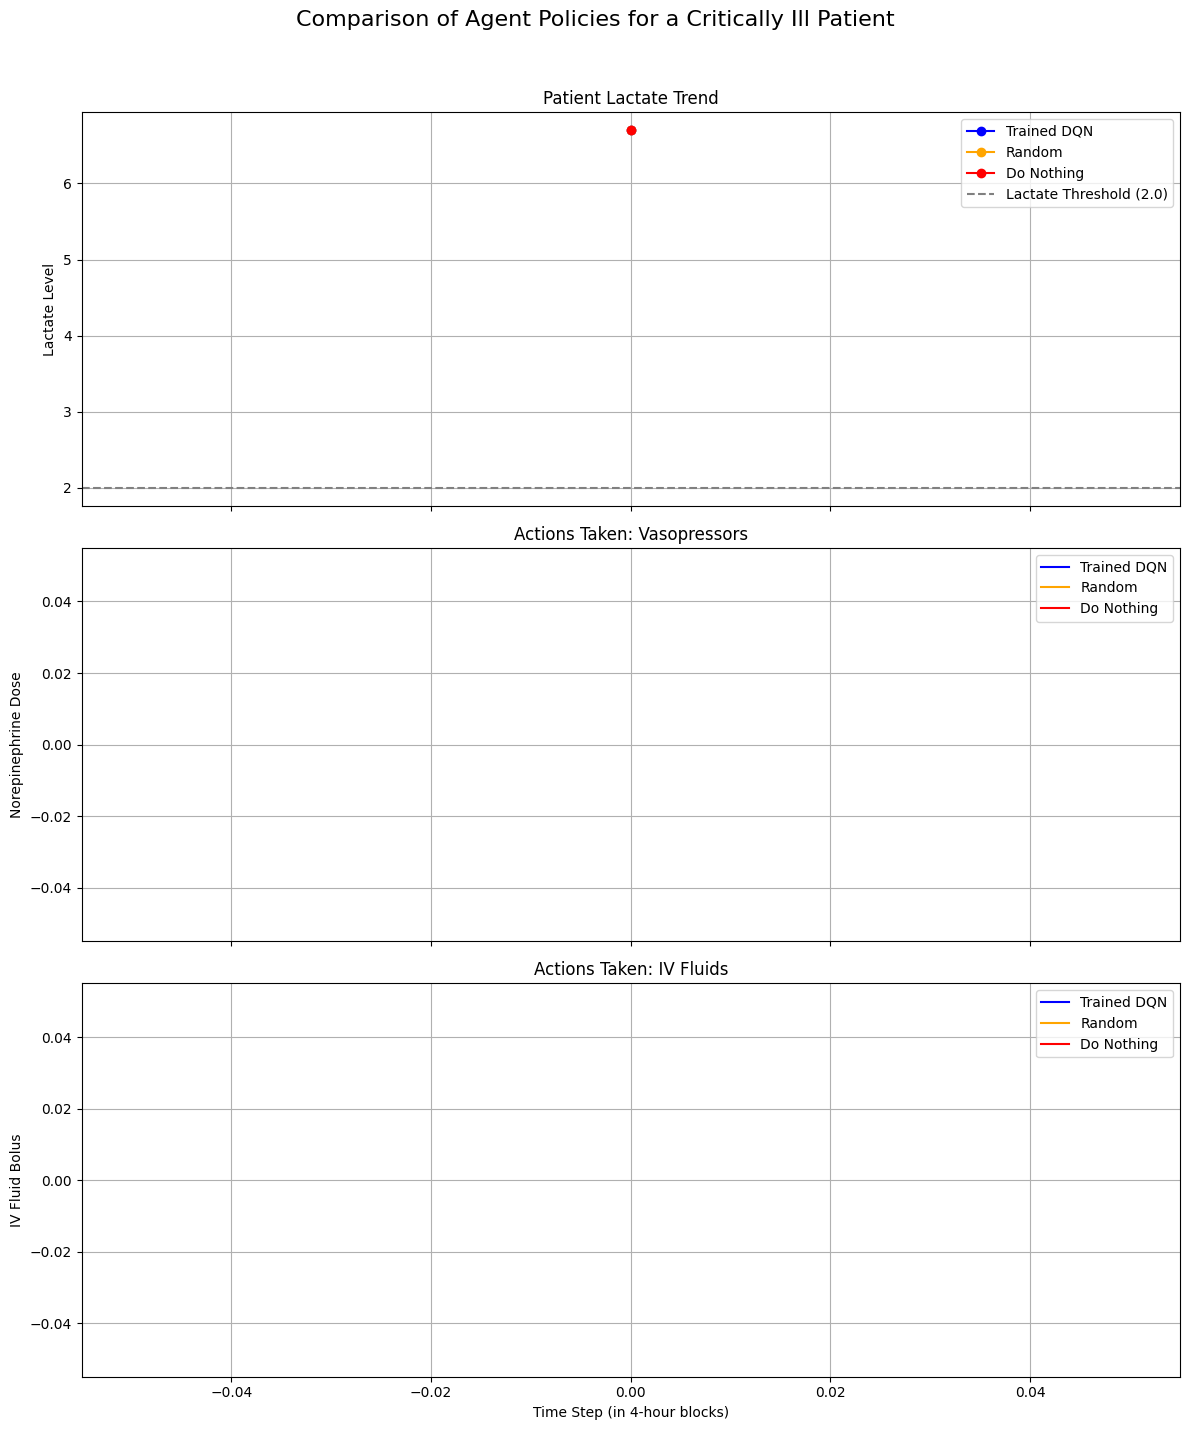


--- First 10 Steps of the Trained DQN Agent ---
   timestep  heart_rate  systolic_bp  diastolic_bp  temperature  lactate  action_norepi  action_fluid     reward
0         0       111.5         87.0          66.0         99.2      6.7            0.0           0.0 -97.883866


In [15]:
## DEMONSTRATION SCRIPT

import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import DQN

# --- Helper Function to Run and Record an Episode ---
def run_episode(env, model, initial_state, policy_type='dqn'):
    """
    Runs a single episode with a given policy and records the history.
    
    Args:
        env: The patient simulator environment.
        model: The trained SB3 model (only used if policy_type='dqn').
        initial_state: The starting state of the patient.
        policy_type (str): 'dqn', 'random', or 'do_nothing'.
        
    Returns:
        A pandas DataFrame with the history of states, actions, and rewards.
    """
    obs, info = env.reset(options={'initial_state': initial_state})
    done = False
    history = []

    while not done:
        # Select action based on the policy
        if policy_type == 'dqn':
            action, _ = model.predict(obs, deterministic=True)
        elif policy_type == 'random':
            action = env.action_space.sample()
        else: # 'do_nothing' policy
            action = 0 # Assumes action 0 corresponds to [0, 0] doses

        # Get the continuous action values for logging
        action_vec = env._decode_action(action)
        
        # Store current state and action BEFORE stepping
        log_entry = {
            'timestep': env.episode_length,
            'heart_rate': obs[0],
            'systolic_bp': obs[1],
            'diastolic_bp': obs[2],
            'temperature': obs[3],
            'lactate': obs[4],
            'action_norepi': action_vec[0],
            'action_fluid': action_vec[1],
        }
        
        obs, reward, done, truncated, info = env.step(action)
        log_entry['reward'] = reward
        history.append(log_entry)
        
    return pd.DataFrame(history)


# --- 1. Setup ---
print("--- Starting Demonstration ---")

# Load the trained model
try:
    trained_model = DQN.load("dqn_mimic_patient_model_v1")
except Exception as e:
    print(f"Could not load the model. Make sure you've trained and saved it first.")
    print(f"Error: {e}")
    # As a fallback, use the model variable from the training cell
    trained_model = model 


# Re-create the environment instance
# We use the 'X' DataFrame from the original script to get realistic initial states and action scales
env_demo = PatientSimulatorEnv(multi_output_model, X, state_cols, action_cols)

# --- 2. Define a Clinical Scenario ---
# Let's find a patient who is in a critical state (high lactate) to see how the agent responds.
try:
    critical_patient_state = X[X['lactate'] > 2.5].iloc[0][state_cols].values
    print(f"\nSelected a critical initial state (Lactate: {critical_patient_state[4]:.2f}):")
    print(pd.Series(critical_patient_state, index=state_cols))
except IndexError:
    print("No patients with lactate > 2.5 found in the dataset. Using a random state.")
    critical_patient_state = X.iloc[100][state_cols].values

# --- 3. Run and Compare Policies ---
print("\nRunning episodes with different policies...")
# Run with the TRAINED agent
df_dqn = run_episode(env_demo, trained_model, critical_patient_state, policy_type='dqn')

# Run with a RANDOM agent
df_random = run_episode(env_demo, None, critical_patient_state, policy_type='random')

# Run with a "DO NOTHING" agent
df_nothing = run_episode(env_demo, None, critical_patient_state, policy_type='do_nothing')

print("\n--- Policy Performance Summary ---")
print(f"Trained DQN Agent: Total Reward = {df_dqn['reward'].sum():.2f} in {len(df_dqn)} steps.")
print(f"Random Agent:      Total Reward = {df_random['reward'].sum():.2f} in {len(df_random)} steps.")
print(f"Do Nothing Agent:  Total Reward = {df_nothing['reward'].sum():.2f} in {len(df_nothing)} steps.")


# --- 4. Visualize the Results ---
print("\nGenerating plots...")

fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
fig.suptitle('Comparison of Agent Policies for a Critically Ill Patient', fontsize=16)

# Plot 1: Lactate Levels
axes[0].plot(df_dqn['timestep'], df_dqn['lactate'], 'o-', label='Trained DQN', color='blue')
axes[0].plot(df_random['timestep'], df_random['lactate'], 'o-', label='Random', color='orange')
axes[0].plot(df_nothing['timestep'], df_nothing['lactate'], 'o-', label='Do Nothing', color='red')
axes[0].axhline(y=2.0, color='gray', linestyle='--', label='Lactate Threshold (2.0)')
axes[0].set_ylabel('Lactate Level')
axes[0].set_title('Patient Lactate Trend')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Norepinephrine Doses
axes[1].step(df_dqn['timestep'], df_dqn['action_norepi'], where='post', label='Trained DQN', color='blue')
axes[1].step(df_random['timestep'], df_random['action_norepi'], where='post', label='Random', color='orange')
axes[1].step(df_nothing['timestep'], df_nothing['action_norepi'], where='post', label='Do Nothing', color='red')
axes[1].set_ylabel('Norepinephrine Dose')
axes[1].set_title('Actions Taken: Vasopressors')
axes[1].legend()
axes[1].grid(True)

# Plot 3: IV Fluid Doses
axes[2].step(df_dqn['timestep'], df_dqn['action_fluid'], where='post', label='Trained DQN', color='blue')
axes[2].step(df_random['timestep'], df_random['action_fluid'], where='post', label='Random', color='orange')
axes[2].step(df_nothing['timestep'], df_nothing['action_fluid'], where='post', label='Do Nothing', color='red')
axes[2].set_xlabel('Time Step (in 4-hour blocks)')
axes[2].set_ylabel('IV Fluid Bolus')
axes[2].set_title('Actions Taken: IV Fluids')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

# Display the first few steps of the trained agent's decisions
print("\n--- First 10 Steps of the Trained DQN Agent ---")
print(df_dqn.head(10).to_string())